In [1]:
import pandas as pd
import numpy as np
from glob import glob
from path import Path
import json
import seaborn as sns
import prody
from multiprocessing import Pool
from tqdm import tqdm
import itertools
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from collections import OrderedDict, Counter
import traceback
import urllib
import pybel
from copy import deepcopy
from multiprocessing import Pool
from pymol import cmd

pd.set_option('display.max_columns', None)

from pocketdock.ligand.ligand_expo import LigandExpo
from pocketdock import utils
from pocketdock import pdb_tools

RDKit WARNING: [16:06:40] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
import logging
import logging.config

LOGGING = {
    'version': 1,
    'disable_existing_loggers': True,
    'formatters': {
        'default': {
            'format': '[%(levelname)s] %(asctime)s %(funcName)s [pid %(process)d] - %(message)s'
        }
    },
    'handlers': {
        'console': {
            'class': 'logging.StreamHandler',
            'formatter': 'default',
        }
    },
    'loggers': {
        'console': {
            'handlers': ['console'],
            'level': 'DEBUG',
            'propagate': False,
        }
    }
}

logging.config.dictConfig(LOGGING)
logger = logging.getLogger('console')


def get_file_handler(filename, mode='w', level='DEBUG'):
    h = logging.FileHandler(filename, mode=mode)
    h.setFormatter(logging.Formatter('[%(levelname)s] %(asctime)s %(funcName)s [pid %(process)d] - %(message)s'))
    h.setLevel(level)
    return h

In [150]:
CHAIN_INTERACTION_DIST = 6
MIN_POCKET_SIZE = 10
MAX_RESOLUTION = 4.0
LIGAND_GROUP_DIST = 5
MIN_LIGAND_TO_SYMMATES = 6
BSITE_SIM_RADIUS = 6
LIGAND_DOMAIN_CONTACT_RADIUS = 6
MAX_NUM_CHAINS = 20
COVALENT_LIGAND_DISTANCE = 1.8
FRAC_HEAVY_ATOMS_RESOLVED = 0.9
HOMO_SEARCH_MIN_COVERAGE = 0.4

In [4]:
def _build_d2mat(crd1, crd2):
    return np.sum((crd1[:, None, :] - crd2[None, :, :])**2, axis=2)
            
def _calc_overlap(lig_ag, ref_ag, dist):
    dmat = prody.buildDistMatrix(lig_ag.heavy, ref_ag.heavy)
    return np.any(dmat <= dist, axis=1).sum().item() / lig_ag.heavy.numAtoms()

def _aln_to_mapping(aln1, aln2):
    assert len(aln1) == len(aln2)
    i = 0
    j = 0
    mapping = []
    for a, b in zip(aln1, aln2):
        if a != '-' and b != '-':
            mapping.append((i, j))
        if a != '-':
            i += 1
        if b != '-':
            j += 1
    return mapping

def _get_affinity(pdb_id, chemid):
    try:
        url = 'https://data.rcsb.org/rest/v1/core/entry/' + pdb_id.lower()
        with urllib.request.urlopen(url) as f:
            affs = json.loads(f.read().decode())
    except urllib.error.HTTPError as e:
        print('HTTPError for', url)
        affs = {}
        
    for x in affs.get('rcsb_binding_affinity', []):
        if x['comp_id'] == chemid:
            return x
    return None

def calc_identity(aln1, aln2):
    return sum([x == y for x, y in zip(aln1, aln2)]) / len(aln1.replace('-', ''))

In [5]:
#get_cases_for_pdb('1QUR')

In [6]:
three2one = {'SER': 'S', 'LYS': 'K', 'PRO': 'P', 'ALA': 'A', 'ASP': 'D', 'ARG': 'R', 'VAL': 'V', 'CYS': 'C', 'HIS': 'H',
         'ASX': 'B', 'PHE': 'F', 'MET': 'M', 'LEU': 'L', 'ASN': 'N', 'TYR': 'Y', 'ILE': 'I', 'GLN': 'Q', 'THR': 'T',
         'GLX': 'Z', 'GLY': 'G', 'TRP': 'W', 'GLU': 'E'}

residue_bonds_noh = {
    'GLY': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C')},
    'ALA': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'), 'CB': ('CA',)},
    'CYS': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'SG'), 'SG': ('CB',)},
    'SER': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'OG'), 'OG': ('CB',)},
    'MET': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'SD'), 'SD': ('CG', 'CE'), 'CE': ('SD',)},
    'LYS': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'CE'), 'CE': ('CD', 'NZ'), 'NZ': ('CE',)},
    'ARG': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'NE'), 'NE': ('CD', 'CZ'), 'CZ': ('NE', 'NH1', 'NH2'),
            'NH1': ('CZ',), 'NH2': ('CZ',)},
    'GLU': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'OE1', 'OE2'), 'OE1': ('CD',), 'OE2': ('CD',)},
    'GLN': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'OE1', 'NE2'), 'OE1': ('CD',), 'NE2': ('CD',)},
    'ASP': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'OD1', 'OD2'), 'OD1': ('CG',), 'OD2': ('CG',)},
    'ASN': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'OD1', 'ND2'), 'OD1': ('CG',), 'ND2': ('CG',)},
    'LEU': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG',), 'CD2': ('CG',)},
    'HIS': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'ND1', 'CD2'), 'ND1': ('CG', 'CE1'), 'CD2': ('CG', 'NE2'),
            'CE1': ('ND1', 'NE2'), 'NE2': ('CD2', 'CE1')},
    'PHE': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG', 'CE1'), 'CD2': ('CG', 'CE2'),
            'CE1': ('CD1', 'CZ'), 'CE2': ('CD2', 'CZ'), 'CZ': ('CE1', 'CE2')},
    'TYR': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG', 'CE1'), 'CD2': ('CG', 'CE2'),
            'CE1': ('CD1', 'CZ'), 'CE2': ('CD2', 'CZ'), 'CZ': ('CE1', 'CE2', 'OH'), 'OH': ('CZ',)},
    'TRP': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG', 'NE1'), 'CD2': ('CG', 'CE2', 'CE3'),
            'NE1': ('CD1', 'CE2'), 'CE2': ('CD2', 'NE1', 'CZ2'), 'CE3': ('CD2', 'CZ3'), 'CZ3': ('CE3', 'CH2'),
            'CZ2': ('CE2', 'CH2'), 'CH2': ('CZ2', 'CZ3')},
    'VAL': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG1', 'CG2'), 'CG1': ('CB',), 'CG2': ('CB',)},
    'THR': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'OG1', 'CG2'), 'OG1': ('CB',), 'CG2': ('CB',)},
    'ILE': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG1', 'CG2'), 'CG1': ('CB', 'CD1'), 'CD1': ('CG1',), 'CG2': ('CB',)},
    'PRO': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA', 'CD'), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('N', 'CG')},
}


def fetch_AF_model(uniprot_id):
    url = f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v1.pdb'
    with urllib.request.urlopen(url) as f:
        data = f.read().decode()
    return prody.parsePDBStream(StringIO(data))


def _find_closest_residue(resid_list, target, upstream=True):
    if not upstream:
        resid_list = reversed(resid_list)
    for resid in resid_list:
        if upstream and target <= resid:
            return resid
        if not upstream and target >= resid:
            return resid
    return None


def fetch_domains(instance_data, entity_to_pdb, pdb_residues, entity_len):
    data = instance_data['rcsb_polymer_instance_feature']
    cath_data = [x for x in data if x['type'] == 'CATH']
    entity_nums = sorted(entity_to_pdb.keys())
    
    domains = []
    for dom_id, dom_data in enumerate(cath_data):
        domain = OrderedDict(
            domain_id=dom_id,
            manually_filled=False,
            domain_chunks=[]
        )
        for chunk_data in dom_data['feature_positions']:
            # zero based position in the entity sequence
            chunk_ent_orig = [int(chunk_data['beg_seq_id'])-1, int(chunk_data['end_seq_id'])-1]
            # zero based position mapped to the closest residue with coordinates
            chunk_ent_map = [
                _find_closest_residue(entity_nums, chunk_ent_orig[0], True), 
                _find_closest_residue(entity_nums, chunk_ent_orig[1], False)
            ]
            # discard region if None
            if chunk_ent_map[0] is None or chunk_ent_map[1] is None:
                continue
            # pdb residue ids
            chunk_pdb = [
                pdb_residues[entity_to_pdb[chunk_ent_map[0]]].getResnum().item() if chunk_ent_map[0] is not None else None,
                pdb_residues[entity_to_pdb[chunk_ent_map[1]]].getResnum().item() if chunk_ent_map[1] is not None else None
            ]
            domain['domain_chunks'].append(
                OrderedDict(
                    chunk_ent_orig=chunk_ent_orig,
                    chunk_ent_map=chunk_ent_map,
                    chunk_pdb_resid=chunk_pdb
                )
            )
        if len(domain['domain_chunks']) == 0:
            continue
        domains.append(domain)
        
    #assert len(domains) > 0, domains
    
    # if there is no domains identified, fill them manually - whole structure
    if len(domains) == 0:
        chunk_ent_orig = [0, entity_len-1]
        chunk_ent_map = [
            _find_closest_residue(entity_nums, chunk_ent_orig[0], True), 
            _find_closest_residue(entity_nums, chunk_ent_orig[1], False)
        ]
        chunk_pdb = [
            pdb_residues[entity_to_pdb[chunk_ent_map[0]]].getResnum().item(),
            pdb_residues[entity_to_pdb[chunk_ent_map[1]]].getResnum().item()
        ]
        domains = [OrderedDict(
            domain_id=0,
            manually_filled=True,
            domain_chunks=[
                OrderedDict(
                    chunk_ent_orig=chunk_ent_orig,
                    chunk_ent_map=chunk_ent_map,
                    chunk_pdb_resid=chunk_pdb
                )
            ]
        )]
        
    return domains


def find_correct_instance(pdb_id, target_chain, chain_list):
    for cid in chain_list:
        url = f'https://data.rcsb.org/rest/v1/core/polymer_entity_instance/{pdb_id}/{cid}'
        with urllib.request.urlopen(url) as f:
            instance_data = json.loads(f.read().decode())   
        if instance_data['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'] == target_chain:
            break
    
    if instance_data['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'] != target_chain:
        return None
    
    return instance_data


def process_pdb_chain(outdir, pdb_id, chain):
    pdb_id = pdb_id.upper()
    outdir = Path(outdir).mkdir_p()
    ag, header = pdb_tools.get_atom_group(pdb_id, header=True)
    
    url = f'https://data.rcsb.org/rest/v1/core/entry/{pdb_id}'
    with urllib.request.urlopen(url) as f:
        entry_data = json.loads(f.read().decode())
    
    url = f'https://data.rcsb.org/rest/v1/core/polymer_entity_instance/{pdb_id}/{chain}'
    with urllib.request.urlopen(url) as f:
        instance_data = json.loads(f.read().decode())
    
    # yes, instance id can be different from the chain name, 
    # so we have to loop though all instances (chains) until 
    # we find the correct one
    buf = instance_data['rcsb_polymer_entity_instance_container_identifiers']
    if buf['asym_id'] != buf['auth_asym_id']:
        instance_data = find_correct_instance(pdb_id, chain, set(ag.getChids()))
    if instance_data is None:
        raise RuntimeError('Cannot find correct RESTful link for {pdb_id}/{chain}. RCSB and Author\'s namings are different')
    
    entity_id = instance_data['rcsb_polymer_entity_instance_container_identifiers']['entity_id']
    
    url = f'https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity_id}'
    with urllib.request.urlopen(url) as f:
        entity_data = json.loads(f.read().decode())
    assert chain in entity_data['entity_poly']['pdbx_strand_id'].split(',')
        
    url = f'https://data.rcsb.org/rest/v1/core/uniprot/{pdb_id}/{entity_id}'
    with urllib.request.urlopen(url) as f:
        uniprot_data = json.loads(f.read().decode())
        
    # ensure there is no non-standard linkage and aas
    assert entity_data['entity_poly']['nstd_linkage'] == 'no'
    assert entity_data['entity_poly']['nstd_monomer'] == 'no'
    assert entity_data['entity_poly']['rcsb_non_std_monomer_count'] == 0
    
    # align residues that have coordinates in the pdb to the 
    # sequence announced in the entity description and ID
    # the missing residues as well as partially resolved residues
    entity_seq = entity_data['entity_poly']['pdbx_seq_one_letter_code']
    
    # double check for nstd residues
    assert '(' not in entity_seq
    
    ag_chain = ag.select(f'chain {chain} and (stdaa or nonstdaa)').copy()
    residues = list(ag_chain.getHierView().iterResidues())
    pdb_seq = ''.join([three2one[x.getResname()] for x in residues])
    #print(entity_data['entity_poly'])
    #print(entity_seq)
    #print(pdb_seq)
    entity_aln, pdb_aln = utils.global_align(entity_seq, pdb_seq)[0][:2]
    
    # sanity check
    assert calc_identity(pdb_aln, entity_aln) > 0.90, 'Entity sequence doesn\'t match the chain'
    
    entity_to_pdb = dict(_aln_to_mapping(entity_aln, pdb_aln))
    missing_residue = []
    missing_ca = []
    missing_atoms = []
    for ent_i, ent_res in enumerate(entity_seq):
        if ent_i not in entity_to_pdb:
            missing_residue.append(True)
            missing_ca.append(True)
            missing_atoms.append(True)
            continue
        missing_residue.append(False)
        res = residues[entity_to_pdb[ent_i]]
        res_ideal_names = set(residue_bonds_noh[res.getResname()].keys())
        res_ideal_names.discard('OXT')
        res_cur_names = set(res.heavy.getNames())
        res_cur_names.discard('OXT')
        missing_ca.append('CA' not in res_cur_names)
        missing_atoms.append(res_ideal_names != res_cur_names)
        
    # write full pdb
    prody.writePDB(outdir / f'{pdb_id}.pdb', ag)
        
    # ag_chain
    prody.writePDB(outdir / 'rec_orig.pdb', ag_chain)
        
    # download alphafold model
    uniprot_id = uniprot_data[0]['rcsb_id']
    ag_af = fetch_AF_model(uniprot_id)
    prody.writePDB(outdir / 'AF_orig.pdb', ag_af)
    
    # align AF to crystal
    ag_af_aln, rmsd, (af_seq_aln, pdb_seq_aln) = pdb_tools.align(ag_af, ag_chain)
    rmsd = rmsd[0]
    prody.writePDB(outdir / 'AF_aln.pdb', ag_af_aln)
    
    AF_residues = list(ag_af.getHierView().iterResidues())
    AF_seq = ''.join([three2one[x.getResname()] for x in AF_residues])
    
    # domain data
    domains = fetch_domains(instance_data, entity_to_pdb, residues, len(entity_seq))
    
    entity_info = entity_data['entity_poly'].copy()
    entity_info['entity_aln'] = entity_aln
    entity_info['pdb_aln'] = pdb_aln
    #print(entity_aln)
    #print(pdb_aln)
    
    rec_dict = OrderedDict(
        case_name=pdb_id + '_' + chain,
        pdb_id=pdb_id,
        pdb_chain=chain,
        instance_id=instance_data['rcsb_polymer_entity_instance_container_identifiers']['asym_id'],
        entity_id=entity_id,
        experiment=header.get('experiment'), #entry_data['exptl']['method'],
        resolution=header.get('resolution'), #entry_data['exptl']['method'],
        deposition_date=entry_data['rcsb_accession_info']['deposit_date'],
        
        seqclus100=pdb_tools.CHAIN_TO_CLUSTER[100][pdb_id + '_' + chain],
        seqclus90=pdb_tools.CHAIN_TO_CLUSTER[90][pdb_id + '_' + chain],
        seqclus40=pdb_tools.CHAIN_TO_CLUSTER[40][pdb_id + '_' + chain],
        seqclus30=pdb_tools.CHAIN_TO_CLUSTER[30][pdb_id + '_' + chain],
        
        missing_residue=''.join([str(int(x)) for x in missing_residue]),
        missing_ca=''.join([str(int(x)) for x in missing_ca]),
        missing_atoms=''.join([str(int(x)) for x in missing_atoms]),
        
        entity_info=entity_info,
        
        uniprot=OrderedDict(
            uniprot_id=uniprot_id,
            uniprot_seq=uniprot_data[0]['rcsb_uniprot_protein']['sequence'],
            uniprot_name=uniprot_data[0]['rcsb_uniprot_protein']['name']['value'],
        ),
        
        domains=domains,
        
        alphafold=OrderedDict(
            seq=AF_seq,
            PDB_CA_RMSD=rmsd,
            AF_seq_aln=af_seq_aln,
            PDB_seq_aln=pdb_seq_aln,
            PDB_AF_identity=calc_identity(pdb_seq_aln, af_seq_aln),
            AF_confidence=ag_af.calpha.getBetas().tolist()
        )
    )
    return rec_dict

In [7]:
def _add_hs(out_mol, in_mol):
    # add hydrogens
    mol = next(pybel.readfile('mol', in_mol))
    mol.addh()
    mol.localopt('mmff94', steps=500)
    mol.write('mol', out_mol, overwrite=True)

    # fix back the coordinates
    mol = Chem.MolFromMolFile(out_mol, removeHs=False)
    ag = utils.mol_to_ag(mol)
    ref_ag = utils.mol_to_ag(Chem.MolFromMolFile(in_mol, removeHs=True))
    tr = prody.calcTransformation(ag.heavy, ref_ag.heavy)
    ag = tr.apply(ag)
    prody.writePDB(Path(out_mol).stripext() + '.pdb', ag)

    utils.change_mol_coords(mol, ag.getCoords())
    AllChem.ComputeGasteigerCharges(mol, throwOnParamFailure=False)
    Chem.MolToMolFile(mol, out_mol)


def _calc_rmsd(crd1, crd2):
    return np.square(crd1 - crd2).sum(1).mean().item()


def _bsite_similarity(mol_ag, mob_ag, ref_ag, mob_aln, ref_aln):
    ref_to_mob = dict(_aln_to_mapping(ref_aln, mob_aln))
    mob_residues = list(mob_ag.copy().getHierView().iterResidues())
    ref_residues = list(ref_ag.copy().getHierView().iterResidues())

    assert len(mob_residues) == len(mob_aln.replace('-', ''))
    assert len(ref_residues) == len(ref_aln.replace('-', ''))
    
    pocket = ref_ag.select(f'exwithin {BSITE_SIM_RADIUS} of sel', sel=mol_ag)
    pocket_resnums = set(pocket.getResnums())
    pocket_ref_residues = []
    pocket_mob_residues = []
    for i, x in enumerate(ref_residues):
        if x.getResnum() in pocket_resnums:
            pocket_ref_residues.append(x)
            mob_id = ref_to_mob.get(i, None)
            pocket_mob_residues.append(None if mob_id is None else mob_residues[mob_id])
    
    pocket_rmsd = None
    if not all([x is None for x in pocket_mob_residues]):
        pocket_rmsd = _calc_rmsd(
            np.stack([x['CA'].getCoords() for i, x in enumerate(pocket_ref_residues) if pocket_mob_residues[i] is not None]),
            np.stack([x['CA'].getCoords() for x in pocket_mob_residues if x is not None])
        )
    pocket_identity = sum([y is not None and x.getResname() == y.getResname() 
                           for x, y in zip(pocket_ref_residues, pocket_mob_residues)]) / len(pocket_ref_residues)
    return OrderedDict(
        nresidues=len(pocket_ref_residues),
        rmsd_ca=pocket_rmsd,
        identity=pocket_identity,
        resnums_pdb=[x.getResnum().item() for x in pocket_ref_residues],
        resnums_af=[x.getResnum().item() if x is not None else None for x in pocket_mob_residues],
        seq_pdb=''.join([x['CA'].getSequence() for x in pocket_ref_residues]),
        seq_af=''.join([x['CA'].getSequence() if x is not None else '-' for x in pocket_mob_residues])
    )
    

def process_ligand_group(case_dir, case_dict, group_dict):
    case_dir = Path(case_dir)
    group_dir = case_dir / group_dict['name'] 
    
    # add hs
    for item in group_dict['ligands']:
        _add_hs(group_dir / item['sdf_id'] + '_ah.mol', group_dir / item['sdf_id'] + '.mol')
    
    # make ligand group ag
    mols = [(x['sdf_id'], utils.mol_to_ag(Chem.MolFromMolFile(group_dir / x['sdf_id'] + '.mol'))) for x in group_dict['ligands']]
    combined_ag = mols[0][1].copy()
    for _, mol in mols[1:]:
        combined_ag += mol.copy()
        
    # define domains in contact
    pdb_ag = prody.parsePDB(case_dir / 'rec_orig.pdb')
    domains = case_dict['domains']
    bsite_ag = pdb_ag.select(f'exwithin {LIGAND_DOMAIN_CONTACT_RADIUS} of lig', lig=combined_ag).copy()
    interacting_domains = []
    for dom in domains:
        for chunk in dom['domain_chunks']:
            a, b = chunk['chunk_pdb_resid']
            if bsite_ag.select(f"resnum `{a} to {b}`") is not None:
                interacting_domains.append(dom['domain_id'])
                break
    
    #print(domains)
    #print(interacting_domains)
                
    # select domains in pdb
    resnums = []
    for dom_id in interacting_domains:
        dom = domains[dom_id]
        for chunk in dom['domain_chunks']:
            a, b = chunk['chunk_pdb_resid']
            resnums.append((a, b))
    #print('PD', ' or '.join([f'(resnum {a} to {b})' for a, b in resnums]))
    domains_pdb_ag = pdb_ag.select(' or '.join([f"(resnum `{a} to {b}`)" for a, b in resnums])).copy()
    prody.writePDB(group_dir / 'domains_crys.pdb', domains_pdb_ag)
    pdb_resnums = resnums
    
    # select domains in AF
    # align AF sequence to the entity sequence and select domain regions
    af_ag = prody.parsePDB(case_dir / 'AF_orig.pdb')
    entity_seq = case_dict['entity_info']['pdbx_seq_one_letter_code']
    af_residues = list(af_ag.getHierView().iterResidues())
    af_seq = ''.join([three2one[x.getResname()] for x in af_residues]) #case_dict['alphafold']['seq']
    entity_aln, af_aln = utils.global_align(entity_seq, af_seq)[0][:2]
    ent_to_af_map = dict(_aln_to_mapping(entity_aln, af_aln))
    ent_resids = list(ent_to_af_map.keys())
    #print(entity_aln)
    #print(af_aln)
    #print(ent_to_af_map)
    #print(ent_resids)
    #print('af_residues', len(af_residues))
    #print('af_seq', len(af_seq))
    resnums = []
    for dom_id in interacting_domains:
        dom = domains[dom_id]
        #print(dom)
        for chunk in dom['domain_chunks']:
            a, b = chunk['chunk_ent_orig']
            #print(a, b)
            #print(ent_to_af_map[_find_closest_residue(ent_resids, a, True)], 
            #      ent_to_af_map[_find_closest_residue(ent_resids, b, False)])
            a = af_residues[ent_to_af_map[_find_closest_residue(ent_resids, a, True)]].getResnum().item()
            b = af_residues[ent_to_af_map[_find_closest_residue(ent_resids, b, False)]].getResnum().item()
            resnums.append((a, b))
    #print('AF', ' or '.join([f'(resnum {a} to {b})' for a, b in resnums]))
    domains_af_ag = af_ag.select(' or '.join([f"(resnum `{a} to {b}`)" for a, b in resnums])).copy()
    prody.writePDB(group_dir / 'domains_AF.pdb', domains_af_ag)
    af_resnums = resnums
    
    # align AF domain to PDB domain
    domains_af_ag_aln, rmsd, (af_aln, pdb_aln) = pdb_tools.align(domains_af_ag, domains_pdb_ag)
    rmsd = rmsd[0]
    prody.writePDB(group_dir / 'domains_AF_aln.pdb', domains_af_ag_aln)
    
    domain_aligment = OrderedDict(
        interacting_domains=interacting_domains,
        pdb_resi_ranges=pdb_resnums,
        af_resi_ranges=af_resnums,
        af_aln=af_aln,
        pdb_aln=pdb_aln,
        pdb_af_identity=calc_identity(pdb_aln, af_aln),
        rmsd_aln=rmsd
    )
    
    bsite_analysis = _bsite_similarity(combined_ag, domains_af_ag_aln, domains_pdb_ag, af_aln, pdb_aln)
    return domain_aligment, bsite_analysis
    
    
#process_ligand_group('data/3WKE_A', case_dict, case_dict['ligand_groups'][0])
    

In [8]:
#get_cases_for_pdb('6bg0')

In [9]:
def get_chain(chemid, mol_rd, pdb_ag):
    mol_ag = utils.mol_to_ag(mol_rd)
    not_lig = pdb_ag.select('not resname ' + chemid).copy()
    
    pocket_all = not_lig.select(f'(not water) exwithin {CHAIN_INTERACTION_DIST} of sel', sel=mol_ag)
    assert pocket_all is not None
    assert len(pocket_all) > MIN_POCKET_SIZE
    
    dmat_min = np.sqrt(_build_d2mat(pocket_all.getCoords(), mol_ag.getCoords())).min()
    #print(dmat_min)
    assert dmat_min > COVALENT_LIGAND_DISTANCE, f'{dmat_min} <= {COVALENT_LIGAND_DISTANCE}'
    
    # exclude hetero because ligands in the same group can be in different chains
    # and count toward "counts"
    pocket = pocket_all.select('not hetero')
    assert pocket is not None
    
    counts = Counter(pocket.getChids())
    chain = sorted(counts.items(), key=lambda x: -x[1])[0][0]
    assert (counts[chain] / len(pocket)) > 0.8
    return chain


def assert_one_chemid_copy_per_chain(chemid, pdb_ag):
    for chain_ag in pdb_ag.getHierView().iterChains():
        chain_ag = chain_ag.protein
        if chain_ag is None:
            continue
        lig = pdb_ag.select(f'resname {chemid} within 6 of sel', sel=chain_ag)
        if lig is not None:
            assert len(set(lig.getResnums())) == 1
            

def get_crystall_lattice(pdb, cutoff=6):
    pdb_file = pdb_tools.pdb_file_path(pdb)
    cmd.reinitialize()
    cmd.load(pdb_file, 'orig')
    cmd.symexp('symm', 'orig', 'orig', cutoff)
    tmp_file = utils.tmp_file(prefix='alphadock-', suffix='.pdb')
    cmd.save(tmp_file, 'symm*')
    symm_ag = prody.parsePDB(tmp_file)
    Path(tmp_file).remove_p()
    cmd.delete('all')
    return symm_ag


#get_crystall_lattice('4ow1')


def get_cases_for_pdb(pdb_id):
    pdb_id = pdb_id.upper()
    wdir = Path('data/cases').mkdir_p().mkdir_p()
    
    try:
        db_result = pdb_tools.get_atom_group(pdb_id, header=True)
        assert db_result is not None
        pdb_ag, header = db_result
        assert header.get('resolution', MAX_RESOLUTION + 10) <= MAX_RESOLUTION
        # avoid crazy large pdb files like ribosomes
        num_chains = len(set(pdb_ag.getChids()))
        assert num_chains <= MAX_NUM_CHAINS, f'{num_chains} > {MAX_NUM_CHAINS}'
    except AssertionError as e:
        logger.warning(f'{pdb_id} does not pass the criteria')
        logger.exception(e)
        return []
    
    chemids = LigandExpo.get_chemids_list(pdb_id)
    
    # find groups of ligands. here we treat groups of proximal ligands as 
    # whole instead of discarding them. such cases will represent cooperative binding
    mol_sdf_ids = []
    mol_rds = {}
    mol_rd_coords = {}
    for chemid in chemids:
        sdf_ids = LigandExpo.get_all_sdf_ids(pdb_id, chemid)
        for sdf_id in sdf_ids:
            mol_rd = LigandExpo.get_all_sdf_mol(sdf_id)
            if mol_rd is not None:
                mol_rds[sdf_id] = mol_rd
                mol_rd_coords[sdf_id] = mol_rd.GetConformer(0).GetPositions()
                mol_sdf_ids.append(sdf_id)
            else:
                logger.warning(f'Cannot read {sdf_id}')
    
    mol_groups = []
    for sdf_a in mol_sdf_ids:
        crd_a = mol_rd_coords[sdf_a]
        found = None
        for mol_group in mol_groups:
            for sdf_b in mol_group:
                crd_b = mol_rd_coords[sdf_b]
                d2mat = np.sum((crd_a[:, None, :] - crd_b[None, :, :])**2, axis=2)
                if np.any(d2mat < LIGAND_GROUP_DIST**2):
                    found = mol_group
                    break
            if found is not None:
                break
        if found is not None:
            found.append(sdf_a)
        else:
            mol_groups.append([sdf_a])
            
    #print(mol_groups)
            
    # build symmetry mates
    symm_mates_ag = get_crystall_lattice(pdb_id)
    
    # for each sdf_id
    detailed_groups = []
    for mol_group in mol_groups:
        detailed_group = []
        # if at least one ligand in the group is bad, we skip the whole group
        try:
            for sdf_id in mol_group:
                mol_rd = mol_rds[sdf_id]
                #assert mol_rd is not None
                
                chemid = sdf_id.split('_')[1]
                assert_one_chemid_copy_per_chain(chemid, pdb_ag)
                
                # check smiles and that all heavy atoms are present
                smi = LigandExpo.get_smiles(chemid)
                assert smi is not None
                
                mol_smi = Chem.MolFromSmiles(smi)
                nheavy = mol_smi.GetNumHeavyAtoms()
                assert nheavy > 0
                frac_resolved = nheavy / mol_rd.GetNumHeavyAtoms()
                assert frac_resolved >= FRAC_HEAVY_ATOMS_RESOLVED, f'{nheavy} < {mol_rd.GetNumHeavyAtoms()}, ({smi})'
                
                # check that ligand interacts with a single chain
                pdb_chain = get_chain(chemid, mol_rd, pdb_ag)
                
                # check that there is no symm mates interaction
                mol_ag = utils.mol_to_ag(mol_rd)
                if symm_mates_ag is not None:
                    assert mol_ag.select(f'within {MIN_LIGAND_TO_SYMMATES} of symmmates', symmmates=symm_mates_ag) is None, \
                    'Ligand interacts with symmetry mates'
                
                case = OrderedDict(
                    sdf_id=sdf_id, 
                    chemid=chemid,
                    smiles=smi,
                    pdb_id=pdb_id,
                    pdb_chain=pdb_chain,
                    num_heavy_atoms=mol_rd.GetNumHeavyAtoms(),
                    frac_resolved=frac_resolved,
                    affinity=_get_affinity(pdb_id, chemid)
                )
                detailed_group.append(case)
                
            # check that all chains in the group are the same
            inter_chains = set([x['pdb_chain'] for x in detailed_group])
            assert len(inter_chains) == 1, f'Multiple interacting chains: {inter_chains}'
            
        except AssertionError as e:
            logger.info(f'Dropping group {mol_group}')
            logger.exception(e)
            continue
            
        detailed_groups.append(detailed_group)
        
    if len(detailed_groups) == 0:
        logger.error('Groups are empty')
        return []
        
    # select unique (chain, chemids) groups
    unique_groups = []
    _desc_list = []
    for group in detailed_groups:
        seqclus100 = pdb_tools.CHAIN_TO_CLUSTER[100].get(pdb_id + '_' + group[0]['pdb_chain'])
        if seqclus100 is None:
            continue
        _desc = [seqclus100]
        _desc += sorted([x['chemid'] for x in group])
        _desc = tuple(_desc)
        if _desc in _desc_list:
            continue
        _desc_list.append(_desc)
        unique_groups.append(group)
        
    # prepare dict with chains
    chains_dict = OrderedDict()
    chains_list = sorted(set([x[0]['pdb_chain'] for x in unique_groups]))
    for chain in chains_list:
        try:
            chain_name = pdb_id + '_' + chain
            chains_dict[chain_name] = process_pdb_chain(wdir / chain_name, pdb_id, chain)
            chains_dict[chain_name]['ligand_groups'] = []
        except Exception as e:
            (wdir / chain_name).rmtree_p()
            logger.warning(f'Cannot process {chain_name}, skipping')
            #traceback.print_exc()
            #logger.exception(e)
    
    # process ligand groups
    for group in unique_groups:
        try:
            chain_name = pdb_id + '_' + group[0]['pdb_chain']
            chain_dict = chains_dict.get(chain_name)
            if chain_dict is None:
                continue

            group_name = '_'.join(sorted([x['chemid'] for x in group]))
            group_dir = (wdir / chain_name / group_name).mkdir_p()
            group_dict = OrderedDict(
                name=group_name,
                ligands=group
            )

            for lig_dict in group:
                Chem.MolToMolFile(mol_rds[lig_dict['sdf_id']], group_dir / lig_dict['sdf_id'] + '.mol')

            domain_aligment, bsite_analysis = process_ligand_group(wdir / chain_name, chain_dict, group_dict)
            group_dict['domain_aligment'] = domain_aligment
            group_dict['bsite_analysis'] = bsite_analysis
            chain_dict['ligand_groups'].append(group_dict)
        except Exception as e:
            logger.warning(f'Cannot process {group_name}, skipping')
            logger.exception(e)
        
    cases = []
    for case in chains_dict.values():
        # if all ligand groups were discarded skip this chain
        if len(case['ligand_groups']) == 0:
            (wdir / case['case_name']).rmtree_p()
            continue
        utils.write_json(case, wdir / case['case_name'] / 'case.json')
        cases.append(case)
        
    return cases

In [10]:
#case_dicts = get_cases_for_pdb('3wke')

In [11]:
#case_dicts[0]

In [12]:
#set(['a',24]) in [set([24,'a'])]

In [24]:
#LigandExpo._PDB_TO_CC #.keys()
logger.handlers

[<StreamHandler stderr (NOTSET)>]

In [ ]:
try:
    old_h = logger.handlers
    logger.handlers = [get_file_handler(Path('data') / 'log.txt', mode='a')]
    logger.info(f'============ Starting ===========')
    for i, pdb in tqdm(list(enumerate(LigandExpo._PDB_TO_CC.keys()))[:]):
        logger.info(f'============ Processing {pdb} [{i}] ===========')
        get_cases_for_pdb(pdb)
        logger.info(f'============== Finished {pdb} =================\n\n')
except Exception as e:
    logger.exception(e)
    raise
finally:
    logger.handlers[0].close()
    logger.handlers = old_h

  0%|          | 210/57369 [05:30<22:41:23,  1.43s/it] RDKit ERROR: [19:33:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:33:12] Explicit valence for atom # 39 N, 4, is greater than permitted
  0%|          | 237/57369 [06:20<44:01:06,  2.77s/it]RDKit ERROR: [19:34:02] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [19:34:02] Explicit valence for atom # 36 O, 3, is greater than permitted
  1%|          | 478/57369 [16:12<51:16:27,  3.24s/it] RDKit ERROR: [19:43:53] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:43:53] Explicit valence for atom # 39 N, 4, is greater than permitted
  1%|          | 615/57369 [21:14<35:49:12,  2.27s/it]RDKit ERROR: [19:48:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:48:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:48:57] Explicit valence for atom # 39 N, 4, is greater than permitted

Symmetry-Error: Unrecognized space group symbol 'P 21 21 2 A'.


  1%|▏         | 760/57369 [25:51<29:07:59,  1.85s/it]RDKit ERROR: [19:53:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:53:33] Explicit valence for atom # 39 N, 4, is greater than permitted
  1%|▏         | 761/57369 [25:54<36:26:35,  2.32s/it]RDKit ERROR: [19:53:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:53:36] Explicit valence for atom # 39 N, 4, is greater than permitted
  1%|▏         | 762/57369 [25:57<38:58:56,  2.48s/it]RDKit ERROR: [19:53:39] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:53:39] Explicit valence for atom # 39 N, 4, is greater than permitted
  2%|▏         | 910/57369 [31:12<36:03:18,  2.30s/it]RDKit ERROR: [19:58:54] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [19:58:54] Explicit valence for atom # 16 N, 4, is greater than permitted
  2%|▏         | 911/57369 [31:14<33:56:03,  2.16s/it]RDKit ERROR: [19:58:55] Explicit v

  3%|▎         | 1545/57369 [57:40<21:52:33,  1.41s/it] RDKit WARNING: [20:25:22] Element 'X' not found
RDKit WARNING: [20:25:22] Element 'X' not found
RDKit WARNING: [20:25:22] Element 'X' not found
RDKit WARNING: [20:25:22] Element 'X' not found
  3%|▎         | 1577/57369 [59:04<28:03:58,  1.81s/it] RDKit ERROR: [20:25:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:25:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:25:22] 
RDKit ERR

  3%|▎         | 2004/57369 [1:21:47<36:11:44,  2.35s/it]RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:49:29] Explicit valence for atom # 39 N, 4, is greater than permitted
  4%|▎         | 2145/57369 [1:26:34<49:55:18,  3.25s/it] RDKit ERROR: [20:54:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [20:54:15] Explicit valence for atom # 39 N, 4, is greater than permitted
  4%|▍         | 2343/57369 [1:30:44<28:58:00,  1.90s/it]RDKit WARNING: [20:58:26] Element 'X' not found
RDKit WARNING: [20:58:26] Element 'X' not found
RDKit WARNING: [20:58:26] Element 'X' not found
RDKit WARNING: [20:58:26] Element 'X' not found
  4%|▍         | 2386/57369 [1:32:05<24:05:54,  1.58s/it]RDKit ERROR: [20:58:26] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKi

  5%|▌         | 2877/57369 [1:50:19<63:11:02,  4.17s/it]RDKit ERROR: [21:18:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:01] Explicit valence for atom # 39 N, 4, is greater than permitted
  5%|▌         | 2882/57369 [1:50:23<25:09:49,  1.66s/it]RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
  5%|▌         | 2883/57369 [1:50:23<18:16:00,  1.21s/it]RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
  5%|▌         | 2884/57369 [1:50:23<13:19:03,

  6%|▌         | 3200/57369 [2:04:25<39:29:26,  2.62s/it] RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
  6%|▌         | 3211/57369 [2:04:52<26:37:14,  1.77s/it]RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WAR

  7%|▋         | 3853/57369 [2:26:45<19:37:14,  1.32s/it]RDKit ERROR: [21:54:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:54:27] Explicit valence for atom # 39 N, 4, is greater than permitted
  7%|▋         | 4005/57369 [2:34:43<10:37:46,  1.39it/s] RDKit WARNING: [22:02:25] Element 'X' not found
RDKit WARNING: [22:02:25] Element 'X' not found
RDKit WARNING: [22:02:25] Element 'X' not found
RDKit WARNING: [22:02:25] Element 'X' not found
  7%|▋         | 4109/57369 [2:37:55<41:02:47,  2.77s/it] RDKit ERROR: [22:02:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:02:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found


 30%|██▉       | 17105/57369 [12:01:01<22:56:16,  2.05s/it]RDKit ERROR: [07:28:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:28:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|██▉       | 17124/57369 [12:01:22<15:28:23,  1.38s/it]RDKit ERROR: [07:29:04] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:29:04] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|██▉       | 17125/57369 [12:01:24<16:02:07,  1.43s/it]RDKit ERROR: [07:29:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:29:06] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|██▉       | 17130/57369 [12:01:31<13:54:20,  1.24s/it]RDKit ERROR: [07:29:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:29:13] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|███       | 17257/57369 [12:05:39<12:10:23,  1.09s/it] RDKit ER

 31%|███       | 17635/57369 [12:18:35<25:54:35,  2.35s/it]RDKit ERROR: [07:46:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:46:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 31%|███       | 17707/57369 [12:21:04<34:20:35,  3.12s/it]RDKit ERROR: [07:48:46] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:48:46] Explicit valence for atom # 39 N, 4, is greater than permitted
 31%|███       | 17711/57369 [12:21:10<19:44:20,  1.79s/it]RDKit ERROR: [07:48:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:48:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:48:52] Explicit valence for atom # 39 N, 4, is greater than permitted
 31%|███       | 17759/57369 [12:22:27<17:46:43,  1.62s/it]RDKit ERROR: [07:50:09] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:50:09] Explicit valence for atom # 39 N, 4, is grea

 32%|███▏      | 18467/57369 [12:44:36<10:35:43,  1.02it/s]RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:12:18] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:12:18] 
RDKit ERROR: 
RDKit ERROR: ***

 32%|███▏      | 18560/57369 [12:48:20<11:11:37,  1.04s/it]RDKit ERROR: [08:16:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:16:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18681/57369 [12:51:48<12:44:04,  1.18s/it]RDKit ERROR: [08:19:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:19:30] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18762/57369 [12:54:47<47:50:38,  4.46s/it]RDKit ERROR: [08:22:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:22:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18769/57369 [12:55:01<24:06:13,  2.25s/it]RDKit ERROR: [08:22:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:22:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18770/57369 [12:55:04<27:18:26,  2.55s/it]RDKit ERR

 33%|███▎      | 19035/57369 [13:03:45<10:01:21,  1.06it/s]RDKit ERROR: [08:31:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:31:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 19149/57369 [13:07:12<14:21:23,  1.35s/it]RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 19174/57369 [13:08:13<28:17:18,  2.67s/it]RDKit ERROR: [08:35:49] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RD

 33%|███▎      | 19214/57369 [13:09:23<14:53:42,  1.41s/it]RDKit ERROR: on Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:36:24] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:36:24] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:

 34%|███▍      | 19521/57369 [13:21:13<16:16:19,  1.55s/it]RDKit ERROR: [08:48:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:48:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19579/57369 [13:22:57<7:20:30,  1.43it/s] RDKit ERROR: [08:50:39] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:50:39] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19601/57369 [13:23:26<6:05:22,  1.72it/s] RDKit ERROR: [08:51:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:51:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19621/57369 [13:24:14<17:32:37,  1.67s/it]RDKit ERROR: [08:51:56] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:51:56] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19753/57369 [13:28:08<34:40:11,  3.32s/it]RDKit ERR

 42%|████▏     | 24008/57369 [15:59:19<7:22:33,  1.26it/s] RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater

 42%|████▏     | 24074/57369 [16:00:08<7:44:09,  1.20it/s]RDKit ERROR: [11:27:49] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:49] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24075/57369 [16:00:10<12:35:40,  1.36s/it]RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24077/57369 [16:00:11<9:21:46,  1.01s/it] RDKit ERROR: [11:27:53] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:53] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24080/57369 [16:00:13<9:23:54,  1.02s/it]RDKit ERROR: [11:27:55] Explicit valence for atom # 39 N, 4, is greate

Symmetry-Error: Unrecognized space group symbol 'B 2'.


 42%|████▏     | 24093/57369 [16:00:23<8:41:14,  1.06it/s]RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24096/57369 [16:00:31<14:31:37,  1.57s/it]RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24100/57369 [16:00:35<10:28:48,  1.13s/it]RDKit ERROR: [11:28:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:17] Explicit valence 

 42%|████▏     | 24149/57369 [16:02:18<23:53:02,  2.59s/it]RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24153/57369 [16:02:19<7:00:31,  1.32it/s]RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24154/57369 [16:02:19<5:32:46,  1.66it/s]RDKit ERROR: [11:30:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24155/57369 [16:02:23<14:35:18,  1.58s/it]RDKit ERROR: [11:30:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:05] Explicit valence for atom # 39 N, 4, is greate

 42%|████▏     | 24185/57369 [16:02:50<5:57:41,  1.55it/s]RDKit ERROR: [11:30:32] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [11:30:32] Explicit valence for atom # 35 N, 4, is greater than permitted
 42%|████▏     | 24186/57369 [16:02:51<7:31:11,  1.23it/s]RDKit ERROR: [11:30:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24187/57369 [16:02:52<6:30:39,  1.42it/s]RDKit ERROR: [11:30:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24193/57369 [16:02:54<4:42:19,  1.96it/s]RDKit ERROR: [11:30:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 39 N, 4, is greater 

 42%|████▏     | 24222/57369 [16:03:37<26:32:56,  2.88s/it]RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24223/57369 [16:03:37<20:23:18,  2.21s/it]RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24225/57369 [16:03:38<11:43:54,  1.27s/it]RDKit ERROR: [11:31:20] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:20] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:20] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:20] Explicit valence

 42%|████▏     | 24253/57369 [16:04:13<7:05:16,  1.30it/s]RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24255/57369 [16:04:21<20:39:51,  2.25s/it]RDKit ERROR: [11:32:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:32:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24257/57369 [16:04:24<17:05:30,  1.86s/it]RDKit ERROR: [11:32:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:32:06] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24258/57369 [16:04:25<13:46:27,  1.50s/it]RDKit ERROR: [11:32:07] Explicit valence for atom # 39 N, 4, is great

 42%|████▏     | 24288/57369 [16:05:28<17:02:13,  1.85s/it]RDKit ERROR: [11:33:10] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:10] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24289/57369 [16:05:29<13:04:43,  1.42s/it]RDKit ERROR: [11:33:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24290/57369 [16:05:29<10:04:04,  1.10s/it]RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence

 42%|████▏     | 24320/57369 [16:06:18<12:25:44,  1.35s/it]RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24322/57369 [16:06:20<12:17:01,  1.34s/it]RDKit ERROR: [11:34:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24323/57369 [16:06:21<9:46:34,  1.07s/it] RDKit ERROR: [11:34:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24327/57369 [16:06:29<15:42:41,  1.71s/it]RDKit ERROR: [11:34:11] Explicit valence for atom # 39 N, 4, is grea

 42%|████▏     | 24348/57369 [16:06:50<8:26:02,  1.09it/s]RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater 

 42%|████▏     | 24368/57369 [16:07:16<6:01:41,  1.52it/s]RDKit ERROR: [11:34:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24370/57369 [16:07:20<11:28:28,  1.25s/it]RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24371/57369 [16:07:21<9:28:15,  1.03s/it] RDKit ERROR: [11:35:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24372/57369 [16:07:21<8:16:34,  1.11it/s]RDKit ERROR: [11:35:03] Explicit valence for atom # 39 N, 4, is greate

 43%|████▎     | 24403/57369 [16:07:53<5:42:45,  1.60it/s]RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24404/57369 [16:07:55<7:58:18,  1.15it/s]RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24405/57369 [16:07:55<6:09:31,  1.49it/s]RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence fo

RDKit ERROR: [11:36:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:06] Explicit valence for atom # 39 N, 4, is greater than permitted


Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.


 43%|████▎     | 24441/57369 [16:08:26<5:40:54,  1.61it/s]RDKit ERROR: [11:36:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24443/57369 [16:08:30<11:00:13,  1.20s/it]RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: 

 43%|████▎     | 24464/57369 [16:08:44<6:33:17,  1.39it/s]RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24466/57369 [16:08:45<6:12:27,  1.47it/s]RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24468/57369 [16:08:48<10:18:27,  1.13s/it]RDKit ERROR: [11:36:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:30] Explicit valence f

 43%|████▎     | 24499/57369 [16:09:33<18:08:27,  1.99s/it]RDKit ERROR: [11:37:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:15] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24502/57369 [16:09:39<14:39:57,  1.61s/it]RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24503/57369 [16:09:42<18:53:58,  2.07s/it]RDKit ERROR: [11:37:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:24] Explicit valence

 43%|████▎     | 24543/57369 [16:10:13<3:45:21,  2.43it/s]RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24544/57369 [16:10:14<6:01:40,  1.51it/s]RDKit ERROR: [11:37:56] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:56] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24545/57369 [16:10:18<14:59:11,  1.64s/it]RDKit ERROR: [11:38:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24546/57369 [16:10:20<15:27:37,  1.70s/it]RDKit ERROR: [11:38:02] Explicit valence for atom # 39 N, 4, is greate

 43%|████▎     | 24575/57369 [16:10:51<8:12:08,  1.11it/s]RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24578/57369 [16:10:52<5:07:04,  1.78it/s]RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24579/57369 [16:10:53<6:13:45,  1.46it/s]RDKit ERROR: [11:38:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:35] Explicit valence fo

 43%|████▎     | 24615/57369 [16:11:17<3:59:30,  2.28it/s]RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24616/57369 [16:11:20<9:25:55,  1.04s/it]RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎    

Symmetry-Error: Unrecognized space group symbol 'I 1 21 1'.


 43%|████▎     | 24636/57369 [16:11:45<8:20:16,  1.09it/s]RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24639/57369 [16:11:50<11:48:44,  1.30s/it]RDKit ERROR: [11:39:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:32] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24643/57369 [16:11:52<6:00:07,  1.51it/s]RDKit ERROR: [11:39:34] Explicit valence for atom # 37 N, 4, is greater than permitted
RDKit ERROR: [11:39:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24644/57369 [16:11:53<6:5

 43%|████▎     | 24668/57369 [16:12:24<15:07:22,  1.66s/it]RDKit ERROR: [11:40:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:05] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24669/57369 [16:12:24<11:29:22,  1.26s/it]RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24670/57369 [16:12:31<27:55:13,  3.07s/it]RDKit ERROR: [11:40:13] Explicit valence

Symmetry-Error: Unrecognized space group symbol 'I 1 21 1'.


 43%|████▎     | 24696/57369 [16:12:52<4:42:23,  1.93it/s]RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24697/57369 [16:12:55<12:10:36,  1.34s/it]RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24701/57369 [16:12:58<6:37:23,  1.37it/s]RDKit ERROR: [11:40:40] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:40] Explicit valence f

Symmetry-Error: Unrecognized space group symbol 'I 21'.


 43%|████▎     | 24703/57369 [16:12:59<5:20:13,  1.70it/s]RDKit ERROR: [11:40:40] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:40] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24705/57369 [16:13:00<6:06:05,  1.49it/s]RDKit ERROR: [11:40:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24706/57369 [16:13:01<5:56:29,  1.53it/s]RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24707/57369 [16:13:01<5:10:20,  1.75it/s]RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24708/57369 [16:13:03<7:55:36,  1.14it/s]RDKit ERROR: [

 43%|████▎     | 24727/57369 [16:13:31<25:05:44,  2.77s/it]RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than

Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.


 43%|████▎     | 24753/57369 [16:14:06<17:04:46,  1.89s/it]RDKit ERROR: [11:41:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:48] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24756/57369 [16:14:09<11:50:58,  1.31s/it]RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24757/57369 [16:14:09<9:05:03,  1.00s/it] RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24758/57369 [16:14:10<8:54:44,  1.02it/s]RDKit ERROR: [11:41:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:52] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24760/57369 [16:14:12<8:45:40,  1.03it/s] RDKit ERRO

 43%|████▎     | 24827/57369 [16:15:50<9:09:55,  1.01s/it]RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24828/57369 [16:15:50<8:55:58,  1.01it/s]RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24830/57369 [16:15:51<6:08:17,  1.47it/s]RDKit ERROR: [11:43:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:33] Explicit valence fo

 43%|████▎     | 24862/57369 [16:16:20<4:06:07,  2.20it/s]RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24863/57369 [16:16:20<3:25:16,  2.64it/s]RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24864/57369 [16:16:22<6:21:20,  1.42it/s]RDKit ERROR: [11:44:04] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:04] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24865/57369 [16:16:23<8:07:58,  1.11it/s]RDKit ERROR: [11:44:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:05] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24866/57369 [16:16:24<9:31:01,  1.05s/it]RDKit ERROR: [

Symmetry-Error: Unrecognized space group symbol 'B 2'.
Symmetry-Error: Unrecognized space group symbol 'B 2'.


 43%|████▎     | 24878/57369 [16:16:29<4:15:49,  2.12it/s]RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24879/57369 [16:16:29<4:50:46,  1.86it/s]RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24880/57369 [16:16:33<12:52:52,  1.43s/it]RDKit ERROR: [11:44:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:15] Explicit valence f

Symmetry-Error: Unrecognized space group symbol 'A 2'.


RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24902/57369 [16:16:54<5:49:20,  1.55it/s]RDKit ERROR: [11:44:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:36] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24910/57369 [16:16:59<4:00:32,  2.25it/s]RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [

 44%|████▎     | 24972/57369 [16:18:00<9:33:31,  1.06s/it] RDKit ERROR: [11:45:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:41] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24973/57369 [16:18:00<7:14:42,  1.24it/s]RDKit ERROR: [11:45:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24977/57369 [16:18:03<7:27:23,  1.21it/s]RDKit ERROR: [11:45:45] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:45] Explicit valence for atom # 5 N, 4, is greater than permitted
 44%|████▎     | 24980/57369 [16:18:06<7:11:46,  1.25it/s]RDKit ERROR: [11:45:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:48] Explicit valence for atom # 39 N, 4, is greater 

Symmetry-Error: Unrecognized space group symbol 'B 2'.


 44%|████▎     | 24983/57369 [16:18:09<7:45:24,  1.16it/s]RDKit ERROR: [11:45:51] Explicit valence for atom # 39 N, 4, is greater than permitted


Symmetry-Error: Unrecognized space group symbol 'B 2'.


 44%|████▎     | 24987/57369 [16:18:11<3:38:32,  2.47it/s]RDKit ERROR: [11:45:52] Explicit valence for atom # 39 N, 4, is greater than permitted


Symmetry-Error: Unrecognized space group symbol 'B 2'.


 44%|████▎     | 24991/57369 [16:18:12<2:35:25,  3.47it/s]RDKit ERROR: [11:45:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:54] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24992/57369 [16:18:13<5:11:39,  1.73it/s]RDKit ERROR: [11:45:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24993/57369 [16:18:14<6:00:04,  1.50it/s]RDKit ERROR: [11:45:56] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:56] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24994/57369 [16:18:15<6:21:52,  1.41it/s]RDKit ERROR: [11:45:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:57] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24995/57369 [16:18:15<6:36:25,  1.36it/s]RDKit ERROR: [

 44%|████▎     | 25019/57369 [16:18:45<4:39:31,  1.93it/s]RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25022/57369 [16:18:47<3:27:13,  2.60it/s]RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25023/57369 [16:18:59<36:36:47,  4.07s/it]RDKit ERROR: [11:46:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:41] Explicit valence f

 44%|████▎     | 25054/57369 [16:19:30<6:20:00,  1.42it/s]RDKit ERROR: [11:47:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:12] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25055/57369 [16:19:35<15:59:01,  1.78s/it]RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25056/57369 [16:19:35<11:50:38,  1.32s/it]RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25057/57369 [16:19:36<9:54:32,  1.10s/it] RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25061/57369 [16:19:37<4:55:26,  1.82it/s]RDKit ERROR

Symmetry-Error: Unrecognized space group symbol 'I 1 21 1'.


 44%|████▎     | 25078/57369 [16:19:59<6:29:43,  1.38it/s]RDKit ERROR: [11:47:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:41] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25079/57369 [16:20:00<7:22:42,  1.22it/s]RDKit ERROR: [11:47:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25080/57369 [16:20:03<13:40:10,  1.52s/it]RDKit ERROR: [11:47:45] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:45] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25081/57369 [16:20:04<12:42:52,  1.42s/it]RDKit ERROR: [11:47:46] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:46] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25083/57369 [16:20:06<10:22:19,  1.16s/it]RDKit ERROR

 44%|████▍     | 25111/57369 [16:21:20<12:56:51,  1.44s/it]RDKit ERROR: [11:49:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25114/57369 [16:21:26<15:12:53,  1.70s/it]RDKit ERROR: [11:49:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25115/57369 [16:21:27<13:03:48,  1.46s/it]RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25116/57369 [16:21:27<10:25:55,  1.16s/it]RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25117/57369 [16:21:28<8:20:58,  1.07it/s] RDKit ERR

 44%|████▍     | 25146/57369 [16:21:51<11:42:52,  1.31s/it]RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25147/57369 [16:21:51<9:47:03,  1.09s/it] RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25151/57369 [16:21:55<8:38:18,  1.04it/s] RDKit ERROR: [11:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:37] Explicit valence

 44%|████▍     | 25185/57369 [16:22:15<4:58:45,  1.80it/s]RDKit ERROR: [11:49:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:57] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25186/57369 [16:22:17<7:21:47,  1.21it/s]RDKit ERROR: [11:49:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25188/57369 [16:22:19<7:28:33,  1.20it/s]RDKit ERROR: [11:50:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25189/57369 [16:22:19<7:24:20,  1.21it/s]RDKit ERROR: [11:50:01] Explicit valence for atom # 39 N, 4, is greater 

 44%|████▍     | 25215/57369 [16:23:04<8:46:50,  1.02it/s] RDKit ERROR: [11:50:46] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:46] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25217/57369 [16:23:06<9:01:42,  1.01s/it]RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25218/57369 [16:23:06<6:38:43,  1.34it/s]RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25219/57369 [16:23:09<11:

 44%|████▍     | 25246/57369 [16:23:40<7:28:01,  1.19it/s]RDKit ERROR: [11:51:22] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:22] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25250/57369 [16:23:42<4:19:09,  2.07it/s]RDKit ERROR: [11:51:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:24] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25254/57369 [16:23:49<10:02:14,  1.13s/it]RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence f

 44%|████▍     | 25315/57369 [16:24:36<4:36:41,  1.93it/s]RDKit ERROR: [11:52:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:18] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25318/57369 [16:24:37<3:14:47,  2.74it/s]RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25321/57369 [16:24:39<5:39:36,  1.57it/s]RDKit ERROR: [11:52:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:21] Explicit valence fo

 44%|████▍     | 25359/57369 [16:25:19<16:19:19,  1.84s/it]RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25360/57369 [16:25:19<12:49:15,  1.44s/it]RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25361/57369 [16:25:20<9:43:05,  1.09s/it] RDKit ERROR: [11:53:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25362/57369 [16:25:21<9:27:18,  1.06s/it]RDKit ERROR: [11:53:03] Explicit valence for atom # 39 N, 4, is great

Symmetry-Error: Unrecognized space group symbol 'I 21'.


 44%|████▍     | 25382/57369 [16:25:44<7:47:32,  1.14it/s]RDKit ERROR: [11:53:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:26] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25388/57369 [16:25:47<4:46:26,  1.86it/s]RDKit ERROR: [11:53:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25389/57369 [16:25:48<4:59:28,  1.78it/s]RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25390/57369 [16:25:48<5:15:44,  1.69it/s]RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater 

 44%|████▍     | 25411/57369 [16:26:17<13:39:52,  1.54s/it]RDKit ERROR: [11:53:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25421/57369 [16:26:21<2:48:00,  3.17it/s]RDKit ERROR: [11:54:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25425/57369 [16:26:26<6:14:47,  1.42it/s]RDKit ERROR: [11:54:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25429/57369 [16:26:28<3:46:51,  2.35it/s]RDKit ERROR: [11:54:10] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:10] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:10] Explicit valence for atom # 39 N, 4, is greater

 44%|████▍     | 25448/57369 [16:26:47<7:50:56,  1.13it/s]RDKit ERROR: [11:54:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25449/57369 [16:26:49<9:37:46,  1.09s/it]RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25450/57369 [16:26:56<25:30:28,  2.88s/it]RDKit ERROR: [11:54:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:38] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25452/57369 [16:26:58<16:58:05,  1.91s/it]RDKit ERROR: [11:54:40] Explicit valence for atom # 39 N, 4, is greate

 44%|████▍     | 25484/57369 [16:27:36<3:04:22,  2.88it/s]RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25485/57369 [16:27:37<4:38:21,  1.91it/s]RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25486/57369 [16:27:37<5:03:54,  1.75it/s]RDKit ERROR: [11:55:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:19] Explicit valence fo

Symmetry-Error: Unrecognized space group symbol 'P 21 21 2 A'.


 44%|████▍     | 25503/57369 [16:27:51<14:06:27,  1.59s/it]RDKit ERROR: [11:55:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25510/57369 [16:27:56<6:29:49,  1.36it/s]RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25511/57369 [16:28:00<14:32:39,  1.64s/it]RDKit ERROR: [11:55:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:42] Explicit valence 

 45%|████▍     | 25542/57369 [16:28:33<5:23:48,  1.64it/s]RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25543/57369 [16:28:34<5:31:53,  1.60it/s]RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25544/57369 [16:28:34<5:43:05,  1.55it/s]RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence fo

 45%|████▍     | 25572/57369 [16:29:16<6:11:11,  1.43it/s]RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25573/57369 [16:29:16<4:51:17,  1.82it/s]RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25574/57369 [16:29:16<4:06:26,  2.15it/s]RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25575/57369 [16:29:17<3:45:04,  2.35it/s]RDKit ERROR: [11:56:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25576/57369 [16:29:18<5:14:47,  1.68it/s]RDKit ERROR: [

 45%|████▍     | 25612/57369 [16:30:19<12:56:33,  1.47s/it]RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25613/57369 [16:30:20<11:13:25,  1.27s/it]RDKit ERROR: [11:58:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25614/57369 [16:30:21<10:19:17,  1.17s/it]RDKit ERROR: [11:58:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25615/57369 [16:30:22<9:27:24,  1.07s/it] RDKit ERROR: [11:58:04] Explicit valence for atom # 39 N, 4, is grea

 45%|████▍     | 25674/57369 [16:31:31<15:35:27,  1.77s/it]RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than

Symmetry-Error: Unrecognized space group symbol 'I 21'.


 45%|████▍     | 25704/57369 [16:31:59<8:02:33,  1.09it/s] RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25705/57369 [16:32:00<7:24:23,  1.19it/s]RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25706/57369 [16:32:01<6:50:10,  1.29it/s]RDKit ERROR: [11:59:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:43] Explicit valence f

 45%|████▍     | 25736/57369 [16:32:51<5:20:10,  1.65it/s]RDKit ERROR: [12:00:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25737/57369 [16:32:52<7:24:53,  1.18it/s]RDKit ERROR: [12:00:34] Explicit valence for atom # 36 N, 4, is greater than permitted
RDKit ERROR: [12:00:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25739/57369 [16:32:55<9:23:06,  1.07s/it] RDKit ERROR: [12:00:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:37] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [12:00:37] Explicit valence for atom # 16 N, 4, is greater than permitted
 45%|████▍     | 25740/57369 [16:32:56<9:2

 45%|████▍     | 25769/57369 [16:33:51<17:35:04,  2.00s/it]RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25771/57369 [16:33:55<18:02:10,  2.05s/it]RDKit ERROR: [12:01:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:37] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25772/57369 [16:33:56<15:25:00,  1.76s/it]RDKit ERROR: [12:01:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:38] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25776/57369 [16:33:58<5:37:32,  1.56it/s]RDKit ERROR: [12:01:40] Explicit valence for atom # 39 N, 4, is great

 45%|████▍     | 25809/57369 [16:34:31<16:20:07,  1.86s/it]RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25813/57369 [16:34:34<8:14:29,  1.06it/s] RDKit ERROR: [12:02:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:16] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25814/57369 [16:34:36<10:08:07,  1.16s/it]RDKit ERROR: [12:02:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:18] Explicit valence

 46%|████▌     | 26190/57369 [16:44:13<17:15:08,  1.99s/it]RDKit ERROR: on Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [12:11:55] Explicit valence for atom # 1 N, 4, is greater than permitted
 46%|████▌     | 26285/57369 [16:47:03<20:46:41,  2.41s/it]RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
 46%|████▌     | 26319/57369 [16:47:29<5:30:44,  1.56it/s] RDKit ERROR: [12:15:11] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [12:15:11] Explicit valence for

Symmetry-Error: Unrecognized space group symbol 'P 21 21 2 A'.


 49%|████▉     | 28073/57369 [17:35:11<11:04:40,  1.36s/it]RDKit ERROR: [13:02:53] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [13:02:53] Explicit valence for atom # 14 N, 4, is greater than permitted
 50%|████▉     | 28512/57369 [17:51:23<18:58:30,  2.37s/it] RDKit WARNING: [13:19:05] Element 'X' not found
RDKit WARNING: [13:19:05] Element 'X' not found
 50%|████▉     | 28594/57369 [17:55:31<14:52:28,  1.86s/it]RDKit ERROR: [13:19:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [13:19:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331

 51%|█████     | 29333/57369 [18:27:47<8:03:38,  1.04s/it] RDKit ERROR: [13:55:29] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [13:55:29] Explicit valence for atom # 24 O, 3, is greater than permitted
 51%|█████     | 29394/57369 [18:30:10<17:36:51,  2.27s/it]RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
 51%|█████▏    | 29427/57369 [18:32:22<23:53:02,  3.08s/it]RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
 51%|█████▏    | 29484/57

 52%|█████▏    | 29752/57369 [18:43:36<9:58:34,  1.30s/it] RDKit ERROR: on Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:03:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:03:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:

Symmetry-Error: Unrecognized space group symbol 'I 41/a'.


 53%|█████▎    | 30590/57369 [19:14:42<4:52:48,  1.52it/s]  RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit ERROR: [14:12:20] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not 

 53%|█████▎    | 30662/57369 [19:15:46<3:38:09,  2.04it/s]RDKit WARNING: [14:43:28] Element 'X' not found
RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:43:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:43:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: 

 55%|█████▍    | 31423/57369 [19:40:46<8:44:48,  1.21s/it] RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit ERROR: [15:08:28] 
RDKi

 55%|█████▍    | 31447/57369 [19:41:31<9:48:56,  1.36s/it] RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
 55%|█████▌    | 31627/57369 [19:47:55<28:13:31,  3.95s/it]RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [15:08:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /o

 57%|█████▋    | 32456/57369 [20:28:37<15:13:38,  2.20s/it] RDKit ERROR: [15:53:47] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [15:56:19] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:56:19] Explicit valence for atom # 1 C, 5, is greater than permitted
 57%|█████▋    | 32457/57369 [20:28:40<18:20:48,  2.65s/it]RDKit ERROR: [15:56:22] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:56:22] Explicit valence for atom # 1 C, 5, is greater than permitted
 57%|█████▋    | 32556/57369 [20:37:29<12:14:12,  1.78s/it] RDKit ERROR: [16:05:11] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:05:11] Explicit valence for atom # 1 N, 4, 

 61%|██████▏   | 35251/57369 [22:19:02<5:26:03,  1.13it/s] 

In [13]:
case_jsons = sorted(Path('data/cases').glob('*/case.json'))
len(case_jsons)

20562

In [14]:
with open('data/chains.txt', 'w') as f:
    f.write('\n'.join([x.dirname().basename()[:4].lower() + '_' + x.dirname().basename()[5:] for x in case_jsons]))

In [15]:
# run hhpred for chains.txt on scc
# location: /projectnb2/sc3dm/ignatovm/projects/alphadock/data_preparation/run_hhpred.sh

In [16]:
# run cross mcs for all ligands in the dataset

chemids = list()
for case_json in tqdm(case_jsons):
    for group in utils.read_json(case_json)['ligand_groups']:
        for lig in group['ligands']:
            chemids.append(lig['chemid'])

100%|██████████| 20562/20562 [01:36<00:00, 212.09it/s]


In [161]:
len(chemids)

7654

In [162]:
chemids = sorted(set(chemids))
len(chemids)

7654

In [163]:
import multiprocessing as mp


def _calc_mcs_mp(trg_mol, ref_chemid, ref_smiles,
                 mcs_size_min=0, mcs_cov_min=0,
                 fp_tanimoto_min=0, mcs_flags=[],
                 max_mol_size=None):
    mcs_size_min = min(mcs_size_min, trg_mol.GetNumAtoms())

    output = {'ref_chemid': ref_chemid,
              'ref_smiles': ref_smiles,
              'mcs_flags': mcs_flags}

    try:
        ref_mol = Chem.MolFromSmiles(ref_smiles)
        mcs_smarts, mcs_natoms, mcs_nbonds = LigandExpo.calc_mcs(trg_mol, ref_mol, mcs_flags=mcs_flags)
    except Exception as e:
        output.update({'exc': str(e)})
        return output

    mcs_tar_coverage = float(mcs_natoms) / trg_mol.GetNumAtoms()
    mcs_ref_coverage = float(mcs_natoms) / ref_mol.GetNumAtoms()
    mcs_tanimoto = float(mcs_natoms) / (trg_mol.GetNumAtoms() + ref_mol.GetNumAtoms() - mcs_natoms)
    fp_tanimoto = LigandExpo.calc_fp_tanimoto(trg_mol, ref_mol)

    if (mcs_tar_coverage >= mcs_cov_min) and (fp_tanimoto >= fp_tanimoto_min) and (mcs_natoms >= mcs_size_min) \
            and (max_mol_size is None or ref_mol.GetNumHeavyAtoms() <= max_mol_size):
        output.update({'fp_tanimoto': fp_tanimoto,
                       'mcs_tar_coverage': mcs_tar_coverage,
                       'mcs_ref_coverage': mcs_ref_coverage,
                       'mcs_tanimoto': mcs_tanimoto,
                       'mcs_smarts': mcs_smarts,
                       'mcs_num_atoms': mcs_natoms,
                       'mcs_num_bonds': mcs_nbonds})
        return output
    return None


def compute_mcs_for_smiles(smiles,
                           chemid_list,
                           mcs_size_min=0,
                           mcs_cov_min=0.0,
                           fp_tanimoto_min=0.0,
                           max_mol_size=None,
                           mcs_flags=[],
                           nprocs=1,
                           max_results=None):
    
    # Get ligand list
    chemid_smiles_list = [(chemid, LigandExpo.get_smiles(chemid)) for chemid in chemid_list]
    absent_chemids = [x[0] for x in chemid_smiles_list if x[1] is None]
    if len(absent_chemids) != 0:
        logger.warning(
            'The following chemids are missing from Ligand Expo Database - {}'.format(' '.join(absent_chemids)))
    chemid_smiles_list = [x for x in chemid_smiles_list if x[1] is not None]

    # Prepare args
    trg_mol = Chem.MolFromSmiles(smiles)
    mp_inputs = [(trg_mol, chemid, smiles, mcs_size_min, mcs_cov_min, fp_tanimoto_min, mcs_flags, max_mol_size)
                 for chemid, smiles in chemid_smiles_list if smiles]

    # Run
    with mp.Pool(nprocs) as pool:
        logger.info(f'Started MCS with PDB ligands ({nprocs} workers for {len(mp_inputs)} ligands)')
        mp_outputs = pool.starmap(_calc_mcs_mp, mp_inputs)
        logger.info('Finished MCS calculation')

    # Make dict chemid -> mcs output
    chemid_to_mcs = {o['ref_chemid']: o for o in mp_outputs if o and 'exc' not in o}
    for output in mp_outputs:
        if output and 'exc' in output:
            logger.warning(f"MCS for {output['ref_chemid']} failed")
    logger.info(f'Found {len(chemid_to_mcs)} chemids')

    # Sort by strict coverage and fingerprint
    if max_results is not None and len(chemid_to_mcs) > max_results:
        logger.info(f'Number of chemids is larger than permitted ({max_results}), truncating')
        chemid_scores = [(mcs['mcs_tar_coverage'], mcs['fp_tanimoto'], chemid) for chemid, mcs in chemid_to_mcs.items()]
        chemid_scores = sorted(chemid_scores, reverse=True)
        best_chemids = list(zip(*chemid_scores))[2][:max_results]
        chemid_to_mcs = {chemid: mcs for chemid, mcs in chemid_to_mcs.items() if chemid in best_chemids}
        logger.info(f'Keeping {len(chemid_to_mcs)} chemids with best MCS coverage and fingerprint score')

    return chemid_to_mcs

In [164]:
from collections import defaultdict

chemid_to_matches = defaultdict(dict)
for i in tqdm(range(len(chemids))):
    target_chemid = chemids[i]
    #if target_chemid in chemid_to_matches:
    #    continue
        
    target_smiles = LigandExpo.get_smiles(target_chemid)
    print(target_chemid, target_smiles)
    matches = compute_mcs_for_smiles(target_smiles, chemids[i:], mcs_cov_min=HOMO_SEARCH_MIN_COVERAGE, nprocs=28, mcs_flags=['r'])
    chemid_to_matches[target_chemid] = matches
    # symmetrize matches
    for k, v in matches.items():
        if v['mcs_ref_coverage'] < HOMO_SEARCH_MIN_COVERAGE:
            continue
        add_dict = v.copy()
        add_dict['ref_chemid'] = target_chemid
        add_dict['ref_smiles'] = target_smiles
        add_dict['mcs_tar_coverage'] = v['mcs_ref_coverage']
        add_dict['mcs_ref_coverage'] = v['mcs_tar_coverage']
        chemid_to_matches[k][target_chemid] = add_dict
        
    if i % 100 == 0:
        utils.write_json(chemid_to_matches, 'data/chemid_to_matches.json')

  0%|          | 0/7654 [00:00<?, ?it/s]

002 CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC(=O)[C@H](Cc1ccccc1)CC(=O)NO


[INFO] 2021-10-06 00:07:41,548 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7654 ligands)
[INFO] 2021-10-06 00:07:42,203 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:42,354 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
  0%|          | 1/7654 [00:02<4:15:17,  2.00s/it]

006 Cc1cccc(c1OCC(=O)N[C@@H](Cc2ccccc2)[C@@H](C(=O)N3CSC([C@H]3C(=O)N[C@H]4c5ccccc5C[C@H]4O)(C)C)O)C


[INFO] 2021-10-06 00:07:43,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7653 ligands)
[INFO] 2021-10-06 00:07:45,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:45,260 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
  0%|          | 2/7654 [00:04<4:36:22,  2.17s/it]

009 CN(C)c1cccc(c1)CNC[C@H]([C@H](Cc2ccccc2)NC(=O)[C@@]3(CN(C(=O)N3)Cc4ccccc4)Cc5ccccc5)O


[INFO] 2021-10-06 00:07:46,175 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7652 ligands)
[INFO] 2021-10-06 00:07:47,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:47,480 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
  0%|          | 3/7654 [00:06<4:38:23,  2.18s/it]

00G c1ccn(c1)CCOc2ccc3c(c2)cc[nH]3


[INFO] 2021-10-06 00:07:48,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7651 ligands)
[INFO] 2021-10-06 00:07:49,045 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:49,214 compute_mcs_for_smiles [pid 34696] - Found 4741 chemids
  0%|          | 4/7654 [00:08<4:21:15,  2.05s/it]

00J Cc1c(c2ccc(cc2o1)Oc3ccnc4c3ccc(c4)OCCN5CCOCC5)C(=O)NC


[INFO] 2021-10-06 00:07:50,139 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7650 ligands)
[INFO] 2021-10-06 00:07:52,025 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:52,150 compute_mcs_for_smiles [pid 34696] - Found 160 chemids
  0%|          | 5/7654 [00:11<4:55:02,  2.31s/it]

00P c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O)C(=O)NCC4CCC(CC4)N


[INFO] 2021-10-06 00:07:53,061 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7649 ligands)
[INFO] 2021-10-06 00:07:56,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:56,662 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
  0%|          | 6/7654 [00:15<6:19:03,  2.97s/it]

00R c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O)C(=O)NC4CCC(CC4)c5cnc([nH]5)N


[INFO] 2021-10-06 00:07:57,568 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7648 ligands)
[INFO] 2021-10-06 00:07:58,634 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:07:58,782 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
  0%|          | 7/7654 [00:18<5:46:22,  2.72s/it]

012 CN(C)c1cccc(c1)CNC[C@H]([C@H](Cc2ccccc2)NC(=O)[C@@H]3CN(C(=O)N3)Cc4cccc(c4)OC)O


[INFO] 2021-10-06 00:07:59,698 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7647 ligands)
[INFO] 2021-10-06 00:08:00,914 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:08:01,101 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
  0%|          | 8/7654 [00:20<5:31:04,  2.60s/it]

018 c1cc(c(cc1C(F)(F)F)[N+](=O)[O-])NCc2ccsc2


[INFO] 2021-10-06 00:08:02,004 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7646 ligands)
[INFO] 2021-10-06 00:08:02,618 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:08:02,810 compute_mcs_for_smiles [pid 34696] - Found 1725 chemids
  0%|          | 9/7654 [00:22<4:57:17,  2.33s/it]

01K CC(=O)N[C@H](CCCCNC(=O)CSCCNC(=O)CCNC(=O)[C@@H](C(C)(C)CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O)C(=O)N


[INFO] 2021-10-06 00:08:03,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7645 ligands)
[INFO] 2021-10-06 00:08:57,681 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:08:58,106 compute_mcs_for_smiles [pid 34696] - Found 114 chemids
  0%|          | 10/7654 [01:17<38:41:13, 18.22s/it]

01P COc1cc(ccc1N2CCOCC2)Nc3nccc(n3)Nc4cc5ccccc5nc4


[INFO] 2021-10-06 00:08:59,015 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7644 ligands)
[INFO] 2021-10-06 00:09:00,940 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:01,134 compute_mcs_for_smiles [pid 34696] - Found 386 chemids
  0%|          | 11/7654 [01:20<29:00:24, 13.66s/it]

01T CCc1c(c(c(c(n1)CC(C)(C)C)CN)c2ccc(cc2)C)CC(=O)O


[INFO] 2021-10-06 00:09:02,043 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7643 ligands)
[INFO] 2021-10-06 00:09:02,885 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:03,056 compute_mcs_for_smiles [pid 34696] - Found 1123 chemids
  0%|          | 12/7654 [01:22<21:31:35, 10.14s/it]

020 c1cc(oc1)CNc2ccc(cc2[N+](=O)[O-])C(F)(F)F


[INFO] 2021-10-06 00:09:03,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7642 ligands)
[INFO] 2021-10-06 00:09:04,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:04,698 compute_mcs_for_smiles [pid 34696] - Found 1724 chemids
  0%|          | 13/7654 [01:23<16:06:40,  7.59s/it]

02Z c1ccc(cc1)Nc2nc(c(s2)C(=O)N)N


[INFO] 2021-10-06 00:09:05,629 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7641 ligands)
[INFO] 2021-10-06 00:09:06,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:06,337 compute_mcs_for_smiles [pid 34696] - Found 2146 chemids
  0%|          | 14/7654 [01:25<12:19:14,  5.81s/it]

032 CCCS(=O)(=O)Nc1ccc(c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(cc4)Cl)F


[INFO] 2021-10-06 00:09:07,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7640 ligands)
[INFO] 2021-10-06 00:09:10,085 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:10,271 compute_mcs_for_smiles [pid 34696] - Found 472 chemids
  0%|          | 15/7654 [01:29<11:07:39,  5.24s/it]

034 CC(C)c1c(c(no1)c2c(cccc2Cl)Cl)COc3ccc(cc3)c4ccc5c(c4)cc([nH]5)C(=O)O


[INFO] 2021-10-06 00:09:11,178 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7639 ligands)
[INFO] 2021-10-06 00:09:19,269 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:19,404 compute_mcs_for_smiles [pid 34696] - Found 309 chemids
  0%|          | 16/7654 [01:38<13:36:04,  6.41s/it]

039 COc1ccccc1N2C(=Nc3cccc(c3C2=O)Cl)CSc4c5c([nH]cn5)ncn4


[INFO] 2021-10-06 00:09:20,311 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7638 ligands)
[INFO] 2021-10-06 00:09:21,579 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:21,728 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
  0%|          | 17/7654 [01:41<10:59:52,  5.18s/it]

03C Cc1ccccc1n2c(c(cn2)C(=O)c3cccc(c3)C4CCN(CC4)S(=O)(=O)C)N


[INFO] 2021-10-06 00:09:22,630 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7637 ligands)
[INFO] 2021-10-06 00:09:23,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:23,841 compute_mcs_for_smiles [pid 34696] - Found 123 chemids
  0%|          | 18/7654 [01:43<9:02:32,  4.26s/it] 

03D CC(C)C[C@@H]([C@@H]([C@H](CC1CCCCC1)NC(=O)[C@H](CC2CC2)C[C@@H]([C@H](Cc3ccccc3)O)O)O)O


[INFO] 2021-10-06 00:09:24,757 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7636 ligands)
[INFO] 2021-10-06 00:09:25,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:25,669 compute_mcs_for_smiles [pid 34696] - Found 106 chemids
  0%|          | 19/7654 [01:44<7:29:29,  3.53s/it]

03H CC(C)C[C@@H](C(=O)O)Cl


[INFO] 2021-10-06 00:09:26,578 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7635 ligands)
[INFO] 2021-10-06 00:09:26,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:27,081 compute_mcs_for_smiles [pid 34696] - Found 2472 chemids
  0%|          | 20/7654 [01:46<6:08:31,  2.90s/it]

03P CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)Oc4cccc(c4)C(F)(F)F)O


[INFO] 2021-10-06 00:09:27,988 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7634 ligands)
[INFO] 2021-10-06 00:09:29,728 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:29,894 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
  0%|          | 21/7654 [01:49<6:05:17,  2.87s/it]

03Q c1cc(cc(c1)Oc2c(cc(cn2)Nc3c4c(ccn4CCOCCO)ncn3)Cl)C(F)(F)F


[INFO] 2021-10-06 00:09:30,807 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7633 ligands)
[INFO] 2021-10-06 00:09:31,780 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:31,919 compute_mcs_for_smiles [pid 34696] - Found 138 chemids
  0%|          | 22/7654 [01:51<5:32:56,  2.62s/it]

03S CS(=O)(=O)O


[INFO] 2021-10-06 00:09:32,818 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7632 ligands)
[INFO] 2021-10-06 00:09:33,188 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:33,326 compute_mcs_for_smiles [pid 34696] - Found 1176 chemids
  0%|          | 23/7654 [01:52<4:46:43,  2.25s/it]

03U CC/C(=C(\C#N)/C(=O)Nc1ccc(c(c1)C(=O)OC)c2ccc(cc2)F)/O


[INFO] 2021-10-06 00:09:34,236 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7631 ligands)
[INFO] 2021-10-06 00:09:35,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:35,141 compute_mcs_for_smiles [pid 34696] - Found 1219 chemids
  0%|          | 24/7654 [01:54<4:29:57,  2.12s/it]

03V c1ccc2cc(ccc2c1)O


[INFO] 2021-10-06 00:09:36,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7630 ligands)
[INFO] 2021-10-06 00:09:36,754 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:36,947 compute_mcs_for_smiles [pid 34696] - Found 6657 chemids
  0%|          | 25/7654 [01:56<4:17:53,  2.03s/it]

03X CC1=C(C(=O)N(N1C)c2ccccc2)C(=O)Nc3ccc(c(c3)F)Oc4ccnc5c4cc(c(c5)OC)OC


[INFO] 2021-10-06 00:09:37,856 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7629 ligands)
[INFO] 2021-10-06 00:09:57,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:57,909 compute_mcs_for_smiles [pid 34696] - Found 74 chemids
  0%|          | 26/7654 [02:17<16:19:52,  7.71s/it]

03Z c1ccc(cc1)C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 00:09:58,825 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7628 ligands)
[INFO] 2021-10-06 00:09:59,538 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:09:59,726 compute_mcs_for_smiles [pid 34696] - Found 863 chemids
  0%|          | 27/7654 [02:19<12:35:08,  5.94s/it]

041 C=Cc1cc(cc2c1oc(n2)c3ccc(c(c3)F)O)O


[INFO] 2021-10-06 00:10:00,633 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7627 ligands)
[INFO] 2021-10-06 00:10:01,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:01,536 compute_mcs_for_smiles [pid 34696] - Found 3556 chemids
  0%|          | 28/7654 [02:20<9:57:38,  4.70s/it] 

044 CC1=C(C(=O)N(N1C[C@@H](C)O)c2ccccc2)C(=O)Nc3ccc(c(c3)F)Oc4ccnc5c4ccc(c5)OC


[INFO] 2021-10-06 00:10:02,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7626 ligands)
[INFO] 2021-10-06 00:10:05,685 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:05,881 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
  0%|          | 29/7654 [02:25<9:43:48,  4.59s/it]

048 c1ccc(cc1)C(=O)Nc2cc(ccc2F)Nc3ccc4c(c3)CCCCC4=O


[INFO] 2021-10-06 00:10:06,791 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7625 ligands)
[INFO] 2021-10-06 00:10:08,134 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:08,306 compute_mcs_for_smiles [pid 34696] - Found 926 chemids
  0%|          | 30/7654 [02:27<8:21:07,  3.94s/it]

04G c1cc2c(cc1O)OC3=CC(=O)C=CC3=N2


[INFO] 2021-10-06 00:10:09,222 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7624 ligands)
[INFO] 2021-10-06 00:10:09,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:10,128 compute_mcs_for_smiles [pid 34696] - Found 4372 chemids
  0%|          | 31/7654 [02:29<7:00:13,  3.31s/it]

04L Cc1ccc(cc1C(=O)Nc2cc3c([nH]c(n3)c4ccccc4)nc2)NC(=O)/C=C/c5ccccc5


[INFO] 2021-10-06 00:10:11,058 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7623 ligands)
[INFO] 2021-10-06 00:10:12,191 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:12,363 compute_mcs_for_smiles [pid 34696] - Found 172 chemids
  0%|          | 32/7654 [02:31<6:19:20,  2.99s/it]

04T CC(=O)Nc1ccc(cc1)Nc2ccc(cc2[N+](=O)[O-])S(=O)(=O)C


[INFO] 2021-10-06 00:10:13,286 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7622 ligands)
[INFO] 2021-10-06 00:10:13,938 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:14,095 compute_mcs_for_smiles [pid 34696] - Found 754 chemids
  0%|          | 33/7654 [02:33<5:31:23,  2.61s/it]

04Z COc1cccc(c1)C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 00:10:15,009 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7621 ligands)
[INFO] 2021-10-06 00:10:15,807 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:15,917 compute_mcs_for_smiles [pid 34696] - Found 498 chemids
  0%|          | 34/7654 [02:35<5:01:21,  2.37s/it]

057 CC(C)(CO)NC(=O)c1ccc2c(c1)c(cn2C)c3cc4cccnc4[nH]3


[INFO] 2021-10-06 00:10:16,834 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7620 ligands)
[INFO] 2021-10-06 00:10:18,247 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:18,446 compute_mcs_for_smiles [pid 34696] - Found 2273 chemids
  0%|          | 35/7654 [02:37<5:07:18,  2.42s/it]

05B c1cc2c(cc1c3nccc(n3)c4cc5c([nH]4)C6(CCNCC6)CNC5=O)OCO2


[INFO] 2021-10-06 00:10:19,368 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7619 ligands)
[INFO] 2021-10-06 00:10:20,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:20,979 compute_mcs_for_smiles [pid 34696] - Found 1018 chemids
  0%|          | 36/7654 [02:40<5:11:34,  2.45s/it]

064 CC(C)c1c(c(no1)c2c(cccc2Cl)Cl)COc3ccc(c(c3)Cl)\C=C\c4cccc(c4)C(=O)O


[INFO] 2021-10-06 00:10:21,888 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7618 ligands)
[INFO] 2021-10-06 00:10:22,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:23,102 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
  0%|          | 37/7654 [02:42<4:58:52,  2.35s/it]

06F Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cccc(c3)Nc4ccc5c(c4)CCCCC5=O


[INFO] 2021-10-06 00:10:24,018 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7617 ligands)
[INFO] 2021-10-06 00:10:54,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:55,009 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
  0%|          | 38/7654 [03:14<23:44:11, 11.22s/it]

06R c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)C(F)(F)F


[INFO] 2021-10-06 00:10:55,928 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7616 ligands)
[INFO] 2021-10-06 00:10:56,780 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:56,936 compute_mcs_for_smiles [pid 34696] - Found 2553 chemids
  1%|          | 39/7654 [03:16<17:50:17,  8.43s/it]

06U CCc1c(c(nc(n1)N)N)C#C[C@H](C)c2cc(cc(c2)OC)c3ccncc3


[INFO] 2021-10-06 00:10:57,846 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7615 ligands)
[INFO] 2021-10-06 00:10:58,783 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:10:58,948 compute_mcs_for_smiles [pid 34696] - Found 488 chemids
  1%|          | 40/7654 [03:18<13:45:37,  6.51s/it]

06Z c1ccc(cc1)C(=O)c2c(nc(s2)Nc3cccc(c3)F)N


[INFO] 2021-10-06 00:10:59,863 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7614 ligands)
[INFO] 2021-10-06 00:11:00,561 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:00,659 compute_mcs_for_smiles [pid 34696] - Found 888 chemids
  1%|          | 41/7654 [03:19<10:42:58,  5.07s/it]

072 CCCCCCC[C@H]1N(C(=O)[C@@H](S1)CC(=O)N(Cc2ccccc2)Cc3ccccc3)CCCCc4ccc(cc4)C(=O)O


[INFO] 2021-10-06 00:11:13,435 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7613 ligands)
[INFO] 2021-10-06 00:11:14,363 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:14,558 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
  1%|          | 42/7654 [03:33<16:19:01,  7.72s/it]

07J CCN1CCN(CC1)c2ccc(cc2)Nc3cc(ncn3)N(C)C(=O)Nc4c(c(cc(c4Cl)OC)OC)Cl


[INFO] 2021-10-06 00:11:15,879 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7612 ligands)
[INFO] 2021-10-06 00:11:17,507 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:17,702 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
  1%|          | 43/7654 [03:36<13:24:51,  6.34s/it]

07M c1cc(c(nc1)C#N)CSc2c3c(c(c(n2)O)C#N)CCOC3


[INFO] 2021-10-06 00:11:19,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7611 ligands)
[INFO] 2021-10-06 00:11:19,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:19,954 compute_mcs_for_smiles [pid 34696] - Found 594 chemids
  1%|          | 44/7654 [03:39<10:49:02,  5.12s/it]

07P CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H](CCCCCCC[C@@H]2C[C@H]2CCCCCCCCCC)O


[INFO] 2021-10-06 00:11:21,302 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7610 ligands)
[INFO] 2021-10-06 00:11:25,585 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:25,744 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
  1%|          | 45/7654 [03:45<11:14:30,  5.32s/it]

07Q C[C@H](c1cccc(c1)OC)NC(=O)Nc2nc(cs2)c3ccncc3


[INFO] 2021-10-06 00:11:27,071 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7609 ligands)
[INFO] 2021-10-06 00:11:27,766 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:27,889 compute_mcs_for_smiles [pid 34696] - Found 521 chemids
  1%|          | 46/7654 [03:47<9:13:44,  4.37s/it] 

07R c1cc(cc(c1)O)CNC(=O)Nc2nc(cs2)c3ccncc3


[INFO] 2021-10-06 00:11:29,243 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7608 ligands)
[INFO] 2021-10-06 00:11:29,897 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:30,062 compute_mcs_for_smiles [pid 34696] - Found 428 chemids
  1%|          | 47/7654 [03:49<7:50:11,  3.71s/it]

07S c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)N5CCOCC5


[INFO] 2021-10-06 00:11:31,391 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7607 ligands)
[INFO] 2021-10-06 00:11:32,229 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:32,403 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
  1%|          | 48/7654 [03:51<6:58:08,  3.30s/it]

07Z c1cc(cnc1)C(=O)c2c(nc(s2)Nc3ccc(cc3)C(=O)O)N


[INFO] 2021-10-06 00:11:33,746 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7606 ligands)
[INFO] 2021-10-06 00:11:34,552 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:34,759 compute_mcs_for_smiles [pid 34696] - Found 588 chemids
  1%|          | 49/7654 [03:54<6:22:13,  3.02s/it]

082 C[C@]1(C(=O)NC(=O)O1)c2cccc(c2)CN3c4ccccc4N(C3=O)c5c6ccc(cc6on5)OC


[INFO] 2021-10-06 00:11:36,074 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7605 ligands)
[INFO] 2021-10-06 00:11:37,652 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:37,788 compute_mcs_for_smiles [pid 34696] - Found 264 chemids
  1%|          | 50/7654 [03:57<6:22:43,  3.02s/it]

084 C[C@@H](c1ccccc1)Nc2nccc(n2)c3c(nc(n3C)C4CCNCC4)c5cccc(c5)C(F)(F)F


[INFO] 2021-10-06 00:11:39,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7604 ligands)
[INFO] 2021-10-06 00:11:40,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:41,030 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
  1%|          | 51/7654 [04:00<6:31:04,  3.09s/it]

088 CC(C)c1c(c(no1)c2c(cccc2Cl)Cl)COc3ccc4c(c3)ccn4Cc5cccc(c5)C(=O)O


[INFO] 2021-10-06 00:11:42,352 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7603 ligands)
[INFO] 2021-10-06 00:11:45,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:45,177 compute_mcs_for_smiles [pid 34696] - Found 183 chemids
  1%|          | 52/7654 [04:04<7:11:20,  3.40s/it]

08C COc1ccc(cc1)C2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 00:11:46,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7602 ligands)
[INFO] 2021-10-06 00:11:47,303 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:47,416 compute_mcs_for_smiles [pid 34696] - Found 3804 chemids
  1%|          | 53/7654 [04:06<6:27:06,  3.06s/it]

08J Cc1ncc2n1-c3ccc(cc3C(=NC2)c4ccccc4F)Cl


[INFO] 2021-10-06 00:11:48,755 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7601 ligands)
[INFO] 2021-10-06 00:11:49,687 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:49,879 compute_mcs_for_smiles [pid 34696] - Found 2404 chemids
  1%|          | 54/7654 [04:09<6:04:33,  2.88s/it]

08S CC(C)c1nnc(s1)NS(=O)(=O)c2ccc(cc2)CCNC(=O)c3c(c4ccc(cc4s3)F)Cl


[INFO] 2021-10-06 00:11:51,231 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7600 ligands)
[INFO] 2021-10-06 00:11:52,444 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:52,654 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
  1%|          | 55/7654 [04:11<6:00:25,  2.85s/it]

08W CNC(=O)c1cn(cn1)c2cc3c(cc2C(F)(F)F)NC(=O)N(C3=O)NS(=O)(=O)C


[INFO] 2021-10-06 00:11:53,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7599 ligands)
[INFO] 2021-10-06 00:11:55,069 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:11:55,195 compute_mcs_for_smiles [pid 34696] - Found 195 chemids
  1%|          | 56/7654 [04:14<5:48:48,  2.75s/it]

08Y CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]3(N1C(=O)[C@](O3)(C(C)C)NC(=O)[C@H]4CN([C@@H]5Cc6c7c(cccc7[nH]c6Br)C5=C4)C)O


[INFO] 2021-10-06 00:11:56,540 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7598 ligands)
[INFO] 2021-10-06 00:12:01,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:01,481 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  1%|          | 57/7654 [04:20<8:02:54,  3.81s/it]

08Z c1cc(cnc1)C(=O)c2c(nc(s2)Nc3ccc(cc3)C(=O)N)N


[INFO] 2021-10-06 00:12:02,824 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7597 ligands)
[INFO] 2021-10-06 00:12:03,594 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:03,744 compute_mcs_for_smiles [pid 34696] - Found 604 chemids
  1%|          | 58/7654 [04:23<7:03:57,  3.35s/it]

090 COc1ccc2c(c1OC)nc([n+]3c2[nH]cc3)NC(=O)c4cccnc4


[INFO] 2021-10-06 00:12:05,125 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7596 ligands)
[INFO] 2021-10-06 00:12:06,429 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:06,644 compute_mcs_for_smiles [pid 34696] - Found 747 chemids
  1%|          | 59/7654 [04:25<6:46:50,  3.21s/it]

092 COC(=O)[C@H]1C[C@@]2(CN1)c3ccccc3NC2=O


[INFO] 2021-10-06 00:12:07,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7595 ligands)
[INFO] 2021-10-06 00:12:09,050 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:09,194 compute_mcs_for_smiles [pid 34696] - Found 4433 chemids
  1%|          | 60/7654 [04:28<6:21:44,  3.02s/it]

093 CC1=C(SC(=NC(=O)C)N1)c2ccc(c(c2)S(=O)(=O)NCCO)Cl


[INFO] 2021-10-06 00:12:10,533 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7594 ligands)
[INFO] 2021-10-06 00:12:11,203 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:11,363 compute_mcs_for_smiles [pid 34696] - Found 874 chemids
  1%|          | 61/7654 [04:30<5:49:25,  2.76s/it]

094 c1cc(c(c(c1)Cl)N2c3cc(c(nc3CNC2=O)Sc4ccc(cc4F)F)C5=CCNCC5)Cl


[INFO] 2021-10-06 00:12:12,733 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7593 ligands)
[INFO] 2021-10-06 00:12:14,158 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:14,347 compute_mcs_for_smiles [pid 34696] - Found 217 chemids
  1%|          | 62/7654 [04:33<5:57:46,  2.83s/it]

095 c1ccc2c(c1)[C@]3(C[C@@H](NC3)C(=O)OC4CCOCC4)C(=O)N2


[INFO] 2021-10-06 00:12:15,669 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7592 ligands)
[INFO] 2021-10-06 00:12:17,062 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:17,205 compute_mcs_for_smiles [pid 34696] - Found 2175 chemids
  1%|          | 63/7654 [04:36<5:59:00,  2.84s/it]

096 CN1CCN(CC1)CCCc2cc(c(cc2[C@@H]3N(C(=O)CS3)c4cccnc4)OC)O


[INFO] 2021-10-06 00:12:18,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7591 ligands)
[INFO] 2021-10-06 00:12:19,538 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:19,680 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
  1%|          | 64/7654 [04:38<5:45:05,  2.73s/it]

097 CC(C)C[C@H]([C@@H](C(=O)NO)O)C(=O)N[C@H](C(=O)NC)C(C)(C)C


[INFO] 2021-10-06 00:12:21,029 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7590 ligands)
[INFO] 2021-10-06 00:12:21,623 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:21,750 compute_mcs_for_smiles [pid 34696] - Found 181 chemids
  1%|          | 65/7654 [04:41<5:20:02,  2.53s/it]

09A c1ccc(cc1)COC(=O)[C@H]2C[C@@]3(CN2)c4ccccc4NC3=O


[INFO] 2021-10-06 00:12:23,117 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7589 ligands)
[INFO] 2021-10-06 00:12:24,288 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:24,442 compute_mcs_for_smiles [pid 34696] - Found 2110 chemids
  1%|          | 66/7654 [04:43<5:26:16,  2.58s/it]

09B c1ccc2c(c1)[C@]3(C[C@@H](NC3)C(=O)OCc4ccc(cc4)C#N)C(=O)N2


[INFO] 2021-10-06 00:12:25,791 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7588 ligands)
[INFO] 2021-10-06 00:12:27,264 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:27,422 compute_mcs_for_smiles [pid 34696] - Found 1216 chemids
  1%|          | 67/7654 [04:46<5:41:21,  2.70s/it]

09D c1ccc2c(c1)[C@]3(C[C@@H](NC3)C(=O)O[C@H]4CCSc5c4cc(cc5)Br)C(=O)N2


[INFO] 2021-10-06 00:12:28,798 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7587 ligands)
[INFO] 2021-10-06 00:12:30,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:30,522 compute_mcs_for_smiles [pid 34696] - Found 716 chemids
  1%|          | 68/7654 [04:49<5:56:30,  2.82s/it]

09E c1ccc2c(c1)[C@]3(C[C@@H](NC3)C(=O)O[C@H]4CCS(=O)(=O)c5c4cc(cc5)Br)C(=O)N2


[INFO] 2021-10-06 00:12:31,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7586 ligands)
[INFO] 2021-10-06 00:12:33,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:33,698 compute_mcs_for_smiles [pid 34696] - Found 721 chemids
  1%|          | 69/7654 [04:52<6:09:54,  2.93s/it]

09F c1ccc2c(c1)[C@]3(C[C@@H](NC3)C(=O)OC4(CCCCC4)C#N)C(=O)N2


[INFO] 2021-10-06 00:12:35,042 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7585 ligands)
[INFO] 2021-10-06 00:12:36,451 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:36,661 compute_mcs_for_smiles [pid 34696] - Found 2186 chemids
  1%|          | 70/7654 [04:55<6:11:16,  2.94s/it]

09G c1ccc2c(c1)[C@]3(C[C@@H](NC3)C(=O)OCc4ccc(c(c4)Br)C#N)C(=O)N2


[INFO] 2021-10-06 00:12:38,006 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7584 ligands)
[INFO] 2021-10-06 00:12:39,433 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:39,634 compute_mcs_for_smiles [pid 34696] - Found 1213 chemids
  1%|          | 71/7654 [04:58<6:12:37,  2.95s/it]

09H c1ccc(c(c1)NC(=O)c2csc(n2)c3ccc4c(c3)CCO4)N5CCNCC5


[INFO] 2021-10-06 00:12:40,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7583 ligands)
[INFO] 2021-10-06 00:12:42,057 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:42,219 compute_mcs_for_smiles [pid 34696] - Found 350 chemids
  1%|          | 72/7654 [05:01<5:58:43,  2.84s/it]

09J CCN1C(=O)C(=Cc2n1c(nn2)c3c(cccc3Cl)F)c4cc(ccc4C)C(=O)NC5CC5


[INFO] 2021-10-06 00:12:43,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7582 ligands)
[INFO] 2021-10-06 00:12:44,868 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:44,994 compute_mcs_for_smiles [pid 34696] - Found 246 chemids
  1%|          | 73/7654 [05:04<5:56:17,  2.82s/it]

09L c1ccc2c(c1)C(=NNC2=O)Cc3ccc(c(c3)C(=O)N4CCN(CC4)C(=O)C5CC5)F


[INFO] 2021-10-06 00:12:46,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7581 ligands)
[INFO] 2021-10-06 00:12:57,198 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:12:57,376 compute_mcs_for_smiles [pid 34696] - Found 440 chemids
  1%|          | 74/7654 [05:16<11:58:38,  5.69s/it]

09N CCCCCCCCCCCCCC[C@H]([C@H]([C@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)NC(=O)CCCCCCCCC/C=C\C/C=C\CCCCC)O)O


[INFO] 2021-10-06 00:12:58,765 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7580 ligands)
[INFO] 2021-10-06 00:13:01,884 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:02,119 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
  1%|          | 75/7654 [05:21<11:22:41,  5.40s/it]

09Z CC(C)Nc1nc(c(s1)C(=O)c2cccnc2)N


[INFO] 2021-10-06 00:13:03,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7579 ligands)
[INFO] 2021-10-06 00:13:04,043 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:04,190 compute_mcs_for_smiles [pid 34696] - Found 871 chemids
  1%|          | 76/7654 [05:23<9:16:18,  4.40s/it] 

0A1 COc1ccc(cc1)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 00:13:05,535 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7578 ligands)
[INFO] 2021-10-06 00:13:06,051 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:06,260 compute_mcs_for_smiles [pid 34696] - Found 6348 chemids
  1%|          | 77/7654 [05:25<7:47:53,  3.71s/it]

0BI CC(C)c1cccc(c1)C2(CC2)NC[C@H]([C@@H]3Cc4cccc(c4)OCCCCNc5cc(cc(c5)C(=O)N3)COC)O


[INFO] 2021-10-06 00:13:07,628 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7577 ligands)
[INFO] 2021-10-06 00:13:09,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:09,450 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
  1%|          | 78/7654 [05:28<7:28:11,  3.55s/it]

0BX c1ccc(cc1)Nc2ccnc(n2)Nc3ccc(cc3)C(=O)O


[INFO] 2021-10-06 00:13:10,803 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7576 ligands)
[INFO] 2021-10-06 00:13:11,570 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:11,738 compute_mcs_for_smiles [pid 34696] - Found 671 chemids
  1%|          | 79/7654 [05:31<6:40:22,  3.17s/it]

0BY c1ccc(c(c1)Nc2ccnc(n2)Nc3ccc(cc3)C(=O)O)Cl


[INFO] 2021-10-06 00:13:13,094 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7575 ligands)
[INFO] 2021-10-06 00:13:13,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:14,022 compute_mcs_for_smiles [pid 34696] - Found 671 chemids
  1%|          | 80/7654 [05:33<6:06:44,  2.91s/it]

0BZ c1ccc(c(c1)Nc2ccnc(n2)Nc3ccc(cc3)C(=O)O)F


[INFO] 2021-10-06 00:13:15,374 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7574 ligands)
[INFO] 2021-10-06 00:13:16,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:16,296 compute_mcs_for_smiles [pid 34696] - Found 669 chemids
  1%|          | 81/7654 [05:35<5:42:47,  2.72s/it]

0C4 c1ccc(c(c1)Nc2ccnc(n2)Nc3ccc(cc3)C(=O)O)Br


[INFO] 2021-10-06 00:13:17,638 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7573 ligands)
[INFO] 2021-10-06 00:13:18,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:18,556 compute_mcs_for_smiles [pid 34696] - Found 668 chemids
  1%|          | 82/7654 [05:37<5:25:29,  2.58s/it]

0C5 c1ccc(c(c1)C#N)Nc2ccnc(n2)Nc3ccc(cc3)C(=O)O


[INFO] 2021-10-06 00:13:19,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7572 ligands)
[INFO] 2021-10-06 00:13:20,720 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:20,944 compute_mcs_for_smiles [pid 34696] - Found 669 chemids
  1%|          | 83/7654 [05:40<5:18:09,  2.52s/it]

0C6 c1ccc(c(c1)Nc2c(cnc(n2)Nc3ccc(cc3)C(=O)O)F)Cl


[INFO] 2021-10-06 00:13:22,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7571 ligands)
[INFO] 2021-10-06 00:13:23,102 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:23,316 compute_mcs_for_smiles [pid 34696] - Found 667 chemids
  1%|          | 84/7654 [05:42<5:12:29,  2.48s/it]

0C7 c1ccc(c(c1)Nc2ccnc(n2)Nc3ccc(cc3)c4[nH]nnn4)Cl


[INFO] 2021-10-06 00:13:24,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7570 ligands)
[INFO] 2021-10-06 00:13:25,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:25,602 compute_mcs_for_smiles [pid 34696] - Found 525 chemids
  1%|          | 85/7654 [05:44<5:05:15,  2.42s/it]

0CE CC(C)n1c2ccc(cc2c3c1c4c(c5c3C=NC5=O)-c6cn(nc6CC4)C)[C@@H]7CCCCO7


[INFO] 2021-10-06 00:13:26,953 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7569 ligands)
[INFO] 2021-10-06 00:13:55,269 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:55,475 compute_mcs_for_smiles [pid 34696] - Found 764 chemids
  1%|          | 86/7654 [06:14<22:24:03, 10.66s/it]

0CG C#CCOP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 00:13:56,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7568 ligands)
[INFO] 2021-10-06 00:13:57,230 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:57,431 compute_mcs_for_smiles [pid 34696] - Found 434 chemids
  1%|          | 87/7654 [06:16<16:54:38,  8.05s/it]

0CH C(CCOP(=O)(O)OP(=O)(O)O)CO


[INFO] 2021-10-06 00:13:58,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7567 ligands)
[INFO] 2021-10-06 00:13:59,274 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:13:59,493 compute_mcs_for_smiles [pid 34696] - Found 483 chemids
  1%|          | 88/7654 [06:18<13:08:09,  6.25s/it]

0CJ CC(=O)CCCOP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 00:14:00,860 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7566 ligands)
[INFO] 2021-10-06 00:14:01,308 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:01,491 compute_mcs_for_smiles [pid 34696] - Found 876 chemids
  1%|          | 89/7654 [06:20<10:27:13,  4.97s/it]

0CK c1cc(ccc1c2c(n(cn2)C3CCCCC3)c4ccnc(n4)N)F


[INFO] 2021-10-06 00:14:02,876 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7565 ligands)
[INFO] 2021-10-06 00:14:03,880 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:04,090 compute_mcs_for_smiles [pid 34696] - Found 1432 chemids
  1%|          | 90/7654 [06:23<8:57:19,  4.26s/it] 

0CM CC#CCOP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 00:14:05,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7564 ligands)
[INFO] 2021-10-06 00:14:05,839 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:05,964 compute_mcs_for_smiles [pid 34696] - Found 398 chemids
  1%|          | 91/7654 [06:25<7:26:55,  3.55s/it]

0CN C=C=CCOP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 00:14:07,344 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7563 ligands)
[INFO] 2021-10-06 00:14:07,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:07,977 compute_mcs_for_smiles [pid 34696] - Found 397 chemids
  1%|          | 92/7654 [06:27<6:28:54,  3.09s/it]

0CO C[C@]12CCC/C(=C\C=C/3\C[C@H](C[C@@H](C3=C)O)O)/[C@@H]1CC[C@@H]2[C@@]4(C[C@H](CO4)CC(C)(C)O)C


[INFO] 2021-10-06 00:14:09,332 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7562 ligands)
[INFO] 2021-10-06 00:14:11,131 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:11,261 compute_mcs_for_smiles [pid 34696] - Found 445 chemids
  1%|          | 93/7654 [06:30<6:36:24,  3.15s/it]

0CP COc1ccc(cc1O[C@H]2C[C@@H]3CC[C@H]2C3)C4CNC(=O)NC4


[INFO] 2021-10-06 00:14:12,616 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7561 ligands)
[INFO] 2021-10-06 00:14:13,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:13,738 compute_mcs_for_smiles [pid 34696] - Found 1061 chemids
  1%|          | 94/7654 [06:33<6:11:05,  2.95s/it]

0E0 CC(C)(CO)[C@H]1CC2=C(CO1)c3ccccc3C(=O)N2


[INFO] 2021-10-06 00:14:15,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7560 ligands)
[INFO] 2021-10-06 00:14:16,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:16,306 compute_mcs_for_smiles [pid 34696] - Found 3907 chemids
  1%|          | 95/7654 [06:35<5:56:55,  2.83s/it]

0E1 CC(C)[C@H]1Cc2c(cc(c(n2)O)C#N)CO1


[INFO] 2021-10-06 00:14:17,667 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7559 ligands)
[INFO] 2021-10-06 00:14:18,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:18,498 compute_mcs_for_smiles [pid 34696] - Found 5853 chemids
  1%|▏         | 96/7654 [06:37<5:32:34,  2.64s/it]

0F1 c1cc2c(cc1Cl)sc(c2Cl)C(=O)O


[INFO] 2021-10-06 00:14:19,865 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7558 ligands)
[INFO] 2021-10-06 00:14:20,504 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:20,684 compute_mcs_for_smiles [pid 34696] - Found 6427 chemids
  1%|▏         | 97/7654 [06:39<5:15:22,  2.50s/it]

0F4 c1cc(cc(c1)NC(=O)Nc2cccc(c2)Nc3ccc\4c(c3)NC(=O)/C4=C\c5ccc[nH]5)C(F)(F)F


[INFO] 2021-10-06 00:14:22,096 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7557 ligands)
[INFO] 2021-10-06 00:14:23,281 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:23,429 compute_mcs_for_smiles [pid 34696] - Found 178 chemids
  1%|▏         | 98/7654 [06:42<5:24:18,  2.58s/it]

0F5 c1cc(cc(c1)c2cncc(n2)NC3CCC(CC3)N)CC4=[S@@H]C(=O)NC4=O


[INFO] 2021-10-06 00:14:24,808 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7556 ligands)
[INFO] 2021-10-06 00:14:25,645 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:25,838 compute_mcs_for_smiles [pid 34696] - Found 480 chemids
  1%|▏         | 99/7654 [06:45<5:18:01,  2.53s/it]

0F9 c1cc(c(cc1Cl)c2cc[nH]n2)O


[INFO] 2021-10-06 00:14:27,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7555 ligands)
[INFO] 2021-10-06 00:14:27,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:27,934 compute_mcs_for_smiles [pid 34696] - Found 6054 chemids
  1%|▏         | 100/7654 [06:47<5:01:49,  2.40s/it]

0FK c1cc2ccc(nc2c(c1)O)C(=O)N


[INFO] 2021-10-06 00:14:29,346 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7554 ligands)
[INFO] 2021-10-06 00:14:30,090 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:30,264 compute_mcs_for_smiles [pid 34696] - Found 6453 chemids
  1%|▏         | 101/7654 [06:52<7:08:49,  3.41s/it]

0FN c1ccc2c(c1)C(=O)C(C2=O)C#N


[INFO] 2021-10-06 00:14:34,985 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7553 ligands)
[INFO] 2021-10-06 00:14:35,756 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:35,910 compute_mcs_for_smiles [pid 34696] - Found 6113 chemids
  1%|▏         | 102/7654 [06:55<6:23:47,  3.05s/it]

0FO c1cc2c(cc1Br)C(=CC(=O)O2)O


[INFO] 2021-10-06 00:14:37,283 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7552 ligands)
[INFO] 2021-10-06 00:14:37,892 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:38,100 compute_mcs_for_smiles [pid 34696] - Found 6296 chemids
  1%|▏         | 103/7654 [06:57<5:51:13,  2.79s/it]

0FR c1ccc2c(c1)c(c[nH]2)C(=O)c3ccco3


[INFO] 2021-10-06 00:14:39,506 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7551 ligands)
[INFO] 2021-10-06 00:14:40,324 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:40,532 compute_mcs_for_smiles [pid 34696] - Found 5407 chemids
  1%|▏         | 104/7654 [06:59<5:37:43,  2.68s/it]

0GA C/C=C(/C(=O)O)\Oc1cccc(c1O)C(=O)O


[INFO] 2021-10-06 00:14:41,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7550 ligands)
[INFO] 2021-10-06 00:14:42,510 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:42,741 compute_mcs_for_smiles [pid 34696] - Found 5257 chemids
  1%|▏         | 105/7654 [07:02<5:19:43,  2.54s/it]

0GH C[C@H](c1ccccc1)NC(=O)c2cc(cc(c2)N(C)S(=O)(=O)C)C(=O)N[C@@H](Cc3ccccc3)CN[C@@H]([C@@H](C)O)C(=O)NCC(C)C


[INFO] 2021-10-06 00:14:44,131 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7549 ligands)
[INFO] 2021-10-06 00:14:53,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:53,705 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
  1%|▏         | 106/7654 [07:13<10:37:27,  5.07s/it]

0GM CC(C)C[C@H]1[C@H](CC(=O)N[C@H](C(=O)NCc2cccc(c2)CNC(=O)CC[C@@H](C(=O)N1)NC(=O)C(Cc3cccc4c3cccc4)Cc5cccc6c5cccc6)CC(C)C)O


[INFO] 2021-10-06 00:14:55,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7548 ligands)
[INFO] 2021-10-06 00:14:57,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:14:57,333 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
  1%|▏         | 107/7654 [07:16<9:43:01,  4.64s/it] 

0GO CCCN1CCC[C@@]12CCN(C2=O)[C@@H](C)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CNCc4cccc(c4)C(C)C)O


[INFO] 2021-10-06 00:14:58,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7547 ligands)
[INFO] 2021-10-06 00:15:00,200 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:00,344 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
  1%|▏         | 108/7654 [07:19<8:41:42,  4.15s/it]

0GS CC(c1cccc(c1)CN[C@H]2CS(=O)(=O)C[C@H]([C@@H]2O)Cc3cc(c(c(c3)Br)N)F)(F)F


[INFO] 2021-10-06 00:15:01,744 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7546 ligands)
[INFO] 2021-10-06 00:15:02,604 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:02,772 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
  1%|▏         | 109/7654 [07:22<7:36:42,  3.63s/it]

0GT CC(C)(C)c1cccc(c1)CN[C@H]2CS(=O)(=O)C[C@H]([C@@H]2O)Cc3ccc4c(c3)c(c[nH]4)CC(F)F


[INFO] 2021-10-06 00:15:04,166 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7545 ligands)
[INFO] 2021-10-06 00:15:15,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:15,805 compute_mcs_for_smiles [pid 34696] - Found 167 chemids
  1%|▏         | 110/7654 [07:35<13:31:16,  6.45s/it]

0GV C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2C(=O)C=C4[C@@]3(CC[C@@H](C4)O)C)C


[INFO] 2021-10-06 00:15:17,213 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7544 ligands)
[INFO] 2021-10-06 00:15:21,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:21,459 compute_mcs_for_smiles [pid 34696] - Found 686 chemids
  1%|▏         | 111/7654 [07:40<13:01:07,  6.21s/it]

0H4 Cc1ccc(nc1)NC(=O)[C@H](CC2CCCC2)N3C=CC(=CC3=O)C(F)(F)F


[INFO] 2021-10-06 00:15:22,823 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7543 ligands)
[INFO] 2021-10-06 00:15:23,611 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:23,734 compute_mcs_for_smiles [pid 34696] - Found 142 chemids
  1%|▏         | 112/7654 [07:43<10:32:26,  5.03s/it]

0H5 Cn1ccc(n1)Nc2c3cc(ccc3ncn2)OC


[INFO] 2021-10-06 00:15:25,085 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7542 ligands)
[INFO] 2021-10-06 00:15:25,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:26,017 compute_mcs_for_smiles [pid 34696] - Found 3753 chemids
  1%|▏         | 113/7654 [07:45<8:48:50,  4.21s/it] 

0H7 c1cc(sc1C(c2ccc(s2)Cl)([C@H]3CN4CCC3CC4)O)Cl


[INFO] 2021-10-06 00:15:27,423 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7541 ligands)
[INFO] 2021-10-06 00:15:28,311 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:28,435 compute_mcs_for_smiles [pid 34696] - Found 871 chemids
  1%|▏         | 114/7654 [07:47<7:41:12,  3.67s/it]

0HD c1ccc(cc1)CCNC(=O)Nc2ccc3c(c2)cn[nH]3


[INFO] 2021-10-06 00:15:29,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7540 ligands)
[INFO] 2021-10-06 00:15:30,523 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:30,661 compute_mcs_for_smiles [pid 34696] - Found 1779 chemids
  2%|▏         | 115/7654 [07:49<6:46:44,  3.24s/it]

0HH CCCCCCCCCSC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 00:15:33,136 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7539 ligands)
[INFO] 2021-10-06 00:15:33,637 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:33,850 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
  2%|▏         | 116/7654 [07:53<6:44:48,  3.22s/it]

0HK C[N+]1([C@@H]2CC(C[C@H]1[C@H]3[C@@H]2O3)OC(=O)C(c4cccs4)(c5cccs5)O)C


[INFO] 2021-10-06 00:15:35,228 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7538 ligands)
[INFO] 2021-10-06 00:15:36,281 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:36,453 compute_mcs_for_smiles [pid 34696] - Found 134 chemids
  2%|▏         | 117/7654 [07:55<6:21:25,  3.04s/it]

0HL [H]/N=C(\c1cc(cs1)CN2CC[C@H](C2=O)N(Cc3ccsc3)S(=O)(=O)c4ccc5ccc(cc5c4)OC)/N


[INFO] 2021-10-06 00:15:37,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7537 ligands)
[INFO] 2021-10-06 00:15:39,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:39,389 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
  2%|▏         | 118/7654 [07:58<6:17:34,  3.01s/it]

0HO c1cc2c(cc1C(=O)O)nsn2


[INFO] 2021-10-06 00:15:40,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7536 ligands)
[INFO] 2021-10-06 00:15:41,350 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:41,527 compute_mcs_for_smiles [pid 34696] - Found 6761 chemids
  2%|▏         | 119/7654 [08:00<5:44:59,  2.75s/it]

0IV [H]/N=C(\N)/N1CCC[C@@H](C1)C[C@@H](C=O)NC(=O)CN2CCC[C@@H](C2=O)NS(=O)(=O)Cc3ccccc3


[INFO] 2021-10-06 00:15:42,932 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7535 ligands)
[INFO] 2021-10-06 00:15:43,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:43,954 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
  2%|▏         | 120/7654 [08:03<5:32:44,  2.65s/it]

0IW CN1CCN(CC1)C(=O)NC(Cc2ccccc2)C(=O)NC(CCc3ccccc3)CCS(=O)(=O)c4ccccc4


[INFO] 2021-10-06 00:15:45,348 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7534 ligands)
[INFO] 2021-10-06 00:15:46,256 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:46,468 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
  2%|▏         | 121/7654 [08:05<5:27:33,  2.61s/it]

0J3 CN1CCN(CC1)c2cc3c(cc(cc3NCc4cccc(c4)[N+](=O)[O-])C(F)(F)F)nc2


[INFO] 2021-10-06 00:15:47,880 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7533 ligands)
[INFO] 2021-10-06 00:15:49,138 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:49,298 compute_mcs_for_smiles [pid 34696] - Found 567 chemids
  2%|▏         | 122/7654 [08:08<5:35:52,  2.68s/it]

0J8 c1cc(cc(c1)[N+](=O)[O-])CNc2c3cc(cnc3nc(n2)C(F)(F)F)c4cnn(c4)C5CCNCC5


[INFO] 2021-10-06 00:15:50,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7532 ligands)
[INFO] 2021-10-06 00:15:51,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:52,108 compute_mcs_for_smiles [pid 34696] - Found 117 chemids
  2%|▏         | 123/7654 [08:11<5:40:53,  2.72s/it]

0JA c1cc(c(c(c1)C2(CC2)C#N)Cl)C(=O)Nc3cc(ccc3F)Oc4ccc5c(n4)sc(n5)NC(=O)C6CC6


[INFO] 2021-10-06 00:15:53,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7531 ligands)
[INFO] 2021-10-06 00:15:54,836 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:55,018 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
  2%|▏         | 124/7654 [08:14<5:48:08,  2.77s/it]

0JD c1ccc2c(c1)OC[C@H](O2)C(=O)O


[INFO] 2021-10-06 00:15:56,409 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7530 ligands)
[INFO] 2021-10-06 00:15:56,940 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:57,130 compute_mcs_for_smiles [pid 34696] - Found 6192 chemids
  2%|▏         | 125/7654 [08:16<5:23:10,  2.58s/it]

0JF Cc1ccc(cc1)CNC(=O)[C@H]2CCCN(C2)c3ccnc(n3)Nc4cc(c(c(c4)OC)OC)OC


[INFO] 2021-10-06 00:15:58,507 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7529 ligands)
[INFO] 2021-10-06 00:15:59,700 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:15:59,841 compute_mcs_for_smiles [pid 34696] - Found 177 chemids
  2%|▏         | 126/7654 [08:19<5:28:11,  2.62s/it]

0JG Cc1ccc(cc1)c2c(n(c3c2c(ncn3)N)/C=C/CO)C[C@@H](C#N)C(=O)OC


[INFO] 2021-10-06 00:16:01,227 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7528 ligands)
[INFO] 2021-10-06 00:16:02,520 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:02,649 compute_mcs_for_smiles [pid 34696] - Found 756 chemids
  2%|▏         | 127/7654 [08:21<5:35:27,  2.67s/it]

0JH Cc1ccc(cc1)c2c(n(c3c2c(ncn3)N)CCCO)C[C@@H](C#N)C(=O)OC(C)(C)C


[INFO] 2021-10-06 00:16:04,054 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7527 ligands)
[INFO] 2021-10-06 00:16:05,339 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:05,475 compute_mcs_for_smiles [pid 34696] - Found 474 chemids
  2%|▏         | 128/7654 [08:24<5:41:06,  2.72s/it]

0JJ Cc1cc(sn1)c2ccc3nnc(n3n2)CNc4ccnc5c4ncc(c5)OC


[INFO] 2021-10-06 00:16:06,882 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7526 ligands)
[INFO] 2021-10-06 00:16:07,873 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:08,001 compute_mcs_for_smiles [pid 34696] - Found 198 chemids
  2%|▏         | 129/7654 [08:27<5:33:45,  2.66s/it]

0JK c1ccc(cc1)N2CCc3c(n(nn3)Cc4ccc5c(c4)cccn5)C2=O


[INFO] 2021-10-06 00:16:09,370 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7525 ligands)
[INFO] 2021-10-06 00:16:10,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:10,797 compute_mcs_for_smiles [pid 34696] - Found 1599 chemids
  2%|▏         | 130/7654 [08:30<5:38:52,  2.70s/it]

0JM CC1([C@@H](N2[C@@H]([C@H]([C@H]2S1)NC(=O)[C@@H](c3ccccc3)C(=O)O)O)C(=O)O)C


[INFO] 2021-10-06 00:16:12,187 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7524 ligands)
[INFO] 2021-10-06 00:16:13,080 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:13,213 compute_mcs_for_smiles [pid 34696] - Found 145 chemids
  2%|▏         | 131/7654 [08:32<5:27:58,  2.62s/it]

0JO Cc1c(c(c(cn1)COP(=O)(O)O)/C=N/C(=C)C(=O)O)O


[INFO] 2021-10-06 00:16:14,609 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7523 ligands)
[INFO] 2021-10-06 00:16:15,182 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:15,328 compute_mcs_for_smiles [pid 34696] - Found 349 chemids
  2%|▏         | 132/7654 [08:34<5:09:05,  2.47s/it]

0JP COc1cc2c(cc1OC)-c3c(ncn3CC2)c4cncs4


[INFO] 2021-10-06 00:16:16,703 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7522 ligands)
[INFO] 2021-10-06 00:16:18,035 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:18,233 compute_mcs_for_smiles [pid 34696] - Found 3290 chemids
  2%|▏         | 133/7654 [08:37<5:25:41,  2.60s/it]

0JQ Cc1cc(cnc1N2CCC(CC2)C(C)(C)O)c3cnnc4c3cc(c(c4)OC)OC


[INFO] 2021-10-06 00:16:19,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7521 ligands)
[INFO] 2021-10-06 00:16:20,861 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:21,059 compute_mcs_for_smiles [pid 34696] - Found 669 chemids
  2%|▏         | 134/7654 [08:40<5:34:06,  2.67s/it]

0JX C(COP(=O)(O)OP(=O)(O)O)/C=C/O


[INFO] 2021-10-06 00:16:22,445 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7520 ligands)
[INFO] 2021-10-06 00:16:22,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:23,064 compute_mcs_for_smiles [pid 34696] - Found 396 chemids
  2%|▏         | 135/7654 [08:42<5:09:12,  2.47s/it]

0K0 CS(=O)(=O)Nc1cccc(c1)c2cnc(c(n2)C(=O)NCC3CCNCC3)N


[INFO] 2021-10-06 00:16:24,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7519 ligands)
[INFO] 2021-10-06 00:16:25,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:25,486 compute_mcs_for_smiles [pid 34696] - Found 384 chemids
  2%|▏         | 136/7654 [08:44<5:07:28,  2.45s/it]

0K1 Cn1cc(cn1)c2cccc(c2)c3cnc(c(n3)C(=O)NC4[C@@H]5CC6C[C@H]4CC(C5)(C6)O)N


[INFO] 2021-10-06 00:16:26,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7518 ligands)
[INFO] 2021-10-06 00:16:28,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:28,923 compute_mcs_for_smiles [pid 34696] - Found 171 chemids
  2%|▏         | 137/7654 [08:48<5:44:21,  2.75s/it]

0KB c1ccc(c(c1)OCC(=O)Nc2cccc(c2)C(F)(F)F)P(=O)(O)O


[INFO] 2021-10-06 00:16:30,321 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7517 ligands)
[INFO] 2021-10-06 00:16:30,988 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:31,156 compute_mcs_for_smiles [pid 34696] - Found 643 chemids
  2%|▏         | 138/7654 [08:50<5:24:57,  2.59s/it]

0KC c1ccc(c(c1)OCC(=O)NC2CCCC2)P(=O)(O)O


[INFO] 2021-10-06 00:16:32,578 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7516 ligands)
[INFO] 2021-10-06 00:16:33,148 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:33,305 compute_mcs_for_smiles [pid 34696] - Found 2001 chemids
  2%|▏         | 139/7654 [08:52<5:08:12,  2.46s/it]

0KF Cc1cc(n(n1)C)C(=O)Nc2cccc(c2)Oc3ccc4nc(cn4n3)NC(=O)C5CC5


[INFO] 2021-10-06 00:16:34,720 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7515 ligands)
[INFO] 2021-10-06 00:16:35,617 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:35,748 compute_mcs_for_smiles [pid 34696] - Found 193 chemids
  2%|▏         | 140/7654 [08:55<5:07:27,  2.46s/it]

0KG c1ccc(c(c1)OCC(=O)NC2CCCCC2)P(=O)(O)O


[INFO] 2021-10-06 00:16:37,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7514 ligands)
[INFO] 2021-10-06 00:16:37,756 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:37,906 compute_mcs_for_smiles [pid 34696] - Found 1304 chemids
  2%|▏         | 141/7654 [08:57<4:56:17,  2.37s/it]

0KK [H]/N=C/1\NC(C(=O)N1C)(c2ccccc2)c3ccccc3


[INFO] 2021-10-06 00:16:39,286 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7513 ligands)
[INFO] 2021-10-06 00:16:40,026 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:40,211 compute_mcs_for_smiles [pid 34696] - Found 1370 chemids
  2%|▏         | 142/7654 [08:59<4:53:58,  2.35s/it]

0KM [H]/N=C/1\N[C@](C(=O)N1C)(c2ccccc2)c3cccc(c3)c4cccc(c4)OC


[INFO] 2021-10-06 00:16:41,611 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7512 ligands)
[INFO] 2021-10-06 00:16:43,570 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:43,741 compute_mcs_for_smiles [pid 34696] - Found 840 chemids
  2%|▏         | 143/7654 [09:03<5:38:18,  2.70s/it]

0KO Cc1nc(nc(n1)N)c2cc(cnc2Nc3ccc(nc3)OC)CN4CCN(CC4)S(=O)(=O)C


[INFO] 2021-10-06 00:16:45,134 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7511 ligands)
[INFO] 2021-10-06 00:16:46,077 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:46,255 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
  2%|▏         | 144/7654 [09:05<5:31:10,  2.65s/it]

0KP [H]/N=C/1\N[C@](C(=O)N1C)(c2ccccc2)c3cccc(c3)c4cccnc4


[INFO] 2021-10-06 00:16:47,664 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7510 ligands)
[INFO] 2021-10-06 00:16:48,795 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:48,987 compute_mcs_for_smiles [pid 34696] - Found 1288 chemids
  2%|▏         | 145/7654 [09:08<5:34:21,  2.67s/it]

0KQ [H]/N=C/1\N[C@@](C(=O)N1C)(c2cccc(c2)c3cc(cnc3)Cl)C4CC4


[INFO] 2021-10-06 00:16:50,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7509 ligands)
[INFO] 2021-10-06 00:16:51,334 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:51,508 compute_mcs_for_smiles [pid 34696] - Found 1646 chemids
  2%|▏         | 146/7654 [09:10<5:28:43,  2.63s/it]

0KR [H]/N=C/1\N[C@@](C(=O)N1C)(c2cccc(c2)c3cc(cnc3)C#CC)C4CC4


[INFO] 2021-10-06 00:16:52,937 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7508 ligands)
[INFO] 2021-10-06 00:16:54,051 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:54,254 compute_mcs_for_smiles [pid 34696] - Found 1326 chemids
  2%|▏         | 147/7654 [09:13<5:33:05,  2.66s/it]

0KT CN(c1ccc(cc1)[C@](c2cccn2CCOC)(C(F)(F)F)O)S(=O)(=O)c3ccccc3


[INFO] 2021-10-06 00:16:55,655 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7507 ligands)
[INFO] 2021-10-06 00:16:56,720 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:56,874 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
  2%|▏         | 148/7654 [09:16<5:31:25,  2.65s/it]

0L8 c1cc(ccc1c2c(cc(cc2Br)CO)c3ccoc3)O


[INFO] 2021-10-06 00:16:58,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7506 ligands)
[INFO] 2021-10-06 00:16:59,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:16:59,424 compute_mcs_for_smiles [pid 34696] - Found 1601 chemids
  2%|▏         | 149/7654 [09:18<5:27:45,  2.62s/it]

0LG CC(C)c1cccc(c1)CNC[C@H]([C@@H]2COC/C=C/C[C@H](NC(=O)c3cc(cc(c3)N(C)S(=O)(=O)C)C(=O)N2)c4ccccc4)O


[INFO] 2021-10-06 00:17:00,862 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7505 ligands)
[INFO] 2021-10-06 00:17:02,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:02,489 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
  2%|▏         | 150/7654 [09:21<5:44:18,  2.75s/it]

0LI Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)CN5CCN(CC5)C


[INFO] 2021-10-06 00:17:03,888 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7504 ligands)
[INFO] 2021-10-06 00:17:06,296 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:06,516 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
  2%|▏         | 151/7654 [09:25<6:32:02,  3.14s/it]

0LR c1ccc(cc1)[C@H]2CCNC[C@@H]2OCc3ccc4ccccc4c3


[INFO] 2021-10-06 00:17:07,927 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7503 ligands)
[INFO] 2021-10-06 00:17:08,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:09,055 compute_mcs_for_smiles [pid 34696] - Found 2188 chemids
  2%|▏         | 152/7654 [09:28<6:09:43,  2.96s/it]

0LT CC(C)N(C[C@@H]1CNC[C@H]1Cc2ccccc2)C(=O)c3ccc(c(c3)OCCCOC)OC


[INFO] 2021-10-06 00:17:10,473 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7502 ligands)
[INFO] 2021-10-06 00:17:11,347 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:11,489 compute_mcs_for_smiles [pid 34696] - Found 157 chemids
  2%|▏         | 153/7654 [09:30<5:49:56,  2.80s/it]

0LW c1ccc2c(c1)C(c3ccccc3S2)C[C@H](CN4CCCC4)O


[INFO] 2021-10-06 00:17:12,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7501 ligands)
[INFO] 2021-10-06 00:17:13,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:14,086 compute_mcs_for_smiles [pid 34696] - Found 1146 chemids
  2%|▏         | 154/7654 [09:33<5:42:24,  2.74s/it]

0M2 C[C@H](CN1CC2=C(C1)c3ccccc3Nc4c2cccc4)O


[INFO] 2021-10-06 00:17:15,492 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7500 ligands)
[INFO] 2021-10-06 00:17:16,579 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:16,707 compute_mcs_for_smiles [pid 34696] - Found 1976 chemids
  2%|▏         | 155/7654 [09:36<5:37:54,  2.70s/it]

0MC CC[C@@H]1CCCC[C@]1(C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H](CCc3ccc(c(c3)OC)OC)c4cccc(c4)OCC(=O)O)O


[INFO] 2021-10-06 00:17:18,105 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7499 ligands)
[INFO] 2021-10-06 00:17:20,142 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:20,331 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
  2%|▏         | 156/7654 [09:39<6:12:19,  2.98s/it]

0MD CC[C@H]1CCCC[C@@]1(C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H](CCc3ccc(c(c3)OC)OC)c4cccc(c4)OCC(=O)O)O


[INFO] 2021-10-06 00:17:21,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7498 ligands)
[INFO] 2021-10-06 00:17:23,613 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:23,766 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
  2%|▏         | 157/7654 [09:43<6:29:19,  3.12s/it]

0ME c1ccc2c(c1)C(c3ccccc3O2)CNC(=O)[C@H]4CCCNC4


[INFO] 2021-10-06 00:17:25,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7497 ligands)
[INFO] 2021-10-06 00:17:26,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:26,492 compute_mcs_for_smiles [pid 34696] - Found 1430 chemids
  2%|▏         | 158/7654 [09:45<6:14:46,  3.00s/it]

0MN COc1cccc(c1)OCC(=O)Nc2ccc(cc2)c3nc4ccccc4s3


[INFO] 2021-10-06 00:17:27,901 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7496 ligands)
[INFO] 2021-10-06 00:17:28,692 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:28,818 compute_mcs_for_smiles [pid 34696] - Found 378 chemids
  2%|▏         | 159/7654 [09:48<5:49:24,  2.80s/it]

0MO CCCCOc1cc(ccc1OC)C[C@@H]2CNC(=O)N2


[INFO] 2021-10-06 00:17:30,199 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7495 ligands)
[INFO] 2021-10-06 00:17:30,835 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:31,027 compute_mcs_for_smiles [pid 34696] - Found 2041 chemids
  2%|▏         | 160/7654 [09:50<5:27:21,  2.62s/it]

0MY c1cc(cc(c1)Cl)S(=O)(=O)Nc2ccc(cc2)c3ccc4c(c3)c(n[nH]4)N


[INFO] 2021-10-06 00:17:32,431 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7494 ligands)
[INFO] 2021-10-06 00:17:33,450 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:33,656 compute_mcs_for_smiles [pid 34696] - Found 1187 chemids
  2%|▏         | 161/7654 [09:52<5:27:38,  2.62s/it]

0N0 Cc1ccc(cc1)S(=O)(=O)N[C@@H]2C[C@@H](CNC2)C(=O)NCC3(c4ccccc4Oc5c3cccc5)CCCCOC


[INFO] 2021-10-06 00:17:35,063 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7493 ligands)
[INFO] 2021-10-06 00:17:36,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:37,089 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
  2%|▏         | 162/7654 [09:56<5:57:50,  2.87s/it]

0N1 Cc1cc2cc(c1)C(=O)N[C@@H](COC/C=C/C[C@@H](NC2=O)c3ccccc3)[C@@H](CNCc4cccc(c4)C(C)C)O


[INFO] 2021-10-06 00:17:38,495 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7492 ligands)
[INFO] 2021-10-06 00:17:39,839 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:40,014 compute_mcs_for_smiles [pid 34696] - Found 108 chemids
  2%|▏         | 163/7654 [09:59<6:00:00,  2.88s/it]

0NF CC(C)(c1cc(cc(c1)NC(=O)[C@H]2CCc3ccc(cc3C2)Oc4ccnc5c4CCC(=O)N5)C(F)(F)F)N


[INFO] 2021-10-06 00:17:41,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7491 ligands)
[INFO] 2021-10-06 00:17:43,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:43,539 compute_mcs_for_smiles [pid 34696] - Found 141 chemids
  2%|▏         | 164/7654 [10:02<6:23:59,  3.08s/it]

0NK CCC(CC)Nc1c2cc(c(c(c2ncn1)OC)OC)OC


[INFO] 2021-10-06 00:17:44,966 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7490 ligands)
[INFO] 2021-10-06 00:17:45,883 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:46,097 compute_mcs_for_smiles [pid 34696] - Found 2826 chemids
  2%|▏         | 165/7654 [10:05<6:04:35,  2.92s/it]

0NM C(#N)O


[INFO] 2021-10-06 00:17:47,511 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7489 ligands)
[INFO] 2021-10-06 00:17:47,906 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:48,031 compute_mcs_for_smiles [pid 34696] - Found 3976 chemids
  2%|▏         | 166/7654 [10:07<5:27:31,  2.62s/it]

0NN c1ccc(cc1)CN2CCC[C@@H]2C(=O)NCCCN3CCC4(CC3)c5ccccc5CO4


[INFO] 2021-10-06 00:17:49,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7488 ligands)
[INFO] 2021-10-06 00:17:50,848 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:51,019 compute_mcs_for_smiles [pid 34696] - Found 315 chemids
  2%|▏         | 167/7654 [10:10<5:41:07,  2.73s/it]

0O3 C=C(CCOP(=O)(O)OP(=O)(O)O)CO


[INFO] 2021-10-06 00:17:52,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7487 ligands)
[INFO] 2021-10-06 00:17:52,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:53,074 compute_mcs_for_smiles [pid 34696] - Found 479 chemids
  2%|▏         | 168/7654 [10:12<5:15:39,  2.53s/it]

0O7 CCc1ccc(cc1)c2ccc3c(c2)-c4c(c[nH]n4)S(=O)(=O)N3C


[INFO] 2021-10-06 00:17:54,537 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7486 ligands)
[INFO] 2021-10-06 00:17:55,761 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:55,961 compute_mcs_for_smiles [pid 34696] - Found 1984 chemids
  2%|▏         | 169/7654 [10:15<5:29:05,  2.64s/it]

0OK c1ccc(cc1)N2C=Nc3ccccc3C2=O


[INFO] 2021-10-06 00:17:57,403 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7485 ligands)
[INFO] 2021-10-06 00:17:58,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:17:58,524 compute_mcs_for_smiles [pid 34696] - Found 4205 chemids
  2%|▏         | 170/7654 [10:17<5:26:15,  2.62s/it]

0OL c1ccc(cc1)C(=O)N2CCCCC2


[INFO] 2021-10-06 00:17:59,931 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7484 ligands)
[INFO] 2021-10-06 00:18:00,498 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:00,660 compute_mcs_for_smiles [pid 34696] - Found 6332 chemids
  2%|▏         | 171/7654 [10:19<5:08:10,  2.47s/it]

0OM c1ccc(cc1)COC(=O)c2cccnc2


[INFO] 2021-10-06 00:18:02,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7483 ligands)
[INFO] 2021-10-06 00:18:02,635 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:02,788 compute_mcs_for_smiles [pid 34696] - Found 4338 chemids
  2%|▏         | 172/7654 [10:22<4:55:18,  2.37s/it]

0ON c1ccc(cc1)NC(=O)c2cccnc2


[INFO] 2021-10-06 00:18:04,201 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7482 ligands)
[INFO] 2021-10-06 00:18:04,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:04,926 compute_mcs_for_smiles [pid 34696] - Found 6297 chemids
  2%|▏         | 173/7654 [10:24<4:46:44,  2.30s/it]

0OO c1ccc(cc1)Oc2cccc(c2)CO


[INFO] 2021-10-06 00:18:06,367 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7481 ligands)
[INFO] 2021-10-06 00:18:06,953 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:07,087 compute_mcs_for_smiles [pid 34696] - Found 6385 chemids
  2%|▏         | 174/7654 [10:26<4:41:27,  2.26s/it]

0OQ c1cc(ccc1C(=O)N2C[C@@H]3C[C@H](C2)C4=CC=CC(=O)N4C3)C(F)(F)F


[INFO] 2021-10-06 00:18:08,513 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7480 ligands)
[INFO] 2021-10-06 00:18:09,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:10,148 compute_mcs_for_smiles [pid 34696] - Found 1301 chemids
  2%|▏         | 175/7654 [10:29<5:11:26,  2.50s/it]

0OR CC(C)(COP(=O)(O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)N)O


[INFO] 2021-10-06 00:18:11,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7479 ligands)
[INFO] 2021-10-06 00:18:12,062 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:12,188 compute_mcs_for_smiles [pid 34696] - Found 239 chemids
  2%|▏         | 176/7654 [10:31<4:54:10,  2.36s/it]

0OS COc1ccc(cc1OC)CC[C@@H](c2cccc(c2)OCC(=O)O)OC(=O)[C@@H]3CCCCN3S(=O)(=O)c4cc(cc(c4)Cl)Cl


[INFO] 2021-10-06 00:18:13,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7478 ligands)
[INFO] 2021-10-06 00:18:14,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:14,956 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
  2%|▏         | 177/7654 [10:34<5:09:21,  2.48s/it]

0OY c1cc(ccc1C(=O)N2CCOCC2)O


[INFO] 2021-10-06 00:18:16,390 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7477 ligands)
[INFO] 2021-10-06 00:18:16,979 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:17,124 compute_mcs_for_smiles [pid 34696] - Found 6185 chemids
  2%|▏         | 178/7654 [10:36<4:57:38,  2.39s/it]

0PF CCc1ccc(cc1)c2ccc3c(c2)-c4c(cnn4CC)S(=O)(=O)N3C


[INFO] 2021-10-06 00:18:18,563 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7476 ligands)
[INFO] 2021-10-06 00:18:19,917 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:20,086 compute_mcs_for_smiles [pid 34696] - Found 1480 chemids
  2%|▏         | 179/7654 [10:39<5:19:00,  2.56s/it]

0PL Cn1c2ccc(cc2nn1)[C@@H](CC(=O)O)c3ccc(c(c3)CN(C)S(=O)(=O)c4ccccc4)Cl


[INFO] 2021-10-06 00:18:21,518 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7475 ligands)
[INFO] 2021-10-06 00:18:22,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:22,735 compute_mcs_for_smiles [pid 34696] - Found 166 chemids
  2%|▏         | 180/7654 [10:42<5:22:14,  2.59s/it]

0QA CN(CCCC(=O)c1cccnc1)N=O


[INFO] 2021-10-06 00:18:24,176 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7474 ligands)
[INFO] 2021-10-06 00:18:24,640 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:24,805 compute_mcs_for_smiles [pid 34696] - Found 5849 chemids
  2%|▏         | 181/7654 [10:44<5:02:55,  2.43s/it]

0QF CCS[C@@H](C(=O)N[C@@H](CC1CCCCC1)[C@H]([C@H](CC(C)C)O)O)NC(=O)[C@H](Cc2ccccc2)NS(=O)(=O)N3CCOCC3


[INFO] 2021-10-06 00:18:26,258 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7473 ligands)
[INFO] 2021-10-06 00:18:27,178 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:27,374 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
  2%|▏         | 182/7654 [10:46<5:07:56,  2.47s/it]

0QJ CC(C)(C)c1ccc(cc1)NC(=O)NCCCN(C)C[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O


[INFO] 2021-10-06 00:18:28,785 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7472 ligands)
[INFO] 2021-10-06 00:18:31,151 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:31,322 compute_mcs_for_smiles [pid 34696] - Found 317 chemids
  2%|▏         | 183/7654 [10:50<6:02:59,  2.92s/it]

0QK CC(C)N(CCCNC(=O)Nc1ccc(cc1)C(C)(C)C)C[C@@H]2[C@H]([C@H]([C@@H](O2)n3ccc4c3ncnc4N)O)O


[INFO] 2021-10-06 00:18:32,751 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7471 ligands)
[INFO] 2021-10-06 00:18:34,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:34,274 compute_mcs_for_smiles [pid 34696] - Found 277 chemids
  2%|▏         | 184/7654 [10:53<6:04:19,  2.93s/it]

0R0 c1ccc(c(c1)C#N)O


[INFO] 2021-10-06 00:18:35,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7470 ligands)
[INFO] 2021-10-06 00:18:36,140 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:36,323 compute_mcs_for_smiles [pid 34696] - Found 6674 chemids
  2%|▏         | 185/7654 [10:55<5:31:36,  2.66s/it]

0R3 CC[C@@H]([C@H](C)O)N1[C@@H]([C@H](C[C@](C1=O)(C)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-10-06 00:18:37,785 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7469 ligands)
[INFO] 2021-10-06 00:18:38,980 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:39,113 compute_mcs_for_smiles [pid 34696] - Found 508 chemids
  2%|▏         | 186/7654 [10:58<5:36:12,  2.70s/it]

0R4 CC(=O)Nc1cccc(c1)c2ccc3c(n2)n(c(n3)c4cccnc4N)c5ccc(cc5)CNC(=O)c6cccc(c6)F


[INFO] 2021-10-06 00:18:40,535 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7468 ligands)
[INFO] 2021-10-06 00:18:58,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:18:58,825 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
  2%|▏         | 187/7654 [11:18<16:11:15,  7.80s/it]

0RD Cc1cc(cc2c1CCN2S(=O)(=O)c3cc(ccc3OC)Cl)C(=O)Nc4ccc(cc4)C(=O)O


[INFO] 2021-10-06 00:19:00,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7467 ligands)
[INFO] 2021-10-06 00:19:01,897 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:02,109 compute_mcs_for_smiles [pid 34696] - Found 418 chemids
  2%|▏         | 188/7654 [11:21<13:22:22,  6.45s/it]

0RK Cc1cc(cc2c1CCN2S(=O)(=O)c3cc(ccc3OC)Cl)C(=O)Nc4ccc(c(c4)Cl)C(=O)O


[INFO] 2021-10-06 00:19:03,581 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7466 ligands)
[INFO] 2021-10-06 00:19:05,127 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:05,307 compute_mcs_for_smiles [pid 34696] - Found 421 chemids
  2%|▏         | 189/7654 [11:24<11:20:57,  5.47s/it]

0RO CCCc1cc2c(ncnc2s1)N3CCN(CC3)C4=NCC(S4)(C)C


[INFO] 2021-10-06 00:19:06,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7465 ligands)
[INFO] 2021-10-06 00:19:07,471 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:07,654 compute_mcs_for_smiles [pid 34696] - Found 795 chemids
  2%|▏         | 190/7654 [11:26<9:24:11,  4.54s/it] 

0RS CN(C)C1CCN(CC1)c2ccc3c(n2)nc([nH]3)C(=O)c4ccnc(c4)c5cncc6c5cccc6


[INFO] 2021-10-06 00:19:09,082 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7464 ligands)
[INFO] 2021-10-06 00:19:10,637 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:10,820 compute_mcs_for_smiles [pid 34696] - Found 121 chemids
  2%|▏         | 191/7654 [11:30<8:33:01,  4.12s/it]

0RT CC1(CN=C(S1)N2CCN(CC2)c3c4cc(sc4ncn3)CC(F)(F)F)C


[INFO] 2021-10-06 00:19:12,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7463 ligands)
[INFO] 2021-10-06 00:19:13,070 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:13,196 compute_mcs_for_smiles [pid 34696] - Found 251 chemids
  3%|▎         | 192/7654 [11:32<7:27:41,  3.60s/it]

0RU Cc1cccc2c1NC(=NC2=O)CSc3ncccn3


[INFO] 2021-10-06 00:19:14,657 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7462 ligands)
[INFO] 2021-10-06 00:19:15,464 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:15,673 compute_mcs_for_smiles [pid 34696] - Found 3124 chemids
  3%|▎         | 193/7654 [11:34<6:45:52,  3.26s/it]

0RX c1cc(ccc1NC(=O)c2ccnc(c2)N3CCOCC3)Oc4ccncc4


[INFO] 2021-10-06 00:19:17,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7461 ligands)
[INFO] 2021-10-06 00:19:17,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:18,145 compute_mcs_for_smiles [pid 34696] - Found 643 chemids
  3%|▎         | 194/7654 [11:37<6:16:11,  3.03s/it]

0S0 c1cc(ccc1/N=N/C2=CC=C(NC2=O)O)S(=O)(=O)N


[INFO] 2021-10-06 00:19:19,582 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7460 ligands)
[INFO] 2021-10-06 00:19:20,128 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:20,311 compute_mcs_for_smiles [pid 34696] - Found 643 chemids
  3%|▎         | 195/7654 [11:39<5:44:04,  2.77s/it]

0S4 CCC(CC)(c1ccc(c(c1)C)OC[C@@H](C(C)(C)C)O)c2ccc(c(c2)C)OCC(=O)NO


[INFO] 2021-10-06 00:19:21,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7459 ligands)
[INFO] 2021-10-06 00:19:22,879 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:23,073 compute_mcs_for_smiles [pid 34696] - Found 179 chemids
  3%|▎         | 196/7654 [11:42<5:43:47,  2.77s/it]

0S9 Cc1cc(on1)CNc2ncc(c(n2)Nc3cc(n[nH]3)CCc4ccccc4)Br


[INFO] 2021-10-06 00:19:24,497 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7458 ligands)
[INFO] 2021-10-06 00:19:25,239 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:25,418 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
  3%|▎         | 197/7654 [11:44<5:28:03,  2.64s/it]

0SB c1cc(cc(c1)N2CCNCC2)c3cccc(n3)Nc4cc(ccn4)C(F)(F)F


[INFO] 2021-10-06 00:19:26,836 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7457 ligands)
[INFO] 2021-10-06 00:19:27,721 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:27,861 compute_mcs_for_smiles [pid 34696] - Found 925 chemids
  3%|▎         | 198/7654 [11:47<5:20:43,  2.58s/it]

0SC CC(C)(C1CCN(CC1)Cc2ccc3c(n2)c(nc(n3)c4c5cc[nH]c5ccc4F)N6CCOCC6)O


[INFO] 2021-10-06 00:19:30,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7456 ligands)
[INFO] 2021-10-06 00:19:46,941 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:19:47,122 compute_mcs_for_smiles [pid 34696] - Found 264 chemids
  3%|▎         | 199/7654 [12:06<15:42:23,  7.58s/it]

0SD CC(C)(C1CCN(CC1)Cc2ccc3c(n2)c(nc(n3)c4cccc5c4c[nH]n5)N6CCOCC6)O


[INFO] 2021-10-06 00:19:48,560 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7455 ligands)
[INFO] 2021-10-06 00:20:00,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:00,608 compute_mcs_for_smiles [pid 34696] - Found 240 chemids
  3%|▎         | 200/7654 [12:19<19:22:13,  9.36s/it]

0SE CC(C)(C1CCN(CC1)Cc2ccc3c(n2)c(nc(n3)c4cnc(nc4)N)N5CCOCC5)O


[INFO] 2021-10-06 00:20:02,032 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7454 ligands)
[INFO] 2021-10-06 00:20:03,121 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:03,257 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
  3%|▎         | 201/7654 [12:29<19:30:35,  9.42s/it]

0SL c1ccc2cc(ccc2c1)S(=O)(=O)N3CCC[C@H](C3)C(=O)O


[INFO] 2021-10-06 00:20:11,528 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7453 ligands)
[INFO] 2021-10-06 00:20:12,777 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:12,942 compute_mcs_for_smiles [pid 34696] - Found 1822 chemids
  3%|▎         | 202/7654 [12:32<15:21:46,  7.42s/it]

0SO Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)NCCCNC(=O)OC(C)(C)C


[INFO] 2021-10-06 00:20:14,377 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7452 ligands)
[INFO] 2021-10-06 00:20:15,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:15,903 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
  3%|▎         | 203/7654 [12:35<12:35:26,  6.08s/it]

0SQ Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)N


[INFO] 2021-10-06 00:20:17,350 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7451 ligands)
[INFO] 2021-10-06 00:20:18,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:18,176 compute_mcs_for_smiles [pid 34696] - Found 1303 chemids
  3%|▎         | 204/7654 [12:37<10:13:25,  4.94s/it]

0SS Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)NCCN3CCN(CC3)C(=O)Nc4cc(nn4c5ccc(cc5)C)C(C)(C)C


[INFO] 2021-10-06 00:20:19,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7450 ligands)
[INFO] 2021-10-06 00:20:21,284 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:21,458 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
  3%|▎         | 205/7654 [12:40<9:11:32,  4.44s/it] 

0ST Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)NCCN3CCOCC3


[INFO] 2021-10-06 00:20:22,896 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7449 ligands)
[INFO] 2021-10-06 00:20:23,840 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:24,020 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
  3%|▎         | 206/7654 [12:43<8:01:27,  3.88s/it]

0SU Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)NCCO


[INFO] 2021-10-06 00:20:25,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7448 ligands)
[INFO] 2021-10-06 00:20:26,377 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:26,511 compute_mcs_for_smiles [pid 34696] - Found 934 chemids
  3%|▎         | 207/7654 [12:45<7:09:44,  3.46s/it]

0SV Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)NCCCCCO


[INFO] 2021-10-06 00:20:27,958 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7447 ligands)
[INFO] 2021-10-06 00:20:29,185 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:29,398 compute_mcs_for_smiles [pid 34696] - Found 320 chemids
  3%|▎         | 208/7654 [12:48<6:48:14,  3.29s/it]

0SX c1cc2c(cc1Cl)c3c(o2)C(=O)NC(=N3)[C@@H]4CCCN4


[INFO] 2021-10-06 00:20:30,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7446 ligands)
[INFO] 2021-10-06 00:20:31,827 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:31,992 compute_mcs_for_smiles [pid 34696] - Found 3440 chemids
  3%|▎         | 209/7654 [12:51<6:22:22,  3.08s/it]

0SY c1cnccc1c2cc3c([nH]2)CCNC3=O


[INFO] 2021-10-06 00:20:33,447 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7445 ligands)
[INFO] 2021-10-06 00:20:34,188 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:34,384 compute_mcs_for_smiles [pid 34696] - Found 4818 chemids
  3%|▎         | 210/7654 [12:53<5:56:43,  2.88s/it]

0T0 CNC(=O)c1cccc(c1)S(=O)(=O)N2CCc3ccccc3C2


[INFO] 2021-10-06 00:20:35,836 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7444 ligands)
[INFO] 2021-10-06 00:20:36,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:36,961 compute_mcs_for_smiles [pid 34696] - Found 1125 chemids
  3%|▎         | 211/7654 [12:56<5:45:27,  2.78s/it]

0T2 CC(C)(C#N)Oc1cccc(c1Cl)C(=O)Nc2cc(ccc2F)N(C)c3ccc4c(n3)sc(n4)NC(=O)C5CC5


[INFO] 2021-10-06 00:20:38,413 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7443 ligands)
[INFO] 2021-10-06 00:20:39,850 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:40,041 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
  3%|▎         | 212/7654 [12:59<5:56:21,  2.87s/it]

0T3 c1cc(ccc1C#N)[C@H]2CCCc3n2cnc3


[INFO] 2021-10-06 00:20:41,476 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7442 ligands)
[INFO] 2021-10-06 00:20:42,257 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:42,395 compute_mcs_for_smiles [pid 34696] - Found 5726 chemids
  3%|▎         | 213/7654 [13:01<5:37:06,  2.72s/it]

0T4 CC(c1ccccc1)NC(=O)c2cc(cc(c2)NO)C(F)(F)F


[INFO] 2021-10-06 00:20:43,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7441 ligands)
[INFO] 2021-10-06 00:20:44,504 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:44,670 compute_mcs_for_smiles [pid 34696] - Found 881 chemids
  3%|▎         | 214/7654 [13:03<5:20:30,  2.58s/it]

0T5 CC(c1ccccc1)NC(=O)c2cc(cc(c2)[N+](=O)[O-])C(F)(F)F


[INFO] 2021-10-06 00:20:46,144 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7440 ligands)
[INFO] 2021-10-06 00:20:46,852 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:47,073 compute_mcs_for_smiles [pid 34696] - Found 886 chemids
  3%|▎         | 215/7654 [13:06<5:13:41,  2.53s/it]

0T6 Cc1c2nnc3c(n2c(n1)c4ccccc4Cl)cc(cc3OC)OC


[INFO] 2021-10-06 00:20:48,545 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7439 ligands)
[INFO] 2021-10-06 00:20:49,603 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:49,781 compute_mcs_for_smiles [pid 34696] - Found 1631 chemids
  3%|▎         | 216/7654 [13:09<5:20:16,  2.58s/it]

0T7 CCCc1nc(c2n1c3ccc(cc3nc2C)OCc4ccc5ccccc5n4)C


[INFO] 2021-10-06 00:20:51,254 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7438 ligands)
[INFO] 2021-10-06 00:20:52,493 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:52,692 compute_mcs_for_smiles [pid 34696] - Found 527 chemids
  3%|▎         | 217/7654 [13:11<5:32:24,  2.68s/it]

0T9 CC[C@H](C)CCC(=O)[C@@H](C)[C@H]1C(=O)C[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C


[INFO] 2021-10-06 00:20:54,159 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7437 ligands)
[INFO] 2021-10-06 00:20:58,260 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:20:58,428 compute_mcs_for_smiles [pid 34696] - Found 513 chemids
  3%|▎         | 218/7654 [13:17<7:25:55,  3.60s/it]

0TA Cc1c2c(nc(n1)N)N(C(=O)C(=C2)c3c[nH]nc3)C4CCCC4


[INFO] 2021-10-06 00:20:59,868 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7436 ligands)
[INFO] 2021-10-06 00:21:00,915 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:01,091 compute_mcs_for_smiles [pid 34696] - Found 2098 chemids
  3%|▎         | 219/7654 [13:20<6:51:10,  3.32s/it]

0TB Cc1c2c(nc(n1)N)N(C(=O)C(=C2)c3cc(c(nc3)OC)F)N4CCCC4


[INFO] 2021-10-06 00:21:02,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7435 ligands)
[INFO] 2021-10-06 00:21:03,582 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:03,779 compute_mcs_for_smiles [pid 34696] - Found 1051 chemids
  3%|▎         | 220/7654 [13:23<6:27:37,  3.13s/it]

0TJ c1nc2c(n1CC(=O)NCCCCCC=O)c(c(c(c2Br)Br)Br)Br


[INFO] 2021-10-06 00:21:05,304 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7434 ligands)
[INFO] 2021-10-06 00:21:06,024 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:06,229 compute_mcs_for_smiles [pid 34696] - Found 524 chemids
  3%|▎         | 221/7654 [13:25<6:02:18,  2.92s/it]

0TM CN(C)C(=O)CSc1nc(c2c(c[nH]c2n1)C#N)c3cc(c(cc3Cl)OC)OC


[INFO] 2021-10-06 00:21:07,674 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7433 ligands)
[INFO] 2021-10-06 00:21:08,645 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:08,798 compute_mcs_for_smiles [pid 34696] - Found 950 chemids
  3%|▎         | 222/7654 [13:28<5:49:05,  2.82s/it]

0TR C1=CC=C(C(=O)C=C1)O


[INFO] 2021-10-06 00:21:10,244 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7432 ligands)
[INFO] 2021-10-06 00:21:10,707 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:10,876 compute_mcs_for_smiles [pid 34696] - Found 6649 chemids
  3%|▎         | 223/7654 [13:30<5:21:35,  2.60s/it]

0TZ Cc1nc(nc(n1)N)c2c(nc3n2cccc3)Nc4ccn[nH]4


[INFO] 2021-10-06 00:21:12,357 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7431 ligands)
[INFO] 2021-10-06 00:21:13,129 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:13,280 compute_mcs_for_smiles [pid 34696] - Found 685 chemids
  3%|▎         | 224/7654 [13:32<5:14:19,  2.54s/it]

0U0 Cc1nc(cc(n1)Nc2cnccn2)c3c(nc4n3nccc4)Nc5cc[nH]n5


[INFO] 2021-10-06 00:21:14,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7430 ligands)
[INFO] 2021-10-06 00:21:15,631 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:15,753 compute_mcs_for_smiles [pid 34696] - Found 286 chemids
  3%|▎         | 225/7654 [13:35<5:11:48,  2.52s/it]

0U3 CCC(CC)(c1ccc(c(c1)C)OC[C@H](C(C)(C)C)O)c2ccc(c(c2)C)OCC(=O)NO


[INFO] 2021-10-06 00:21:17,205 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7429 ligands)
[INFO] 2021-10-06 00:21:18,366 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:18,526 compute_mcs_for_smiles [pid 34696] - Found 178 chemids
  3%|▎         | 226/7654 [13:37<5:21:14,  2.59s/it]

0UN CN1CCN(CC1)c2ccc(c(c2)OC)Nc3ncc(c(n3)Oc4cccc(c4)NC(=O)C=C)Cl


[INFO] 2021-10-06 00:21:19,959 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7428 ligands)
[INFO] 2021-10-06 00:21:25,633 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:25,803 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
  3%|▎         | 227/7654 [13:45<8:15:03,  4.00s/it]

0UP C[C@H]1C[C@]2(CCN1Cc3ccc(c(c3)OC(C)C)O)CN(S(=O)(=O)N2c4cccc(c4)F)C


[INFO] 2021-10-06 00:21:27,237 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7427 ligands)
[INFO] 2021-10-06 00:21:28,407 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:28,563 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
  3%|▎         | 228/7654 [13:47<7:28:58,  3.63s/it]

0UQ C[C@H]1C[C@]2(CCN1Cc3cccc(c3)OC(C)C)CN(S(=O)(=O)N2c4cccc(c4)F)C


[INFO] 2021-10-06 00:21:30,017 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7426 ligands)
[INFO] 2021-10-06 00:21:31,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:31,244 compute_mcs_for_smiles [pid 34696] - Found 386 chemids
  3%|▎         | 229/7654 [13:50<6:53:46,  3.34s/it]

0US C=CCNS(=O)(=O)c1cccc(c1)C(=O)Nc2nc3cc(ccc3n2C4CCC(CC4)CO)CN5CCCCC5


[INFO] 2021-10-06 00:21:32,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7425 ligands)
[INFO] 2021-10-06 00:21:33,967 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:34,141 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
  3%|▎         | 230/7654 [13:53<6:37:06,  3.21s/it]

0UV CC(C)NC(=O)C1CCC(CC1)N\2c3cc(ccc3N/C2=N\C(=O)c4ccc(cc4)F)CN5CCC(CC5)C(C)(C)O


[INFO] 2021-10-06 00:21:35,598 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7424 ligands)
[INFO] 2021-10-06 00:21:36,895 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:37,025 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
  3%|▎         | 231/7654 [13:56<6:24:58,  3.11s/it]

0V0 CCOc1cc(ccc1C[NH3+])OCC#Cc2ccc3ccncc3c2


[INFO] 2021-10-06 00:21:38,463 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7423 ligands)
[INFO] 2021-10-06 00:21:39,313 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:39,497 compute_mcs_for_smiles [pid 34696] - Found 1484 chemids
  3%|▎         | 232/7654 [13:58<6:01:15,  2.92s/it]

0V6 [H]/N=C\1/NC(CC(=O)N1C)(C)c2c(cc(s2)c3cc(cnc3)C#CC)Cl


[INFO] 2021-10-06 00:21:40,940 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7422 ligands)
[INFO] 2021-10-06 00:21:41,735 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:41,857 compute_mcs_for_smiles [pid 34696] - Found 205 chemids
  3%|▎         | 233/7654 [14:01<5:40:23,  2.75s/it]

0VK CCCc1cc(ccc1c2cc(ccc2C)OCc3ccc(c(c3)CO)CO)C(CC)(CC)O


[INFO] 2021-10-06 00:21:43,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7421 ligands)
[INFO] 2021-10-06 00:21:44,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:44,541 compute_mcs_for_smiles [pid 34696] - Found 253 chemids
  3%|▎         | 234/7654 [14:03<5:37:48,  2.73s/it]

0VM c1cc(c(nc1)Oc2ccc(cc2)Nc3[nH]c4cc(ccc4n3)C#N)C(F)(F)F


[INFO] 2021-10-06 00:21:46,020 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7420 ligands)
[INFO] 2021-10-06 00:21:46,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:47,157 compute_mcs_for_smiles [pid 34696] - Found 451 chemids
  3%|▎         | 235/7654 [14:06<5:33:30,  2.70s/it]

0VN CC(C)(C)c1ccc(cc1)Nc2[nH]c3cc(ccc3n2)C#N


[INFO] 2021-10-06 00:21:48,600 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7419 ligands)
[INFO] 2021-10-06 00:21:49,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:49,632 compute_mcs_for_smiles [pid 34696] - Found 1999 chemids
  3%|▎         | 236/7654 [14:08<5:25:16,  2.63s/it]

0VO CCC(=CC=CC(CC)(CC)O)c1cccc(c1)OCc2ccc(c(c2)CO)CO


[INFO] 2021-10-06 00:21:51,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7418 ligands)
[INFO] 2021-10-06 00:21:51,890 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:52,035 compute_mcs_for_smiles [pid 34696] - Found 147 chemids
  3%|▎         | 237/7654 [14:11<5:16:41,  2.56s/it]

0VP CCCc1cc(ccc1c2cc(ccc2CC)OCc3ccc(c(c3)CO)CO)C(CC)(CC)O


[INFO] 2021-10-06 00:21:53,489 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7417 ligands)
[INFO] 2021-10-06 00:21:54,613 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:54,822 compute_mcs_for_smiles [pid 34696] - Found 251 chemids
  3%|▎         | 238/7654 [14:14<5:25:00,  2.63s/it]

0VQ CC/C(=C\C=C\C(C(F)(F)F)(C(F)(F)F)O)/c1cccc(c1)CCc2ccc(c(c2)CO)CO


[INFO] 2021-10-06 00:21:56,278 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7416 ligands)
[INFO] 2021-10-06 00:21:57,100 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:57,299 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
  3%|▎         | 239/7654 [14:16<5:19:17,  2.58s/it]

0VU c1cc(cc(c1)C(=O)N2CCCCC2)c3ccnc(n3)Nc4ccc(cc4)S(=O)(=O)N


[INFO] 2021-10-06 00:21:58,770 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7415 ligands)
[INFO] 2021-10-06 00:21:59,713 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:21:59,900 compute_mcs_for_smiles [pid 34696] - Found 599 chemids
  3%|▎         | 240/7654 [14:19<5:19:56,  2.59s/it]

0VW C1CNC(=NS(=O)(=O)N)NC1


[INFO] 2021-10-06 00:22:01,373 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7414 ligands)
[INFO] 2021-10-06 00:22:01,844 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:02,003 compute_mcs_for_smiles [pid 34696] - Found 4602 chemids
  3%|▎         | 241/7654 [14:21<5:01:53,  2.44s/it]

0VX C1CO/C(=N\S(=O)(=O)N)/N1


[INFO] 2021-10-06 00:22:03,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7413 ligands)
[INFO] 2021-10-06 00:22:03,889 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:04,025 compute_mcs_for_smiles [pid 34696] - Found 5317 chemids
  3%|▎         | 242/7654 [14:23<4:46:10,  2.32s/it]

0VY C1CCN(C1)/C(=N/S(=O)(=O)N)/N


[INFO] 2021-10-06 00:22:05,518 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7412 ligands)
[INFO] 2021-10-06 00:22:05,972 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:06,158 compute_mcs_for_smiles [pid 34696] - Found 4681 chemids
  3%|▎         | 243/7654 [14:25<4:39:22,  2.26s/it]

0VZ CCOC(=O)[C@@H]1CS/C(=N\S(=O)(=O)N)/N1


[INFO] 2021-10-06 00:22:07,644 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7411 ligands)
[INFO] 2021-10-06 00:22:08,099 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:08,267 compute_mcs_for_smiles [pid 34696] - Found 642 chemids
  3%|▎         | 244/7654 [14:27<4:33:38,  2.22s/it]

0W3 C[C@H](CCC(=O)O)C[C@H](C)C[C@H](C)C(=O)CC(=O)[C@H](C)C[C@H](C)C/C=C\[C@@H](C)[C@H]([C@@H](C)[C@H](C[C@@H]1CC[C@@](O1)(C)[C@H]2CC[C@@](O2)(C)[C@@H](C)O)O)O


[INFO] 2021-10-06 00:22:09,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7410 ligands)
[INFO] 2021-10-06 00:22:10,662 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:10,810 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
  3%|▎         | 245/7654 [14:30<4:45:42,  2.31s/it]

0W7 c1ccc(cc1)NC(=O)CC2=NC(=CC(=O)N2)N3CCOCC3


[INFO] 2021-10-06 00:22:12,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7409 ligands)
[INFO] 2021-10-06 00:22:12,913 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:13,107 compute_mcs_for_smiles [pid 34696] - Found 502 chemids
  3%|▎         | 246/7654 [14:32<4:45:02,  2.31s/it]

0WA c1cc(c(cc1F)Nc2nc(cs2)c3ccncc3)O


[INFO] 2021-10-06 00:22:14,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7408 ligands)
[INFO] 2021-10-06 00:22:15,251 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:15,436 compute_mcs_for_smiles [pid 34696] - Found 1874 chemids
  3%|▎         | 247/7654 [14:34<4:45:47,  2.32s/it]

0WB c1cc(cc(c1)c2csc(n2)Nc3cc(ccc3O)F)C#N


[INFO] 2021-10-06 00:22:16,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7407 ligands)
[INFO] 2021-10-06 00:22:17,583 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:17,729 compute_mcs_for_smiles [pid 34696] - Found 1524 chemids
  3%|▎         | 248/7654 [14:37<4:44:55,  2.31s/it]

0WC C[C@@](C#Cc1ccc2c(c1)N(CC2)c3c(cnc(n3)N)Cl)(c4nccs4)O


[INFO] 2021-10-06 00:22:19,217 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7406 ligands)
[INFO] 2021-10-06 00:22:20,122 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:20,344 compute_mcs_for_smiles [pid 34696] - Found 326 chemids
  3%|▎         | 249/7654 [14:39<4:56:14,  2.40s/it]

0WE Cc1c2ccccc2oc1CN(C)C(=O)CCc3cc4c(nc3)NC(=O)CC4


[INFO] 2021-10-06 00:22:21,839 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7405 ligands)
[INFO] 2021-10-06 00:22:22,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:22,972 compute_mcs_for_smiles [pid 34696] - Found 262 chemids
  3%|▎         | 250/7654 [14:42<5:04:36,  2.47s/it]

0WG CN1c2c(c(c(c(n2)N)CN)c3ccccc3Br)C(=O)N(C1=O)C


[INFO] 2021-10-06 00:22:24,481 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7404 ligands)
[INFO] 2021-10-06 00:22:25,576 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:25,722 compute_mcs_for_smiles [pid 34696] - Found 2298 chemids
  3%|▎         | 251/7654 [14:45<5:15:06,  2.55s/it]

0WL C[C@H](C1=Nc2c(cnn2C3CCCC3)C(=O)N1)N4CC(C4)c5ncccn5


[INFO] 2021-10-06 00:22:27,230 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7403 ligands)
[INFO] 2021-10-06 00:22:28,097 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:28,256 compute_mcs_for_smiles [pid 34696] - Found 606 chemids
  3%|▎         | 252/7654 [14:47<5:14:14,  2.55s/it]

0WN CN(C)CCCC(=O)Nc1cc2c(cc1O[C@H]3CCOC3)ncnc2Nc4ccc(c(c4)Cl)F


[INFO] 2021-10-06 00:22:29,734 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7402 ligands)
[INFO] 2021-10-06 00:22:30,788 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:30,963 compute_mcs_for_smiles [pid 34696] - Found 262 chemids
  3%|▎         | 253/7654 [14:50<5:20:07,  2.60s/it]

0WP CC(C)(C#N)c1cccc(c1)C(=O)Nc2ccc(c(c2F)C(=O)Nc3cc4c([nH]nc4nc3)OC)F


[INFO] 2021-10-06 00:22:32,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7401 ligands)
[INFO] 2021-10-06 00:22:33,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:33,983 compute_mcs_for_smiles [pid 34696] - Found 248 chemids
  3%|▎         | 254/7654 [14:53<5:35:48,  2.72s/it]

0WR CC(C)(C1CCN(CC1)Cc2nc3c(n2C)nc(nc3N4CCOCC4)n5c6ccccc6nc5N(C)C)O


[INFO] 2021-10-06 00:22:35,441 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7400 ligands)
[INFO] 2021-10-06 00:22:36,797 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:36,978 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
  3%|▎         | 255/7654 [14:56<5:45:45,  2.80s/it]

0WS c1c[nH]nc1c2cc(ccn2)C(=O)O


[INFO] 2021-10-06 00:22:38,448 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7399 ligands)
[INFO] 2021-10-06 00:22:38,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:39,184 compute_mcs_for_smiles [pid 34696] - Found 5757 chemids
  3%|▎         | 256/7654 [14:58<5:23:45,  2.63s/it]

0X0 Cc1ccc(cc1)S(=O)(=O)[N@@](CC(=O)NC(C(C)C)C(C)C)c2ccc(c(c2)OC)OC


[INFO] 2021-10-06 00:22:40,658 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7398 ligands)
[INFO] 2021-10-06 00:22:41,528 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:41,688 compute_mcs_for_smiles [pid 34696] - Found 124 chemids
  3%|▎         | 257/7654 [15:00<5:19:04,  2.59s/it]

0X2 c1cc(c(c(c1)Cl)C(=O)NC2=CC(=O)N=CC2)Cl


[INFO] 2021-10-06 00:22:43,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7397 ligands)
[INFO] 2021-10-06 00:22:43,735 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:43,872 compute_mcs_for_smiles [pid 34696] - Found 2133 chemids
  3%|▎         | 258/7654 [15:03<5:04:06,  2.47s/it]

0X3 c1cc(c(c2c1non2)[N+](=O)[O-])Nc3cc(cc(c3)Cl)F


[INFO] 2021-10-06 00:22:45,353 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7396 ligands)
[INFO] 2021-10-06 00:22:46,083 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:46,275 compute_mcs_for_smiles [pid 34696] - Found 601 chemids
  3%|▎         | 259/7654 [15:05<5:01:43,  2.45s/it]

0XA Cc1cc2cc(c1)C(=O)N[C@@H](COC/C=C/CCCC2=O)[C@@H](CNC(C)(C)c3ncc(o3)C(C)(C)C)O


[INFO] 2021-10-06 00:22:47,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7395 ligands)
[INFO] 2021-10-06 00:22:49,083 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:49,292 compute_mcs_for_smiles [pid 34696] - Found 108 chemids
  3%|▎         | 260/7654 [15:08<5:22:40,  2.62s/it]

0XF Cc1ccc(nc1C)Nc2cc(nnc2C(=O)N)N[C@@H]3CCCC[C@@H]3N


[INFO] 2021-10-06 00:22:50,764 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7394 ligands)
[INFO] 2021-10-06 00:22:51,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:51,794 compute_mcs_for_smiles [pid 34696] - Found 479 chemids
  3%|▎         | 261/7654 [15:11<5:18:21,  2.58s/it]

0XG CN(C)C(=O)c1ccc(cc1)Nc2ncc(c(n2)OC)c3cc(cs3)C(=O)O


[INFO] 2021-10-06 00:22:53,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7393 ligands)
[INFO] 2021-10-06 00:22:54,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:54,381 compute_mcs_for_smiles [pid 34696] - Found 267 chemids
  3%|▎         | 262/7654 [15:13<5:18:24,  2.58s/it]

0XJ CCC#CCO[C@@H]1C[C@H]2[C@@H]3CCC(=O)[C@]3(CC[C@@H]2[C@@]4(C1=CC(=O)C=C4)C)C


[INFO] 2021-10-06 00:22:55,882 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7392 ligands)
[INFO] 2021-10-06 00:22:59,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:22:59,355 compute_mcs_for_smiles [pid 34696] - Found 881 chemids
  3%|▎         | 263/7654 [15:18<6:46:42,  3.30s/it]

0XS c1c2cc(c(nc2nc(c1C(=O)N)N)C(F)(F)F)Br


[INFO] 2021-10-06 00:23:00,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7391 ligands)
[INFO] 2021-10-06 00:23:01,647 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:01,854 compute_mcs_for_smiles [pid 34696] - Found 4508 chemids
  3%|▎         | 264/7654 [15:21<6:17:03,  3.06s/it]

0XU c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H](/C(=C\[C@H](CC[C@@H](C(=O)O)N)N)/O3)O)O)N


[INFO] 2021-10-06 00:23:03,327 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7390 ligands)
[INFO] 2021-10-06 00:23:04,137 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:04,354 compute_mcs_for_smiles [pid 34696] - Found 527 chemids
  3%|▎         | 265/7654 [15:23<5:56:10,  2.89s/it]

0XV Cc1cc(cc(c1O)C)C(=O)c2c(oc3c2cccc3)C


[INFO] 2021-10-06 00:23:05,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7389 ligands)
[INFO] 2021-10-06 00:23:06,722 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:06,865 compute_mcs_for_smiles [pid 34696] - Found 1852 chemids
  3%|▎         | 266/7654 [15:26<5:42:03,  2.78s/it]

0Y4 Cc1ccc(cc1NC(=O)C)Nc2cc(n3c(n2)c(cn3)C#N)Nc4cn(cn4)C


[INFO] 2021-10-06 00:23:08,331 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7388 ligands)
[INFO] 2021-10-06 00:23:09,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:09,470 compute_mcs_for_smiles [pid 34696] - Found 494 chemids
  3%|▎         | 267/7654 [15:28<5:35:37,  2.73s/it]

0Y7 CC[C@@H](CO)N1[C@@H]([C@H](C[C@@H](C1=O)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-10-06 00:23:10,941 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7387 ligands)
[INFO] 2021-10-06 00:23:12,010 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:12,173 compute_mcs_for_smiles [pid 34696] - Found 1140 chemids
  4%|▎         | 268/7654 [15:31<5:34:48,  2.72s/it]

0YH Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cc(n[nH]3)c4ccc(cc4C)OC


[INFO] 2021-10-06 00:23:13,650 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7386 ligands)
[INFO] 2021-10-06 00:23:15,405 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:15,589 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
  4%|▎         | 269/7654 [15:34<6:00:20,  2.93s/it]

0YJ Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cccc4c3[nH]c(c4)C(=O)NC(C)C


[INFO] 2021-10-06 00:23:17,058 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7385 ligands)
[INFO] 2021-10-06 00:23:25,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:26,043 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
  4%|▎         | 270/7654 [15:45<10:38:12,  5.19s/it]

0YO COc1cnc(nc1c2cc3c([nH]2)CCNC3=O)c4cc5ccccc5nc4


[INFO] 2021-10-06 00:23:27,509 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7384 ligands)
[INFO] 2021-10-06 00:23:28,651 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:28,844 compute_mcs_for_smiles [pid 34696] - Found 609 chemids
  4%|▎         | 271/7654 [15:48<9:10:06,  4.47s/it] 

0YU c1cc(ccc1c2[nH]ccn2)NC(=O)c3ccc(cc3[N+](=O)[O-])C(=O)Nc4ccc(cc4)C5=NCCN5


[INFO] 2021-10-06 00:23:30,320 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7383 ligands)
[INFO] 2021-10-06 00:23:31,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:31,756 compute_mcs_for_smiles [pid 34696] - Found 203 chemids
  4%|▎         | 272/7654 [15:51<8:12:28,  4.00s/it]

0YV c1cc(cc(c1)C#Cc2cc(cc(c2)Br)CCN)C#Cc3cc(cc(c3)Br)CCN


[INFO] 2021-10-06 00:23:33,214 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7382 ligands)
[INFO] 2021-10-06 00:23:33,915 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:34,153 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
  4%|▎         | 273/7654 [15:53<7:13:07,  3.52s/it]

0ZA CC1(Cc2cc(ccc2C(=N1)N[C@@H](Cc3ccccc3)C4=NC(=O)ON4)Cl)C


[INFO] 2021-10-06 00:23:35,634 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7381 ligands)
[INFO] 2021-10-06 00:23:36,658 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:36,870 compute_mcs_for_smiles [pid 34696] - Found 175 chemids
  4%|▎         | 274/7654 [15:56<6:43:25,  3.28s/it]

106 c1cc(ccc1/N=N/C2=C3C=C(C=CC3=NC2=O)Br)S(=O)(=O)N


[INFO] 2021-10-06 00:23:38,328 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7380 ligands)
[INFO] 2021-10-06 00:23:38,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:39,164 compute_mcs_for_smiles [pid 34696] - Found 320 chemids
  4%|▎         | 275/7654 [15:58<6:06:59,  2.98s/it]

107 c1ccnc(c1)NS(=O)(=O)c2ccc(cc2)NCC3=C4c5c(ncs5)C=CC4=NC3=O


[INFO] 2021-10-06 00:23:40,645 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7379 ligands)
[INFO] 2021-10-06 00:23:41,607 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:41,769 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
  4%|▎         | 276/7654 [16:01<5:52:58,  2.87s/it]

10A CCCCCCCCCC[N+](C)(C)CCCCCCCCCC


[INFO] 2021-10-06 00:23:43,240 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7378 ligands)
[INFO] 2021-10-06 00:23:43,690 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:43,862 compute_mcs_for_smiles [pid 34696] - Found 199 chemids
  4%|▎         | 277/7654 [16:03<5:24:13,  2.64s/it]

10D C/C(=C\COP(=O)(O)OP(=O)(O)O)/CF


[INFO] 2021-10-06 00:23:45,338 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7377 ligands)
[INFO] 2021-10-06 00:23:45,792 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:45,971 compute_mcs_for_smiles [pid 34696] - Found 415 chemids
  4%|▎         | 278/7654 [16:05<5:04:42,  2.48s/it]

10E C/C(=C\COP(=O)(O)OP(=O)(O)O)/CN


[INFO] 2021-10-06 00:23:47,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7376 ligands)
[INFO] 2021-10-06 00:23:47,888 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:48,115 compute_mcs_for_smiles [pid 34696] - Found 424 chemids
  4%|▎         | 279/7654 [16:07<4:52:18,  2.38s/it]

10G C/C(=C\COP(=O)(O)OP(=O)(O)O)/CS


[INFO] 2021-10-06 00:23:49,634 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7375 ligands)
[INFO] 2021-10-06 00:23:50,053 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:50,270 compute_mcs_for_smiles [pid 34696] - Found 413 chemids
  4%|▎         | 280/7654 [16:09<4:44:02,  2.31s/it]

10H C[C@@H]1CCCCN1S(=O)(=O)c2ccc(cc2)N3C=CCC3=O


[INFO] 2021-10-06 00:23:51,807 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7374 ligands)
[INFO] 2021-10-06 00:23:52,485 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:52,644 compute_mcs_for_smiles [pid 34696] - Found 1597 chemids
  4%|▎         | 281/7654 [16:11<4:46:21,  2.33s/it]

10J [H]/N=C/1\N[C@]2(CN(C[C@H]2C(=O)N1C)C(=O)c3ccccc3)c4cc(cs4)c5cccc(c5)C#N


[INFO] 2021-10-06 00:23:54,154 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7373 ligands)
[INFO] 2021-10-06 00:23:55,505 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:55,688 compute_mcs_for_smiles [pid 34696] - Found 353 chemids
  4%|▎         | 282/7654 [16:14<5:12:38,  2.54s/it]

10N CN(c1c(cccn1)CNc2c3cc([nH]c3ncc2C#N)c4ccccc4)S(=O)(=O)C


[INFO] 2021-10-06 00:23:57,222 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7372 ligands)
[INFO] 2021-10-06 00:23:58,333 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:23:58,559 compute_mcs_for_smiles [pid 34696] - Found 1076 chemids
  4%|▎         | 283/7654 [16:17<5:24:40,  2.64s/it]

10O [H]/N=C/1\N[C@]2(CN(C[C@H]2C(=O)N1C)c3cccc(n3)OC)c4cc(cs4)c5cccc(c5)C#N


[INFO] 2021-10-06 00:24:00,049 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7371 ligands)
[INFO] 2021-10-06 00:24:07,449 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:07,602 compute_mcs_for_smiles [pid 34696] - Found 202 chemids
  4%|▎         | 284/7654 [16:26<9:20:25,  4.56s/it]

10Q [H]/N=C/1\N[C@]2(CN(C[C@H]2C(=O)N1C)c3c(cccn3)C#N)c4cc(cs4)c5cccc(c5)C#N


[INFO] 2021-10-06 00:24:09,088 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7370 ligands)
[INFO] 2021-10-06 00:24:20,197 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:20,350 compute_mcs_for_smiles [pid 34696] - Found 210 chemids
  4%|▎         | 285/7654 [16:39<14:21:55,  7.02s/it]

10T Cc1ccc(cc1)c2c(c(nc(c2C(=O)O)C)CC(C)C)CN


[INFO] 2021-10-06 00:24:21,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7369 ligands)
[INFO] 2021-10-06 00:24:22,891 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:23,082 compute_mcs_for_smiles [pid 34696] - Found 1464 chemids
  4%|▎         | 286/7654 [16:42<11:43:58,  5.73s/it]

10V [H]/N=C/1\N[C@]2(CN(C[C@H]2C(=O)N1C)c3c(cccn3)OC)c4cc(cs4)c5cccc(c5)C#N


[INFO] 2021-10-06 00:24:24,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7368 ligands)
[INFO] 2021-10-06 00:24:38,764 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:38,941 compute_mcs_for_smiles [pid 34696] - Found 250 chemids
  4%|▎         | 287/7654 [16:58<17:56:48,  8.77s/it]

10W [H]/N=C/1\N[C@]2(CN(C[C@H]2C(=O)N1C)c3ccccc3)c4ccc(s4)c5ccc(c(c5)C#N)F


[INFO] 2021-10-06 00:24:40,439 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7367 ligands)
[INFO] 2021-10-06 00:24:44,901 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:45,084 compute_mcs_for_smiles [pid 34696] - Found 242 chemids
  4%|▍         | 288/7654 [17:04<16:19:57,  7.98s/it]

10Z COCCNCc1ccc(cc1)Nc2ncc3cc(ccc3n2)c4ccncc4


[INFO] 2021-10-06 00:24:46,579 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7366 ligands)
[INFO] 2021-10-06 00:24:47,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:47,910 compute_mcs_for_smiles [pid 34696] - Found 899 chemids
  4%|▍         | 289/7654 [17:07<13:09:56,  6.44s/it]

11A CCCCCCCCCCC(=O)O


[INFO] 2021-10-06 00:24:49,377 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7365 ligands)
[INFO] 2021-10-06 00:24:49,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:49,908 compute_mcs_for_smiles [pid 34696] - Found 802 chemids
  4%|▍         | 290/7654 [17:09<10:26:26,  5.10s/it]

11D CN(C)c1cccc2c1cccc2S(=O)(=O)NCCCCCCCCCCC(=O)O


[INFO] 2021-10-06 00:24:51,442 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7364 ligands)
[INFO] 2021-10-06 00:24:52,490 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:52,662 compute_mcs_for_smiles [pid 34696] - Found 305 chemids
  4%|▍         | 291/7654 [17:11<8:59:48,  4.40s/it] 

11G CC[C@@H]1C(=O)N(c2cncnc2N1C3CCCC3)C


[INFO] 2021-10-06 00:24:54,146 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7363 ligands)
[INFO] 2021-10-06 00:24:54,942 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:55,065 compute_mcs_for_smiles [pid 34696] - Found 2370 chemids
  4%|▍         | 292/7654 [17:14<7:46:19,  3.80s/it]

11P c1cncc2c1CC[C@H]2C(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 00:24:56,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7362 ligands)
[INFO] 2021-10-06 00:24:57,382 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:57,582 compute_mcs_for_smiles [pid 34696] - Found 3259 chemids
  4%|▍         | 293/7654 [17:16<6:59:02,  3.42s/it]

11S c1cc2c(cc[nH]2)cc1Cl


[INFO] 2021-10-06 00:24:59,079 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7361 ligands)
[INFO] 2021-10-06 00:24:59,631 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:24:59,820 compute_mcs_for_smiles [pid 34696] - Found 6701 chemids
  4%|▍         | 294/7654 [17:19<6:15:42,  3.06s/it]

11X c1ccc(cc1)NCc2cccnc2


[INFO] 2021-10-06 00:25:01,325 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7360 ligands)
[INFO] 2021-10-06 00:25:01,854 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:02,054 compute_mcs_for_smiles [pid 34696] - Found 6161 chemids
  4%|▍         | 295/7654 [17:21<5:45:08,  2.81s/it]

12C c1ccc2c(c1)[nH]c(n2)C3=C(c4cc(ccc4NC3=O)Cl)N[C@@H]5CN6CCC5CC6


[INFO] 2021-10-06 00:25:04,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7359 ligands)
[INFO] 2021-10-06 00:25:06,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:06,449 compute_mcs_for_smiles [pid 34696] - Found 745 chemids
  4%|▍         | 296/7654 [17:25<6:43:08,  3.29s/it]

12P C(COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO)O


[INFO] 2021-10-06 00:25:07,970 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7358 ligands)
[INFO] 2021-10-06 00:25:08,470 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:08,606 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
  4%|▍         | 297/7654 [17:27<6:01:29,  2.95s/it]

12Q CN1c2ccccc2C=CC1=O


[INFO] 2021-10-06 00:25:10,147 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7357 ligands)
[INFO] 2021-10-06 00:25:10,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:10,972 compute_mcs_for_smiles [pid 34696] - Found 6605 chemids
  4%|▍         | 298/7654 [17:30<5:40:12,  2.78s/it]

12V CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](S[C@@H]1OP(=O)(O)OP(=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)CO)O)O


[INFO] 2021-10-06 00:25:12,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7356 ligands)
[INFO] 2021-10-06 00:25:15,601 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:15,846 compute_mcs_for_smiles [pid 34696] - Found 265 chemids
  4%|▍         | 299/7654 [17:35<6:57:11,  3.40s/it]

12Z c1cc(cnc1)C(=O)c2c(nc(s2)NC3CCCCC3)N


[INFO] 2021-10-06 00:25:17,321 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7355 ligands)
[INFO] 2021-10-06 00:25:17,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:18,149 compute_mcs_for_smiles [pid 34696] - Found 627 chemids
  4%|▍         | 300/7654 [17:37<6:16:42,  3.07s/it]

135 [H]/N=C(\c1ccc(cc1)NC(=O)c2ccccc2O)/N


[INFO] 2021-10-06 00:25:19,640 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7354 ligands)
[INFO] 2021-10-06 00:25:20,275 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:20,491 compute_mcs_for_smiles [pid 34696] - Found 2820 chemids
  4%|▍         | 301/7654 [17:49<12:04:38,  5.91s/it]

13C c1c(c2c(c(c1O)Cl)CC(=O)CCCCC=CCCNC2=O)O


[INFO] 2021-10-06 00:25:32,095 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7353 ligands)
[INFO] 2021-10-06 00:25:33,026 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:33,221 compute_mcs_for_smiles [pid 34696] - Found 1665 chemids
  4%|▍         | 302/7654 [17:52<10:00:19,  4.90s/it]

13I CCO[C@H]([C@H]1CCC\C=C\CCNC(=O)c2c(cc(c(c2CC1=O)Cl)O)O)O


[INFO] 2021-10-06 00:25:34,737 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7352 ligands)
[INFO] 2021-10-06 00:25:35,848 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:25:36,065 compute_mcs_for_smiles [pid 34696] - Found 616 chemids
  4%|▍         | 303/7654 [17:55<8:44:39,  4.28s/it] 

13J CCC(=O)N1CCC[C@@H](C1)n2c3c(c(n2)c4cccc(c4)C(=O)Nc5ccc(cc5)C(C)C)c(ncn3)N


[INFO] 2021-10-06 00:25:37,573 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7351 ligands)
[INFO] 2021-10-06 00:26:20,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:26:20,390 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
  4%|▍         | 304/7654 [18:39<33:16:08, 16.30s/it]

13K COc1ccc(cc1OC)Nc2cc(nc(n2)N3CCOCC3)c4cnc(nc4)N


[INFO] 2021-10-06 00:26:21,910 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7350 ligands)
[INFO] 2021-10-06 00:26:22,786 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:26:22,930 compute_mcs_for_smiles [pid 34696] - Found 402 chemids
  4%|▍         | 305/7654 [18:42<24:50:26, 12.17s/it]

13L CCC(=O)N1CCC[C@H](C1)n2c3c(c(n2)c4cccc(c4)C(=O)Nc5ccc(cc5)C(C)C)c(ncn3)N


[INFO] 2021-10-06 00:26:24,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7349 ligands)
[INFO] 2021-10-06 00:27:06,791 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:07,009 compute_mcs_for_smiles [pid 34696] - Found 117 chemids
  4%|▍         | 306/7654 [19:26<44:22:37, 21.74s/it]

13N c1ccc(cc1)CNC(=O)[C@@H]2CCC\C=C\CCNC(=O)c3c(cc(c(c3CC2=O)Cl)O)O


[INFO] 2021-10-06 00:27:08,537 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7348 ligands)
[INFO] 2021-10-06 00:27:09,992 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:10,172 compute_mcs_for_smiles [pid 34696] - Found 499 chemids
  4%|▍         | 307/7654 [19:29<32:59:46, 16.17s/it]

13P C(C(=O)COP(=O)(O)O)O


[INFO] 2021-10-06 00:27:11,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7347 ligands)
[INFO] 2021-10-06 00:27:12,102 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:12,328 compute_mcs_for_smiles [pid 34696] - Found 1788 chemids
  4%|▍         | 308/7654 [19:31<24:24:52, 11.96s/it]

13V CC(C)(C#Cc1ccc2c(c1)c(c[nH]2)c3c(cnc(n3)N)OCCOC)O


[INFO] 2021-10-06 00:27:13,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7346 ligands)
[INFO] 2021-10-06 00:27:14,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:15,190 compute_mcs_for_smiles [pid 34696] - Found 1088 chemids
  4%|▍         | 309/7654 [19:34<18:50:24,  9.23s/it]

13W [H]/N=C/1\N[C@](CC(=O)N1C)(C)c2cc(cs2)c3cccc(c3)C#N


[INFO] 2021-10-06 00:27:16,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7345 ligands)
[INFO] 2021-10-06 00:27:17,438 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:17,632 compute_mcs_for_smiles [pid 34696] - Found 1285 chemids
  4%|▍         | 310/7654 [19:36<14:40:49,  7.20s/it]

144 C[N+](CO)(CO)CO


[INFO] 2021-10-06 00:27:19,134 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7344 ligands)
[INFO] 2021-10-06 00:27:19,498 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:19,674 compute_mcs_for_smiles [pid 34696] - Found 363 chemids
  4%|▍         | 311/7654 [19:38<11:31:24,  5.65s/it]

145 c1ccc(c(c1)[N+](=O)[O-])O[C@H]2[C@@H]([C@H]([C@H]([C@H](O2)CO)O)O)O


[INFO] 2021-10-06 00:27:21,230 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7343 ligands)
[INFO] 2021-10-06 00:27:21,893 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:22,053 compute_mcs_for_smiles [pid 34696] - Found 892 chemids
  4%|▍         | 312/7654 [19:41<9:31:18,  4.67s/it] 

14H CCCCCCCCCCCCCC(=O)N[C@H](C[C@H](c1ccccc1)O)CO


[INFO] 2021-10-06 00:27:23,565 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7342 ligands)
[INFO] 2021-10-06 00:27:24,108 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:24,298 compute_mcs_for_smiles [pid 34696] - Found 211 chemids
  4%|▍         | 313/7654 [19:43<8:02:14,  3.94s/it]

14I c1cc2c(cc(o2)C(=O)O)c3c1ccc4c3cc(o4)C(=O)O


[INFO] 2021-10-06 00:27:25,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7341 ligands)
[INFO] 2021-10-06 00:27:27,889 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:28,060 compute_mcs_for_smiles [pid 34696] - Found 1925 chemids
  4%|▍         | 314/7654 [19:47<7:55:40,  3.89s/it]

14K Cc1nc(nc(n1)N)c2cc(cnc2Nc3cc(c(nc3)OC)F)[C@@H](C)N4CCN(CC4)S(=O)(=O)C


[INFO] 2021-10-06 00:27:29,564 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7340 ligands)
[INFO] 2021-10-06 00:27:30,519 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:30,693 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
  4%|▍         | 315/7654 [19:49<7:09:24,  3.51s/it]

14M CCCSc1c(ccc(n1)N2CCC[C@H](C2)CC(=O)O)C(=O)NC3CCCCC3


[INFO] 2021-10-06 00:27:32,191 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7339 ligands)
[INFO] 2021-10-06 00:27:33,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:33,220 compute_mcs_for_smiles [pid 34696] - Found 650 chemids
  4%|▍         | 316/7654 [19:52<6:33:19,  3.22s/it]

14O c1cc2c(cc[nH]2)cc1F


[INFO] 2021-10-06 00:27:34,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7338 ligands)
[INFO] 2021-10-06 00:27:35,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:35,494 compute_mcs_for_smiles [pid 34696] - Found 6681 chemids
  4%|▍         | 317/7654 [19:54<5:58:50,  2.93s/it]

14W [H]/N=C(/C)\NCc1cccc(c1)CN


[INFO] 2021-10-06 00:27:37,034 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7337 ligands)
[INFO] 2021-10-06 00:27:37,520 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:37,670 compute_mcs_for_smiles [pid 34696] - Found 5955 chemids
  4%|▍         | 318/7654 [19:56<5:30:56,  2.71s/it]

152 C[N+](C)(C)C[C@@H](CC(=O)O)O


[INFO] 2021-10-06 00:27:39,203 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7336 ligands)
[INFO] 2021-10-06 00:27:39,649 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:39,838 compute_mcs_for_smiles [pid 34696] - Found 1846 chemids
  4%|▍         | 319/7654 [19:59<5:11:02,  2.54s/it]

156 CC1(CCC(c2c1ccc(c2)C(=O)\C=C\c3ccc(cc3)C(=O)O)(C)C)C


[INFO] 2021-10-06 00:27:41,397 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7335 ligands)
[INFO] 2021-10-06 00:27:42,809 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:43,044 compute_mcs_for_smiles [pid 34696] - Found 644 chemids
  4%|▍         | 320/7654 [20:02<5:35:17,  2.74s/it]

15E CN1Cc2cc(ccc2NC1=O)Br


[INFO] 2021-10-06 00:27:44,565 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7334 ligands)
[INFO] 2021-10-06 00:27:45,161 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:45,300 compute_mcs_for_smiles [pid 34696] - Found 6427 chemids
  4%|▍         | 321/7654 [20:04<5:17:28,  2.60s/it]

15G COc1cnc(cc1c2cc3c([nH]2)CCNC3=O)COc4ccc(c(c4)F)F


[INFO] 2021-10-06 00:27:46,818 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7333 ligands)
[INFO] 2021-10-06 00:27:47,803 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:47,951 compute_mcs_for_smiles [pid 34696] - Found 1011 chemids
  4%|▍         | 322/7654 [20:07<5:19:18,  2.61s/it]

15J c1ccc2c(c1)[nH]c(n2)Nc3ccc(cc3)Oc4cccnc4N5CCC(CC5)CO


[INFO] 2021-10-06 00:27:49,479 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7332 ligands)
[INFO] 2021-10-06 00:27:50,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:50,708 compute_mcs_for_smiles [pid 34696] - Found 273 chemids
  4%|▍         | 323/7654 [20:10<5:24:30,  2.66s/it]

15M CCNC(=O)CCC\C=C/C[C@H]1[C@H](C[C@H]([C@@H]1\C=C\[C@H](CCc2ccccc2)O)O)O


[INFO] 2021-10-06 00:27:52,232 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7331 ligands)
[INFO] 2021-10-06 00:27:52,933 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:53,053 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
  4%|▍         | 324/7654 [20:12<5:13:02,  2.56s/it]

15P COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO


[INFO] 2021-10-06 00:27:54,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7330 ligands)
[INFO] 2021-10-06 00:27:55,239 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:55,386 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
  4%|▍         | 325/7654 [20:14<5:04:36,  2.49s/it]

15Q c1cc(c(cc1c2ccc(c(c2Cl)/C=N/O)O)F)O


[INFO] 2021-10-06 00:27:56,925 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7329 ligands)
[INFO] 2021-10-06 00:27:57,700 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:27:57,859 compute_mcs_for_smiles [pid 34696] - Found 2409 chemids
  4%|▍         | 326/7654 [20:17<5:03:53,  2.49s/it]

15R c1ccc2c(c1)C(=NNC2=O)Cc3ccc(c(c3)C(=O)N4CCC(CC4)C(=O)N5CCc6cccc7c6[C@@H]5CNC7=O)F


[INFO] 2021-10-06 00:27:59,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7328 ligands)
[INFO] 2021-10-06 00:28:02,258 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:02,432 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
  4%|▍         | 327/7654 [20:21<6:20:06,  3.11s/it]

15S C[C@@H](C(=O)N1CCC(=CC1)c2ccc(cc2)F)NC(=O)CN3CCc4cccc5c4[C@@H]3CNC5=O


[INFO] 2021-10-06 00:28:03,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7327 ligands)
[INFO] 2021-10-06 00:28:05,865 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:06,104 compute_mcs_for_smiles [pid 34696] - Found 163 chemids
  4%|▍         | 328/7654 [20:25<6:40:34,  3.28s/it]

15U [H]/N=C(\N)/NCCC[C@@H](C(=O)N1CC[C@H](C[C@@H]1C(=O)O)C)NS(=O)(=O)c2cccc3c2NC[C@H](C3)C


[INFO] 2021-10-06 00:28:07,609 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7326 ligands)
[INFO] 2021-10-06 00:28:08,757 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:08,936 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
  4%|▍         | 329/7654 [20:28<6:24:03,  3.15s/it]

15W COc1ccc(cc1)C2=CC(=O)c3ccc(cc3O2)O


[INFO] 2021-10-06 00:28:10,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7325 ligands)
[INFO] 2021-10-06 00:28:11,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:11,408 compute_mcs_for_smiles [pid 34696] - Found 3697 chemids
  4%|▍         | 330/7654 [20:30<5:59:31,  2.95s/it]

15X COc1ccc(c(c1c2cccc(c2)N(=O)=O)F)Cc3ccc(cc3)NC(=O)N


[INFO] 2021-10-06 00:28:12,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7324 ligands)
[INFO] 2021-10-06 00:28:13,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:14,078 compute_mcs_for_smiles [pid 34696] - Found 1024 chemids
  4%|▍         | 331/7654 [20:33<5:49:16,  2.86s/it]

15Z c1cc(c(cc1C2=CC(=O)c3ccc(cc3O2)O)O)O


[INFO] 2021-10-06 00:28:15,617 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7323 ligands)
[INFO] 2021-10-06 00:28:16,479 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:16,664 compute_mcs_for_smiles [pid 34696] - Found 3435 chemids
  4%|▍         | 332/7654 [20:35<5:39:12,  2.78s/it]

160 CC(=O)[C@H](CC(=O)O)NS(=O)(=O)c1cccc(c1)CSSCCNC(=O)c2ccc(s2)S(=O)(=O)C


[INFO] 2021-10-06 00:28:18,231 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7322 ligands)
[INFO] 2021-10-06 00:28:18,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:19,153 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
  4%|▍         | 333/7654 [20:38<5:28:22,  2.69s/it]

164 C1=C[C@H]([C@@H](C(=C1)C(=O)CCC(=O)O)C(=O)O)O


[INFO] 2021-10-06 00:28:20,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7321 ligands)
[INFO] 2021-10-06 00:28:21,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:21,431 compute_mcs_for_smiles [pid 34696] - Found 1720 chemids
  4%|▍         | 334/7654 [20:40<5:13:13,  2.57s/it]

16A CCCCCCCCCCCCCCCC[N+](C)(C)C


[INFO] 2021-10-06 00:28:22,966 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7320 ligands)
[INFO] 2021-10-06 00:28:23,396 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:23,607 compute_mcs_for_smiles [pid 34696] - Found 290 chemids
  4%|▍         | 335/7654 [20:42<4:58:51,  2.45s/it]

16C CCCCCCCCCCCCCCCC(=O)N[C@@H](CO)[C@@H](\C=C\CCCCCCCCCCCCC)O


[INFO] 2021-10-06 00:28:25,138 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7319 ligands)
[INFO] 2021-10-06 00:28:25,660 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:25,876 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
  4%|▍         | 336/7654 [20:45<4:52:09,  2.40s/it]

16H CCCCCCCCCCCCCCCC(=O)N[C@H](C[C@H](c1ccccc1)O)CO


[INFO] 2021-10-06 00:28:27,444 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7318 ligands)
[INFO] 2021-10-06 00:28:28,010 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:28,174 compute_mcs_for_smiles [pid 34696] - Found 208 chemids
  4%|▍         | 337/7654 [20:47<4:48:33,  2.37s/it]

16I c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)NC(=O)c4cccs4


[INFO] 2021-10-06 00:28:29,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7317 ligands)
[INFO] 2021-10-06 00:28:30,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:30,818 compute_mcs_for_smiles [pid 34696] - Found 1679 chemids
  4%|▍         | 338/7654 [20:50<4:58:44,  2.45s/it]

16J c1cc(ccc1N2CCN(CC2)C(=O)N3CCOCC3)Cl


[INFO] 2021-10-06 00:28:32,329 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7316 ligands)
[INFO] 2021-10-06 00:28:33,007 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:33,153 compute_mcs_for_smiles [pid 34696] - Found 1027 chemids
  4%|▍         | 339/7654 [20:52<4:54:27,  2.42s/it]

16S c1ccc2c(c1)C(=O)C=C(O2)c3ccc(c(c3)O)O


[INFO] 2021-10-06 00:28:34,682 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7315 ligands)
[INFO] 2021-10-06 00:28:35,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:35,613 compute_mcs_for_smiles [pid 34696] - Found 3392 chemids
  4%|▍         | 340/7654 [20:54<4:56:13,  2.43s/it]

16X Cc1c(sc(n1)N)c2ccnc(n2)Nc3cccc(c3)n4oo4


[INFO] 2021-10-06 00:28:37,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7314 ligands)
[INFO] 2021-10-06 00:28:37,820 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:37,990 compute_mcs_for_smiles [pid 34696] - Found 500 chemids
  4%|▍         | 341/7654 [20:57<4:54:06,  2.41s/it]

172 c1cc2c(cc1O)nc([nH]2)N


[INFO] 2021-10-06 00:28:39,527 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7313 ligands)
[INFO] 2021-10-06 00:28:40,145 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:40,360 compute_mcs_for_smiles [pid 34696] - Found 6605 chemids
  4%|▍         | 342/7654 [20:59<4:52:34,  2.40s/it]

173 c1ccc(cc1)C(=O)C(=O)O


[INFO] 2021-10-06 00:28:41,912 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7312 ligands)
[INFO] 2021-10-06 00:28:42,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:42,556 compute_mcs_for_smiles [pid 34696] - Found 6494 chemids
  4%|▍         | 343/7654 [21:01<4:45:04,  2.34s/it]

176 c1ccc(cc1)C(c2ccccc2)[C@H](C(=O)N3CCC[C@H]3C(=O)NCc4cc(ccc4Cl)Cl)N


[INFO] 2021-10-06 00:28:44,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7311 ligands)
[INFO] 2021-10-06 00:28:45,096 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:45,261 compute_mcs_for_smiles [pid 34696] - Found 227 chemids
  4%|▍         | 344/7654 [21:04<4:58:15,  2.45s/it]

178 CC(C)c1cc(ccc1O)Sc2ccc(c(c2)C(C)C)O


[INFO] 2021-10-06 00:28:46,801 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7310 ligands)
[INFO] 2021-10-06 00:28:47,469 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:47,646 compute_mcs_for_smiles [pid 34696] - Found 484 chemids
  5%|▍         | 345/7654 [21:06<4:55:54,  2.43s/it]

17G c1cc(cc(c1)N2c3c4cc(ccc4ncc3C=CC2=O)c5ccc(nc5)N)C(F)(F)F


[INFO] 2021-10-06 00:28:49,200 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7309 ligands)
[INFO] 2021-10-06 00:28:56,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:56,565 compute_mcs_for_smiles [pid 34696] - Found 1057 chemids
  5%|▍         | 346/7654 [21:15<8:53:07,  4.38s/it]

17H CC[C@@]1(CC[C@@H]2[C@@]1(C=CC3=C4CCC(=O)C=C4CC[C@@H]23)CC)O


[INFO] 2021-10-06 00:28:58,110 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7308 ligands)
[INFO] 2021-10-06 00:28:59,657 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:28:59,850 compute_mcs_for_smiles [pid 34696] - Found 1331 chemids
  5%|▍         | 347/7654 [21:19<8:13:07,  4.05s/it]

17L CCOc1cc2ccccc2c(c1)CNC(=O)c3c(cc(c4c3OC5=CC(=C(C(=O)[C@@]45C)C(=O)C)O)O)OC


[INFO] 2021-10-06 00:29:01,362 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7307 ligands)
[INFO] 2021-10-06 00:29:04,057 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:04,237 compute_mcs_for_smiles [pid 34696] - Found 149 chemids
  5%|▍         | 348/7654 [21:23<8:25:18,  4.15s/it]

17R C[C@@H]1C[N@](CC[N@@]1S(=O)(=O)c2cccc(c2)n3cncn3)c4ccc(cc4C(F)(F)F)F


[INFO] 2021-10-06 00:29:05,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7306 ligands)
[INFO] 2021-10-06 00:29:06,739 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:06,890 compute_mcs_for_smiles [pid 34696] - Found 113 chemids
  5%|▍         | 349/7654 [21:26<7:30:34,  3.70s/it]

17V CC(C)n1c(ncn1)c2cc3c(s2)-c4ccc(cc4OCC3)C(=O)N


[INFO] 2021-10-06 00:29:08,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7305 ligands)
[INFO] 2021-10-06 00:29:09,462 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:09,606 compute_mcs_for_smiles [pid 34696] - Found 1874 chemids
  5%|▍         | 350/7654 [21:28<6:54:38,  3.41s/it]

184 CC1(CCC(c2c1ccc(c2)[C@H](c3ccc4cc(ccc4c3)C(=O)O)O)(C)C)C


[INFO] 2021-10-06 00:29:11,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7304 ligands)
[INFO] 2021-10-06 00:29:13,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:13,493 compute_mcs_for_smiles [pid 34696] - Found 561 chemids
  5%|▍         | 351/7654 [21:32<7:12:05,  3.55s/it]

18C CCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO)[C@@H](\C=C\CCCCCCCCCCCCC)O


[INFO] 2021-10-06 00:29:15,022 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7303 ligands)
[INFO] 2021-10-06 00:29:15,563 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:15,762 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
  5%|▍         | 352/7654 [21:35<6:25:14,  3.17s/it]

18E Cc1cnc(c2c1[nH]c3c2ccc4c3ccc(c4)O)Cl


[INFO] 2021-10-06 00:29:17,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7302 ligands)
[INFO] 2021-10-06 00:29:19,200 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:19,364 compute_mcs_for_smiles [pid 34696] - Found 3168 chemids
  5%|▍         | 353/7654 [21:38<6:41:15,  3.30s/it]

18P C[C@]1(C(=O)N(CC(=N1)N)C)c2cccc(c2)NC(=O)c3ccc(cn3)Cl


[INFO] 2021-10-06 00:29:20,922 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7301 ligands)
[INFO] 2021-10-06 00:29:21,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:21,948 compute_mcs_for_smiles [pid 34696] - Found 990 chemids
  5%|▍         | 354/7654 [21:41<6:15:00,  3.08s/it]

18R CC(C)(C)c1cccc(c1)NC(=O)c2cccc(c2)c3c4c(ncnc4n(n3)[C@@H]5CCCN(C5)C(=O)C=C)N


[INFO] 2021-10-06 00:29:23,505 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7300 ligands)
[INFO] 2021-10-06 00:29:25,016 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:25,242 compute_mcs_for_smiles [pid 34696] - Found 94 chemids
  5%|▍         | 355/7654 [21:44<6:22:41,  3.15s/it]

18U c1cc(ccc1CNS(=O)(=O)c2ccsc2C(=O)O)C(=O)O


[INFO] 2021-10-06 00:29:26,766 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7299 ligands)
[INFO] 2021-10-06 00:29:27,390 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:27,608 compute_mcs_for_smiles [pid 34696] - Found 701 chemids
  5%|▍         | 356/7654 [21:46<5:54:10,  2.91s/it]

18V CCCc1c(nc(s1)c2ccc(c(c2)OCCF)OC)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 00:29:29,167 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7298 ligands)
[INFO] 2021-10-06 00:29:29,962 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:30,088 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
  5%|▍         | 357/7654 [21:49<5:38:20,  2.78s/it]

18W Cc1c(c(c([nH]1)/C=C\2/C(=C(C(=O)N2)CCC(=O)O)CC(=O)O)CCC(=O)O)CC(=O)O


[INFO] 2021-10-06 00:29:31,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7297 ligands)
[INFO] 2021-10-06 00:29:32,435 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:32,573 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
  5%|▍         | 358/7654 [21:51<5:27:26,  2.69s/it]

18X COC(=O)/C(=C\1/N(C(=O)CS1)c2ccc(cc2F)c3ccccc3)/C#N


[INFO] 2021-10-06 00:29:34,105 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7296 ligands)
[INFO] 2021-10-06 00:29:34,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:35,030 compute_mcs_for_smiles [pid 34696] - Found 1029 chemids
  5%|▍         | 359/7654 [21:54<5:18:52,  2.62s/it]

18Z c1c(c(cc(c1[N+](=O)[O-])NCCN2CCNCC2)NCc3cnc(nc3)N)C(=O)N


[INFO] 2021-10-06 00:29:36,563 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7295 ligands)
[INFO] 2021-10-06 00:29:37,397 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:37,588 compute_mcs_for_smiles [pid 34696] - Found 250 chemids
  5%|▍         | 360/7654 [21:56<5:16:25,  2.60s/it]

192 C1CC(C1)(C(=O)O)N


[INFO] 2021-10-06 00:29:39,120 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7294 ligands)
[INFO] 2021-10-06 00:29:39,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:39,768 compute_mcs_for_smiles [pid 34696] - Found 6540 chemids
  5%|▍         | 361/7654 [21:59<5:01:00,  2.48s/it]

196 c1cc(cc2c1cc(cc2C#N)c3ccc(c(c3)F)O)O


[INFO] 2021-10-06 00:29:41,343 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7293 ligands)
[INFO] 2021-10-06 00:29:42,517 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:42,667 compute_mcs_for_smiles [pid 34696] - Found 2724 chemids
  5%|▍         | 362/7654 [22:01<5:16:26,  2.60s/it]

198 C[C@](CS(=O)(=O)c1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F)C#N)O


[INFO] 2021-10-06 00:29:44,200 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7292 ligands)
[INFO] 2021-10-06 00:29:44,959 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:45,142 compute_mcs_for_smiles [pid 34696] - Found 120 chemids
  5%|▍         | 363/7654 [22:04<5:11:35,  2.56s/it]

199 CN1CCN(CC1)c2ccc(cc2)c3cc4c(c[nH]c4nc3)NC(=O)c5cccnc5


[INFO] 2021-10-06 00:29:46,697 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7291 ligands)
[INFO] 2021-10-06 00:29:52,345 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:52,551 compute_mcs_for_smiles [pid 34696] - Found 988 chemids
  5%|▍         | 364/7654 [22:11<8:08:14,  4.02s/it]

19A CN(C)C(=O)c1cc(c[nH]1)c2c(c[nH]n2)c3ccccc3


[INFO] 2021-10-06 00:29:54,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7290 ligands)
[INFO] 2021-10-06 00:29:54,775 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:54,931 compute_mcs_for_smiles [pid 34696] - Found 1727 chemids
  5%|▍         | 365/7654 [22:14<7:08:26,  3.53s/it]

19E Cc1cnc(c2c1[nH]c3c2c4ccc(cc4cc3)O)Cl


[INFO] 2021-10-06 00:29:56,516 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7289 ligands)
[INFO] 2021-10-06 00:29:58,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:29:58,754 compute_mcs_for_smiles [pid 34696] - Found 3163 chemids
  5%|▍         | 366/7654 [22:18<7:19:11,  3.62s/it]

19F Cc1c2n(c(n1)[C@@H](CCCc3ccccc3)[C@@H](C)O)N=C(NC2=O)Cc4ccc(c(c4)OC)OC


[INFO] 2021-10-06 00:30:00,319 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7288 ligands)
[INFO] 2021-10-06 00:30:01,309 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:01,461 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
  5%|▍         | 367/7654 [22:20<6:45:57,  3.34s/it]

19G Cc1cc(cc(c1Cl)C)OCCCc2c3ccccc3sc2C(=O)O


[INFO] 2021-10-06 00:30:03,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7287 ligands)
[INFO] 2021-10-06 00:30:03,829 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:04,056 compute_mcs_for_smiles [pid 34696] - Found 1083 chemids
  5%|▍         | 368/7654 [22:23<6:18:41,  3.12s/it]

19H Cc1cc(cc(c1Cl)C)OCCCc2c3ccc(cc3[nH]c2C(=O)O)Cl


[INFO] 2021-10-06 00:30:05,589 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7286 ligands)
[INFO] 2021-10-06 00:30:06,540 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:06,714 compute_mcs_for_smiles [pid 34696] - Found 574 chemids
  5%|▍         | 369/7654 [22:26<6:01:50,  2.98s/it]

19P Cc1ccc(cn1)c2ccc3c(n2)c4c(cn3)N(C(=O)N4C5CCN(CC5)C(=O)[C@H](C)O)C


[INFO] 2021-10-06 00:30:08,265 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7285 ligands)
[INFO] 2021-10-06 00:30:09,745 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:09,894 compute_mcs_for_smiles [pid 34696] - Found 669 chemids
  5%|▍         | 370/7654 [22:29<6:09:04,  3.04s/it]

19Q C[C@@H](C(C)(C)O)NC(=O)c1c[nH]c2c1nc(cn2)C3CC3


[INFO] 2021-10-06 00:30:11,427 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7284 ligands)
[INFO] 2021-10-06 00:30:12,170 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:12,351 compute_mcs_for_smiles [pid 34696] - Found 1749 chemids
  5%|▍         | 371/7654 [22:31<5:47:46,  2.87s/it]

19R C[C@H](C(C)(C)O)NC(=O)c1c[nH]c2c1nc(cn2)C3CC3


[INFO] 2021-10-06 00:30:13,885 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7283 ligands)
[INFO] 2021-10-06 00:30:14,629 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:14,818 compute_mcs_for_smiles [pid 34696] - Found 1748 chemids
  5%|▍         | 372/7654 [22:34<5:33:13,  2.75s/it]

19S C[C@H](C(=O)N1CCCCC1)NC(=O)c2c[nH]c3c2nc(cn3)C4CC4


[INFO] 2021-10-06 00:30:16,378 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7282 ligands)
[INFO] 2021-10-06 00:30:17,161 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:17,321 compute_mcs_for_smiles [pid 34696] - Found 931 chemids
  5%|▍         | 373/7654 [22:36<5:24:23,  2.67s/it]

19T CCc1c(nc(nc1Nc2ccc(cc2)CC(=O)O)c3ccc(s3)Cl)C


[INFO] 2021-10-06 00:30:18,855 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7281 ligands)
[INFO] 2021-10-06 00:30:19,608 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:19,786 compute_mcs_for_smiles [pid 34696] - Found 573 chemids
  5%|▍         | 374/7654 [22:39<5:16:44,  2.61s/it]

19V CC(C)(C)N1CCN(CC1)c2ccc(nc2)N3CCN(c4c3cccc4)C(=O)NC5[C@@H]6CC7C[C@H]5CC(C6)(C7)C(=O)N


[INFO] 2021-10-06 00:30:21,354 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7280 ligands)
[INFO] 2021-10-06 00:30:23,247 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:23,391 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
  5%|▍         | 375/7654 [22:42<5:52:51,  2.91s/it]

19Z c1cc(ccc1CNc2ccc(cc2C(=O)N)[N+](=O)[O-])O


[INFO] 2021-10-06 00:30:24,947 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7279 ligands)
[INFO] 2021-10-06 00:30:25,660 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:25,871 compute_mcs_for_smiles [pid 34696] - Found 1266 chemids
  5%|▍         | 376/7654 [22:45<5:37:16,  2.78s/it]

1A1 c1cc(cnc1)c2nc3c(nc(nc3s2)NC(=O)C4CC4)n5ccnc5


[INFO] 2021-10-06 00:30:27,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7278 ligands)
[INFO] 2021-10-06 00:30:28,288 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:28,491 compute_mcs_for_smiles [pid 34696] - Found 293 chemids
  5%|▍         | 377/7654 [22:47<5:31:21,  2.73s/it]

1A2 CCN1c2c(ccc(c2C(=NC13CCN(CC3)C(=O)C4=CN=C(CC4)C#N)N)F)F


[INFO] 2021-10-06 00:30:30,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7277 ligands)
[INFO] 2021-10-06 00:30:31,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:32,182 compute_mcs_for_smiles [pid 34696] - Found 448 chemids
  5%|▍         | 378/7654 [22:51<6:06:12,  3.02s/it]

1AC C1CC1(C(=O)O)N


[INFO] 2021-10-06 00:30:33,713 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7276 ligands)
[INFO] 2021-10-06 00:30:34,139 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:34,353 compute_mcs_for_smiles [pid 34696] - Found 6883 chemids
  5%|▍         | 379/7654 [22:53<5:35:17,  2.77s/it]

1AG CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)OC[C@H](CO)O


[INFO] 2021-10-06 00:30:35,916 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7275 ligands)
[INFO] 2021-10-06 00:30:36,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:36,565 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
  5%|▍         | 380/7654 [22:55<5:15:03,  2.60s/it]

1AK CS(=O)(=O)c1ccc(nc1)c2nnc(n2c3ccccc3Cl)/C=C/c4nnc(o4)c5ccc(cc5)C#N


[INFO] 2021-10-06 00:30:38,122 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7274 ligands)
[INFO] 2021-10-06 00:30:39,127 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:39,349 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  5%|▍         | 381/7654 [22:58<5:21:45,  2.65s/it]

1AL C(C(=O)[O-])(NC(=O)N)NC(=O)N


[INFO] 2021-10-06 00:30:40,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7273 ligands)
[INFO] 2021-10-06 00:30:41,322 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:41,465 compute_mcs_for_smiles [pid 34696] - Found 1071 chemids
  5%|▍         | 382/7654 [23:00<5:02:09,  2.49s/it]

1AM COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4N5CCNCC5


[INFO] 2021-10-06 00:30:43,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7272 ligands)
[INFO] 2021-10-06 00:30:44,172 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:44,357 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
  5%|▌         | 383/7654 [23:03<5:16:36,  2.61s/it]

1AO c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5


[INFO] 2021-10-06 00:30:45,890 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7271 ligands)
[INFO] 2021-10-06 00:30:46,831 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:47,018 compute_mcs_for_smiles [pid 34696] - Found 279 chemids
  5%|▌         | 384/7654 [23:06<5:18:20,  2.63s/it]

1AQ CCO[C@@H]1C[C@@H]2CN([C@@H](CN2C1)C(=O)N[C@@H]3CCOc4c3cccc4)C(=O)[C@H](C5CCC(CC5)(F)F)NC(=O)[C@H](C)NC


[INFO] 2021-10-06 00:30:48,594 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7270 ligands)
[INFO] 2021-10-06 00:30:51,394 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:51,524 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
  5%|▌         | 385/7654 [23:10<6:26:33,  3.19s/it]

1AU CC(C)(C)c1cc(n(n1)c2cccc(c2)N)NC(=O)Nc3cccc4c3cccc4


[INFO] 2021-10-06 00:30:53,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7269 ligands)
[INFO] 2021-10-06 00:30:59,659 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:30:59,909 compute_mcs_for_smiles [pid 34696] - Found 276 chemids
  5%|▌         | 386/7654 [23:19<9:35:15,  4.75s/it]

1AV c1cc(cnc1)c2nc3c(nc(nc3s2)N)n4ccnc4


[INFO] 2021-10-06 00:31:01,468 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7268 ligands)
[INFO] 2021-10-06 00:31:02,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:02,393 compute_mcs_for_smiles [pid 34696] - Found 1069 chemids
  5%|▌         | 387/7654 [23:21<8:12:53,  4.07s/it]

1AZ Cn1c2c(nc1N3CCOCC3)N(C(=O)N(C2=O)Cc4ccc(c(c4)Cl)Cl)C


[INFO] 2021-10-06 00:31:03,944 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7267 ligands)
[INFO] 2021-10-06 00:31:05,089 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:05,291 compute_mcs_for_smiles [pid 34696] - Found 509 chemids
  5%|▌         | 388/7654 [23:24<7:30:15,  3.72s/it]

1B1 CC#Cc1cc(cnc1)c2cccc(c2)[C@@]3(N=C(C(=N3)N)C)C4CC4


[INFO] 2021-10-06 00:31:06,887 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7266 ligands)
[INFO] 2021-10-06 00:31:07,910 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:08,120 compute_mcs_for_smiles [pid 34696] - Found 1427 chemids
  5%|▌         | 389/7654 [23:27<6:57:54,  3.45s/it]

1B2 C[C@H]([C@@H](C(=O)NS(=O)(=O)c1cccc(c1)c2ccc3c(c2)c[nH]n3)N)O


[INFO] 2021-10-06 00:31:09,687 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7265 ligands)
[INFO] 2021-10-06 00:31:10,650 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:10,819 compute_mcs_for_smiles [pid 34696] - Found 1156 chemids
  5%|▌         | 390/7654 [23:30<6:30:35,  3.23s/it]

1B3 C[C@H]([C@@H](C(=O)NS(=O)(=O)c1cccc(c1)c2ccc3c(c2)nc(nc3N)Cl)N)O


[INFO] 2021-10-06 00:31:12,367 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7264 ligands)
[INFO] 2021-10-06 00:31:13,455 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:13,609 compute_mcs_for_smiles [pid 34696] - Found 1052 chemids
  5%|▌         | 391/7654 [23:32<6:14:42,  3.10s/it]

1B4 CC(C)NC(=O)c1c[nH]c2c1nc(cn2)c3cc(c(c(c3)OC)OC)OC


[INFO] 2021-10-06 00:31:15,173 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7263 ligands)
[INFO] 2021-10-06 00:31:16,137 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:16,310 compute_mcs_for_smiles [pid 34696] - Found 1032 chemids
  5%|▌         | 392/7654 [23:35<6:00:19,  2.98s/it]

1B5 CC(C)NC(=O)c1c[nH]c2c1nc(cn2)c3c4ccc(cc4n(n3)C)Cl


[INFO] 2021-10-06 00:31:17,867 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7262 ligands)
[INFO] 2021-10-06 00:31:18,914 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:19,109 compute_mcs_for_smiles [pid 34696] - Found 1088 chemids
  5%|▌         | 393/7654 [23:38<5:53:44,  2.92s/it]

1B6 CC(C)(C)NC(=O)c1c[nH]c2c1nc(cn2)c3c4n(cn3)CCCC4


[INFO] 2021-10-06 00:31:20,669 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7261 ligands)
[INFO] 2021-10-06 00:31:21,605 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:21,812 compute_mcs_for_smiles [pid 34696] - Found 1451 chemids
  5%|▌         | 394/7654 [23:41<5:45:46,  2.86s/it]

1B7 CCCc1cscc1C[C@@H](C(=O)O)NC2=NC(Cc3c2ccc(c3)Cl)(C)C


[INFO] 2021-10-06 00:31:24,680 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7260 ligands)
[INFO] 2021-10-06 00:31:25,524 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:25,718 compute_mcs_for_smiles [pid 34696] - Found 410 chemids
  5%|▌         | 395/7654 [23:45<6:23:43,  3.17s/it]

1B8 CC1(Cc2cc(ccc2C(=N1)N[C@@H](Cc3c(csc3Br)c4c[nH]nc4)C(=O)O)Cl)C


[INFO] 2021-10-06 00:31:27,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7259 ligands)
[INFO] 2021-10-06 00:31:28,353 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:28,538 compute_mcs_for_smiles [pid 34696] - Found 116 chemids
  5%|▌         | 396/7654 [23:47<6:10:52,  3.07s/it]

1B9 CC1(Cc2cc(ccc2C(=N1)N[C@@H](Cc3cscc3Br)C(=O)O)Cl)C


[INFO] 2021-10-06 00:31:30,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7258 ligands)
[INFO] 2021-10-06 00:31:30,922 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:31,111 compute_mcs_for_smiles [pid 34696] - Found 1470 chemids
  5%|▌         | 397/7654 [23:50<5:53:01,  2.92s/it]

1BA CC(C)c1ccc(cc1)CNNC(=O)c2ccc(cc2)O


[INFO] 2021-10-06 00:31:32,685 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7257 ligands)
[INFO] 2021-10-06 00:31:33,282 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:33,423 compute_mcs_for_smiles [pid 34696] - Found 1197 chemids
  5%|▌         | 398/7654 [23:52<5:30:53,  2.74s/it]

1BB CC1(Cc2cc(ccc2C(=N1)N[C@@H](Cc3ccccc3)C4=NC(=O)C(=CN4)C#N)Cl)C


[INFO] 2021-10-06 00:31:35,019 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7256 ligands)
[INFO] 2021-10-06 00:31:36,129 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:36,355 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
  5%|▌         | 399/7654 [23:55<5:37:56,  2.79s/it]

1BC CCCc1c(c(cs1)c2c[nH]nc2)C[C@@H](C3=NC(=O)CC=N3)/N=C\4/c5ccc(cc5CC(N4)(C)C)Cl


[INFO] 2021-10-06 00:31:37,928 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7255 ligands)
[INFO] 2021-10-06 00:31:39,195 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:39,354 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
  5%|▌         | 400/7654 [23:58<5:45:16,  2.86s/it]

1BE CCCc1c(c(cs1)c2c[nH]nc2)C[C@@H](C(=O)O)NC3=NC(Cc4c3ccc(c4)Cl)(C)C


[INFO] 2021-10-06 00:31:40,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7254 ligands)
[INFO] 2021-10-06 00:31:41,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:42,143 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
  5%|▌         | 401/7654 [24:14<13:18:49,  6.61s/it]

1BF CC1(Cc2cc(ccc2C(=N1)N[C@@H](Cc3cscc3c4c[nH]nc4)C(=O)O)Cl)C


[INFO] 2021-10-06 00:31:56,287 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7253 ligands)
[INFO] 2021-10-06 00:31:57,251 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:31:57,408 compute_mcs_for_smiles [pid 34696] - Found 111 chemids
  5%|▌         | 402/7654 [24:16<10:56:39,  5.43s/it]

1BL CC(C)(C)c1cccc(c1)C2(CCCCC2)NC[C@H]([C@H](Cc3cc(cc(c3)F)F)NC(=O)CC[C@H](C(=O)O)O)O


[INFO] 2021-10-06 00:31:58,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7252 ligands)
[INFO] 2021-10-06 00:32:00,024 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:00,221 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
  5%|▌         | 403/7654 [24:19<9:21:33,  4.65s/it] 

1BO CCCCO


[INFO] 2021-10-06 00:32:01,768 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7251 ligands)
[INFO] 2021-10-06 00:32:02,135 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:02,295 compute_mcs_for_smiles [pid 34696] - Found 5060 chemids
  5%|▌         | 404/7654 [24:21<7:48:16,  3.88s/it]

1BR CC(C)(C)c1ccc(cc1)CNc2ccc3c(c2)-c4c(cnn4C)S(=O)(=O)N3C


[INFO] 2021-10-06 00:32:03,841 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7250 ligands)
[INFO] 2021-10-06 00:32:05,080 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:05,273 compute_mcs_for_smiles [pid 34696] - Found 572 chemids
  5%|▌         | 405/7654 [24:24<7:15:39,  3.61s/it]

1BS CC1(Cc2cc(ccc2C(=N1)N[C@@H](Cc3ccccc3)C4=NC(=O)c5cnccc5N4)Cl)C


[INFO] 2021-10-06 00:32:06,806 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7249 ligands)
[INFO] 2021-10-06 00:32:08,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:08,238 compute_mcs_for_smiles [pid 34696] - Found 144 chemids
  5%|▌         | 406/7654 [24:27<6:52:23,  3.41s/it]

1BU Cc1cccc(c1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3ccc(cc3)Nc4c5cc(ccc5ncn4)N


[INFO] 2021-10-06 00:32:09,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7248 ligands)
[INFO] 2021-10-06 00:32:16,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:16,281 compute_mcs_for_smiles [pid 34696] - Found 105 chemids
  5%|▌         | 407/7654 [24:35<9:40:05,  4.80s/it]

1BX CC1=CC(=O)N(C(=C1)Cc2ccc(cc2)O)O


[INFO] 2021-10-06 00:32:17,870 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7247 ligands)
[INFO] 2021-10-06 00:32:18,472 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:18,715 compute_mcs_for_smiles [pid 34696] - Found 5035 chemids
  5%|▌         | 408/7654 [24:38<8:14:16,  4.09s/it]

1BZ CC1=CC(=O)N(C(=C1)Cc2ccccc2)O


[INFO] 2021-10-06 00:32:20,273 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7246 ligands)
[INFO] 2021-10-06 00:32:20,830 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:21,018 compute_mcs_for_smiles [pid 34696] - Found 4389 chemids
  5%|▌         | 409/7654 [24:40<7:09:21,  3.56s/it]

1C7 CC[C@@H]1C(=O)N(c2cnc(nc2N1C3CCCC3)n4ccnc4c5ccccc5)C


[INFO] 2021-10-06 00:32:22,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7245 ligands)
[INFO] 2021-10-06 00:32:24,358 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:24,539 compute_mcs_for_smiles [pid 34696] - Found 600 chemids
  5%|▌         | 410/7654 [24:43<7:07:58,  3.54s/it]

1C8 CC[C@@H]1C(=O)N(c2cnc(nc2N1C3CCCC3)n4ccnc4c5cscn5)C


[INFO] 2021-10-06 00:32:26,105 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7244 ligands)
[INFO] 2021-10-06 00:32:27,265 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:27,441 compute_mcs_for_smiles [pid 34696] - Found 597 chemids
  5%|▌         | 411/7654 [24:46<6:44:37,  3.35s/it]

1C9 COc1cc2c(cc1NC(=O)/C=C/CN3CCCCC3)c(ncn2)Nc4ccc(c(c4)Cl)F


[INFO] 2021-10-06 00:32:29,022 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7243 ligands)
[INFO] 2021-10-06 00:32:30,070 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:30,255 compute_mcs_for_smiles [pid 34696] - Found 215 chemids
  5%|▌         | 412/7654 [24:49<6:25:02,  3.19s/it]

1CA C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2C(=O)CO)CCC4=CC(=O)CC[C@]34C


[INFO] 2021-10-06 00:32:31,805 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7242 ligands)
[INFO] 2021-10-06 00:32:35,659 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:35,873 compute_mcs_for_smiles [pid 34696] - Found 1334 chemids
  5%|▌         | 413/7654 [24:55<7:52:58,  3.92s/it]

1CB C1CCC(C1)N


[INFO] 2021-10-06 00:32:37,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7241 ligands)
[INFO] 2021-10-06 00:32:37,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:38,047 compute_mcs_for_smiles [pid 34696] - Found 6547 chemids
  5%|▌         | 414/7654 [24:57<6:49:41,  3.40s/it]

1CD C[C@@H]1C[C@H]2C[N@]1CCN3C(=O)c4cccc(c4N3)C5=Nc6c(cccc6O2)NC5=O


[INFO] 2021-10-06 00:32:39,661 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7240 ligands)
[INFO] 2021-10-06 00:32:41,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:41,397 compute_mcs_for_smiles [pid 34696] - Found 396 chemids
  5%|▌         | 415/7654 [25:00<6:48:00,  3.38s/it]

1CH CC1(Cc2ccccc2C(=N1)N[C@@H](Cc3ccccc3)C(=O)O)C


[INFO] 2021-10-06 00:32:42,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7239 ligands)
[INFO] 2021-10-06 00:32:43,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:44,014 compute_mcs_for_smiles [pid 34696] - Found 1686 chemids
  5%|▌         | 416/7654 [25:03<6:20:19,  3.15s/it]

1CM CC[C@H](c1ccccc1)C(=O)Nc2ccncc2


[INFO] 2021-10-06 00:32:45,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7238 ligands)
[INFO] 2021-10-06 00:32:46,188 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:32:46,391 compute_mcs_for_smiles [pid 34696] - Found 2214 chemids
  5%|▌         | 417/7654 [25:05<5:52:10,  2.92s/it]

1CP Cc1c2[nH]c(c1CCC(=O)O)Cc3c(c(c([nH]3)Cc4c(c(c([nH]4)Cc5c(c(c([nH]5)C2)CCC(=O)O)C)CCC(=O)O)C)CCC(=O)O)C


[INFO] 2021-10-06 00:32:48,008 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7237 ligands)
[INFO] 2021-10-06 00:33:51,117 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 00:33:51,348 compute_mcs_for_smiles [pid 34696] - MCS for CP3 failed
[INFO] 2021-10-06 00:33:51,349 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
  5%|▌         | 418/7654 [26:10<43:16:36, 21.53s/it]

1CT c1ccc(c(c1)C(F)(F)F)NC(=O)COc2ccccc2P(=O)(O)O


[INFO] 2021-10-06 00:33:52,924 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7236 ligands)
[INFO] 2021-10-06 00:33:53,598 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:33:53,754 compute_mcs_for_smiles [pid 34696] - Found 611 chemids
  5%|▌         | 419/7654 [26:13<31:44:24, 15.79s/it]

1D1 CC[C@@H]1C(=O)N(c2cnc(nc2N1C3CCCC3)c4ccc[nH]4)C


[INFO] 2021-10-06 00:33:55,334 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7235 ligands)
[INFO] 2021-10-06 00:33:56,264 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:33:56,460 compute_mcs_for_smiles [pid 34696] - Found 1696 chemids
  5%|▌         | 420/7654 [26:15<23:50:48, 11.87s/it]

1DA c1cnc2c(c1N)ncn2[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O


[INFO] 2021-10-06 00:33:58,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7234 ligands)
[INFO] 2021-10-06 00:33:58,786 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:33:58,961 compute_mcs_for_smiles [pid 34696] - Found 2651 chemids
  6%|▌         | 421/7654 [26:18<18:11:52,  9.06s/it]

1DC C[C@@H](c1ccncc1)NC(=O)CCC2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 00:34:00,533 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7233 ligands)
[INFO] 2021-10-06 00:34:01,259 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:01,456 compute_mcs_for_smiles [pid 34696] - Found 1137 chemids
  6%|▌         | 422/7654 [26:20<14:14:22,  7.09s/it]

1DD Cc1nc2ccccc2n1S(=O)(=O)c3ccc(cc3)F


[INFO] 2021-10-06 00:34:03,040 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7232 ligands)
[INFO] 2021-10-06 00:34:03,770 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:03,978 compute_mcs_for_smiles [pid 34696] - Found 2465 chemids
  6%|▌         | 423/7654 [26:23<11:29:14,  5.72s/it]

1DR c1ccc2c(c1)c3ccc4c(c[nH]c4c3[nH]2)C=O


[INFO] 2021-10-06 00:34:05,562 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7231 ligands)
[INFO] 2021-10-06 00:34:07,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:07,800 compute_mcs_for_smiles [pid 34696] - Found 3699 chemids
  6%|▌         | 424/7654 [26:27<10:20:35,  5.15s/it]

1DY COc1ccccc1NC(=O)c2ccc(cc2)NC(=O)CCC3=Nc4ccccc4C(=O)N3


[INFO] 2021-10-06 00:34:09,359 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7230 ligands)
[INFO] 2021-10-06 00:34:10,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:10,694 compute_mcs_for_smiles [pid 34696] - Found 302 chemids
  6%|▌         | 425/7654 [26:29<8:58:50,  4.47s/it] 

1E8 C=CC(=O)N1CCC[C@H](C1)n2c3c(c(n2)c4ccc(cc4)Oc5ccccc5)c(ncn3)N


[INFO] 2021-10-06 00:34:12,271 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7229 ligands)
[INFO] 2021-10-06 00:34:28,483 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:28,643 compute_mcs_for_smiles [pid 34696] - Found 181 chemids
  6%|▌         | 426/7654 [26:47<17:05:49,  8.52s/it]

1ED c1ccc(cc1)C[C@H]2C(=O)N[C@H](C(=O)N2)Cc3ccc(cc3)O


[INFO] 2021-10-06 00:34:30,252 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7228 ligands)
[INFO] 2021-10-06 00:34:30,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:31,190 compute_mcs_for_smiles [pid 34696] - Found 340 chemids
  6%|▌         | 427/7654 [26:50<13:30:02,  6.73s/it]

1EF Cc1ccc(cc1)C(=O)NCc2cn(nn2)[C@H](Cc3ccc4ccccc4c3)CC(=O)NO


[INFO] 2021-10-06 00:34:32,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7227 ligands)
[INFO] 2021-10-06 00:34:33,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:34,142 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
  6%|▌         | 428/7654 [26:53<11:13:34,  5.59s/it]

1EL Cc1c2c(c(c3c1[nH]c4c3cc(cc4)O)C)C(=O)N=CC2


[INFO] 2021-10-06 00:34:35,713 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7226 ligands)
[INFO] 2021-10-06 00:34:37,978 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:38,154 compute_mcs_for_smiles [pid 34696] - Found 2617 chemids
  6%|▌         | 429/7654 [26:57<10:16:31,  5.12s/it]

1EN c1ccc(c(c1)Oc2cccn3c2nnc3C4(CC4)c5ccc(cc5)Cl)F


[INFO] 2021-10-06 00:34:39,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7225 ligands)
[INFO] 2021-10-06 00:34:41,719 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:41,870 compute_mcs_for_smiles [pid 34696] - Found 494 chemids
  6%|▌         | 430/7654 [27:01<9:25:36,  4.70s/it] 

1EO c1ccc(c(c1)Oc2cccn3c2nnc3C45CCC(C4)(CC5)O)F


[INFO] 2021-10-06 00:34:43,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7224 ligands)
[INFO] 2021-10-06 00:34:44,617 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:44,770 compute_mcs_for_smiles [pid 34696] - Found 1111 chemids
  6%|▌         | 431/7654 [27:04<8:20:39,  4.16s/it]

1EQ c1cc(c2nnc(n2c1)C3(CC3)c4ccc(cc4)Cl)C5CC5


[INFO] 2021-10-06 00:34:46,361 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7223 ligands)
[INFO] 2021-10-06 00:34:47,218 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:47,388 compute_mcs_for_smiles [pid 34696] - Found 1928 chemids
  6%|▌         | 432/7654 [27:06<7:24:55,  3.70s/it]

1EU CCNC(=O)Nc1[nH]c2cc(cc(c2n1)C(=O)C)c3cccnc3


[INFO] 2021-10-06 00:34:48,993 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7222 ligands)
[INFO] 2021-10-06 00:34:49,880 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:50,041 compute_mcs_for_smiles [pid 34696] - Found 2053 chemids
  6%|▌         | 433/7654 [27:09<6:47:17,  3.38s/it]

1F1 c1cc(cc2c1cc[nH]2)C(=O)O


[INFO] 2021-10-06 00:34:51,635 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7221 ligands)
[INFO] 2021-10-06 00:34:52,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:52,469 compute_mcs_for_smiles [pid 34696] - Found 6519 chemids
  6%|▌         | 434/7654 [27:11<6:12:43,  3.10s/it]

1FM C[C@H]1C/C=C\C(=O)[C@H]([C@H](C/C=C/c2cc(cc(c2C(=O)O1)O)OC)O)O


[INFO] 2021-10-06 00:34:54,066 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7220 ligands)
[INFO] 2021-10-06 00:34:54,806 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:34:55,004 compute_mcs_for_smiles [pid 34696] - Found 314 chemids
  6%|▌         | 435/7654 [27:14<5:52:12,  2.93s/it]

1FN c1cc(ccc1N2C=CC=C(C2=O)C(=O)Nc3ccc(c(c3)F)Oc4ccnc5c4cc[nH]5)F


[INFO] 2021-10-06 00:34:56,640 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7219 ligands)
[INFO] 2021-10-06 00:35:06,450 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:06,602 compute_mcs_for_smiles [pid 34696] - Found 361 chemids
  6%|▌         | 436/7654 [27:25<11:05:05,  5.53s/it]

1FO c1cc(cc(c1)F)C(=O)c2cc([nH]c2)C=CC(=O)C=C(C(=O)O)O


[INFO] 2021-10-06 00:35:08,190 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7218 ligands)
[INFO] 2021-10-06 00:35:08,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:09,022 compute_mcs_for_smiles [pid 34696] - Found 394 chemids
  6%|▌         | 437/7654 [27:28<9:12:51,  4.60s/it] 

1FQ c1cc(ccc1C(=O)c2cc([nH]c2)/C=C/C(=O)/C=C(/C(=O)O)\O)F


[INFO] 2021-10-06 00:35:10,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7217 ligands)
[INFO] 2021-10-06 00:35:11,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:11,488 compute_mcs_for_smiles [pid 34696] - Found 393 chemids
  6%|▌         | 438/7654 [27:30<7:55:53,  3.96s/it]

1FV c1cc(cc(c1)Nc2ncc(c(n2)NCCCNC(=O)C3CCC3)C4CC4)CN5CCOCC5


[INFO] 2021-10-06 00:35:13,099 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7216 ligands)
[INFO] 2021-10-06 00:35:14,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:14,236 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
  6%|▌         | 439/7654 [27:33<7:12:12,  3.59s/it]

1FW c1cc2c(cc1F)C(=O)N(C=N2)[C@@H](CC3CCCCC3)C(=O)Nc4nccs4


[INFO] 2021-10-06 00:35:15,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7215 ligands)
[INFO] 2021-10-06 00:35:16,805 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:16,967 compute_mcs_for_smiles [pid 34696] - Found 243 chemids
  6%|▌         | 440/7654 [27:36<6:40:59,  3.34s/it]

1FX c1cc2c(cc1F)C(=O)N(C(=O)N2)[C@@H](CC3CCCCC3)C(=O)Nc4nccs4


[INFO] 2021-10-06 00:35:18,526 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7214 ligands)
[INFO] 2021-10-06 00:35:19,555 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:19,766 compute_mcs_for_smiles [pid 34696] - Found 280 chemids
  6%|▌         | 441/7654 [27:39<6:21:36,  3.17s/it]

1FY CS(=O)(=O)N1CCN(C(=O)C1)[C@@H](CC2CCCCC2)C(=O)Nc3nccs3


[INFO] 2021-10-06 00:35:21,359 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7213 ligands)
[INFO] 2021-10-06 00:35:22,070 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:22,306 compute_mcs_for_smiles [pid 34696] - Found 181 chemids
  6%|▌         | 442/7654 [27:41<5:58:40,  2.98s/it]

1G0 c1ccc(cc1)Oc2ccc(cc2)c3c4c(nccn4c(n3)C5CC(C5)O)N


[INFO] 2021-10-06 00:35:23,931 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7212 ligands)
[INFO] 2021-10-06 00:35:25,082 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:25,267 compute_mcs_for_smiles [pid 34696] - Found 870 chemids
  6%|▌         | 443/7654 [27:44<5:57:52,  2.98s/it]

1G9 C[C@H]1C(=O)N[C@H](C(=O)N1)Cc2ccc(cc2)O


[INFO] 2021-10-06 00:35:26,835 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7211 ligands)
[INFO] 2021-10-06 00:35:27,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:27,579 compute_mcs_for_smiles [pid 34696] - Found 4701 chemids
  6%|▌         | 444/7654 [27:46<5:33:48,  2.78s/it]

1GJ c1ccc(cc1)Cn2c(c3cccc(c3n2)C(F)(F)F)c4ccc(cc4O)O


[INFO] 2021-10-06 00:35:29,179 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7210 ligands)
[INFO] 2021-10-06 00:35:30,205 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:30,425 compute_mcs_for_smiles [pid 34696] - Found 1276 chemids
  6%|▌         | 445/7654 [27:49<5:36:15,  2.80s/it]

1GK Cc1ccccc1C(=O)c2cc([nH]c2)C(=O)NCc3ccco3


[INFO] 2021-10-06 00:35:32,018 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7209 ligands)
[INFO] 2021-10-06 00:35:32,761 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:32,951 compute_mcs_for_smiles [pid 34696] - Found 615 chemids
  6%|▌         | 446/7654 [27:52<5:26:15,  2.72s/it]

1GM CCn1c(c2cccc(c2n1)C(F)(F)F)c3ccc(cc3O)O


[INFO] 2021-10-06 00:35:34,559 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7208 ligands)
[INFO] 2021-10-06 00:35:35,490 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:35,697 compute_mcs_for_smiles [pid 34696] - Found 1939 chemids
  6%|▌         | 447/7654 [27:54<5:27:26,  2.73s/it]

1GP C([C@@H](COP(=O)(O)O)O)O


[INFO] 2021-10-06 00:35:37,294 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7207 ligands)
[INFO] 2021-10-06 00:35:37,709 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:37,934 compute_mcs_for_smiles [pid 34696] - Found 1875 chemids
  6%|▌         | 448/7654 [27:57<5:09:39,  2.58s/it]

1GQ CCCCn1c2c(cccc2C(F)(F)F)c(n1)c3ccc(cc3O)O


[INFO] 2021-10-06 00:35:39,563 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7206 ligands)
[INFO] 2021-10-06 00:35:40,528 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:40,696 compute_mcs_for_smiles [pid 34696] - Found 1927 chemids
  6%|▌         | 449/7654 [27:59<5:16:17,  2.63s/it]

1GR CC(C)Cn1c2c(cccc2C(F)(F)F)c(n1)c3ccc(cc3O)O


[INFO] 2021-10-06 00:35:42,293 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7205 ligands)
[INFO] 2021-10-06 00:35:43,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:43,419 compute_mcs_for_smiles [pid 34696] - Found 1914 chemids
  6%|▌         | 450/7654 [28:02<5:19:32,  2.66s/it]

1GS CC(C)Cn1c(c2cccc(c2n1)C(F)(F)F)c3ccc(cc3O)O


[INFO] 2021-10-06 00:35:45,035 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7204 ligands)
[INFO] 2021-10-06 00:35:46,019 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:46,173 compute_mcs_for_smiles [pid 34696] - Found 1957 chemids
  6%|▌         | 451/7654 [28:05<5:22:47,  2.69s/it]

1GT C=CCCn1c2c(cccc2C(F)(F)F)c(n1)c3ccc(cc3O)O


[INFO] 2021-10-06 00:35:47,794 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7203 ligands)
[INFO] 2021-10-06 00:35:48,768 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:48,936 compute_mcs_for_smiles [pid 34696] - Found 1911 chemids
  6%|▌         | 452/7654 [28:08<5:25:26,  2.71s/it]

1GU C=CCCn1c(c2cccc(c2n1)C(F)(F)F)c3ccc(cc3O)O


[INFO] 2021-10-06 00:35:50,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7202 ligands)
[INFO] 2021-10-06 00:35:51,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:51,676 compute_mcs_for_smiles [pid 34696] - Found 1951 chemids
  6%|▌         | 453/7654 [28:10<5:26:23,  2.72s/it]

1GV Cc1cc(ccc1c2ccc(s2)c3ccc(cc3C)O)O


[INFO] 2021-10-06 00:35:53,271 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7201 ligands)
[INFO] 2021-10-06 00:35:54,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:35:54,204 compute_mcs_for_smiles [pid 34696] - Found 1418 chemids
  6%|▌         | 454/7654 [28:13<5:19:25,  2.66s/it]

1GW c1cc(sc1C=O)C2=CN(C(=O)NC2=O)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[P@@](=O)(O)O[C@@H]4[C@@H]([C@H]([C@H]([C@H](O4)CO)O)O)O)O)O


[INFO] 2021-10-06 00:35:55,839 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7200 ligands)
[INFO] 2021-10-06 00:36:06,219 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:36:06,469 compute_mcs_for_smiles [pid 34696] - Found 238 chemids
  6%|▌         | 455/7654 [28:25<11:05:00,  5.54s/it]

1H4 c1cc(cc(c1)N2CCCC2=O)Nc3ncc(c(n3)NCCCNC(=O)C4CCC4)C5CC5


[INFO] 2021-10-06 00:36:08,106 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7199 ligands)
[INFO] 2021-10-06 00:36:09,041 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:36:09,244 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
  6%|▌         | 456/7654 [28:28<9:25:18,  4.71s/it] 

1HA CC(C)(COP(=O)(O)OP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCSC(=O)c4ccc5ccccc5c4O)O


[INFO] 2021-10-06 00:36:10,853 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7198 ligands)
[INFO] 2021-10-06 00:36:59,137 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:36:59,582 compute_mcs_for_smiles [pid 34696] - Found 123 chemids
  6%|▌         | 457/7654 [29:18<36:47:05, 18.40s/it]

1HP Cn1c2cc(cnc2nc1N)c3ccc(cc3)O


[INFO] 2021-10-06 00:37:01,255 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7197 ligands)
[INFO] 2021-10-06 00:37:01,991 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:02,202 compute_mcs_for_smiles [pid 34696] - Found 3285 chemids
  6%|▌         | 458/7654 [29:21<27:19:08, 13.67s/it]

1HW COc1ccc2c(c1)C3=NN([C@@H]([C@@H]3CC2)c4ccc(c(c4)F)OC(F)(F)F)C(=O)CO


[INFO] 2021-10-06 00:37:03,848 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7196 ligands)
[INFO] 2021-10-06 00:37:05,497 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:05,695 compute_mcs_for_smiles [pid 34696] - Found 751 chemids
  6%|▌         | 459/7654 [29:24<21:12:48, 10.61s/it]

1HX C[C@@H](c1c(cccc1Cl)F)NC(=O)c2ccc(n2C)C#N


[INFO] 2021-10-06 00:37:07,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7195 ligands)
[INFO] 2021-10-06 00:37:07,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:08,146 compute_mcs_for_smiles [pid 34696] - Found 842 chemids
  6%|▌         | 460/7654 [29:27<16:18:57,  8.16s/it]

1J3 CN1CCN(CC1)NC(=O)c2ccc(c(c2)OC)Nc3ncc4c(n3)N(C[C@@](C(=O)N4C)(C=C)F)C5CCCC5


[INFO] 2021-10-06 00:37:09,792 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7194 ligands)
[INFO] 2021-10-06 00:37:24,878 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:25,085 compute_mcs_for_smiles [pid 34696] - Found 100 chemids
  6%|▌         | 461/7654 [29:44<21:34:23, 10.80s/it]

1J4 CN1CCC(CC1)NC(=O)c2cc(c(cc2F)Nc3ncc4c(n3)N(CC(C(=O)N4C)(F)F)C5CCCC5)OC


[INFO] 2021-10-06 00:37:26,723 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7193 ligands)
[INFO] 2021-10-06 00:37:30,133 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:30,372 compute_mcs_for_smiles [pid 34696] - Found 120 chemids
  6%|▌         | 462/7654 [29:49<18:16:04,  9.14s/it]

1J9 c1ccc(c(c1)n2c3c(cn2)c(ncn3)O[C@@H](COCCO)C(=O)Nc4ccc(cn4)Cl)Cl


[INFO] 2021-10-06 00:37:31,981 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7192 ligands)
[INFO] 2021-10-06 00:37:32,967 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:33,115 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
  6%|▌         | 463/7654 [29:52<14:25:43,  7.22s/it]

1JD Cc1ccc(nc1)NC(=O)[C@H](COC(C)C)Oc2c3cnn(c3ncn2)c4c(cccn4)Cl


[INFO] 2021-10-06 00:37:34,739 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7191 ligands)
[INFO] 2021-10-06 00:37:35,652 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:35,877 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
  6%|▌         | 464/7654 [29:55<11:45:13,  5.89s/it]

1JV CC(C)(Cn1cc(cn1)c2ccc-3c(c2)OCCc4c3nc(s4)c5ncnn5CC(F)(F)F)O


[INFO] 2021-10-06 00:37:37,490 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7190 ligands)
[INFO] 2021-10-06 00:37:38,726 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:38,941 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
  6%|▌         | 465/7654 [29:58<10:03:44,  5.04s/it]

1KA C(COCC=O)O


[INFO] 2021-10-06 00:37:40,558 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7189 ligands)
[INFO] 2021-10-06 00:37:40,977 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:41,216 compute_mcs_for_smiles [pid 34696] - Found 2928 chemids
  6%|▌         | 466/7654 [30:00<8:24:19,  4.21s/it] 

1KG CCC(=O)OC[C@H](C)CC[C@@H]1[C@H]([C@H]2[C@@H](O1)C[C@@H]3[C@@]2(CC[C@H]4[C@H]3CC=C5[C@@]4(CC[C@@H](C5)O)C)C)C


[INFO] 2021-10-06 00:37:42,850 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7188 ligands)
[INFO] 2021-10-06 00:37:55,094 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:55,358 compute_mcs_for_smiles [pid 34696] - Found 370 chemids
  6%|▌         | 467/7654 [30:14<14:21:10,  7.19s/it]

1KJ [H]/N=C(\NCCC[C@@H](C(=O)O)N)/NOC


[INFO] 2021-10-06 00:37:57,010 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7187 ligands)
[INFO] 2021-10-06 00:37:57,434 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:37:57,651 compute_mcs_for_smiles [pid 34696] - Found 1070 chemids
  6%|▌         | 468/7654 [30:16<11:25:07,  5.72s/it]

1KL CC(C)(C)c1ccc(cc1)NC(=O)c2ccc(cc2)N\3C(=O)CS/C3=C(/C#N)\C(=O)OC


[INFO] 2021-10-06 00:37:59,308 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7186 ligands)
[INFO] 2021-10-06 00:38:00,243 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:00,439 compute_mcs_for_smiles [pid 34696] - Found 394 chemids
  6%|▌         | 469/7654 [30:19<9:39:42,  4.84s/it] 

1KO c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl


[INFO] 2021-10-06 00:38:02,079 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7185 ligands)
[INFO] 2021-10-06 00:38:03,076 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:03,206 compute_mcs_for_smiles [pid 34696] - Found 1011 chemids
  6%|▌         | 470/7654 [30:22<8:25:09,  4.22s/it]

1KU COc1ccc(cc1OC)OCCN2CC[C@H]3CCC[C@@H](C2=O)[N@@]3S(=O)(=O)c4ccc5c(c4)scn5


[INFO] 2021-10-06 00:38:04,810 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7184 ligands)
[INFO] 2021-10-06 00:38:07,573 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:07,745 compute_mcs_for_smiles [pid 34696] - Found 94 chemids
  6%|▌         | 471/7654 [30:27<8:36:30,  4.31s/it]

1KX c1nc2c(nc(nc2n1[C@@H]3C[C@@H](C=C3)CO)N)NC4CC4


[INFO] 2021-10-06 00:38:09,334 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7183 ligands)
[INFO] 2021-10-06 00:38:10,232 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:10,376 compute_mcs_for_smiles [pid 34696] - Found 1618 chemids
  6%|▌         | 472/7654 [30:29<7:36:03,  3.81s/it]

1KY COc1ccc(cc1OC)OCCN2C[C@H]3CCC[C@@H](C2=O)[N@@]3S(=O)(=O)c4ccc5c(c4)SC(=O)N5


[INFO] 2021-10-06 00:38:11,994 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7182 ligands)
[INFO] 2021-10-06 00:38:15,715 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:15,944 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
  6%|▌         | 473/7654 [30:35<8:39:03,  4.34s/it]

1L2 CCCCCCCC/C=C\CCCCCCCC(=O)O[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)COC(=O)CCCCCCC/C=C\C/C=C\CCCCC


[INFO] 2021-10-06 00:38:17,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7181 ligands)
[INFO] 2021-10-06 00:38:18,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:18,767 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
  6%|▌         | 474/7654 [30:38<7:44:35,  3.88s/it]

1L4 c1cc(cc(c1)C#N)C[C@H](C(=O)N2CCCC2)NS(=O)(=O)c3cc4c(c(c3)F)CNCC4


[INFO] 2021-10-06 00:38:20,356 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7180 ligands)
[INFO] 2021-10-06 00:38:21,424 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:21,590 compute_mcs_for_smiles [pid 34696] - Found 74 chemids
  6%|▌         | 475/7654 [30:40<7:06:32,  3.56s/it]

1L6 CCC(C)(C)c1c2c(n(n1)CCO)C(=O)NCC(=N2)c3ccc(cc3)n4ccnc4C


[INFO] 2021-10-06 00:38:23,223 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7179 ligands)
[INFO] 2021-10-06 00:38:24,210 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:24,368 compute_mcs_for_smiles [pid 34696] - Found 188 chemids
  6%|▌         | 476/7654 [30:43<6:38:15,  3.33s/it]

1L8 c1cc(cc(c1)C(F)(F)F)C[C@H](C(=O)N2CCCC2)NS(=O)(=O)c3cc4c(c(c3)F)CNCC4


[INFO] 2021-10-06 00:38:25,997 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7178 ligands)
[INFO] 2021-10-06 00:38:27,128 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:27,338 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
  6%|▌         | 477/7654 [30:46<6:25:17,  3.22s/it]

1L9 CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)COC(=O)Nc2ccc(cc2)Cl)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 00:38:28,940 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7177 ligands)
[INFO] 2021-10-06 00:38:32,325 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:32,488 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
  6%|▌         | 478/7654 [30:51<7:34:28,  3.80s/it]

1LA CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)COC(=O)Nc2ccncc2)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 00:38:34,132 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7176 ligands)
[INFO] 2021-10-06 00:38:37,523 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:37,686 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
  6%|▋         | 479/7654 [30:56<8:24:32,  4.22s/it]

1LB c1cc2c(cc1C[C@@H](C#N)C(=O)N)cn[nH]2


[INFO] 2021-10-06 00:38:39,300 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7175 ligands)
[INFO] 2021-10-06 00:38:39,987 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:40,153 compute_mcs_for_smiles [pid 34696] - Found 4974 chemids
  6%|▋         | 480/7654 [30:59<7:21:43,  3.69s/it]

1LF Cc1nc(nc(n1)N2CCC(CC2)C(=O)NCc3ccccc3C(F)(F)F)NC


[INFO] 2021-10-06 00:38:41,791 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7174 ligands)
[INFO] 2021-10-06 00:38:42,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:42,738 compute_mcs_for_smiles [pid 34696] - Found 260 chemids
  6%|▋         | 481/7654 [31:02<6:41:46,  3.36s/it]

1LI CC(=O)N[C@@H](Cc1cc(cc(c1)F)F)[C@@H](CNC2(CCCCC2)c3cccc(c3)C(C)(C)C)O


[INFO] 2021-10-06 00:38:44,382 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7173 ligands)
[INFO] 2021-10-06 00:38:45,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:46,121 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
  6%|▋         | 482/7654 [31:05<6:42:31,  3.37s/it]

1LQ c1ccc2c(c1)c(ncn2)N


[INFO] 2021-10-06 00:38:47,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7172 ligands)
[INFO] 2021-10-06 00:38:48,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:48,593 compute_mcs_for_smiles [pid 34696] - Found 6441 chemids
  6%|▋         | 483/7654 [31:07<6:10:30,  3.10s/it]

1M4 CC1(C[C@@]2(c3cc(ccc3O1)Br)C(=O)N(C(=N2)N)C)C


[INFO] 2021-10-06 00:38:50,228 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7171 ligands)
[INFO] 2021-10-06 00:38:51,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:51,359 compute_mcs_for_smiles [pid 34696] - Found 3055 chemids
  6%|▋         | 484/7654 [31:10<5:58:28,  3.00s/it]

1M5 CC1(C[C@@]2(c3cc(ccc3O1)c4cccc(c4)Cl)C(=O)N(C(=N2)N)C)C


[INFO] 2021-10-06 00:38:52,988 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7170 ligands)
[INFO] 2021-10-06 00:38:54,398 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:54,630 compute_mcs_for_smiles [pid 34696] - Found 1827 chemids
  6%|▋         | 485/7654 [31:13<6:08:03,  3.08s/it]

1M6 CC1(C[C@@]2(c3cc(ccc3O1)c4cccc(c4)C#N)C(=O)N(C(=N2)N)C)C


[INFO] 2021-10-06 00:38:56,249 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7169 ligands)
[INFO] 2021-10-06 00:38:59,060 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:38:59,295 compute_mcs_for_smiles [pid 34696] - Found 1842 chemids
  6%|▋         | 486/7654 [31:18<7:04:51,  3.56s/it]

1M7 CC1(Cc2ccc(cc2[C@]3(C1)C(=O)N(C(=N3)N)C)c4cncnc4)C


[INFO] 2021-10-06 00:39:00,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7168 ligands)
[INFO] 2021-10-06 00:39:02,723 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:02,911 compute_mcs_for_smiles [pid 34696] - Found 2524 chemids
  6%|▋         | 487/7654 [31:22<7:07:00,  3.57s/it]

1M8 Cc1ccc(cc1NC(=O)c2ccc(s2)c3ccccc3Cl)C(=O)NC4CC4


[INFO] 2021-10-06 00:39:04,558 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7167 ligands)
[INFO] 2021-10-06 00:39:05,358 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:05,493 compute_mcs_for_smiles [pid 34696] - Found 568 chemids
  6%|▋         | 488/7654 [31:24<6:31:14,  3.28s/it]

1MD Cc1c(c(c2c(n1)CN(C2=O)CC(=O)N(C)C)c3ccc(cc3Cl)Cl)CN


[INFO] 2021-10-06 00:39:07,117 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7166 ligands)
[INFO] 2021-10-06 00:39:08,243 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:08,448 compute_mcs_for_smiles [pid 34696] - Found 1591 chemids
  6%|▋         | 489/7654 [31:27<6:19:45,  3.18s/it]

1MT CC(C)(C)C[C@H]1[C@]2(c3ccc(cc3NC2=O)Cl)[C@H]([C@@H](N1)C(=O)NCCN)c4cccc(c4F)Cl


[INFO] 2021-10-06 00:39:10,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7165 ligands)
[INFO] 2021-10-06 00:39:12,176 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:12,390 compute_mcs_for_smiles [pid 34696] - Found 708 chemids
  6%|▋         | 490/7654 [31:31<6:46:57,  3.41s/it]

1MU c1cc(ccc1CCNS(=O)(=O)c2ccsc2C(=O)O)C(=O)O


[INFO] 2021-10-06 00:39:13,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7164 ligands)
[INFO] 2021-10-06 00:39:14,663 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:14,846 compute_mcs_for_smiles [pid 34696] - Found 163 chemids
  6%|▋         | 491/7654 [31:34<6:12:41,  3.12s/it]

1MW c1cc(ccc1CCCNS(=O)(=O)c2ccsc2C(=O)O)C(=O)O


[INFO] 2021-10-06 00:39:16,479 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7163 ligands)
[INFO] 2021-10-06 00:39:17,142 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:17,331 compute_mcs_for_smiles [pid 34696] - Found 314 chemids
  6%|▋         | 492/7654 [31:36<5:49:51,  2.93s/it]

1MY CC[C@@H](CO)N1[C@@H]([C@@H](O[C@H](C1=O)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-10-06 00:39:18,946 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7162 ligands)
[INFO] 2021-10-06 00:39:19,878 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:20,087 compute_mcs_for_smiles [pid 34696] - Found 400 chemids
  6%|▋         | 493/7654 [31:39<5:43:33,  2.88s/it]

1MZ Cn1cc[nH+]c1


[INFO] 2021-10-06 00:39:21,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7161 ligands)
[INFO] 2021-10-06 00:39:22,178 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:22,348 compute_mcs_for_smiles [pid 34696] - Found 4936 chemids
  6%|▋         | 494/7654 [31:41<5:21:24,  2.69s/it]

1N1 Cc1cccc(c1NC(=O)c2cnc(s2)Nc3cc(nc(n3)C)N4CCN(CC4)CCO)Cl


[INFO] 2021-10-06 00:39:24,019 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7160 ligands)
[INFO] 2021-10-06 00:39:24,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:25,160 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
  6%|▋         | 495/7654 [31:44<5:25:34,  2.73s/it]

1N3 COc1ccc(cc1)c2[nH]c3c(n2)c(c(cn3)Br)NCCCNC(=O)C4(CC4)CN


[INFO] 2021-10-06 00:39:26,763 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7159 ligands)
[INFO] 2021-10-06 00:39:27,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:28,004 compute_mcs_for_smiles [pid 34696] - Found 523 chemids
  6%|▋         | 496/7654 [31:47<5:29:44,  2.76s/it]

1N4 CCCc1cnn(c1[C@H](C(=O)O)N)O


[INFO] 2021-10-06 00:39:29,633 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7158 ligands)
[INFO] 2021-10-06 00:39:30,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:30,370 compute_mcs_for_smiles [pid 34696] - Found 2206 chemids
  6%|▋         | 497/7654 [31:49<5:15:24,  2.64s/it]

1N6 c1cc(cc(c1)Nc2c3c(nc(n2)NC4CCC(CC4)N)C=CNC3=O)C(F)(F)F


[INFO] 2021-10-06 00:39:32,026 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7157 ligands)
[INFO] 2021-10-06 00:39:33,098 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:33,259 compute_mcs_for_smiles [pid 34696] - Found 569 chemids
  7%|▋         | 498/7654 [31:52<5:24:09,  2.72s/it]

1N8 CCN(CC)CC(=O)Nc1ccc(cc1NC(=O)c2ccc(c(c2)c3ccc4c(c3)cnc(n4)NC)C)C(F)(F)F


[INFO] 2021-10-06 00:39:34,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7156 ligands)
[INFO] 2021-10-06 00:39:37,050 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:37,239 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
  7%|▋         | 499/7654 [31:56<6:09:09,  3.10s/it]

1NQ CCNC(=O)c1ccc(s1)C(=O)NCCC2CCN(CC2)c3c4c(cc(s4)C(=O)N)ncn3


[INFO] 2021-10-06 00:39:38,826 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7155 ligands)
[INFO] 2021-10-06 00:39:39,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:39,871 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
  7%|▋         | 500/7654 [31:59<5:52:34,  2.96s/it]

1NR CC(C)(C)C(=O)NCCC1CCN(CC1)c2c3c(cc(s3)C(=O)N)ncn2


[INFO] 2021-10-06 00:39:41,499 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7154 ligands)
[INFO] 2021-10-06 00:39:42,269 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:39:42,438 compute_mcs_for_smiles [pid 34696] - Found 566 chemids
  7%|▋         | 501/7654 [32:17<15:10:12,  7.63s/it]

1NS CS(=O)(=O)NCCC1CCN(CC1)c2c3c(cc(s3)C(=O)N)ncn2


[INFO] 2021-10-06 00:39:59,950 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7153 ligands)
[INFO] 2021-10-06 00:40:00,677 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:00,899 compute_mcs_for_smiles [pid 34696] - Found 836 chemids
  7%|▋         | 502/7654 [32:20<12:05:41,  6.09s/it]

1NY CC1(CC=C(c2c1ccc(c2)C(=O)Nc3ccc(cc3)C(=O)O)c4ccccc4)C


[INFO] 2021-10-06 00:40:02,522 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7152 ligands)
[INFO] 2021-10-06 00:40:03,779 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:03,955 compute_mcs_for_smiles [pid 34696] - Found 1437 chemids
  7%|▋         | 503/7654 [32:23<10:17:13,  5.18s/it]

1O2 CCCCCCCCCCCCCCCC(=O)O[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)COC(=O)CCCCCCC/C=C\CCCCCCCC


[INFO] 2021-10-06 00:40:05,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7151 ligands)
[INFO] 2021-10-06 00:40:06,698 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:06,910 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
  7%|▋         | 504/7654 [32:26<8:57:31,  4.51s/it] 

1O8 C/C(=C\C(=O)O)/C=C/C=C(/C)\C=C\1/CCCc2c1cccc2


[INFO] 2021-10-06 00:40:09,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7150 ligands)
[INFO] 2021-10-06 00:40:10,557 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:10,724 compute_mcs_for_smiles [pid 34696] - Found 1310 chemids
  7%|▋         | 505/7654 [32:30<8:32:37,  4.30s/it]

1OA c1cc(ccc1NC(=O)c2cnn3c2nc(cc3O)C4CCNCC4)F


[INFO] 2021-10-06 00:40:12,347 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7149 ligands)
[INFO] 2021-10-06 00:40:13,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:13,493 compute_mcs_for_smiles [pid 34696] - Found 1115 chemids
  7%|▋         | 506/7654 [32:32<7:37:45,  3.84s/it]

1OB c1cc(ccc1Cc2cc(n3c(n2)c(cn3)C(=O)Nc4ccc(cc4)F)O)C#N


[INFO] 2021-10-06 00:40:15,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7148 ligands)
[INFO] 2021-10-06 00:40:16,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:16,258 compute_mcs_for_smiles [pid 34696] - Found 457 chemids
  7%|▋         | 507/7654 [32:35<6:59:07,  3.52s/it]

1OC c1ccc(c(c1)c2cc3c(c[nH]c3nc2)NC(=O)c4cnn5c4nc(cc5)NC[C@H]6CCNC[C@@H]6F)F


[INFO] 2021-10-06 00:40:17,890 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7147 ligands)
[INFO] 2021-10-06 00:40:19,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:19,422 compute_mcs_for_smiles [pid 34696] - Found 228 chemids
  7%|▋         | 508/7654 [32:38<6:46:25,  3.41s/it]

1OD C[C@@H]1[C@H](N=C(O1)c2cccc(c2O)O)C(=O)N(CCCNC(=O)c3cccc(c3O)O)CCCNC(=O)c4cccc(c4O)O


[INFO] 2021-10-06 00:40:21,043 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7146 ligands)
[INFO] 2021-10-06 00:40:22,069 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:22,275 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
  7%|▋         | 509/7654 [32:41<6:26:21,  3.24s/it]

1OH CC(C)(c1ccccc1)c2ccc(cc2)O


[INFO] 2021-10-06 00:40:23,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7145 ligands)
[INFO] 2021-10-06 00:40:24,464 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:24,637 compute_mcs_for_smiles [pid 34696] - Found 4444 chemids
  7%|▋         | 510/7654 [32:43<5:54:55,  2.98s/it]

1OO c1cc(ccc1C(F)(F)F)S(=O)(=O)Nc2ccc(c(c2F)C(=O)c3c[nH]c4c3cc(cn4)Cl)F


[INFO] 2021-10-06 00:40:26,303 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7144 ligands)
[INFO] 2021-10-06 00:40:27,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:27,639 compute_mcs_for_smiles [pid 34696] - Found 185 chemids
  7%|▋         | 511/7654 [32:46<5:55:29,  2.99s/it]

1P7 c1cc2c(cc1Cl)C(=O)NC2


[INFO] 2021-10-06 00:40:29,289 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7143 ligands)
[INFO] 2021-10-06 00:40:29,934 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:30,141 compute_mcs_for_smiles [pid 34696] - Found 6388 chemids
  7%|▋         | 512/7654 [32:49<5:38:21,  2.84s/it]

1P8 c1cc2c(cc1Br)NC(=O)C2


[INFO] 2021-10-06 00:40:31,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7142 ligands)
[INFO] 2021-10-06 00:40:32,397 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:32,551 compute_mcs_for_smiles [pid 34696] - Found 6383 chemids
  7%|▋         | 513/7654 [32:51<5:22:50,  2.71s/it]

1P9 CCC[C@@H](CC(=O)O)N1c2ccccc2N(C1=O)Cc3cc(cc4c3CC(=O)N4)Br


[INFO] 2021-10-06 00:40:34,211 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7141 ligands)
[INFO] 2021-10-06 00:40:36,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:36,463 compute_mcs_for_smiles [pid 34696] - Found 548 chemids
  7%|▋         | 514/7654 [32:55<6:05:28,  3.07s/it]

1PE C(COCCOCCOCCOCCO)O


[INFO] 2021-10-06 00:40:38,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7140 ligands)
[INFO] 2021-10-06 00:40:38,548 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:38,760 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
  7%|▋         | 515/7654 [32:58<5:37:44,  2.84s/it]

1PG COCCOCCOCCOCCOCCO


[INFO] 2021-10-06 00:40:40,489 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7139 ligands)
[INFO] 2021-10-06 00:40:40,891 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:41,139 compute_mcs_for_smiles [pid 34696] - Found 69 chemids
  7%|▋         | 516/7654 [33:00<5:21:17,  2.70s/it]

1PP CC(C)(C)c1cc(n(n1)c2ccccc2)NC(=O)Nc3cccc(c3Cl)Cl


[INFO] 2021-10-06 00:40:42,835 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7138 ligands)
[INFO] 2021-10-06 00:40:43,905 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:44,083 compute_mcs_for_smiles [pid 34696] - Found 333 chemids
  7%|▋         | 517/7654 [33:03<5:29:57,  2.77s/it]

1PR c1nc(c(n1[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)NCNCC([C@@H]([C@@H](COP(=O)(O)O)O)O)O)C(=O)N


[INFO] 2021-10-06 00:40:45,742 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7137 ligands)
[INFO] 2021-10-06 00:40:47,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:47,216 compute_mcs_for_smiles [pid 34696] - Found 286 chemids
  7%|▋         | 518/7654 [33:06<5:42:43,  2.88s/it]

1PS c1cc[n+](cc1)CCCS(=O)(=O)[O-]


[INFO] 2021-10-06 00:40:48,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7136 ligands)
[INFO] 2021-10-06 00:40:49,352 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:49,529 compute_mcs_for_smiles [pid 34696] - Found 3645 chemids
  7%|▋         | 519/7654 [33:08<5:22:22,  2.71s/it]

1PU c1ccnc(c1)NC(=O)Nc2cccc3c2[C@H]4CCCN4C3=O


[INFO] 2021-10-06 00:40:51,203 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7135 ligands)
[INFO] 2021-10-06 00:40:52,386 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:52,555 compute_mcs_for_smiles [pid 34696] - Found 1736 chemids
  7%|▋         | 520/7654 [33:11<5:33:36,  2.81s/it]

1PZ CCCCCCCCCCCCC/C=C/[C@H]([C@H](COP(=O)(O)O)NC(=O)CCCCCCCCCCC)O


[INFO] 2021-10-06 00:40:54,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7134 ligands)
[INFO] 2021-10-06 00:40:54,767 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:54,950 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
  7%|▋         | 521/7654 [33:14<5:18:53,  2.68s/it]

1Q0 CCCCCCCCCCCCCC=CC([C@H](COP(=O)(O)O)NC(=O)CCCCCCCC=CCCCCCCCC)O


[INFO] 2021-10-06 00:40:56,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7133 ligands)
[INFO] 2021-10-06 00:40:57,259 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:57,490 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
  7%|▋         | 522/7654 [33:16<5:13:44,  2.64s/it]

1Q2 [H]/N=C(/C[C@H](CC(=O)C)O)\c1ccc(c(c1)F)O


[INFO] 2021-10-06 00:40:59,193 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7132 ligands)
[INFO] 2021-10-06 00:40:59,731 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:40:59,931 compute_mcs_for_smiles [pid 34696] - Found 1891 chemids
  7%|▋         | 523/7654 [33:19<5:06:42,  2.58s/it]

1QA c1ccc(cc1)[C@@H](C(=O)O)NC(=O)Cc2csc(n2)c3c(cc(cn3)C#N)O


[INFO] 2021-10-06 00:41:01,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7131 ligands)
[INFO] 2021-10-06 00:41:02,518 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:02,741 compute_mcs_for_smiles [pid 34696] - Found 117 chemids
  7%|▋         | 524/7654 [33:22<5:14:46,  2.65s/it]

1QC CCCc1c(nc(s1)c2ccc(c(c2)OCCNS(=O)(=O)C)OC)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 00:41:04,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7130 ligands)
[INFO] 2021-10-06 00:41:05,769 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:05,954 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
  7%|▋         | 525/7654 [33:25<5:34:49,  2.82s/it]

1QF [H]/N=C(\c1cccs1)/Nc2ccc(cc2)CCN(CC)Cc3cccc(c3)N/C(=N/[H])/c4cccs4


[INFO] 2021-10-06 00:41:07,633 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7129 ligands)
[INFO] 2021-10-06 00:41:08,462 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:08,667 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
  7%|▋         | 526/7654 [33:27<5:31:03,  2.79s/it]

1QK CCc1cnn2c1nc(cc2NCc3ccc[n+](c3)O)N4CCCC[C@H]4CCO


[INFO] 2021-10-06 00:41:10,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7128 ligands)
[INFO] 2021-10-06 00:41:11,197 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:11,351 compute_mcs_for_smiles [pid 34696] - Found 360 chemids
  7%|▋         | 527/7654 [33:30<5:27:21,  2.76s/it]

1QO c1ccc(cc1)CNc2nccc(n2)c3cccnc3


[INFO] 2021-10-06 00:41:12,988 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7127 ligands)
[INFO] 2021-10-06 00:41:13,663 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:13,836 compute_mcs_for_smiles [pid 34696] - Found 2803 chemids
  7%|▋         | 528/7654 [33:33<5:17:41,  2.67s/it]

1QT CCc1ccc2c(c1)[C@H](CC3(O2)CCC3)NC[C@H]([C@@H]4Cc5cccc(c5)CCCCCCCC(=O)N4)O


[INFO] 2021-10-06 00:41:15,531 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7126 ligands)
[INFO] 2021-10-06 00:41:18,453 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:18,672 compute_mcs_for_smiles [pid 34696] - Found 305 chemids
  7%|▋         | 529/7654 [33:37<6:34:34,  3.32s/it]

1QU c1ccc(cc1)C[C@@H]([C@@H](CNCc2cccc(c2)C(F)(F)F)O)NC(=O)C3=CN(C(=O)C(=C3)N4CCCC4=O)C5CCCC5


[INFO] 2021-10-06 00:41:20,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7125 ligands)
[INFO] 2021-10-06 00:41:22,989 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:23,143 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
  7%|▋         | 530/7654 [33:42<7:15:27,  3.67s/it]

1QV c12c(c(c(c(c1sc(n2)S(=O)(=O)N)F)F)F)F


[INFO] 2021-10-06 00:41:24,761 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7124 ligands)
[INFO] 2021-10-06 00:41:25,423 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:25,598 compute_mcs_for_smiles [pid 34696] - Found 2743 chemids
  7%|▋         | 531/7654 [33:44<6:32:15,  3.30s/it]

1R6 CCc1ccc2c(c1)[C@H](CC3(O2)CCC3)NC[C@H]([C@@H]4Cc5cccc(c5)CCCCN6C=C(C=CC6=O)C(=O)N4)O


[INFO] 2021-10-06 00:41:27,252 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7123 ligands)
[INFO] 2021-10-06 00:41:29,671 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:29,910 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
  7%|▋         | 532/7654 [33:49<7:08:02,  3.61s/it]

1R8 CCc1ccc2c(c1)[C@H](CC3(O2)CCC3)NC[C@H]([C@@H]4Cc5cccc(c5)CCCCCCC(=O)N4)O


[INFO] 2021-10-06 00:41:31,535 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7122 ligands)
[INFO] 2021-10-06 00:41:33,331 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:33,484 compute_mcs_for_smiles [pid 34696] - Found 304 chemids
  7%|▋         | 533/7654 [33:52<7:06:49,  3.60s/it]

1R9 Cc1ccc(cc1NC(=O)c2cnc(s2)c3ccccc3Cl)C(=O)NC4CC4


[INFO] 2021-10-06 00:41:35,120 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7121 ligands)
[INFO] 2021-10-06 00:41:36,031 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:36,264 compute_mcs_for_smiles [pid 34696] - Found 444 chemids
  7%|▋         | 534/7654 [33:55<6:37:41,  3.35s/it]

1RA CCOC(=O)n1ccc2c1cc(cc2)C(=O)Nc3cc(ccc3C)C(=O)NC4CC4


[INFO] 2021-10-06 00:41:37,926 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7120 ligands)
[INFO] 2021-10-06 00:41:39,205 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:39,388 compute_mcs_for_smiles [pid 34696] - Found 570 chemids
  7%|▋         | 535/7654 [33:58<6:29:36,  3.28s/it]

1RL CCN(CC)CCOc1cccc2c1N=C3c4c5c(c(c6c4C(=O)[C@](O6)(O/C=C/C([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]([C@H](C=CC=C(C(=O)NC(=C3O2)C5=O)C)C)O)C)O)C)OC(=O)C)C)OC)C)C)O


[INFO] 2021-10-06 00:41:41,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7119 ligands)
[INFO] 2021-10-06 00:41:57,511 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:41:57,762 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
  7%|▋         | 536/7654 [34:17<15:26:33,  7.81s/it]

1RM Cc1c(c2c3c4c1O[C@@](C4=O)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]([C@H](C=CC=C(C(=O)NC(=C5C3=Nc6c(cccc6OCCCCN7CCN(CC7)CCn8ccnc8)O5)C2=O)C)C)O)C)O)C)OC(=O)C)C)OC)C)O


[INFO] 2021-10-06 00:41:59,449 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7118 ligands)
[INFO] 2021-10-06 00:42:41,889 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:42,174 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
  7%|▋         | 537/7654 [35:01<37:08:53, 18.79s/it]

1RP C1=C(N=C(C(=O)N1[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)C(=O)N)F


[INFO] 2021-10-06 00:42:43,809 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7117 ligands)
[INFO] 2021-10-06 00:42:44,494 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:44,641 compute_mcs_for_smiles [pid 34696] - Found 785 chemids
  7%|▋         | 538/7654 [35:03<27:27:49, 13.89s/it]

1RQ c1ccc2cc(ccc2c1)c3nc4ccc(cc4n3c5ccnc(n5)N[C@@H]6CCCN(C6)C(=O)C7CC7)O


[INFO] 2021-10-06 00:42:46,296 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7116 ligands)
[INFO] 2021-10-06 00:42:48,073 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:48,239 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
  7%|▋         | 539/7654 [35:07<21:21:15, 10.80s/it]

1RU C[C@H](c1c(ccc(c1Cl)F)Cl)Oc2c3c(cnc2N)c(co3)c4cnn(c4)C5CCNCC5


[INFO] 2021-10-06 00:42:49,876 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7115 ligands)
[INFO] 2021-10-06 00:42:51,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:51,310 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
  7%|▋         | 540/7654 [35:10<16:46:00,  8.48s/it]

1S1 CCC(CC)(C#N)Nc1nc(nc(n1)n2cncn2)NC


[INFO] 2021-10-06 00:42:52,962 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7114 ligands)
[INFO] 2021-10-06 00:42:53,517 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:53,701 compute_mcs_for_smiles [pid 34696] - Found 131 chemids
  7%|▋         | 541/7654 [35:12<13:09:09,  6.66s/it]

1S3 C([C@@H]1[C@H]([C@@H]([C@@H]2[C@H](O1)OP(=O)(O2)O)O)O)O


[INFO] 2021-10-06 00:42:55,391 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7113 ligands)
[INFO] 2021-10-06 00:42:56,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:56,242 compute_mcs_for_smiles [pid 34696] - Found 5093 chemids
  7%|▋         | 542/7654 [35:15<10:42:42,  5.42s/it]

1S5 CCCCCCC1=CC(=O)C(=CN1C)Oc2ccc(cc2C)N


[INFO] 2021-10-06 00:42:57,913 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7112 ligands)
[INFO] 2021-10-06 00:42:58,558 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:42:58,757 compute_mcs_for_smiles [pid 34696] - Found 421 chemids
  7%|▋         | 543/7654 [35:18<8:59:14,  4.55s/it] 

1SD C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)S(=O)(=O)N)O)O)O)O


[INFO] 2021-10-06 00:43:00,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7111 ligands)
[INFO] 2021-10-06 00:43:00,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:01,205 compute_mcs_for_smiles [pid 34696] - Found 5303 chemids
  7%|▋         | 544/7654 [35:20<7:44:29,  3.92s/it]

1SQ c1ccc2c(c1)ccnc2N


[INFO] 2021-10-06 00:43:02,873 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7110 ligands)
[INFO] 2021-10-06 00:43:03,516 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:03,720 compute_mcs_for_smiles [pid 34696] - Found 6359 chemids
  7%|▋         | 545/7654 [35:23<6:54:35,  3.50s/it]

1SU c1cc(cc(c1)C(F)(F)F)CC(=O)Nc2cc(ccc2F)Oc3ccc4c(c3C#N)sc(n4)NC(=O)C5CC5


[INFO] 2021-10-06 00:43:05,384 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7109 ligands)
[INFO] 2021-10-06 00:43:06,525 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:06,717 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
  7%|▋         | 546/7654 [35:26<6:36:31,  3.35s/it]

1SW c1cc(cc(c1)NC(=O)Nc2cc(ccc2F)Oc3ccc4c(c3C#N)sc(n4)NC(=O)C5CC5)C(F)(F)F


[INFO] 2021-10-06 00:43:08,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7108 ligands)
[INFO] 2021-10-06 00:43:09,666 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:09,835 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
  7%|▋         | 547/7654 [35:29<6:28:18,  3.28s/it]

1SX CC(C)(C)c1ccc(cc1)C(=O)Nc2nnc3n2CCS3


[INFO] 2021-10-06 00:43:11,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7107 ligands)
[INFO] 2021-10-06 00:43:12,204 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:12,432 compute_mcs_for_smiles [pid 34696] - Found 1313 chemids
  7%|▋         | 548/7654 [35:31<6:04:05,  3.07s/it]

1SY c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@H]4[C@H](O3)COP(=O)(O[C@@H]5[C@@H]([C@@H](COP(=O)(O4)O)O[C@H]5n6cnc7c6NC(=NC7=O)N)O)O)O)N


[INFO] 2021-10-06 00:43:14,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7106 ligands)
[INFO] 2021-10-06 00:43:36,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:36,719 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
  7%|▋         | 549/7654 [35:56<18:37:33,  9.44s/it]

1T9 CCCCCCCCCCCCC/C=C/[C@H]([C@H](COP(=O)(O)O)NC(=O)CCCCCCC)O


[INFO] 2021-10-06 00:43:38,378 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7105 ligands)
[INFO] 2021-10-06 00:43:38,922 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:39,128 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
  7%|▋         | 550/7654 [35:58<14:27:45,  7.33s/it]

1TC Cc1ncc(o1)C(=O)Nc2ccc(c(c2)Cl)C(=O)NCC3(CCOCC3)c4ccc(cc4)OC


[INFO] 2021-10-06 00:43:40,843 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7104 ligands)
[INFO] 2021-10-06 00:43:42,225 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:42,384 compute_mcs_for_smiles [pid 34696] - Found 161 chemids
  7%|▋         | 551/7654 [36:01<12:02:59,  6.11s/it]

1TN CCCCCCc1ccc(c(c1)O)Oc2ccccc2[N+](=O)[O-]


[INFO] 2021-10-06 00:43:44,057 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7103 ligands)
[INFO] 2021-10-06 00:43:44,762 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:44,992 compute_mcs_for_smiles [pid 34696] - Found 649 chemids
  7%|▋         | 552/7654 [36:04<9:58:41,  5.06s/it] 

1TT C[C@@H]1COCCN1C2=NC3N(CC[C@H](N3Cc4cc(cnc4)Cl)C(F)(F)F)C(=O)C2


[INFO] 2021-10-06 00:43:46,672 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7102 ligands)
[INFO] 2021-10-06 00:43:47,944 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:48,118 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
  7%|▋         | 553/7654 [36:07<8:49:57,  4.48s/it]

1U1 c1c(c(sc1Cl)C(=O)O)S(=O)(=O)N


[INFO] 2021-10-06 00:43:49,771 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7101 ligands)
[INFO] 2021-10-06 00:43:50,257 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:50,408 compute_mcs_for_smiles [pid 34696] - Found 2990 chemids
  7%|▋         | 554/7654 [36:09<7:32:16,  3.82s/it]

1U3 Cc1c(c(no1)c2ccccc2Cl)C(=O)NCC(=O)O


[INFO] 2021-10-06 00:43:52,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7100 ligands)
[INFO] 2021-10-06 00:43:52,661 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:52,908 compute_mcs_for_smiles [pid 34696] - Found 2215 chemids
  7%|▋         | 555/7654 [36:12<6:45:19,  3.43s/it]

1U5 C[C@]12CC[C@](C1(C)C)(OC2=O)C(=O)O


[INFO] 2021-10-06 00:43:54,602 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7099 ligands)
[INFO] 2021-10-06 00:43:55,474 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:55,634 compute_mcs_for_smiles [pid 34696] - Found 6153 chemids
  7%|▋         | 556/7654 [36:14<6:20:24,  3.22s/it]

1UH c1cc2ccsc2c(c1)c3cc4c(cnc(c4o3)N)c5cnn(c5)C6CCNCC6


[INFO] 2021-10-06 00:43:57,282 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7098 ligands)
[INFO] 2021-10-06 00:43:59,252 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:43:59,420 compute_mcs_for_smiles [pid 34696] - Found 684 chemids
  7%|▋         | 557/7654 [36:18<6:40:35,  3.39s/it]

1UJ CC(=O)Nc1nc2ccc(cc2s1)C(=O)OC


[INFO] 2021-10-06 00:44:01,059 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7097 ligands)
[INFO] 2021-10-06 00:44:01,659 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:01,794 compute_mcs_for_smiles [pid 34696] - Found 4975 chemids
  7%|▋         | 558/7654 [36:21<6:04:35,  3.08s/it]

1UK CC(=O)Nc1cn2cc(ccc2n1)c3cc(c(nc3)N)C(F)(F)F


[INFO] 2021-10-06 00:44:03,482 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7096 ligands)
[INFO] 2021-10-06 00:44:04,276 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:04,430 compute_mcs_for_smiles [pid 34696] - Found 1362 chemids
  7%|▋         | 559/7654 [36:23<5:48:42,  2.95s/it]

1UL CC(=O)N1CCC(CC1)n2cc(cn2)c3cnc(c4c3cc(o4)c5cccc6c5snn6)N


[INFO] 2021-10-06 00:44:06,088 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7095 ligands)
[INFO] 2021-10-06 00:44:15,804 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:15,951 compute_mcs_for_smiles [pid 34696] - Found 283 chemids
  7%|▋         | 560/7654 [36:35<10:52:38,  5.52s/it]

1UO c1cc(c2c(c1)nns2)c3c(c4c(cnc(c4o3)N)c5cnn(c5)C6CCC(CC6)O)Cl


[INFO] 2021-10-06 00:44:17,623 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7094 ligands)
[INFO] 2021-10-06 00:44:18,961 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:19,170 compute_mcs_for_smiles [pid 34696] - Found 496 chemids
  7%|▋         | 561/7654 [36:38<9:30:56,  4.83s/it] 

1UR c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)C(=O)O


[INFO] 2021-10-06 00:44:20,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7093 ligands)
[INFO] 2021-10-06 00:44:21,654 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:21,873 compute_mcs_for_smiles [pid 34696] - Found 3888 chemids
  7%|▋         | 562/7654 [36:41<8:15:36,  4.19s/it]

1US CCCCCCc1ccc(c(c1)O)Oc2ccccc2Cl


[INFO] 2021-10-06 00:44:23,553 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7092 ligands)
[INFO] 2021-10-06 00:44:24,196 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:24,408 compute_mcs_for_smiles [pid 34696] - Found 1102 chemids
  7%|▋         | 563/7654 [36:43<7:16:38,  3.69s/it]

1UT CN(C)c1ccc(cc1)C2=CC(=O)c3ccccc3O2


[INFO] 2021-10-06 00:44:26,086 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7091 ligands)
[INFO] 2021-10-06 00:44:26,846 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:27,042 compute_mcs_for_smiles [pid 34696] - Found 3565 chemids
  7%|▋         | 564/7654 [36:46<6:39:06,  3.38s/it]

1UW CCOC(=O)c1ccc(cc1)C2=CC(=O)c3ccccc3O2


[INFO] 2021-10-06 00:44:28,721 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7090 ligands)
[INFO] 2021-10-06 00:44:29,519 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:29,676 compute_mcs_for_smiles [pid 34696] - Found 2680 chemids
  7%|▋         | 565/7654 [36:48<6:12:40,  3.15s/it]

1UX CCCc1c(nc(s1)c2ccc(c(c2)OCC(C)(C)O)OC)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 00:44:31,348 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7089 ligands)
[INFO] 2021-10-06 00:44:33,936 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:34,087 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
  7%|▋         | 566/7654 [36:53<6:57:00,  3.53s/it]

1UZ c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)C#N


[INFO] 2021-10-06 00:44:35,751 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7088 ligands)
[INFO] 2021-10-06 00:44:36,527 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:36,700 compute_mcs_for_smiles [pid 34696] - Found 3149 chemids
  7%|▋         | 567/7654 [36:55<6:24:35,  3.26s/it]

1V0 c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)[N+](=O)[O-]


[INFO] 2021-10-06 00:44:38,393 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7087 ligands)
[INFO] 2021-10-06 00:44:39,112 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:39,342 compute_mcs_for_smiles [pid 34696] - Found 3173 chemids
  7%|▋         | 568/7654 [36:58<6:02:48,  3.07s/it]

1V1 c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)Cl


[INFO] 2021-10-06 00:44:41,036 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7086 ligands)
[INFO] 2021-10-06 00:44:41,709 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:41,882 compute_mcs_for_smiles [pid 34696] - Found 3088 chemids
  7%|▋         | 569/7654 [37:01<5:43:54,  2.91s/it]

1V2 c1cc(ccc1CCN2CC[C@@H](C[C@@H]2CO)O)Nc3nc(cs3)c4ccc(c(c4)Cl)Cl


[INFO] 2021-10-06 00:44:43,627 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7085 ligands)
[INFO] 2021-10-06 00:44:44,500 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:44,676 compute_mcs_for_smiles [pid 34696] - Found 129 chemids
  7%|▋         | 570/7654 [37:03<5:39:31,  2.88s/it]

1V3 c1ccc(cc1)C2=CC(=O)c3cc(ccc3O2)Cl


[INFO] 2021-10-06 00:44:46,353 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7084 ligands)
[INFO] 2021-10-06 00:44:47,093 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:47,306 compute_mcs_for_smiles [pid 34696] - Found 3086 chemids
  7%|▋         | 571/7654 [37:06<5:30:54,  2.80s/it]

1V4 c1ccc(cc1)C2=CC(=O)c3cc(ccc3O2)F


[INFO] 2021-10-06 00:44:49,017 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7083 ligands)
[INFO] 2021-10-06 00:44:49,753 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:49,963 compute_mcs_for_smiles [pid 34696] - Found 3076 chemids
  7%|▋         | 572/7654 [37:09<5:25:41,  2.76s/it]

1V5 c1cc(ccc1C2(CC2)NC(=O)c3ccc4c(c3)n5ccnc5c(n4)NC6CCC(CC6)O)F


[INFO] 2021-10-06 00:44:51,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7082 ligands)
[INFO] 2021-10-06 00:44:53,036 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:53,241 compute_mcs_for_smiles [pid 34696] - Found 155 chemids
  7%|▋         | 573/7654 [37:12<5:43:51,  2.91s/it]

1V6 c1ccc(cc1)Cc2ccc(cc2)c3csc(n3)N


[INFO] 2021-10-06 00:44:54,917 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7081 ligands)
[INFO] 2021-10-06 00:44:55,605 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:55,761 compute_mcs_for_smiles [pid 34696] - Found 2247 chemids
  7%|▋         | 574/7654 [37:15<5:29:56,  2.80s/it]

1V8 c1ccc2c(c1)C(=O)C=C(O2)c3ccc4c(c3)OCO4


[INFO] 2021-10-06 00:44:57,427 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7080 ligands)
[INFO] 2021-10-06 00:44:58,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:44:58,882 compute_mcs_for_smiles [pid 34696] - Found 3067 chemids
  8%|▊         | 575/7654 [37:18<5:41:28,  2.89s/it]

1VB C[C@@H](c1ccc(cc1)S(=O)(=O)N)NC(=O)CCC2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 00:45:00,591 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7079 ligands)
[INFO] 2021-10-06 00:45:01,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:01,542 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
  8%|▊         | 576/7654 [37:20<5:32:58,  2.82s/it]

1VC COC(=O)[C@H](Cc1ccccc1)NC(=O)CCC2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 00:45:03,236 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7078 ligands)
[INFO] 2021-10-06 00:45:04,001 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:04,174 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
  8%|▊         | 577/7654 [37:23<5:26:11,  2.77s/it]

1VD C[C@@H](c1ccc(cc1)n2ccnc2)NC(=O)CCC3=Nc4ccccc4C(=O)N3


[INFO] 2021-10-06 00:45:05,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7077 ligands)
[INFO] 2021-10-06 00:45:06,747 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:06,891 compute_mcs_for_smiles [pid 34696] - Found 175 chemids
  8%|▊         | 578/7654 [37:26<5:24:25,  2.75s/it]

1VF CN1CCN(CC1)C(=O)c2ccc(cc2)C3=CC(=O)c4ccccc4O3


[INFO] 2021-10-06 00:45:08,596 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7076 ligands)
[INFO] 2021-10-06 00:45:09,561 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:09,751 compute_mcs_for_smiles [pid 34696] - Found 1420 chemids
  8%|▊         | 579/7654 [37:29<5:28:18,  2.78s/it]

1VG c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)c4[nH]nnn4


[INFO] 2021-10-06 00:45:11,451 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7075 ligands)
[INFO] 2021-10-06 00:45:12,404 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:12,602 compute_mcs_for_smiles [pid 34696] - Found 2581 chemids
  8%|▊         | 580/7654 [37:31<5:30:42,  2.81s/it]

1VI COc1ccc(c(c1)CCC(=O)Nc2cc(ccn2)c3c(nc([nH]3)SC)c4ccc(cc4)F)OC


[INFO] 2021-10-06 00:45:14,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7074 ligands)
[INFO] 2021-10-06 00:45:15,450 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:15,658 compute_mcs_for_smiles [pid 34696] - Found 112 chemids
  8%|▊         | 581/7654 [37:34<5:39:21,  2.88s/it]

1VL c1ccc2c(c1)[C@@H](C(=O)N2CN3CCN(CC3)Cc4ccc5c(c4)OCO5)O


[INFO] 2021-10-06 00:45:17,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7073 ligands)
[INFO] 2021-10-06 00:45:18,442 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:18,634 compute_mcs_for_smiles [pid 34696] - Found 377 chemids
  8%|▊         | 582/7654 [37:37<5:42:46,  2.91s/it]

1VQ Cc1ncc(n1CCOS(=O)(=O)N)[N+](=O)[O-]


[INFO] 2021-10-06 00:45:20,317 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7072 ligands)
[INFO] 2021-10-06 00:45:20,833 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:21,073 compute_mcs_for_smiles [pid 34696] - Found 562 chemids
  8%|▊         | 583/7654 [37:40<5:26:08,  2.77s/it]

1VV c1ccc2c(c1)CCN([C@@H]2CN3C(=O)c4ccccc4C3=O)C(=O)[C@@H]5CCCC[C@@H]5C(=O)O


[INFO] 2021-10-06 00:45:22,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7071 ligands)
[INFO] 2021-10-06 00:45:24,258 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:24,465 compute_mcs_for_smiles [pid 34696] - Found 282 chemids
  8%|▊         | 584/7654 [37:43<5:48:10,  2.95s/it]

1VY CC1=C(N(C2=NC(=O)NC(=O)C2=N1)C[C@@H]([C@@H]([C@@H](CO)O)O)O)O


[INFO] 2021-10-06 00:45:26,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7070 ligands)
[INFO] 2021-10-06 00:45:26,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:27,130 compute_mcs_for_smiles [pid 34696] - Found 577 chemids
  8%|▊         | 585/7654 [37:46<5:37:52,  2.87s/it]

1W0 c1cc(cc(c1)[C@]23CCOC[C@H]2OC(=N3)N)c4cncnc4


[INFO] 2021-10-06 00:45:28,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7069 ligands)
[INFO] 2021-10-06 00:45:29,697 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:29,883 compute_mcs_for_smiles [pid 34696] - Found 1669 chemids
  8%|▊         | 586/7654 [37:49<5:33:47,  2.83s/it]

1W1 c1cc(c(nc1)N2CC[C@]3([C@@H](C2)OC(=N3)N)c4ccc(cc4F)F)C#N


[INFO] 2021-10-06 00:45:31,549 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7068 ligands)
[INFO] 2021-10-06 00:45:32,518 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:32,683 compute_mcs_for_smiles [pid 34696] - Found 1411 chemids
  8%|▊         | 587/7654 [37:51<5:32:37,  2.82s/it]

1W2 c1cc(c(nc1)N2CC[C@@H]3[C@](C2)(N=C(O3)N)c4ccc(cc4F)F)C#N


[INFO] 2021-10-06 00:45:34,383 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7067 ligands)
[INFO] 2021-10-06 00:45:35,398 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:35,630 compute_mcs_for_smiles [pid 34696] - Found 1579 chemids
  8%|▊         | 588/7654 [37:54<5:36:56,  2.86s/it]

1W7 Cc1ccc(cc1)CS(=O)(=O)Nc2ccc3c(c2)CCC(=O)N3C


[INFO] 2021-10-06 00:45:37,322 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7066 ligands)
[INFO] 2021-10-06 00:45:38,210 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:38,365 compute_mcs_for_smiles [pid 34696] - Found 1408 chemids
  8%|▊         | 589/7654 [37:57<5:32:24,  2.82s/it]

1WD c1cc(c(nc1)C(=O)O)S


[INFO] 2021-10-06 00:45:40,046 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7065 ligands)
[INFO] 2021-10-06 00:45:40,490 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:40,692 compute_mcs_for_smiles [pid 34696] - Found 6447 chemids
  8%|▊         | 590/7654 [37:59<5:14:54,  2.67s/it]

1WH Cc1c(c(c2c(n1)CN(C2=O)CCOC)c3ccc(cc3Cl)Cl)CN


[INFO] 2021-10-06 00:45:42,401 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7064 ligands)
[INFO] 2021-10-06 00:45:43,454 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:43,646 compute_mcs_for_smiles [pid 34696] - Found 2222 chemids
  8%|▊         | 591/7654 [38:02<5:24:45,  2.76s/it]

1WO CC(C)C1=CC2=CC(=O)[C@@H]3[C@@](C2=C(C1=O)O)(CCCC3(C)C)C


[INFO] 2021-10-06 00:45:45,362 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7063 ligands)
[INFO] 2021-10-06 00:45:46,589 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:46,812 compute_mcs_for_smiles [pid 34696] - Found 1091 chemids
  8%|▊         | 592/7654 [38:06<5:38:57,  2.88s/it]

1WP c1cc(cc(c1)[C@]23CCCC[C@H]2OC(=N3)N)c4cc(cnc4)Cl


[INFO] 2021-10-06 00:45:48,518 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7062 ligands)
[INFO] 2021-10-06 00:45:49,465 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:49,683 compute_mcs_for_smiles [pid 34696] - Found 1486 chemids
  8%|▊         | 593/7654 [38:08<5:38:40,  2.88s/it]

1WQ C[C@H]1C(=O)Nc2cc(ccc2O1)CN3CCC(=CC3)c4ccc(cc4)Cl


[INFO] 2021-10-06 00:45:51,412 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7061 ligands)
[INFO] 2021-10-06 00:45:52,236 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:52,472 compute_mcs_for_smiles [pid 34696] - Found 953 chemids
  8%|▊         | 594/7654 [38:11<5:35:25,  2.85s/it]

1WS c1cc(cc(c1)F)Nc2c-3c(n[nH]2)CCc4c3[nH]nc4C(=O)NCCCN


[INFO] 2021-10-06 00:45:54,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7060 ligands)
[INFO] 2021-10-06 00:45:55,301 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:55,519 compute_mcs_for_smiles [pid 34696] - Found 874 chemids
  8%|▊         | 595/7654 [38:14<5:42:18,  2.91s/it]

1WU B1(c2cc(ccc2CO1)Oc3ccc(cc3F)CN)O


[INFO] 2021-10-06 00:45:57,224 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7059 ligands)
[INFO] 2021-10-06 00:45:57,930 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:45:58,172 compute_mcs_for_smiles [pid 34696] - Found 2348 chemids
  8%|▊         | 596/7654 [38:17<5:33:14,  2.83s/it]

1WV CCCCCCC=CCCCCCC(=O)OC[C@H](CO)O


[INFO] 2021-10-06 00:45:59,897 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7058 ligands)
[INFO] 2021-10-06 00:46:00,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:00,552 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
  8%|▊         | 597/7654 [38:19<5:17:07,  2.70s/it]

1WY CCC(=O)Nc1ccc(c(c1)Nc2ncc(c(n2)c3c[nH]c4c3cccc4)Cl)OC


[INFO] 2021-10-06 00:46:02,313 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7057 ligands)
[INFO] 2021-10-06 00:46:03,758 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:03,958 compute_mcs_for_smiles [pid 34696] - Found 712 chemids
  8%|▊         | 598/7654 [38:23<5:42:11,  2.91s/it]

1X5 CN(Cc1cccnc1)c2ccc(c(c2)C(=O)O)NC(=O)C3CC3


[INFO] 2021-10-06 00:46:05,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7056 ligands)
[INFO] 2021-10-06 00:46:06,383 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:06,581 compute_mcs_for_smiles [pid 34696] - Found 713 chemids
  8%|▊         | 599/7654 [38:25<5:31:57,  2.82s/it]

1XH C[C@@H]1CC[C@]2([C@@H]([C@@]1(C)CC3=CC(=O)C=CC3=O)CCCC2=C)C


[INFO] 2021-10-06 00:46:08,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7055 ligands)
[INFO] 2021-10-06 00:46:09,749 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:09,936 compute_mcs_for_smiles [pid 34696] - Found 1302 chemids
  8%|▊         | 600/7654 [38:29<5:50:44,  2.98s/it]

1XJ CC1(CCC(=C(C1)CN2CCN(CC2)c3ccc(cc3)C(=O)NS(=O)(=O)c4ccc(c(c4)S(=O)(=O)C(F)(F)F)N[C@H](CCN5CCOCC5)CSc6ccccc6)c7ccc(cc7)Cl)C


[INFO] 2021-10-06 00:46:11,665 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7054 ligands)
[INFO] 2021-10-06 00:46:13,324 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:13,504 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
  8%|▊         | 601/7654 [38:52<17:40:17,  9.02s/it]

1XM c1c2c([nH]n1)NC(=S)N=C2N


[INFO] 2021-10-06 00:46:34,645 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7053 ligands)
[INFO] 2021-10-06 00:46:35,153 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:35,394 compute_mcs_for_smiles [pid 34696] - Found 4546 chemids
  8%|▊         | 602/7654 [38:54<13:45:02,  7.02s/it]

1XO c1ccc(cc1)CCC(=O)N(Cc2cccs2)CC3=Nc4ccccc4C(=O)N3


[INFO] 2021-10-06 00:46:37,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7052 ligands)
[INFO] 2021-10-06 00:46:37,947 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:38,141 compute_mcs_for_smiles [pid 34696] - Found 165 chemids
  8%|▊         | 603/7654 [38:57<11:14:14,  5.74s/it]

1XP COc1cc(c(cc1C(=O)NCCN2CCC(CC2)C(=O)c3ccc(cc3)F)C#N)Cl


[INFO] 2021-10-06 00:46:39,833 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7051 ligands)
[INFO] 2021-10-06 00:46:40,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:40,878 compute_mcs_for_smiles [pid 34696] - Found 109 chemids
  8%|▊         | 604/7654 [39:00<9:28:22,  4.84s/it] 

1XQ c1cc(sc1)CN(CC2=NC3=C(COCC3)C(=O)N2)C(=O)CN4CCC(CC4)C(=O)c5ccc(cc5)F


[INFO] 2021-10-06 00:46:42,585 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7050 ligands)
[INFO] 2021-10-06 00:46:43,554 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:43,720 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
  8%|▊         | 605/7654 [39:03<8:17:58,  4.24s/it]

1Y0 C[C@@H](C(=O)N[C@@H](C1CCCCC1)C(=O)N2C[C@H]3C[C@@H]4C[C@@H]4N3C[C@H]2C(=O)N[C@@H]5CCOc6c5cccc6)NC


[INFO] 2021-10-06 00:46:45,424 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7049 ligands)
[INFO] 2021-10-06 00:46:46,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:46:47,068 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
  8%|▊         | 606/7654 [39:06<7:46:29,  3.97s/it]

1YC c1nc(c2c(n1)n(cn2)[C@H]3[C@H]4[C@@H]([C@H](O3)COP(=O)(O[C@@H]5[C@@H]([C@@H](COP(=O)(O4)O)O[C@H]5n6cnc7c6N=C(NC7=O)N)O)O)O)N


[INFO] 2021-10-06 00:46:48,758 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7048 ligands)
[INFO] 2021-10-06 00:47:05,931 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:06,175 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
  8%|▊         | 607/7654 [39:25<16:39:44,  8.51s/it]

1YG C[C@@H](c1ccccc1)C(=O)Nc2ncc(s2)SCc3ncc(o3)C(C)(C)C


[INFO] 2021-10-06 00:47:07,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7047 ligands)
[INFO] 2021-10-06 00:47:08,519 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:08,725 compute_mcs_for_smiles [pid 34696] - Found 104 chemids
  8%|▊         | 608/7654 [39:28<13:09:32,  6.72s/it]

1YK C[C@@]12CC[C@@]3([C@@]([C@]1(CC4=C(O2)C=C(OC4=O)c5cc(c(c(c5)OC)OC)OC)O)(C(=O)C=CC3(C)C)C)O


[INFO] 2021-10-06 00:47:10,463 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7046 ligands)
[INFO] 2021-10-06 00:47:15,872 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:16,055 compute_mcs_for_smiles [pid 34696] - Found 396 chemids
  8%|▊         | 609/7654 [39:35<13:30:51,  6.91s/it]

1YL Cc1cccc2c1ccc3c2C(=O)C(=O)C4=C3OC[C@@H]4C


[INFO] 2021-10-06 00:47:17,754 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7045 ligands)
[INFO] 2021-10-06 00:47:19,918 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:20,122 compute_mcs_for_smiles [pid 34696] - Found 1722 chemids
  8%|▊         | 610/7654 [39:39<11:50:48,  6.05s/it]

1YN CC[C@@H](C)N1C(=O)N(C=N1)c2ccc(cc2)N3CCN(CC3)c4ccc(cc4)OC[C@H]5CO[C@](O5)(Cn6cncn6)c7ccc(cc7Cl)Cl


[INFO] 2021-10-06 00:47:21,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7044 ligands)
[INFO] 2021-10-06 00:47:27,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:27,368 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
  8%|▊         | 611/7654 [39:46<12:32:33,  6.41s/it]

1YS CC(C)(C)c1cccc(c1)CN[C@H]2C[S@](=O)C[C@H]([C@@H]2O)Cc3cc(c(c(c3)F)N)OC(C(F)(F)F)C(F)(F)F


[INFO] 2021-10-06 00:47:29,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7043 ligands)
[INFO] 2021-10-06 00:47:46,617 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:46,845 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
  8%|▊         | 612/7654 [40:06<20:12:30, 10.33s/it]

1YT CC(C)(C)c1cccc(c1)CN[C@H]2C[S@](=O)C[C@H]([C@@H]2O)Cc3cc(c(c(c3)F)N)O[C@H](COC)C(F)(F)F


[INFO] 2021-10-06 00:47:48,597 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7042 ligands)
[INFO] 2021-10-06 00:47:56,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:47:56,461 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
  8%|▊         | 613/7654 [40:15<19:47:09, 10.12s/it]

1YU CC(C)(C)c1cccc(c1)CN[C@H]2C[S@@](=O)C[C@H]([C@@H]2O)Cc3cc(c(c(c3)F)N)OC(C(F)(F)F)C(F)(F)F


[INFO] 2021-10-06 00:47:58,225 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7041 ligands)
[INFO] 2021-10-06 00:48:15,532 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:15,710 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
  8%|▊         | 614/7654 [40:35<25:08:28, 12.86s/it]

1YY C[C@H]1COCCN1C[C@H]2CN(CCN2c3ccc(cc3)[C@](C)(C(F)(F)F)O)S(=O)(=O)c4cccs4


[INFO] 2021-10-06 00:48:17,439 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7040 ligands)
[INFO] 2021-10-06 00:48:20,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:21,180 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
  8%|▊         | 615/7654 [40:40<20:48:17, 10.64s/it]

1YZ CCOc1ccc2cccc(c2c1)n3cc(c(n3)C(=O)N)NC(=O)N


[INFO] 2021-10-06 00:48:22,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7039 ligands)
[INFO] 2021-10-06 00:48:23,849 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:24,013 compute_mcs_for_smiles [pid 34696] - Found 1337 chemids
  8%|▊         | 616/7654 [40:43<16:13:27,  8.30s/it]

201 c1ccc(cc1)c2ccc(cc2)c3cc(cc(c3)C(=O)O)C(=O)N


[INFO] 2021-10-06 00:48:25,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7038 ligands)
[INFO] 2021-10-06 00:48:26,928 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:27,169 compute_mcs_for_smiles [pid 34696] - Found 1314 chemids
  8%|▊         | 617/7654 [40:46<13:12:19,  6.76s/it]

207 c1c2c(c(nc1N)OCC3CCCCC3)nc[nH]2


[INFO] 2021-10-06 00:48:28,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7037 ligands)
[INFO] 2021-10-06 00:48:29,541 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:29,757 compute_mcs_for_smiles [pid 34696] - Found 2593 chemids
  8%|▊         | 618/7654 [40:49<10:45:36,  5.51s/it]

208 CCO[C@@H](Cc1ccc2c(c1)ccn2Cc3c(oc(n3)c4ccccc4Cl)C)C(=O)O


[INFO] 2021-10-06 00:48:31,486 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7036 ligands)
[INFO] 2021-10-06 00:48:32,569 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:32,728 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
  8%|▊         | 619/7654 [40:52<9:16:19,  4.74s/it] 

20A CCn1c2c(cn1)c(c(cn2)C(=O)NCc3ccccc3)NC4CCOCC4


[INFO] 2021-10-06 00:48:34,422 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7035 ligands)
[INFO] 2021-10-06 00:48:35,298 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:35,460 compute_mcs_for_smiles [pid 34696] - Found 449 chemids
  8%|▊         | 620/7654 [40:54<8:05:28,  4.14s/it]

20B c1ccc2c(c1)C(=O)C=C(O2)c3cccc(c3)O


[INFO] 2021-10-06 00:48:37,191 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7034 ligands)
[INFO] 2021-10-06 00:48:37,899 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:38,147 compute_mcs_for_smiles [pid 34696] - Found 3056 chemids
  8%|▊         | 621/7654 [40:57<7:14:21,  3.71s/it]

20D c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)F


[INFO] 2021-10-06 00:48:39,838 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7033 ligands)
[INFO] 2021-10-06 00:48:40,508 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:40,673 compute_mcs_for_smiles [pid 34696] - Found 3033 chemids
  8%|▊         | 622/7654 [40:59<6:32:51,  3.35s/it]

20N CC(=O)Nc1ccc(cc1)NC(=O)C2CC2


[INFO] 2021-10-06 00:48:42,449 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7032 ligands)
[INFO] 2021-10-06 00:48:42,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:43,189 compute_mcs_for_smiles [pid 34696] - Found 2018 chemids
  8%|▊         | 623/7654 [41:02<6:03:18,  3.10s/it]

20R c1ccc(cc1)S(=O)(=O)c2ccc(cc2)CNC(=O)c3cc4c[nH]nc4nc3


[INFO] 2021-10-06 00:48:44,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7031 ligands)
[INFO] 2021-10-06 00:48:45,812 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:45,977 compute_mcs_for_smiles [pid 34696] - Found 253 chemids
  8%|▊         | 624/7654 [41:05<5:52:15,  3.01s/it]

20Y CC(=O)Nc1ccc(cc1)C(=O)Nc2cc(ccc2N)c3cccs3


[INFO] 2021-10-06 00:48:47,730 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7030 ligands)
[INFO] 2021-10-06 00:48:48,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:48,678 compute_mcs_for_smiles [pid 34696] - Found 1749 chemids
  8%|▊         | 625/7654 [41:07<5:41:33,  2.92s/it]

20Z c1ccc2cc(ccc2c1)C(=O)c3c(nc(s3)Nc4ccc(cc4)S(=O)(=O)N)N


[INFO] 2021-10-06 00:48:51,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7029 ligands)
[INFO] 2021-10-06 00:48:52,985 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:53,149 compute_mcs_for_smiles [pid 34696] - Found 309 chemids
  8%|▊         | 626/7654 [41:12<6:36:05,  3.38s/it]

215 CN(C)CCOc1ccc(cc1)c2[nH]c(c(n2)c3ccc\4c(c3)CC/C4=N/O)c5ccncc5


[INFO] 2021-10-06 00:48:54,872 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7028 ligands)
[INFO] 2021-10-06 00:48:56,538 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:48:56,724 compute_mcs_for_smiles [pid 34696] - Found 142 chemids
  8%|▊         | 627/7654 [41:16<6:42:49,  3.44s/it]

21L CC(=O)C1=C(C=C2[C@@](C1=O)(c3c(cc(c(c3O2)C(=O)NCc4cc(cc5c4cccc5)CCC(=O)OC)OC)O)C)O


[INFO] 2021-10-06 00:48:58,456 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7027 ligands)
[INFO] 2021-10-06 00:49:59,440 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 00:49:59,647 compute_mcs_for_smiles [pid 34696] - MCS for 24L failed
[INFO] 2021-10-06 00:49:59,647 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
  8%|▊         | 628/7654 [42:18<41:32:24, 21.28s/it]

21P C[Si]1(C[Si](c2c1ccc(c2)C3(OCCO3)c4ccc(cc4)C(=O)O)(C)C)C


[INFO] 2021-10-06 00:50:01,342 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7026 ligands)
[INFO] 2021-10-06 00:50:02,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:02,380 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
  8%|▊         | 629/7654 [42:21<30:40:24, 15.72s/it]

21T CC(C)(C)c1c(cnn1c2ccc(cc2)C(=O)O)C(=O)NC3C4CC5CC(C4)CC3C5


[INFO] 2021-10-06 00:50:04,165 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7025 ligands)
[INFO] 2021-10-06 00:50:06,716 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:06,913 compute_mcs_for_smiles [pid 34696] - Found 190 chemids
  8%|▊         | 630/7654 [42:26<24:07:21, 12.36s/it]

222 c1ccc2c(c1)C(=O)N(C2=O)CCCN(c3ccc(cc3Cl)F)C4=NN(C(=O)C=C4)c5ccccc5Cl


[INFO] 2021-10-06 00:50:08,626 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7024 ligands)
[INFO] 2021-10-06 00:50:09,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:10,075 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  8%|▊         | 631/7654 [42:29<18:43:59,  9.60s/it]

224 c1cc(ccc1CCC2(OCCO2)Cn3ccnc3)Cl


[INFO] 2021-10-06 00:50:11,798 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7023 ligands)
[INFO] 2021-10-06 00:50:12,395 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:12,555 compute_mcs_for_smiles [pid 34696] - Found 1441 chemids
  8%|▊         | 632/7654 [42:31<14:33:47,  7.47s/it]

225 CCOC(=O)C1=C(NC(=C([C@H]1c2cccc(c2Cl)Cl)C(=O)OC)C)C


[INFO] 2021-10-06 00:50:14,296 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7022 ligands)
[INFO] 2021-10-06 00:50:15,049 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:15,235 compute_mcs_for_smiles [pid 34696] - Found 308 chemids
  8%|▊         | 633/7654 [42:34<11:45:38,  6.03s/it]

228 Cc1cc(nc(n1)n2ccnc2)N3CCC[C@@H]3C(=O)NCCc4ccc5c(c4)OCO5


[INFO] 2021-10-06 00:50:16,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7021 ligands)
[INFO] 2021-10-06 00:50:17,872 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:18,041 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
  8%|▊         | 634/7654 [42:37<9:52:18,  5.06s/it] 

22F c1cc(ccc1C(=O)c2ccncc2)F


[INFO] 2021-10-06 00:50:19,771 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7020 ligands)
[INFO] 2021-10-06 00:50:20,385 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:20,634 compute_mcs_for_smiles [pid 34696] - Found 5885 chemids
  8%|▊         | 635/7654 [42:39<8:25:43,  4.32s/it]

22K Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H](C4)N


[INFO] 2021-10-06 00:50:22,390 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7019 ligands)
[INFO] 2021-10-06 00:50:23,600 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:23,837 compute_mcs_for_smiles [pid 34696] - Found 1412 chemids
  8%|▊         | 636/7654 [42:43<7:46:18,  3.99s/it]

22T c1c2c(cc(c1O[C@H]3CCNC3)Cl)C(=O)NC=C2


[INFO] 2021-10-06 00:50:25,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7018 ligands)
[INFO] 2021-10-06 00:50:26,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:26,485 compute_mcs_for_smiles [pid 34696] - Found 2907 chemids
  8%|▊         | 637/7654 [42:45<6:59:19,  3.59s/it]

22Y C[C@H](c1ccccc1)Nc2c(ncc(n2)c3cc(ccc3Cl)C(=O)O)N


[INFO] 2021-10-06 00:50:28,202 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7017 ligands)
[INFO] 2021-10-06 00:50:28,948 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:29,150 compute_mcs_for_smiles [pid 34696] - Found 919 chemids
  8%|▊         | 638/7654 [42:48<6:26:53,  3.31s/it]

22Z CCCCCCNc1cc(c(cc1[N+](=O)[O-])C(=O)N)NCc2cccnc2


[INFO] 2021-10-06 00:50:30,863 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7016 ligands)
[INFO] 2021-10-06 00:50:31,634 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:31,802 compute_mcs_for_smiles [pid 34696] - Found 597 chemids
  8%|▊         | 639/7654 [42:51<6:03:46,  3.11s/it]

230 CO[C@@H]1C[C@@H](N(C1)C(=O)Nc2ccc(cc2)Cl)C(=O)Nc3ccc(cc3F)N4C=CC=CC4=O


[INFO] 2021-10-06 00:50:33,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7015 ligands)
[INFO] 2021-10-06 00:50:34,543 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:34,698 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
  8%|▊         | 640/7654 [42:53<5:56:10,  3.05s/it]

238 Cc1c(c2cc(ccc2nc1c3ccc(cc3)c4ccccc4F)Cl)C(=O)O


[INFO] 2021-10-06 00:50:36,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7014 ligands)
[INFO] 2021-10-06 00:50:37,779 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:37,962 compute_mcs_for_smiles [pid 34696] - Found 1177 chemids
  8%|▊         | 641/7654 [42:57<6:03:49,  3.11s/it]

23D CCn1cnc2c1nc(nc2Nc3cccc(c3)Cl)N[C@@H]4CCCC[C@H]4N


[INFO] 2021-10-06 00:50:39,700 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7013 ligands)
[INFO] 2021-10-06 00:50:40,622 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:40,852 compute_mcs_for_smiles [pid 34696] - Found 550 chemids
  8%|▊         | 642/7654 [43:00<5:55:53,  3.05s/it]

23I CC(C)C[C@@H]([C@H](C[C@@H](C)C(=O)N[C@@H](C(C)C)C(=O)NC(C)C)O)NC(=O)c1cc(cc(c1)[N@@](C)S(=O)(=O)C)C(=O)N[C@H](C)c2ccccc2


[INFO] 2021-10-06 00:50:42,583 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7012 ligands)
[INFO] 2021-10-06 00:50:48,047 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:48,258 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
  8%|▊         | 643/7654 [43:07<8:28:39,  4.35s/it]

23Q COc1cc2c(cc1OC)[C@@H]3C[C@@H]([C@H](C[N@]3CC2)c4cccc(c4)CF)N


[INFO] 2021-10-06 00:50:49,960 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7011 ligands)
[INFO] 2021-10-06 00:50:51,611 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:50:51,803 compute_mcs_for_smiles [pid 34696] - Found 1888 chemids
  8%|▊         | 644/7654 [43:11<8:00:20,  4.11s/it]

240 Cc1c(c2cc(ccc2n1C(=O)c3ccc(cc3)OC)OC(F)(F)F)Cc4ccccc4O[C@@H](C)C(=O)O


[INFO] 2021-10-06 00:50:53,516 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7010 ligands)
[INFO] 2021-10-06 00:51:02,244 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:02,490 compute_mcs_for_smiles [pid 34696] - Found 157 chemids
  8%|▊         | 645/7654 [43:21<11:50:37,  6.08s/it]

241 Cc1c(c2cc(ccc2n1C(=O)c3ccc(cc3)OC)OC(F)(F)F)Cc4cccc(c4)O[C@@H](C)C(=O)O


[INFO] 2021-10-06 00:51:04,202 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7009 ligands)
[INFO] 2021-10-06 00:51:05,675 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:05,847 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
  8%|▊         | 646/7654 [43:25<10:14:59,  5.27s/it]

242 Cc1ccc(cc1c2ccc3c(c2)cnc(n3)N)C(=O)Nc4cccc(c4)C(F)(F)F


[INFO] 2021-10-06 00:51:07,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7008 ligands)
[INFO] 2021-10-06 00:51:09,885 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:10,125 compute_mcs_for_smiles [pid 34696] - Found 956 chemids
  8%|▊         | 647/7654 [43:29<9:40:22,  4.97s/it] 

243 CCCCC[C@@H](\C=C\C=C/CCCCCCCC(=O)O)O


[INFO] 2021-10-06 00:51:11,891 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7007 ligands)
[INFO] 2021-10-06 00:51:12,353 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:12,539 compute_mcs_for_smiles [pid 34696] - Found 227 chemids
  8%|▊         | 648/7654 [43:31<8:10:43,  4.20s/it]

244 c1cc(ccc1c2cc3cc(cc(c3o2)CC#N)O)O


[INFO] 2021-10-06 00:51:14,329 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7006 ligands)
[INFO] 2021-10-06 00:51:15,222 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:15,387 compute_mcs_for_smiles [pid 34696] - Found 3921 chemids
  8%|▊         | 649/7654 [43:34<7:23:21,  3.80s/it]

24D c1cnc(nc1)OC2CCN(CC2)C(=O)NCc3ccc(cc3Cl)Cl


[INFO] 2021-10-06 00:51:17,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7005 ligands)
[INFO] 2021-10-06 00:51:17,804 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:17,972 compute_mcs_for_smiles [pid 34696] - Found 273 chemids
  8%|▊         | 650/7654 [43:37<6:40:41,  3.43s/it]

24E c1ccc2c(c1)C(=O)c3c(c([nH]c3c4cccs4)Cc5ccc(cc5)O)O2


[INFO] 2021-10-06 00:51:19,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7004 ligands)
[INFO] 2021-10-06 00:51:21,096 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:21,292 compute_mcs_for_smiles [pid 34696] - Found 1547 chemids
  9%|▊         | 651/7654 [43:40<6:36:49,  3.40s/it]

24H c1nc2c(n1C[C@@H](CO)OCP(=O)(O)O)N=C(NC2=O)N


[INFO] 2021-10-06 00:51:23,044 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7003 ligands)
[INFO] 2021-10-06 00:51:23,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:23,899 compute_mcs_for_smiles [pid 34696] - Found 884 chemids
  9%|▊         | 652/7654 [43:43<6:08:52,  3.16s/it]

24L CC(=O)C1=C(C=C2[C@@](C1=O)(c3c(cc(c(c3O2)C(=O)NCc4cc(cc5c4cccc5)CCCC(=O)O)OC)O)C)O


[INFO] 2021-10-06 00:51:25,668 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7002 ligands)
[INFO] 2021-10-06 00:51:28,494 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:28,743 compute_mcs_for_smiles [pid 34696] - Found 80 chemids
  9%|▊         | 653/7654 [43:48<7:07:45,  3.67s/it]

24P c1ccc(cc1)Cc2ccc(cc2)OC[C@H]3CCCN3


[INFO] 2021-10-06 00:51:30,492 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7001 ligands)
[INFO] 2021-10-06 00:51:31,213 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:31,444 compute_mcs_for_smiles [pid 34696] - Found 1635 chemids
  9%|▊         | 654/7654 [43:50<6:33:55,  3.38s/it]

24R Cn1cc(cn1)c2cnc3c(cnn3c2)c4cc(sc4)C(=O)N[C@H]5CCCC[C@H]5N


[INFO] 2021-10-06 00:51:33,190 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7000 ligands)
[INFO] 2021-10-06 00:51:34,110 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:34,339 compute_mcs_for_smiles [pid 34696] - Found 501 chemids
  9%|▊         | 655/7654 [43:53<6:17:02,  3.23s/it]

24T Cc1csc(n1)N


[INFO] 2021-10-06 00:51:36,084 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6999 ligands)
[INFO] 2021-10-06 00:51:36,503 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:36,742 compute_mcs_for_smiles [pid 34696] - Found 6121 chemids
  9%|▊         | 656/7654 [43:56<5:47:57,  2.98s/it]

24V c1cc(ncc1N2CCNCC2)Nc3ncc4c5ccncc5n(c4n3)C6CCCC6


[INFO] 2021-10-06 00:51:38,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6998 ligands)
[INFO] 2021-10-06 00:51:45,726 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:45,912 compute_mcs_for_smiles [pid 34696] - Found 522 chemids
  9%|▊         | 657/7654 [44:05<9:24:20,  4.84s/it]

24Z c1cc(cnc1)CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])NCCCC(=O)O


[INFO] 2021-10-06 00:51:47,644 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6997 ligands)
[INFO] 2021-10-06 00:51:48,524 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:48,699 compute_mcs_for_smiles [pid 34696] - Found 592 chemids
  9%|▊         | 658/7654 [44:07<8:12:25,  4.22s/it]

250 C1CN(CCN1CCO)C[C@H](CS(=O)(=O)O)O


[INFO] 2021-10-06 00:51:50,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6996 ligands)
[INFO] 2021-10-06 00:51:50,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:51,091 compute_mcs_for_smiles [pid 34696] - Found 943 chemids
  9%|▊         | 659/7654 [44:10<7:08:20,  3.67s/it]

251 [H]/N=C(\N)/NC(=O)Cn1c(ccc1c2ccccc2)c3ccccc3


[INFO] 2021-10-06 00:51:52,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6995 ligands)
[INFO] 2021-10-06 00:51:53,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:53,691 compute_mcs_for_smiles [pid 34696] - Found 1506 chemids
  9%|▊         | 660/7654 [44:12<6:30:46,  3.35s/it]

253 Cc1c(ccc2c1nc(c3c2c4cc(c(cc4nc3)OC)OC)N)N


[INFO] 2021-10-06 00:51:55,447 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6994 ligands)
[INFO] 2021-10-06 00:51:58,361 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:51:58,627 compute_mcs_for_smiles [pid 34696] - Found 2044 chemids
  9%|▊         | 661/7654 [44:17<7:26:06,  3.83s/it]

254 CC1(CCC(c2c1ccc(c2)/C(=N/O)/c3ccc4cc(ccc4c3)C(=O)O)(C)C)C


[INFO] 2021-10-06 00:52:00,418 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6993 ligands)
[INFO] 2021-10-06 00:52:02,768 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:02,964 compute_mcs_for_smiles [pid 34696] - Found 521 chemids
  9%|▊         | 662/7654 [44:22<7:43:49,  3.98s/it]

25A c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[C@@H]4[C@@H]([C@H](O[C@H]4n5cnc6c5ncnc6N)CO[P@@](=O)(O)O[C@@H]7[C@@H]([C@H](O[C@H]7n8cnc9c8ncnc9N)COP(=O)(O)O)O)O)O)O)N


[INFO] 2021-10-06 00:52:04,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6992 ligands)
[INFO] 2021-10-06 00:52:33,562 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:33,912 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  9%|▊         | 663/7654 [44:53<23:26:22, 12.07s/it]

25F c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)Br


[INFO] 2021-10-06 00:52:35,686 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6991 ligands)
[INFO] 2021-10-06 00:52:36,474 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:36,627 compute_mcs_for_smiles [pid 34696] - Found 2845 chemids
  9%|▊         | 664/7654 [44:55<17:59:17,  9.26s/it]

25H c1nc2c(n1CCOCCP(=O)(O)O)N=C(NC2=O)N


[INFO] 2021-10-06 00:52:38,392 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6990 ligands)
[INFO] 2021-10-06 00:52:38,989 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:39,136 compute_mcs_for_smiles [pid 34696] - Found 1291 chemids
  9%|▊         | 665/7654 [44:58<14:03:00,  7.24s/it]

25P c1cc(ccc1OC[C@@H]2CCC[N@@]2CCCC(=O)[O-])Oc3ccc(cc3)Cl


[INFO] 2021-10-06 00:52:40,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6989 ligands)
[INFO] 2021-10-06 00:52:41,610 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:41,770 compute_mcs_for_smiles [pid 34696] - Found 381 chemids
  9%|▊         | 666/7654 [45:01<11:22:02,  5.86s/it]

25Q COc1cccc(c1)n2c(c(c3c2nc4ccccc4n3)C(=O)N)N


[INFO] 2021-10-06 00:52:43,511 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6988 ligands)
[INFO] 2021-10-06 00:52:44,980 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:45,155 compute_mcs_for_smiles [pid 34696] - Found 2231 chemids
  9%|▊         | 667/7654 [45:04<9:55:40,  5.12s/it] 

25R Cc1cnc(cn1)C


[INFO] 2021-10-06 00:52:46,899 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6987 ligands)
[INFO] 2021-10-06 00:52:47,387 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:47,567 compute_mcs_for_smiles [pid 34696] - Found 4623 chemids
  9%|▊         | 668/7654 [45:06<8:21:09,  4.30s/it]

25T Cc1c[nH+]c(s1)N


[INFO] 2021-10-06 00:52:49,340 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6986 ligands)
[INFO] 2021-10-06 00:52:49,752 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:49,986 compute_mcs_for_smiles [pid 34696] - Found 6102 chemids
  9%|▊         | 669/7654 [45:09<7:15:12,  3.74s/it]

25Z c1ccc(cc1)Nc2nc(c(s2)C(=O)c3cccc(c3)C(F)(F)F)N


[INFO] 2021-10-06 00:52:51,751 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6985 ligands)
[INFO] 2021-10-06 00:52:52,591 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:52,791 compute_mcs_for_smiles [pid 34696] - Found 738 chemids
  9%|▉         | 670/7654 [45:12<6:42:33,  3.46s/it]

26D c1cc(nc(c1)N)N


[INFO] 2021-10-06 00:52:54,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6984 ligands)
[INFO] 2021-10-06 00:52:55,021 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:55,243 compute_mcs_for_smiles [pid 34696] - Found 6349 chemids
  9%|▉         | 671/7654 [45:14<6:07:25,  3.16s/it]

26K CN(C)CCNc1ccn2c(n1)c(cn2)c3c[nH]nc3


[INFO] 2021-10-06 00:52:57,040 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6983 ligands)
[INFO] 2021-10-06 00:52:57,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:52:57,902 compute_mcs_for_smiles [pid 34696] - Found 2013 chemids
  9%|▉         | 672/7654 [45:17<5:49:55,  3.01s/it]

26L c1ccc2cc(ccc2c1)c3cnn4c3nc(cc4)N[C@@H]5CCCC[C@H]5N


[INFO] 2021-10-06 00:52:59,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6982 ligands)
[INFO] 2021-10-06 00:53:00,918 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:01,088 compute_mcs_for_smiles [pid 34696] - Found 1189 chemids
  9%|▉         | 673/7654 [45:20<5:56:10,  3.06s/it]

26T CC(=O)[C@H](C(=O)COP(=O)(O)O)O


[INFO] 2021-10-06 00:53:02,864 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6981 ligands)
[INFO] 2021-10-06 00:53:03,290 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:03,514 compute_mcs_for_smiles [pid 34696] - Found 873 chemids
  9%|▉         | 674/7654 [45:22<5:33:51,  2.87s/it]

26Z c1cc(cc(c1)N)C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 00:53:05,307 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6980 ligands)
[INFO] 2021-10-06 00:53:06,064 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:06,254 compute_mcs_for_smiles [pid 34696] - Found 433 chemids
  9%|▉         | 675/7654 [45:25<5:29:17,  2.83s/it]

270 C1=CC2=NC(N=C2C=C1)N


[INFO] 2021-10-06 00:53:08,042 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6979 ligands)
[INFO] 2021-10-06 00:53:08,561 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:08,795 compute_mcs_for_smiles [pid 34696] - Found 6192 chemids
  9%|▉         | 676/7654 [45:28<5:19:09,  2.74s/it]

272 c1cc2c(cc1O)onc2c3ccc(cc3O)O


[INFO] 2021-10-06 00:53:10,624 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6978 ligands)
[INFO] 2021-10-06 00:53:11,457 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:11,680 compute_mcs_for_smiles [pid 34696] - Found 3256 chemids
  9%|▉         | 677/7654 [45:30<5:24:07,  2.79s/it]

277 C[C@@H](C1CCC(CC1)N(C)C(=O)C)[C@@H](C(=O)N2CC[C@@H](C2)F)N


[INFO] 2021-10-06 00:53:13,536 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6977 ligands)
[INFO] 2021-10-06 00:53:14,148 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:14,365 compute_mcs_for_smiles [pid 34696] - Found 882 chemids
  9%|▉         | 678/7654 [45:33<5:20:21,  2.76s/it]

279 CCNC(=O)c1cn2c(c1C)c(ncn2)Nc3cc(ccc3C)C(=O)NOC


[INFO] 2021-10-06 00:53:16,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6976 ligands)
[INFO] 2021-10-06 00:53:17,437 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:17,589 compute_mcs_for_smiles [pid 34696] - Found 427 chemids
  9%|▉         | 679/7654 [45:36<5:36:40,  2.90s/it]

27F c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)C#N


[INFO] 2021-10-06 00:53:19,340 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6975 ligands)
[INFO] 2021-10-06 00:53:20,086 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:20,301 compute_mcs_for_smiles [pid 34696] - Found 3028 chemids
  9%|▉         | 680/7654 [45:39<5:30:20,  2.84s/it]

27K CCCCOC(=O)c1ccc(cc1)O


[INFO] 2021-10-06 00:53:22,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6974 ligands)
[INFO] 2021-10-06 00:53:22,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:22,843 compute_mcs_for_smiles [pid 34696] - Found 5992 chemids
  9%|▉         | 681/7654 [45:42<5:19:47,  2.75s/it]

27N c1cc(ccc1C(c2ccc(cc2)O)C(Cl)(Cl)Cl)O


[INFO] 2021-10-06 00:53:24,634 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6973 ligands)
[INFO] 2021-10-06 00:53:25,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:25,492 compute_mcs_for_smiles [pid 34696] - Found 1802 chemids
  9%|▉         | 682/7654 [45:44<5:16:06,  2.72s/it]

27P c1ccc(cc1)Cc2ccc(cc2)OCCN3CCCC3


[INFO] 2021-10-06 00:53:27,303 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6972 ligands)
[INFO] 2021-10-06 00:53:27,940 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:28,150 compute_mcs_for_smiles [pid 34696] - Found 806 chemids
  9%|▉         | 683/7654 [45:47<5:13:52,  2.70s/it]

27Z c1cc(ccc1Nc2nc(c(s2)C(=O)N)N)S(=O)(=O)N


[INFO] 2021-10-06 00:53:29,978 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6971 ligands)
[INFO] 2021-10-06 00:53:30,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:30,731 compute_mcs_for_smiles [pid 34696] - Found 1072 chemids
  9%|▉         | 684/7654 [45:50<5:09:36,  2.67s/it]

28C Cc1cc(c2nncn2n1)NCCc3ccc(cc3)O


[INFO] 2021-10-06 00:53:32,490 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6970 ligands)
[INFO] 2021-10-06 00:53:33,138 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:33,370 compute_mcs_for_smiles [pid 34696] - Found 2374 chemids
  9%|▉         | 685/7654 [45:52<5:08:41,  2.66s/it]

28P C[N@@](CCCOc1ccc(cc1)Cc2ccccc2)CCC(=O)O


[INFO] 2021-10-06 00:53:35,194 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6969 ligands)
[INFO] 2021-10-06 00:53:35,794 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:35,955 compute_mcs_for_smiles [pid 34696] - Found 504 chemids
  9%|▉         | 686/7654 [45:55<5:06:00,  2.64s/it]

28T C1C[C@H](NC1)C(=O)CCC(=O)N2CCC[C@H]2C(=O)O


[INFO] 2021-10-06 00:53:37,760 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6968 ligands)
[INFO] 2021-10-06 00:53:38,313 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:38,519 compute_mcs_for_smiles [pid 34696] - Found 1048 chemids
  9%|▉         | 687/7654 [45:57<5:03:33,  2.61s/it]

292 c1ccc2cc(ccc2c1)CC(=O)Nc3cc(n[nH]3)C4CC4


[INFO] 2021-10-06 00:53:40,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6967 ligands)
[INFO] 2021-10-06 00:53:41,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:41,472 compute_mcs_for_smiles [pid 34696] - Found 2038 chemids
  9%|▉         | 688/7654 [46:00<5:15:22,  2.72s/it]

297 C(CCCCCCN)CCCCCN


[INFO] 2021-10-06 00:53:43,263 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6966 ligands)
[INFO] 2021-10-06 00:53:43,673 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:43,920 compute_mcs_for_smiles [pid 34696] - Found 549 chemids
  9%|▉         | 689/7654 [46:03<5:05:54,  2.64s/it]

298 C\C=C\C=NCCCC/N=C/C=C\C


[INFO] 2021-10-06 00:53:45,759 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6965 ligands)
[INFO] 2021-10-06 00:53:46,174 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:46,418 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
  9%|▉         | 690/7654 [46:05<5:01:03,  2.59s/it]

29A Cc1ccc(cc1N2C=NC(=C(C2=O)Cl)OCc3ccc(cc3F)F)C(=O)NCCO


[INFO] 2021-10-06 00:53:48,267 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6964 ligands)
[INFO] 2021-10-06 00:53:49,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:49,408 compute_mcs_for_smiles [pid 34696] - Found 128 chemids
  9%|▉         | 691/7654 [46:08<5:14:48,  2.71s/it]

29F CC(C)(C)c1ccc(cc1)C2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 00:53:51,179 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6963 ligands)
[INFO] 2021-10-06 00:53:52,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:52,231 compute_mcs_for_smiles [pid 34696] - Found 2395 chemids
  9%|▉         | 692/7654 [46:11<5:18:44,  2.75s/it]

29L c1cc\2c(cc1c3cn(nc3c4ccncc4)CCO)CC/C2=N\O


[INFO] 2021-10-06 00:53:53,985 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6962 ligands)
[INFO] 2021-10-06 00:53:55,026 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:55,232 compute_mcs_for_smiles [pid 34696] - Found 1104 chemids
  9%|▉         | 693/7654 [46:14<5:27:26,  2.82s/it]

29M CC(C)c1cc2c(c([nH]c2c(c1)NS(=O)(=O)C)CN(C)Cc3ccccc3)c4ccc(cc4OC)F


[INFO] 2021-10-06 00:53:57,017 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6961 ligands)
[INFO] 2021-10-06 00:53:58,674 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:53:58,863 compute_mcs_for_smiles [pid 34696] - Found 328 chemids
  9%|▉         | 694/7654 [46:18<5:55:30,  3.06s/it]

29S Cc1c2cc(ccc2n(c1c3ccc(cc3)O)Cc4ccc(cc4)OCCN5CCCCCC5)O


[INFO] 2021-10-06 00:54:00,626 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6960 ligands)
[INFO] 2021-10-06 00:54:02,563 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:02,779 compute_mcs_for_smiles [pid 34696] - Found 697 chemids
  9%|▉         | 695/7654 [46:22<6:25:06,  3.32s/it]

29V C[C@H]1CC/C(=C\C(=C/C/C=C(\C)/CC(=O)O)\C)/c2c1cccc2


[INFO] 2021-10-06 00:54:04,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6959 ligands)
[INFO] 2021-10-06 00:54:05,333 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:05,503 compute_mcs_for_smiles [pid 34696] - Found 957 chemids
  9%|▉         | 696/7654 [46:24<6:04:18,  3.14s/it]

29X c1cc(ccc1[C@@H]2CCNC[C@H]2COc3ccc4c(c3)C=NC4=O)F


[INFO] 2021-10-06 00:54:07,298 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6958 ligands)
[INFO] 2021-10-06 00:54:08,308 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:08,541 compute_mcs_for_smiles [pid 34696] - Found 1696 chemids
  9%|▉         | 697/7654 [46:27<6:00:42,  3.11s/it]

2A1 C[C@@H](CO)N


[INFO] 2021-10-06 00:54:10,327 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6957 ligands)
[INFO] 2021-10-06 00:54:10,695 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:10,880 compute_mcs_for_smiles [pid 34696] - Found 5507 chemids
  9%|▉         | 698/7654 [46:30<5:33:44,  2.88s/it]

2A3 C[C@H](CO)N


[INFO] 2021-10-06 00:54:12,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6956 ligands)
[INFO] 2021-10-06 00:54:13,119 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:13,374 compute_mcs_for_smiles [pid 34696] - Found 5506 chemids
  9%|▉         | 699/7654 [46:32<5:20:17,  2.76s/it]

2A5 c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)OP(=O)(O)O)O)CCO)N


[INFO] 2021-10-06 00:54:15,218 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6955 ligands)
[INFO] 2021-10-06 00:54:17,792 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:18,007 compute_mcs_for_smiles [pid 34696] - Found 491 chemids
  9%|▉         | 700/7654 [46:37<6:25:17,  3.32s/it]

2A7 COc1cc(cc(c1)O)O


[INFO] 2021-10-06 00:54:19,768 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6954 ligands)
[INFO] 2021-10-06 00:54:20,222 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:20,420 compute_mcs_for_smiles [pid 34696] - Found 6156 chemids
  9%|▉         | 701/7654 [47:03<19:30:47, 10.10s/it]

2A8 c1ccc2c(c1)CCc3cc(ccc3C2=O)Nc4ccccc4N


[INFO] 2021-10-06 00:54:45,608 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6953 ligands)
[INFO] 2021-10-06 00:54:47,245 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:47,475 compute_mcs_for_smiles [pid 34696] - Found 1191 chemids
  9%|▉         | 702/7654 [47:06<15:42:48,  8.14s/it]

2A9 COc1ccc(cc1O)CO


[INFO] 2021-10-06 00:54:49,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6952 ligands)
[INFO] 2021-10-06 00:54:49,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:49,988 compute_mcs_for_smiles [pid 34696] - Found 6137 chemids
  9%|▉         | 703/7654 [47:09<12:27:14,  6.45s/it]

2AE c1ccc(c(c1)C(=O)N)N


[INFO] 2021-10-06 00:54:51,811 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6951 ligands)
[INFO] 2021-10-06 00:54:52,265 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:52,471 compute_mcs_for_smiles [pid 34696] - Found 6218 chemids
  9%|▉         | 704/7654 [47:11<10:09:15,  5.26s/it]

2AK Cc1cc2c(c(c1)Br)NC(=O)C2=O


[INFO] 2021-10-06 00:54:54,310 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6950 ligands)
[INFO] 2021-10-06 00:54:54,968 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:55,159 compute_mcs_for_smiles [pid 34696] - Found 5966 chemids
  9%|▉         | 705/7654 [47:14<8:39:53,  4.49s/it] 

2AL C1(=O)C(=NC(=O)N1)NC(=O)N


[INFO] 2021-10-06 00:54:56,968 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6949 ligands)
[INFO] 2021-10-06 00:54:57,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:54:57,621 compute_mcs_for_smiles [pid 34696] - Found 3371 chemids
  9%|▉         | 706/7654 [47:16<7:29:14,  3.88s/it]

2AM c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)OP(=O)(O)O)N


[INFO] 2021-10-06 00:54:59,409 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6948 ligands)
[INFO] 2021-10-06 00:55:01,255 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:01,501 compute_mcs_for_smiles [pid 34696] - Found 753 chemids
  9%|▉         | 707/7654 [47:20<7:29:13,  3.88s/it]

2AN c1ccc(cc1)Nc2cccc3c2c(ccc3)S(=O)(=O)O


[INFO] 2021-10-06 00:55:03,304 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6947 ligands)
[INFO] 2021-10-06 00:55:04,201 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:04,360 compute_mcs_for_smiles [pid 34696] - Found 1958 chemids
  9%|▉         | 708/7654 [47:23<6:53:44,  3.57s/it]

2AP c1cc[nH+]c(c1)N


[INFO] 2021-10-06 00:55:06,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6946 ligands)
[INFO] 2021-10-06 00:55:06,606 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:06,833 compute_mcs_for_smiles [pid 34696] - Found 6340 chemids
  9%|▉         | 709/7654 [47:26<6:15:27,  3.24s/it]

2AQ c1ccc2c(c1)ccc(n2)N


[INFO] 2021-10-06 00:55:08,671 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6945 ligands)
[INFO] 2021-10-06 00:55:09,308 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:09,528 compute_mcs_for_smiles [pid 34696] - Found 6204 chemids
  9%|▉         | 710/7654 [47:28<5:56:25,  3.08s/it]

2AZ Cc1ccc(cc1)C(=O)N(CCCN)[C@H](C2CC2)C3=Nn4ccc(c4C(=O)N3Cc5ccccc5)Cl


[INFO] 2021-10-06 00:55:11,388 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6944 ligands)
[INFO] 2021-10-06 00:55:12,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:12,733 compute_mcs_for_smiles [pid 34696] - Found 182 chemids
  9%|▉         | 711/7654 [47:32<6:00:34,  3.12s/it]

2B1 Cc1c(c(c(cn1)COP(=O)(O)O)C/N=N/c2nc3ccccc3s2)O


[INFO] 2021-10-06 00:55:14,532 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6943 ligands)
[INFO] 2021-10-06 00:55:15,218 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:15,375 compute_mcs_for_smiles [pid 34696] - Found 228 chemids
  9%|▉         | 712/7654 [47:34<5:44:03,  2.97s/it]

2B2 Cc1nc(cs1)c2ccc(cc2)C(=O)NCCC(F)(F)F


[INFO] 2021-10-06 00:55:17,205 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6942 ligands)
[INFO] 2021-10-06 00:55:17,834 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:18,056 compute_mcs_for_smiles [pid 34696] - Found 1915 chemids
  9%|▉         | 713/7654 [47:37<5:33:54,  2.89s/it]

2B3 CCCS(=O)(=O)NCc1nc(cs1)c2ccc(cc2)C(=O)NCCC(F)(F)F


[INFO] 2021-10-06 00:55:19,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6941 ligands)
[INFO] 2021-10-06 00:55:20,610 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:20,862 compute_mcs_for_smiles [pid 34696] - Found 200 chemids
  9%|▉         | 714/7654 [47:40<5:30:59,  2.86s/it]

2B5 COc1ccc2c(c1)cc(n2CC(=O)O)CNC(=O)c3cc4ccccc4o3


[INFO] 2021-10-06 00:55:22,721 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6940 ligands)
[INFO] 2021-10-06 00:55:23,840 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:24,079 compute_mcs_for_smiles [pid 34696] - Found 356 chemids
  9%|▉         | 715/7654 [47:43<5:43:19,  2.97s/it]

2B9 CC1=C(/C(=C\N=N\C(=O)c2ccncc2)/C(=CN1)COP(=O)(O)O)O


[INFO] 2021-10-06 00:55:25,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6939 ligands)
[INFO] 2021-10-06 00:55:26,523 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:55:26,741 compute_mcs_for_smiles [pid 34696] - Found 226 chemids
  9%|▉         | 716/7654 [47:46<5:32:34,  2.88s/it]

2BA c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@H]4[C@H](O3)CO[P@](=O)(O[C@@H]5[C@@H](CO[P@](=O)(O4)O)O[C@H]([C@@H]5O)n6cnc7c6ncnc7N)O)O)N


[INFO] 2021-10-06 00:55:28,574 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6938 ligands)
[INFO] 2021-10-06 00:56:29,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 00:56:29,265 compute_mcs_for_smiles [pid 34696] - MCS for 4BW failed
[INFO] 2021-10-06 00:56:29,266 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  9%|▉         | 717/7654 [48:48<40:01:26, 20.77s/it]

2BB CC(C)C[C@H]([C@@H](C(=O)NO)O)C(=O)N[C@H](C(=O)N(C)C)C(C)(C)C


[INFO] 2021-10-06 00:56:31,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6937 ligands)
[INFO] 2021-10-06 00:56:31,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:31,844 compute_mcs_for_smiles [pid 34696] - Found 167 chemids
  9%|▉         | 718/7654 [48:51<29:30:11, 15.31s/it]

2BG c1ccc2c(c1)nc(s2)CN


[INFO] 2021-10-06 00:56:33,687 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6936 ligands)
[INFO] 2021-10-06 00:56:34,247 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:34,459 compute_mcs_for_smiles [pid 34696] - Found 6226 chemids
  9%|▉         | 719/7654 [48:53<22:09:47, 11.51s/it]

2BQ c1cc(ccc1[C@](CN)(CS(=O)(=O)O)O)Cl


[INFO] 2021-10-06 00:56:36,332 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6935 ligands)
[INFO] 2021-10-06 00:56:36,949 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:37,194 compute_mcs_for_smiles [pid 34696] - Found 4069 chemids
  9%|▉         | 720/7654 [48:56<17:05:25,  8.87s/it]

2BV C[C@@H](c1ccc(c(c1)Cl)Cl)NC[C@@H](CP(=O)(CC2CCCCC2)O)O


[INFO] 2021-10-06 00:56:39,053 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6934 ligands)
[INFO] 2021-10-06 00:56:39,621 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:39,805 compute_mcs_for_smiles [pid 34696] - Found 408 chemids
  9%|▉         | 721/7654 [48:59<13:28:08,  6.99s/it]

2BW CCOC(OCC)P(=O)(CCCN)O


[INFO] 2021-10-06 00:56:41,611 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6933 ligands)
[INFO] 2021-10-06 00:56:42,021 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:42,265 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
  9%|▉         | 722/7654 [49:01<10:50:53,  5.63s/it]

2BX CC1(CO[C@H](CN1)CC(=O)O)C


[INFO] 2021-10-06 00:56:44,081 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6932 ligands)
[INFO] 2021-10-06 00:56:44,511 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:44,739 compute_mcs_for_smiles [pid 34696] - Found 4458 chemids
  9%|▉         | 723/7654 [49:04<9:01:21,  4.69s/it] 

2BY c1cc(ccc1[C@H](CN)CP(=O)(O)O)Cl


[INFO] 2021-10-06 00:56:46,616 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6931 ligands)
[INFO] 2021-10-06 00:56:47,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:47,374 compute_mcs_for_smiles [pid 34696] - Found 5631 chemids
  9%|▉         | 724/7654 [49:06<7:50:16,  4.07s/it]

2BZ Cc1c-2nc(c3cc(ccc3nc2nn1)[N+](=O)[O-])c4ccccc4Cl


[INFO] 2021-10-06 00:56:49,230 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6930 ligands)
[INFO] 2021-10-06 00:56:50,260 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:50,482 compute_mcs_for_smiles [pid 34696] - Found 2526 chemids
  9%|▉         | 725/7654 [49:09<7:16:54,  3.78s/it]

2C0 c1cc(ccc1[C@@H](CC(=O)O)CN)Cl


[INFO] 2021-10-06 00:56:52,334 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6929 ligands)
[INFO] 2021-10-06 00:56:52,843 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:53,087 compute_mcs_for_smiles [pid 34696] - Found 5874 chemids
  9%|▉         | 726/7654 [49:12<6:35:58,  3.43s/it]

2C6 c1ccc(cc1)c2nnc(o2)C3CCC(CC3)NC(=O)CCSC4=Nc5ccccc5C(=O)N4


[INFO] 2021-10-06 00:56:54,933 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6928 ligands)
[INFO] 2021-10-06 00:56:55,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:56,072 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
  9%|▉         | 727/7654 [49:15<6:20:20,  3.29s/it]

2C7 c1cc2c(cc1OS(=O)(=O)N)S(=O)(=O)C(=C2)CC3CCCCCC3


[INFO] 2021-10-06 00:56:57,881 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6927 ligands)
[INFO] 2021-10-06 00:56:58,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:56:58,815 compute_mcs_for_smiles [pid 34696] - Found 125 chemids
 10%|▉         | 728/7654 [49:18<6:01:13,  3.13s/it]

2C8 c1ccc(cc1)c2nnc(o2)c3ccc(cc3)NC(=O)CCC4=Nc5ccccc5C(=O)N4


[INFO] 2021-10-06 00:57:00,625 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6926 ligands)
[INFO] 2021-10-06 00:57:01,599 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:57:01,767 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 10%|▉         | 729/7654 [49:21<5:55:00,  3.08s/it]

2CG C1([C@H]([C@@H]1C(=O)O)C(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 00:57:03,605 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6925 ligands)
[INFO] 2021-10-06 00:57:04,090 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:57:04,244 compute_mcs_for_smiles [pid 34696] - Found 1456 chemids
 10%|▉         | 730/7654 [49:23<5:34:13,  2.90s/it]

2CH c1ccc(c(c1)O)Cl


[INFO] 2021-10-06 00:57:06,050 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6924 ligands)
[INFO] 2021-10-06 00:57:06,485 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:57:06,703 compute_mcs_for_smiles [pid 34696] - Found 6137 chemids
 10%|▉         | 731/7654 [49:26<5:19:10,  2.77s/it]

2CO C([C@@H](C(=O)O)N)SOO


[INFO] 2021-10-06 00:57:08,517 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6923 ligands)
[INFO] 2021-10-06 00:57:08,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:57:09,075 compute_mcs_for_smiles [pid 34696] - Found 2154 chemids
 10%|▉         | 732/7654 [49:28<5:05:24,  2.65s/it]

2CP C[C@@H](CSCCNC(=O)CCNC(=O)[C@@H](C(C)(C)CO[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O)C(=O)O


[INFO] 2021-10-06 00:57:10,890 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6922 ligands)
[INFO] 2021-10-06 00:57:57,705 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:57:58,056 compute_mcs_for_smiles [pid 34696] - Found 192 chemids
 10%|▉         | 733/7654 [50:17<31:48:41, 16.55s/it]

2CQ Cc1cc(c(cc1Cl)N)N


[INFO] 2021-10-06 00:57:59,887 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6921 ligands)
[INFO] 2021-10-06 00:58:00,369 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:00,561 compute_mcs_for_smiles [pid 34696] - Found 6190 chemids
 10%|▉         | 734/7654 [50:19<23:42:42, 12.34s/it]

2CR C[C@H]1C[C@H](C[C@@H]([C@H](/C(=C/C=C/C[C@H](OC(=O)C[C@@H]([C@H](C1)C)O)[C@@H]2CCC[C@H]2C(=O)O)/C#N)O)C)C


[INFO] 2021-10-06 00:58:02,432 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6920 ligands)
[INFO] 2021-10-06 00:58:03,417 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:03,580 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
 10%|▉         | 735/7654 [50:22<18:20:06,  9.54s/it]

2CT COc1ccc(c(c1)NC(=O)COc2ccccc2P(=O)(O)O)OC


[INFO] 2021-10-06 00:58:05,467 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6919 ligands)
[INFO] 2021-10-06 00:58:06,103 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:06,323 compute_mcs_for_smiles [pid 34696] - Found 447 chemids
 10%|▉         | 736/7654 [50:25<14:24:48,  7.50s/it]

2CU Cc1c2c(c(sc2nc(c1Cl)OCC(=O)N3CCN(CC3)C)C(=O)NC4CC4)N


[INFO] 2021-10-06 00:58:08,147 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6918 ligands)
[INFO] 2021-10-06 00:58:09,060 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:09,296 compute_mcs_for_smiles [pid 34696] - Found 400 chemids
 10%|▉         | 737/7654 [50:28<11:48:05,  6.14s/it]

2CX CS(=O)(=O)N(Cc1ccco1)C[C@H](Cn2c3ccccc3c4c2cccc4)O


[INFO] 2021-10-06 00:58:11,102 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6917 ligands)
[INFO] 2021-10-06 00:58:12,313 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:12,552 compute_mcs_for_smiles [pid 34696] - Found 520 chemids
 10%|▉         | 738/7654 [50:31<10:08:14,  5.28s/it]

2D1 Cc1nc(cs1)c2ccc(cc2)S(=O)(=O)NCCC(C)C


[INFO] 2021-10-06 00:58:14,363 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6916 ligands)
[INFO] 2021-10-06 00:58:14,929 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:15,118 compute_mcs_for_smiles [pid 34696] - Found 1324 chemids
 10%|▉         | 739/7654 [50:34<8:34:24,  4.46s/it] 

2D2 Cc1c(cc(o1)c2ccccc2)C(=O)O


[INFO] 2021-10-06 00:58:16,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6915 ligands)
[INFO] 2021-10-06 00:58:17,534 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:17,730 compute_mcs_for_smiles [pid 34696] - Found 5887 chemids
 10%|▉         | 740/7654 [50:37<7:30:27,  3.91s/it]

2D6 c1ccc2c(c1)C(=O)NC(=N2)SCCC(=O)NC3CCC(CC3)Oc4ccc(cc4)C#N


[INFO] 2021-10-06 00:58:19,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6914 ligands)
[INFO] 2021-10-06 00:58:20,614 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:20,789 compute_mcs_for_smiles [pid 34696] - Found 155 chemids
 10%|▉         | 741/7654 [50:40<7:00:49,  3.65s/it]

2DC CC(C)CC[C@H]([C@@](C)([C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)O)O


[INFO] 2021-10-06 00:58:22,625 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6913 ligands)
[INFO] 2021-10-06 00:58:27,686 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:27,954 compute_mcs_for_smiles [pid 34696] - Found 629 chemids
 10%|▉         | 742/7654 [50:47<9:02:11,  4.71s/it]

2DJ CC(C)(C)c1ccc(cc1)S(=O)(=O)NC(=O)c2cc3cc(ccc3n2CC(=O)O)OC


[INFO] 2021-10-06 00:58:29,703 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6912 ligands)
[INFO] 2021-10-06 00:58:30,731 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:30,962 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 10%|▉         | 743/7654 [50:50<8:03:24,  4.20s/it]

2DK COc1ccc2c(c1)cc(n2CC(=O)O)C(=O)NS(=O)(=O)N3CCOCC3


[INFO] 2021-10-06 00:58:32,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6911 ligands)
[INFO] 2021-10-06 00:58:33,630 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:33,824 compute_mcs_for_smiles [pid 34696] - Found 686 chemids
 10%|▉         | 744/7654 [50:53<7:17:13,  3.80s/it]

2DL CCN(CC)C(=O)c1ccc(c(c1)OC)O


[INFO] 2021-10-06 00:58:35,573 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6910 ligands)
[INFO] 2021-10-06 00:58:36,107 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:36,320 compute_mcs_for_smiles [pid 34696] - Found 4590 chemids
 10%|▉         | 745/7654 [50:55<6:32:20,  3.41s/it]

2DS c1cc(c(c(c1)O)O)C(=O)N[C@H](CO)C(=O)OC[C@@H](C(=O)O)NC(=O)c2cccc(c2O)O


[INFO] 2021-10-06 00:58:38,069 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6909 ligands)
[INFO] 2021-10-06 00:58:38,875 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:39,119 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 10%|▉         | 746/7654 [50:58<6:11:08,  3.22s/it]

2DV COc1ccc2c(c1)cc(n2CC(=O)O)C(=O)NS(=O)(=O)Cc3ccc(cc3)C(F)(F)F


[INFO] 2021-10-06 00:58:40,883 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6908 ligands)
[INFO] 2021-10-06 00:58:41,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:42,229 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 10%|▉         | 747/7654 [51:01<6:07:10,  3.19s/it]

2DX CC[C@@H](C(=O)N[C@@H](C1CCCCC1)C(=O)N2C[C@H]3CCCN3C[C@H]2C(=O)N[C@@H]4CCOc5c4cccc5)NC


[INFO] 2021-10-06 00:58:43,973 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6907 ligands)
[INFO] 2021-10-06 00:58:45,300 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:45,528 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 10%|▉         | 748/7654 [51:04<6:10:53,  3.22s/it]

2E3 Cc1cc2c(cc1c3cc(ccc3O)\C=C\C(=O)O)C(CCC2(C)C)(C)C


[INFO] 2021-10-06 00:58:47,260 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6906 ligands)
[INFO] 2021-10-06 00:58:49,015 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:49,215 compute_mcs_for_smiles [pid 34696] - Found 1457 chemids
 10%|▉         | 749/7654 [51:08<6:27:00,  3.36s/it]

2EH CCCC[C@H](CC)CO


[INFO] 2021-10-06 00:58:50,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6905 ligands)
[INFO] 2021-10-06 00:58:51,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:51,607 compute_mcs_for_smiles [pid 34696] - Found 1885 chemids
 10%|▉         | 750/7654 [51:10<5:53:19,  3.07s/it]

2ER c1nc(c(n1[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)N\C=N/CC(=O)[C@@H]([C@@H](COP(=O)(O)O)O)O)C(=O)N


[INFO] 2021-10-06 00:58:53,370 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6904 ligands)
[INFO] 2021-10-06 00:58:54,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:54,744 compute_mcs_for_smiles [pid 34696] - Found 279 chemids
 10%|▉         | 751/7654 [51:14<5:55:33,  3.09s/it]

2EU c1cc(sc1)S(=O)(=O)N2CCN(CC2)c3ccc(cc3)C(C(F)(F)F)(C(F)(F)F)O


[INFO] 2021-10-06 00:58:56,463 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6903 ligands)
[INFO] 2021-10-06 00:58:57,377 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:58:57,607 compute_mcs_for_smiles [pid 34696] - Found 272 chemids
 10%|▉         | 752/7654 [51:16<5:47:38,  3.02s/it]

2EW [H]/N=C/CNC(=O)[C@@H]1CN(C[C@H]1C(=O)N2CCOCC2)S(=O)(=O)c3ccccc3


[INFO] 2021-10-06 00:58:59,350 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6902 ligands)
[INFO] 2021-10-06 00:59:00,132 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:00,302 compute_mcs_for_smiles [pid 34696] - Found 129 chemids
 10%|▉         | 753/7654 [51:19<5:36:19,  2.92s/it]

2EX CN1C(=O)[C@@]2(c3cc(ccc3O[C@@H]4[C@@H]2COCC4)c5cccnc5F)N=C1N


[INFO] 2021-10-06 00:59:02,034 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6901 ligands)
[INFO] 2021-10-06 00:59:05,559 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:05,792 compute_mcs_for_smiles [pid 34696] - Found 1161 chemids
 10%|▉         | 754/7654 [51:25<7:04:56,  3.70s/it]

2EZ CCc1[nH]ccn1


[INFO] 2021-10-06 00:59:07,523 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6900 ligands)
[INFO] 2021-10-06 00:59:07,956 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:08,175 compute_mcs_for_smiles [pid 34696] - Found 5335 chemids
 10%|▉         | 755/7654 [51:27<6:19:30,  3.30s/it]

2F4 CNc1cc(ccn1)c2cccnc2Oc3ccc(cc3)Nc4[nH]c5c(n4)ccc(c5F)F


[INFO] 2021-10-06 00:59:09,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6899 ligands)
[INFO] 2021-10-06 00:59:10,937 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:11,192 compute_mcs_for_smiles [pid 34696] - Found 119 chemids
 10%|▉         | 756/7654 [51:30<6:09:38,  3.22s/it]

2F5 c1ccc2c(c1)[nH]c(n2)C(=O)c3ccc(cc3)Oc4c(nccn4)N5CCOCC5


[INFO] 2021-10-06 00:59:12,906 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6898 ligands)
[INFO] 2021-10-06 00:59:13,820 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:14,061 compute_mcs_for_smiles [pid 34696] - Found 123 chemids
 10%|▉         | 757/7654 [51:33<5:57:37,  3.11s/it]

2FA c1nc2c(nc(nc2n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)F)N


[INFO] 2021-10-06 00:59:15,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6897 ligands)
[INFO] 2021-10-06 00:59:16,588 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:16,770 compute_mcs_for_smiles [pid 34696] - Found 1790 chemids
 10%|▉         | 758/7654 [51:36<5:43:47,  2.99s/it]

2FB Cc1nc2c(s1)[C@@](N=C2N)(c3ccc(cc3)OC)c4cccc(c4)c5cncnc5


[INFO] 2021-10-06 00:59:18,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6896 ligands)
[INFO] 2021-10-06 00:59:20,095 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 00:59:20,256 compute_mcs_for_smiles [pid 34696] - Found 533 chemids
 10%|▉         | 759/7654 [51:39<6:00:47,  3.14s/it]

2FH Cc1c2cc3[n+]4c(cc5c(c(c6n5[Fe]47n2c(c1CCC(=O)O)c(c8[n+]7c(c6)C(=C8CCC(=O)O)C)c9ccccc9)C)C=C)C(=C3C=C)C


[INFO] 2021-10-06 00:59:22,019 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6895 ligands)
[INFO] 2021-10-06 01:03:03,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:03,380 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 10%|█         | 769/7654 [55:22<15:43:10,  8.22s/it]

2GU CC1(CC(=O)Nc2c1ccc(c2)NC(=O)c3cc(ccc3F)c4ccc5c(c4)cnc(n5)N)C


[INFO] 2021-10-06 01:03:05,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6885 ligands)
[INFO] 2021-10-06 01:03:06,852 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:07,014 compute_mcs_for_smiles [pid 34696] - Found 595 chemids
 10%|█         | 770/7654 [55:26<13:05:13,  6.84s/it]

2GV CC1([C@@H](N(C(=O)O1)c2ccc(cc2)c3cc(c(nc3)N)c4ncccn4)c5ccccc5)C


[INFO] 2021-10-06 01:03:08,776 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6884 ligands)
[INFO] 2021-10-06 01:03:10,160 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:10,322 compute_mcs_for_smiles [pid 34696] - Found 85 chemids
 10%|█         | 771/7654 [55:29<11:03:23,  5.78s/it]

2GW c1ccc(cc1)C2=CN(C(=O)NC2=O)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)O[C@@H]4[C@@H]([C@H]([C@H]([C@H](O4)CO)O)O)O)O)O


[INFO] 2021-10-06 01:03:12,065 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6883 ligands)
[INFO] 2021-10-06 01:03:22,428 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:22,692 compute_mcs_for_smiles [pid 34696] - Found 247 chemids
 10%|█         | 772/7654 [55:41<14:49:55,  7.76s/it]

2GY CC1([C@@H](N(C(=O)O1)C2CCC(CC2)c3cc(c(nc3)N)c4ncccn4)c5ccccc5)C


[INFO] 2021-10-06 01:03:24,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6882 ligands)
[INFO] 2021-10-06 01:03:25,822 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:25,963 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 10%|█         | 773/7654 [55:45<12:15:24,  6.41s/it]

2H1 Cc1cc(cc2c1nc(cc2)OCc3ccccc3)c4c5c(ncnc5n(n4)C(C)C)N


[INFO] 2021-10-06 01:03:27,695 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6881 ligands)
[INFO] 2021-10-06 01:03:29,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:29,346 compute_mcs_for_smiles [pid 34696] - Found 539 chemids
 10%|█         | 774/7654 [55:48<10:31:09,  5.50s/it]

2H2 c1ccc(cc1)S(=O)(=O)NCC#Cc2ccc(cc2)C(=O)NCCC(F)(F)F


[INFO] 2021-10-06 01:03:31,083 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6880 ligands)
[INFO] 2021-10-06 01:03:31,709 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:31,945 compute_mcs_for_smiles [pid 34696] - Found 161 chemids
 10%|█         | 775/7654 [55:51<8:51:04,  4.63s/it] 

2HA C(C(=O)CO)O


[INFO] 2021-10-06 01:03:33,741 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6879 ligands)
[INFO] 2021-10-06 01:03:34,159 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:34,408 compute_mcs_for_smiles [pid 34696] - Found 3365 chemids
 10%|█         | 776/7654 [55:53<7:36:23,  3.98s/it]

2HG C(CC(=O)O)[C@H](C(=O)O)O


[INFO] 2021-10-06 01:03:36,194 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6878 ligands)
[INFO] 2021-10-06 01:03:36,618 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:36,858 compute_mcs_for_smiles [pid 34696] - Found 2247 chemids
 10%|█         | 777/7654 [55:56<6:43:41,  3.52s/it]

2HH Cn1c(ccn1)C(=O)Nc2cccnc2


[INFO] 2021-10-06 01:03:38,670 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6877 ligands)
[INFO] 2021-10-06 01:03:39,170 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:39,335 compute_mcs_for_smiles [pid 34696] - Found 4458 chemids
 10%|█         | 778/7654 [55:58<6:07:46,  3.21s/it]

2HP OP(=O)(O)[O-]


[INFO] 2021-10-06 01:03:41,150 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6876 ligands)
[INFO] 2021-10-06 01:03:41,551 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:41,812 compute_mcs_for_smiles [pid 34696] - Found 491 chemids
 10%|█         | 779/7654 [56:01<5:42:27,  2.99s/it]

2IG CCc1c(c(nc(n1)N)N)c2ccc3c4ccccc4n(c3c2)CCCOC


[INFO] 2021-10-06 01:03:43,624 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6875 ligands)
[INFO] 2021-10-06 01:03:45,260 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:45,494 compute_mcs_for_smiles [pid 34696] - Found 1019 chemids
 10%|█         | 780/7654 [56:04<6:06:17,  3.20s/it]

2IM C1CCNC(=N)C1


[INFO] 2021-10-06 01:03:47,248 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6874 ligands)
[INFO] 2021-10-06 01:03:47,643 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:47,812 compute_mcs_for_smiles [pid 34696] - Found 6275 chemids
 10%|█         | 781/7654 [56:07<5:36:02,  2.93s/it]

2IP [C@@H]1([C@H](C([C@@H]([C@H](C1OP(=O)(O)O)O)O)OP(=O)(O)O)O)O


[INFO] 2021-10-06 01:03:49,597 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6873 ligands)
[INFO] 2021-10-06 01:03:50,319 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:50,557 compute_mcs_for_smiles [pid 34696] - Found 800 chemids
 10%|█         | 782/7654 [56:09<5:29:26,  2.88s/it]

2IW Cc1ccnc2c1cccc2NC(=O)c3ccc(cc3)N4C(=O)[C@H]5[C@@H]6C[C@H]([C@H]5C4=O)C=C6


[INFO] 2021-10-06 01:03:52,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6872 ligands)
[INFO] 2021-10-06 01:03:58,134 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:03:58,377 compute_mcs_for_smiles [pid 34696] - Found 614 chemids
 10%|█         | 783/7654 [56:17<8:19:17,  4.36s/it]

2J3 C[C@H](CO)OC[C@@H](C)OC[C@@H](C)O


[INFO] 2021-10-06 01:04:00,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6871 ligands)
[INFO] 2021-10-06 01:04:00,528 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:00,783 compute_mcs_for_smiles [pid 34696] - Found 125 chemids
 10%|█         | 784/7654 [56:20<7:12:01,  3.77s/it]

2JK Cc1cc(c2c(c1)nc(cc2O)C(=O)O)C


[INFO] 2021-10-06 01:04:02,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6870 ligands)
[INFO] 2021-10-06 01:04:03,478 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:03,720 compute_mcs_for_smiles [pid 34696] - Found 5525 chemids
 10%|█         | 785/7654 [56:23<6:43:28,  3.52s/it]

2JL c1ccc2c(c1)ccc3c2ccc(c3)C(=O)N4CCN[C@H]([C@H]4C(=O)O)C(=O)O


[INFO] 2021-10-06 01:04:05,514 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6869 ligands)
[INFO] 2021-10-06 01:04:07,416 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:07,581 compute_mcs_for_smiles [pid 34696] - Found 748 chemids
 10%|█         | 786/7654 [56:26<6:54:48,  3.62s/it]

2K0 c1cc(c(cc1CO)C(=O)c2c[nH]c3c2cc(cn3)c4cnn(c4)C5CCNCC5)Cl


[INFO] 2021-10-06 01:04:09,331 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6868 ligands)
[INFO] 2021-10-06 01:04:10,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:10,684 compute_mcs_for_smiles [pid 34696] - Found 361 chemids
 10%|█         | 787/7654 [56:29<6:36:49,  3.47s/it]

2K4 c1cc2cn[nH]c2cc1O


[INFO] 2021-10-06 01:04:12,435 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6867 ligands)
[INFO] 2021-10-06 01:04:12,967 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:13,190 compute_mcs_for_smiles [pid 34696] - Found 6209 chemids
 10%|█         | 788/7654 [56:32<6:03:56,  3.18s/it]

2K5 Cc1cc(on1)CNc2nccc(n2)Nc3cc([nH]n3)CCc4cc(cc(c4)OC)OC


[INFO] 2021-10-06 01:04:15,014 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6866 ligands)
[INFO] 2021-10-06 01:04:16,002 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:16,183 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 10%|█         | 789/7654 [56:35<5:57:16,  3.12s/it]

2K7 Cc1cc(on1)CNc2nccc(n2)Nc3cc(n[nH]3)CCc4ccc(c(c4)OC)OC


[INFO] 2021-10-06 01:04:17,973 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6865 ligands)
[INFO] 2021-10-06 01:04:18,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:19,037 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 10%|█         | 790/7654 [56:38<5:47:59,  3.04s/it]

2KB C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H]([C@@H]([C@@H](C3=C)O)OCCCC#N)O)C


[INFO] 2021-10-06 01:04:20,834 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6864 ligands)
[INFO] 2021-10-06 01:04:30,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:30,456 compute_mcs_for_smiles [pid 34696] - Found 124 chemids
 10%|█         | 791/7654 [56:49<10:35:26,  5.56s/it]

2KH C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(NP(=O)(O)OP(=O)(O)O)O)O)O


[INFO] 2021-10-06 01:04:32,235 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6863 ligands)
[INFO] 2021-10-06 01:04:33,163 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:33,397 compute_mcs_for_smiles [pid 34696] - Found 430 chemids
 10%|█         | 792/7654 [56:52<9:05:38,  4.77s/it] 

2KJ [H]/N=C(\NCCC[C@@H](C(=O)O)N)/NOCC


[INFO] 2021-10-06 01:04:35,140 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6862 ligands)
[INFO] 2021-10-06 01:04:35,560 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:35,802 compute_mcs_for_smiles [pid 34696] - Found 517 chemids
 10%|█         | 793/7654 [56:55<7:44:22,  4.06s/it]

2KS c1ccc(cc1)/C=C/COC2CCC(CC2)(CN)c3ccccc3


[INFO] 2021-10-06 01:04:37,599 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6861 ligands)
[INFO] 2021-10-06 01:04:38,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:38,559 compute_mcs_for_smiles [pid 34696] - Found 1247 chemids
 10%|█         | 794/7654 [56:57<6:59:41,  3.67s/it]

2KU COCCCNc1c2c([nH]cn2)ncn1


[INFO] 2021-10-06 01:04:40,343 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6860 ligands)
[INFO] 2021-10-06 01:04:40,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:41,022 compute_mcs_for_smiles [pid 34696] - Found 3160 chemids
 10%|█         | 795/7654 [57:00<6:18:09,  3.31s/it]

2KV c1cc(cc(c1)Cl)C2(CCC(CC2)N3CCCCC3=O)CN


[INFO] 2021-10-06 01:04:42,811 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6859 ligands)
[INFO] 2021-10-06 01:04:43,610 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:43,773 compute_mcs_for_smiles [pid 34696] - Found 2235 chemids
 10%|█         | 796/7654 [57:03<5:59:04,  3.14s/it]

2L7 CC(C)(C(=O)Nc1ccc(cc1)C[C@@H](C(=O)O)N)Br


[INFO] 2021-10-06 01:04:45,541 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6858 ligands)
[INFO] 2021-10-06 01:04:46,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:46,318 compute_mcs_for_smiles [pid 34696] - Found 2317 chemids
 10%|█         | 797/7654 [57:05<5:38:28,  2.96s/it]

2LC Cc1cn(c2c1C(=O)CC(C2)(C)C)c3cc(c(c(c3)F)C(=O)N)N[C@H]4CCOC4


[INFO] 2021-10-06 01:04:48,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6857 ligands)
[INFO] 2021-10-06 01:04:49,584 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:49,799 compute_mcs_for_smiles [pid 34696] - Found 498 chemids
 10%|█         | 798/7654 [57:09<5:56:14,  3.12s/it]

2LD c1ccc(cc1)CCC2=CNC(=O)C(=C2)O


[INFO] 2021-10-06 01:04:51,564 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6856 ligands)
[INFO] 2021-10-06 01:04:52,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:52,322 compute_mcs_for_smiles [pid 34696] - Found 4218 chemids
 10%|█         | 799/7654 [57:11<5:35:51,  2.94s/it]

2LJ CC/C=N/C1=C(NC(=O)NC1=O)NC[C@@H]([C@@H]([C@@H](CO)O)O)O


[INFO] 2021-10-06 01:04:54,097 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6855 ligands)
[INFO] 2021-10-06 01:04:54,660 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:54,839 compute_mcs_for_smiles [pid 34696] - Found 228 chemids
 10%|█         | 800/7654 [57:14<5:21:14,  2.81s/it]

2LQ c1cc(ccc1C[C@@H](C(=O)O)N)NC(=O)[C@@H]2CCC/C=C/CC2


[INFO] 2021-10-06 01:04:56,658 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6854 ligands)
[INFO] 2021-10-06 01:04:57,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:04:57,517 compute_mcs_for_smiles [pid 34696] - Found 1092 chemids
 10%|█         | 801/7654 [57:44<21:04:34, 11.07s/it]

2LT c1c(cc(c(c1Cl)O)Cl)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 01:05:26,853 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6853 ligands)
[INFO] 2021-10-06 01:05:27,363 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:27,612 compute_mcs_for_smiles [pid 34696] - Found 5723 chemids
 10%|█         | 802/7654 [57:46<16:08:25,  8.48s/it]

2M2 Cc1cc(on1)CNc2nccc(n2)Nc3cc([nH]n3)CCc4ccccc4


[INFO] 2021-10-06 01:05:29,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6852 ligands)
[INFO] 2021-10-06 01:05:30,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:30,278 compute_mcs_for_smiles [pid 34696] - Found 134 chemids
 10%|█         | 803/7654 [57:49<12:48:59,  6.73s/it]

2ME CCOC


[INFO] 2021-10-06 01:05:32,115 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6851 ligands)
[INFO] 2021-10-06 01:05:32,519 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:32,779 compute_mcs_for_smiles [pid 34696] - Found 4782 chemids
 11%|█         | 804/7654 [57:52<10:23:52,  5.46s/it]

2MH CC1CCC(CC1)N


[INFO] 2021-10-06 01:05:34,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6850 ligands)
[INFO] 2021-10-06 01:05:35,060 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:35,234 compute_mcs_for_smiles [pid 34696] - Found 6126 chemids
 11%|█         | 805/7654 [57:54<8:40:49,  4.56s/it] 

2MR CN/C(=N/C)/NCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 01:05:37,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6849 ligands)
[INFO] 2021-10-06 01:05:37,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:37,637 compute_mcs_for_smiles [pid 34696] - Found 1027 chemids
 11%|█         | 806/7654 [57:56<7:26:41,  3.91s/it]

2MZ Cc1[nH]ccn1


[INFO] 2021-10-06 01:05:39,430 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6848 ligands)
[INFO] 2021-10-06 01:05:39,842 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:40,096 compute_mcs_for_smiles [pid 34696] - Found 4726 chemids
 11%|█         | 807/7654 [57:59<6:36:51,  3.48s/it]

2N6 Cc1ccc(c(c1)C)c2c3c(c[nH]c3nc(n2)SC)C#N


[INFO] 2021-10-06 01:05:41,908 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6847 ligands)
[INFO] 2021-10-06 01:05:42,894 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:43,060 compute_mcs_for_smiles [pid 34696] - Found 2240 chemids
 11%|█         | 808/7654 [58:02<6:19:19,  3.32s/it]

2N8 CS(=O)(=O)c1ccc(cc1Cl)[C@@H](C[C@H]2CCC(=O)C2)C(=O)Nc3cnccn3


[INFO] 2021-10-06 01:05:44,858 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6846 ligands)
[INFO] 2021-10-06 01:05:45,620 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:05:45,817 compute_mcs_for_smiles [pid 34696] - Found 201 chemids
 11%|█         | 809/7654 [58:05<5:59:41,  3.15s/it]

2NE CC(C)(COP(=O)(O)OP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCSC(=O)c4ccccc4O)O


[INFO] 2021-10-06 01:05:47,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6845 ligands)
[INFO] 2021-10-06 01:06:46,016 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:06:46,385 compute_mcs_for_smiles [pid 34696] - Found 167 chemids
 11%|█         | 810/7654 [59:05<38:44:24, 20.38s/it]

2NK CN1CCN(CC1)c2ccc(cc2)c3ccncc3c4cc(c(c(c4)F)O)F


[INFO] 2021-10-06 01:06:48,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6844 ligands)
[INFO] 2021-10-06 01:06:49,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:06:49,366 compute_mcs_for_smiles [pid 34696] - Found 816 chemids
 11%|█         | 811/7654 [59:08<28:48:53, 15.16s/it]

2NO N(=O)[O]


[INFO] 2021-10-06 01:06:51,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6843 ligands)
[INFO] 2021-10-06 01:06:51,552 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:06:51,823 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
 11%|█         | 812/7654 [59:11<21:34:01, 11.35s/it]

2NQ c1cc(ccc1F)S(=O)(=O)Nc2cc(cnc2Cl)c3ccc4c(c3)c(ccn4)N5CCOCC5


[INFO] 2021-10-06 01:06:53,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6842 ligands)
[INFO] 2021-10-06 01:06:54,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:06:55,103 compute_mcs_for_smiles [pid 34696] - Found 400 chemids
 11%|█         | 813/7654 [59:14<16:57:53,  8.93s/it]

2NR COc1cccc(c1c2cccc3c2oc(n3)Nc4cc(c(c(c4)OC)OC)OC)F


[INFO] 2021-10-06 01:06:56,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6841 ligands)
[INFO] 2021-10-06 01:06:57,962 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:06:58,128 compute_mcs_for_smiles [pid 34696] - Found 546 chemids
 11%|█         | 814/7654 [59:17<13:35:55,  7.16s/it]

2NS COc1cc(cc(c1OC)OC)Nc2nc3cccc(c3o2)c4cccc5c4[nH]cn5


[INFO] 2021-10-06 01:06:59,922 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6840 ligands)
[INFO] 2021-10-06 01:07:01,038 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:01,272 compute_mcs_for_smiles [pid 34696] - Found 569 chemids
 11%|█         | 815/7654 [59:20<11:18:31,  5.95s/it]

2OD COc1cc2c(cc1OCCCN3CCCC3)N=C(C24CCC4)N


[INFO] 2021-10-06 01:07:03,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6839 ligands)
[INFO] 2021-10-06 01:07:04,108 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:04,308 compute_mcs_for_smiles [pid 34696] - Found 1454 chemids
 11%|█         | 816/7654 [59:23<9:38:46,  5.08s/it] 

2OH CC(C)(c1ccc(cc1)O)c2ccc(cc2)O


[INFO] 2021-10-06 01:07:06,099 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6838 ligands)
[INFO] 2021-10-06 01:07:06,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:06,859 compute_mcs_for_smiles [pid 34696] - Found 4260 chemids
 11%|█         | 817/7654 [59:26<8:12:18,  4.32s/it]

2OL COCCNc1nc2ccc(cc2n1c3ccnc(n3)N)C#CC4(CCCCC4)O


[INFO] 2021-10-06 01:07:08,652 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6837 ligands)
[INFO] 2021-10-06 01:07:09,560 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:09,809 compute_mcs_for_smiles [pid 34696] - Found 206 chemids
 11%|█         | 818/7654 [59:29<7:25:18,  3.91s/it]

2OP C[C@@H](C(=O)O)O


[INFO] 2021-10-06 01:07:11,586 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6836 ligands)
[INFO] 2021-10-06 01:07:12,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:12,244 compute_mcs_for_smiles [pid 34696] - Found 3701 chemids
 11%|█         | 819/7654 [59:31<6:34:54,  3.47s/it]

2OV c1ccc(cc1)COC2[C@@H]([C@H](C([C@H]([C@@H]2OP(=O)(O)O)OP(=O)(O)O)OCc3ccccc3)OP(=O)(O)O)OP(=O)(O)O


[INFO] 2021-10-06 01:07:14,061 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6835 ligands)
[INFO] 2021-10-06 01:07:15,356 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:15,516 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 11%|█         | 820/7654 [59:34<6:28:10,  3.41s/it]

2OZ c1cc(ccc1NC(=S)N2C[C@@H]([C@H]([C@H]([C@H]2CO)O)O)O)F


[INFO] 2021-10-06 01:07:17,303 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6834 ligands)
[INFO] 2021-10-06 01:07:17,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:18,148 compute_mcs_for_smiles [pid 34696] - Found 349 chemids
 11%|█         | 821/7654 [59:37<6:01:35,  3.18s/it]

2P7 c1cc(c(cc1I)F)Nc2c(ccc(c2F)F)C(=O)N3CC(C3)O


[INFO] 2021-10-06 01:07:19,925 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6833 ligands)
[INFO] 2021-10-06 01:07:20,694 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:20,879 compute_mcs_for_smiles [pid 34696] - Found 800 chemids
 11%|█         | 822/7654 [59:40<5:46:25,  3.04s/it]

2PE C(COCCOCCOCCOCCOCCOCCOCCOCCO)O


[INFO] 2021-10-06 01:07:22,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6832 ligands)
[INFO] 2021-10-06 01:07:23,174 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:23,375 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 11%|█         | 823/7654 [59:42<5:27:39,  2.88s/it]

2PG C([C@H](C(=O)O)OP(=O)(O)O)O


[INFO] 2021-10-06 01:07:25,225 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6831 ligands)
[INFO] 2021-10-06 01:07:25,650 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:25,879 compute_mcs_for_smiles [pid 34696] - Found 1221 chemids
 11%|█         | 824/7654 [59:45<5:14:52,  2.77s/it]

2PJ CC(C)(C)OC(=O)NC[C@@H](Cc1cc2ccccc2nc1)c3cc(ccc3F)F


[INFO] 2021-10-06 01:07:27,735 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6830 ligands)
[INFO] 2021-10-06 01:07:28,647 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:28,897 compute_mcs_for_smiles [pid 34696] - Found 352 chemids
 11%|█         | 825/7654 [59:48<5:23:25,  2.84s/it]

2PQ CCCc1cc(ccc1OCCCN2CCCc3c2cccc3OC(C)(C)C(=O)O)C(=O)c4ccc(cc4)c5ccccc5


[INFO] 2021-10-06 01:07:30,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6829 ligands)
[INFO] 2021-10-06 01:07:32,349 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:32,583 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 11%|█         | 826/7654 [59:51<5:52:10,  3.09s/it]

2PU c1cc2c(c(c1)NC(=O)Nc3cc([nH]n3)[C@@H]4CCCN4)[C@@H]5CCCN5C2=O


[INFO] 2021-10-06 01:07:34,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6828 ligands)
[INFO] 2021-10-06 01:07:35,642 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:35,841 compute_mcs_for_smiles [pid 34696] - Found 921 chemids
 11%|█         | 827/7654 [59:55<5:57:46,  3.14s/it]

2Q4 CC(C)[C@H](C(=O)N1CC[C@@](C(C1)(C)C)(c2ccc(cc2)Cl)O)NC(=O)CC(C)(C)O


[INFO] 2021-10-06 01:07:37,611 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6827 ligands)
[INFO] 2021-10-06 01:07:38,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:38,769 compute_mcs_for_smiles [pid 34696] - Found 381 chemids
 11%|█         | 828/7654 [59:58<5:50:15,  3.08s/it]

2Q5 C[C@H](CO)OC[C@@H](C)OC[C@H](C)OC[C@@H](C)O


[INFO] 2021-10-06 01:07:40,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6826 ligands)
[INFO] 2021-10-06 01:07:40,999 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:41,208 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 11%|█         | 829/7654 [1:00:00<5:28:21,  2.89s/it]

2Q6 COC(=O)NC[C@@H](Cc1cc2ccccc2nc1)c3ccc(cc3)OCCCCCc4ccc(cc4)NC(=O)[C@H](C5CCCCC5)N6CCC[C@@H](C6=O)N


[INFO] 2021-10-06 01:07:43,046 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6825 ligands)
[INFO] 2021-10-06 01:07:44,713 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:44,909 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 11%|█         | 830/7654 [1:00:04<5:56:06,  3.13s/it]

2QD CNC(=O)CC[C@H](C[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 01:07:46,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6824 ligands)
[INFO] 2021-10-06 01:07:47,142 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:47,374 compute_mcs_for_smiles [pid 34696] - Found 728 chemids
 11%|█         | 831/7654 [1:00:06<5:33:21,  2.93s/it]

2QE COC(=O)CC[C@H](C[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 01:07:49,216 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6823 ligands)
[INFO] 2021-10-06 01:07:49,673 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:49,874 compute_mcs_for_smiles [pid 34696] - Found 678 chemids
 11%|█         | 832/7654 [1:00:09<5:18:34,  2.80s/it]

2QG c1cc(ccc1OCCCCCC/N=C(\NC#N)/Nc2ccncc2)Cl


[INFO] 2021-10-06 01:07:51,713 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6822 ligands)
[INFO] 2021-10-06 01:07:52,278 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:52,464 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
 11%|█         | 833/7654 [1:00:11<5:11:16,  2.74s/it]

2QH Cc1cc(ccc1OC)[C@]2(C3=NCC(CN3C(=N2)N)(F)F)c4ccc(c(c4)c5cccnc5)F


[INFO] 2021-10-06 01:07:54,298 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6821 ligands)
[INFO] 2021-10-06 01:07:57,964 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:07:58,163 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 11%|█         | 834/7654 [1:00:17<6:52:14,  3.63s/it]

2QJ C[C@@](C(=O)Nc1ccc(cc1Cl)S(=O)(=O)c2cccc(c2)Br)(C(F)(F)F)O


[INFO] 2021-10-06 01:07:59,957 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6820 ligands)
[INFO] 2021-10-06 01:08:00,629 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:00,815 compute_mcs_for_smiles [pid 34696] - Found 198 chemids
 11%|█         | 835/7654 [1:00:20<6:18:55,  3.33s/it]

2QO C=CCc1cccc(c1)c2cc(ccc2O)/C=C/C(=O)O


[INFO] 2021-10-06 01:08:02,635 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6819 ligands)
[INFO] 2021-10-06 01:08:03,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:03,585 compute_mcs_for_smiles [pid 34696] - Found 1468 chemids
 11%|█         | 836/7654 [1:00:22<5:59:44,  3.17s/it]

2QT c1cc2c(cc1c3cc(cc(c3)F)NC(=O)CN4CCCC4)c(ncn2)N


[INFO] 2021-10-06 01:08:05,448 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6818 ligands)
[INFO] 2021-10-06 01:08:06,460 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:06,695 compute_mcs_for_smiles [pid 34696] - Found 1168 chemids
 11%|█         | 837/7654 [1:00:25<5:57:47,  3.15s/it]

2QU c1cc(nc2c1ncnc2N)c3ccnc(c3)F


[INFO] 2021-10-06 01:08:08,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6817 ligands)
[INFO] 2021-10-06 01:08:09,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:09,361 compute_mcs_for_smiles [pid 34696] - Found 3552 chemids
 11%|█         | 838/7654 [1:00:28<5:41:20,  3.00s/it]

2QV c1cc(cc(c1)Cl)c2ccc3c(c2)c(ncn3)N


[INFO] 2021-10-06 01:08:11,200 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6816 ligands)
[INFO] 2021-10-06 01:08:12,143 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:12,340 compute_mcs_for_smiles [pid 34696] - Found 3145 chemids
 11%|█         | 839/7654 [1:00:31<5:40:25,  3.00s/it]

2QW Cc1ccc(cc1)NC(=O)[C@H](C2CCCCC2)NC(=O)[C@H](CC[Se]C)N


[INFO] 2021-10-06 01:08:14,150 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6815 ligands)
[INFO] 2021-10-06 01:08:14,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:15,010 compute_mcs_for_smiles [pid 34696] - Found 395 chemids
 11%|█         | 840/7654 [1:00:34<5:29:03,  2.90s/it]

2QX COC(=O)NC[C@@H](Cc1cc2ccccc2nc1)c3cc(ccc3F)CCCCCc4ccc(cc4)NC(=O)[C@H](C5CCCCC5)N6CCC[C@@H](C6=O)N


[INFO] 2021-10-06 01:08:16,879 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6814 ligands)
[INFO] 2021-10-06 01:08:19,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:19,245 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 11%|█         | 841/7654 [1:00:38<6:14:32,  3.30s/it]

2R2 Cc1c(cc2c(c1[N+](=O)[O-])sc(n2)C(=O)N3CCN(CC3)CCOC)C(F)(F)F


[INFO] 2021-10-06 01:08:21,029 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6813 ligands)
[INFO] 2021-10-06 01:08:21,942 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:22,189 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 11%|█         | 842/7654 [1:00:41<6:02:24,  3.19s/it]

2R6 Cc1cn(c2c1C(=O)CC(C2)(C)C)c3cc4c(c(c3)CC(C)C)C(=O)NCC4


[INFO] 2021-10-06 01:08:23,984 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6812 ligands)
[INFO] 2021-10-06 01:08:25,900 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:26,155 compute_mcs_for_smiles [pid 34696] - Found 585 chemids
 11%|█         | 843/7654 [1:00:45<6:28:46,  3.42s/it]

2RD CCCCCCCCCCCCSc1c(nn[nH]1)C(=O)O


[INFO] 2021-10-06 01:08:27,948 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6811 ligands)
[INFO] 2021-10-06 01:08:28,399 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:28,612 compute_mcs_for_smiles [pid 34696] - Found 174 chemids
 11%|█         | 844/7654 [1:00:47<5:55:43,  3.13s/it]

2RU CC(C)C(=O)N1CCC(CC1)NC(=O)Nc2ccc(cc2)C(F)(F)F


[INFO] 2021-10-06 01:08:30,471 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6810 ligands)
[INFO] 2021-10-06 01:08:31,141 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:31,330 compute_mcs_for_smiles [pid 34696] - Found 510 chemids
 11%|█         | 845/7654 [1:00:50<5:41:31,  3.01s/it]

2RV CCC(=O)N1CCC(CC1)NC(=O)Nc2ccc(cc2)OC(F)(F)F


[INFO] 2021-10-06 01:08:33,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6809 ligands)
[INFO] 2021-10-06 01:08:33,829 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:34,025 compute_mcs_for_smiles [pid 34696] - Found 333 chemids
 11%|█         | 846/7654 [1:00:53<5:30:43,  2.91s/it]

2S0 CC(=O)[C@]1(CC[C@@H]2[C@@]1(C[C@@H](C3=C4CCC(=O)C=C4CC[C@@H]23)c5ccc(cc5)N(C)C)C)OC(=O)C


[INFO] 2021-10-06 01:08:35,815 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6808 ligands)
[INFO] 2021-10-06 01:08:41,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:41,712 compute_mcs_for_smiles [pid 34696] - Found 777 chemids
 11%|█         | 847/7654 [1:01:01<8:13:12,  4.35s/it]

2S2 CCCC[C@@H](c1c[nH]c2c1cccc2)C(=O)O


[INFO] 2021-10-06 01:08:43,499 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6807 ligands)
[INFO] 2021-10-06 01:08:44,123 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:44,364 compute_mcs_for_smiles [pid 34696] - Found 5100 chemids
 11%|█         | 848/7654 [1:01:03<7:15:29,  3.84s/it]

2S3 CCC[C@@H](c1c[nH]c2c1cccc2)C(=O)O


[INFO] 2021-10-06 01:08:46,162 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6806 ligands)
[INFO] 2021-10-06 01:08:46,779 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:47,012 compute_mcs_for_smiles [pid 34696] - Found 5010 chemids
 11%|█         | 849/7654 [1:01:06<6:34:55,  3.48s/it]

2S6 c1ccc(cc1)[C@@](C2CCCC2)(C3CCN(CC3)CCCOc4ccc(cc4)C#N)O


[INFO] 2021-10-06 01:08:48,812 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6805 ligands)
[INFO] 2021-10-06 01:08:49,700 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:49,865 compute_mcs_for_smiles [pid 34696] - Found 80 chemids
 11%|█         | 850/7654 [1:01:09<6:13:16,  3.29s/it]

2S7 c1ccnc(c1)[C@](C2CCCC2)(C3CCN(CC3)CCCOc4ccc(cc4)C#N)O


[INFO] 2021-10-06 01:08:51,658 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6804 ligands)
[INFO] 2021-10-06 01:08:52,534 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:52,712 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 11%|█         | 851/7654 [1:01:12<5:58:07,  3.16s/it]

2S8 CC(C)(C)OC(=O)NCCCCCC[C@@H](c1c[nH]c2c1cccc2)C(=O)O


[INFO] 2021-10-06 01:08:54,506 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6803 ligands)
[INFO] 2021-10-06 01:08:55,199 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:55,359 compute_mcs_for_smiles [pid 34696] - Found 411 chemids
 11%|█         | 852/7654 [1:01:14<5:40:40,  3.01s/it]

2S9 c1cc(cc(c1)F)[C@@](C2CCCC2)(C3CCN(CC3)CCCOc4ccc(cc4)C#N)O


[INFO] 2021-10-06 01:08:57,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6802 ligands)
[INFO] 2021-10-06 01:08:58,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:08:58,229 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 11%|█         | 853/7654 [1:01:17<5:36:02,  2.96s/it]

2SE c1ccnc(c1)[C@](C2CCCC2)(C3CCN(CC3)CCCOc4ccc(cc4)S(=O)(=O)N)O


[INFO] 2021-10-06 01:09:00,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6801 ligands)
[INFO] 2021-10-06 01:09:00,964 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:01,191 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 11%|█         | 854/7654 [1:01:20<5:35:53,  2.96s/it]

2SH c1cc(c(cc1[C@@H](CO)NC(=O)N2CCc3cnc(nc3C2)NC4CCOCC4)Cl)F


[INFO] 2021-10-06 01:09:02,974 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6800 ligands)
[INFO] 2021-10-06 01:09:03,896 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:04,119 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
 11%|█         | 855/7654 [1:01:23<5:34:37,  2.95s/it]

2SK CS[C@@H]1[C@H]([C@H]([C@H]([C@H]1O)O)O)NCc2ccccc2


[INFO] 2021-10-06 01:09:05,930 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6799 ligands)
[INFO] 2021-10-06 01:09:06,544 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:06,783 compute_mcs_for_smiles [pid 34696] - Found 1595 chemids
 11%|█         | 856/7654 [1:01:26<5:24:47,  2.87s/it]

2SN CN(C)Cc1cccc(c1)NCc2ccc3ccc(nc3c2)N


[INFO] 2021-10-06 01:09:08,581 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6798 ligands)
[INFO] 2021-10-06 01:09:09,482 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:09,744 compute_mcs_for_smiles [pid 34696] - Found 1932 chemids
 11%|█         | 857/7654 [1:01:29<5:28:00,  2.90s/it]

2SR Cc1cc(c2c(c1)C(=C[C@H](O2)C3CCOCC3)O)c4ccc(c(c4)OC)OC


[INFO] 2021-10-06 01:09:11,556 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6797 ligands)
[INFO] 2021-10-06 01:09:12,555 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:12,721 compute_mcs_for_smiles [pid 34696] - Found 814 chemids
 11%|█         | 858/7654 [1:01:32<5:30:42,  2.92s/it]

2SW CC[C@@H](CS(=O)(=O)C(C)(C)C)N1[C@@H]([C@H](C[C@](C1=O)(C)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-10-06 01:09:14,532 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6796 ligands)
[INFO] 2021-10-06 01:09:15,749 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:15,979 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 11%|█         | 859/7654 [1:01:35<5:42:04,  3.02s/it]

2T0 c1cc2c(cc1OP(=O)(O)O)-c3c(sc(n3)N)CC2


[INFO] 2021-10-06 01:09:17,760 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6795 ligands)
[INFO] 2021-10-06 01:09:18,659 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:18,817 compute_mcs_for_smiles [pid 34696] - Found 2698 chemids
 11%|█         | 860/7654 [1:01:38<5:35:56,  2.97s/it]

2T4 c1cc2c(c(c1)OCP(=O)(O)O)-c3c(sc(n3)N)C2


[INFO] 2021-10-06 01:09:20,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6794 ligands)
[INFO] 2021-10-06 01:09:21,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:21,766 compute_mcs_for_smiles [pid 34696] - Found 3141 chemids
 11%|█         | 861/7654 [1:01:41<5:35:19,  2.96s/it]

2T5 c1cc2c(c(c1)OCP(=O)(O)O)-c3c(scn3)C2


[INFO] 2021-10-06 01:09:23,589 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6793 ligands)
[INFO] 2021-10-06 01:09:24,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:24,642 compute_mcs_for_smiles [pid 34696] - Found 3097 chemids
 11%|█▏        | 862/7654 [1:01:43<5:32:19,  2.94s/it]

2T6 c1cc(c-2c(c1C(=O)N)Cc3c2ncs3)OCP(=O)(O)O


[INFO] 2021-10-06 01:09:26,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6792 ligands)
[INFO] 2021-10-06 01:09:27,526 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:27,715 compute_mcs_for_smiles [pid 34696] - Found 2830 chemids
 11%|█▏        | 863/7654 [1:01:47<5:36:58,  2.98s/it]

2TF CC#C[C@H]1CN(CCN1c2ccc(cc2)[C@](CO)(C(F)(F)F)O)S(=O)(=O)c3ccc(nc3)N


[INFO] 2021-10-06 01:09:29,530 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6791 ligands)
[INFO] 2021-10-06 01:09:30,452 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:30,687 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 11%|█▏        | 864/7654 [1:01:49<5:36:34,  2.97s/it]

2TJ CC#C[C@H]1CN(CCN1c2ccc(cc2)S(=O)(=O)NC)S(=O)(=O)c3ccc(nc3)N


[INFO] 2021-10-06 01:09:32,480 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6790 ligands)
[INFO] 2021-10-06 01:09:33,257 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:33,444 compute_mcs_for_smiles [pid 34696] - Found 242 chemids
 11%|█▏        | 865/7654 [1:01:52<5:29:10,  2.91s/it]

2TK CCCCCCc1ccc(c(c1)O)Oc2ccccc2Br


[INFO] 2021-10-06 01:09:35,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6789 ligands)
[INFO] 2021-10-06 01:09:35,880 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:36,123 compute_mcs_for_smiles [pid 34696] - Found 1064 chemids
 11%|█▏        | 866/7654 [1:01:55<5:21:20,  2.84s/it]

2TW CC(C)(C)S(=O)(=O)C[C@H](C1CC1)N2[C@@H]([C@H](O[C@@H](C2=O)CC(=O)O)c3cccc(c3)Cl)c4ccc(cc4)Cl


[INFO] 2021-10-06 01:09:37,964 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6788 ligands)
[INFO] 2021-10-06 01:09:39,045 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:39,217 compute_mcs_for_smiles [pid 34696] - Found 113 chemids
 11%|█▏        | 867/7654 [1:01:58<5:29:51,  2.92s/it]

2TX CC(=CCC/C(=C/CC/C(=C/CC/C=C(\C)/CC/C=C(\C)/CC[C@H]1C(O1)(C)C)/C)/C)C


[INFO] 2021-10-06 01:09:41,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6787 ligands)
[INFO] 2021-10-06 01:09:41,577 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:41,817 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 11%|█▏        | 868/7654 [1:02:01<5:19:03,  2.82s/it]

2TZ CC[C@@H](CS(=O)(=O)C(C)(C)C)N1[C@@H]([C@H](O[C@@H](C1=O)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-10-06 01:09:43,670 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6786 ligands)
[INFO] 2021-10-06 01:09:44,677 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:44,919 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 11%|█▏        | 869/7654 [1:02:04<5:28:35,  2.91s/it]

2U7 CC[C@@H](CS(=O)(=O)C(C)(C)C)N1[C@@H]([C@H](O[C@H](C1=O)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-10-06 01:09:46,753 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6785 ligands)
[INFO] 2021-10-06 01:09:47,777 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:48,011 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 11%|█▏        | 870/7654 [1:02:07<5:34:51,  2.96s/it]

2UB c1cc(ccc1/C=C(\C(=O)O)/S)Cl


[INFO] 2021-10-06 01:09:49,816 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6784 ligands)
[INFO] 2021-10-06 01:09:50,295 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:50,491 compute_mcs_for_smiles [pid 34696] - Found 5434 chemids
 11%|█▏        | 871/7654 [1:02:09<5:18:32,  2.82s/it]

2UD c1cc2c(cc1Br)c(c[nH]2)CC(=S)C(=O)O


[INFO] 2021-10-06 01:09:52,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6783 ligands)
[INFO] 2021-10-06 01:09:52,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:53,189 compute_mcs_for_smiles [pid 34696] - Found 4816 chemids
 11%|█▏        | 872/7654 [1:02:12<5:14:32,  2.78s/it]

2UZ C1C=C(NC(S1)C(C(=O)O)N)C(=O)O


[INFO] 2021-10-06 01:09:55,003 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6782 ligands)
[INFO] 2021-10-06 01:09:55,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:55,675 compute_mcs_for_smiles [pid 34696] - Found 513 chemids
 11%|█▏        | 873/7654 [1:02:14<5:04:14,  2.69s/it]

2V0 CC1=C(N[C@H](SC1)[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 01:09:57,527 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6781 ligands)
[INFO] 2021-10-06 01:09:58,074 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:09:58,292 compute_mcs_for_smiles [pid 34696] - Found 523 chemids
 11%|█▏        | 874/7654 [1:02:17<5:01:38,  2.67s/it]

2V1 CS(=O)(=O)c1ccc(cc1)C(=O)Nc2cccc(c2)c3cn4ccnc4c(n3)Nc5ccc(cc5)C(=O)N6CCOCC6


[INFO] 2021-10-06 01:10:00,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6780 ligands)
[INFO] 2021-10-06 01:10:01,476 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:10:01,714 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 11%|█▏        | 875/7654 [1:02:21<5:27:06,  2.90s/it]

2V2 Cc1c(cccc1N2C=Nc3cc(ccc3C2=O)C(C)(C)C)C4=CN(C(=O)C(=C4)NC(=O)NC)C


[INFO] 2021-10-06 01:10:03,506 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6779 ligands)
[INFO] 2021-10-06 01:10:05,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:10:05,681 compute_mcs_for_smiles [pid 34696] - Found 226 chemids
 11%|█▏        | 876/7654 [1:02:24<6:03:25,  3.22s/it]

2V6 Cc1cc(n2c(n1)nc(n2)C(F)(F)F)Nc3cc(c(c(c3)F)C(F)(F)F)F


[INFO] 2021-10-06 01:10:07,488 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6778 ligands)
[INFO] 2021-10-06 01:10:08,261 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:10:08,431 compute_mcs_for_smiles [pid 34696] - Found 420 chemids
 11%|█▏        | 877/7654 [1:02:27<5:47:32,  3.08s/it]

2V9 C[C@@]12[C@](C[C@@H](O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)N=C8)(CO)O


[INFO] 2021-10-06 01:10:10,252 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6777 ligands)
[INFO] 2021-10-06 01:12:16,411 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 01:12:16,635 compute_mcs_for_smiles [pid 34696] - MCS for 4ST failed
[WARNING] 2021-10-06 01:12:16,636 compute_mcs_for_smiles [pid 34696] - MCS for ITQ failed
[WARNING] 2021-10-06 01:12:16,636 compute_mcs_for_smiles [pid 34696] - MCS for STU failed
[WARNING] 2021-10-06 01:12:16,637 compute_mcs_for_smiles [pid 34696] - MCS for UCM failed
[WARNING] 2021-10-06 01:12:16,637 compute_mcs_for_smiles [pid 34696] - MCS for UCN failed
[INFO] 2021-10-06 01:12:16,637 compute_mcs_for_smiles [pid 34696] - Found 333 chemids
 11%|█▏        | 878/7654 [1:04:35<76:26:53, 40.62s/it]

2VH CS(=O)(=O)n1cc2c(n1)CN(C2)[C@@H]3C[C@@H]([C@H](OC3)c4cc(c(cc4F)F)F)N


[INFO] 2021-10-06 01:12:18,485 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6776 ligands)
[INFO] 2021-10-06 01:12:19,381 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:19,551 compute_mcs_for_smiles [pid 34696] - Found 415 chemids
 11%|█▏        | 879/7654 [1:04:38<55:09:03, 29.31s/it]

2VK c1ccc(cc1)[C@](C2CCCC2)(C3CCN(CC3)CCCOc4ccc(cc4)C#N)O


[INFO] 2021-10-06 01:12:21,412 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6775 ligands)
[INFO] 2021-10-06 01:12:22,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:22,565 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 11%|█▏        | 880/7654 [1:04:41<40:18:02, 21.42s/it]

2VP Cc1ccc2c(c1)/C(=C/C(=C\C=C\C(=C\C(=O)O)\C)/C)/CCC2


[INFO] 2021-10-06 01:12:24,388 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6774 ligands)
[INFO] 2021-10-06 01:12:25,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:25,327 compute_mcs_for_smiles [pid 34696] - Found 932 chemids
 12%|█▏        | 881/7654 [1:04:44<29:45:56, 15.82s/it]

2VQ Cc1ncc(n1CCNS(=O)(=O)N)[N+](=O)[O-]


[INFO] 2021-10-06 01:12:27,162 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6773 ligands)
[INFO] 2021-10-06 01:12:27,617 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:27,828 compute_mcs_for_smiles [pid 34696] - Found 540 chemids
 12%|█▏        | 882/7654 [1:04:47<22:14:34, 11.82s/it]

2VR Cc1cccc2c1/C(=C/C(=C\C=C\C(=C\C(=O)O)\C)/C)/CCC2


[INFO] 2021-10-06 01:12:29,685 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6772 ligands)
[INFO] 2021-10-06 01:12:30,527 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:30,753 compute_mcs_for_smiles [pid 34696] - Found 935 chemids
 12%|█▏        | 883/7654 [1:04:50<17:13:12,  9.16s/it]

2VX CCCS(=O)(=O)Nc1ccc(c(c1F)N(C)c2ccc3c(c2)C(=O)N(C=N3)C)F


[INFO] 2021-10-06 01:12:32,627 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6771 ligands)
[INFO] 2021-10-06 01:12:33,611 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:33,780 compute_mcs_for_smiles [pid 34696] - Found 327 chemids
 12%|█▏        | 884/7654 [1:04:53<13:45:31,  7.32s/it]

2VZ Cc1ccc\2c(c1)CCC/C2=C\C(=C/C=C/C(=C/C(=O)O)/C)\C


[INFO] 2021-10-06 01:12:35,616 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6770 ligands)
[INFO] 2021-10-06 01:12:36,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:36,592 compute_mcs_for_smiles [pid 34696] - Found 935 chemids
 12%|█▏        | 885/7654 [1:04:55<11:12:57,  5.97s/it]

2W0 Cc1cccc\2c1CCC/C2=C\C(=C/C=C/C(=C/C(=O)O)/C)\C


[INFO] 2021-10-06 01:12:38,489 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6769 ligands)
[INFO] 2021-10-06 01:12:39,251 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:39,461 compute_mcs_for_smiles [pid 34696] - Found 931 chemids
 12%|█▏        | 886/7654 [1:04:58<9:28:05,  5.04s/it] 

2W1 c1ccc2c(c1)[nH]c(n2)C(=O)c3ccc(cc3)Oc4c(cccn4)C5CCOCC5


[INFO] 2021-10-06 01:12:41,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6768 ligands)
[INFO] 2021-10-06 01:12:42,283 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:42,453 compute_mcs_for_smiles [pid 34696] - Found 247 chemids
 12%|█▏        | 887/7654 [1:05:01<8:18:49,  4.42s/it]

2W6 CC1(CCc2c([nH]nc2C(=O)Nc3cnn(c3)[C@@H](CCN(C)C)c4ccccc4)C1)C


[INFO] 2021-10-06 01:12:44,287 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6767 ligands)
[INFO] 2021-10-06 01:12:45,198 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:45,448 compute_mcs_for_smiles [pid 34696] - Found 122 chemids
 12%|█▏        | 888/7654 [1:05:04<7:30:28,  3.99s/it]

2WE c1cnc(cc1C2=NC(=O)C(=S2)C(=O)N)NC(=O)C3CC3


[INFO] 2021-10-06 01:12:47,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6766 ligands)
[INFO] 2021-10-06 01:12:47,885 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:48,142 compute_mcs_for_smiles [pid 34696] - Found 675 chemids
 12%|█▏        | 889/7654 [1:05:07<6:46:25,  3.60s/it]

2WF c1cc(cc2c1ccnc2)c3ccnc(c3)NC(=O)C4CC4


[INFO] 2021-10-06 01:12:50,002 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6765 ligands)
[INFO] 2021-10-06 01:12:50,905 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:51,156 compute_mcs_for_smiles [pid 34696] - Found 3128 chemids
 12%|█▏        | 890/7654 [1:05:10<6:26:32,  3.43s/it]

2WG COc1c(cnc(n1)c2ccnc(c2)NC(=O)C3CC3)C(=O)N


[INFO] 2021-10-06 01:12:52,986 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6764 ligands)
[INFO] 2021-10-06 01:12:53,619 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:53,837 compute_mcs_for_smiles [pid 34696] - Found 909 chemids
 12%|█▏        | 891/7654 [1:05:13<6:01:02,  3.20s/it]

2WJ CC(=O)Nc1nc2ccc(cc2s1)c3cccnc3


[INFO] 2021-10-06 01:12:55,697 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6763 ligands)
[INFO] 2021-10-06 01:12:56,419 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:56,666 compute_mcs_for_smiles [pid 34696] - Found 2892 chemids
 12%|█▏        | 892/7654 [1:05:15<5:48:26,  3.09s/it]

2WK CC(=O)Nc1nc2ccc(cc2s1)c3cc(c(nc3)OC)OC


[INFO] 2021-10-06 01:12:58,547 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6762 ligands)
[INFO] 2021-10-06 01:12:59,301 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:12:59,487 compute_mcs_for_smiles [pid 34696] - Found 1430 chemids
 12%|█▏        | 893/7654 [1:05:18<5:39:12,  3.01s/it]

2WX c1ccc2c(c1)cc(s2)[C@@H](c3ccccc3Cl)NS(=O)(=O)c4ccc5c(c4)OCCCO5


[INFO] 2021-10-06 01:13:01,339 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6761 ligands)
[INFO] 2021-10-06 01:13:02,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:02,506 compute_mcs_for_smiles [pid 34696] - Found 219 chemids
 12%|█▏        | 894/7654 [1:05:21<5:39:21,  3.01s/it]

2WY c1ccc(cc1)[C@H](c2cc3ccccc3o2)NS(=O)(=O)c4ccc5c(c4)OCCCO5


[INFO] 2021-10-06 01:13:05,942 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6760 ligands)
[INFO] 2021-10-06 01:13:06,830 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:06,997 compute_mcs_for_smiles [pid 34696] - Found 219 chemids
 12%|█▏        | 895/7654 [1:05:26<6:29:17,  3.46s/it]

2X1 [H]/N=C(/c1ccc(cc1)NC(=O)Nc2cccc(c2)CN)\N


[INFO] 2021-10-06 01:13:08,811 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6759 ligands)
[INFO] 2021-10-06 01:13:09,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:09,670 compute_mcs_for_smiles [pid 34696] - Found 879 chemids
 12%|█▏        | 896/7654 [1:05:28<6:02:48,  3.22s/it]

2X4 c1cc2c(cc1c3cc(cnc3)Cl)[C@@]4(COC(=N4)N)[C@@H]5CCOC[C@H]5O2


[INFO] 2021-10-06 01:13:11,525 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6758 ligands)
[INFO] 2021-10-06 01:13:12,922 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:13,086 compute_mcs_for_smiles [pid 34696] - Found 1440 chemids
 12%|█▏        | 897/7654 [1:05:32<6:09:23,  3.28s/it]

2X5 c1cc2c(cc1c3cc(cnc3)Cl)[C@@]4(COC(=N4)N)[C@H]5CCOC[C@@H]5O2


[INFO] 2021-10-06 01:13:14,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6757 ligands)
[INFO] 2021-10-06 01:13:16,350 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:16,567 compute_mcs_for_smiles [pid 34696] - Found 1439 chemids
 12%|█▏        | 898/7654 [1:05:35<6:16:11,  3.34s/it]

2X6 c1cc2cc[nH]c2c(c1)Nc3c4c(cc(n3)N[C@@H]5CCCC[C@@H]5N)N=CNC4=O


[INFO] 2021-10-06 01:13:18,394 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6756 ligands)
[INFO] 2021-10-06 01:13:19,481 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:19,649 compute_mcs_for_smiles [pid 34696] - Found 540 chemids
 12%|█▏        | 899/7654 [1:05:38<6:07:15,  3.26s/it]

2XA c1ccc(cc1)C(c2ccccc2)(c3ccc(cc3)Cl)SC[C@@H](C(=O)O)N


[INFO] 2021-10-06 01:13:21,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6755 ligands)
[INFO] 2021-10-06 01:13:22,310 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:22,533 compute_mcs_for_smiles [pid 34696] - Found 252 chemids
 12%|█▏        | 900/7654 [1:05:41<5:54:25,  3.15s/it]

2XB c1cc(ccc1Cc2c[nH]c3c2c(nc(n3)N)O)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 01:13:24,401 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6754 ligands)
[INFO] 2021-10-06 01:13:25,337 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:25,544 compute_mcs_for_smiles [pid 34696] - Found 365 chemids
 12%|█▏        | 901/7654 [1:06:16<23:22:30, 12.46s/it]

2XE c1cc(ccc1S)Br


[INFO] 2021-10-06 01:13:58,444 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6753 ligands)
[INFO] 2021-10-06 01:13:58,873 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:13:59,117 compute_mcs_for_smiles [pid 34696] - Found 5977 chemids
 12%|█▏        | 902/7654 [1:06:18<17:42:28,  9.44s/it]

2XG c1cc(c(cc1S)F)F


[INFO] 2021-10-06 01:14:00,993 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6752 ligands)
[INFO] 2021-10-06 01:14:01,433 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:01,658 compute_mcs_for_smiles [pid 34696] - Found 5974 chemids
 12%|█▏        | 903/7654 [1:06:20<13:49:26,  7.37s/it]

2XL CCCc1c(nc(s1)c2ccc(c(c2)O)OC)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 01:14:03,588 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6751 ligands)
[INFO] 2021-10-06 01:14:04,332 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:04,550 compute_mcs_for_smiles [pid 34696] - Found 208 chemids
 12%|█▏        | 904/7654 [1:06:23<11:18:00,  6.03s/it]

2XM CCCc1c(nc(s1)c2ccc(c(c2)OCCO)OCCO)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 01:14:06,463 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6750 ligands)
[INFO] 2021-10-06 01:14:07,794 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:08,016 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 12%|█▏        | 905/7654 [1:06:27<9:51:29,  5.26s/it] 

2XN Cc1c(nc(s1)c2ccc(c(c2)OCCNS(=O)(=O)C)OC)[C@@H](C)Sc3nc(cc(n3)N)N


[INFO] 2021-10-06 01:14:09,928 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6749 ligands)
[INFO] 2021-10-06 01:14:10,749 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:10,983 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 12%|█▏        | 906/7654 [1:06:30<8:34:05,  4.57s/it]

2XO c1ccc2c(c1)[nH]c(n2)CS


[INFO] 2021-10-06 01:14:12,836 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6748 ligands)
[INFO] 2021-10-06 01:14:13,402 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:13,608 compute_mcs_for_smiles [pid 34696] - Found 6064 chemids
 12%|█▏        | 907/7654 [1:06:32<7:28:27,  3.99s/it]

2XY c1cc(c(cc1C(F)(F)F)[N+](=O)[O-])NN2CCOCC2


[INFO] 2021-10-06 01:14:15,499 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6747 ligands)
[INFO] 2021-10-06 01:14:16,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:16,264 compute_mcs_for_smiles [pid 34696] - Found 785 chemids
 12%|█▏        | 908/7654 [1:06:35<6:43:22,  3.59s/it]

2XZ CCCc1c(nc(s1)c2ccc(c(c2)OCCO)OC)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 01:14:18,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6746 ligands)
[INFO] 2021-10-06 01:14:18,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:19,059 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 12%|█▏        | 909/7654 [1:06:38<6:16:34,  3.35s/it]

2Y0 CCCc1c(nc(s1)c2cccc(c2)OCCNS(=O)(=O)C)CSc3nc(cc(n3)N)N


[INFO] 2021-10-06 01:14:20,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6745 ligands)
[INFO] 2021-10-06 01:14:21,681 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:21,887 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 12%|█▏        | 910/7654 [1:06:41<5:58:55,  3.19s/it]

2Y1 CCCc1c(nc(s1)c2ccc(c(c2)OCCF)OC)[C@@H](C)Sc3nc(cc(n3)N)N


[INFO] 2021-10-06 01:14:23,761 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6744 ligands)
[INFO] 2021-10-06 01:14:24,530 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:24,723 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 12%|█▏        | 911/7654 [1:06:44<5:46:47,  3.09s/it]

2Y2 CSC[C@@H](C(=O)N[C@@H](CC1CCCCC1)[C@@H](C[C@@H](CC#C)C(=O)NCCN2CCOCC2)O)NC(=O)c3[nH]c4ccccc4n3


[INFO] 2021-10-06 01:14:26,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6743 ligands)
[INFO] 2021-10-06 01:14:27,579 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:27,788 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 12%|█▏        | 912/7654 [1:06:47<5:46:03,  3.08s/it]

2Y5 CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC1[C@@H]([C@H](C([C@H]([C@H]1O)O)OP(=O)(O)O)O)O)OC(=O)CCCC=CCC=CCC=CCC=CCCCCC


[INFO] 2021-10-06 01:14:29,617 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6742 ligands)
[INFO] 2021-10-06 01:14:30,617 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:30,786 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 12%|█▏        | 913/7654 [1:06:50<5:43:16,  3.06s/it]

2YQ Cn1c(ncn1)[C@@H]2[C@H](Nc3cc(cc4c3C2=NNC4=O)F)c5ccc(cc5)F


[INFO] 2021-10-06 01:14:32,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6741 ligands)
[INFO] 2021-10-06 01:14:34,096 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:34,299 compute_mcs_for_smiles [pid 34696] - Found 1223 chemids
 12%|█▏        | 914/7654 [1:06:53<5:58:45,  3.19s/it]

2YU CC1=CC(=S)N(C=C1)O


[INFO] 2021-10-06 01:14:36,139 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6740 ligands)
[INFO] 2021-10-06 01:14:36,611 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:36,803 compute_mcs_for_smiles [pid 34696] - Found 6140 chemids
 12%|█▏        | 915/7654 [1:06:56<5:35:27,  2.99s/it]

2ZI Cc1cccc2c1N=C(NC2=O)c3ccc(cc3)C(F)(F)F


[INFO] 2021-10-06 01:14:38,701 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6739 ligands)
[INFO] 2021-10-06 01:14:39,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:39,771 compute_mcs_for_smiles [pid 34696] - Found 2301 chemids
 12%|█▏        | 916/7654 [1:06:59<5:34:48,  2.98s/it]

2ZM c1cc2c(cc1[N+](=O)[O-])nc[nH]2


[INFO] 2021-10-06 01:14:41,686 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6738 ligands)
[INFO] 2021-10-06 01:14:42,312 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:42,537 compute_mcs_for_smiles [pid 34696] - Found 6055 chemids
 12%|█▏        | 917/7654 [1:07:01<5:27:29,  2.92s/it]

304 CC[C@@H](C)Nc1ncc(s1)C(=O)Nc2cc(ccc2C)C(=O)NC


[INFO] 2021-10-06 01:14:44,462 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6737 ligands)
[INFO] 2021-10-06 01:14:45,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:45,319 compute_mcs_for_smiles [pid 34696] - Found 846 chemids
 12%|█▏        | 918/7654 [1:07:04<5:22:47,  2.88s/it]

306 c1cc2c(cc1CN3CCCCC3)cc([nH]2)C4=Cc5cc(ccc5NC4=O)c6c[nH]nc6


[INFO] 2021-10-06 01:14:47,222 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6736 ligands)
[INFO] 2021-10-06 01:14:48,931 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:49,200 compute_mcs_for_smiles [pid 34696] - Found 1019 chemids
 12%|█▏        | 919/7654 [1:07:08<5:56:39,  3.18s/it]

30G c1ccc2c(c1)N3CC(=O)NN=C3CO2


[INFO] 2021-10-06 01:14:51,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6735 ligands)
[INFO] 2021-10-06 01:14:51,673 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:51,912 compute_mcs_for_smiles [pid 34696] - Found 5676 chemids
 12%|█▏        | 920/7654 [1:07:11<5:41:03,  3.04s/it]

30X C[C@@H](C(=O)N(C)C)[N@@](CC(F)(F)F)c1ccc(c(c1)C(F)(F)F)C#N


[INFO] 2021-10-06 01:14:53,829 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6734 ligands)
[INFO] 2021-10-06 01:14:54,498 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:54,690 compute_mcs_for_smiles [pid 34696] - Found 388 chemids
 12%|█▏        | 921/7654 [1:07:13<5:32:03,  2.96s/it]

310 [H]/N=C(\N)/NC(=O)Cn1c(ccc1c2ccccc2Cl)c3ccc(cc3)Oc4ccc(cc4)C(=O)C


[INFO] 2021-10-06 01:14:56,566 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6733 ligands)
[INFO] 2021-10-06 01:14:57,786 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:14:58,020 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 12%|█▏        | 922/7654 [1:07:17<5:44:29,  3.07s/it]

314 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C[C@H](CCN3)Cc4ccccc4)O)C


[INFO] 2021-10-06 01:14:59,872 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6732 ligands)
[INFO] 2021-10-06 01:15:28,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:15:28,425 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 12%|█▏        | 923/7654 [1:07:47<21:04:21, 11.27s/it]

315 CS(=O)(=O)c1ccc(c(c1)F)C2NC(ON2)[C@@H](CC3CC3)[C@@H](C(=O)N4CC[C@@H](C4)F)N


[INFO] 2021-10-06 01:15:30,320 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6731 ligands)
[INFO] 2021-10-06 01:15:31,136 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:15:31,384 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 12%|█▏        | 924/7654 [1:07:50<16:24:30,  8.78s/it]

316 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C(=O)N(CCN3)Cc4ccccc4)O)C


[INFO] 2021-10-06 01:15:33,284 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6730 ligands)
[INFO] 2021-10-06 01:15:45,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:15:45,261 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 12%|█▏        | 925/7654 [1:08:04<19:15:55, 10.31s/it]

317 CS(=O)(=O)c1ccc(c(c1)Cl)c2nc(on2)[C@@H](CC3CC3)[C@@H](C(=C4CCCC4)F)N


[INFO] 2021-10-06 01:15:47,138 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6729 ligands)
[INFO] 2021-10-06 01:15:47,903 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:15:48,094 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 12%|█▏        | 926/7654 [1:08:07<15:04:21,  8.07s/it]

318 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C(=O)N(CN3)Cc4ccccc4)O)C


[INFO] 2021-10-06 01:15:49,973 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6728 ligands)
[INFO] 2021-10-06 01:16:02,190 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:02,355 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 12%|█▏        | 927/7654 [1:08:21<18:32:35,  9.92s/it]

31A [H]/N=C(\Cc1cccc(c1)OC)/NC(=O)c2ccccc2OC3CCNCC3


[INFO] 2021-10-06 01:16:04,207 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6727 ligands)
[INFO] 2021-10-06 01:16:04,917 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:05,178 compute_mcs_for_smiles [pid 34696] - Found 257 chemids
 12%|█▏        | 928/7654 [1:08:24<14:33:41,  7.79s/it]

31D CC(C)(C)c1ccc(cc1)C(=O)Nc2ccccc2C(=O)Nc3ccc(cc3)C(=O)O


[INFO] 2021-10-06 01:16:07,067 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6726 ligands)
[INFO] 2021-10-06 01:16:08,080 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:08,323 compute_mcs_for_smiles [pid 34696] - Found 393 chemids
 12%|█▏        | 929/7654 [1:08:27<11:57:14,  6.40s/it]

31F c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)S(=O)(=O)N


[INFO] 2021-10-06 01:16:10,176 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6725 ligands)
[INFO] 2021-10-06 01:16:10,999 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:11,229 compute_mcs_for_smiles [pid 34696] - Found 2370 chemids
 12%|█▏        | 930/7654 [1:08:30<9:59:48,  5.35s/it] 

31R c1ccc(cc1)C2=CC(=O)Oc3c2cc(c(c3)O)CCC(=O)O


[INFO] 2021-10-06 01:16:13,118 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6724 ligands)
[INFO] 2021-10-06 01:16:14,192 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:14,379 compute_mcs_for_smiles [pid 34696] - Found 2127 chemids
 12%|█▏        | 931/7654 [1:08:33<8:45:42,  4.69s/it]

31T c1ccc(cc1)C2=CC(=O)Oc3c2cc(c(c3)O)CCC4=NNC(=O)C(=C4)O


[INFO] 2021-10-06 01:16:16,239 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6723 ligands)
[INFO] 2021-10-06 01:16:17,550 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:17,808 compute_mcs_for_smiles [pid 34696] - Found 943 chemids
 12%|█▏        | 932/7654 [1:08:37<8:03:08,  4.31s/it]

31W c1cc(cc(c1)c2nccs2)CN(C3CC3)C(=O)Nc4ccc(cc4)OC(F)(F)F


[INFO] 2021-10-06 01:16:19,653 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6722 ligands)
[INFO] 2021-10-06 01:16:20,452 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:20,614 compute_mcs_for_smiles [pid 34696] - Found 189 chemids
 12%|█▏        | 933/7654 [1:08:39<7:12:19,  3.86s/it]

31X c1ccc(cc1)c2nc(no2)Cn3c4ccnc(c4cc3C(=O)O)c5cccc6c5cccc6


[INFO] 2021-10-06 01:16:22,515 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6721 ligands)
[INFO] 2021-10-06 01:16:24,028 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:24,273 compute_mcs_for_smiles [pid 34696] - Found 599 chemids
 12%|█▏        | 934/7654 [1:08:43<7:05:37,  3.80s/it]

324 CCCS(=O)(=O)Nc1ccc(c(c1F)C(=O)c2c[nH]c3c2cc(cn3)Cl)F


[INFO] 2021-10-06 01:16:26,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6720 ligands)
[INFO] 2021-10-06 01:16:27,062 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:27,272 compute_mcs_for_smiles [pid 34696] - Found 493 chemids
 12%|█▏        | 935/7654 [1:08:46<6:38:32,  3.56s/it]

325 CCS(=O)(=O)Nc1ccc(c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4cccnc4)F


[INFO] 2021-10-06 01:16:29,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6719 ligands)
[INFO] 2021-10-06 01:16:30,297 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:30,492 compute_mcs_for_smiles [pid 34696] - Found 647 chemids
 12%|█▏        | 936/7654 [1:08:49<6:27:07,  3.46s/it]

328 COc1ccnc(c1)NC2CCN(CC2)C(=O)c3ccc(cc3)C#N


[INFO] 2021-10-06 01:16:32,334 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6718 ligands)
[INFO] 2021-10-06 01:16:33,162 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:33,388 compute_mcs_for_smiles [pid 34696] - Found 1013 chemids
 12%|█▏        | 937/7654 [1:08:52<6:08:15,  3.29s/it]

329 C[C@H]1CN=C(c2c(ccs2)O1)N


[INFO] 2021-10-06 01:16:35,282 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6717 ligands)
[INFO] 2021-10-06 01:16:35,805 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:36,043 compute_mcs_for_smiles [pid 34696] - Found 5900 chemids
 12%|█▏        | 938/7654 [1:08:55<5:46:53,  3.10s/it]

32F c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)OCC(=O)O


[INFO] 2021-10-06 01:16:37,950 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6716 ligands)
[INFO] 2021-10-06 01:16:38,751 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:38,908 compute_mcs_for_smiles [pid 34696] - Found 2362 chemids
 12%|█▏        | 939/7654 [1:08:58<5:39:03,  3.03s/it]

32P C[C@H](c1ccc(cc1)F)NC(=O)c2cc(cc(c2)OS(=O)(=O)Cc3ccccc3)OCC(=O)NCCCCCN


[INFO] 2021-10-06 01:16:40,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6715 ligands)
[INFO] 2021-10-06 01:16:41,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:41,845 compute_mcs_for_smiles [pid 34696] - Found 120 chemids
 12%|█▏        | 940/7654 [1:09:01<5:35:45,  3.00s/it]

32X c1cc2c(c(c1)N)CC=NC2=O


[INFO] 2021-10-06 01:16:43,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6714 ligands)
[INFO] 2021-10-06 01:16:44,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:44,511 compute_mcs_for_smiles [pid 34696] - Found 5766 chemids
 12%|█▏        | 941/7654 [1:09:03<5:24:38,  2.90s/it]

32Y c1cc2c(c(c1N)I)C=CC(=O)O2


[INFO] 2021-10-06 01:16:46,394 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6713 ligands)
[INFO] 2021-10-06 01:16:46,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:47,156 compute_mcs_for_smiles [pid 34696] - Found 5330 chemids
 12%|█▏        | 942/7654 [1:09:06<5:15:58,  2.82s/it]

32Z c1cc2c(c(c1)OCCCCN3CCCCC3)CCNC2=O


[INFO] 2021-10-06 01:16:49,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6712 ligands)
[INFO] 2021-10-06 01:16:49,812 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:50,020 compute_mcs_for_smiles [pid 34696] - Found 2397 chemids
 12%|█▏        | 943/7654 [1:09:09<5:17:10,  2.84s/it]

330 COc1ccccc1c2cc3c(c4cc(ccc4n3CCCO)O)c5c2C(=O)NC5=O


[INFO] 2021-10-06 01:16:51,908 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6711 ligands)
[INFO] 2021-10-06 01:16:55,239 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:55,511 compute_mcs_for_smiles [pid 34696] - Found 1039 chemids
 12%|█▏        | 944/7654 [1:09:14<6:46:17,  3.63s/it]

331 CCCCCCCN(CCc1ccc(cc1)O[C@@](C)(CC)C(=O)O)C(=O)Nc2ccc(cc2F)F


[INFO] 2021-10-06 01:16:57,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6710 ligands)
[INFO] 2021-10-06 01:16:58,165 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:16:58,358 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 12%|█▏        | 945/7654 [1:09:17<6:19:42,  3.40s/it]

332 c1cc2c(cc1OC[C@@H]3COc4ccsc4C(=N3)N)CNCC2


[INFO] 2021-10-06 01:17:00,227 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6709 ligands)
[INFO] 2021-10-06 01:17:00,997 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:01,185 compute_mcs_for_smiles [pid 34696] - Found 1131 chemids
 12%|█▏        | 946/7654 [1:09:20<6:00:37,  3.23s/it]

333 c1cc(ccc1n2ccnc2)Oc3nccc(n3)Oc4ccc5c(c4)OCO5


[INFO] 2021-10-06 01:17:03,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6708 ligands)
[INFO] 2021-10-06 01:17:03,810 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:04,024 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 12%|█▏        | 947/7654 [1:09:23<5:47:33,  3.11s/it]

337 Cc1ccc(cc1n2cc(nn2)C(=O)NCc3ccccc3)C(=O)Nc4cc(cc(c4OC)NS(=O)(=O)C)C(C)(C)C


[INFO] 2021-10-06 01:17:05,943 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6707 ligands)
[INFO] 2021-10-06 01:17:07,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:07,395 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 12%|█▏        | 948/7654 [1:09:26<5:56:14,  3.19s/it]

338 c1cc2c(cccc2O)c(c1)c3nc4ccc(cc4o3)O


[INFO] 2021-10-06 01:17:09,263 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6706 ligands)
[INFO] 2021-10-06 01:17:10,262 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:10,421 compute_mcs_for_smiles [pid 34696] - Found 2112 chemids
 12%|█▏        | 949/7654 [1:09:29<5:50:58,  3.14s/it]

33A c1ccc(cc1)CNC(=O)c2cc(c[nH]2)c3c(c[nH]n3)c4cccc(c4)Cl


[INFO] 2021-10-06 01:17:12,316 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6705 ligands)
[INFO] 2021-10-06 01:17:13,152 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:13,381 compute_mcs_for_smiles [pid 34696] - Found 419 chemids
 12%|█▏        | 950/7654 [1:09:32<5:44:43,  3.09s/it]

33C c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)N4C(=O)[C@@H]5[C@@H]6CC[C@@H](C6)[C@@H]5C4=O


[INFO] 2021-10-06 01:17:15,246 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6704 ligands)
[INFO] 2021-10-06 01:17:21,236 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:21,419 compute_mcs_for_smiles [pid 34696] - Found 591 chemids
 12%|█▏        | 951/7654 [1:09:40<8:30:41,  4.57s/it]

33K c1ccc(cc1)CN(CC(=O)N[C@@H](Cc2cnc[nH]2)C(=O)O)CC(=O)O


[INFO] 2021-10-06 01:17:23,284 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6703 ligands)
[INFO] 2021-10-06 01:17:23,936 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:24,155 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
 12%|█▏        | 952/7654 [1:09:43<7:29:04,  4.02s/it]

33N c1ccc(cc1)C(CCNC(=O)c2cccnc2)c3ccccc3


[INFO] 2021-10-06 01:17:26,082 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6702 ligands)
[INFO] 2021-10-06 01:17:26,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:27,043 compute_mcs_for_smiles [pid 34696] - Found 714 chemids
 12%|█▏        | 953/7654 [1:09:46<6:51:05,  3.68s/it]

33T C[C@@H]1C[N@](CC[N@@]1S(=O)(=O)c2ccc(cc2Cl)C(=O)N)c3ccc(cc3C(F)(F)F)F


[INFO] 2021-10-06 01:17:28,935 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6701 ligands)
[INFO] 2021-10-06 01:17:29,829 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:29,998 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 12%|█▏        | 954/7654 [1:09:49<6:26:41,  3.46s/it]

33Y CC(C)OC(=O)C1=CN(CC(c2c1[nH]c3c2cccc3)(C)C)C(=O)c4ccc(c(c4)F)F


[INFO] 2021-10-06 01:17:31,902 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6700 ligands)
[INFO] 2021-10-06 01:17:33,908 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:34,168 compute_mcs_for_smiles [pid 34696] - Found 567 chemids
 12%|█▏        | 955/7654 [1:09:53<6:50:20,  3.68s/it]

342 c1cc(ccc1n2ccnc2)O[C@H]3CCC[N@@](C3)Cc4ccc5c(c4)OCO5


[INFO] 2021-10-06 01:17:36,026 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6699 ligands)
[INFO] 2021-10-06 01:17:36,909 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:37,083 compute_mcs_for_smiles [pid 34696] - Found 538 chemids
 12%|█▏        | 956/7654 [1:09:56<6:24:47,  3.45s/it]

349 c1ccc(c(c1)CNc2c(cnc(n2)NC3=CC4=CC(=O)N=C4C=C3)C(F)(F)F)S(=O)(=O)N5CCCC5


[INFO] 2021-10-06 01:17:38,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6698 ligands)
[INFO] 2021-10-06 01:17:40,472 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:40,672 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 13%|█▎        | 957/7654 [1:09:59<6:29:29,  3.49s/it]

34I c1ccc2c(c1)CCC(=O)N2CC(=O)Nc3c(c(cs3)C#N)c4[nH]ncn4


[INFO] 2021-10-06 01:17:42,559 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6697 ligands)
[INFO] 2021-10-06 01:17:43,557 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:43,714 compute_mcs_for_smiles [pid 34696] - Found 457 chemids
 13%|█▎        | 958/7654 [1:10:03<6:14:29,  3.36s/it]

34M Cc1nnc(n1c2ccc(cc2)OC)SCc3nc(no3)c4ccc(cc4)OC


[INFO] 2021-10-06 01:17:45,606 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6696 ligands)
[INFO] 2021-10-06 01:17:46,358 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:46,568 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 13%|█▎        | 959/7654 [1:10:05<5:57:35,  3.20s/it]

34N CS(=O)(=O)c1ccc(cc1)[C@@H](CCNC(=O)c2ccc(cc2)C#N)c3ccc(cc3)F


[INFO] 2021-10-06 01:17:48,415 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6695 ligands)
[INFO] 2021-10-06 01:17:49,234 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:49,477 compute_mcs_for_smiles [pid 34696] - Found 221 chemids
 13%|█▎        | 960/7654 [1:10:08<5:47:39,  3.12s/it]

34Q c1ccc2c(c1)ncc(n2)C(=O)N3C[C@H]([C@H](C3)N)C(=O)N4CCCC4


[INFO] 2021-10-06 01:17:51,342 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6694 ligands)
[INFO] 2021-10-06 01:17:52,179 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:52,388 compute_mcs_for_smiles [pid 34696] - Found 930 chemids
 13%|█▎        | 961/7654 [1:10:11<5:40:45,  3.05s/it]

34Y Cc1cc(ccc1NC(=O)Nc2cc(on2)C(C)C)c3cc([nH]n3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C


[INFO] 2021-10-06 01:17:54,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6693 ligands)
[INFO] 2021-10-06 01:17:55,578 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:17:55,808 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 13%|█▎        | 962/7654 [1:10:15<5:52:53,  3.16s/it]

351 c1ccc(cc1)Oc2ccccc2NC(=O)Nc3cccc(c3)c4c[nH]c5c4cc(cn5)c6ccc(cc6)CN


[INFO] 2021-10-06 01:17:57,682 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6692 ligands)
[INFO] 2021-10-06 01:17:59,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:00,136 compute_mcs_for_smiles [pid 34696] - Found 104 chemids
 13%|█▎        | 963/7654 [1:10:19<6:31:47,  3.51s/it]

353 CCOC1=C(C(=O)N(C=C1)c2ccc(cc2)F)C(=O)Nc3ccc(c(c3)F)Oc4ccnc(c4Cl)N


[INFO] 2021-10-06 01:18:02,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6691 ligands)
[INFO] 2021-10-06 01:18:04,807 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:05,017 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 13%|█▎        | 964/7654 [1:10:24<7:17:29,  3.92s/it]

355 CC1=CC=CC2=NC(=CC(=O)N12)CN3c4ccccc4C(=O)N(C3=O)CC5CCC(CC5)C(=O)NCc6ccccc6


[INFO] 2021-10-06 01:18:06,930 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6690 ligands)
[INFO] 2021-10-06 01:18:08,209 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:08,391 compute_mcs_for_smiles [pid 34696] - Found 75 chemids
 13%|█▎        | 965/7654 [1:10:27<6:59:02,  3.76s/it]

356 CC#CCn1c2c(nc1N3CCC[C@H](C3)N)N(C(=O)N(C2=O)Cc4nc(c5ccccc5n4)C)C


[INFO] 2021-10-06 01:18:10,263 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6689 ligands)
[INFO] 2021-10-06 01:18:14,730 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:14,929 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 13%|█▎        | 966/7654 [1:10:34<8:31:55,  4.59s/it]

358 c1cc(c(c(c1)Cl)N2c3cc(cc(c3CCC2=O)c4ccc(cc4F)F)C5CCNCC5)Cl


[INFO] 2021-10-06 01:18:16,832 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6688 ligands)
[INFO] 2021-10-06 01:18:18,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:18,698 compute_mcs_for_smiles [pid 34696] - Found 637 chemids
 13%|█▎        | 967/7654 [1:10:37<8:04:23,  4.35s/it]

35A C[C@@H]1CCc2cccc(c2)C[C@@](C(=O)OCc3cc(nc(c3)[N@](C)S(=O)(=O)C)CC1)(C)N


[INFO] 2021-10-06 01:18:20,553 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6687 ligands)
[INFO] 2021-10-06 01:18:21,731 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:21,903 compute_mcs_for_smiles [pid 34696] - Found 384 chemids
 13%|█▎        | 968/7654 [1:10:41<7:26:05,  4.00s/it]

35D CC(=O)N1CCC(CC1)c2c(nc3ccccc3n2)OC4CN(C4)c5ccc6ccccc6n5


[INFO] 2021-10-06 01:18:23,798 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6686 ligands)
[INFO] 2021-10-06 01:18:24,929 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:25,149 compute_mcs_for_smiles [pid 34696] - Found 178 chemids
 13%|█▎        | 969/7654 [1:10:44<7:00:42,  3.78s/it]

35E c1ccc2c(c1)ccc(n2)N3CC(C3)Oc4c(nccn4)N5CCC(CC5)CO


[INFO] 2021-10-06 01:18:27,021 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6685 ligands)
[INFO] 2021-10-06 01:18:27,946 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:28,173 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 13%|█▎        | 970/7654 [1:10:47<6:35:28,  3.55s/it]

35G c1nc2c(n1[C@H]3[C@@H]([C@H]4[C@H](O3)CO[P@@](=O)(O4)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 01:18:30,075 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6684 ligands)
[INFO] 2021-10-06 01:18:31,719 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:31,936 compute_mcs_for_smiles [pid 34696] - Found 1041 chemids
 13%|█▎        | 971/7654 [1:10:51<6:42:33,  3.61s/it]

35H CN(Cc1ccc(cc1)[C@@H](CO)O)C(=O)c2ccc(cc2)S(=O)(=O)Nc3ccccc3


[INFO] 2021-10-06 01:18:33,840 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6683 ligands)
[INFO] 2021-10-06 01:18:34,615 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:34,798 compute_mcs_for_smiles [pid 34696] - Found 249 chemids
 13%|█▎        | 972/7654 [1:10:54<6:17:21,  3.39s/it]

35K c1cc2c(cc1CC[C@@H](C(=O)O)N)NC(=O)C(=O)N2


[INFO] 2021-10-06 01:18:36,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6682 ligands)
[INFO] 2021-10-06 01:18:37,418 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:37,649 compute_mcs_for_smiles [pid 34696] - Found 2948 chemids
 13%|█▎        | 973/7654 [1:10:56<5:59:26,  3.23s/it]

35M c1cc(ccc1C(=O)Nc2ccc(c(c2)c3cc(ccn3)C(=O)O)O)O


[INFO] 2021-10-06 01:18:39,560 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6681 ligands)
[INFO] 2021-10-06 01:18:40,497 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:40,725 compute_mcs_for_smiles [pid 34696] - Found 1541 chemids
 13%|█▎        | 974/7654 [1:11:00<5:54:21,  3.18s/it]

35R c1cc2c(cc1CN3CCOCC3)nc([nH]2)c4c(c[nH]n4)NC(=O)NC5CC5


[INFO] 2021-10-06 01:18:42,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6680 ligands)
[INFO] 2021-10-06 01:18:43,510 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:43,683 compute_mcs_for_smiles [pid 34696] - Found 479 chemids
 13%|█▎        | 975/7654 [1:11:02<5:46:40,  3.11s/it]

35V COc1cc(ccc1OCCS)CCNC[C@@H](c2ccc(c(c2)O)O)O


[INFO] 2021-10-06 01:18:45,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6679 ligands)
[INFO] 2021-10-06 01:18:46,229 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:46,433 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 13%|█▎        | 976/7654 [1:11:05<5:34:25,  3.00s/it]

35X CCCn1cc(cn1)c2c[nH]c3c2nc(cn3)c4ccncc4


[INFO] 2021-10-06 01:18:48,358 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6678 ligands)
[INFO] 2021-10-06 01:18:49,179 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:49,425 compute_mcs_for_smiles [pid 34696] - Found 956 chemids
 13%|█▎        | 977/7654 [1:11:08<5:34:01,  3.00s/it]

361 c1cncc2c1n3c(n2)C[C@@H]([C@H](C3)N)c4cc(c(cc4F)F)F


[INFO] 2021-10-06 01:18:51,350 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6677 ligands)
[INFO] 2021-10-06 01:18:52,311 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:52,507 compute_mcs_for_smiles [pid 34696] - Found 1834 chemids
 13%|█▎        | 978/7654 [1:11:11<5:36:42,  3.03s/it]

362 c1cc(cnc1)c2c[nH]c3c2nc(cn3)c4c[nH]nc4


[INFO] 2021-10-06 01:18:54,403 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6676 ligands)
[INFO] 2021-10-06 01:18:55,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:55,371 compute_mcs_for_smiles [pid 34696] - Found 2829 chemids
 13%|█▎        | 979/7654 [1:11:14<5:31:16,  2.98s/it]

363 c1c[nH]c2c1nc(cn2)c3c[nH]nc3


[INFO] 2021-10-06 01:18:57,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6675 ligands)
[INFO] 2021-10-06 01:18:57,878 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:18:58,066 compute_mcs_for_smiles [pid 34696] - Found 4038 chemids
 13%|█▎        | 980/7654 [1:11:17<5:21:45,  2.89s/it]

364 c1ccc(cc1)c2cccc(c2)c3ccc[n+](c3)CC(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 01:18:59,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6674 ligands)
[INFO] 2021-10-06 01:19:00,874 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:01,114 compute_mcs_for_smiles [pid 34696] - Found 892 chemids
 13%|█▎        | 981/7654 [1:11:20<5:26:49,  2.94s/it]

369 Cc1cc2cc(ccc2c(c1c3cccc(c3)O)Oc4ccc(cc4)O)O


[INFO] 2021-10-06 01:19:03,015 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6673 ligands)
[INFO] 2021-10-06 01:19:04,338 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:04,582 compute_mcs_for_smiles [pid 34696] - Found 1477 chemids
 13%|█▎        | 982/7654 [1:11:23<5:44:28,  3.10s/it]

36O c1[nH]c2c(n1)c(ncn2)NC3CCCCC3


[INFO] 2021-10-06 01:19:06,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6672 ligands)
[INFO] 2021-10-06 01:19:07,092 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:07,350 compute_mcs_for_smiles [pid 34696] - Found 2763 chemids
 13%|█▎        | 983/7654 [1:11:26<5:33:26,  3.00s/it]

36U c1ccc(c(c1)SC2=C(C[C@@H](CC2=O)c3c(cccc3Cl)Cl)O)Cl


[INFO] 2021-10-06 01:19:09,284 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6671 ligands)
[INFO] 2021-10-06 01:19:09,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:10,137 compute_mcs_for_smiles [pid 34696] - Found 1084 chemids
 13%|█▎        | 984/7654 [1:11:29<5:26:16,  2.93s/it]

36V c1ccc(cc1)C2CC(=O)C(C(=O)C2)Sc3ccccc3[N+](=O)[O-]


[INFO] 2021-10-06 01:19:12,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6670 ligands)
[INFO] 2021-10-06 01:19:12,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:13,021 compute_mcs_for_smiles [pid 34696] - Found 1058 chemids
 13%|█▎        | 985/7654 [1:11:32<5:24:31,  2.92s/it]

371 Cc1cc2c(c(c1)N3CCCS3(=O)=O)OC(=C(C2=O)O)c4ccc(c(c4)O)O


[INFO] 2021-10-06 01:19:14,935 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6669 ligands)
[INFO] 2021-10-06 01:19:16,450 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:16,705 compute_mcs_for_smiles [pid 34696] - Found 800 chemids
 13%|█▎        | 986/7654 [1:11:36<5:49:59,  3.15s/it]

373 c1ccc2c(c1)C=C(C(=O)N2)c3cc4cc(ccc4[nH]3)CN5CCC(CC5)CN


[INFO] 2021-10-06 01:19:18,586 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6668 ligands)
[INFO] 2021-10-06 01:19:20,009 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:20,261 compute_mcs_for_smiles [pid 34696] - Found 1409 chemids
 13%|█▎        | 987/7654 [1:11:39<6:03:29,  3.27s/it]

37D Cc1c(c([nH]n1)c2ccco2)C(=O)OC


[INFO] 2021-10-06 01:19:22,167 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6667 ligands)
[INFO] 2021-10-06 01:19:22,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:22,938 compute_mcs_for_smiles [pid 34696] - Found 2853 chemids
 13%|█▎        | 988/7654 [1:11:42<5:43:37,  3.09s/it]

37F CN1CCN(CC1)c2ccc(cc2NC(=O)C3=CNC(=O)C=C3C(F)(F)F)c4cc5ccccc5nc4


[INFO] 2021-10-06 01:19:24,855 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6666 ligands)
[INFO] 2021-10-06 01:19:28,378 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:28,623 compute_mcs_for_smiles [pid 34696] - Found 289 chemids
 13%|█▎        | 989/7654 [1:11:47<7:09:52,  3.87s/it]

37G CC(C)c1c(c(no1)c2c(cccc2Cl)Cl)COc3ccc(cc3)c4ccc5c(c4)[nH]cc5C(=O)O


[INFO] 2021-10-06 01:19:30,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6665 ligands)
[INFO] 2021-10-06 01:19:44,581 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:44,804 compute_mcs_for_smiles [pid 34696] - Found 254 chemids
 13%|█▎        | 990/7654 [1:12:04<14:00:03,  7.56s/it]

37J c1ccc(c(c1)C(=O)Nc2nc(cs2)C(=O)Nc3[nH]c4cc(ccc4n3)C(F)(F)F)OC(F)(F)F


[INFO] 2021-10-06 01:19:46,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6664 ligands)
[INFO] 2021-10-06 01:19:47,593 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:47,767 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 13%|█▎        | 991/7654 [1:12:07<11:26:36,  6.18s/it]

37M COc1ccc(cc1OC)CC[C@H](c2cccc(c2)OCC(=O)NCc3c(ccc4c3OC5=CC(=O)C=CC5=C4c6ccccc6C(=O)O)O)OC(=O)[C@@H]7CCCCN7C(=O)[C@H](c8cc(c(c(c8)OC)OC)OC)[C@H]9CCCC=C9


[INFO] 2021-10-06 01:19:49,668 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6663 ligands)
[INFO] 2021-10-06 01:19:54,009 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:54,250 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 13%|█▎        | 992/7654 [1:12:13<11:36:30,  6.27s/it]

37N Cc1c(c(on1)C)c2cc(cc(c2)NS(=O)(=O)c3ccccc3)C(=O)O


[INFO] 2021-10-06 01:19:56,138 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6662 ligands)
[INFO] 2021-10-06 01:19:56,884 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:19:57,100 compute_mcs_for_smiles [pid 34696] - Found 300 chemids
 13%|█▎        | 993/7654 [1:12:16<9:42:25,  5.25s/it] 

37P c1cc2c(cc1O)OC3=CC(=O)C(=CC3=N2)CCCCC(=O)NS(=O)(=O)OC[C@@H]4[C@H]([C@H]([C@H](O4)n5cnc6c5ncnc6N)O)O


[INFO] 2021-10-06 01:19:59,001 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6661 ligands)
[INFO] 2021-10-06 01:20:02,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:02,577 compute_mcs_for_smiles [pid 34696] - Found 256 chemids
 13%|█▎        | 994/7654 [1:12:21<9:50:01,  5.32s/it]

381 C1CCC(CC1)CP(=O)(CCCN)O


[INFO] 2021-10-06 01:20:04,473 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6660 ligands)
[INFO] 2021-10-06 01:20:05,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:05,234 compute_mcs_for_smiles [pid 34696] - Found 5316 chemids
 13%|█▎        | 995/7654 [1:12:24<8:21:30,  4.52s/it]

382 c1ccc(c(c1)Cc2nc3c(o2)ccnc3NCC([C@H]4CCCCN4)(F)F)n5cncn5


[INFO] 2021-10-06 01:20:07,216 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6659 ligands)
[INFO] 2021-10-06 01:20:08,143 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:08,384 compute_mcs_for_smiles [pid 34696] - Found 111 chemids
 13%|█▎        | 996/7654 [1:12:27<7:35:47,  4.11s/it]

38G CN(C)CCN[C@@H](c1cccc(c1)c2cnc3n2nc(cc3)c4ccc(c(c4)OC)O)O


[INFO] 2021-10-06 01:20:10,292 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6658 ligands)
[INFO] 2021-10-06 01:20:11,270 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:11,447 compute_mcs_for_smiles [pid 34696] - Found 434 chemids
 13%|█▎        | 997/7654 [1:12:30<7:00:57,  3.79s/it]

38H c1ccc2c(c1)nc(s2)NC(=O)c3cccc4c3CN(CC4)c5nc(c(s5)CCCOc6ccc(cc6)n7c8c(cncn8)cn7)C(=O)O


[INFO] 2021-10-06 01:20:13,341 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6657 ligands)
[INFO] 2021-10-06 01:20:14,949 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:15,203 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 13%|█▎        | 998/7654 [1:12:34<6:59:34,  3.78s/it]

38K COc1c(cnc(n1)OC)c2ccc3c(c2)ncc(c3Nc4cccc(c4)C(=O)O)S(=O)(=O)N


[INFO] 2021-10-06 01:20:17,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6656 ligands)
[INFO] 2021-10-06 01:20:18,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:18,660 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
 13%|█▎        | 999/7654 [1:12:37<6:48:42,  3.68s/it]

38O CN1CCN(CC1)c2ccc3c(c2)nc([nH]3)C4=C(c5c(cccc5F)NC4=O)N


[INFO] 2021-10-06 01:20:20,570 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6655 ligands)
[INFO] 2021-10-06 01:20:23,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:23,731 compute_mcs_for_smiles [pid 34696] - Found 582 chemids
 13%|█▎        | 1000/7654 [1:12:43<7:34:47,  4.10s/it]

38P CCCNC(=O)c1cn2c(c1C)c(ncn2)Nc3cc(ccc3C)C(=O)NC4CC4


[INFO] 2021-10-06 01:20:25,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6654 ligands)
[INFO] 2021-10-06 01:20:28,371 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:20:28,601 compute_mcs_for_smiles [pid 34696] - Found 652 chemids
 13%|█▎        | 1001/7654 [1:13:21<26:40:52, 14.44s/it]

38Q COc1c(cnc(n1)OC)c2ccc3c(c2)ncc(c3Nc4cccc(c4)C(=O)O)C(=O)N


[INFO] 2021-10-06 01:21:04,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6653 ligands)
[INFO] 2021-10-06 01:21:05,411 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:05,642 compute_mcs_for_smiles [pid 34696] - Found 322 chemids
 13%|█▎        | 1002/7654 [1:13:24<20:32:02, 11.11s/it]

38R c1cc(ccc1CC#N)Nc2nccc(n2)Nc3cc(n[nH]3)C4CCCC4


[INFO] 2021-10-06 01:21:07,549 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6652 ligands)
[INFO] 2021-10-06 01:21:08,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:08,514 compute_mcs_for_smiles [pid 34696] - Found 390 chemids
 13%|█▎        | 1003/7654 [1:13:27<15:57:47,  8.64s/it]

38S CC1=CN(C(=O)NC1=O)[C@H]2CC[C@H](O2)CO


[INFO] 2021-10-06 01:21:10,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6651 ligands)
[INFO] 2021-10-06 01:21:10,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:11,195 compute_mcs_for_smiles [pid 34696] - Found 1918 chemids
 13%|█▎        | 1004/7654 [1:13:30<12:39:29,  6.85s/it]

38T CC1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO)O)O


[INFO] 2021-10-06 01:21:13,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6650 ligands)
[INFO] 2021-10-06 01:21:13,724 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:13,980 compute_mcs_for_smiles [pid 34696] - Found 1422 chemids
 13%|█▎        | 1005/7654 [1:13:33<10:24:11,  5.63s/it]

38W CC(C)(C)Nc1nnc(o1)c2ccc3c(c2)c(c[nH]3)c4nccc(n4)C5CC5


[INFO] 2021-10-06 01:21:15,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6649 ligands)
[INFO] 2021-10-06 01:21:16,926 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:17,159 compute_mcs_for_smiles [pid 34696] - Found 290 chemids
 13%|█▎        | 1006/7654 [1:13:36<9:02:31,  4.90s/it] 

38Y B1(O[C@@H]2[C@H](O[C@H]([C@@H]2O1)n3cnc4c3ncnc4N)COP(=O)(O)O)O[C@H](CN)c5cc(ccc5Br)OCC


[INFO] 2021-10-06 01:21:19,061 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6648 ligands)
[INFO] 2021-10-06 01:21:24,436 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:24,672 compute_mcs_for_smiles [pid 34696] - Found 347 chemids
 13%|█▎        | 1007/7654 [1:13:43<10:29:23,  5.68s/it]

38Z c1cnc(nc1)c2ccc(cc2)N3CCN(CC3)C(=O)CN4CC[C@H](C4)C(=O)Nc5ccc6c(c5)c([nH]n6)c7ccncc7


[INFO] 2021-10-06 01:21:26,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6647 ligands)
[INFO] 2021-10-06 01:21:27,980 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:28,231 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 13%|█▎        | 1008/7654 [1:13:47<9:18:43,  5.04s/it] 

390 Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4ccc(cc4Cl)F


[INFO] 2021-10-06 01:21:30,132 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6646 ligands)
[INFO] 2021-10-06 01:21:31,074 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:31,307 compute_mcs_for_smiles [pid 34696] - Found 244 chemids
 13%|█▎        | 1009/7654 [1:13:50<8:13:16,  4.45s/it]

394 CC1(CCC(c2c1ccc(c2)[C@H](C(=O)Nc3ccc(cc3F)C(=O)O)O)(C)C)C


[INFO] 2021-10-06 01:21:33,204 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6645 ligands)
[INFO] 2021-10-06 01:21:34,644 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:34,871 compute_mcs_for_smiles [pid 34696] - Found 446 chemids
 13%|█▎        | 1010/7654 [1:13:54<7:43:40,  4.19s/it]

397 c1cc(ccc1c2cc3cc(ccc3o2)O)O


[INFO] 2021-10-06 01:21:36,767 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6644 ligands)
[INFO] 2021-10-06 01:21:37,444 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:37,625 compute_mcs_for_smiles [pid 34696] - Found 4051 chemids
 13%|█▎        | 1011/7654 [1:13:56<6:56:09,  3.76s/it]

39G CCCc1c(cnn1c2ccccc2)C(=O)Nc3cc(ccc3C)S(=O)(=O)N(C)C


[INFO] 2021-10-06 01:21:39,544 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6643 ligands)
[INFO] 2021-10-06 01:21:40,340 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:40,523 compute_mcs_for_smiles [pid 34696] - Found 337 chemids
 13%|█▎        | 1012/7654 [1:13:59<6:27:18,  3.50s/it]

39K CC(C)CN(Cc1ccc(s1)c2ccc(cc2)S(=O)(=O)C)S(=O)(=O)Cc3ccccc3


[INFO] 2021-10-06 01:21:42,478 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6642 ligands)
[INFO] 2021-10-06 01:21:43,170 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:43,341 compute_mcs_for_smiles [pid 34696] - Found 123 chemids
 13%|█▎        | 1013/7654 [1:14:02<6:04:36,  3.29s/it]

39O Cc1cc2c(cc1N)N(C(=O)N2C)C


[INFO] 2021-10-06 01:21:45,219 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6641 ligands)
[INFO] 2021-10-06 01:21:45,896 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:46,082 compute_mcs_for_smiles [pid 34696] - Found 5925 chemids
 13%|█▎        | 1014/7654 [1:14:05<5:46:19,  3.13s/it]

39P CCCNC(=O)c1cn2c(c1C)c(ncn2)Nc3cc(ccc3C)C(=O)Nc4ccon4


[INFO] 2021-10-06 01:21:48,004 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6640 ligands)
[INFO] 2021-10-06 01:21:51,074 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:51,267 compute_mcs_for_smiles [pid 34696] - Found 384 chemids
 13%|█▎        | 1015/7654 [1:14:10<6:54:24,  3.75s/it]

39U CC1(Cc2c(sc(n2)N)C(=O)NC1)C


[INFO] 2021-10-06 01:21:53,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6639 ligands)
[INFO] 2021-10-06 01:21:53,734 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:53,923 compute_mcs_for_smiles [pid 34696] - Found 5900 chemids
 13%|█▎        | 1016/7654 [1:14:13<6:18:22,  3.42s/it]

3A3 c1cc-2c(cc1OCC(=O)O)C(=NO)c3c2ccc(c3)OCC(=O)O


[INFO] 2021-10-06 01:21:55,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6638 ligands)
[INFO] 2021-10-06 01:21:57,630 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:21:57,834 compute_mcs_for_smiles [pid 34696] - Found 968 chemids
 13%|█▎        | 1017/7654 [1:14:17<6:34:28,  3.57s/it]

3AB c1cc(cc(c1)N)C(=O)N


[INFO] 2021-10-06 01:21:59,754 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6637 ligands)
[INFO] 2021-10-06 01:22:00,223 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:00,430 compute_mcs_for_smiles [pid 34696] - Found 5932 chemids
 13%|█▎        | 1018/7654 [1:14:19<6:02:21,  3.28s/it]

3AJ C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H]([C@@H]([C@@H](C3=C)O)OCC4(CC4)C#N)O)C


[INFO] 2021-10-06 01:22:02,419 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6636 ligands)
[INFO] 2021-10-06 01:22:23,325 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:23,579 compute_mcs_for_smiles [pid 34696] - Found 122 chemids
 13%|█▎        | 1019/7654 [1:14:42<17:01:23,  9.24s/it]

3AK c1ccc(cc1)CN2c3ccccc3C(=O)C2=O


[INFO] 2021-10-06 01:22:25,510 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6635 ligands)
[INFO] 2021-10-06 01:22:26,334 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:26,583 compute_mcs_for_smiles [pid 34696] - Found 2779 chemids
 13%|█▎        | 1020/7654 [1:14:45<13:34:40,  7.37s/it]

3AM c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)OP(=O)(O)O)O)N


[INFO] 2021-10-06 01:22:28,503 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6634 ligands)
[INFO] 2021-10-06 01:22:30,922 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:31,203 compute_mcs_for_smiles [pid 34696] - Found 726 chemids
 13%|█▎        | 1021/7654 [1:14:50<12:03:18,  6.54s/it]

3AP c1cc(c[nH+]c1)N


[INFO] 2021-10-06 01:22:33,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6633 ligands)
[INFO] 2021-10-06 01:22:33,606 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:33,808 compute_mcs_for_smiles [pid 34696] - Found 6045 chemids
 13%|█▎        | 1022/7654 [1:14:53<9:52:40,  5.36s/it] 

3AR CCCNC(=[NH2+])NCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 01:22:35,738 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6632 ligands)
[INFO] 2021-10-06 01:22:36,195 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:36,403 compute_mcs_for_smiles [pid 34696] - Found 1003 chemids
 13%|█▎        | 1023/7654 [1:14:55<8:20:44,  4.53s/it]

3AS COCc1cc(cc2c1O[C@H]([C@@H]3[C@H]2CC(C3)(F)F)c4ccc(cc4)O)O


[INFO] 2021-10-06 01:22:38,367 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6631 ligands)
[INFO] 2021-10-06 01:22:39,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:40,047 compute_mcs_for_smiles [pid 34696] - Found 1494 chemids
 13%|█▎        | 1024/7654 [1:14:59<7:51:25,  4.27s/it]

3AT c1nc(c2c(n1)n(cn2)[C@H]3[C@@H](C[C@H](O3)CO[P@](=O)(O)O[P@@](=O)(O)OP(=O)(O)O)O)N


[INFO] 2021-10-06 01:22:41,961 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6630 ligands)
[INFO] 2021-10-06 01:22:52,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:53,007 compute_mcs_for_smiles [pid 34696] - Found 471 chemids
 13%|█▎        | 1025/7654 [1:15:12<12:39:22,  6.87s/it]

3B3 c1cc2c(ccc(c2nc1)NC[C@H](CN)O)[N+](=O)[O-]


[INFO] 2021-10-06 01:22:54,915 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6629 ligands)
[INFO] 2021-10-06 01:22:55,655 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:55,879 compute_mcs_for_smiles [pid 34696] - Found 3199 chemids
 13%|█▎        | 1026/7654 [1:15:15<10:26:45,  5.67s/it]

3B6 C[C@](COc1ccc(cc1)C#N)(C(=O)Nc2ccc(c(c2)I)C#N)O


[INFO] 2021-10-06 01:22:57,798 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6628 ligands)
[INFO] 2021-10-06 01:22:58,393 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:22:58,553 compute_mcs_for_smiles [pid 34696] - Found 643 chemids
 13%|█▎        | 1027/7654 [1:15:17<8:47:08,  4.77s/it] 

3BH c1nc(c2c(n1)n(c(n2)N)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N


[INFO] 2021-10-06 01:23:00,483 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6627 ligands)
[INFO] 2021-10-06 01:23:01,293 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:01,539 compute_mcs_for_smiles [pid 34696] - Found 1825 chemids
 13%|█▎        | 1028/7654 [1:15:20<7:47:55,  4.24s/it]

3BM c1cc(c(cc1I)Cl)Nc2c(ccc(c2F)F)C(=O)NOC[C@@H](CO)O


[INFO] 2021-10-06 01:23:03,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6626 ligands)
[INFO] 2021-10-06 01:23:04,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:04,423 compute_mcs_for_smiles [pid 34696] - Found 263 chemids
 13%|█▎        | 1029/7654 [1:15:23<7:02:57,  3.83s/it]

3BN CN(c1cc(cc(c1)C(=O)N[C@@H](Cc2ccccc2)[C@@H](CNC3CC3)O)C(=O)c4ccccc4)S(=O)(=O)C


[INFO] 2021-10-06 01:23:06,331 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6625 ligands)
[INFO] 2021-10-06 01:23:07,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:07,702 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 13%|█▎        | 1030/7654 [1:15:26<6:44:37,  3.67s/it]

3C0 C[N+]1([C@@H]2CC(C[C@H]1[C@H]3[C@@H]2O3)OC(=O)[C@H](CO)c4ccccc4)C


[INFO] 2021-10-06 01:23:09,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6624 ligands)
[INFO] 2021-10-06 01:23:10,505 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:10,662 compute_mcs_for_smiles [pid 34696] - Found 494 chemids
 13%|█▎        | 1031/7654 [1:15:29<6:21:15,  3.45s/it]

3C3 CCCn1c(nc(n1)C2=C(NON2)N)C3=C(NON3)N


[INFO] 2021-10-06 01:23:12,580 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6623 ligands)
[INFO] 2021-10-06 01:23:13,130 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:13,351 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 13%|█▎        | 1032/7654 [1:15:32<5:55:49,  3.22s/it]

3C5 CNCc1cccc(c1)c2cccnc2


[INFO] 2021-10-06 01:23:15,305 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6622 ligands)
[INFO] 2021-10-06 01:23:15,858 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:16,074 compute_mcs_for_smiles [pid 34696] - Found 5516 chemids
 13%|█▎        | 1033/7654 [1:15:35<5:39:24,  3.08s/it]

3C6 c1cc(cnc1)c2ccc(cc2)C(=O)N[C@@H](CCCCN)C(=O)N


[INFO] 2021-10-06 01:23:18,086 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6621 ligands)
[INFO] 2021-10-06 01:23:18,820 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:19,059 compute_mcs_for_smiles [pid 34696] - Found 1621 chemids
 14%|█▎        | 1034/7654 [1:15:38<5:36:14,  3.05s/it]

3C8 Cc1c[nH]nc1[C@H]2CCCN(C2)c3ccc4c(n3)c(ncn4)N


[INFO] 2021-10-06 01:23:21,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6620 ligands)
[INFO] 2021-10-06 01:23:21,894 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:22,110 compute_mcs_for_smiles [pid 34696] - Found 1322 chemids
 14%|█▎        | 1035/7654 [1:15:41<5:36:15,  3.05s/it]

3C9 CC(C)CS(=O)(=O)N1CCC[C@@H](C1)NC(=O)Nc2cnc3c(n2)cc[nH]3


[INFO] 2021-10-06 01:23:24,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6619 ligands)
[INFO] 2021-10-06 01:23:24,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:24,973 compute_mcs_for_smiles [pid 34696] - Found 126 chemids
 14%|█▎        | 1036/7654 [1:15:44<5:30:03,  2.99s/it]

3CO [Co+3]


[INFO] 2021-10-06 01:23:26,901 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6618 ligands)
[INFO] 2021-10-06 01:23:27,257 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:27,463 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 14%|█▎        | 1037/7654 [1:15:46<5:13:20,  2.84s/it]

3CZ C[C@@H]1C[N@](CC[N@]1S(=O)(=O)c2ccc(cc2)C(C)(C)C)c3ccc(cc3)[N+](=O)[O-]


[INFO] 2021-10-06 01:23:29,439 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6617 ligands)
[INFO] 2021-10-06 01:23:30,234 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:30,392 compute_mcs_for_smiles [pid 34696] - Found 260 chemids
 14%|█▎        | 1038/7654 [1:15:49<5:16:13,  2.87s/it]

3D1 c1nc(c2c(n1)n(cn2)[C@H]3C[C@@H]([C@H](O3)CO)O)N


[INFO] 2021-10-06 01:23:32,332 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6616 ligands)
[INFO] 2021-10-06 01:23:32,958 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:33,177 compute_mcs_for_smiles [pid 34696] - Found 1652 chemids
 14%|█▎        | 1039/7654 [1:15:52<5:13:29,  2.84s/it]

3D3 c1nc(c2c(n1)nc([nH]2)SCC(=O)N)N


[INFO] 2021-10-06 01:23:35,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6615 ligands)
[INFO] 2021-10-06 01:23:35,632 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:35,881 compute_mcs_for_smiles [pid 34696] - Found 2762 chemids
 14%|█▎        | 1040/7654 [1:15:55<5:08:50,  2.80s/it]

3D4 C[C@H]([C@@H]([C@H](N[C@H](Cc1ccccc1)C(=O)N)O)NC(=O)CNC(=O)[C@H](CCCCN)NCc2ccc(cc2)c3cccnc3)O


[INFO] 2021-10-06 01:23:37,829 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6614 ligands)
[INFO] 2021-10-06 01:23:38,853 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:39,085 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 14%|█▎        | 1041/7654 [1:15:58<5:22:00,  2.92s/it]

3D5 c1cc(cnc1)c2ccc(cc2)CN[C@H](CCCCN)C(=O)N


[INFO] 2021-10-06 01:23:41,018 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6613 ligands)
[INFO] 2021-10-06 01:23:41,681 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:41,896 compute_mcs_for_smiles [pid 34696] - Found 1523 chemids
 14%|█▎        | 1042/7654 [1:16:01<5:18:25,  2.89s/it]

3D6 c1cc(cnc1)c2ccc(cc2)CN[C@@H](CCCCN)C(=O)N


[INFO] 2021-10-06 01:23:43,853 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6612 ligands)
[INFO] 2021-10-06 01:23:44,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:44,724 compute_mcs_for_smiles [pid 34696] - Found 1522 chemids
 14%|█▎        | 1043/7654 [1:16:04<5:16:20,  2.87s/it]

3D7 Cn1cc(cn1)C2=CNC(=O)C(=C2)N


[INFO] 2021-10-06 01:23:46,682 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6611 ligands)
[INFO] 2021-10-06 01:23:47,183 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:47,359 compute_mcs_for_smiles [pid 34696] - Found 4690 chemids
 14%|█▎        | 1044/7654 [1:16:06<5:08:29,  2.80s/it]

3D8 c1cc(cnc1)Nc2c3cccn3ncn2


[INFO] 2021-10-06 01:23:49,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6610 ligands)
[INFO] 2021-10-06 01:23:49,910 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:50,140 compute_mcs_for_smiles [pid 34696] - Found 3078 chemids
 14%|█▎        | 1045/7654 [1:16:09<5:07:46,  2.79s/it]

3D9 c1ccc(cc1)c2cc3c(ncnn3c2)Nc4ccncc4


[INFO] 2021-10-06 01:23:52,144 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6609 ligands)
[INFO] 2021-10-06 01:23:52,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:53,208 compute_mcs_for_smiles [pid 34696] - Found 2399 chemids
 14%|█▎        | 1046/7654 [1:16:12<5:16:53,  2.88s/it]

3DC c1cnccc1Nc2c3cc(cn3ncn2)c4c[nH]nc4


[INFO] 2021-10-06 01:23:55,191 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6608 ligands)
[INFO] 2021-10-06 01:23:55,852 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:56,056 compute_mcs_for_smiles [pid 34696] - Found 1701 chemids
 14%|█▎        | 1047/7654 [1:16:15<5:15:47,  2.87s/it]

3DD c1cnc(c2c1n(cn2)C[C@H]([C@H](C(=O)O)O)O)N


[INFO] 2021-10-06 01:23:58,016 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6607 ligands)
[INFO] 2021-10-06 01:23:58,640 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:23:58,873 compute_mcs_for_smiles [pid 34696] - Found 2095 chemids
 14%|█▎        | 1048/7654 [1:16:18<5:14:01,  2.85s/it]

3DE CCOC(=O)c1c([nH+]n(c1C)c2ccccc2)C


[INFO] 2021-10-06 01:24:00,843 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6606 ligands)
[INFO] 2021-10-06 01:24:01,406 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:01,610 compute_mcs_for_smiles [pid 34696] - Found 1127 chemids
 14%|█▎        | 1049/7654 [1:16:20<5:10:09,  2.82s/it]

3DH CCSC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 01:24:03,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6605 ligands)
[INFO] 2021-10-06 01:24:04,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:04,730 compute_mcs_for_smiles [pid 34696] - Found 1179 chemids
 14%|█▎        | 1050/7654 [1:16:24<5:20:08,  2.91s/it]

3DK Cn1cc(cn1)c2cc3c(c[nH]c3nc2)c4cnn(c4)Cc5cc(ccc5F)F


[INFO] 2021-10-06 01:24:06,735 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6604 ligands)
[INFO] 2021-10-06 01:24:07,680 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:07,906 compute_mcs_for_smiles [pid 34696] - Found 345 chemids
 14%|█▎        | 1051/7654 [1:16:27<5:28:53,  2.99s/it]

3DL c1cc(cc(c1)O)c2cncc(n2)c3ccc(cc3)C(=O)O


[INFO] 2021-10-06 01:24:09,851 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6603 ligands)
[INFO] 2021-10-06 01:24:10,581 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:10,825 compute_mcs_for_smiles [pid 34696] - Found 1661 chemids
 14%|█▎        | 1052/7654 [1:16:30<5:26:37,  2.97s/it]

3DT CC1=CN(C(=O)N(C1=O)C)[C@H]2C[C@@H]([C@H](O2)CO)O


[INFO] 2021-10-06 01:24:12,819 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6602 ligands)
[INFO] 2021-10-06 01:24:13,428 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:13,681 compute_mcs_for_smiles [pid 34696] - Found 1459 chemids
 14%|█▍        | 1053/7654 [1:16:32<5:22:47,  2.93s/it]

3DV c1cc(cc(c1)O)c2cnc(c(n2)c3ccc(cc3)C(=O)O)N


[INFO] 2021-10-06 01:24:15,674 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6601 ligands)
[INFO] 2021-10-06 01:24:16,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:16,632 compute_mcs_for_smiles [pid 34696] - Found 962 chemids
 14%|█▍        | 1054/7654 [1:16:35<5:23:16,  2.94s/it]

3DW CN1CCN(CC1)c2ccc(cc2)c3cc4c5cc(ncc5[nH]c4nc3)C(=O)O


[INFO] 2021-10-06 01:24:18,592 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6600 ligands)
[INFO] 2021-10-06 01:24:20,549 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:20,777 compute_mcs_for_smiles [pid 34696] - Found 1361 chemids
 14%|█▍        | 1055/7654 [1:16:40<6:03:09,  3.30s/it]

3DX CN1CCN(CC1)c2ccc(cc2)c3cc4c5cc(ncc5[nH]c4nc3)C#N


[INFO] 2021-10-06 01:24:22,732 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6599 ligands)
[INFO] 2021-10-06 01:24:24,653 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:24,896 compute_mcs_for_smiles [pid 34696] - Found 1251 chemids
 14%|█▍        | 1056/7654 [1:16:44<6:29:57,  3.55s/it]

3E7 CC[C@@H](c1ccccc1)NC(=O)c2ccc3c(c2)ccn3S(=O)(=O)c4cccc5c4cccc5


[INFO] 2021-10-06 01:24:26,851 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6598 ligands)
[INFO] 2021-10-06 01:24:28,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:28,422 compute_mcs_for_smiles [pid 34696] - Found 242 chemids
 14%|█▍        | 1057/7654 [1:16:47<6:29:11,  3.54s/it]

3EA CCCc1c(ccc2c1onc2C(F)(F)F)OCCCOc3ccc4c(c3)ccn4CC(=O)O


[INFO] 2021-10-06 01:24:30,371 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6597 ligands)
[INFO] 2021-10-06 01:24:31,549 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:31,737 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 14%|█▍        | 1058/7654 [1:16:51<6:21:39,  3.47s/it]

3EF c1ccc(cc1)C[C@H](NC(=O)OCc2ccccc2)P(=O)(C[C@@H](Cc3cc(no3)c4ccccc4)C(=O)N[C@@H](Cc5ccc(cc5)O)C(=O)O)O


[INFO] 2021-10-06 01:24:33,705 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6596 ligands)
[INFO] 2021-10-06 01:24:34,750 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:34,967 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 14%|█▍        | 1059/7654 [1:16:54<6:13:39,  3.40s/it]

3EK Cc1cc(cc(n1)C(=O)NCc2ccc(cc2)F)c3ncn(n3)CC4CCC(CC4)C(=O)O


[INFO] 2021-10-06 01:24:36,944 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6595 ligands)
[INFO] 2021-10-06 01:24:37,764 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:37,999 compute_mcs_for_smiles [pid 34696] - Found 171 chemids
 14%|█▍        | 1060/7654 [1:16:57<6:01:30,  3.29s/it]

3EL c1ccc(cc1)S(=O)(=O)Nc2ccc(c3c2cccc3)Oc4c(cccn4)c5ccnc(n5)NC6CCC(CC6)N


[INFO] 2021-10-06 01:24:41,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6594 ligands)
[INFO] 2021-10-06 01:24:43,123 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:43,290 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 14%|█▍        | 1061/7654 [1:17:02<7:07:23,  3.89s/it]

3EQ CCCC[N@@](c1cccc(c1C)c2ccc(cc2)SC)S(=O)(=O)c3ccc(c4c3cccc4)OCC(=O)O


[INFO] 2021-10-06 01:24:45,232 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6593 ligands)
[INFO] 2021-10-06 01:24:46,798 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:46,999 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 14%|█▍        | 1062/7654 [1:17:06<7:01:23,  3.84s/it]

3ET c1cc(c(c(c1)O)O)C(=O)N[C@@H](COC(=O)[C@@H](COC(=O)[C@@H](CO)N)N)C(=O)O


[INFO] 2021-10-06 01:24:48,954 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6592 ligands)
[INFO] 2021-10-06 01:24:49,649 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:49,811 compute_mcs_for_smiles [pid 34696] - Found 158 chemids
 14%|█▍        | 1063/7654 [1:17:09<6:27:35,  3.53s/it]

3EV C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@@H](C[C@@H](C3=C)O)O)C


[INFO] 2021-10-06 01:24:51,842 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6591 ligands)
[INFO] 2021-10-06 01:24:53,150 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:53,412 compute_mcs_for_smiles [pid 34696] - Found 274 chemids
 14%|█▍        | 1064/7654 [1:17:12<6:29:59,  3.55s/it]

3EX c1cc(c(cc1C2CC2)F)Nc3c4cnccc4oc3C(=O)NOCCO


[INFO] 2021-10-06 01:24:55,409 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6590 ligands)
[INFO] 2021-10-06 01:24:56,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:56,466 compute_mcs_for_smiles [pid 34696] - Found 446 chemids
 14%|█▍        | 1065/7654 [1:17:15<6:13:34,  3.40s/it]

3F0 c1cc(c(c(c1)F)N)C(=O)O


[INFO] 2021-10-06 01:24:58,467 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6589 ligands)
[INFO] 2021-10-06 01:24:58,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:24:59,142 compute_mcs_for_smiles [pid 34696] - Found 5804 chemids
 14%|█▍        | 1066/7654 [1:17:18<5:49:38,  3.18s/it]

3F1 Cc1ccc(cc1)S(=O)(=O)N=[S@](C)c2ccc(cc2)OCc3ccccc3


[INFO] 2021-10-06 01:25:01,103 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6588 ligands)
[INFO] 2021-10-06 01:25:01,725 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:01,980 compute_mcs_for_smiles [pid 34696] - Found 185 chemids
 14%|█▍        | 1067/7654 [1:17:21<5:38:06,  3.08s/it]

3F2 c1cc(cc(c1)NC(=O)c2ccc(cc2)c3ccc(cc3)C(=O)Nc4cccc(c4)C5=NCCN5)C6=NCCN6


[INFO] 2021-10-06 01:25:03,961 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6587 ligands)
[INFO] 2021-10-06 01:25:05,088 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:05,331 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 14%|█▍        | 1068/7654 [1:17:24<5:46:57,  3.16s/it]

3F4 c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)O


[INFO] 2021-10-06 01:25:07,263 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6586 ligands)
[INFO] 2021-10-06 01:25:08,040 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:08,239 compute_mcs_for_smiles [pid 34696] - Found 2802 chemids
 14%|█▍        | 1069/7654 [1:17:27<5:38:46,  3.09s/it]

3F9 COCCN(C[C@@H]1CCCN(C1)C2Cc3ccccc3C2)C(=O)c4ccc5ccccc5c4


[INFO] 2021-10-06 01:25:10,210 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6585 ligands)
[INFO] 2021-10-06 01:25:11,470 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:11,683 compute_mcs_for_smiles [pid 34696] - Found 224 chemids
 14%|█▍        | 1070/7654 [1:17:30<5:50:19,  3.19s/it]

3FD c1cc(ccc1COC[C@@H]2[C@H]([C@H]([C@@H](O2)n3c4c(c(ncn4)N)nc3NCc5ccc(c(c5)Cl)Cl)O)O)C#N


[INFO] 2021-10-06 01:25:13,633 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6584 ligands)
[INFO] 2021-10-06 01:25:15,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:16,130 compute_mcs_for_smiles [pid 34696] - Found 298 chemids
 14%|█▍        | 1071/7654 [1:17:35<6:31:34,  3.57s/it]

3FE c1cc(cc(c1)c2c[nH]c3c2c(ncn3)N4CCOCC4)C#N


[INFO] 2021-10-06 01:25:18,067 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6583 ligands)
[INFO] 2021-10-06 01:25:19,037 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:19,233 compute_mcs_for_smiles [pid 34696] - Found 1496 chemids
 14%|█▍        | 1072/7654 [1:17:38<6:16:16,  3.43s/it]

3FF c1cc2c(cc1Nc3ccc(cc3F)F)CCc4ccc(cc4C2=O)OC[C@@H](CO)O


[INFO] 2021-10-06 01:25:21,184 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6582 ligands)
[INFO] 2021-10-06 01:25:22,895 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:23,161 compute_mcs_for_smiles [pid 34696] - Found 452 chemids
 14%|█▍        | 1073/7654 [1:17:42<6:32:31,  3.58s/it]

3FH C1=CN(C(=S)C(=C1)C(F)(F)F)O


[INFO] 2021-10-06 01:25:25,087 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6581 ligands)
[INFO] 2021-10-06 01:25:25,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:25,859 compute_mcs_for_smiles [pid 34696] - Found 5934 chemids
 14%|█▍        | 1074/7654 [1:17:45<6:03:34,  3.32s/it]

3FT c1cc(cc(c1)OC(F)(F)F)c2ccc(c(c2)F)NC(=O)C3=C(CCC3)C(=O)O


[INFO] 2021-10-06 01:25:27,853 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6580 ligands)
[INFO] 2021-10-06 01:25:28,909 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:29,113 compute_mcs_for_smiles [pid 34696] - Found 987 chemids
 14%|█▍        | 1075/7654 [1:17:48<6:01:28,  3.30s/it]

3FV c1ccnc(c1)c2c(c[nH]n2)NC(=O)c3c(cn(n3)C4CCNCC4)Cl


[INFO] 2021-10-06 01:25:31,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6579 ligands)
[INFO] 2021-10-06 01:25:31,775 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:31,945 compute_mcs_for_smiles [pid 34696] - Found 219 chemids
 14%|█▍        | 1076/7654 [1:17:51<5:46:03,  3.16s/it]

3G5 c1cc(ccc1C2=C(C(=O)c3cc(cc(c3O2)Br)Br)O)C(=O)O


[INFO] 2021-10-06 01:25:33,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6578 ligands)
[INFO] 2021-10-06 01:25:34,763 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:34,952 compute_mcs_for_smiles [pid 34696] - Found 1480 chemids
 14%|█▍        | 1077/7654 [1:17:54<5:41:09,  3.11s/it]

3G6 C[C@@H]([C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C)C(=O)O


[INFO] 2021-10-06 01:25:36,920 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6577 ligands)
[INFO] 2021-10-06 01:25:40,182 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:40,424 compute_mcs_for_smiles [pid 34696] - Found 1197 chemids
 14%|█▍        | 1078/7654 [1:17:59<6:58:42,  3.82s/it]

3G7 CC(=O)c1ccc(cc1)N2CCN(CC2)C(=O)CN3CC[C@H](C3)C(=O)Nc4ccc(c(c4)Cl)O


[INFO] 2021-10-06 01:25:42,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6576 ligands)
[INFO] 2021-10-06 01:25:43,322 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:25:43,559 compute_mcs_for_smiles [pid 34696] - Found 112 chemids
 14%|█▍        | 1079/7654 [1:18:02<6:36:01,  3.61s/it]

3GB CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O[C@H]2[C@@H]([C@H]([C@H]([C@H](O2)CO)O[C@@H]3[C@@H]([C@H]([C@H]([C@H](O3)CO)O)O)O)O)O)O)O)[C@@H](/C=C/CCCCCCCCCCCCC)O


[INFO] 2021-10-06 01:25:45,539 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6575 ligands)
[INFO] 2021-10-06 01:26:49,342 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 01:26:49,624 compute_mcs_for_smiles [pid 34696] - MCS for LGN failed
[INFO] 2021-10-06 01:26:49,625 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 14%|█▍        | 1080/7654 [1:19:08<40:48:43, 22.35s/it]

3GD CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O[C@H]2[C@@H]([C@H]([C@H]([C@H](O2)CO)O)O)O)O)O)[C@@H](/C=C/CCCCCCCCCCCCC)O


[INFO] 2021-10-06 01:26:51,590 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6574 ligands)
[INFO] 2021-10-06 01:26:54,630 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:26:54,876 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 14%|█▍        | 1081/7654 [1:19:14<31:26:27, 17.22s/it]

3GH CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H](C[C@H]([C@H](O1)CO)O)O)[C@@H](CCCCCCCCCCCCCCC)O


[INFO] 2021-10-06 01:26:56,835 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6573 ligands)
[INFO] 2021-10-06 01:26:57,733 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:26:57,895 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 14%|█▍        | 1082/7654 [1:19:17<23:39:30, 12.96s/it]

3GN C[C@]1(CCCN1)c2[nH]c3c(cccc3n2)C(=O)N


[INFO] 2021-10-06 01:26:59,870 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6572 ligands)
[INFO] 2021-10-06 01:27:00,545 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:27:00,720 compute_mcs_for_smiles [pid 34696] - Found 3298 chemids
 14%|█▍        | 1083/7654 [1:19:20<18:06:29,  9.92s/it]

3GU c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)NC4CCCC4


[INFO] 2021-10-06 01:27:02,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6571 ligands)
[INFO] 2021-10-06 01:27:03,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:27:03,784 compute_mcs_for_smiles [pid 34696] - Found 986 chemids
 14%|█▍        | 1084/7654 [1:19:23<14:20:56,  7.86s/it]

3GX CN1CCCC2=C1C=C(NC2=O)c3ccccc3


[INFO] 2021-10-06 01:27:05,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6570 ligands)
[INFO] 2021-10-06 01:27:06,481 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:27:06,710 compute_mcs_for_smiles [pid 34696] - Found 3694 chemids
 14%|█▍        | 1085/7654 [1:19:26<11:38:53,  6.38s/it]

3H9 CCC[C@@H](CC(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)([O-])[O-])O)O


[INFO] 2021-10-06 01:27:08,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6569 ligands)
[INFO] 2021-10-06 01:27:39,795 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:27:40,245 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 14%|█▍        | 1086/7654 [1:19:59<26:30:11, 14.53s/it]

3HC CC(CC(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)CO[P@](=O)(O)O[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O)O


[INFO] 2021-10-06 01:27:42,240 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6568 ligands)
[INFO] 2021-10-06 01:28:13,347 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:13,777 compute_mcs_for_smiles [pid 34696] - Found 186 chemids
 14%|█▍        | 1087/7654 [1:20:33<36:53:59, 20.23s/it]

3HF CCCCN(CCCC)C(=O)n1cc(c2c1cccc2)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CNCc4cccc(c4)OC)O


[INFO] 2021-10-06 01:28:15,779 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6567 ligands)
[INFO] 2021-10-06 01:28:17,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:17,263 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 14%|█▍        | 1088/7654 [1:20:36<27:43:58, 15.21s/it]

3HG C(C(CC(=O)O)O)C(=O)O


[INFO] 2021-10-06 01:28:19,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6566 ligands)
[INFO] 2021-10-06 01:28:19,716 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:19,948 compute_mcs_for_smiles [pid 34696] - Found 2047 chemids
 14%|█▍        | 1089/7654 [1:20:39<20:52:47, 11.45s/it]

3HH CCCCN(C)C(=O)n1cc(c2c1ccc(c2)C#N)C(=O)N[C@@H](Cc3cc(cc(c3)F)F)[C@@H](CNCc4cccc(c4)OC)O


[INFO] 2021-10-06 01:28:21,980 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6565 ligands)
[INFO] 2021-10-06 01:28:23,359 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:23,557 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 14%|█▍        | 1090/7654 [1:20:42<16:35:12,  9.10s/it]

3HK COc1cc-2c(cc1OCCCN3CCOCC3)Cc4c2[nH]nc4c5ccc(cc5)C#N


[INFO] 2021-10-06 01:28:25,531 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6564 ligands)
[INFO] 2021-10-06 01:28:30,055 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:30,299 compute_mcs_for_smiles [pid 34696] - Found 678 chemids
 14%|█▍        | 1091/7654 [1:20:49<15:17:50,  8.39s/it]

3HN Cc1cc(ccn1)NC(=O)c2cccc(c2)n3cc(cn3)NC(=O)Nc4ccc(cc4)F


[INFO] 2021-10-06 01:28:32,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6563 ligands)
[INFO] 2021-10-06 01:28:33,051 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:33,221 compute_mcs_for_smiles [pid 34696] - Found 372 chemids
 14%|█▍        | 1092/7654 [1:20:52<12:18:14,  6.75s/it]

3HU c1csc(c1CN2C(=O)c3cscc3N(C2=O)C[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 01:28:35,229 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6562 ligands)
[INFO] 2021-10-06 01:28:36,013 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:36,177 compute_mcs_for_smiles [pid 34696] - Found 396 chemids
 14%|█▍        | 1093/7654 [1:20:55<10:13:39,  5.61s/it]

3I6 C[C@H](CO)Nc1c(cnc(n1)Nc2ccc(cc2)S(=O)(=O)N)Br


[INFO] 2021-10-06 01:28:38,153 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6561 ligands)
[INFO] 2021-10-06 01:28:38,726 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:38,924 compute_mcs_for_smiles [pid 34696] - Found 635 chemids
 14%|█▍        | 1094/7654 [1:20:58<8:39:38,  4.75s/it] 

3I7 c1ccc(cc1)NC(=O)c2ccc(cc2OCCC[NH3+])c3c[nH]nc3


[INFO] 2021-10-06 01:28:40,915 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6560 ligands)
[INFO] 2021-10-06 01:28:41,681 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:41,894 compute_mcs_for_smiles [pid 34696] - Found 1279 chemids
 14%|█▍        | 1095/7654 [1:21:01<7:41:07,  4.22s/it]

3IG CCc1c(c(nc(n1)N)N)c2ccc3c(c2)N(C(=O)C(O3)(C)C)CCNC(=O)C


[INFO] 2021-10-06 01:28:43,899 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6559 ligands)
[INFO] 2021-10-06 01:28:44,870 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:45,064 compute_mcs_for_smiles [pid 34696] - Found 422 chemids
 14%|█▍        | 1096/7654 [1:21:04<7:06:39,  3.90s/it]

3IP c1ccc(cc1)COc2cccnc2N


[INFO] 2021-10-06 01:28:47,057 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6558 ligands)
[INFO] 2021-10-06 01:28:47,572 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:47,829 compute_mcs_for_smiles [pid 34696] - Found 5793 chemids
 14%|█▍        | 1097/7654 [1:21:07<6:29:21,  3.56s/it]

3J1 Cn1cc(cn1)c2ccc(cc2)C3=Nc4c(cccc4C(=O)N3)CO


[INFO] 2021-10-06 01:28:49,855 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6557 ligands)
[INFO] 2021-10-06 01:28:50,862 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:51,124 compute_mcs_for_smiles [pid 34696] - Found 1552 chemids
 14%|█▍        | 1098/7654 [1:21:10<6:20:28,  3.48s/it]

3J5 Cc1cc(ncc1c2ccc(cc2)C3=Nc4c(cccc4C(=O)N3)CO)N5CCN([C@H](C5)C)C


[INFO] 2021-10-06 01:28:53,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6556 ligands)
[INFO] 2021-10-06 01:28:54,465 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:54,667 compute_mcs_for_smiles [pid 34696] - Found 256 chemids
 14%|█▍        | 1099/7654 [1:21:13<6:22:19,  3.50s/it]

3J7 CC(C)(CNc1c2ccncc2nc(n1)c3ccc4c(c3)cn[nH]4)N


[INFO] 2021-10-06 01:28:56,673 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6555 ligands)
[INFO] 2021-10-06 01:28:57,574 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:28:57,732 compute_mcs_for_smiles [pid 34696] - Found 1019 chemids
 14%|█▍        | 1100/7654 [1:21:17<6:08:04,  3.37s/it]

3J9 C[C@]12CCCO[C@@H]1[C@]3(COC(=N3)N)c4cc(ccc4O2)c5cccnc5F


[INFO] 2021-10-06 01:28:59,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6554 ligands)
[INFO] 2021-10-06 01:29:01,153 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:01,380 compute_mcs_for_smiles [pid 34696] - Found 1539 chemids
 14%|█▍        | 1101/7654 [1:21:58<26:53:53, 14.78s/it]

3JC Cc1c2c(nc(n1)N)C[C@@H](CC2=O)c3ccccc3


[INFO] 2021-10-06 01:29:40,977 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6553 ligands)
[INFO] 2021-10-06 01:29:41,769 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:41,937 compute_mcs_for_smiles [pid 34696] - Found 3496 chemids
 14%|█▍        | 1102/7654 [1:22:01<20:21:46, 11.19s/it]

3JD c1cc2cn(nc2c(c1)C(=O)N)c3ccc(cc3)[C@@H]4CCCNC4


[INFO] 2021-10-06 01:29:43,931 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6552 ligands)
[INFO] 2021-10-06 01:29:44,782 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:45,003 compute_mcs_for_smiles [pid 34696] - Found 1828 chemids
 14%|█▍        | 1103/7654 [1:22:04<15:55:29,  8.75s/it]

3JP CC[C@H]1CN(C(=O)[C@@H]2CCC[C@H]1N2S(=O)(=O)c3cc(cc(c3)Cl)Cl)CCOc4ccc(c(c4)OC)OC


[INFO] 2021-10-06 01:29:47,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6551 ligands)
[INFO] 2021-10-06 01:29:48,278 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:48,494 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 14%|█▍        | 1104/7654 [1:22:07<13:02:54,  7.17s/it]

3JW CCS(=O)(=O)N1CC(C1)(CC#N)n2cc(cn2)c3c4cc[nH]c4ncn3


[INFO] 2021-10-06 01:29:50,462 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6550 ligands)
[INFO] 2021-10-06 01:29:51,334 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:51,560 compute_mcs_for_smiles [pid 34696] - Found 283 chemids
 14%|█▍        | 1105/7654 [1:22:10<10:48:22,  5.94s/it]

3JX Cc1c(n(c2c1cc(cc2)C(=O)N[C@@H](C)c3ccc(cc3)[N+](=O)[O-])Cc4ccc(cc4)c5ccccc5C(=O)O)C


[INFO] 2021-10-06 01:29:53,582 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6549 ligands)
[INFO] 2021-10-06 01:29:55,336 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:55,550 compute_mcs_for_smiles [pid 34696] - Found 131 chemids
 14%|█▍        | 1106/7654 [1:22:14<9:44:23,  5.35s/it] 

3JZ CN(c1ccccc1CNc2c(cnc(n2)Nc3ccc4c(c3)CC(=O)N4)C(F)(F)F)S(=O)(=O)C


[INFO] 2021-10-06 01:29:57,568 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6548 ligands)
[INFO] 2021-10-06 01:29:58,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:29:58,832 compute_mcs_for_smiles [pid 34696] - Found 112 chemids
 14%|█▍        | 1107/7654 [1:22:18<8:36:28,  4.73s/it]

3K2 Cc1c(n(c2c1cc(cc2)C(=O)N[C@H](C)c3ccc(cc3)[N+](=O)[O-])Cc4ccc(cc4)c5ccccc5C(=O)O)C


[INFO] 2021-10-06 01:30:00,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6547 ligands)
[INFO] 2021-10-06 01:30:02,599 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:02,832 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 14%|█▍        | 1108/7654 [1:22:22<8:12:25,  4.51s/it]

3K3 c1cc2c(cc1C(F)(F)F)nc([nH]2)[C@H]3[C@H]4[C@@H]3Oc5c4cc(cc5)Oc6ccnc7c6CCC(=O)N7


[INFO] 2021-10-06 01:30:04,806 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6546 ligands)
[INFO] 2021-10-06 01:30:06,500 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:06,664 compute_mcs_for_smiles [pid 34696] - Found 311 chemids
 14%|█▍        | 1109/7654 [1:22:25<7:50:02,  4.31s/it]

3K7 Cc1c(n2c(n1)c(cc(n2)Cl)N)c3ccc(c(c3)OC)OC


[INFO] 2021-10-06 01:30:08,624 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6545 ligands)
[INFO] 2021-10-06 01:30:09,392 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:09,588 compute_mcs_for_smiles [pid 34696] - Found 1884 chemids
 15%|█▍        | 1110/7654 [1:22:28<7:04:44,  3.89s/it]

3K9 COC1=CN(N=C(C1=O)c2ccnn2c3ccccc3)c4ccc(cc4F)n5cccn5


[INFO] 2021-10-06 01:30:11,562 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6544 ligands)
[INFO] 2021-10-06 01:30:17,904 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:18,145 compute_mcs_for_smiles [pid 34696] - Found 74 chemids
 15%|█▍        | 1111/7654 [1:22:37<9:37:04,  5.29s/it]

3KB COC1=CN(N=C(C1=O)c2ccnn2c3ccccc3)c4cccc(c4)C(F)(F)F


[INFO] 2021-10-06 01:30:20,163 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6543 ligands)
[INFO] 2021-10-06 01:30:21,015 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:21,228 compute_mcs_for_smiles [pid 34696] - Found 171 chemids
 15%|█▍        | 1112/7654 [1:22:40<8:24:44,  4.63s/it]

3KG c1ccc(cc1)n2c(ccn2)C3=NN(C=CC3=O)c4cccc(c4)C(F)(F)F


[INFO] 2021-10-06 01:30:23,221 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6542 ligands)
[INFO] 2021-10-06 01:30:24,029 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:24,278 compute_mcs_for_smiles [pid 34696] - Found 163 chemids
 15%|█▍        | 1113/7654 [1:22:43<7:33:03,  4.16s/it]

3KJ [H]/N=C(/NCCC[C@@H](C(=O)O)N)\N(C)O


[INFO] 2021-10-06 01:30:26,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6541 ligands)
[INFO] 2021-10-06 01:30:26,724 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:26,943 compute_mcs_for_smiles [pid 34696] - Found 988 chemids
 15%|█▍        | 1114/7654 [1:22:46<6:44:13,  3.71s/it]

3KL C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC[C@H]4[C@@]3(CCC(=O)C4)C)C


[INFO] 2021-10-06 01:30:28,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6540 ligands)
[INFO] 2021-10-06 01:30:33,452 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:33,689 compute_mcs_for_smiles [pid 34696] - Found 783 chemids
 15%|█▍        | 1115/7654 [1:22:52<8:23:29,  4.62s/it]

3KO [H]/N=C/1\N[C@](C(=O)N1C)(CCC2CCCCC2)C[C@H]3CCN(C3)C(=O)CC4CCCC4


[INFO] 2021-10-06 01:30:35,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6539 ligands)
[INFO] 2021-10-06 01:30:36,471 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:36,712 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 15%|█▍        | 1116/7654 [1:22:56<7:31:08,  4.14s/it]

3KQ COc1ccc(c(c1OC)OCC(=O)NCc2ccccc2)C(=O)Cc3c(cncc3Cl)Cl


[INFO] 2021-10-06 01:30:38,682 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6538 ligands)
[INFO] 2021-10-06 01:30:39,532 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:39,744 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 15%|█▍        | 1117/7654 [1:22:59<6:54:52,  3.81s/it]

3KT [H]/N=C/1\N[C@](C(=O)N1C)(CCC2CCCCC2)C[C@H]3CCC[C@H](C3)NC4CCCC4


[INFO] 2021-10-06 01:30:41,755 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6537 ligands)
[INFO] 2021-10-06 01:30:42,632 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:42,821 compute_mcs_for_smiles [pid 34696] - Found 351 chemids
 15%|█▍        | 1118/7654 [1:23:02<6:30:57,  3.59s/it]

3KU [H]/N=C/1\N[C@](C(=O)N1C)(CCC2CCCCC2)C[C@H]3CCC[C@H](C3)NC(=O)c4ccncc4


[INFO] 2021-10-06 01:30:44,774 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6536 ligands)
[INFO] 2021-10-06 01:30:46,672 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:46,841 compute_mcs_for_smiles [pid 34696] - Found 183 chemids
 15%|█▍        | 1119/7654 [1:23:06<6:44:59,  3.72s/it]

3KW [H]/N=C/1\N[C@](C(=O)N1C)(CCC2CCCCC2)C[C@H]3CCC[C@H](C3)Nc4ccc5ccccc5n4


[INFO] 2021-10-06 01:30:48,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6535 ligands)
[INFO] 2021-10-06 01:30:49,931 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:50,186 compute_mcs_for_smiles [pid 34696] - Found 195 chemids
 15%|█▍        | 1120/7654 [1:23:09<6:32:43,  3.61s/it]

3KX c1ccc(cc1)C2=C(C=C(NC2=O)CC3CCCCC3)O


[INFO] 2021-10-06 01:30:52,135 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6534 ligands)
[INFO] 2021-10-06 01:30:52,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:53,093 compute_mcs_for_smiles [pid 34696] - Found 1779 chemids
 15%|█▍        | 1121/7654 [1:23:12<6:09:55,  3.40s/it]

3KY CC1(CCC(CC1)CC2=CC(=C(C(=O)N2)c3ccccc3)O)C


[INFO] 2021-10-06 01:30:55,070 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6533 ligands)
[INFO] 2021-10-06 01:30:55,822 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:56,044 compute_mcs_for_smiles [pid 34696] - Found 1463 chemids
 15%|█▍        | 1122/7654 [1:23:15<5:55:17,  3.26s/it]

3L1 c1nc(c2c(n1)n(cn2)[C@@H]3C[C@H]([C@@H](O3)CO)O)N


[INFO] 2021-10-06 01:30:58,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6532 ligands)
[INFO] 2021-10-06 01:30:58,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:30:59,021 compute_mcs_for_smiles [pid 34696] - Found 1622 chemids
 15%|█▍        | 1123/7654 [1:23:18<5:45:50,  3.18s/it]

3L4 c1nc2c(n1CCN(CCOCP(=O)(O)O)/C=C/P(=O)(O)O)N=C(NC2=O)N


[INFO] 2021-10-06 01:31:01,117 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6531 ligands)
[INFO] 2021-10-06 01:31:01,740 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:01,988 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 15%|█▍        | 1124/7654 [1:23:21<5:38:50,  3.11s/it]

3L5 c1nc2c(n1CCN(CCOCCP(=O)(O)O)CCP(=O)(O)O)NC(=NC2=O)N


[INFO] 2021-10-06 01:31:03,976 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6530 ligands)
[INFO] 2021-10-06 01:31:04,690 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:04,965 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 15%|█▍        | 1125/7654 [1:23:24<5:34:19,  3.07s/it]

3L6 c1nc2c(n1CCN(CCCN)CCP(=O)(O)O)N=C(NC2=O)N


[INFO] 2021-10-06 01:31:06,987 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6529 ligands)
[INFO] 2021-10-06 01:31:07,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:07,757 compute_mcs_for_smiles [pid 34696] - Found 315 chemids
 15%|█▍        | 1126/7654 [1:23:27<5:25:08,  2.99s/it]

3L7 c1nc2c(n1CCN(CCO/C=C/P(=O)(O)O)CCP(=O)(O)O)N=CNC2=O


[INFO] 2021-10-06 01:31:09,734 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6528 ligands)
[INFO] 2021-10-06 01:31:10,305 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:10,504 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 15%|█▍        | 1127/7654 [1:23:29<5:17:10,  2.92s/it]

3LD c1ccc(cc1)CCC2=CC(=O)C(=NN2)O


[INFO] 2021-10-06 01:31:12,488 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6527 ligands)
[INFO] 2021-10-06 01:31:12,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:13,165 compute_mcs_for_smiles [pid 34696] - Found 3429 chemids
 15%|█▍        | 1128/7654 [1:23:32<5:08:55,  2.84s/it]

3LH CCC(=O)Nc1cc(ccc1C)N2c3c4cc(ccc4ncc3C=CC2=O)c5c[nH]nc5


[INFO] 2021-10-06 01:31:15,128 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6526 ligands)
[INFO] 2021-10-06 01:31:17,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:17,310 compute_mcs_for_smiles [pid 34696] - Found 680 chemids
 15%|█▍        | 1129/7654 [1:23:36<5:51:25,  3.23s/it]

3LP Cc1ccc2c(c1)c3c(n2C[C@H](CNC4CCCCC4)O)CCCC3


[INFO] 2021-10-06 01:31:19,284 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6525 ligands)
[INFO] 2021-10-06 01:31:20,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:20,853 compute_mcs_for_smiles [pid 34696] - Found 1644 chemids
 15%|█▍        | 1130/7654 [1:23:40<6:01:34,  3.33s/it]

3LZ CCc1c(cccn1)Oc2cc(cnc2NC(=O)NC)Sc3ccccn3


[INFO] 2021-10-06 01:31:22,839 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6524 ligands)
[INFO] 2021-10-06 01:31:23,495 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:23,705 compute_mcs_for_smiles [pid 34696] - Found 217 chemids
 15%|█▍        | 1131/7654 [1:23:43<5:45:56,  3.18s/it]

3M0 Cc1cccc(c1N)C(=O)O


[INFO] 2021-10-06 01:31:25,681 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6523 ligands)
[INFO] 2021-10-06 01:31:26,212 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:26,465 compute_mcs_for_smiles [pid 34696] - Found 5752 chemids
 15%|█▍        | 1132/7654 [1:23:45<5:32:16,  3.06s/it]

3MA C[n+]1cnc(c2c1[nH]cn2)N


[INFO] 2021-10-06 01:31:28,448 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6522 ligands)
[INFO] 2021-10-06 01:31:28,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:29,219 compute_mcs_for_smiles [pid 34696] - Found 4239 chemids
 15%|█▍        | 1133/7654 [1:23:48<5:22:19,  2.97s/it]

3MH CC1=CC=CN(C1=S)O


[INFO] 2021-10-06 01:31:31,235 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6521 ligands)
[INFO] 2021-10-06 01:31:31,702 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:31,913 compute_mcs_for_smiles [pid 34696] - Found 5930 chemids
 15%|█▍        | 1134/7654 [1:23:51<5:13:26,  2.88s/it]

3MT C[n+]1ccsc1


[INFO] 2021-10-06 01:31:33,946 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6520 ligands)
[INFO] 2021-10-06 01:31:34,335 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:34,512 compute_mcs_for_smiles [pid 34696] - Found 4553 chemids
 15%|█▍        | 1135/7654 [1:23:53<5:04:00,  2.80s/it]

3NC c1c2c(cc(c1NC(=O)C3CCC(CC3)N)Cl)C(=O)NC=C2


[INFO] 2021-10-06 01:31:36,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6519 ligands)
[INFO] 2021-10-06 01:31:37,412 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:37,621 compute_mcs_for_smiles [pid 34696] - Found 2823 chemids
 15%|█▍        | 1136/7654 [1:23:56<5:14:12,  2.89s/it]

3ND c1cc(ccc1[C@@H]2CNC[C@H]2C(=O)Nc3cc4c(cc3Cl)C(=O)N=CC4)Cl


[INFO] 2021-10-06 01:31:39,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6518 ligands)
[INFO] 2021-10-06 01:31:40,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:40,774 compute_mcs_for_smiles [pid 34696] - Found 1241 chemids
 15%|█▍        | 1137/7654 [1:24:00<5:22:33,  2.97s/it]

3NF CC(=O)N[C@@H](Cc1ccc(cc1)O)C(=O)O


[INFO] 2021-10-06 01:31:42,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6517 ligands)
[INFO] 2021-10-06 01:31:43,207 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:43,427 compute_mcs_for_smiles [pid 34696] - Found 4161 chemids
 15%|█▍        | 1138/7654 [1:24:02<5:12:15,  2.88s/it]

3NG c1cc(cc(c1)Cl)Nc2c3ccncc3c4ccc(cc4n2)C(=O)O


[INFO] 2021-10-06 01:31:45,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6516 ligands)
[INFO] 2021-10-06 01:31:46,774 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:47,021 compute_mcs_for_smiles [pid 34696] - Found 2044 chemids
 15%|█▍        | 1139/7654 [1:24:06<5:35:39,  3.09s/it]

3NQ C[C@]12CC[C@@H](C[C@@H]1/C(=N/O)/C[C@@H]3[C@@H]2CC[C@]4([C@H]3CC=C4c5cccnc5)C)O


[INFO] 2021-10-06 01:31:48,997 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6515 ligands)
[INFO] 2021-10-06 01:31:52,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:52,383 compute_mcs_for_smiles [pid 34696] - Found 973 chemids
 15%|█▍        | 1140/7654 [1:24:11<6:49:31,  3.77s/it]

3NR C[C@]12CC[C@@H](CC1=C(C[C@@H]3[C@@H]2CC[C@]4([C@H]3CC=C4c5cccnc5)C)C#N)O


[INFO] 2021-10-06 01:31:54,349 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6514 ligands)
[INFO] 2021-10-06 01:31:56,956 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:31:57,256 compute_mcs_for_smiles [pid 34696] - Found 985 chemids
 15%|█▍        | 1141/7654 [1:24:16<7:25:15,  4.10s/it]

3NU CC(C)c1c(c[nH]n1)c2ccnc(n2)NC3CCN(CC3)C


[INFO] 2021-10-06 01:31:59,238 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6513 ligands)
[INFO] 2021-10-06 01:31:59,869 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:00,114 compute_mcs_for_smiles [pid 34696] - Found 789 chemids
 15%|█▍        | 1142/7654 [1:24:19<6:44:37,  3.73s/it]

3NW CCNC(=O)NCc1ccccc1c2cc(nc(n2)NCCN(C)C)c3cnc(s3)NC(C)C


[INFO] 2021-10-06 01:32:02,134 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6512 ligands)
[INFO] 2021-10-06 01:32:02,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:03,202 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 15%|█▍        | 1143/7654 [1:24:22<6:23:42,  3.54s/it]

3NX C[C@]12CC[C@@H](CC1=C(C[C@@H]3[C@@H]2CC[C@]4([C@H]3CC=C4c5cccnc5)C)C(=O)N)O


[INFO] 2021-10-06 01:32:05,187 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6511 ligands)
[INFO] 2021-10-06 01:32:07,925 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:08,185 compute_mcs_for_smiles [pid 34696] - Found 1024 chemids
 15%|█▍        | 1144/7654 [1:24:27<7:10:51,  3.97s/it]

3O1 CC(C)(C)OC(=O)NCCCCOc1ccc(cc1)S(=O)(=O)N


[INFO] 2021-10-06 01:32:10,188 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6510 ligands)
[INFO] 2021-10-06 01:32:10,679 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:10,875 compute_mcs_for_smiles [pid 34696] - Found 471 chemids
 15%|█▍        | 1145/7654 [1:24:30<6:29:00,  3.59s/it]

3O4 CC(=O)Nc1ccc(cc1)c2ccnc(n2)Nc3ccc(cc3)N4CCOCC4


[INFO] 2021-10-06 01:32:12,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6509 ligands)
[INFO] 2021-10-06 01:32:13,751 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:13,994 compute_mcs_for_smiles [pid 34696] - Found 542 chemids
 15%|█▍        | 1146/7654 [1:24:33<6:13:47,  3.45s/it]

3OJ B1(c2ccc(cc2CO1)Oc3ccc(c(c3)C#N)C#N)O


[INFO] 2021-10-06 01:32:15,997 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6508 ligands)
[INFO] 2021-10-06 01:32:16,682 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:16,860 compute_mcs_for_smiles [pid 34696] - Found 379 chemids
 15%|█▍        | 1147/7654 [1:24:36<5:54:49,  3.27s/it]

3OQ C[C@](c1ccc(cc1)S(=O)(=O)c2ccc(cc2CCF)C#N)(C(F)(F)F)O


[INFO] 2021-10-06 01:32:18,897 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6507 ligands)
[INFO] 2021-10-06 01:32:19,616 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:19,863 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 15%|█▍        | 1148/7654 [1:24:39<5:46:00,  3.19s/it]

3OV CN1C=C(C=C(C1=O)Nc2ccc(cn2)C(=O)N3CCOCC3)c4cccc(c4CO)N5C=Cc6cc(cc(c6C5=O)F)N(C)C


[INFO] 2021-10-06 01:32:21,925 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6506 ligands)
[INFO] 2021-10-06 01:32:58,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:32:59,197 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 15%|█▌        | 1149/7654 [1:25:18<25:21:30, 14.03s/it]

3OW CC(C)CNC(=O)[C@@H](C[C@@H]([C@@H]1COCc2cccc(c2)[C@@H](NC(=O)c3cc(cc(c3)N(C)S(=O)(=O)C)C(=O)N1)c4ccccc4)O)C(C)C


[INFO] 2021-10-06 01:33:01,264 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6505 ligands)
[INFO] 2021-10-06 01:33:03,218 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:33:03,428 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 15%|█▌        | 1150/7654 [1:25:22<20:02:28, 11.09s/it]

3OZ Cc1cc(ccc1OCC(=O)O)C[N@@]2Cc3ccccc3[C@H]2C(=O)Nc4ccc(cc4Cl)Cl


[INFO] 2021-10-06 01:33:05,439 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6504 ligands)
[INFO] 2021-10-06 01:33:06,775 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:33:06,997 compute_mcs_for_smiles [pid 34696] - Found 467 chemids
 15%|█▌        | 1151/7654 [1:25:26<15:57:39,  8.84s/it]

3P0 CC(C)(C#N)c1cc2c(c(c1)F)C(=O)N(CC2)c3cccc(c3CO)C4=CN(C(=O)C(=C4)Nc5ccc(cn5)N6CCN(CC6)C)C


[INFO] 2021-10-06 01:33:09,022 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6503 ligands)
[INFO] 2021-10-06 01:34:10,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 01:34:10,930 compute_mcs_for_smiles [pid 34696] - MCS for 7G6 failed
[INFO] 2021-10-06 01:34:10,931 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 15%|█▌        | 1152/7654 [1:26:30<45:48:44, 25.37s/it]

3P1 c1ccc2c(c1)ccc(n2)CNc3nc4c(ncnc4n3[C@H]5[C@@H]([C@@H]([C@H](O5)CO)O)O)N


[INFO] 2021-10-06 01:34:12,923 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6502 ligands)
[INFO] 2021-10-06 01:34:14,064 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:14,307 compute_mcs_for_smiles [pid 34696] - Found 498 chemids
 15%|█▌        | 1153/7654 [1:26:33<33:53:37, 18.77s/it]

3P5 c1cc(cc(c1)C2CC2)CN[C@H]3CS(=O)(=O)C[C@H]([C@@H]3O)Cc4ccc(c(c4)Br)O


[INFO] 2021-10-06 01:34:16,366 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6501 ligands)
[INFO] 2021-10-06 01:34:17,152 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:17,344 compute_mcs_for_smiles [pid 34696] - Found 523 chemids
 15%|█▌        | 1154/7654 [1:26:36<25:21:59, 14.05s/it]

3PF CN1Cc2ccccc2NC1=O


[INFO] 2021-10-06 01:34:19,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6500 ligands)
[INFO] 2021-10-06 01:34:19,879 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:20,126 compute_mcs_for_smiles [pid 34696] - Found 5827 chemids
 15%|█▌        | 1155/7654 [1:26:39<19:15:48, 10.67s/it]

3PG C([C@H](C(=O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 01:34:22,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6499 ligands)
[INFO] 2021-10-06 01:34:22,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:22,813 compute_mcs_for_smiles [pid 34696] - Found 1173 chemids
 15%|█▌        | 1156/7654 [1:26:42<14:56:03,  8.27s/it]

3PH CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)O)OC(=O)CCCCCCCCCCCCCCCCC


[INFO] 2021-10-06 01:34:24,903 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6498 ligands)
[INFO] 2021-10-06 01:34:25,440 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:25,676 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 15%|█▌        | 1157/7654 [1:26:44<12:00:06,  6.65s/it]

3PO OP(=O)(O)OP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 01:34:27,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6497 ligands)
[INFO] 2021-10-06 01:34:28,184 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:28,394 compute_mcs_for_smiles [pid 34696] - Found 180 chemids
 15%|█▌        | 1158/7654 [1:26:47<9:52:17,  5.47s/it] 

3PQ C[C@]1(C(=O)NC(=O)N1)CNC(=O)COc2ccc(cc2)Cl


[INFO] 2021-10-06 01:34:30,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6496 ligands)
[INFO] 2021-10-06 01:34:31,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:31,230 compute_mcs_for_smiles [pid 34696] - Found 503 chemids
 15%|█▌        | 1159/7654 [1:26:50<8:26:40,  4.68s/it]

3PS Cc1nc2c(cccc2C(=O)Nc3ccc(nc3)OC)c(n1)N


[INFO] 2021-10-06 01:34:33,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6495 ligands)
[INFO] 2021-10-06 01:34:34,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:34,329 compute_mcs_for_smiles [pid 34696] - Found 1511 chemids
 15%|█▌        | 1160/7654 [1:26:53<7:35:20,  4.21s/it]

3PT CCCC(=O)OC[C@H](COP(=O)(O)O[C@H]1[C@@H]([C@H]([C@@H]([C@H]([C@H]1O)OP(=O)(O)O)OP(=O)(O)O)O)O)OC(=O)CCC


[INFO] 2021-10-06 01:34:36,374 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6494 ligands)
[INFO] 2021-10-06 01:34:38,019 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:38,250 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 15%|█▌        | 1161/7654 [1:26:57<7:25:49,  4.12s/it]

3PZ Cn1cncc1CN2C[C@H]([N@@](Cc3c2ccc(c3)C#N)S(=O)(=O)c4ccc(cc4)OC)Cc5ccccc5


[INFO] 2021-10-06 01:34:40,293 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6493 ligands)
[INFO] 2021-10-06 01:34:42,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:42,467 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 15%|█▌        | 1162/7654 [1:27:01<7:28:56,  4.15s/it]

3QC Cc1ccc2c(c1C)CN(C[C@@H]2c3cccc(c3)O)C(=O)N(C)C


[INFO] 2021-10-06 01:34:44,489 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6492 ligands)
[INFO] 2021-10-06 01:34:45,529 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:45,751 compute_mcs_for_smiles [pid 34696] - Found 2321 chemids
 15%|█▌        | 1163/7654 [1:27:05<7:00:59,  3.89s/it]

3QH Cc1ccc(cc1)[C@@H](C)Nc2c3cc(ccc3ncc2C(=O)N)C#N


[INFO] 2021-10-06 01:34:47,767 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6491 ligands)
[INFO] 2021-10-06 01:34:48,879 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:49,139 compute_mcs_for_smiles [pid 34696] - Found 2012 chemids
 15%|█▌        | 1164/7654 [1:27:08<6:44:33,  3.74s/it]

3QO c1ccc(cc1)Cc2ccncc2


[INFO] 2021-10-06 01:34:51,197 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6490 ligands)
[INFO] 2021-10-06 01:34:51,724 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:51,981 compute_mcs_for_smiles [pid 34696] - Found 5405 chemids
 15%|█▌        | 1165/7654 [1:27:11<6:15:18,  3.47s/it]

3QQ CC(C)CN(Cc1ccc(cc1)F)S(=O)(=O)c2ccc(nc2)NC3CCN(CC3)S(=O)(=O)C


[INFO] 2021-10-06 01:34:54,072 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6489 ligands)
[INFO] 2021-10-06 01:34:54,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:34:55,048 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 15%|█▌        | 1166/7654 [1:27:14<6:02:02,  3.35s/it]

3QS COC1CCN(CC1)c2nccc(n2)Nc3cc4c(ccn4C5CCCC5)cn3


[INFO] 2021-10-06 01:34:57,107 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6488 ligands)
[INFO] 2021-10-06 01:35:01,533 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:01,784 compute_mcs_for_smiles [pid 34696] - Found 809 chemids
 15%|█▌        | 1167/7654 [1:27:21<7:51:57,  4.37s/it]

3QT Cn1cc(cn1)c2ccc3ncc(n3n2)Cc4ccc5c(c4)cccn5


[INFO] 2021-10-06 01:35:03,822 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6487 ligands)
[INFO] 2021-10-06 01:35:04,767 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:05,002 compute_mcs_for_smiles [pid 34696] - Found 504 chemids
 15%|█▌        | 1168/7654 [1:27:24<7:14:39,  4.02s/it]

3QU c1cc(ccc1Cc2ccncc2)[N+](=O)[O-]


[INFO] 2021-10-06 01:35:07,058 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6486 ligands)
[INFO] 2021-10-06 01:35:07,591 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:07,839 compute_mcs_for_smiles [pid 34696] - Found 3977 chemids
 15%|█▌        | 1169/7654 [1:27:27<6:36:13,  3.67s/it]

3QV c1cc2c(cc1O)OC(=O)C(=C2)C#N


[INFO] 2021-10-06 01:35:09,913 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6485 ligands)
[INFO] 2021-10-06 01:35:10,540 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:10,791 compute_mcs_for_smiles [pid 34696] - Found 5519 chemids
 15%|█▌        | 1170/7654 [1:27:30<6:13:09,  3.45s/it]

3QW CC(C)n1c2cc(ncc2cc1c3c[nH]nc3)Nc4ccnc(n4)N5CCC(CC5)OC


[INFO] 2021-10-06 01:35:12,829 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6484 ligands)
[INFO] 2021-10-06 01:35:14,097 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:14,298 compute_mcs_for_smiles [pid 34696] - Found 323 chemids
 15%|█▌        | 1171/7654 [1:27:33<6:14:39,  3.47s/it]

3QX C[C@@]1(CCC[C@H]1Nc2c3cccn3ncc2C(=O)N)F


[INFO] 2021-10-06 01:35:16,309 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6483 ligands)
[INFO] 2021-10-06 01:35:17,028 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:17,291 compute_mcs_for_smiles [pid 34696] - Found 3532 chemids
 15%|█▌        | 1172/7654 [1:27:36<5:59:20,  3.33s/it]

3QY COC1CCN(CC1)c2nccc(n2)Nc3cc4c(cc([nH]4)c5c[nH]nc5)cn3


[INFO] 2021-10-06 01:35:19,385 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6482 ligands)
[INFO] 2021-10-06 01:35:20,368 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:20,554 compute_mcs_for_smiles [pid 34696] - Found 555 chemids
 15%|█▌        | 1173/7654 [1:27:39<5:57:08,  3.31s/it]

3QZ CC(=O)[C@]1(CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C)O


[INFO] 2021-10-06 01:35:22,605 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6481 ligands)
[INFO] 2021-10-06 01:35:25,941 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:26,205 compute_mcs_for_smiles [pid 34696] - Found 1234 chemids
 15%|█▌        | 1174/7654 [1:27:45<7:13:07,  4.01s/it]

3R0 COC1CCN(CC1)c2nccc(n2)Nc3cc4c(cn3)[nH]c(n4)c5c[nH]nc5


[INFO] 2021-10-06 01:35:28,197 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6480 ligands)
[INFO] 2021-10-06 01:35:29,032 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:29,266 compute_mcs_for_smiles [pid 34696] - Found 374 chemids
 15%|█▌        | 1175/7654 [1:27:48<6:42:11,  3.72s/it]

3R1 Cc1cc(nc(n1)N[C@@H](C)CO)Nc2cc(ccn2)NC(=O)c3c(cccc3Cl)Cl


[INFO] 2021-10-06 01:35:31,272 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6479 ligands)
[INFO] 2021-10-06 01:35:32,053 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:32,252 compute_mcs_for_smiles [pid 34696] - Found 597 chemids
 15%|█▌        | 1176/7654 [1:27:51<6:18:14,  3.50s/it]

3R6 CSc1ccc(c(c1)C(=O)O)O


[INFO] 2021-10-06 01:35:34,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6478 ligands)
[INFO] 2021-10-06 01:35:34,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:35,074 compute_mcs_for_smiles [pid 34696] - Found 5715 chemids
 15%|█▌        | 1177/7654 [1:27:54<5:56:13,  3.30s/it]

3RA c1ccc(cc1)NC2=NC(=O)C(=N2)Cc3ccc4c(c3)OCO4


[INFO] 2021-10-06 01:35:37,188 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6477 ligands)
[INFO] 2021-10-06 01:35:37,819 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:38,062 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 15%|█▌        | 1178/7654 [1:27:57<5:45:54,  3.20s/it]

3RB C/C(=C\C(=O)O)/C=C/C=C(/C)\C=C\1/CCCCc2c1cccc2


[INFO] 2021-10-06 01:35:40,115 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6476 ligands)
[INFO] 2021-10-06 01:35:40,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:41,101 compute_mcs_for_smiles [pid 34696] - Found 703 chemids
 15%|█▌        | 1179/7654 [1:28:00<5:40:33,  3.16s/it]

3RE Cc1c2c(nc(n1)N)N(C(=O)C(=C2)c3cc[nH]n3)C4CCC(CC4)OC


[INFO] 2021-10-06 01:35:43,154 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6475 ligands)
[INFO] 2021-10-06 01:35:44,347 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:44,523 compute_mcs_for_smiles [pid 34696] - Found 1319 chemids
 15%|█▌        | 1180/7654 [1:28:03<5:49:09,  3.24s/it]

3RH c1ccc(cc1)[C@@H]2Cc3cnc(nc3-c4c2cccc4)N


[INFO] 2021-10-06 01:35:46,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6474 ligands)
[INFO] 2021-10-06 01:35:48,375 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:48,625 compute_mcs_for_smiles [pid 34696] - Found 2879 chemids
 15%|█▌        | 1181/7654 [1:28:07<6:17:11,  3.50s/it]

3RI C1[C@@H]([C@H]([C@@H]([C@H](CN1CCO)O)O)O)O


[INFO] 2021-10-06 01:35:50,638 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6473 ligands)
[INFO] 2021-10-06 01:35:51,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:51,399 compute_mcs_for_smiles [pid 34696] - Found 5648 chemids
 15%|█▌        | 1182/7654 [1:28:10<5:53:40,  3.28s/it]

3RK C1[C@@H]([C@H]([C@@H]([C@H](CN1)O)O)O)O


[INFO] 2021-10-06 01:35:53,455 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6472 ligands)
[INFO] 2021-10-06 01:35:53,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:54,241 compute_mcs_for_smiles [pid 34696] - Found 5797 chemids
 15%|█▌        | 1183/7654 [1:28:13<5:39:29,  3.15s/it]

3RM c1cc(ccc1OCCN2CCN(CC2)c3[nH]c(nn3)N)Br


[INFO] 2021-10-06 01:35:56,288 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6471 ligands)
[INFO] 2021-10-06 01:35:56,870 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:57,061 compute_mcs_for_smiles [pid 34696] - Found 563 chemids
 15%|█▌        | 1184/7654 [1:28:16<5:28:44,  3.05s/it]

3RP Cc1cc(nc(n1)N)c2cc(c(cc2Cl)Cl)OC


[INFO] 2021-10-06 01:35:59,105 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6470 ligands)
[INFO] 2021-10-06 01:35:59,740 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:35:59,978 compute_mcs_for_smiles [pid 34696] - Found 2465 chemids
 15%|█▌        | 1185/7654 [1:28:19<5:24:35,  3.01s/it]

3RQ Cc1nc(c2c(c[nH]c2n1)C#N)c3cc(c(cc3Cl)Cl)OC


[INFO] 2021-10-06 01:36:02,029 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6469 ligands)
[INFO] 2021-10-06 01:36:02,818 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:02,997 compute_mcs_for_smiles [pid 34696] - Found 2186 chemids
 15%|█▌        | 1186/7654 [1:28:22<5:24:50,  3.01s/it]

3RR Cc1c(c2c(nc(nc2[nH]1)C)c3cc(c(cc3Cl)Cl)OC)C#N


[INFO] 2021-10-06 01:36:05,064 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6468 ligands)
[INFO] 2021-10-06 01:36:05,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:06,109 compute_mcs_for_smiles [pid 34696] - Found 1614 chemids
 16%|█▌        | 1187/7654 [1:28:25<5:27:57,  3.04s/it]

3RU c1ccc2c(c1)cc(c(n2)N)CCC(=O)NCC3CCCCC3


[INFO] 2021-10-06 01:36:08,174 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6467 ligands)
[INFO] 2021-10-06 01:36:09,015 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:09,234 compute_mcs_for_smiles [pid 34696] - Found 1860 chemids
 16%|█▌        | 1188/7654 [1:28:28<5:30:31,  3.07s/it]

3RV c1ccc2c(c1)cccc2/C=C\3/C(=O)N=C(S3)Nc4ccc(cc4C(=O)O)F


[INFO] 2021-10-06 01:36:11,283 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6466 ligands)
[INFO] 2021-10-06 01:36:12,222 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:12,461 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 16%|█▌        | 1189/7654 [1:28:31<5:35:33,  3.11s/it]

3RY c1ccc2c(c1)cccc2CC3=SC(=NC3=O)Nc4ccccc4C(=O)O


[INFO] 2021-10-06 01:36:14,495 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6465 ligands)
[INFO] 2021-10-06 01:36:15,454 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:15,668 compute_mcs_for_smiles [pid 34696] - Found 392 chemids
 16%|█▌        | 1190/7654 [1:28:34<5:38:29,  3.14s/it]

3RZ Cc1nc2c(cccc2C(=O)Nc3cc[nH]n3)c(n1)N


[INFO] 2021-10-06 01:36:17,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6464 ligands)
[INFO] 2021-10-06 01:36:18,425 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:18,687 compute_mcs_for_smiles [pid 34696] - Found 3723 chemids
 16%|█▌        | 1191/7654 [1:28:37<5:34:37,  3.11s/it]

3SE c1csc(n1)c2nc(on2)C3CCN(CC3)C(=O)CCC(F)(F)F


[INFO] 2021-10-06 01:36:20,765 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6463 ligands)
[INFO] 2021-10-06 01:36:21,396 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:21,654 compute_mcs_for_smiles [pid 34696] - Found 171 chemids
 16%|█▌        | 1192/7654 [1:28:40<5:29:53,  3.06s/it]

3SF c1csc(n1)c2nc(on2)C3CCN(CC3)C(=O)CCCC(F)(F)F


[INFO] 2021-10-06 01:36:23,775 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6462 ligands)
[INFO] 2021-10-06 01:36:24,368 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:24,537 compute_mcs_for_smiles [pid 34696] - Found 180 chemids
 16%|█▌        | 1193/7654 [1:28:43<5:24:01,  3.01s/it]

3SG COC(=O)c1ccc(c(c1)NC(=O)c2cccc(c2)c3cc(ccc3CN)C(=O)Nc4ccncc4F)F


[INFO] 2021-10-06 01:36:26,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6461 ligands)
[INFO] 2021-10-06 01:36:27,694 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:27,930 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 16%|█▌        | 1194/7654 [1:28:47<5:36:21,  3.12s/it]

3SH CCOC(=O)c1c(nc(s1)Nc2ccc(c(c2)Cl)C)c3ccccc3


[INFO] 2021-10-06 01:36:29,958 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6460 ligands)
[INFO] 2021-10-06 01:36:30,608 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:30,835 compute_mcs_for_smiles [pid 34696] - Found 812 chemids
 16%|█▌        | 1195/7654 [1:28:50<5:29:19,  3.06s/it]

3SJ Cn1cc(c(n1)COc2ccc(cc2)c3ccc4ccccc4n3)C5=CN(C(=O)C=C5)C


[INFO] 2021-10-06 01:36:32,894 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6459 ligands)
[INFO] 2021-10-06 01:36:35,859 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:36,075 compute_mcs_for_smiles [pid 34696] - Found 631 chemids
 16%|█▌        | 1196/7654 [1:28:55<6:39:42,  3.71s/it]

3SN CC(=O)N1CCN(CC1)c2ccc(c(c2)F)CN(C3CCC3)S(=O)(=O)c4ccccc4


[INFO] 2021-10-06 01:36:38,141 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6458 ligands)
[INFO] 2021-10-06 01:36:38,973 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:39,206 compute_mcs_for_smiles [pid 34696] - Found 231 chemids
 16%|█▌        | 1197/7654 [1:28:58<6:20:46,  3.54s/it]

3SS C(CSS)C(=O)O


[INFO] 2021-10-06 01:36:41,239 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6457 ligands)
[INFO] 2021-10-06 01:36:41,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:41,817 compute_mcs_for_smiles [pid 34696] - Found 3529 chemids
 16%|█▌        | 1198/7654 [1:29:01<5:50:47,  3.26s/it]

3SU c1cc2c(cc1Br)[nH]cc2/C=C(/C(=O)O)\S


[INFO] 2021-10-06 01:36:43,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6456 ligands)
[INFO] 2021-10-06 01:36:44,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:44,811 compute_mcs_for_smiles [pid 34696] - Found 4473 chemids
 16%|█▌        | 1199/7654 [1:29:04<5:42:13,  3.18s/it]

3SV CCC1=C(/C(=C/C(C)CCCC(C)CC(=O)O)/CCC1)CCC(C)C


[INFO] 2021-10-06 01:36:46,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6455 ligands)
[INFO] 2021-10-06 01:36:47,441 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:47,659 compute_mcs_for_smiles [pid 34696] - Found 398 chemids
 16%|█▌        | 1200/7654 [1:29:06<5:31:18,  3.08s/it]

3SW CC(C)CCC\1=C(CCC/C1=C\C(=C/C=C/C(=C/C(=O)O)/C)\C)C2CC2


[INFO] 2021-10-06 01:36:49,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6454 ligands)
[INFO] 2021-10-06 01:36:50,279 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:36:50,467 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 16%|█▌        | 1201/7654 [1:29:48<25:56:24, 14.47s/it]

3SX CC(C)CN(Cc1ccc(cc1)N2CCN(CC2)C(=O)C)S(=O)(=O)Cc3ccccc3


[INFO] 2021-10-06 01:37:30,809 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6453 ligands)
[INFO] 2021-10-06 01:37:31,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:31,796 compute_mcs_for_smiles [pid 34696] - Found 141 chemids
 16%|█▌        | 1202/7654 [1:29:51<19:48:52, 11.06s/it]

3SY C(C(CO)(CO)CO)O


[INFO] 2021-10-06 01:37:33,888 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6452 ligands)
[INFO] 2021-10-06 01:37:34,301 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:34,570 compute_mcs_for_smiles [pid 34696] - Found 1478 chemids
 16%|█▌        | 1203/7654 [1:29:53<15:21:34,  8.57s/it]

3T0 Cc1ccc(cc1)CN2C(=O)/C(=C/c3cc(ccc3OC)Br)/SC2=O


[INFO] 2021-10-06 01:37:36,656 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6451 ligands)
[INFO] 2021-10-06 01:37:37,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:37,535 compute_mcs_for_smiles [pid 34696] - Found 477 chemids
 16%|█▌        | 1204/7654 [1:29:56<12:20:35,  6.89s/it]

3T2 CC(C)CCC\1=C(CCC/C1=C\C(=C/C=C/C(=C/C(=O)O)/C)\C)C(C)C


[INFO] 2021-10-06 01:37:39,588 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6450 ligands)
[INFO] 2021-10-06 01:37:40,151 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:40,359 compute_mcs_for_smiles [pid 34696] - Found 134 chemids
 16%|█▌        | 1205/7654 [1:29:59<10:09:24,  5.67s/it]

3T5 C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)COP(=O)(O)O)O)C)O)F)C


[INFO] 2021-10-06 01:37:42,442 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6449 ligands)
[INFO] 2021-10-06 01:37:51,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:51,763 compute_mcs_for_smiles [pid 34696] - Found 347 chemids
 16%|█▌        | 1206/7654 [1:30:11<13:14:10,  7.39s/it]

3T8 CNC(=O)c1ccc-2c(c1)OCCc3c2sc(c3)C(=O)N(C)c4ccc(cc4Cl)C(=O)N5CCN(CC5)C


[INFO] 2021-10-06 01:37:53,802 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6448 ligands)
[INFO] 2021-10-06 01:37:55,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:55,480 compute_mcs_for_smiles [pid 34696] - Found 104 chemids
 16%|█▌        | 1207/7654 [1:30:14<11:15:39,  6.29s/it]

3TA Cc1c(cc(cn1)CCCN(C)C)Nc2ncc3c(n2)-c4ccc(cc4NC(=S)C3)Cl


[INFO] 2021-10-06 01:37:57,526 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6447 ligands)
[INFO] 2021-10-06 01:37:58,732 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:37:58,989 compute_mcs_for_smiles [pid 34696] - Found 279 chemids
 16%|█▌        | 1208/7654 [1:30:18<9:45:59,  5.45s/it] 

3TE Cc1cc(nc(n1)SCC(=O)Nc2ncc(s2)Cc3cccc4c3cccc4)C


[INFO] 2021-10-06 01:38:01,045 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6446 ligands)
[INFO] 2021-10-06 01:38:01,987 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:02,211 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 16%|█▌        | 1209/7654 [1:30:21<8:33:56,  4.78s/it]

3TF CCCCCCCCCCCCCCCC(=O)OC[C@H](CO[C@@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O)OC(=O)CCCCCCCCC/C=C\CCCCCC


[INFO] 2021-10-06 01:38:04,313 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6445 ligands)
[INFO] 2021-10-06 01:38:05,042 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:05,285 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 16%|█▌        | 1210/7654 [1:30:24<7:38:44,  4.27s/it]

3TG c1ccc(cc1)C(CC(=O)Cn2ccnc2)c3ccccc3


[INFO] 2021-10-06 01:38:07,331 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6444 ligands)
[INFO] 2021-10-06 01:38:07,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:08,202 compute_mcs_for_smiles [pid 34696] - Found 935 chemids
 16%|█▌        | 1211/7654 [1:30:27<6:55:05,  3.87s/it]

3TI c1ccc2c(c1)ccc(c2/C=N/c3ccc(cc3)O)O


[INFO] 2021-10-06 01:38:10,287 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6443 ligands)
[INFO] 2021-10-06 01:38:11,086 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:11,262 compute_mcs_for_smiles [pid 34696] - Found 2140 chemids
 16%|█▌        | 1212/7654 [1:30:30<6:29:07,  3.62s/it]

3TN CC1(CCC(c2c1cc(c(c2)OC)c3cc(ccc3O)\C=C\C(=O)O)(C)C)C


[INFO] 2021-10-06 01:38:13,360 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6442 ligands)
[INFO] 2021-10-06 01:38:15,012 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:15,245 compute_mcs_for_smiles [pid 34696] - Found 976 chemids
 16%|█▌        | 1213/7654 [1:30:34<6:40:34,  3.73s/it]

3TO C[N@@](Cc1cccc(c1)CCc2cccnc2N)Cc3ccco3


[INFO] 2021-10-06 01:38:17,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6441 ligands)
[INFO] 2021-10-06 01:38:17,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:18,141 compute_mcs_for_smiles [pid 34696] - Found 368 chemids
 16%|█▌        | 1214/7654 [1:30:37<6:13:33,  3.48s/it]

3TP C[C@H](c1nc(no1)c2ccc(cc2)S(=O)(=O)C)[C@@H](C(=O)N3CCCC3)N


[INFO] 2021-10-06 01:38:20,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6440 ligands)
[INFO] 2021-10-06 01:38:20,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:21,067 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 16%|█▌        | 1215/7654 [1:30:40<5:55:39,  3.31s/it]

3TV CCCSc1c(c(c(c(c1F)F)S(=O)(=O)N)F)F


[INFO] 2021-10-06 01:38:23,130 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6439 ligands)
[INFO] 2021-10-06 01:38:23,682 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:23,911 compute_mcs_for_smiles [pid 34696] - Found 711 chemids
 16%|█▌        | 1216/7654 [1:30:43<5:40:29,  3.17s/it]

3U1 c1cc(c(c(c1)F)c2ccc3c(c2)c(n[nH]3)c4cncc(n4)O[C@H]5CNCCC56CC6)F


[INFO] 2021-10-06 01:38:25,979 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6438 ligands)
[INFO] 2021-10-06 01:38:27,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:27,369 compute_mcs_for_smiles [pid 34696] - Found 498 chemids
 16%|█▌        | 1217/7654 [1:30:46<5:49:39,  3.26s/it]

3U5 c1ccc2c(c1)cc(cn2)c3c4cc(ccc4n[nH]3)c5cnc(s5)N


[INFO] 2021-10-06 01:38:29,443 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6437 ligands)
[INFO] 2021-10-06 01:38:30,601 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:30,809 compute_mcs_for_smiles [pid 34696] - Found 1846 chemids
 16%|█▌        | 1218/7654 [1:30:50<5:55:31,  3.31s/it]

3U6 c1cc(nc(c1)NC2CCCC2)c3c[nH]c4c3cc(cc4)c5nnc(s5)N


[INFO] 2021-10-06 01:38:32,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6436 ligands)
[INFO] 2021-10-06 01:38:33,861 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:34,109 compute_mcs_for_smiles [pid 34696] - Found 1640 chemids
 16%|█▌        | 1219/7654 [1:30:53<5:54:55,  3.31s/it]

3UA C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)OP(=O)(O)O[C@@H]3C(C([C@@H](O3)[C@@H](CO)O)(F)F)(F)F)O)O


[INFO] 2021-10-06 01:38:36,171 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6435 ligands)
[INFO] 2021-10-06 01:38:50,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:50,932 compute_mcs_for_smiles [pid 34696] - Found 246 chemids
 16%|█▌        | 1220/7654 [1:31:10<13:09:29,  7.36s/it]

3UC C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)OP(=O)(O)O[C@@H]3C(C([C@H]([C@H](O3)CO)O)(F)F)(F)F)O)O


[INFO] 2021-10-06 01:38:52,949 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6434 ligands)
[INFO] 2021-10-06 01:38:58,259 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:38:58,483 compute_mcs_for_smiles [pid 34696] - Found 245 chemids
 16%|█▌        | 1221/7654 [1:31:17<13:15:27,  7.42s/it]

3UJ Cc1cn(c2c1cccc2)CCN3CCN(CC3)c4ccccc4c5cc(cc(c5)C(=O)NCCCN6CCCC6)C#N


[INFO] 2021-10-06 01:39:00,507 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6433 ligands)
[INFO] 2021-10-06 01:39:01,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:02,083 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 16%|█▌        | 1222/7654 [1:31:21<11:12:30,  6.27s/it]

3UL c1cc(c(cc1C(F)(F)F)NC(=O)c2ccncc2)N3CCCCC3


[INFO] 2021-10-06 01:39:04,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6432 ligands)
[INFO] 2021-10-06 01:39:04,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:05,082 compute_mcs_for_smiles [pid 34696] - Found 1505 chemids
 16%|█▌        | 1223/7654 [1:31:24<9:27:12,  5.29s/it] 

3UO COc1ccncc1NC(=O)c2ccnc(c2)NC(=O)C3CC3


[INFO] 2021-10-06 01:39:07,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6431 ligands)
[INFO] 2021-10-06 01:39:07,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:08,013 compute_mcs_for_smiles [pid 34696] - Found 590 chemids
 16%|█▌        | 1224/7654 [1:31:27<8:11:08,  4.58s/it]

3UP c1ccc(cc1)c2ccncc2NC(=O)c3ccnc(c3)NC(=O)C4CC4


[INFO] 2021-10-06 01:39:10,045 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6430 ligands)
[INFO] 2021-10-06 01:39:10,881 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:11,119 compute_mcs_for_smiles [pid 34696] - Found 1203 chemids
 16%|█▌        | 1225/7654 [1:31:30<7:23:40,  4.14s/it]

3UR c1cc(c(c(c1)F)c2ccc3c(c2)c([nH]n3)c4cncc(n4)N5CCC[C@@H](C5)N)F


[INFO] 2021-10-06 01:39:13,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6429 ligands)
[INFO] 2021-10-06 01:39:14,253 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:14,426 compute_mcs_for_smiles [pid 34696] - Found 931 chemids
 16%|█▌        | 1226/7654 [1:31:33<6:56:47,  3.89s/it]

3US CC(C)N(CCCNC(=O)Nc1ccc(cc1)C(C)(C)C)C[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4NCCCCNC(=O)C)O)O


[INFO] 2021-10-06 01:39:16,462 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6428 ligands)
[INFO] 2021-10-06 01:39:21,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:21,468 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 16%|█▌        | 1227/7654 [1:31:40<8:37:54,  4.83s/it]

3UW CN1C(=O)[C@@]2(c3cc(ccc3O[C@@H]4[C@@H]2OCCC4)c5cccnc5F)N=C1N


[INFO] 2021-10-06 01:39:23,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6427 ligands)
[INFO] 2021-10-06 01:39:24,893 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:25,065 compute_mcs_for_smiles [pid 34696] - Found 1098 chemids
 16%|█▌        | 1228/7654 [1:31:44<7:58:08,  4.46s/it]

3UX C[C@@]12CCCO[C@H]1[C@@]3(c4cc(ccc4O2)c5cccnc5F)C(=O)N(C(=N3)N)C


[INFO] 2021-10-06 01:39:27,133 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6426 ligands)
[INFO] 2021-10-06 01:39:28,744 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:29,004 compute_mcs_for_smiles [pid 34696] - Found 1155 chemids
 16%|█▌        | 1229/7654 [1:31:48<7:41:14,  4.31s/it]

3UY C[C@@]12CCCO[C@H]1[C@]3(COC(=N3)N)c4cc(ccc4O2)c5cccnc5F


[INFO] 2021-10-06 01:39:31,053 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6425 ligands)
[INFO] 2021-10-06 01:39:32,492 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:32,741 compute_mcs_for_smiles [pid 34696] - Found 1495 chemids
 16%|█▌        | 1230/7654 [1:31:52<7:22:52,  4.14s/it]

3UZ COc1cc(ccc1OCC#C)CCNC(=O)[C@H](c2ccc(cc2)Cl)OCC#C


[INFO] 2021-10-06 01:39:34,792 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6424 ligands)
[INFO] 2021-10-06 01:39:35,449 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:35,669 compute_mcs_for_smiles [pid 34696] - Found 104 chemids
 16%|█▌        | 1231/7654 [1:31:54<6:43:50,  3.77s/it]

3V0 c1cc(c(cc1I)F)Nc2c3cnccc3oc2C(=O)NOC[C@@H](CO)O


[INFO] 2021-10-06 01:39:37,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6423 ligands)
[INFO] 2021-10-06 01:39:38,496 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:38,698 compute_mcs_for_smiles [pid 34696] - Found 404 chemids
 16%|█▌        | 1232/7654 [1:31:57<6:19:56,  3.55s/it]

3V1 Cc1c(sc(n1)Cl)C(=O)Nc2cccc(c2)Oc3ccc(cc3)NC(=O)/C(=C(/C4CC4)\O)/C#N


[INFO] 2021-10-06 01:39:40,744 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6422 ligands)
[INFO] 2021-10-06 01:39:41,542 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:41,722 compute_mcs_for_smiles [pid 34696] - Found 69 chemids
 16%|█▌        | 1233/7654 [1:32:01<6:02:56,  3.39s/it]

3V4 CC1=CC[C@H]2[C@@H](C1)C2(C)C


[INFO] 2021-10-06 01:39:43,796 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6421 ligands)
[INFO] 2021-10-06 01:39:44,322 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:44,570 compute_mcs_for_smiles [pid 34696] - Found 5717 chemids
 16%|█▌        | 1234/7654 [1:32:03<5:45:36,  3.23s/it]

3VC CC(c1cc2ccc(cc2nc1c3ccccn3)F)Nc4c5c([nH]cn5)ncn4


[INFO] 2021-10-06 01:39:46,676 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6420 ligands)
[INFO] 2021-10-06 01:39:48,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:49,042 compute_mcs_for_smiles [pid 34696] - Found 959 chemids
 16%|█▌        | 1235/7654 [1:32:08<6:25:22,  3.60s/it]

3VD C[C@@H](c1cc2cccc(c2nc1c3cccc(c3)F)Cl)Nc4c5c([nH]cn5)ncn4


[INFO] 2021-10-06 01:39:51,104 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6419 ligands)
[INFO] 2021-10-06 01:39:53,557 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:53,765 compute_mcs_for_smiles [pid 34696] - Found 1159 chemids
 16%|█▌        | 1236/7654 [1:32:13<7:01:17,  3.94s/it]

3VE Cc1c(cccn1)c2c(cc3cccc(c3n2)Cl)[C@H](C)Nc4c5c([nH]cn5)ncn4


[INFO] 2021-10-06 01:39:55,806 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6418 ligands)
[INFO] 2021-10-06 01:39:56,909 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:39:57,189 compute_mcs_for_smiles [pid 34696] - Found 1110 chemids
 16%|█▌        | 1237/7654 [1:32:16<6:44:42,  3.78s/it]

3VO c1cc(c(cc1F)F)[C@]23COCC[C@H]2CSC(=N3)N


[INFO] 2021-10-06 01:39:59,267 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6417 ligands)
[INFO] 2021-10-06 01:39:59,978 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:00,253 compute_mcs_for_smiles [pid 34696] - Found 1898 chemids
 16%|█▌        | 1238/7654 [1:32:19<6:21:28,  3.57s/it]

3WA c1nc(c2c(n1)NC=CC2=O)N


[INFO] 2021-10-06 01:40:02,364 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6416 ligands)
[INFO] 2021-10-06 01:40:02,889 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:03,138 compute_mcs_for_smiles [pid 34696] - Found 5757 chemids
 16%|█▌        | 1239/7654 [1:32:22<5:59:34,  3.36s/it]

3WF C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@]2(C#C)O)O


[INFO] 2021-10-06 01:40:05,186 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6415 ligands)
[INFO] 2021-10-06 01:40:09,165 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:09,398 compute_mcs_for_smiles [pid 34696] - Found 1426 chemids
 16%|█▌        | 1240/7654 [1:32:28<7:32:23,  4.23s/it]

3WG [C@@H]12[C@@H]([C@H](C([C@H]1Cl)Cl)Cl)[C@]3(C(=C([C@@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl


[INFO] 2021-10-06 01:40:11,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6414 ligands)
[INFO] 2021-10-06 01:40:13,302 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:13,536 compute_mcs_for_smiles [pid 34696] - Found 1754 chemids
 16%|█▌        | 1241/7654 [1:32:32<7:29:17,  4.20s/it]

3WH CCNC(=O)N1CCC(CC1)Nc2ncc(c(n2)c3c[nH]c4c3cccc4)I


[INFO] 2021-10-06 01:40:15,598 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6413 ligands)
[INFO] 2021-10-06 01:40:16,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:16,765 compute_mcs_for_smiles [pid 34696] - Found 613 chemids
 16%|█▌        | 1242/7654 [1:32:36<6:57:58,  3.91s/it]

3WR c1cc(ccc1NC(=O)Nc2cc(ccc2F)C(F)(F)F)N3C=CC(=O)c4c3ncnc4N


[INFO] 2021-10-06 01:40:18,816 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6412 ligands)
[INFO] 2021-10-06 01:40:19,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:20,078 compute_mcs_for_smiles [pid 34696] - Found 250 chemids
 16%|█▌        | 1243/7654 [1:32:39<6:38:39,  3.73s/it]

3X2 c1ccc(c(c1)/C=N/Nc2nc(cs2)c3ccccc3Cl)C(=O)O


[INFO] 2021-10-06 01:40:22,144 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6411 ligands)
[INFO] 2021-10-06 01:40:22,766 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:23,018 compute_mcs_for_smiles [pid 34696] - Found 503 chemids
 16%|█▋        | 1244/7654 [1:32:42<6:13:17,  3.49s/it]

3X7 c1cc(ccc1CN2CCCCC2)c3cc4c5cc(ncc5[nH]c4nc3)C#N


[INFO] 2021-10-06 01:40:26,960 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6410 ligands)
[INFO] 2021-10-06 01:40:28,442 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:28,638 compute_mcs_for_smiles [pid 34696] - Found 1363 chemids
 16%|█▋        | 1245/7654 [1:32:47<7:21:29,  4.13s/it]

3XG CCOC(=O)CSC1=Nc2c3ccccc3sc2C(=O)N1CCCN4CCCC4


[INFO] 2021-10-06 01:40:30,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6409 ligands)
[INFO] 2021-10-06 01:40:31,605 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:31,787 compute_mcs_for_smiles [pid 34696] - Found 287 chemids
 16%|█▋        | 1246/7654 [1:32:51<6:49:46,  3.84s/it]

3XK CC(=O)Nc1cccc(c1)c2cc3c4cc(ncc4[nH]c3nc2)C#N


[INFO] 2021-10-06 01:40:33,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6408 ligands)
[INFO] 2021-10-06 01:40:35,358 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:35,538 compute_mcs_for_smiles [pid 34696] - Found 2586 chemids
 16%|█▋        | 1247/7654 [1:32:54<6:47:08,  3.81s/it]

3XL c1ccc(c(c1)c2cc3c4cc(ncc4[nH]c3nc2)C#N)O


[INFO] 2021-10-06 01:40:37,587 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6407 ligands)
[INFO] 2021-10-06 01:40:39,050 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:39,281 compute_mcs_for_smiles [pid 34696] - Found 3110 chemids
 16%|█▋        | 1248/7654 [1:32:58<6:44:53,  3.79s/it]

3XM CCCCCC(=O)C1=C(C(=CNC1=O)c2ccc(cc2)O)O


[INFO] 2021-10-06 01:40:41,374 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6406 ligands)
[INFO] 2021-10-06 01:40:42,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:42,255 compute_mcs_for_smiles [pid 34696] - Found 1840 chemids
 16%|█▋        | 1249/7654 [1:33:01<6:18:29,  3.55s/it]

3XS COc1cccc(c1)c2csc(n2)N/N=C/c3ccccc3C(=O)O


[INFO] 2021-10-06 01:40:44,350 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6405 ligands)
[INFO] 2021-10-06 01:40:44,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:45,214 compute_mcs_for_smiles [pid 34696] - Found 551 chemids
 16%|█▋        | 1250/7654 [1:33:04<5:59:33,  3.37s/it]

3XV c1ccc2c(c1)CCN(C2)C[C@H](CNC(=O)c3cc(ncn3)NC4COC4)O


[INFO] 2021-10-06 01:40:47,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6404 ligands)
[INFO] 2021-10-06 01:40:48,133 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:48,384 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 16%|█▋        | 1251/7654 [1:33:07<5:53:05,  3.31s/it]

3YA c1cc(ccc1CCCCc2cc3c(s2)NC(=NC3=O)N)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 01:40:50,444 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6403 ligands)
[INFO] 2021-10-06 01:40:51,266 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:51,498 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 16%|█▋        | 1252/7654 [1:33:10<5:46:47,  3.25s/it]

3YB c1c(csc1C(=O)N[C@@H](CCC(=O)O)C(=O)O)CCCCc2cc3c([nH]2)N=C(NC3=O)N


[INFO] 2021-10-06 01:40:53,567 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6402 ligands)
[INFO] 2021-10-06 01:40:54,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:54,525 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 16%|█▋        | 1253/7654 [1:33:13<5:39:36,  3.18s/it]

3YC c1c(csc1CCCCc2cc3c([nH]2)N=C(NC3=O)N)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 01:40:56,597 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6401 ligands)
[INFO] 2021-10-06 01:40:57,405 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:40:57,662 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 16%|█▋        | 1254/7654 [1:33:16<5:38:03,  3.17s/it]

3YD c1c([nH]c2c1C(=O)NC(=N2)N)CCCCCCC(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 01:40:59,737 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6400 ligands)
[INFO] 2021-10-06 01:41:00,413 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:00,601 compute_mcs_for_smiles [pid 34696] - Found 108 chemids
 16%|█▋        | 1255/7654 [1:33:19<5:30:36,  3.10s/it]

3YE c1c([nH]c2c1C(=O)NC(=N2)N)CCCCCCCC(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 01:41:02,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6399 ligands)
[INFO] 2021-10-06 01:41:03,428 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:03,684 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
 16%|█▋        | 1256/7654 [1:33:22<5:30:04,  3.10s/it]

3YM COc1cc(ccc1O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 01:41:05,758 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6398 ligands)
[INFO] 2021-10-06 01:41:06,277 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:06,533 compute_mcs_for_smiles [pid 34696] - Found 5535 chemids
 16%|█▋        | 1257/7654 [1:33:25<5:22:17,  3.02s/it]

3YO Cc1c(ccc(c1NC(=O)c2cc3ccccc3s2)F)C4=NNC(=O)C(=C4)Nc5cc6n(n5)CCN(C6)C


[INFO] 2021-10-06 01:41:08,602 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6397 ligands)
[INFO] 2021-10-06 01:41:09,891 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:10,054 compute_mcs_for_smiles [pid 34696] - Found 110 chemids
 16%|█▋        | 1258/7654 [1:33:29<5:38:00,  3.17s/it]

3YR c1cc(c(c(c1)F)c2nc(cs2)C(=O)Nc3cnccc3O[C@H]4CCNC4)F


[INFO] 2021-10-06 01:41:12,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6396 ligands)
[INFO] 2021-10-06 01:41:12,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:13,086 compute_mcs_for_smiles [pid 34696] - Found 100 chemids
 16%|█▋        | 1259/7654 [1:33:32<5:33:31,  3.13s/it]

3YS c1cc(c(cc1NC(=O)c2ccc(cn2)F)[C@]34COC[C@H]3CSC(=N4)N)F


[INFO] 2021-10-06 01:41:15,167 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6395 ligands)
[INFO] 2021-10-06 01:41:16,089 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:16,338 compute_mcs_for_smiles [pid 34696] - Found 842 chemids
 16%|█▋        | 1260/7654 [1:33:35<5:37:27,  3.17s/it]

3YT c1cc(cc(c1)n2nccn2)Nc3c(cnc(n3)N[C@@H]4CCCC[C@@H]4N)C(=O)N


[INFO] 2021-10-06 01:41:18,409 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6394 ligands)
[INFO] 2021-10-06 01:41:19,191 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:19,393 compute_mcs_for_smiles [pid 34696] - Found 401 chemids
 16%|█▋        | 1261/7654 [1:33:38<5:33:47,  3.13s/it]

3YV c1cc(cc(c1)n2nccn2)Nc3c(nnc(n3)N[C@@H]4CCCC[C@@H]4N)C(=O)N


[INFO] 2021-10-06 01:41:21,478 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6393 ligands)
[INFO] 2021-10-06 01:41:22,179 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:22,339 compute_mcs_for_smiles [pid 34696] - Found 309 chemids
 16%|█▋        | 1262/7654 [1:33:41<5:27:44,  3.08s/it]

3YZ Cn1c2c(cc(cc2OC)C(=O)N3CC[C@H]([C@H](C3)N)O)nc1c4cc5cccnc5n4CC6CC6


[INFO] 2021-10-06 01:41:24,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6392 ligands)
[INFO] 2021-10-06 01:41:25,746 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:26,012 compute_mcs_for_smiles [pid 34696] - Found 357 chemids
 17%|█▋        | 1263/7654 [1:33:45<5:46:47,  3.26s/it]

3Z0 CCn1c(cc2c1nccc2)c3nc4cc(cc(c4n3C)OC)C(=O)N5CCC[C@H](C5)N


[INFO] 2021-10-06 01:41:28,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6391 ligands)
[INFO] 2021-10-06 01:41:29,349 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:29,566 compute_mcs_for_smiles [pid 34696] - Found 533 chemids
 17%|█▋        | 1264/7654 [1:33:48<5:56:17,  3.35s/it]

3Z1 Cc1ccc(c(c1c2ccc3c(c2)cnc(n3)NC)N)C(=O)Nc4ccc(c(c4)C(F)(F)F)OC


[INFO] 2021-10-06 01:41:31,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6390 ligands)
[INFO] 2021-10-06 01:41:33,108 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:33,354 compute_mcs_for_smiles [pid 34696] - Found 511 chemids
 17%|█▋        | 1265/7654 [1:33:52<6:10:22,  3.48s/it]

3Z2 CN1C(=C(C(=O)N1c2ccccc2)C(=O)Nc3ccc(cn3)Oc4ccnc5c4cc(c(c5)OC)OC)c6ccncc6


[INFO] 2021-10-06 01:41:35,418 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6389 ligands)
[INFO] 2021-10-06 01:41:37,096 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:41:37,280 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 17%|█▋        | 1266/7654 [1:33:56<6:24:33,  3.61s/it]

3Z3 Cc1ccc(c(c1c2ccc3c(c2F)cnc(n3)NC)N)C(=O)C4=C(N(N(C4=O)c5ccccc5)C)c6ccccc6


[INFO] 2021-10-06 01:41:39,368 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6388 ligands)
[INFO] 2021-10-06 01:42:19,075 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:19,326 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 17%|█▋        | 1267/7654 [1:34:38<26:51:52, 15.14s/it]

3Z5 Cc1ccc(c(c1c2ccc3c(c2)ccc(n3)C)N)C(=O)C4=C(N(N(C4=O)c5ccccc5)C)c6ccccc6


[INFO] 2021-10-06 01:42:21,423 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6387 ligands)
[INFO] 2021-10-06 01:42:23,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:23,299 compute_mcs_for_smiles [pid 34696] - Found 120 chemids
 17%|█▋        | 1268/7654 [1:34:42<20:54:58, 11.79s/it]

3ZA CN(C(=O)CC[C@H](C[C@@H](C(=O)O)N)C(=O)O)O


[INFO] 2021-10-06 01:42:25,430 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6386 ligands)
[INFO] 2021-10-06 01:42:25,893 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:26,118 compute_mcs_for_smiles [pid 34696] - Found 691 chemids
 17%|█▋        | 1269/7654 [1:34:45<16:08:22,  9.10s/it]

3ZC CNC(=O)c1cccc2c1ccc(c2)Oc3ccnc4c3cc(c(c4)OCC5(CC5)N)OC


[INFO] 2021-10-06 01:42:28,222 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6385 ligands)
[INFO] 2021-10-06 01:42:29,857 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:30,111 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
 17%|█▋        | 1270/7654 [1:34:49<13:25:10,  7.57s/it]

3ZJ CC(C)N(C[C@@H]1CNC[C@H]1NS(=O)(=O)Cc2ccccc2)C(=O)c3ccc(c(c3)OCCCOC)OC


[INFO] 2021-10-06 01:42:32,161 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6384 ligands)
[INFO] 2021-10-06 01:42:33,011 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:33,238 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 17%|█▋        | 1271/7654 [1:34:52<11:03:20,  6.24s/it]

3ZK Cc1ccc(cc1)S(=O)(=O)N[C@@H]2CNC[C@H]2CN(C(C)C)C(=O)c3ccc(c(c3)OCCCOC)OC


[INFO] 2021-10-06 01:42:35,338 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6383 ligands)
[INFO] 2021-10-06 01:42:36,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:36,405 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 17%|█▋        | 1272/7654 [1:34:55<9:25:20,  5.31s/it] 

3ZN CC(C)N(C[C@@H]1CNC[C@H]1OC(=O)NCc2ccccc2)C(=O)c3ccc(c(c3)OCCCOC)OC


[INFO] 2021-10-06 01:42:38,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6382 ligands)
[INFO] 2021-10-06 01:42:39,274 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:39,469 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 17%|█▋        | 1273/7654 [1:34:58<8:13:25,  4.64s/it]

401 CC[C@@H](Cc1ccc(c(c1)CNC(=O)c2ccc(cc2F)C(F)(F)F)OC)C(=O)O


[INFO] 2021-10-06 01:42:41,623 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6381 ligands)
[INFO] 2021-10-06 01:42:42,378 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:42,594 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
 17%|█▋        | 1274/7654 [1:35:01<7:25:00,  4.19s/it]

403 c1ccc(c(c1)N2CCN(CC2)C(=O)[C@@H]([C@H](C(=O)NCCc3cccs3)O)O)Cl


[INFO] 2021-10-06 01:42:44,789 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6380 ligands)
[INFO] 2021-10-06 01:42:45,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:45,744 compute_mcs_for_smiles [pid 34696] - Found 186 chemids
 17%|█▋        | 1275/7654 [1:35:05<6:51:56,  3.87s/it]

404 CC[C@H](CO)Nc1nc2c(c(n1)NCc3ccccc3)[nH]nc2C(C)C


[INFO] 2021-10-06 01:42:47,836 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6379 ligands)
[INFO] 2021-10-06 01:42:48,558 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:48,817 compute_mcs_for_smiles [pid 34696] - Found 482 chemids
 17%|█▋        | 1276/7654 [1:35:08<6:26:21,  3.63s/it]

406 Cc1ccc(cc1Nc2nccc(n2)c3cncnc3)NC(=O)c4ccc(c(c4)C(F)(F)F)C[N@@]5CC[C@@H](C5)N(C)C


[INFO] 2021-10-06 01:42:50,967 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6378 ligands)
[INFO] 2021-10-06 01:42:57,417 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:42:57,671 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 17%|█▋        | 1277/7654 [1:35:16<9:12:41,  5.20s/it]

409 C[C@H]([C@@H](C(=O)NS(=O)(=O)c1cccc(c1)c2ccc3c(c2)ncnc3N)N)O


[INFO] 2021-10-06 01:42:59,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6377 ligands)
[INFO] 2021-10-06 01:43:00,730 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:00,930 compute_mcs_for_smiles [pid 34696] - Found 887 chemids
 17%|█▋        | 1278/7654 [1:35:20<8:10:50,  4.62s/it]

40B c1ccc(cc1)c2cccc(c2)c3cccc(c3)C(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 01:43:03,020 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6376 ligands)
[INFO] 2021-10-06 01:43:03,929 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:04,189 compute_mcs_for_smiles [pid 34696] - Found 656 chemids
 17%|█▋        | 1279/7654 [1:35:23<7:27:21,  4.21s/it]

40F C1C[C@]([C@H]2[C@@H]1[C@@H]2C(=O)O)(C(=O)O)N


[INFO] 2021-10-06 01:43:06,294 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6375 ligands)
[INFO] 2021-10-06 01:43:07,035 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:07,271 compute_mcs_for_smiles [pid 34696] - Found 5470 chemids
 17%|█▋        | 1280/7654 [1:35:26<6:51:23,  3.87s/it]

40H C1CC12C[C@]([C@H]3[C@@H]2[C@@H]3C(=O)O)(C(=O)O)N


[INFO] 2021-10-06 01:43:09,402 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6374 ligands)
[INFO] 2021-10-06 01:43:10,723 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:10,991 compute_mcs_for_smiles [pid 34696] - Found 5469 chemids
 17%|█▋        | 1281/7654 [1:35:30<6:46:30,  3.83s/it]

40L CC[C@@H](C1=Nc2cccc(c2C(=O)N1c3ccccc3)F)Nc4c5c(nc[nH]5)ncn4


[INFO] 2021-10-06 01:43:13,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6373 ligands)
[INFO] 2021-10-06 01:43:15,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:16,038 compute_mcs_for_smiles [pid 34696] - Found 255 chemids
 17%|█▋        | 1282/7654 [1:35:35<7:25:09,  4.19s/it]

40M CCC(=O)Nc1cccc(c1Nc2ncc3cc(ccc3n2)c4c(c(cc(c4Cl)OC)OC)Cl)C


[INFO] 2021-10-06 01:43:18,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6372 ligands)
[INFO] 2021-10-06 01:43:19,500 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:19,685 compute_mcs_for_smiles [pid 34696] - Found 309 chemids
 17%|█▋        | 1283/7654 [1:35:38<7:07:44,  4.03s/it]

40U CC(C)[C@H](C(=O)N1CC[C@@](C(C1)(C)C)(c2ccc(cc2)Cl)O)NC(=O)CC3CC3


[INFO] 2021-10-06 01:43:21,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6371 ligands)
[INFO] 2021-10-06 01:43:22,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:22,822 compute_mcs_for_smiles [pid 34696] - Found 342 chemids
 17%|█▋        | 1284/7654 [1:35:42<6:39:16,  3.76s/it]

40V COCCN(C[C@@H]1CCCN(C1)C2Cc3ccccc3C2)C(=O)c4cc(c5cccnc5c4O)[N+](=O)[O-]


[INFO] 2021-10-06 01:43:24,933 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6370 ligands)
[INFO] 2021-10-06 01:43:26,374 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:26,601 compute_mcs_for_smiles [pid 34696] - Found 161 chemids
 17%|█▋        | 1285/7654 [1:35:45<6:39:46,  3.77s/it]

40W Cc1cn(c2c1C(=O)CC(C2)(C)C)c3ccc(cc3)C(=O)N


[INFO] 2021-10-06 01:43:28,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6369 ligands)
[INFO] 2021-10-06 01:43:29,632 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:29,860 compute_mcs_for_smiles [pid 34696] - Found 2981 chemids
 17%|█▋        | 1286/7654 [1:35:49<6:23:43,  3.62s/it]

411 [H]/N=C(\N)/NC(=O)Cn1c(ccc1c2ccc(cc2)NC(=O)c3cccc(c3)Br)c4ccccc4


[INFO] 2021-10-06 01:43:32,010 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6368 ligands)
[INFO] 2021-10-06 01:43:32,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:33,180 compute_mcs_for_smiles [pid 34696] - Found 325 chemids
 17%|█▋        | 1287/7654 [1:35:52<6:14:06,  3.53s/it]

416 CC(C)(C)c1cc2c(cc1Cl)C=C([C@H](O2)C(F)(F)F)C(=O)O


[INFO] 2021-10-06 01:43:35,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6367 ligands)
[INFO] 2021-10-06 01:43:35,979 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:36,229 compute_mcs_for_smiles [pid 34696] - Found 781 chemids
 17%|█▋        | 1288/7654 [1:35:55<5:58:53,  3.38s/it]

41A CC1(Cc2c(sc(n2)N3CCOCC3)C(=O)C1)C


[INFO] 2021-10-06 01:43:38,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6366 ligands)
[INFO] 2021-10-06 01:43:38,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:39,214 compute_mcs_for_smiles [pid 34696] - Found 1887 chemids
 17%|█▋        | 1289/7654 [1:35:58<5:46:12,  3.26s/it]

41V C[C@H](CCCC(C)(C)O)[C@H]1CC[C@H]\2[C@@]1(CCC/C2=C/C=C3C[C@H](C[C@@H](C3)O)O)C


[INFO] 2021-10-06 01:43:41,300 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6365 ligands)
[INFO] 2021-10-06 01:43:42,300 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:42,467 compute_mcs_for_smiles [pid 34696] - Found 267 chemids
 17%|█▋        | 1290/7654 [1:36:01<5:45:46,  3.26s/it]

41W C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C/C=C3C[C@H](C[C@@H](C3)O)O)C


[INFO] 2021-10-06 01:43:44,549 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6364 ligands)
[INFO] 2021-10-06 01:43:45,558 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:45,827 compute_mcs_for_smiles [pid 34696] - Found 266 chemids
 17%|█▋        | 1291/7654 [1:36:05<5:48:52,  3.29s/it]

422 c1cc2c(cc1CN3CCC(CC3)CN)cc([nH]2)c4c5ccc(cc5[nH]n4)C#N


[INFO] 2021-10-06 01:43:47,912 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6363 ligands)
[INFO] 2021-10-06 01:43:50,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:50,376 compute_mcs_for_smiles [pid 34696] - Found 1240 chemids
 17%|█▋        | 1292/7654 [1:36:09<6:28:59,  3.67s/it]

424 [H]/N=C/C1(CC1)NC(=O)[C@@H]2C[C@H](CN2C(=O)C3(CC3)c4ccc(cc4)Cl)S(=O)(=O)c5ccccc5Cl


[INFO] 2021-10-06 01:43:52,486 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6362 ligands)
[INFO] 2021-10-06 01:43:53,532 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:53,762 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 17%|█▋        | 1293/7654 [1:36:13<6:19:48,  3.58s/it]

426 [H]/N=C(/c1ccc2cc(ccc2c1)C(=O)Nc3cccc(c3)OC4CCCC4)\N


[INFO] 2021-10-06 01:43:55,825 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6361 ligands)
[INFO] 2021-10-06 01:43:56,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:57,102 compute_mcs_for_smiles [pid 34696] - Found 725 chemids
 17%|█▋        | 1294/7654 [1:36:16<6:12:07,  3.51s/it]

42C CN(C)c1c2c(nc[nH]2)ncn1


[INFO] 2021-10-06 01:43:59,174 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6360 ligands)
[INFO] 2021-10-06 01:43:59,693 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:43:59,956 compute_mcs_for_smiles [pid 34696] - Found 4358 chemids
 17%|█▋        | 1295/7654 [1:36:19<5:51:11,  3.31s/it]

42H CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OCC[N+](C)(C)C)O


[INFO] 2021-10-06 01:44:02,088 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6359 ligands)
[INFO] 2021-10-06 01:44:02,594 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:44:02,853 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 17%|█▋        | 1296/7654 [1:36:22<5:37:49,  3.19s/it]

42J c1cc(c(cc1CCN)Cl)Cl


[INFO] 2021-10-06 01:44:04,960 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6358 ligands)
[INFO] 2021-10-06 01:44:05,436 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:44:05,633 compute_mcs_for_smiles [pid 34696] - Found 5597 chemids
 17%|█▋        | 1297/7654 [1:36:24<5:24:57,  3.07s/it]

42Q Cn1ccc2c1c(ncn2)Oc3ccc(c(c3)F)NC(=O)Nc4cccc(c4)C(F)(F)F


[INFO] 2021-10-06 01:44:07,760 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6357 ligands)
[INFO] 2021-10-06 01:44:08,648 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:44:08,822 compute_mcs_for_smiles [pid 34696] - Found 198 chemids
 17%|█▋        | 1298/7654 [1:36:28<5:28:38,  3.10s/it]

42V CN1C(=O)/C(=C\C2=CNC(=O)C=C2)/NC1=S


[INFO] 2021-10-06 01:44:10,883 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6356 ligands)
[INFO] 2021-10-06 01:44:11,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:44:11,564 compute_mcs_for_smiles [pid 34696] - Found 1572 chemids
 17%|█▋        | 1299/7654 [1:36:30<5:17:09,  2.99s/it]

430 C[C@H](c1ccccc1C(F)(F)F)Oc2cc(sc2C(=O)N)n3cnc4c3cccc4


[INFO] 2021-10-06 01:44:13,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6355 ligands)
[INFO] 2021-10-06 01:44:14,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:44:14,767 compute_mcs_for_smiles [pid 34696] - Found 598 chemids
 17%|█▋        | 1300/7654 [1:36:34<5:23:44,  3.06s/it]

431 Cc1ccc(cc1)C2=CC(=O)c3ccccc3O2


[INFO] 2021-10-06 01:44:16,865 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6354 ligands)
[INFO] 2021-10-06 01:44:17,569 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:44:17,841 compute_mcs_for_smiles [pid 34696] - Found 2709 chemids
 17%|█▋        | 1301/7654 [1:37:19<28:04:04, 15.90s/it]

433 CC(C)(C(=O)O)Oc1ccc(cc1)CCCN(CCc2c(cccc2Cl)F)C(=O)Nc3cccc(c3Cl)Cl


[INFO] 2021-10-06 01:45:02,600 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6353 ligands)
[INFO] 2021-10-06 01:45:03,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:03,563 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 17%|█▋        | 1302/7654 [1:37:22<21:11:06, 12.01s/it]

437 CC(C)(C)c1cc(n(n1)c2ccc(cc2)CO)NC(=O)Nc3cccc4c3cccc4


[INFO] 2021-10-06 01:45:05,649 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6352 ligands)
[INFO] 2021-10-06 01:45:12,405 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:12,649 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 17%|█▋        | 1303/7654 [1:37:31<19:38:11, 11.13s/it]

439 CN(C)[C@@H]1CCc2c1ccc(c2)N3CC[C@@H](C3=O)NS(=O)(=O)c4ccc5cc(ccc5c4)Cl


[INFO] 2021-10-06 01:45:14,720 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6351 ligands)
[INFO] 2021-10-06 01:45:15,867 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:16,076 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 17%|█▋        | 1304/7654 [1:37:35<15:33:24,  8.82s/it]

43A COc1cc(ccc1O)c2ccc3c(c2)NC(=O)C3=Cc4ccc[nH]4


[INFO] 2021-10-06 01:45:18,163 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6350 ligands)
[INFO] 2021-10-06 01:45:19,143 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:19,332 compute_mcs_for_smiles [pid 34696] - Found 1533 chemids
 17%|█▋        | 1305/7654 [1:37:38<12:36:43,  7.15s/it]

43L c1cc(cc(c1)Br)[C@@H]2C[C@@H](n3c(nnn3)N2)c4cccc(c4)Br


[INFO] 2021-10-06 01:45:21,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6349 ligands)
[INFO] 2021-10-06 01:45:22,254 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:22,522 compute_mcs_for_smiles [pid 34696] - Found 901 chemids
 17%|█▋        | 1306/7654 [1:37:41<10:30:51,  5.96s/it]

43M Cc1cc(ccc1Cl)O


[INFO] 2021-10-06 01:45:24,713 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6348 ligands)
[INFO] 2021-10-06 01:45:25,165 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:25,403 compute_mcs_for_smiles [pid 34696] - Found 5643 chemids
 17%|█▋        | 1307/7654 [1:37:44<8:53:02,  5.04s/it] 

43R CC(=O)Nc1nc2c(s1)CN(CC2)c3cc(cnc3)OC


[INFO] 2021-10-06 01:45:27,576 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6347 ligands)
[INFO] 2021-10-06 01:45:28,228 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:28,471 compute_mcs_for_smiles [pid 34696] - Found 1278 chemids
 17%|█▋        | 1308/7654 [1:37:47<7:50:19,  4.45s/it]

43T C[C@@H](c1ccccc1)NC(=O)c2cc(cc(c2)F)CN3C(=O)C[C@@](N=C3N)(C)C(C)C


[INFO] 2021-10-06 01:45:30,600 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6346 ligands)
[INFO] 2021-10-06 01:45:31,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:31,768 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
 17%|█▋        | 1309/7654 [1:37:51<7:13:42,  4.10s/it]

43V CCS(=O)(=O)c1ccc(cc1)CC(=O)Nc2nc(c(s2)c3ccccc3)c4cc(ccc4Cl)Cl


[INFO] 2021-10-06 01:45:33,846 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6345 ligands)
[INFO] 2021-10-06 01:45:34,762 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:35,028 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 17%|█▋        | 1310/7654 [1:37:54<6:46:58,  3.85s/it]

442 c1ccc(cc1)CCNC(c2cc(ccc2O)Oc3c(cc(cc3Br)CC(O)O)Br)O


[INFO] 2021-10-06 01:45:37,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6344 ligands)
[INFO] 2021-10-06 01:45:37,903 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:38,093 compute_mcs_for_smiles [pid 34696] - Found 220 chemids
 17%|█▋        | 1311/7654 [1:37:57<6:22:02,  3.61s/it]

444 c1ccc(cc1)S(=O)(=O)[N@@](CC(F)(F)F)c2ccc(cc2)C(C(F)(F)F)(C(F)(F)F)O


[INFO] 2021-10-06 01:45:40,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6343 ligands)
[INFO] 2021-10-06 01:45:41,108 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:41,292 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 17%|█▋        | 1312/7654 [1:38:00<6:08:49,  3.49s/it]

446 COC(=O)C1=C(c2cc(ccc2C(=O)N1Cc3ccc(cc3)NC(=O)CCC(=O)O)Br)c4ccccc4


[INFO] 2021-10-06 01:45:43,416 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6342 ligands)
[INFO] 2021-10-06 01:45:45,608 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:45,790 compute_mcs_for_smiles [pid 34696] - Found 342 chemids
 17%|█▋        | 1313/7654 [1:38:05<6:40:45,  3.79s/it]

448 C[C@@H]1c2nc(nn2CCN1C(=O)C[C@@H](Cc3cc(c(cc3F)F)F)N)C(F)(F)F


[INFO] 2021-10-06 01:45:47,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6341 ligands)
[INFO] 2021-10-06 01:45:48,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:48,853 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 17%|█▋        | 1314/7654 [1:38:08<6:17:33,  3.57s/it]

449 C[N+]1(CCC(CC1)C(=O)O)C


[INFO] 2021-10-06 01:45:50,959 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6340 ligands)
[INFO] 2021-10-06 01:45:51,409 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:51,650 compute_mcs_for_smiles [pid 34696] - Found 5711 chemids
 17%|█▋        | 1315/7654 [1:38:10<5:52:58,  3.34s/it]

44B c1cc(ccc1C(C(F)(F)F)(C(F)(F)F)O)NCC(F)(F)F


[INFO] 2021-10-06 01:45:53,843 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6339 ligands)
[INFO] 2021-10-06 01:45:54,540 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:54,725 compute_mcs_for_smiles [pid 34696] - Found 783 chemids
 17%|█▋        | 1316/7654 [1:38:14<5:44:26,  3.26s/it]

44I C[C@@H](C(=O)N1C[C@@H]2C[C@H](C1)CN(C2)CCNC)N3CC[C@@H](C3=O)NS(=O)(=O)c4ccc5cc(ccc5c4)Cl


[INFO] 2021-10-06 01:45:56,874 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6338 ligands)
[INFO] 2021-10-06 01:45:57,985 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:45:58,251 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 17%|█▋        | 1317/7654 [1:38:17<5:52:45,  3.34s/it]

44J c1nc(c2c(n1)n(cn2)[C@@H]3C[C@@H]([C@@H]([C@@H]3O)O)CNS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)N


[INFO] 2021-10-06 01:46:00,376 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6337 ligands)
[INFO] 2021-10-06 01:46:01,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:01,641 compute_mcs_for_smiles [pid 34696] - Found 259 chemids
 17%|█▋        | 1318/7654 [1:38:20<5:54:18,  3.36s/it]

44K c1nc(c2c(n1)n(cn2)[C@H]3CC[C@H](C3)CNS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)N


[INFO] 2021-10-06 01:46:03,772 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6336 ligands)
[INFO] 2021-10-06 01:46:04,749 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:04,949 compute_mcs_for_smiles [pid 34696] - Found 208 chemids
 17%|█▋        | 1319/7654 [1:38:24<5:52:43,  3.34s/it]

44L c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CNS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)O)F)N


[INFO] 2021-10-06 01:46:07,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6335 ligands)
[INFO] 2021-10-06 01:46:08,764 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:09,032 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
 17%|█▋        | 1320/7654 [1:38:28<6:16:12,  3.56s/it]

44M c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CNS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)O)N=[N+]=[N-])N


[INFO] 2021-10-06 01:46:11,120 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6334 ligands)
[INFO] 2021-10-06 01:46:12,766 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:13,027 compute_mcs_for_smiles [pid 34696] - Found 260 chemids
 17%|█▋        | 1321/7654 [1:38:32<6:29:48,  3.69s/it]

44N C[C@]1([C@@H]([C@H](O[C@H]1n2cnc3c2ncnc3N)COS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)O)O


[INFO] 2021-10-06 01:46:15,159 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6333 ligands)
[INFO] 2021-10-06 01:46:17,263 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:17,452 compute_mcs_for_smiles [pid 34696] - Found 282 chemids
 17%|█▋        | 1322/7654 [1:38:36<6:52:55,  3.91s/it]

44O c1nc(c2c(n1)n(cn2)[C@H]3CNC[C@H](O3)COS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)N


[INFO] 2021-10-06 01:46:19,539 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6332 ligands)
[INFO] 2021-10-06 01:46:20,758 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:21,030 compute_mcs_for_smiles [pid 34696] - Found 269 chemids
 17%|█▋        | 1323/7654 [1:38:40<6:42:15,  3.81s/it]

44Q c1nc(c2c(n1)n(cn2)[C@H]3[C@@H](C[C@H](O3)CNS(=O)(=O)NC(=O)CCCC[C@H]4[C@@H]5[C@H](CS4)NC(=O)N5)O)N


[INFO] 2021-10-06 01:46:23,124 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6331 ligands)
[INFO] 2021-10-06 01:46:25,091 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:25,297 compute_mcs_for_smiles [pid 34696] - Found 269 chemids
 17%|█▋        | 1324/7654 [1:38:44<6:56:34,  3.95s/it]

44R c1nc(c2c(n1)n(cn2)COCCNS(=O)(=O)NC(=O)CCCC[C@H]3[C@@H]4[C@H](CS3)NC(=O)N4)N


[INFO] 2021-10-06 01:46:27,377 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6330 ligands)
[INFO] 2021-10-06 01:46:28,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:28,353 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 17%|█▋        | 1325/7654 [1:38:47<6:28:15,  3.68s/it]

44U CCCNC(=O)[C@@H]1CCCN1C(=O)[C@@H](C(c2ccccc2)c3ccccc3)N


[INFO] 2021-10-06 01:46:30,488 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6329 ligands)
[INFO] 2021-10-06 01:46:31,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:31,450 compute_mcs_for_smiles [pid 34696] - Found 268 chemids
 17%|█▋        | 1326/7654 [1:38:50<6:09:45,  3.51s/it]

44V C[C@H]1CNC2=C(N1)C(=O)NC(=N2)N


[INFO] 2021-10-06 01:46:33,547 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6328 ligands)
[INFO] 2021-10-06 01:46:34,101 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:34,321 compute_mcs_for_smiles [pid 34696] - Found 3715 chemids
 17%|█▋        | 1327/7654 [1:38:53<5:49:41,  3.32s/it]

44X Cc1cc(on1)c2cc(c3nnc(n3c2)[C@@H](C)c4ccc5c(c4)cc(cn5)OCCOC)F


[INFO] 2021-10-06 01:46:36,418 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6327 ligands)
[INFO] 2021-10-06 01:46:37,996 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:38,177 compute_mcs_for_smiles [pid 34696] - Found 74 chemids
 17%|█▋        | 1328/7654 [1:38:57<6:06:35,  3.48s/it]

454 c1ccc(cc1)C2(C3=NCCCN3C(=N2)N)c4ccccc4


[INFO] 2021-10-06 01:46:40,284 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6326 ligands)
[INFO] 2021-10-06 01:46:41,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:41,460 compute_mcs_for_smiles [pid 34696] - Found 903 chemids
 17%|█▋        | 1329/7654 [1:39:00<6:00:28,  3.42s/it]

456 CC(=O)Nc1nc2c(s1)CN(CC2)c3cncc(n3)OC


[INFO] 2021-10-06 01:46:43,555 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6325 ligands)
[INFO] 2021-10-06 01:46:44,171 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:44,446 compute_mcs_for_smiles [pid 34696] - Found 862 chemids
 17%|█▋        | 1330/7654 [1:39:03<5:46:38,  3.29s/it]

45Q Cc1cc(ccc1N)c2cc([nH]n2)NC(=O)c3ccc(cc3)CN4CCN(CC4)C


[INFO] 2021-10-06 01:46:46,593 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6324 ligands)
[INFO] 2021-10-06 01:46:47,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:47,675 compute_mcs_for_smiles [pid 34696] - Found 662 chemids
 17%|█▋        | 1331/7654 [1:39:06<5:44:46,  3.27s/it]

45R COc1cc(ccc1C(=O)Nc2ccc3c(c2)CC[NH2+]CC3)c4c[nH]nc4


[INFO] 2021-10-06 01:46:49,782 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6323 ligands)
[INFO] 2021-10-06 01:46:50,878 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:51,067 compute_mcs_for_smiles [pid 34696] - Found 1074 chemids
 17%|█▋        | 1332/7654 [1:39:10<5:48:33,  3.31s/it]

45S Cc1ccc([nH]1)C(=O)N2CCC[C@H]2C(=O)NCc3cc(ccc3CN)Cl


[INFO] 2021-10-06 01:46:53,157 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6322 ligands)
[INFO] 2021-10-06 01:46:53,821 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:54,040 compute_mcs_for_smiles [pid 34696] - Found 411 chemids
 17%|█▋        | 1333/7654 [1:39:13<5:37:50,  3.21s/it]

461 C[C@H](c1ccc(c(c1)F)N2CC[C@@H](C2=O)NS(=O)(=O)\C=C\c3ccc(s3)Cl)N(C)C


[INFO] 2021-10-06 01:46:56,159 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6321 ligands)
[INFO] 2021-10-06 01:46:56,930 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:46:57,139 compute_mcs_for_smiles [pid 34696] - Found 259 chemids
 17%|█▋        | 1334/7654 [1:39:16<5:34:23,  3.17s/it]

462 [H]/N=C(\N)/NC(=O)Cc1c(csc1c2ccccc2Cl)c3ccc(cc3)OCCC


[INFO] 2021-10-06 01:46:59,253 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6320 ligands)
[INFO] 2021-10-06 01:46:59,992 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:00,245 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
 17%|█▋        | 1335/7654 [1:39:19<5:32:07,  3.15s/it]

469 C[C@@H]1C[N@]([C@H](CN1C(=O)c2cc3c(cc2Cl)n(cc3C(=O)C(=O)N(C)C)C)C)Cc4ccc(cc4)F


[INFO] 2021-10-06 01:47:02,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6319 ligands)
[INFO] 2021-10-06 01:47:03,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:03,960 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 17%|█▋        | 1336/7654 [1:39:23<5:49:48,  3.32s/it]

46B CCCCNc1c(nc2n1cc(cc2)Br)c3ccc(cc3)OCC(=O)O


[INFO] 2021-10-06 01:47:06,069 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6318 ligands)
[INFO] 2021-10-06 01:47:06,839 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:07,067 compute_mcs_for_smiles [pid 34696] - Found 891 chemids
 17%|█▋        | 1337/7654 [1:39:26<5:43:03,  3.26s/it]

46C CCC(=O)C1=C(c2cc(ccc2C(=O)N1Cc3ccc(cc3)C(=O)O)Cl)c4ccccc4


[INFO] 2021-10-06 01:47:09,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6317 ligands)
[INFO] 2021-10-06 01:47:10,649 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:10,829 compute_mcs_for_smiles [pid 34696] - Found 902 chemids
 17%|█▋        | 1338/7654 [1:39:30<5:58:54,  3.41s/it]

46G Cc1cc(on1)c2cc(c3nnc(n3c2)[C@@](C)(c4ccc5c(c4)cc(cn5)OC)F)F


[INFO] 2021-10-06 01:47:12,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6316 ligands)
[INFO] 2021-10-06 01:47:14,677 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:14,973 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 17%|█▋        | 1339/7654 [1:39:34<6:21:56,  3.63s/it]

470 CCC/C=C(\CCC)/C1=C([C@@]2(CCC[C@@H]2C1)Nc3ccccc3)c4ccccc4


[INFO] 2021-10-06 01:47:17,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6315 ligands)
[INFO] 2021-10-06 01:47:18,118 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:18,322 compute_mcs_for_smiles [pid 34696] - Found 940 chemids
 18%|█▊        | 1340/7654 [1:39:37<6:13:09,  3.55s/it]

472 CN1C(=O)[C@@](N=C1N)(c2ccncc2)c3cccc(c3)c4cccnc4


[INFO] 2021-10-06 01:47:20,436 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6314 ligands)
[INFO] 2021-10-06 01:47:22,148 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:22,421 compute_mcs_for_smiles [pid 34696] - Found 976 chemids
 18%|█▊        | 1341/7654 [1:39:41<6:30:33,  3.71s/it]

474 CN(C)C(=O)[C@@H](C1CCC(CC1)c2ccc3ncnn3c2)[C@@H](C(=O)N4CCC(C4)(F)F)N


[INFO] 2021-10-06 01:47:24,565 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6313 ligands)
[INFO] 2021-10-06 01:47:25,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:26,036 compute_mcs_for_smiles [pid 34696] - Found 277 chemids
 18%|█▊        | 1342/7654 [1:39:45<6:27:22,  3.68s/it]

47W COc1cc(ccc1C[NH+]2CC[NH2+]CC2)OCC#Cc3ccc4ccncc4c3


[INFO] 2021-10-06 01:47:28,207 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6312 ligands)
[INFO] 2021-10-06 01:47:29,104 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:29,289 compute_mcs_for_smiles [pid 34696] - Found 350 chemids
 18%|█▊        | 1343/7654 [1:39:48<6:13:45,  3.55s/it]

47X c1cc(c(cc1C2=COc3cc(ccc3C2=O)O)O)O


[INFO] 2021-10-06 01:47:31,440 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6311 ligands)
[INFO] 2021-10-06 01:47:32,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:32,627 compute_mcs_for_smiles [pid 34696] - Found 2887 chemids
 18%|█▊        | 1344/7654 [1:39:51<6:07:03,  3.49s/it]

484 CCCc1cc(ccc1c2cc(ccc2C)CCc3ccc(c(c3)CO)CO)C(CC)(CC)O


[INFO] 2021-10-06 01:47:34,777 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6310 ligands)
[INFO] 2021-10-06 01:47:35,728 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:35,938 compute_mcs_for_smiles [pid 34696] - Found 178 chemids
 18%|█▊        | 1345/7654 [1:39:55<6:01:11,  3.43s/it]

486 CC#C[C@@]1(CC[C@@H]2[C@@]1(C[C@@H](C3=C4CCC(=O)C=C4CC[C@@H]23)c5ccc(cc5)N(C)C)C)O


[INFO] 2021-10-06 01:47:38,040 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6309 ligands)
[INFO] 2021-10-06 01:47:40,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:47:40,834 compute_mcs_for_smiles [pid 34696] - Found 876 chemids
 18%|█▊        | 1346/7654 [1:40:00<6:47:18,  3.87s/it]

48F c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)OC[C@H]([C@H](C(=O)CO)O)O)O)O)N


[INFO] 2021-10-06 01:47:42,950 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6308 ligands)
[INFO] 2021-10-06 01:48:17,502 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:17,848 compute_mcs_for_smiles [pid 34696] - Found 353 chemids
 18%|█▊        | 1347/7654 [1:40:37<24:12:09, 13.81s/it]

48G CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)COC(=O)Nc2cccc3c2cccc3)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 01:48:19,987 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6307 ligands)
[INFO] 2021-10-06 01:48:23,631 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:23,868 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 18%|█▊        | 1348/7654 [1:40:43<20:06:10, 11.48s/it]

48I c1cc(c(cc1CN2C(=O)C=CN(C2=O)CC(=O)O)[N+](=O)[O-])Cl


[INFO] 2021-10-06 01:48:25,950 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6306 ligands)
[INFO] 2021-10-06 01:48:26,614 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:26,826 compute_mcs_for_smiles [pid 34696] - Found 535 chemids
 18%|█▊        | 1349/7654 [1:40:46<15:37:29,  8.92s/it]

48U CN(C)C(=O)c1ccc(c(c1)F)N2CC[C@@H](C2=O)NS(=O)(=O)/C=C/c3ccc(s3)Cl


[INFO] 2021-10-06 01:48:28,957 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6305 ligands)
[INFO] 2021-10-06 01:48:29,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:29,935 compute_mcs_for_smiles [pid 34696] - Found 253 chemids
 18%|█▊        | 1350/7654 [1:40:49<12:34:05,  7.18s/it]

48W C[C@@H](C(=O)N1CCC(=O)N(CC1)C)N2CC[C@@H](C2=O)NS(=O)(=O)c3ccc4cc(ccc4c3)Cl


[INFO] 2021-10-06 01:48:32,059 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6304 ligands)
[INFO] 2021-10-06 01:48:33,037 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:33,237 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 18%|█▊        | 1351/7654 [1:40:52<10:31:49,  6.01s/it]

48X C(COP(=O)(O)O)C(=O)O


[INFO] 2021-10-06 01:48:35,348 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6303 ligands)
[INFO] 2021-10-06 01:48:35,742 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:35,933 compute_mcs_for_smiles [pid 34696] - Found 1922 chemids
 18%|█▊        | 1352/7654 [1:40:55<8:47:12,  5.02s/it] 

490 Cn1cc(c(n1)COc2ccc(cc2)c3cccc4c3ncn4C)C5=CN(C(=O)C=C5)C


[INFO] 2021-10-06 01:48:38,054 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6302 ligands)
[INFO] 2021-10-06 01:48:39,068 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:39,332 compute_mcs_for_smiles [pid 34696] - Found 539 chemids
 18%|█▊        | 1353/7654 [1:40:58<7:56:06,  4.53s/it]

492 c1cc(sc1)c2ccc(s2)CN


[INFO] 2021-10-06 01:48:41,499 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6301 ligands)
[INFO] 2021-10-06 01:48:41,964 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:42,176 compute_mcs_for_smiles [pid 34696] - Found 4836 chemids
 18%|█▊        | 1354/7654 [1:41:01<7:02:49,  4.03s/it]

495 c1ccc2c(c1)C(=O)NN=C2Cl


[INFO] 2021-10-06 01:48:44,331 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6300 ligands)
[INFO] 2021-10-06 01:48:44,904 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:48:45,111 compute_mcs_for_smiles [pid 34696] - Found 5395 chemids
 18%|█▊        | 1355/7654 [1:41:04<6:28:26,  3.70s/it]

498 c1cc(ccc1n2c(cnn2)C34C5=C6[Ru]5378912(C6=C74)C3C8=C9C1=C23)S(=O)(=O)N


[INFO] 2021-10-06 01:48:47,311 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6299 ligands)
[INFO] 2021-10-06 01:49:00,614 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:00,863 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 18%|█▊        | 1356/7654 [1:41:20<12:47:43,  7.31s/it]

499 c1ccc2c(c1)c(c[nH]2)c3cc4c(c[nH]c4nc3)c5nnc(o5)N


[INFO] 2021-10-06 01:49:02,967 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6298 ligands)
[INFO] 2021-10-06 01:49:04,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:04,455 compute_mcs_for_smiles [pid 34696] - Found 1401 chemids
 18%|█▊        | 1357/7654 [1:41:23<10:50:34,  6.20s/it]

49B c1ccc2c(c1)cc(cn2)c3cc(c(nc3)N)C4=NNC(=S)O4


[INFO] 2021-10-06 01:49:06,560 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6297 ligands)
[INFO] 2021-10-06 01:49:07,485 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:07,742 compute_mcs_for_smiles [pid 34696] - Found 1632 chemids
 18%|█▊        | 1358/7654 [1:41:27<9:18:50,  5.33s/it] 

49C c1ccc2c(c1)CC[C@@]23CC(=C(C(=O)O3)Sc4ccccc4Cl)O


[INFO] 2021-10-06 01:49:09,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6296 ligands)
[INFO] 2021-10-06 01:49:10,908 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:11,128 compute_mcs_for_smiles [pid 34696] - Found 797 chemids
 18%|█▊        | 1359/7654 [1:41:30<8:17:34,  4.74s/it]

49D C[C@@H](c1ccc(cc1)Cl)NC2=Nc3c(cnn3C4CCCC4)C(=O)N2


[INFO] 2021-10-06 01:49:13,301 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6295 ligands)
[INFO] 2021-10-06 01:49:14,042 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:14,290 compute_mcs_for_smiles [pid 34696] - Found 813 chemids
 18%|█▊        | 1360/7654 [1:41:33<7:27:43,  4.27s/it]

49E CC(c1ccc(cc1)Cl)NC2=Nc3c(cnn3C4CCCC4)C(=O)N2


[INFO] 2021-10-06 01:49:16,468 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6294 ligands)
[INFO] 2021-10-06 01:49:17,220 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:17,453 compute_mcs_for_smiles [pid 34696] - Found 812 chemids
 18%|█▊        | 1361/7654 [1:41:36<6:52:54,  3.94s/it]

49G Cn1ccc(n1)CNCCc2ccccc2


[INFO] 2021-10-06 01:49:19,602 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6293 ligands)
[INFO] 2021-10-06 01:49:20,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:20,297 compute_mcs_for_smiles [pid 34696] - Found 3292 chemids
 18%|█▊        | 1362/7654 [1:41:39<6:18:29,  3.61s/it]

49J COc1cc(ccc1N)c2cc3c(c(sn3)N4CCOCC4)nc2


[INFO] 2021-10-06 01:49:22,497 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6292 ligands)
[INFO] 2021-10-06 01:49:23,374 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:23,572 compute_mcs_for_smiles [pid 34696] - Found 1593 chemids
 18%|█▊        | 1363/7654 [1:41:42<6:07:59,  3.51s/it]

49K CN(CCN)Cc1cn[nH]c1c2ccc(cc2)F


[INFO] 2021-10-06 01:49:25,706 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6291 ligands)
[INFO] 2021-10-06 01:49:26,260 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:26,483 compute_mcs_for_smiles [pid 34696] - Found 1773 chemids
 18%|█▊        | 1364/7654 [1:41:45<5:49:02,  3.33s/it]

49L CNCCN(C)Cc1c[nH]nc1c2ccc(cc2)OC3CC(C3)OCCC4CCOCC4


[INFO] 2021-10-06 01:49:28,650 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6290 ligands)
[INFO] 2021-10-06 01:49:29,485 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:29,736 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 18%|█▊        | 1365/7654 [1:41:49<5:46:29,  3.31s/it]

49M CCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](/C=C/[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 01:49:31,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6289 ligands)
[INFO] 2021-10-06 01:49:32,814 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:33,072 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 18%|█▊        | 1366/7654 [1:41:52<5:47:23,  3.31s/it]

49N c1cc(c(nc1)N2CCNCC2)C(F)(F)F


[INFO] 2021-10-06 01:49:35,175 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6288 ligands)
[INFO] 2021-10-06 01:49:35,723 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 01:49:35,953 compute_mcs_for_smiles [pid 34696] - Found 1961 chemids
 18%|█▊        | 1367/7654 [1:41:55<5:33:43,  3.18s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 56%|█████▌    | 4277/7654 [6:41:05<6:03:05,  6.45s/it]

EOQ c1ccc(cc1)CNc2cc(c(cc2C(=O)NCCO)S(=O)(=O)N)Cl


[INFO] 2021-10-06 06:48:50,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3377 ligands)
[INFO] 2021-10-06 06:48:50,455 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:48:50,793 compute_mcs_for_smiles [pid 34696] - Found 588 chemids
 56%|█████▌    | 4278/7654 [6:41:10<5:29:46,  5.86s/it]

EOS Cc1c2nnc(n2c3cc(ccc3n1)C(=O)NC)c4cc(ccc4Cl)OCC(C)C


[INFO] 2021-10-06 06:48:54,309 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3376 ligands)
[INFO] 2021-10-06 06:49:03,550 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:03,918 compute_mcs_for_smiles [pid 34696] - Found 276 chemids
 56%|█████▌    | 4279/7654 [6:41:23<7:32:14,  8.04s/it]

EOY Cc1c2nnc(n2c3cc(ccc3n1)C(=O)NC45CC6CC(C4)CC(C6)C5)c7cc(ccc7Cl)OCC(C)C


[INFO] 2021-10-06 06:49:07,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3375 ligands)
[INFO] 2021-10-06 06:49:24,557 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:24,873 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 56%|█████▌    | 4280/7654 [6:41:44<11:09:57, 11.91s/it]

EP1 C1CN(CCN1CCCS(=O)(=O)O)CCO


[INFO] 2021-10-06 06:49:28,378 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3374 ligands)
[INFO] 2021-10-06 06:49:28,668 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:28,962 compute_mcs_for_smiles [pid 34696] - Found 390 chemids
 56%|█████▌    | 4281/7654 [6:41:48<8:57:46,  9.57s/it] 

EP4 CN(C)C[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 06:49:32,583 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3373 ligands)
[INFO] 2021-10-06 06:49:33,166 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:33,485 compute_mcs_for_smiles [pid 34696] - Found 573 chemids
 56%|█████▌    | 4282/7654 [6:41:52<7:32:38,  8.05s/it]

EP6 CC(C)N(C[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O)C4CC(C4)CCc5[nH]c6ccc(cc6n5)C(C)(C)C


[INFO] 2021-10-06 06:49:37,168 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3372 ligands)
[INFO] 2021-10-06 06:49:38,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:38,746 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
 56%|█████▌    | 4283/7654 [6:41:58<6:45:24,  7.22s/it]

EP7 Cc1c2nnc(n2c3cc(ccc3n1)C(=O)NCC(C)C)c4cc(ccc4Cl)OC


[INFO] 2021-10-06 06:49:42,353 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3371 ligands)
[INFO] 2021-10-06 06:49:43,091 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:43,386 compute_mcs_for_smiles [pid 34696] - Found 332 chemids
 56%|█████▌    | 4284/7654 [6:42:02<6:01:54,  6.44s/it]

EP8 c1ccc(cc1)n2c(c(cn2)C(=O)O)OCCCc3c[nH]c4c3cccc4


[INFO] 2021-10-06 06:49:46,976 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3370 ligands)
[INFO] 2021-10-06 06:49:47,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:47,749 compute_mcs_for_smiles [pid 34696] - Found 227 chemids
 56%|█████▌    | 4285/7654 [6:42:07<5:26:42,  5.82s/it]

EPA CC\C=C/C\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)O


[INFO] 2021-10-06 06:49:51,382 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3369 ligands)
[INFO] 2021-10-06 06:49:51,624 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:51,971 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 56%|█████▌    | 4286/7654 [6:42:11<4:59:42,  5.34s/it]

EPE C1CN(CCN1CCO)CCS(=O)(=O)O


[INFO] 2021-10-06 06:49:55,590 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3368 ligands)
[INFO] 2021-10-06 06:49:55,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:49:56,176 compute_mcs_for_smiles [pid 34696] - Found 945 chemids
 56%|█████▌    | 4287/7654 [6:42:15<4:40:32,  5.00s/it]

EPH CCCC=CCC=CCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCC=CCCC=CCCC=CC)CO[P@](=O)(O)OCCN


[INFO] 2021-10-06 06:49:59,794 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3367 ligands)
[INFO] 2021-10-06 06:50:00,159 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:00,470 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 56%|█████▌    | 4288/7654 [6:42:19<4:28:34,  4.79s/it]

EPS C=C(C(=O)O)O[C@@H]1CC(=C[C@H]([C@H]1O)OP(=O)(O)O)C(=O)O


[INFO] 2021-10-06 06:50:04,078 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3366 ligands)
[INFO] 2021-10-06 06:50:04,403 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:04,759 compute_mcs_for_smiles [pid 34696] - Found 651 chemids
 56%|█████▌    | 4289/7654 [6:42:24<4:20:08,  4.64s/it]

EPU CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@@H]1O[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)CO)O)OC(=C)C(=O)O


[INFO] 2021-10-06 06:50:08,428 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3365 ligands)
[INFO] 2021-10-06 06:50:22,700 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:23,033 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 56%|█████▌    | 4290/7654 [6:42:42<8:09:24,  8.73s/it]

EPV Cc1c2nnc(n2c3cc(ccc3n1)C(=O)NCC(C)C)c4cc(ccc4Cl)OC(C)(C)C


[INFO] 2021-10-06 06:50:26,564 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3364 ligands)
[INFO] 2021-10-06 06:50:28,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:28,501 compute_mcs_for_smiles [pid 34696] - Found 138 chemids
 56%|█████▌    | 4291/7654 [6:42:47<7:14:24,  7.75s/it]

EQ5 c1ccc2c(c1)ccn2CCC(=O)O


[INFO] 2021-10-06 06:50:32,017 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3363 ligands)
[INFO] 2021-10-06 06:50:32,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:32,706 compute_mcs_for_smiles [pid 34696] - Found 2661 chemids
 56%|█████▌    | 4292/7654 [6:42:52<6:14:47,  6.69s/it]

EQI C[C@]12CC[C@@H]3c4ccc(cc4CC=C3[C@@H]1CCC2=O)O


[INFO] 2021-10-06 06:50:36,367 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3362 ligands)
[INFO] 2021-10-06 06:50:37,502 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:37,812 compute_mcs_for_smiles [pid 34696] - Found 958 chemids
 56%|█████▌    | 4293/7654 [6:42:57<5:48:01,  6.21s/it]

EQO CC1(CC=C(c2c1ccc(c2)/C=C/c3ccc(cc3)C(=O)O)C#Cc4ccccc4)C


[INFO] 2021-10-06 06:50:41,380 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3361 ligands)
[INFO] 2021-10-06 06:50:42,017 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:42,338 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 56%|█████▌    | 4294/7654 [6:43:01<5:19:32,  5.71s/it]

ER3 [Er+3]


[INFO] 2021-10-06 06:50:45,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3360 ligands)
[INFO] 2021-10-06 06:50:46,233 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:46,568 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 56%|█████▌    | 4295/7654 [6:43:05<4:54:38,  5.26s/it]

ER4 COCCCOc1ccc(c(n1)Cc2ccccc2)C#C[C@]3(CN4CCC3CC4)O


[INFO] 2021-10-06 06:50:50,231 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3359 ligands)
[INFO] 2021-10-06 06:50:50,702 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:51,024 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 56%|█████▌    | 4296/7654 [6:43:10<4:41:00,  5.02s/it]

ER5 c1cc(ccc1CCSc2c(c(c(c(c2F)F)S(=O)(=O)N)NC3CCCCCCCCCCC3)F)C(=O)O


[INFO] 2021-10-06 06:50:54,631 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3358 ligands)
[INFO] 2021-10-06 06:50:55,404 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:50:55,699 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 56%|█████▌    | 4297/7654 [6:43:14<4:35:06,  4.92s/it]

ERC COc1cc(ccc1OCCCS)CCNC[C@@H](c2ccc(c3c2C=CC(=O)N3)O)O


[INFO] 2021-10-06 06:50:59,302 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3357 ligands)
[INFO] 2021-10-06 06:50:59,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:51:00,171 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 56%|█████▌    | 4298/7654 [6:43:19<4:27:33,  4.78s/it]

ERG CC(C)[C@@H](C)\C=C\[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3C2=CC=C4[C@@]3(CC[C@@H](C4)O)C)C


[INFO] 2021-10-06 06:51:03,752 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3356 ligands)
[INFO] 2021-10-06 06:51:05,270 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:51:05,644 compute_mcs_for_smiles [pid 34696] - Found 257 chemids
 56%|█████▌    | 4299/7654 [6:43:24<4:39:05,  4.99s/it]

ERM C[C@@]1(C(=O)N2[C@H](C(=O)N3CCC[C@H]3[C@@]2(O1)O)Cc4ccccc4)NC(=O)[C@H]5CN([C@@H]6Cc7c[nH]c8c7c(ccc8)C6=C5)C


[INFO] 2021-10-06 06:51:09,220 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3355 ligands)
[INFO] 2021-10-06 06:51:11,547 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:51:11,901 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 56%|█████▌    | 4300/7654 [6:43:31<5:00:11,  5.37s/it]

ERO C=CC1=C(NC(=O)NC1=O)C(=O)O


[INFO] 2021-10-06 06:51:15,415 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3354 ligands)
[INFO] 2021-10-06 06:51:15,700 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:51:15,977 compute_mcs_for_smiles [pid 34696] - Found 1845 chemids
 56%|█████▌    | 4301/7654 [6:45:18<33:23:17, 35.85s/it]

ERP c1ccc(cc1)c2ccc(cc2)C#Cc3c4c(ncn3)n(cn4)[C@H]5[C@@H]([C@@H]([C@H](O5)CO)O)O


[INFO] 2021-10-06 06:53:02,138 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3353 ligands)
[INFO] 2021-10-06 06:53:02,668 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:03,006 compute_mcs_for_smiles [pid 34696] - Found 296 chemids
 56%|█████▌    | 4302/7654 [6:45:22<24:31:22, 26.34s/it]

ERS c1ccc(cc1)N2CCN(CC2)c3c4c(ncn3)n(cn4)[C@H]5[C@@H]([C@@H]([C@H](O5)CO)O)O


[INFO] 2021-10-06 06:53:06,629 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3352 ligands)
[INFO] 2021-10-06 06:53:07,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:07,502 compute_mcs_for_smiles [pid 34696] - Found 295 chemids
 56%|█████▌    | 4303/7654 [6:45:26<18:24:58, 19.78s/it]

ERY CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O


[INFO] 2021-10-06 06:53:11,115 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3351 ligands)
[INFO] 2021-10-06 06:53:12,026 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:12,376 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 56%|█████▌    | 4304/7654 [6:45:31<14:14:51, 15.31s/it]

ES0 c1cc2c(c(c1)O)[nH]c(n2)N


[INFO] 2021-10-06 06:53:15,953 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3350 ligands)
[INFO] 2021-10-06 06:53:16,268 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:16,624 compute_mcs_for_smiles [pid 34696] - Found 2940 chemids
 56%|█████▌    | 4305/7654 [6:45:35<11:09:27, 11.99s/it]

ES1 c1ccc2c(c1)c(ccn2)O


[INFO] 2021-10-06 06:53:20,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3349 ligands)
[INFO] 2021-10-06 06:53:20,657 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:20,987 compute_mcs_for_smiles [pid 34696] - Found 2926 chemids
 56%|█████▋    | 4306/7654 [6:45:40<9:01:31,  9.70s/it] 

ES2 c1cc2c(cc1Cl)NC(=O)C2


[INFO] 2021-10-06 06:53:24,715 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3348 ligands)
[INFO] 2021-10-06 06:53:25,025 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:25,403 compute_mcs_for_smiles [pid 34696] - Found 2906 chemids
 56%|█████▋    | 4307/7654 [6:45:44<7:32:50,  8.12s/it]

ES3 c1c(nc[nH]1)Br


[INFO] 2021-10-06 06:53:29,131 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3347 ligands)
[INFO] 2021-10-06 06:53:29,353 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:29,679 compute_mcs_for_smiles [pid 34696] - Found 2223 chemids
 56%|█████▋    | 4308/7654 [6:45:48<6:28:20,  6.96s/it]

ES4 c1[nH]c2c(n1)c(ncn2)Cl


[INFO] 2021-10-06 06:53:33,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3346 ligands)
[INFO] 2021-10-06 06:53:33,575 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:33,868 compute_mcs_for_smiles [pid 34696] - Found 2285 chemids
 56%|█████▋    | 4309/7654 [6:45:53<5:41:51,  6.13s/it]

ES5 c1cc2cc(ccc2nc1)N


[INFO] 2021-10-06 06:53:37,527 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3345 ligands)
[INFO] 2021-10-06 06:53:37,871 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:38,203 compute_mcs_for_smiles [pid 34696] - Found 2902 chemids
 56%|█████▋    | 4310/7654 [6:45:57<5:11:46,  5.59s/it]

ES6 C1=CNC(=O)C(=C1)C(=O)O


[INFO] 2021-10-06 06:53:41,874 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3344 ligands)
[INFO] 2021-10-06 06:53:42,131 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:42,482 compute_mcs_for_smiles [pid 34696] - Found 2974 chemids
 56%|█████▋    | 4311/7654 [6:46:01<4:49:38,  5.20s/it]

ES7 Cn1c2ccccc2nc1N


[INFO] 2021-10-06 06:53:46,173 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3343 ligands)
[INFO] 2021-10-06 06:53:46,467 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:46,752 compute_mcs_for_smiles [pid 34696] - Found 2923 chemids
 56%|█████▋    | 4312/7654 [6:46:06<4:34:04,  4.92s/it]

ES9 c1cc2c(cc1Cl)nc[nH]2


[INFO] 2021-10-06 06:53:50,324 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3342 ligands)
[INFO] 2021-10-06 06:53:50,624 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:50,888 compute_mcs_for_smiles [pid 34696] - Found 2965 chemids
 56%|█████▋    | 4313/7654 [6:46:10<4:20:53,  4.69s/it]

ESE C[C@]12CC[C@H](C[C@H]1CC[C@@H]2O)c3ccc(cc3)O


[INFO] 2021-10-06 06:53:54,504 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3341 ligands)
[INFO] 2021-10-06 06:53:55,000 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:55,273 compute_mcs_for_smiles [pid 34696] - Found 1474 chemids
 56%|█████▋    | 4314/7654 [6:46:14<4:15:49,  4.60s/it]

ESJ c1cc2c(cc1O)sc(n2)C3=N[C@H](CS3)C(=O)O


[INFO] 2021-10-06 06:53:58,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3340 ligands)
[INFO] 2021-10-06 06:53:59,278 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:53:59,632 compute_mcs_for_smiles [pid 34696] - Found 777 chemids
 56%|█████▋    | 4315/7654 [6:46:18<4:11:42,  4.52s/it]

ESM C[C@]12CC[C@@H]3c4cc(c(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O)OC


[INFO] 2021-10-06 06:54:03,275 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3339 ligands)
[INFO] 2021-10-06 06:54:05,925 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:06,262 compute_mcs_for_smiles [pid 34696] - Found 775 chemids
 56%|█████▋    | 4316/7654 [6:46:25<4:46:50,  5.16s/it]

EST C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O


[INFO] 2021-10-06 06:54:09,815 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3338 ligands)
[INFO] 2021-10-06 06:54:11,625 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:11,973 compute_mcs_for_smiles [pid 34696] - Found 1074 chemids
 56%|█████▋    | 4317/7654 [6:46:31<4:56:01,  5.32s/it]

ET1 COc1ccc(cc1)S(=O)(=O)n2cc(c3c2ccc(c3)OC)CCC(=O)O


[INFO] 2021-10-06 06:54:15,511 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3337 ligands)
[INFO] 2021-10-06 06:54:16,114 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:16,486 compute_mcs_for_smiles [pid 34696] - Found 338 chemids
 56%|█████▋    | 4318/7654 [6:46:35<4:42:20,  5.08s/it]

ET2 c1cc2c(cc1F)[nH]c(n2)N


[INFO] 2021-10-06 06:54:20,053 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3336 ligands)
[INFO] 2021-10-06 06:54:20,371 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:20,752 compute_mcs_for_smiles [pid 34696] - Found 2905 chemids
 56%|█████▋    | 4319/7654 [6:46:40<4:28:49,  4.84s/it]

ET8 c1ccc(cc1)c2c3cc(ccc3[nH]n2)c4ccncc4


[INFO] 2021-10-06 06:54:24,384 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3335 ligands)
[INFO] 2021-10-06 06:54:24,929 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:25,260 compute_mcs_for_smiles [pid 34696] - Found 797 chemids
 56%|█████▋    | 4320/7654 [6:46:44<4:23:15,  4.74s/it]

ETA C(CO)N


[INFO] 2021-10-06 06:54:28,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3334 ligands)
[INFO] 2021-10-06 06:54:29,129 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:29,491 compute_mcs_for_smiles [pid 34696] - Found 2661 chemids
 56%|█████▋    | 4321/7654 [6:46:48<4:14:38,  4.58s/it]

ETC CC[C@@H]1Cc2cc(ccc2C3=C1c4ccc(cc4C[C@H]3CC)O)O


[INFO] 2021-10-06 06:54:33,095 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3333 ligands)
[INFO] 2021-10-06 06:54:34,679 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:34,961 compute_mcs_for_smiles [pid 34696] - Found 569 chemids
 56%|█████▋    | 4322/7654 [6:46:54<4:29:23,  4.85s/it]

ETF C(C(F)(F)F)O


[INFO] 2021-10-06 06:54:38,524 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3332 ligands)
[INFO] 2021-10-06 06:54:38,749 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:39,113 compute_mcs_for_smiles [pid 34696] - Found 1194 chemids
 56%|█████▋    | 4323/7654 [6:46:58<4:17:35,  4.64s/it]

ETK c1cc(ccc1CCSc2c(c(c(c(c2F)F)S(=O)(=O)N)NC3CCCCCCC3)F)C(=O)O


[INFO] 2021-10-06 06:54:42,796 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3331 ligands)
[INFO] 2021-10-06 06:54:43,507 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:43,867 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 56%|█████▋    | 4324/7654 [6:47:03<4:19:26,  4.67s/it]

ETM C[N+](C)(C)CCS


[INFO] 2021-10-06 06:54:47,486 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3330 ligands)
[INFO] 2021-10-06 06:54:47,738 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:48,073 compute_mcs_for_smiles [pid 34696] - Found 1098 chemids
 57%|█████▋    | 4325/7654 [6:47:07<4:11:32,  4.53s/it]

ETS CCN[C@H]1C[C@@H](S(=O)(=O)c2c1cc(s2)S(=O)(=O)N)C


[INFO] 2021-10-06 06:54:51,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3329 ligands)
[INFO] 2021-10-06 06:54:52,105 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:52,405 compute_mcs_for_smiles [pid 34696] - Found 948 chemids
 57%|█████▋    | 4326/7654 [6:47:11<4:08:09,  4.47s/it]

ETX CCOCCO


[INFO] 2021-10-06 06:54:56,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3328 ligands)
[INFO] 2021-10-06 06:54:56,407 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:54:56,750 compute_mcs_for_smiles [pid 34696] - Found 1095 chemids
 57%|█████▋    | 4327/7654 [6:47:16<4:05:52,  4.43s/it]

EU [Eu+2]


[INFO] 2021-10-06 06:55:00,403 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3327 ligands)
[INFO] 2021-10-06 06:55:00,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:00,991 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 57%|█████▋    | 4328/7654 [6:47:20<4:02:35,  4.38s/it]

EU4 CC(C)n1c2c(c(n1)C#Cc3cccc4c3cnc(c4)c5cccc(c5)C(F)(F)F)c(ncn2)N


[INFO] 2021-10-06 06:55:04,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3326 ligands)
[INFO] 2021-10-06 06:55:06,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:07,033 compute_mcs_for_smiles [pid 34696] - Found 217 chemids
 57%|█████▋    | 4329/7654 [6:47:26<4:30:14,  4.88s/it]

EUI c1cc(c(cc1I)F)Nc2c(ccc(c2F)F)C(=O)N3CC(C3)([C@@H]4CCCCN4)O


[INFO] 2021-10-06 06:55:10,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3325 ligands)
[INFO] 2021-10-06 06:55:11,135 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:11,475 compute_mcs_for_smiles [pid 34696] - Found 185 chemids
 57%|█████▋    | 4330/7654 [6:47:30<4:22:56,  4.75s/it]

EUT c1c(cc(cc1F)F)N2[C@@H](CCN3C2=NC(=CC3=O)N4CCOCC4)C(F)(F)F


[INFO] 2021-10-06 06:55:15,057 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3324 ligands)
[INFO] 2021-10-06 06:55:15,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:16,038 compute_mcs_for_smiles [pid 34696] - Found 254 chemids
 57%|█████▋    | 4331/7654 [6:47:35<4:19:49,  4.69s/it]

EV1 COc1ccc(cc1OC)Cc2c3cc(c(cc3ccn2)OC)OC


[INFO] 2021-10-06 06:55:19,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3323 ligands)
[INFO] 2021-10-06 06:55:20,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:20,562 compute_mcs_for_smiles [pid 34696] - Found 808 chemids
 57%|█████▋    | 4332/7654 [6:47:39<4:17:02,  4.64s/it]

EV2 c1ccc2c(c1)nc(c(n2)N3CCCC3)N


[INFO] 2021-10-06 06:55:24,116 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3322 ligands)
[INFO] 2021-10-06 06:55:24,480 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:24,780 compute_mcs_for_smiles [pid 34696] - Found 1432 chemids
 57%|█████▋    | 4333/7654 [6:47:44<4:09:53,  4.51s/it]

EV3 c1cc2c(cc1Cl)nc(n2CCCO)N


[INFO] 2021-10-06 06:55:28,310 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3321 ligands)
[INFO] 2021-10-06 06:55:28,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:28,988 compute_mcs_for_smiles [pid 34696] - Found 2803 chemids
 57%|█████▋    | 4334/7654 [6:47:48<4:04:44,  4.42s/it]

EVA [C@@H]1([C@@H]([C@H](NC(=O)[C@@H]1O)C(=O)O)O)O


[INFO] 2021-10-06 06:55:32,666 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3320 ligands)
[INFO] 2021-10-06 06:55:32,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:33,339 compute_mcs_for_smiles [pid 34696] - Found 2749 chemids
 57%|█████▋    | 4335/7654 [6:47:52<4:03:28,  4.40s/it]

EVH c1cnc([nH]1)S(=O)(=O)N


[INFO] 2021-10-06 06:55:37,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3319 ligands)
[INFO] 2021-10-06 06:55:37,292 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:37,604 compute_mcs_for_smiles [pid 34696] - Found 2174 chemids
 57%|█████▋    | 4336/7654 [6:47:56<4:01:03,  4.36s/it]

EVM Cc1c(c(c(cn1)COP(=O)(O)O)/C=N/[C-](CO)C(=O)O)O


[INFO] 2021-10-06 06:55:41,224 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3318 ligands)
[INFO] 2021-10-06 06:55:41,551 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:41,899 compute_mcs_for_smiles [pid 34696] - Found 184 chemids
 57%|█████▋    | 4337/7654 [6:48:01<3:59:54,  4.34s/it]

EWN CC(C)C[C@H]1COc2cc(ccc2N1C(=O)c3ccc4c(c3)NC(=O)CO4)F


[INFO] 2021-10-06 06:55:45,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3317 ligands)
[INFO] 2021-10-06 06:55:46,184 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:46,522 compute_mcs_for_smiles [pid 34696] - Found 213 chemids
 57%|█████▋    | 4338/7654 [6:48:05<4:04:33,  4.42s/it]

EWW CC1=CC(=O)NC(=N1)SCC(=O)c2ccc(c(c2)Cl)S(=O)(=O)N


[INFO] 2021-10-06 06:55:50,176 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3316 ligands)
[INFO] 2021-10-06 06:55:50,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:50,863 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
 57%|█████▋    | 4339/7654 [6:48:10<4:03:04,  4.40s/it]

EWZ CC(C)(C)C1=CC(=O)NC(=N1)SCC(=O)c2ccc(c(c2)S(=O)(=O)N)Cl


[INFO] 2021-10-06 06:55:54,606 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3315 ligands)
[INFO] 2021-10-06 06:55:54,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:55,286 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 57%|█████▋    | 4340/7654 [6:48:14<4:03:22,  4.41s/it]

EXI Cc1cc(nc(c1)N)CCc2cc(cnc2)N(C)CCNC


[INFO] 2021-10-06 06:55:58,901 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3314 ligands)
[INFO] 2021-10-06 06:55:59,248 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:55:59,581 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
 57%|█████▋    | 4341/7654 [6:48:18<4:01:28,  4.37s/it]

EXM C[C@]12CC[C@H]3[C@H]([C@@H]1CCC2=O)CC(=C)C4=CC(=O)C=C[C@]34C


[INFO] 2021-10-06 06:56:03,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3313 ligands)
[INFO] 2021-10-06 06:56:04,679 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:05,075 compute_mcs_for_smiles [pid 34696] - Found 749 chemids
 57%|█████▋    | 4342/7654 [6:48:24<4:19:59,  4.71s/it]

EY8 c1cc2c(cc1C(=O)N3c4ccc(cc4OC[C@@H]3CS(=O)(=O)N)F)NC(=O)CO2


[INFO] 2021-10-06 06:56:08,629 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3312 ligands)
[INFO] 2021-10-06 06:56:09,173 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:09,485 compute_mcs_for_smiles [pid 34696] - Found 206 chemids
 57%|█████▋    | 4343/7654 [6:48:28<4:14:55,  4.62s/it]

EYN CC(C)Cc1cc2c(cc1F)OC[C@@H](N2C(=O)c3ccc4c(c3)NC(=O)CO4)CC(=O)NC


[INFO] 2021-10-06 06:56:13,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3311 ligands)
[INFO] 2021-10-06 06:56:13,707 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:13,960 compute_mcs_for_smiles [pid 34696] - Found 100 chemids
 57%|█████▋    | 4344/7654 [6:48:33<4:12:27,  4.58s/it]

EZ2 C[C@H](c1ccc(cc1)n2ccnc2)NC(=O)CCC3=NC(=O)c4ccccc4N3


[INFO] 2021-10-06 06:56:17,541 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3310 ligands)
[INFO] 2021-10-06 06:56:17,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:18,319 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 57%|█████▋    | 4345/7654 [6:48:37<4:08:46,  4.51s/it]

EZB Cc1c(ccc2c1C(=O)NC=N2)c3cccc4c3cccn4


[INFO] 2021-10-06 06:56:21,880 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3309 ligands)
[INFO] 2021-10-06 06:56:22,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:22,828 compute_mcs_for_smiles [pid 34696] - Found 1350 chemids
 57%|█████▋    | 4346/7654 [6:48:42<4:08:48,  4.51s/it]

EZL CCOc1ccc2c(c1)sc(n2)S(=O)(=O)N


[INFO] 2021-10-06 06:56:26,367 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3308 ligands)
[INFO] 2021-10-06 06:56:26,686 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:27,046 compute_mcs_for_smiles [pid 34696] - Found 1700 chemids
 57%|█████▋    | 4347/7654 [6:48:46<4:03:47,  4.42s/it]

EZS Cc1nc(cn1Cc2ccc(cc2)F)C(=O)C


[INFO] 2021-10-06 06:56:30,670 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3307 ligands)
[INFO] 2021-10-06 06:56:30,985 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:31,359 compute_mcs_for_smiles [pid 34696] - Found 1803 chemids
 57%|█████▋    | 4348/7654 [6:48:50<4:01:52,  4.39s/it]

EZT C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@]2(\C=C\c5ccccc5C(F)(F)F)O)O


[INFO] 2021-10-06 06:56:35,123 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3306 ligands)
[INFO] 2021-10-06 06:56:37,566 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:37,906 compute_mcs_for_smiles [pid 34696] - Found 142 chemids
 57%|█████▋    | 4349/7654 [6:48:57<4:37:25,  5.04s/it]

EZV CN1CCN(CC1)c2cccc3c2[nH]c(n3)c4c5ccc(cc5[nH]n4)c6ccc(cc6)N


[INFO] 2021-10-06 06:56:41,479 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3305 ligands)
[INFO] 2021-10-06 06:56:44,179 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:44,450 compute_mcs_for_smiles [pid 34696] - Found 306 chemids
 57%|█████▋    | 4350/7654 [6:49:03<5:02:16,  5.49s/it]

F [F-]


[INFO] 2021-10-06 06:56:48,075 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3304 ligands)
[INFO] 2021-10-06 06:56:48,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:48,640 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 57%|█████▋    | 4351/7654 [6:49:07<4:40:39,  5.10s/it]

F08 COC(=O)c1ccc(cc1)C2=CC(=O)c3ccccc3O2


[INFO] 2021-10-06 06:56:52,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3303 ligands)
[INFO] 2021-10-06 06:56:52,755 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:53,119 compute_mcs_for_smiles [pid 34696] - Found 1099 chemids
 57%|█████▋    | 4352/7654 [6:49:12<4:30:28,  4.91s/it]

F09 CCCCCCCCCO


[INFO] 2021-10-06 06:56:56,732 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3302 ligands)
[INFO] 2021-10-06 06:56:56,969 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:56:57,296 compute_mcs_for_smiles [pid 34696] - Found 867 chemids
 57%|█████▋    | 4353/7654 [6:49:16<4:18:07,  4.69s/it]

F0A C[C@]12CC[C@@H]3c4cc(c(cc4CC[C@H]3[C@@H]1C[C@@H]([C@@H]2O)Cc5cccc(c5)C(=O)N)O)OC


[INFO] 2021-10-06 06:57:01,018 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3301 ligands)
[INFO] 2021-10-06 06:57:04,401 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:04,728 compute_mcs_for_smiles [pid 34696] - Found 207 chemids
 57%|█████▋    | 4354/7654 [6:49:24<5:03:14,  5.51s/it]

F0P c1cc(cc(c1)C(=O)N)CCN(CCC[C@@H](C(=O)O)N)C[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O


[INFO] 2021-10-06 06:57:08,249 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3300 ligands)
[INFO] 2021-10-06 06:57:09,468 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:09,830 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
 57%|█████▋    | 4355/7654 [6:49:29<4:56:23,  5.39s/it]

F15 CCCCCCCCCCCCCCC(=O)O


[INFO] 2021-10-06 06:57:13,414 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3299 ligands)
[INFO] 2021-10-06 06:57:13,683 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:13,996 compute_mcs_for_smiles [pid 34696] - Found 310 chemids
 57%|█████▋    | 4356/7654 [6:49:33<4:36:05,  5.02s/it]

F18 c1cc(ccc1/N=N\c2c([nH]nc2N)N)O


[INFO] 2021-10-06 06:57:17,574 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3298 ligands)
[INFO] 2021-10-06 06:57:17,885 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:18,265 compute_mcs_for_smiles [pid 34696] - Found 1480 chemids
 57%|█████▋    | 4357/7654 [6:49:37<4:23:35,  4.80s/it]

F1B CC(=O)c1ccc2c(c1)/C(=C(\c3ccccc3)/NC4CCN(CC4)C)/C(=O)N2


[INFO] 2021-10-06 06:57:21,818 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3297 ligands)
[INFO] 2021-10-06 06:57:22,726 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:23,074 compute_mcs_for_smiles [pid 34696] - Found 187 chemids
 57%|█████▋    | 4358/7654 [6:49:42<4:23:40,  4.80s/it]

F1J c1cc(ccc1C[N@@]2CCN[C@@H](C2)C(=O)NCCS)F


[INFO] 2021-10-06 06:57:26,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3296 ligands)
[INFO] 2021-10-06 06:57:27,011 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:27,342 compute_mcs_for_smiles [pid 34696] - Found 467 chemids
 57%|█████▋    | 4359/7654 [6:49:46<4:14:52,  4.64s/it]

F1K c1cc(ccc1C[N@@]2CCN[C@@H](C2)C(=O)NCCCS)F


[INFO] 2021-10-06 06:57:31,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3295 ligands)
[INFO] 2021-10-06 06:57:31,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:31,721 compute_mcs_for_smiles [pid 34696] - Found 327 chemids
 57%|█████▋    | 4360/7654 [6:49:51<4:10:28,  4.56s/it]

F1M CC(C)Oc1c(cc(cc1OC)Cl)CN2CCC(CC2)NC(=O)COc3ccc(cc3)S(=O)(=O)N


[INFO] 2021-10-06 06:57:35,305 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3294 ligands)
[INFO] 2021-10-06 06:57:35,805 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:36,188 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 57%|█████▋    | 4361/7654 [6:49:55<4:08:48,  4.53s/it]

F1P C1[C@H]([C@H]([C@@H]([C@](O1)(COP(=O)(O)O)O)O)O)O


[INFO] 2021-10-06 06:57:39,854 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3293 ligands)
[INFO] 2021-10-06 06:57:40,155 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:40,527 compute_mcs_for_smiles [pid 34696] - Found 1189 chemids
 57%|█████▋    | 4362/7654 [6:49:59<4:05:34,  4.48s/it]

F1S Cc1nc(nc(n1)N)c2cc(cnc2Nc3cc(c(nc3)Cl)NS(=O)(=O)C)C4CCOCC4


[INFO] 2021-10-06 06:57:44,218 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3292 ligands)
[INFO] 2021-10-06 06:57:44,675 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:44,979 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 57%|█████▋    | 4363/7654 [6:50:04<4:05:03,  4.47s/it]

F1T Cc1c2c(nc(nc2on1)C)Nc3ccc(cc3)C(F)(F)F


[INFO] 2021-10-06 06:57:48,512 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3291 ligands)
[INFO] 2021-10-06 06:57:48,905 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:49,201 compute_mcs_for_smiles [pid 34696] - Found 402 chemids
 57%|█████▋    | 4364/7654 [6:50:08<4:00:58,  4.39s/it]

F21 c1cc2c(cc1S(=O)(=O)N3CCSCC3)CN[C@H](C2)CF


[INFO] 2021-10-06 06:57:52,797 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3290 ligands)
[INFO] 2021-10-06 06:57:53,263 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:53,567 compute_mcs_for_smiles [pid 34696] - Found 1074 chemids
 57%|█████▋    | 4365/7654 [6:50:12<4:00:26,  4.39s/it]

F29 C=CCn1c2c(cc(nn2)c3c4ccccn4nc3c5ccccc5)c(n1)N


[INFO] 2021-10-06 06:57:57,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3289 ligands)
[INFO] 2021-10-06 06:57:57,812 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:57:58,133 compute_mcs_for_smiles [pid 34696] - Found 443 chemids
 57%|█████▋    | 4366/7654 [6:50:17<4:03:21,  4.44s/it]

F2A c1nc(c2c(n1)n(cn2)[C@H]3C[C@@H]([C@H](O3)CO[P@](=O)(C[P@](=O)(O)OP(=O)(O)O)O)O)N


[INFO] 2021-10-06 06:58:01,692 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3288 ligands)
[INFO] 2021-10-06 06:58:03,541 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:03,870 compute_mcs_for_smiles [pid 34696] - Found 220 chemids
 57%|█████▋    | 4367/7654 [6:50:23<4:24:31,  4.83s/it]

F2B c1cc(c(c(c1)F)F)CNC(=O)c2ccc(cc2)S(=O)(=O)N


[INFO] 2021-10-06 06:58:07,546 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3287 ligands)
[INFO] 2021-10-06 06:58:07,893 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:08,222 compute_mcs_for_smiles [pid 34696] - Found 604 chemids
 57%|█████▋    | 4368/7654 [6:50:27<4:16:38,  4.69s/it]

F2I CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H](CNCc3cccc(c3)I)O)C


[INFO] 2021-10-06 06:58:11,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3286 ligands)
[INFO] 2021-10-06 06:58:12,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:13,111 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 57%|█████▋    | 4369/7654 [6:50:32<4:19:51,  4.75s/it]

F2J [H]/N=C(\c1cccs1)/Nc2ccc3c(c2)ccn3C4CCNCC4


[INFO] 2021-10-06 06:58:16,809 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3285 ligands)
[INFO] 2021-10-06 06:58:17,237 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:17,583 compute_mcs_for_smiles [pid 34696] - Found 529 chemids
 57%|█████▋    | 4370/7654 [6:50:36<4:15:19,  4.66s/it]

F2Y c1c(cc(c(c1F)O)F)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 06:58:21,314 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3284 ligands)
[INFO] 2021-10-06 06:58:21,603 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:21,901 compute_mcs_for_smiles [pid 34696] - Found 2684 chemids
 57%|█████▋    | 4371/7654 [6:50:41<4:09:36,  4.56s/it]

F33 c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)N4CCOC4=O


[INFO] 2021-10-06 06:58:25,717 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3283 ligands)
[INFO] 2021-10-06 06:58:26,192 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:26,490 compute_mcs_for_smiles [pid 34696] - Found 604 chemids
 57%|█████▋    | 4372/7654 [6:50:45<4:09:55,  4.57s/it]

F35 c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)CN4C(=O)CNC4=O


[INFO] 2021-10-06 06:58:30,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3282 ligands)
[INFO] 2021-10-06 06:58:30,708 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:31,031 compute_mcs_for_smiles [pid 34696] - Found 638 chemids
 57%|█████▋    | 4373/7654 [6:50:50<4:09:24,  4.56s/it]

F36 CC(=O)c1ccc(cc1)C2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 06:58:34,720 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3281 ligands)
[INFO] 2021-10-06 06:58:35,166 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:35,478 compute_mcs_for_smiles [pid 34696] - Found 1894 chemids
 57%|█████▋    | 4374/7654 [6:50:54<4:07:27,  4.53s/it]

F37 C[C@@]1(C(=O)NC(=O)N1)c2ccc(cc2)C3=Nc4ccccc4C(=O)N3


[INFO] 2021-10-06 06:58:39,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3280 ligands)
[INFO] 2021-10-06 06:58:39,676 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:39,953 compute_mcs_for_smiles [pid 34696] - Found 626 chemids
 57%|█████▋    | 4375/7654 [6:50:59<4:06:30,  4.51s/it]

F38 c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)CS(=O)(=O)N


[INFO] 2021-10-06 06:58:43,521 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3279 ligands)
[INFO] 2021-10-06 06:58:43,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:44,295 compute_mcs_for_smiles [pid 34696] - Found 913 chemids
 57%|█████▋    | 4376/7654 [6:51:03<4:03:42,  4.46s/it]

F3E c1ccc(cc1)c2ccnc(n2)N


[INFO] 2021-10-06 06:58:47,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3278 ligands)
[INFO] 2021-10-06 06:58:48,219 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:48,474 compute_mcs_for_smiles [pid 34696] - Found 2671 chemids
 57%|█████▋    | 4377/7654 [6:51:07<3:59:02,  4.38s/it]

F3S S1[Fe]2S[Fe]3[S]2[Fe]1S3


[INFO] 2021-10-06 06:58:52,296 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3277 ligands)
[INFO] 2021-10-06 06:58:52,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:52,863 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 57%|█████▋    | 4378/7654 [6:51:12<3:59:02,  4.38s/it]

F40 c1ccc(cc1)C2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 06:58:56,527 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3276 ligands)
[INFO] 2021-10-06 06:58:56,941 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:58:57,307 compute_mcs_for_smiles [pid 34696] - Found 1795 chemids
 57%|█████▋    | 4379/7654 [6:51:16<4:00:07,  4.40s/it]

F42 C[C@@H](C(=O)N[C@@H](CCC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(=O)O)O[P@](=O)(O)OC[C@H]([C@H]([C@H](CN1c2cc(ccc2C=C3C1=NC(=O)NC3=O)O)O)O)O


[INFO] 2021-10-06 06:59:00,928 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3275 ligands)
[INFO] 2021-10-06 06:59:01,820 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:02,105 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 57%|█████▋    | 4380/7654 [6:51:21<4:06:30,  4.52s/it]

F47 c1cc(ccc1Cc2nnc3n2nc(cn3)c4ccc(cc4)F)O


[INFO] 2021-10-06 06:59:05,768 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3274 ligands)
[INFO] 2021-10-06 06:59:06,165 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:06,455 compute_mcs_for_smiles [pid 34696] - Found 312 chemids
 57%|█████▋    | 4381/7654 [6:51:25<4:03:43,  4.47s/it]

F48 c1cc(oc1CCC#N)c2nc3cnc4c(c3n2C5CCCCC5)cc[nH]4


[INFO] 2021-10-06 06:59:10,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3273 ligands)
[INFO] 2021-10-06 06:59:10,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:11,112 compute_mcs_for_smiles [pid 34696] - Found 531 chemids
 57%|█████▋    | 4382/7654 [6:51:30<4:06:46,  4.53s/it]

F4A c1cc(ccc1C(=O)N)Nc2c3c([nH]cn3)ncn2


[INFO] 2021-10-06 06:59:14,777 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3272 ligands)
[INFO] 2021-10-06 06:59:15,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:15,460 compute_mcs_for_smiles [pid 34696] - Found 1258 chemids
 57%|█████▋    | 4383/7654 [6:51:34<4:03:46,  4.47s/it]

F4C c1ccc(c(c1)CNC(=O)C2=CC(=NN(C2=O)c3ccc(cc3)F)c4ccncc4)C(F)(F)F


[INFO] 2021-10-06 06:59:19,080 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3271 ligands)
[INFO] 2021-10-06 06:59:19,596 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:19,954 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 57%|█████▋    | 4384/7654 [6:51:39<4:04:03,  4.48s/it]

F4E COC(=O)c1cc2c([nH]1)cco2


[INFO] 2021-10-06 06:59:23,575 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3270 ligands)
[INFO] 2021-10-06 06:59:23,870 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:24,163 compute_mcs_for_smiles [pid 34696] - Found 2882 chemids
 57%|█████▋    | 4385/7654 [6:51:43<3:59:39,  4.40s/it]

F4G c1cc(cnc1)c2cnc3n2cccc3C(=O)N


[INFO] 2021-10-06 06:59:27,870 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3269 ligands)
[INFO] 2021-10-06 06:59:28,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:28,539 compute_mcs_for_smiles [pid 34696] - Found 1349 chemids
 57%|█████▋    | 4386/7654 [6:51:47<3:59:13,  4.39s/it]

F4J c1cc2c(cc1Nc3c4c(nc[nH]4)ncn3)C=NC2=O


[INFO] 2021-10-06 06:59:32,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3268 ligands)
[INFO] 2021-10-06 06:59:32,609 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:32,949 compute_mcs_for_smiles [pid 34696] - Found 1430 chemids
 57%|█████▋    | 4387/7654 [6:51:52<3:59:26,  4.40s/it]

F51 Cc1c(c2ccncc2nc1c3ccc(cc3)c4ccccc4)C(=O)O


[INFO] 2021-10-06 06:59:36,563 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3267 ligands)
[INFO] 2021-10-06 06:59:37,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:37,553 compute_mcs_for_smiles [pid 34696] - Found 592 chemids
 57%|█████▋    | 4388/7654 [6:51:56<4:02:40,  4.46s/it]

F57 CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCC)COP(=O)(O)O


[INFO] 2021-10-06 06:59:41,267 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3266 ligands)
[INFO] 2021-10-06 06:59:41,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:41,955 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 57%|█████▋    | 4389/7654 [6:52:01<4:01:38,  4.44s/it]

F5J c1ccc(cc1)[C@H]([C@@H]2[C@H]([C@H]([C@@H](O2)n3ccc4c3ncnc4N)O)O)O


[INFO] 2021-10-06 06:59:45,581 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3265 ligands)
[INFO] 2021-10-06 06:59:46,353 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:46,670 compute_mcs_for_smiles [pid 34696] - Found 438 chemids
 57%|█████▋    | 4390/7654 [6:52:05<4:06:05,  4.52s/it]

F5S C[C@@H]1C[C@@H]2C(O2)/C=C\C=C\C(=N\OCc3ccc(cc3)OC)\Cc4cc(cc(c4C(=O)O1)O)O


[INFO] 2021-10-06 06:59:50,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3264 ligands)
[INFO] 2021-10-06 06:59:50,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:51,138 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 57%|█████▋    | 4391/7654 [6:52:10<4:05:03,  4.51s/it]

F5V Cn1cc(cn1)c2ccc3c(c2)C(=CN(C3=O)C)c4cccc(c4)NS(=O)(=O)C


[INFO] 2021-10-06 06:59:54,721 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3263 ligands)
[INFO] 2021-10-06 06:59:55,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:55,563 compute_mcs_for_smiles [pid 34696] - Found 414 chemids
 57%|█████▋    | 4392/7654 [6:52:14<4:03:44,  4.48s/it]

F61 CCCCCCCCCCCCCC[C@H]([C@H]([C@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)NC(=O)CCCCCCCCCC)O)O


[INFO] 2021-10-06 06:59:59,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3262 ligands)
[INFO] 2021-10-06 06:59:59,573 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 06:59:59,957 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 57%|█████▋    | 4393/7654 [6:52:19<4:02:08,  4.46s/it]

F62 CC1=CC(=O)N(c2c1cnc(n2)Nc3ccc(cc3OC)N4CCN(CC4)C)c5cccc(c5)NC(=O)C=C


[INFO] 2021-10-06 07:00:03,656 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3261 ligands)
[INFO] 2021-10-06 07:00:05,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:06,129 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 57%|█████▋    | 4394/7654 [6:52:25<4:30:02,  4.97s/it]

F67 C[C@@H]1c2cc(ccc2C(=O)N1)Nc3ccncn3


[INFO] 2021-10-06 07:00:09,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3260 ligands)
[INFO] 2021-10-06 07:00:10,128 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:10,496 compute_mcs_for_smiles [pid 34696] - Found 1400 chemids
 57%|█████▋    | 4395/7654 [6:52:29<4:20:14,  4.79s/it]

F6B c1cc(c(c(c1)F)CNC(=O)c2ccc(cc2)S(=O)(=O)N)F


[INFO] 2021-10-06 07:00:14,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3259 ligands)
[INFO] 2021-10-06 07:00:14,507 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:14,829 compute_mcs_for_smiles [pid 34696] - Found 601 chemids
 57%|█████▋    | 4396/7654 [6:52:34<4:12:37,  4.65s/it]

F6P C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:00:18,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3258 ligands)
[INFO] 2021-10-06 07:00:18,804 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:19,173 compute_mcs_for_smiles [pid 34696] - Found 600 chemids
 57%|█████▋    | 4397/7654 [6:52:38<4:07:30,  4.56s/it]

F6R C([C@H]([C@H]([C@@H](C(=O)CO)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:00:22,815 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3257 ligands)
[INFO] 2021-10-06 07:00:23,054 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:23,371 compute_mcs_for_smiles [pid 34696] - Found 303 chemids
 57%|█████▋    | 4398/7654 [6:52:42<4:01:32,  4.45s/it]

F6W c1ccc(cc1)CCSc2ccc(cc2)S(=O)(=O)N


[INFO] 2021-10-06 07:00:27,057 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3256 ligands)
[INFO] 2021-10-06 07:00:27,357 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:27,737 compute_mcs_for_smiles [pid 34696] - Found 848 chemids
 57%|█████▋    | 4399/7654 [6:52:47<4:00:05,  4.43s/it]

F70 c1ccc2c(c1)C(=O)C=C(O2)c3ccc(cc3)C(=O)OCC#N


[INFO] 2021-10-06 07:00:31,329 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3255 ligands)
[INFO] 2021-10-06 07:00:31,820 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:32,110 compute_mcs_for_smiles [pid 34696] - Found 548 chemids
 57%|█████▋    | 4400/7654 [6:52:51<3:59:13,  4.41s/it]

F7B c1cc2c(cc1Cl)C(=O)CCS2


[INFO] 2021-10-06 07:00:35,764 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3254 ligands)
[INFO] 2021-10-06 07:00:36,055 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:00:36,338 compute_mcs_for_smiles [pid 34696] - Found 2611 chemids
 57%|█████▋    | 4401/7654 [6:54:42<33:00:27, 36.53s/it]

F7D C[C@@H]1C(=O)N(c2cnc(nc2N1CC#C)Nc3cc(c(c(c3)F)O)F)CC#C


[INFO] 2021-10-06 07:02:26,908 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3253 ligands)
[INFO] 2021-10-06 07:02:27,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:27,684 compute_mcs_for_smiles [pid 34696] - Found 165 chemids
 58%|█████▊    | 4402/7654 [6:54:46<24:12:34, 26.80s/it]

F7J Cc1c(ccc2c1c(cn2C)C3CCN(CC3)C(=O)C4CCCC4)NC(=O)c5cccc(c5)C#N


[INFO] 2021-10-06 07:02:31,217 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3252 ligands)
[INFO] 2021-10-06 07:02:32,214 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:32,497 compute_mcs_for_smiles [pid 34696] - Found 239 chemids
 58%|█████▊    | 4403/7654 [6:54:51<18:14:42, 20.20s/it]

F7M Cn1cc(c2c1ccc(c2)NC(=O)c3cc(ccn3)C#N)C4CCN(CC4)C(=O)C5CCCCC5


[INFO] 2021-10-06 07:02:35,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3251 ligands)
[INFO] 2021-10-06 07:02:36,843 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:37,170 compute_mcs_for_smiles [pid 34696] - Found 213 chemids
 58%|█████▊    | 4404/7654 [6:54:56<14:02:01, 15.55s/it]

F7N CC(C)[C@@]1(CC[C@H](C1)[NH2+][C@H]2CCOC[C@H]2OC)C(=O)N3CCc4c(cc(cn4)C(F)(F)F)C3


[INFO] 2021-10-06 07:02:40,715 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3250 ligands)
[INFO] 2021-10-06 07:02:41,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:41,690 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 58%|█████▊    | 4405/7654 [6:55:00<11:02:37, 12.24s/it]

F82 CC(C)n1cc(cn1)NC(=O)Cc2ccc(cc2OC)Oc3c4cc(c(cc4ncn3)OC)OC


[INFO] 2021-10-06 07:02:45,324 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3249 ligands)
[INFO] 2021-10-06 07:02:45,953 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:46,303 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 58%|█████▊    | 4406/7654 [6:55:05<8:58:37,  9.95s/it] 

F83 c1cc(ccc1NS(=O)(=O)c2ccc3c(c2)CN[C@H](C3)CO)Cl


[INFO] 2021-10-06 07:02:49,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3248 ligands)
[INFO] 2021-10-06 07:02:50,398 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:50,684 compute_mcs_for_smiles [pid 34696] - Found 696 chemids
 58%|█████▊    | 4407/7654 [6:55:09<7:28:03,  8.28s/it]

F87 C[C@@H]1C(=O)N(c2cnc(nc2N1CCC(C)C)Nc3cc(c(c(c3)F)O)F)CC#C


[INFO] 2021-10-06 07:02:54,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3247 ligands)
[INFO] 2021-10-06 07:02:54,786 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:55,153 compute_mcs_for_smiles [pid 34696] - Found 172 chemids
 58%|█████▊    | 4408/7654 [6:55:14<6:26:04,  7.14s/it]

F88 CCn1cc(cn1)CC(=O)Nc2ccc(cc2)Oc3c4cc(c(cc4ncn3)OC)OC


[INFO] 2021-10-06 07:02:58,795 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3246 ligands)
[INFO] 2021-10-06 07:02:59,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:02:59,679 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 58%|█████▊    | 4409/7654 [6:55:18<5:43:35,  6.35s/it]

F8A c1ccc(c(c1)Cn2c3c(c4c2c(ccc4)C(=O)O)CCCC3)C(F)(F)F


[INFO] 2021-10-06 07:03:03,328 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3245 ligands)
[INFO] 2021-10-06 07:03:04,268 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:04,608 compute_mcs_for_smiles [pid 34696] - Found 584 chemids
 58%|█████▊    | 4410/7654 [6:55:23<5:20:27,  5.93s/it]

F8B CC(C)c1cn(nn1)CC(=O)Nc2ccc(cc2)Oc3c4cc(c(cc4ncn3)OC)OC


[INFO] 2021-10-06 07:03:08,161 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3244 ligands)
[INFO] 2021-10-06 07:03:08,693 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:09,048 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 58%|█████▊    | 4411/7654 [6:55:28<4:56:10,  5.48s/it]

F8E COC(=O)c1cc(ccc1Br)Nc2c3cc[nH]c3ncn2


[INFO] 2021-10-06 07:03:12,754 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3243 ligands)
[INFO] 2021-10-06 07:03:13,164 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:13,553 compute_mcs_for_smiles [pid 34696] - Found 797 chemids
 58%|█████▊    | 4412/7654 [6:55:32<4:40:20,  5.19s/it]

F8H CC(C)c1cn(nn1)CC(=O)Nc2ccc(cc2)Nc3c4c(cc(cc4F)OCCOC)ncn3


[INFO] 2021-10-06 07:03:17,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3242 ligands)
[INFO] 2021-10-06 07:03:17,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:18,107 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 58%|█████▊    | 4413/7654 [6:55:37<4:29:55,  5.00s/it]

F8M CN(C)CCCc1ccc2c(c1)C(=O)c3cc(c(nc3O2)N)C(=O)O


[INFO] 2021-10-06 07:03:21,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3241 ligands)
[INFO] 2021-10-06 07:03:22,306 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:22,680 compute_mcs_for_smiles [pid 34696] - Found 851 chemids
 58%|█████▊    | 4414/7654 [6:55:41<4:23:03,  4.87s/it]

F8N COc1cccc(c1)c2cccc(c2)CC3(CCOCC3)C(=O)NCCCn4ccnc4


[INFO] 2021-10-06 07:03:26,325 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3240 ligands)
[INFO] 2021-10-06 07:03:26,852 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:27,213 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 58%|█████▊    | 4415/7654 [6:55:46<4:17:24,  4.77s/it]

F8P c1cc2c(cc1C3CCC(CC3)(F)F)C(=O)c4cc(c(nc4O2)N)C(=O)O


[INFO] 2021-10-06 07:03:30,786 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3239 ligands)
[INFO] 2021-10-06 07:03:31,474 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:31,759 compute_mcs_for_smiles [pid 34696] - Found 707 chemids
 58%|█████▊    | 4416/7654 [6:55:51<4:13:48,  4.70s/it]

F8S c1cc2c(cc1C3CCS(=O)(=O)CC3)C(=O)c4cc(c(nc4O2)N)C(=O)O


[INFO] 2021-10-06 07:03:35,356 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3238 ligands)
[INFO] 2021-10-06 07:03:35,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:36,336 compute_mcs_for_smiles [pid 34696] - Found 678 chemids
 58%|█████▊    | 4417/7654 [6:55:55<4:11:40,  4.67s/it]

F8Y CCN1c2c(cnc(n2)Nc3cc(c(c(c3)F)O)F)N(C(=O)[C@H]1C)CC#C


[INFO] 2021-10-06 07:03:40,046 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3237 ligands)
[INFO] 2021-10-06 07:03:40,511 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:40,832 compute_mcs_for_smiles [pid 34696] - Found 236 chemids
 58%|█████▊    | 4418/7654 [6:56:00<4:08:48,  4.61s/it]

F8Z C[C@H]1CN(C(=O)c2cc(ccc2O[C@H]1CN(C)Cc3ccc4c(c3)OCO4)NC(=O)Nc5ccc(cc5)OC)[C@@H](C)CO


[INFO] 2021-10-06 07:03:44,388 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3236 ligands)
[INFO] 2021-10-06 07:03:45,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:45,366 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 58%|█████▊    | 4419/7654 [6:56:04<4:07:24,  4.59s/it]

F92 c1cc(ccc1c2c(n(cn2)C3CCC(CC3)O)c4ccnc(n4)N)F


[INFO] 2021-10-06 07:03:49,002 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3235 ligands)
[INFO] 2021-10-06 07:03:49,569 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:49,895 compute_mcs_for_smiles [pid 34696] - Found 302 chemids
 58%|█████▊    | 4420/7654 [6:56:09<4:06:24,  4.57s/it]

F94 c1cc(cc(c1)O)C2=CC(=O)c3ccc(cc3O2)O


[INFO] 2021-10-06 07:03:53,467 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3234 ligands)
[INFO] 2021-10-06 07:03:53,858 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:54,143 compute_mcs_for_smiles [pid 34696] - Found 1277 chemids
 58%|█████▊    | 4421/7654 [6:56:13<4:01:10,  4.48s/it]

F97 CC(C)n1c2cc(ncc2cn1)Nc3cc(nc(n3)N4CCC(C4)(F)F)[C@@H]5CCNC5


[INFO] 2021-10-06 07:03:57,744 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3233 ligands)
[INFO] 2021-10-06 07:03:58,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:03:58,540 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 58%|█████▊    | 4422/7654 [6:56:17<3:59:43,  4.45s/it]

F98 CC(=O)N(CCCP(=O)(O)O)O


[INFO] 2021-10-06 07:04:02,171 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3232 ligands)
[INFO] 2021-10-06 07:04:02,405 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:04:02,758 compute_mcs_for_smiles [pid 34696] - Found 499 chemids
 58%|█████▊    | 4423/7654 [6:56:22<3:55:52,  4.38s/it]

F9E CC(C)[C@@H](C(=O)OC[C@H](CO)OCn1cnc2c1NC(=NC2=O)N)N


[INFO] 2021-10-06 07:04:06,404 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3231 ligands)
[INFO] 2021-10-06 07:04:06,767 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:04:07,089 compute_mcs_for_smiles [pid 34696] - Found 171 chemids
 58%|█████▊    | 4424/7654 [6:56:26<3:55:01,  4.37s/it]

F9P C1CCC(CC1)C(=O)NO


[INFO] 2021-10-06 07:04:10,916 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3230 ligands)
[INFO] 2021-10-06 07:04:11,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:04:11,493 compute_mcs_for_smiles [pid 34696] - Found 2800 chemids
 58%|█████▊    | 4425/7654 [6:56:30<3:55:39,  4.38s/it]

F9Z CN1CC[C@@H]([C@H](C1)O)c2c(cc(c3c2OC(=CC3=O)c4ccccc4Cl)O)O


[INFO] 2021-10-06 07:04:15,133 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3229 ligands)
[INFO] 2021-10-06 07:04:15,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:04:16,077 compute_mcs_for_smiles [pid 34696] - Found 360 chemids
 58%|█████▊    | 4426/7654 [6:56:35<3:58:51,  4.44s/it]

FA0 c1cc(c(cc1F)N)C(=O)O


[INFO] 2021-10-06 07:04:19,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3228 ligands)
[INFO] 2021-10-06 07:04:19,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:04:20,273 compute_mcs_for_smiles [pid 34696] - Found 2759 chemids
 58%|█████▊    | 4427/7654 [6:56:39<3:54:52,  4.37s/it]

FA5 c1ccc(cc1)C[C@@H](C(=O)O[P@@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O)N


[INFO] 2021-10-06 07:04:24,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3227 ligands)
[INFO] 2021-10-06 07:04:27,396 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:04:27,756 compute_mcs_for_smiles [pid 34696] - Found 201 chemids
 58%|█████▊    | 4428/7654 [6:56:47<4:45:00,  5.30s/it]

FA9 Cc1cc2c(cc1C)N3C(=O)CC([C@@]34[C@@H](N2C[C@@H]([C@@H]([C@@H](COP(=O)(O)OP(=O)(O)OC[C@@H]5[C@H]([C@H]([C@@H](O5)n6cnc7c6ncnc7N)O)O)O)O)O)NC(=O)NC4=O)c8ccccc8


[INFO] 2021-10-06 07:04:31,338 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3226 ligands)
[INFO] 2021-10-06 07:05:01,210 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:05:01,670 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 58%|█████▊    | 4429/7654 [6:57:20<12:26:16, 13.88s/it]

FAD Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C@@H]([C@@H](CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5ncnc6N)O)O)O)O)O


[INFO] 2021-10-06 07:05:05,328 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3225 ligands)
[INFO] 2021-10-06 07:05:35,098 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:05:35,586 compute_mcs_for_smiles [pid 34696] - Found 101 chemids
 58%|█████▊    | 4430/7654 [6:57:54<17:48:56, 19.89s/it]

FAN c1ccc(cc1)NC=O


[INFO] 2021-10-06 07:05:39,225 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3224 ligands)
[INFO] 2021-10-06 07:05:39,477 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:05:39,819 compute_mcs_for_smiles [pid 34696] - Found 2765 chemids
 58%|█████▊    | 4431/7654 [6:57:59<13:36:19, 15.20s/it]

FAQ CC(C)(CO[P@](=O)(O)O[P@@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCSC(=O)Cc4ccccc4)O


[INFO] 2021-10-06 07:05:43,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3223 ligands)
[INFO] 2021-10-06 07:06:16,323 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:16,761 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 58%|█████▊    | 4432/7654 [6:58:36<19:26:19, 21.72s/it]

FAR C\C=C(/C)\CC\C=C(/C)\CCC=C(C)C


[INFO] 2021-10-06 07:06:20,368 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3222 ligands)
[INFO] 2021-10-06 07:06:20,621 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:20,945 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 58%|█████▊    | 4433/7654 [6:58:40<14:43:31, 16.46s/it]

FAV CN(c1ccccc1Cl)C(=O)c2cc3c(s2)-c4ccccc4OC3


[INFO] 2021-10-06 07:06:24,659 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3221 ligands)
[INFO] 2021-10-06 07:06:25,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:25,417 compute_mcs_for_smiles [pid 34696] - Found 834 chemids
 58%|█████▊    | 4434/7654 [6:58:44<11:30:23, 12.86s/it]

FAW CCCCCCCCCCCCCC(=O)OC[C@H](CO)OC(=O)CCCCCCCCCCCCC


[INFO] 2021-10-06 07:06:29,150 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3220 ligands)
[INFO] 2021-10-06 07:06:29,455 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:29,831 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 58%|█████▊    | 4435/7654 [6:58:49<9:14:04, 10.33s/it] 

FAZ CC(=O)Nc1ccc-2c(c1)OCCc3c2sc(c3)C(=O)N(C)c4ccccc4Cl


[INFO] 2021-10-06 07:06:33,584 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3219 ligands)
[INFO] 2021-10-06 07:06:34,122 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:34,459 compute_mcs_for_smiles [pid 34696] - Found 403 chemids
 58%|█████▊    | 4436/7654 [6:58:53<7:42:14,  8.62s/it]

FB1 c1ccc(c(c1)S(=O)(=O)N)Cl


[INFO] 2021-10-06 07:06:38,180 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3218 ligands)
[INFO] 2021-10-06 07:06:38,432 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:38,774 compute_mcs_for_smiles [pid 34696] - Found 2549 chemids
 58%|█████▊    | 4437/7654 [6:58:58<6:32:53,  7.33s/it]

FB2 c1ccc(cc1)S(=O)(=O)N


[INFO] 2021-10-06 07:06:42,424 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3217 ligands)
[INFO] 2021-10-06 07:06:42,665 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:43,014 compute_mcs_for_smiles [pid 34696] - Found 2755 chemids
 58%|█████▊    | 4438/7654 [6:59:02<5:43:06,  6.40s/it]

FB8 Cc1ncc(n1C(C)C)c2ccnc(n2)Nc3ccc(cc3)S(=O)(=O)C


[INFO] 2021-10-06 07:06:46,663 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3216 ligands)
[INFO] 2021-10-06 07:06:47,049 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:47,338 compute_mcs_for_smiles [pid 34696] - Found 156 chemids
 58%|█████▊    | 4439/7654 [6:59:06<5:09:33,  5.78s/it]

FBB c1cc2c(cc1F)sc(n2)N


[INFO] 2021-10-06 07:06:50,984 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3215 ligands)
[INFO] 2021-10-06 07:06:51,249 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:51,554 compute_mcs_for_smiles [pid 34696] - Found 2790 chemids
 58%|█████▊    | 4440/7654 [6:59:10<4:44:28,  5.31s/it]

FBJ C1CC=C(C1)C(=O)NO


[INFO] 2021-10-06 07:06:55,328 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3214 ligands)
[INFO] 2021-10-06 07:06:55,574 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:06:55,938 compute_mcs_for_smiles [pid 34696] - Found 2787 chemids
 58%|█████▊    | 4441/7654 [6:59:15<4:29:27,  5.03s/it]

FBP C([C@@H]1[C@H]([C@@H]([C@](O1)(COP(=O)(O)O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:06:59,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3213 ligands)
[INFO] 2021-10-06 07:07:00,013 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:07:00,371 compute_mcs_for_smiles [pid 34696] - Found 362 chemids
 58%|█████▊    | 4442/7654 [6:59:19<4:19:43,  4.85s/it]

FBR CCCC[C@@]12CCC(=O)C(=C1c3ccc(cc3C2)O)Br


[INFO] 2021-10-06 07:07:03,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3212 ligands)
[INFO] 2021-10-06 07:07:04,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:07:04,933 compute_mcs_for_smiles [pid 34696] - Found 1423 chemids
 58%|█████▊    | 4443/7654 [6:59:24<4:15:04,  4.77s/it]

FBU c1c(cc(cc1F)S(=O)(=O)N)F


[INFO] 2021-10-06 07:07:08,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3211 ligands)
[INFO] 2021-10-06 07:07:08,828 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:07:09,137 compute_mcs_for_smiles [pid 34696] - Found 2545 chemids
 58%|█████▊    | 4444/7654 [6:59:28<4:05:55,  4.60s/it]

FBV c1ccc(c(c1)F)S(=O)(=O)N


[INFO] 2021-10-06 07:07:12,798 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3210 ligands)
[INFO] 2021-10-06 07:07:13,057 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:07:13,372 compute_mcs_for_smiles [pid 34696] - Found 2544 chemids
 58%|█████▊    | 4445/7654 [6:59:32<4:00:02,  4.49s/it]

FBW c1cc(cc(c1)S(=O)(=O)N)F


[INFO] 2021-10-06 07:07:17,034 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3209 ligands)
[INFO] 2021-10-06 07:07:17,263 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:07:17,604 compute_mcs_for_smiles [pid 34696] - Found 2543 chemids
 58%|█████▊    | 4446/7654 [6:59:36<3:55:52,  4.41s/it]

FC1 CN(C)CCCOC1=CC(=O)Sc2c1cccc2


[INFO] 2021-10-06 07:07:21,361 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3208 ligands)
[INFO] 2021-10-06 07:07:21,691 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:07:22,023 compute_mcs_for_smiles [pid 34696] - Found 1170 chemids
 58%|█████▊    | 4447/7654 [6:59:41<3:55:54,  4.41s/it]

FC7 C[C@@H]1[C@@H]2CC[C@@H](C2=C[C@]3([C@@H]4[C@@H](CCO4)C(=C3[C@H]([C@@H]1O)O[C@@H]5[C@@H]([C@H]([C@H]6[C@H](O5)COC(O6)(C)C)O)O)C(C)C)C)COC


[INFO] 2021-10-06 07:07:25,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3207 ligands)
[INFO] 2021-10-06 07:08:28,811 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 07:08:29,139 compute_mcs_for_smiles [pid 34696] - MCS for FSC failed
[INFO] 2021-10-06 07:08:29,140 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 58%|█████▊    | 4448/7654 [7:00:48<20:40:53, 23.22s/it]

FC8 CCn1cnc2c1nc(nc2Nc3cccc(c3)Cl)N[C@@H]4CCCC[C@@H]4N


[INFO] 2021-10-06 07:08:32,693 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3206 ligands)
[INFO] 2021-10-06 07:08:33,178 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:08:33,484 compute_mcs_for_smiles [pid 34696] - Found 237 chemids
 58%|█████▊    | 4449/7654 [7:00:52<15:38:01, 17.56s/it]

FCB C[C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O


[INFO] 2021-10-06 07:08:37,201 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3205 ligands)
[INFO] 2021-10-06 07:08:37,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:08:37,785 compute_mcs_for_smiles [pid 34696] - Found 2746 chemids
 58%|█████▊    | 4450/7654 [7:00:57<12:05:20, 13.58s/it]

FCM CCc1cc(c2ccccc2c1CNC(=O)c3c(cc(c4c3OC5=CC(=C(C(=O)[C@@]45C)C(=O)C)O)O)OC)F


[INFO] 2021-10-06 07:08:41,543 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3204 ligands)
[INFO] 2021-10-06 07:08:43,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:08:43,506 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 58%|█████▊    | 4451/7654 [7:01:02<9:59:07, 11.22s/it] 

FCS C[C@H]1C(=O)N(c2cnc(nc2N1CCC(C)C)Nc3cc(c(c(c3)F)O)F)CC#C


[INFO] 2021-10-06 07:08:47,080 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3203 ligands)
[INFO] 2021-10-06 07:08:47,554 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:08:47,828 compute_mcs_for_smiles [pid 34696] - Found 163 chemids
 58%|█████▊    | 4452/7654 [7:01:07<8:08:29,  9.15s/it]

FCW c1cc2c(cc1C3CCCCC3)CC(=O)N2


[INFO] 2021-10-06 07:08:51,427 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3202 ligands)
[INFO] 2021-10-06 07:08:51,801 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:08:52,137 compute_mcs_for_smiles [pid 34696] - Found 1593 chemids
 58%|█████▊    | 4453/7654 [7:01:11<6:50:54,  7.70s/it]

FDA Cc1cc2c(cc1C)N(C3=C(N2)C(=O)NC(=O)N3)C[C@@H]([C@@H]([C@@H](CO[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5ncnc6N)O)O)O)O)O


[INFO] 2021-10-06 07:08:55,872 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3201 ligands)
[INFO] 2021-10-06 07:09:25,619 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:09:26,091 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 58%|█████▊    | 4454/7654 [7:01:45<13:50:40, 15.58s/it]

FDP C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)OP(=O)(O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:09:29,760 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3200 ligands)
[INFO] 2021-10-06 07:09:30,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:09:30,462 compute_mcs_for_smiles [pid 34696] - Found 369 chemids
 58%|█████▊    | 4455/7654 [7:01:49<10:51:13, 12.21s/it]

FDQ C([C@@H]1[C@H]([C@@H]([C@@H](O1)CP(=O)(O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:09:34,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3199 ligands)
[INFO] 2021-10-06 07:09:34,383 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:09:34,684 compute_mcs_for_smiles [pid 34696] - Found 338 chemids
 58%|█████▊    | 4456/7654 [7:01:53<8:43:13,  9.82s/it] 

FE [Fe+3]


[INFO] 2021-10-06 07:09:38,377 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3198 ligands)
[INFO] 2021-10-06 07:09:38,588 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:09:38,952 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 58%|█████▊    | 4457/7654 [7:01:58<7:14:20,  8.15s/it]

FE2 [Fe+2]


[INFO] 2021-10-06 07:09:42,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3197 ligands)
[INFO] 2021-10-06 07:09:42,939 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:09:43,187 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 58%|█████▊    | 4458/7654 [7:02:02<6:11:37,  6.98s/it]

FE7 CCS(=O)(=O)Nc1ccc2c(c1)/C(=C(\c3ccccc3)/Nc4ccc(cc4)CN5CCCCC5)/C(=O)N2


[INFO] 2021-10-06 07:09:46,818 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3196 ligands)
[INFO] 2021-10-06 07:09:47,510 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:09:47,806 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 58%|█████▊    | 4459/7654 [7:02:07<5:33:51,  6.27s/it]

FE9 CC1=C2CC(=O)[Fe+2](N2C(=O)C(=C1OP(=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4N=C(NC5=O)N)O)O)C)(C#[O+])(C#[O+])(O)S


[INFO] 2021-10-06 07:09:51,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3195 ligands)
[INFO] 2021-10-06 07:10:02,932 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:03,262 compute_mcs_for_smiles [pid 34696] - Found 145 chemids
 58%|█████▊    | 4460/7654 [7:02:22<8:00:27,  9.03s/it]

FEE CCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H]([C@@H](CCCCC)O)O


[INFO] 2021-10-06 07:10:06,806 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3194 ligands)
[INFO] 2021-10-06 07:10:07,221 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:07,580 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 58%|█████▊    | 4461/7654 [7:02:26<6:45:08,  7.61s/it]

FEF c1ccc2c(c1)/C(=C/3\C(=N\OCC[C@H](CO)O)\c4ccccc4N3)/C(=O)N2


[INFO] 2021-10-06 07:10:11,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3193 ligands)
[INFO] 2021-10-06 07:10:11,744 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:12,055 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 58%|█████▊    | 4462/7654 [7:02:31<5:54:55,  6.67s/it]

FEO O([Fe])[Fe]


[INFO] 2021-10-06 07:10:15,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3192 ligands)
[INFO] 2021-10-06 07:10:16,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:16,345 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 58%|█████▊    | 4463/7654 [7:02:35<5:16:49,  5.96s/it]

FES S1[Fe]S[Fe]1


[INFO] 2021-10-06 07:10:20,026 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3191 ligands)
[INFO] 2021-10-06 07:10:20,261 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:20,602 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 58%|█████▊    | 4464/7654 [7:02:39<4:49:35,  5.45s/it]

FEW CC(C)c1ccc(cc1C#Cc2cnc3n2ccnc3)C(=O)Nc4cc(cc(c4)C(F)(F)F)CN5CCN(CC5)C


[INFO] 2021-10-06 07:10:24,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3190 ligands)
[INFO] 2021-10-06 07:10:26,053 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:26,394 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 58%|█████▊    | 4465/7654 [7:02:45<4:55:01,  5.55s/it]

FEX CN(C)c1ccc(cc1)c2ccc(cc2)CN(c3cccc(c3)CCC(=O)OC)C(=O)C4CCCCC4


[INFO] 2021-10-06 07:10:30,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3189 ligands)
[INFO] 2021-10-06 07:10:30,990 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:31,294 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
 58%|█████▊    | 4466/7654 [7:02:50<4:44:34,  5.36s/it]

FF3 c1(nnc(s1)N)C(F)(F)S(=O)(=O)N


[INFO] 2021-10-06 07:10:34,959 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3188 ligands)
[INFO] 2021-10-06 07:10:35,215 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:35,545 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 58%|█████▊    | 4467/7654 [7:02:54<4:26:50,  5.02s/it]

FFA C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@H]2O)CCC4=CC(=O)CC[C@]34C


[INFO] 2021-10-06 07:10:39,298 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3187 ligands)
[INFO] 2021-10-06 07:10:40,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:41,098 compute_mcs_for_smiles [pid 34696] - Found 726 chemids
 58%|█████▊    | 4468/7654 [7:03:00<4:35:16,  5.18s/it]

FFO c1cc(ccc1C(=O)NC(CCC(=O)O)C(=O)O)NCC2CNC3=C(N2C=O)C(=O)NC(=N3)N


[INFO] 2021-10-06 07:10:44,730 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3186 ligands)
[INFO] 2021-10-06 07:10:45,213 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:45,515 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 58%|█████▊    | 4469/7654 [7:03:04<4:22:54,  4.95s/it]

FFQ CC[C@H](O)P(=O)(O)O


[INFO] 2021-10-06 07:10:49,160 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3185 ligands)
[INFO] 2021-10-06 07:10:49,377 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:49,723 compute_mcs_for_smiles [pid 34696] - Found 816 chemids
 58%|█████▊    | 4470/7654 [7:03:09<4:10:58,  4.73s/it]

FFS c1ccc2c(c1)c(nc(n2)Nc3cccc(c3)Cl)NCc4ccco4


[INFO] 2021-10-06 07:10:53,432 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3184 ligands)
[INFO] 2021-10-06 07:10:53,883 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:54,225 compute_mcs_for_smiles [pid 34696] - Found 585 chemids
 58%|█████▊    | 4471/7654 [7:03:13<4:07:20,  4.66s/it]

FFY C[C@H](C1CC1)Nc2c3cccc(c3nc(n2)Nc4ccc(c(c4)Cl)F)C5=CCNCC5


[INFO] 2021-10-06 07:10:57,987 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3183 ligands)
[INFO] 2021-10-06 07:10:58,553 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:10:58,874 compute_mcs_for_smiles [pid 34696] - Found 188 chemids
 58%|█████▊    | 4472/7654 [7:03:18<4:07:00,  4.66s/it]

FFZ CC(C)N1C(=O)[C@@H]2CC=CC[C@@H]2C(=N1)c3ccc(c(c3)C#CC(=O)NCc4ccccc4)OC


[INFO] 2021-10-06 07:11:02,492 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3182 ligands)
[INFO] 2021-10-06 07:11:03,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:03,361 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 58%|█████▊    | 4473/7654 [7:03:22<4:04:12,  4.61s/it]

FG4 COc1ccc2c(c1)cc(n2CC(=O)O)C(=O)OCc3cc4ccccc4o3


[INFO] 2021-10-06 07:11:06,999 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3181 ligands)
[INFO] 2021-10-06 07:11:07,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:07,867 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 58%|█████▊    | 4474/7654 [7:03:27<4:02:31,  4.58s/it]

FG5 COc1ccc2c(c1)cc(n2CC(=O)O)CNS(=O)(=O)c3cc4ccccc4o3


[INFO] 2021-10-06 07:11:11,461 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3180 ligands)
[INFO] 2021-10-06 07:11:11,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:12,323 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 58%|█████▊    | 4475/7654 [7:03:31<4:00:32,  4.54s/it]

FG9 c1cncc2c1c(c3c(c2)cnc(n3)NCCCN4CCOCC4)N


[INFO] 2021-10-06 07:11:15,961 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3179 ligands)
[INFO] 2021-10-06 07:11:16,581 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:16,940 compute_mcs_for_smiles [pid 34696] - Found 586 chemids
 58%|█████▊    | 4476/7654 [7:03:36<4:01:45,  4.56s/it]

FGE Cc1c(sc(n1)NC(=O)C)c2cc3c(c(c2)S(=O)(=O)N)C(=O)N=C3


[INFO] 2021-10-06 07:11:20,645 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3178 ligands)
[INFO] 2021-10-06 07:11:21,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:21,427 compute_mcs_for_smiles [pid 34696] - Found 479 chemids
 58%|█████▊    | 4477/7654 [7:03:40<4:00:25,  4.54s/it]

FGQ Cc1ccc(cc1)S(=O)(=O)c2cc(c(c3c2cccn3)O)F


[INFO] 2021-10-06 07:11:25,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3177 ligands)
[INFO] 2021-10-06 07:11:25,495 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:25,833 compute_mcs_for_smiles [pid 34696] - Found 993 chemids
 59%|█████▊    | 4478/7654 [7:03:45<3:58:14,  4.50s/it]

FGS CC(=O)N[C@@H](CO)[C@H]([C@@H]([C@H](COP(=O)(O)O)O)O)O


[INFO] 2021-10-06 07:11:29,517 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3176 ligands)
[INFO] 2021-10-06 07:11:29,785 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:30,078 compute_mcs_for_smiles [pid 34696] - Found 301 chemids
 59%|█████▊    | 4479/7654 [7:03:49<3:54:02,  4.42s/it]

FGT c1ccc2c(c1)C(=O)OC2(c3ccc(cc3)O)c4ccc(cc4)O


[INFO] 2021-10-06 07:11:33,795 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3175 ligands)
[INFO] 2021-10-06 07:11:34,346 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:34,691 compute_mcs_for_smiles [pid 34696] - Found 454 chemids
 59%|█████▊    | 4480/7654 [7:03:53<3:57:02,  4.48s/it]

FGZ c1c(cc(c(c1Cl)O)Cl)C(=O)O


[INFO] 2021-10-06 07:11:38,316 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3174 ligands)
[INFO] 2021-10-06 07:11:38,589 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:38,910 compute_mcs_for_smiles [pid 34696] - Found 2716 chemids
 59%|█████▊    | 4481/7654 [7:03:58<3:52:50,  4.40s/it]

FHM C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F)[N+](=O)[O-])O


[INFO] 2021-10-06 07:11:42,595 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3173 ligands)
[INFO] 2021-10-06 07:11:42,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:43,254 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 59%|█████▊    | 4482/7654 [7:04:02<3:51:44,  4.38s/it]

FI1 c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)N[C@H]3CCCN(C3=O)CC(=O)N4C[C@@H]5C[C@H](C4)C6=CC=CC(=O)N6C5


[INFO] 2021-10-06 07:11:46,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3172 ligands)
[INFO] 2021-10-06 07:11:48,046 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:48,401 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 59%|█████▊    | 4483/7654 [7:04:07<4:03:45,  4.61s/it]

FI3 CCC(=O)Nc1ccc(cc1)CN(c2cc(ncn2)Nc3ccc(cc3)N4CCN(CC4)C)C(=O)Nc5c(c(cc(c5Cl)OC)OC)Cl


[INFO] 2021-10-06 07:11:52,099 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3171 ligands)
[INFO] 2021-10-06 07:11:53,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:53,652 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 59%|█████▊    | 4484/7654 [7:04:12<4:13:48,  4.80s/it]

FI4 C[C@@H](CNc1c2c(n[nH]c2nc(n1)Oc3ccc(cc3F)F)c4ccccc4Cl)O


[INFO] 2021-10-06 07:11:57,337 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3170 ligands)
[INFO] 2021-10-06 07:11:57,795 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:11:58,105 compute_mcs_for_smiles [pid 34696] - Found 131 chemids
 59%|█████▊    | 4485/7654 [7:04:17<4:08:12,  4.70s/it]

FJ1 CC1(Cc2c(c(n[nH]2)C(F)(F)F)C(=O)C1)C


[INFO] 2021-10-06 07:12:01,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3169 ligands)
[INFO] 2021-10-06 07:12:02,132 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:02,428 compute_mcs_for_smiles [pid 34696] - Found 2088 chemids
 59%|█████▊    | 4486/7654 [7:04:21<4:02:13,  4.59s/it]

FJ3 CC(C)c1cc(c(cc1O)O)c2cc(on2)N


[INFO] 2021-10-06 07:12:06,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3168 ligands)
[INFO] 2021-10-06 07:12:06,401 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:06,775 compute_mcs_for_smiles [pid 34696] - Found 2193 chemids
 59%|█████▊    | 4487/7654 [7:04:26<3:58:21,  4.52s/it]

FJ4 COc1ccc(cc1)CC(=O)c2cc(c(cc2O)O)Cl


[INFO] 2021-10-06 07:12:10,497 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3167 ligands)
[INFO] 2021-10-06 07:12:10,848 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:11,162 compute_mcs_for_smiles [pid 34696] - Found 1478 chemids
 59%|█████▊    | 4488/7654 [7:04:30<3:56:12,  4.48s/it]

FJA CC1C\2CCC(/C2=C/C3(C(CC(=C3C(C1O)O)C(C)C)O)C)COC


[INFO] 2021-10-06 07:12:14,978 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3166 ligands)
[INFO] 2021-10-06 07:12:15,713 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:16,061 compute_mcs_for_smiles [pid 34696] - Found 586 chemids
 59%|█████▊    | 4489/7654 [7:04:35<4:02:49,  4.60s/it]

FJD C[N+](C)(C)CCCN1C(=O)[C@H]2[C@@H]3CCC[N@@]3[C@H]([C@H]2C1=O)c4ncc(o4)c5ccc(s5)Cl


[INFO] 2021-10-06 07:12:19,741 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3165 ligands)
[INFO] 2021-10-06 07:12:22,284 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:22,618 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 59%|█████▊    | 4490/7654 [7:04:41<4:33:35,  5.19s/it]

FJG C[C@H](C(F)(F)F)NC(=O)c1cc(cc(c1)C2(CC2)C)c3c(nc(s3)C(=O)NC4CC(C4)C(=O)O)CC5CCCCC5


[INFO] 2021-10-06 07:12:26,219 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3164 ligands)
[INFO] 2021-10-06 07:12:26,791 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:27,112 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 59%|█████▊    | 4491/7654 [7:04:46<4:22:30,  4.98s/it]

FJI c1ccc(cc1)C(=O)Nc2cc(ccc2F)Nc3ccc4c(c3)OCc5ccc(cc5C4=O)C(=O)NCCN6CCOCC6


[INFO] 2021-10-06 07:12:30,766 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3163 ligands)
[INFO] 2021-10-06 07:12:32,082 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:32,442 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 59%|█████▊    | 4492/7654 [7:04:51<4:27:57,  5.08s/it]

FJM CCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H]([C@@H](CCCC(=O)NCCCCCCCCc2ccccc2)O)O


[INFO] 2021-10-06 07:12:35,988 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3162 ligands)
[INFO] 2021-10-06 07:12:37,300 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:37,639 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 59%|█████▊    | 4493/7654 [7:04:56<4:29:39,  5.12s/it]

FJY Cc1c(c2ccc(cc2nc1c3cccnc3)F)N4CC(c5c4cc(cc5)N6CCOCC6)(C)C


[INFO] 2021-10-06 07:12:41,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3161 ligands)
[INFO] 2021-10-06 07:12:42,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:42,620 compute_mcs_for_smiles [pid 34696] - Found 207 chemids
 59%|█████▊    | 4494/7654 [7:05:01<4:27:27,  5.08s/it]

FJZ c1c([nH]cn1)C2CCN(CC2)C(=S)NC3CCCCC3


[INFO] 2021-10-06 07:12:46,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3160 ligands)
[INFO] 2021-10-06 07:12:46,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:46,844 compute_mcs_for_smiles [pid 34696] - Found 874 chemids
 59%|█████▊    | 4495/7654 [7:05:06<4:13:49,  4.82s/it]

FK8 c1ccc(cc1)COC(=O)N


[INFO] 2021-10-06 07:12:50,425 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3159 ligands)
[INFO] 2021-10-06 07:12:50,675 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:51,005 compute_mcs_for_smiles [pid 34696] - Found 2692 chemids
 59%|█████▊    | 4496/7654 [7:05:10<4:03:23,  4.62s/it]

FK9 CCCSCCCO[C@@H]1[C@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O


[INFO] 2021-10-06 07:12:54,660 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3158 ligands)
[INFO] 2021-10-06 07:12:54,973 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:55,327 compute_mcs_for_smiles [pid 34696] - Found 743 chemids
 59%|█████▉    | 4497/7654 [7:05:14<3:58:29,  4.53s/it]

FKB C1CCC(CC1)Nc2nc(n3c(n2)nc(n3)C[C@H](C#N)C(=O)N)N


[INFO] 2021-10-06 07:12:59,124 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3157 ligands)
[INFO] 2021-10-06 07:12:59,503 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:12:59,765 compute_mcs_for_smiles [pid 34696] - Found 175 chemids
 59%|█████▉    | 4498/7654 [7:05:19<3:56:55,  4.50s/it]

FKL Cc1ccc(cc1C2=Cc3cnc(nc3N(C2=O)C)NC4CCOCC4)C(=O)NC5CC5


[INFO] 2021-10-06 07:13:03,426 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3156 ligands)
[INFO] 2021-10-06 07:13:05,877 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:13:06,203 compute_mcs_for_smiles [pid 34696] - Found 237 chemids
 59%|█████▉    | 4499/7654 [7:05:25<4:27:23,  5.09s/it]

FKN CS(=O)(=O)c1ccc(c(c1)c2c3cnc(nc3[nH]n2)Oc4ccc(cc4F)F)Cl


[INFO] 2021-10-06 07:13:09,864 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3155 ligands)
[INFO] 2021-10-06 07:13:10,448 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:13:10,735 compute_mcs_for_smiles [pid 34696] - Found 144 chemids
 59%|█████▉    | 4500/7654 [7:05:30<4:18:33,  4.92s/it]

FKO c1ccc(c(c1)c2c3ccc(cc3n[nH]2)Oc4ccccc4F)Cl


[INFO] 2021-10-06 07:13:14,442 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3154 ligands)
[INFO] 2021-10-06 07:13:14,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:13:15,308 compute_mcs_for_smiles [pid 34696] - Found 600 chemids
 59%|█████▉    | 4501/7654 [7:07:22<32:27:09, 37.05s/it]

FKQ c1ccc(cc1)C2(CCN(CC2)C(=O)c3ccc(cc3)S(=O)(=O)N)O


[INFO] 2021-10-06 07:15:06,124 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3153 ligands)
[INFO] 2021-10-06 07:15:06,558 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:06,880 compute_mcs_for_smiles [pid 34696] - Found 685 chemids
 59%|█████▉    | 4502/7654 [7:07:26<23:47:24, 27.17s/it]

FKS C(CCC(C(F)(F)F)(O)O)CCNCCCN


[INFO] 2021-10-06 07:15:10,578 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3152 ligands)
[INFO] 2021-10-06 07:15:10,822 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:11,151 compute_mcs_for_smiles [pid 34696] - Found 345 chemids
 59%|█████▉    | 4503/7654 [7:07:30<17:46:05, 20.30s/it]

FKY Cn1cc(nc1)c2cc(c(nc2)O[C@H]3CCN(C[C@H]3F)C(=O)Cc4ccc(cc4)OC(F)(F)F)C(=O)N


[INFO] 2021-10-06 07:15:14,808 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3151 ligands)
[INFO] 2021-10-06 07:15:15,333 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:15,700 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 59%|█████▉    | 4504/7654 [7:07:34<13:37:39, 15.57s/it]

FL4 Cc1ccccc1c2c3cnc(nc3[nH]n2)Oc4ccc(cc4F)F


[INFO] 2021-10-06 07:15:19,360 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3150 ligands)
[INFO] 2021-10-06 07:15:19,892 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:20,253 compute_mcs_for_smiles [pid 34696] - Found 367 chemids
 59%|█████▉    | 4505/7654 [7:07:39<10:43:54, 12.27s/it]

FLC C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O


[INFO] 2021-10-06 07:15:23,939 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3149 ligands)
[INFO] 2021-10-06 07:15:24,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:24,510 compute_mcs_for_smiles [pid 34696] - Found 453 chemids
 59%|█████▉    | 4506/7654 [7:07:43<8:37:33,  9.86s/it] 

FLF c1ccc(c(c1)C(=O)O)Nc2cccc(c2)C(F)(F)F


[INFO] 2021-10-06 07:15:28,227 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3148 ligands)
[INFO] 2021-10-06 07:15:28,573 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:28,929 compute_mcs_for_smiles [pid 34696] - Found 935 chemids
 59%|█████▉    | 4507/7654 [7:07:48<7:11:45,  8.23s/it]

FLN c1ccc(cc1)C2=CC(=O)c3ccccc3O2


[INFO] 2021-10-06 07:15:32,682 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3147 ligands)
[INFO] 2021-10-06 07:15:33,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:33,380 compute_mcs_for_smiles [pid 34696] - Found 1392 chemids
 59%|█████▉    | 4508/7654 [7:07:52<6:12:12,  7.10s/it]

FLP C[C@@H](c1ccc(c(c1)F)c2ccccc2)C(=O)O


[INFO] 2021-10-06 07:15:37,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3146 ligands)
[INFO] 2021-10-06 07:15:37,364 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:37,717 compute_mcs_for_smiles [pid 34696] - Found 1186 chemids
 59%|█████▉    | 4509/7654 [7:07:57<5:28:38,  6.27s/it]

FLR C[C@H](c1ccc(c(c1)F)c2ccccc2)C(=O)O


[INFO] 2021-10-06 07:15:41,365 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3145 ligands)
[INFO] 2021-10-06 07:15:41,685 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:42,054 compute_mcs_for_smiles [pid 34696] - Found 1185 chemids
 59%|█████▉    | 4510/7654 [7:08:01<4:58:08,  5.69s/it]

FLS C[C@H](CS(=O)(=O)C)Nc1ncc2c(n1)N(C(=O)C(=C2)Oc3ccc(cc3F)F)C


[INFO] 2021-10-06 07:15:45,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3144 ligands)
[INFO] 2021-10-06 07:15:46,155 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:46,479 compute_mcs_for_smiles [pid 34696] - Found 111 chemids
 59%|█████▉    | 4511/7654 [7:08:05<4:38:06,  5.31s/it]

FLW CN1c2c(cnc(n2)NC(CCO)CCO)C=C(C1=O)Oc3ccc(cc3F)F


[INFO] 2021-10-06 07:15:50,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3143 ligands)
[INFO] 2021-10-06 07:15:50,671 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:51,021 compute_mcs_for_smiles [pid 34696] - Found 110 chemids
 59%|█████▉    | 4512/7654 [7:08:10<4:25:57,  5.08s/it]

FLY CC(C)Nc1ncc2c(n1)N(C(=O)C(=C2)Oc3ccc(cc3F)F)C


[INFO] 2021-10-06 07:15:54,744 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3142 ligands)
[INFO] 2021-10-06 07:15:55,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:55,534 compute_mcs_for_smiles [pid 34696] - Found 423 chemids
 59%|█████▉    | 4513/7654 [7:08:14<4:17:01,  4.91s/it]

FLZ CN1c2c(cnc(n2)NC3CCOCC3)C=C(C1=O)Oc4ccccc4


[INFO] 2021-10-06 07:15:59,211 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3141 ligands)
[INFO] 2021-10-06 07:15:59,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:15:59,965 compute_mcs_for_smiles [pid 34696] - Found 278 chemids
 59%|█████▉    | 4514/7654 [7:08:19<4:09:25,  4.77s/it]

FM6 c1ccc(cc1)C(=O)N(CC[C@@H](c2ccc(c(c2)Cl)Cl)P(=O)(O)O)O


[INFO] 2021-10-06 07:16:03,647 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3140 ligands)
[INFO] 2021-10-06 07:16:04,019 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:16:04,331 compute_mcs_for_smiles [pid 34696] - Found 271 chemids
 59%|█████▉    | 4515/7654 [7:08:23<4:03:02,  4.65s/it]

FMB C1=Nc2c(n[nH]c2C(=O)N1)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O


[INFO] 2021-10-06 07:16:08,097 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3139 ligands)
[INFO] 2021-10-06 07:16:08,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:16:08,767 compute_mcs_for_smiles [pid 34696] - Found 1100 chemids
 59%|█████▉    | 4516/7654 [7:08:28<3:59:44,  4.58s/it]

FMC c1nc2c(c(n1)N)[nH]nc2[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O


[INFO] 2021-10-06 07:16:12,486 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3138 ligands)
[INFO] 2021-10-06 07:16:12,853 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:16:13,151 compute_mcs_for_smiles [pid 34696] - Found 1076 chemids
 59%|█████▉    | 4517/7654 [7:08:32<3:56:31,  4.52s/it]

FMD C[C@H]([C@@H]([C@@H](C#Cc1c(ccc2c1/C(=C/c3c(cc[nH]3)OC)/C(=O)N2)F)O)N)O


[INFO] 2021-10-06 07:16:16,909 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3137 ligands)
[INFO] 2021-10-06 07:16:17,367 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:16:17,711 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 59%|█████▉    | 4518/7654 [7:08:37<3:56:56,  4.53s/it]

FME CSCC[C@@H](C(=O)O)NC=O


[INFO] 2021-10-06 07:16:21,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3136 ligands)
[INFO] 2021-10-06 07:16:21,663 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:16:21,959 compute_mcs_for_smiles [pid 34696] - Found 871 chemids
 59%|█████▉    | 4519/7654 [7:08:41<3:52:24,  4.45s/it]

FMI CCC1=C(c2cc3[n+]4c(cc5c(c(c6n5[Fe@@]47[n+]2c1cc8n7c(c6)c(c8C)CCC(=O)O)CCC(=O)O)C)[C@@](C3=O)(C)CC)C


[INFO] 2021-10-06 07:16:25,672 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3135 ligands)
[INFO] 2021-10-06 07:19:30,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 07:19:30,552 compute_mcs_for_smiles [pid 34696] - MCS for HDD failed
[WARNING] 2021-10-06 07:19:30,552 compute_mcs_for_smiles [pid 34696] - MCS for HEC failed
[WARNING] 2021-10-06 07:19:30,552 compute_mcs_for_smiles [pid 34696] - MCS for HEO failed
[WARNING] 2021-10-06 07:19:30,553 compute_mcs_for_smiles [pid 34696] - MCS for SRM failed
[WARNING] 2021-10-06 07:19:30,553 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-10-06 07:19:30,553 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 59%|█████▉    | 4520/7654 [7:11:49<51:57:52, 59.69s/it]

FMJ Cc1c(c(no1)c2ccccc2)c3ccnc(n3)N


[INFO] 2021-10-06 07:19:34,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3134 ligands)
[INFO] 2021-10-06 07:19:34,624 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:19:35,003 compute_mcs_for_smiles [pid 34696] - Found 713 chemids
 59%|█████▉    | 4521/7654 [7:11:54<37:31:35, 43.12s/it]

FMK C[C@@H](Cn1ncnn1)Nc2ncc3c(n2)N(C(=O)C(=C3)Oc4ccc(cc4F)F)C


[INFO] 2021-10-06 07:19:38,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3133 ligands)
[INFO] 2021-10-06 07:19:39,210 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:19:39,538 compute_mcs_for_smiles [pid 34696] - Found 107 chemids
 59%|█████▉    | 4522/7654 [7:11:58<27:26:34, 31.54s/it]

FML C[C@@H](CS(=O)(=O)C)Nc1c2cnc(nc2[nH]n1)Oc3ccc(cc3F)F


[INFO] 2021-10-06 07:19:43,244 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3132 ligands)
[INFO] 2021-10-06 07:19:43,608 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:19:43,956 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 59%|█████▉    | 4523/7654 [7:12:03<20:21:23, 23.41s/it]

FMN Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C@@H]([C@@H](COP(=O)(O)O)O)O)O


[INFO] 2021-10-06 07:19:47,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3131 ligands)
[INFO] 2021-10-06 07:19:48,361 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:19:48,706 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 59%|█████▉    | 4524/7654 [7:12:08<15:29:03, 17.81s/it]

FMS C(F)(F)(F)S(=O)(=O)N


[INFO] 2021-10-06 07:19:52,407 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3130 ligands)
[INFO] 2021-10-06 07:19:52,615 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:19:52,984 compute_mcs_for_smiles [pid 34696] - Found 395 chemids
 59%|█████▉    | 4525/7654 [7:12:12<11:57:02, 13.75s/it]

FMT C(=O)O


[INFO] 2021-10-06 07:19:56,749 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3129 ligands)
[INFO] 2021-10-06 07:19:56,957 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:19:57,318 compute_mcs_for_smiles [pid 34696] - Found 2217 chemids
 59%|█████▉    | 4526/7654 [7:12:16<9:29:33, 10.93s/it] 

FMV C[C@H](c1ccc(o1)C(C)(C)O)[C@H]2CC[C@@H]\3[C@@]2(CCC/C3=C\C=C/4\C[C@H](C[C@@H](C4=C)O)O)C


[INFO] 2021-10-06 07:20:01,009 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3128 ligands)
[INFO] 2021-10-06 07:20:03,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:03,494 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 59%|█████▉    | 4527/7654 [7:12:22<8:15:07,  9.50s/it]

FNB C[C@H]([C@@H](c1c(cnc2n1nc(c2)Cl)NC(=O)Nc3cc(c(nc3)n4nccn4)Cl)OC)OC


[INFO] 2021-10-06 07:20:07,097 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3127 ligands)
[INFO] 2021-10-06 07:20:07,560 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:07,858 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 59%|█████▉    | 4528/7654 [7:12:27<6:54:40,  7.96s/it]

FNI c1cc2cc(ccc2c(c1)O)Nc3c4ccncc4oc3C(=O)Nc5ccncn5


[INFO] 2021-10-06 07:20:11,518 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3126 ligands)
[INFO] 2021-10-06 07:20:12,151 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:12,497 compute_mcs_for_smiles [pid 34696] - Found 189 chemids
 59%|█████▉    | 4529/7654 [7:12:31<6:02:41,  6.96s/it]

FNJ CC[C@@H](c1ccc(cc1)O)[C@H](c2ccccc2)c3ccc(cc3)O


[INFO] 2021-10-06 07:20:16,176 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3125 ligands)
[INFO] 2021-10-06 07:20:16,530 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:16,864 compute_mcs_for_smiles [pid 34696] - Found 357 chemids
 59%|█████▉    | 4530/7654 [7:12:36<5:22:01,  6.18s/it]

FNS Cc1cc2c(cc1C)[N+](=C3C(=O)NC(=O)N=C3N2C[C@@H]([C@@H]([C@@H](COP(=O)(O)O)O)O)O)S(=O)(=O)[O-]


[INFO] 2021-10-06 07:20:20,519 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3124 ligands)
[INFO] 2021-10-06 07:20:21,160 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:21,454 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 59%|█████▉    | 4531/7654 [7:12:40<4:56:59,  5.71s/it]

FNU C([C@@H]1[C@H]([C@H]([C@@H](O1)N2C(=C(C(=O)NC2=O)F)N)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:20:25,068 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3123 ligands)
[INFO] 2021-10-06 07:20:25,470 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:25,855 compute_mcs_for_smiles [pid 34696] - Found 332 chemids
 59%|█████▉    | 4532/7654 [7:12:45<4:36:32,  5.31s/it]

FO5 c1cc(sc1)c2nc(on2)C3CCN(CC3)C(=O)CC#N


[INFO] 2021-10-06 07:20:29,541 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3122 ligands)
[INFO] 2021-10-06 07:20:29,875 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:30,224 compute_mcs_for_smiles [pid 34696] - Found 239 chemids
 59%|█████▉    | 4533/7654 [7:12:49<4:21:40,  5.03s/it]

FO7 c1cc(c(c(c1Oc2cc(cc(c2)Cl)F)Br)CO)S(=O)(=O)C(F)F


[INFO] 2021-10-06 07:20:33,979 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3121 ligands)
[INFO] 2021-10-06 07:20:34,343 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:34,660 compute_mcs_for_smiles [pid 34696] - Found 162 chemids
 59%|█████▉    | 4534/7654 [7:12:53<4:12:18,  4.85s/it]

FOI COC(=O)c1c(c2ccncc2o1)NC3C=CC4=C(C=CC4=C3)NO


[INFO] 2021-10-06 07:20:38,439 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3120 ligands)
[INFO] 2021-10-06 07:20:38,839 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:39,201 compute_mcs_for_smiles [pid 34696] - Found 182 chemids
 59%|█████▉    | 4535/7654 [7:12:58<4:07:23,  4.76s/it]

FOJ c1cc2c(c(c1Oc3cc(cc(c3)F)C#N)C(F)F)[C@H](C(S2(=O)=O)(F)F)O


[INFO] 2021-10-06 07:20:42,947 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3119 ligands)
[INFO] 2021-10-06 07:20:43,441 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:43,726 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
 59%|█████▉    | 4536/7654 [7:13:03<4:03:39,  4.69s/it]

FOL c1cc(ccc1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCc2cnc3c(n2)C(=O)N=C(N3)N


[INFO] 2021-10-06 07:20:47,366 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3118 ligands)
[INFO] 2021-10-06 07:20:47,800 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:48,145 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 59%|█████▉    | 4537/7654 [7:13:07<3:59:22,  4.61s/it]

FOM C(CN(C=O)O)CP(=O)(O)O


[INFO] 2021-10-06 07:20:51,824 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3117 ligands)
[INFO] 2021-10-06 07:20:52,057 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:52,401 compute_mcs_for_smiles [pid 34696] - Found 448 chemids
 59%|█████▉    | 4538/7654 [7:13:11<3:53:48,  4.50s/it]

FOT C1(=C(NC(=O)NC1=O)C(=O)O)F


[INFO] 2021-10-06 07:20:56,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3116 ligands)
[INFO] 2021-10-06 07:20:56,425 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:20:56,718 compute_mcs_for_smiles [pid 34696] - Found 2291 chemids
 59%|█████▉    | 4539/7654 [7:13:16<3:50:54,  4.45s/it]

FOV c1cc(c(cc1S(=O)(=O)C(F)(F)F)N(=O)=O)Nc2cc(cc(c2)Cl)F


[INFO] 2021-10-06 07:21:00,417 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3115 ligands)
[INFO] 2021-10-06 07:21:00,761 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:01,089 compute_mcs_for_smiles [pid 34696] - Found 208 chemids
 59%|█████▉    | 4540/7654 [7:13:20<3:49:36,  4.42s/it]

FP3 c1cnc(nc1)c2c(c3ccncc3o2)Nc4ccc(c(c4)O)Cl


[INFO] 2021-10-06 07:21:04,835 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3114 ligands)
[INFO] 2021-10-06 07:21:05,234 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:05,516 compute_mcs_for_smiles [pid 34696] - Found 313 chemids
 59%|█████▉    | 4541/7654 [7:13:24<3:49:36,  4.43s/it]

FP4 c1cc2c(c(c1)Nc3c4ccncc4oc3c5ncccn5)c(n[nH]2)CCCO


[INFO] 2021-10-06 07:21:09,184 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3113 ligands)
[INFO] 2021-10-06 07:21:09,734 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:10,048 compute_mcs_for_smiles [pid 34696] - Found 147 chemids
 59%|█████▉    | 4542/7654 [7:13:29<3:51:09,  4.46s/it]

FPB c1ccc(cc1)C(=O)NC[C@@H]2CCCN2C(=O)C[C@@H](Cc3ccccc3F)N


[INFO] 2021-10-06 07:21:13,791 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3112 ligands)
[INFO] 2021-10-06 07:21:14,219 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:14,577 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 59%|█████▉    | 4543/7654 [7:13:33<3:52:12,  4.48s/it]

FPE C([C@@H](C(=O)O)OP(=O)(O)O)F


[INFO] 2021-10-06 07:21:18,273 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3111 ligands)
[INFO] 2021-10-06 07:21:18,499 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:18,850 compute_mcs_for_smiles [pid 34696] - Found 627 chemids
 59%|█████▉    | 4544/7654 [7:13:38<3:48:55,  4.42s/it]

FPH c1cc2c(c(c(n2O)c3ccncc3)c4ccc(cc4)F)nc1


[INFO] 2021-10-06 07:21:22,542 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3110 ligands)
[INFO] 2021-10-06 07:21:22,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:23,324 compute_mcs_for_smiles [pid 34696] - Found 616 chemids
 59%|█████▉    | 4545/7654 [7:13:42<3:49:49,  4.44s/it]

FPJ CCC(=O)NP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 07:21:27,012 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3109 ligands)
[INFO] 2021-10-06 07:21:27,746 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:28,085 compute_mcs_for_smiles [pid 34696] - Found 237 chemids
 59%|█████▉    | 4546/7654 [7:13:47<3:54:45,  4.53s/it]

FPK C1C[C@H](N(C1)C=O)C(=O)O


[INFO] 2021-10-06 07:21:31,802 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3108 ligands)
[INFO] 2021-10-06 07:21:32,047 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:32,392 compute_mcs_for_smiles [pid 34696] - Found 2765 chemids
 59%|█████▉    | 4547/7654 [7:13:51<3:51:13,  4.47s/it]

FPP CC(=CCC/C(=C/CC/C(=C/CO[P@@](=O)(O)OP(=O)(O)O)/C)/C)C


[INFO] 2021-10-06 07:21:36,181 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3107 ligands)
[INFO] 2021-10-06 07:21:36,423 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:36,742 compute_mcs_for_smiles [pid 34696] - Found 95 chemids
 59%|█████▉    | 4548/7654 [7:13:56<3:49:17,  4.43s/it]

FPS CC(=CCC/C(=C/CC/C(=C/CS[P@@](=O)(O)OP(=O)(O)O)/C)/C)C


[INFO] 2021-10-06 07:21:40,477 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3106 ligands)
[INFO] 2021-10-06 07:21:40,732 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:41,052 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 59%|█████▉    | 4549/7654 [7:14:00<3:47:21,  4.39s/it]

FPY C1=C([C@@H](NC(=O)N1)O)F


[INFO] 2021-10-06 07:21:44,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3105 ligands)
[INFO] 2021-10-06 07:21:45,171 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:45,494 compute_mcs_for_smiles [pid 34696] - Found 1960 chemids
 59%|█████▉    | 4550/7654 [7:14:04<3:48:03,  4.41s/it]

FQG CC(C)(CNC(=O)c1cc(n(n1)c2ccccc2)NC(=O)c3cc(c(cc3Cl)Cl)c4ccccn4)O


[INFO] 2021-10-06 07:21:49,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3104 ligands)
[INFO] 2021-10-06 07:21:49,816 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:50,177 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 59%|█████▉    | 4551/7654 [7:14:09<3:52:14,  4.49s/it]

FQJ Cc1cc(n(n1)c2ccccc2)NC(=O)c3ccc(cc3Cl)Cl


[INFO] 2021-10-06 07:21:53,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3103 ligands)
[INFO] 2021-10-06 07:21:54,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:54,415 compute_mcs_for_smiles [pid 34696] - Found 381 chemids
 59%|█████▉    | 4552/7654 [7:14:13<3:48:16,  4.42s/it]

FQM c1ccc(cc1)n2c(cc(n2)C(=O)N)NC(=O)c3cc(ccc3Cl)c4cccc(n4)N


[INFO] 2021-10-06 07:21:58,167 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3102 ligands)
[INFO] 2021-10-06 07:21:58,723 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:21:59,029 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 59%|█████▉    | 4553/7654 [7:14:18<3:51:16,  4.47s/it]

FRM Cc1cccc2c1N=C(NC2=O)CCC[N@@]3CCC(=CC3)c4ccc(cc4)F


[INFO] 2021-10-06 07:22:02,780 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3101 ligands)
[INFO] 2021-10-06 07:22:03,240 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:03,553 compute_mcs_for_smiles [pid 34696] - Found 117 chemids
 59%|█████▉    | 4554/7654 [7:14:22<3:51:57,  4.49s/it]

FRP CCCN(CCC)C(=O)c1cccc(c1)C(=O)N[C@@H](Cc2ccccc2)[C@H](C[C@@H](C)C(=O)Nc3ccc(cc3)F)N


[INFO] 2021-10-06 07:22:07,177 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3100 ligands)
[INFO] 2021-10-06 07:22:07,782 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:08,156 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 60%|█████▉    | 4555/7654 [7:14:27<3:53:37,  4.52s/it]

FRQ c1ccc(cc1)C2=CC[N@@](CC2)CCCCN3c4cccc(c4C(=O)NC3=O)F


[INFO] 2021-10-06 07:22:11,757 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3099 ligands)
[INFO] 2021-10-06 07:22:12,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:12,545 compute_mcs_for_smiles [pid 34696] - Found 143 chemids
 60%|█████▉    | 4556/7654 [7:14:31<3:51:29,  4.48s/it]

FRT Cc1ncc(n1C(C)C)c2ccnc(n2)Nc3ccc(cc3)S(=O)(=O)NCCOC


[INFO] 2021-10-06 07:22:16,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3098 ligands)
[INFO] 2021-10-06 07:22:16,607 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:16,875 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 60%|█████▉    | 4557/7654 [7:14:36<3:49:01,  4.44s/it]

FRU C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)O


[INFO] 2021-10-06 07:22:20,482 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3097 ligands)
[INFO] 2021-10-06 07:22:20,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:21,067 compute_mcs_for_smiles [pid 34696] - Found 2312 chemids
 60%|█████▉    | 4558/7654 [7:14:40<3:45:12,  4.36s/it]

FRZ c1ccc(cc1)c2c(c3ccccn3n2)c4cc5c(n[nH]c5nn4)N


[INFO] 2021-10-06 07:22:24,852 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3096 ligands)
[INFO] 2021-10-06 07:22:25,382 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:25,698 compute_mcs_for_smiles [pid 34696] - Found 545 chemids
 60%|█████▉    | 4559/7654 [7:14:45<3:49:16,  4.44s/it]

FS8 c1ccc(cc1)C(=O)Nc2cc(ccc2F)Nc3ccc4c(c3)CCc5ccc(cc5C4=O)OC[C@@H](CO)O


[INFO] 2021-10-06 07:22:29,320 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3095 ligands)
[INFO] 2021-10-06 07:22:30,870 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:31,221 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 60%|█████▉    | 4560/7654 [7:14:50<4:05:48,  4.77s/it]

FSC C[C@@H]1[C@@H]\2CC[C@@H](/C2=C/[C@]3([C@H](CC(=C3[C@H]([C@@H]1O)O[C@@H]4[C@@H]([C@H]([C@@H]([C@H](O4)COC(C)(C)C=C)O)OC(=O)C)O)[C@H](C)COC(=O)C)O)C)COC


[INFO] 2021-10-06 07:22:34,831 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3094 ligands)
[INFO] 2021-10-06 07:22:36,185 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:36,502 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 60%|█████▉    | 4561/7654 [7:14:55<4:13:39,  4.92s/it]

FSE c1cc(c(cc1C2=C(C(=O)c3ccc(cc3O2)O)O)O)O


[INFO] 2021-10-06 07:22:40,107 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3093 ligands)
[INFO] 2021-10-06 07:22:40,545 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:40,900 compute_mcs_for_smiles [pid 34696] - Found 953 chemids
 60%|█████▉    | 4562/7654 [7:15:00<4:05:36,  4.77s/it]

FSI CC(=O)N[C@@H]1[C@H]([C@H]([C@](O[C@H]1[C@@H]([C@@H](CO)O)O)(C(=O)O)O)F)O


[INFO] 2021-10-06 07:22:44,656 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3092 ligands)
[INFO] 2021-10-06 07:22:45,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:45,340 compute_mcs_for_smiles [pid 34696] - Found 597 chemids
 60%|█████▉    | 4563/7654 [7:15:04<4:00:24,  4.67s/it]

FSS CCN(CC)COc1ccc(cc1)Nc2ncc3c(n2)N(C(=O)N(C3)c4c(cccc4Cl)Cl)C


[INFO] 2021-10-06 07:22:49,068 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3091 ligands)
[INFO] 2021-10-06 07:22:49,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:50,051 compute_mcs_for_smiles [pid 34696] - Found 107 chemids
 60%|█████▉    | 4564/7654 [7:15:09<4:01:01,  4.68s/it]

FSU COCCCN1Cc2cccc(c2C1=O)C(=O)N


[INFO] 2021-10-06 07:22:53,760 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3090 ligands)
[INFO] 2021-10-06 07:22:54,165 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:54,515 compute_mcs_for_smiles [pid 34696] - Found 1653 chemids
 60%|█████▉    | 4565/7654 [7:15:13<3:57:41,  4.62s/it]

FSV c1cc(c(cc1/C=C/c2cc(cc(c2)O)O)F)O


[INFO] 2021-10-06 07:22:58,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3089 ligands)
[INFO] 2021-10-06 07:22:58,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:22:58,834 compute_mcs_for_smiles [pid 34696] - Found 663 chemids
 60%|█████▉    | 4566/7654 [7:15:18<3:52:55,  4.53s/it]

FSZ [H]/N=C(/N)\Nc1cc(cc(c1)C(F)(F)F)C2CCNCC2


[INFO] 2021-10-06 07:23:02,592 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3088 ligands)
[INFO] 2021-10-06 07:23:02,907 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:03,267 compute_mcs_for_smiles [pid 34696] - Found 675 chemids
 60%|█████▉    | 4567/7654 [7:15:22<3:51:28,  4.50s/it]

FT7 CC[C@H](c1ccccc1)NC(=O)c2ccc3c(c2)c(c(n3Cc4ccc(cc4F)F)C)C


[INFO] 2021-10-06 07:23:06,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3087 ligands)
[INFO] 2021-10-06 07:23:07,696 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:07,963 compute_mcs_for_smiles [pid 34696] - Found 221 chemids
 60%|█████▉    | 4568/7654 [7:15:27<3:54:24,  4.56s/it]

FTB CCCCN1c2c([nH]c(n2)Cc3ccc(cc3)NC(=O)C)C(=O)N(C1=O)Cc4ccccc4F


[INFO] 2021-10-06 07:23:11,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3086 ligands)
[INFO] 2021-10-06 07:23:12,076 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:12,443 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 60%|█████▉    | 4569/7654 [7:15:31<3:53:05,  4.53s/it]

FTG c1ccc(cc1)CNC[C@@H](CC[C@@H](C(=O)NCCc2ccc(cc2)O)N)C[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O


[INFO] 2021-10-06 07:23:16,074 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3085 ligands)
[INFO] 2021-10-06 07:23:16,861 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:17,159 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 60%|█████▉    | 4570/7654 [7:15:36<3:55:49,  4.59s/it]

FTS c1cc2c(cc1S(=O)(=O)NCCC(F)(F)F)CN[C@H](C2)CF


[INFO] 2021-10-06 07:23:20,810 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3084 ligands)
[INFO] 2021-10-06 07:23:21,169 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:21,500 compute_mcs_for_smiles [pid 34696] - Found 990 chemids
 60%|█████▉    | 4571/7654 [7:15:40<3:52:01,  4.52s/it]

FTU c1c(c2c(ncnc2n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N)F


[INFO] 2021-10-06 07:23:25,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3083 ligands)
[INFO] 2021-10-06 07:23:25,613 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:26,002 compute_mcs_for_smiles [pid 34696] - Found 1036 chemids
 60%|█████▉    | 4572/7654 [7:15:45<3:51:44,  4.51s/it]

FTZ c1cc(c(c(c1)Cl)CNc2[nH]nc(n2)c3ccco3)F


[INFO] 2021-10-06 07:23:29,674 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3082 ligands)
[INFO] 2021-10-06 07:23:29,985 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:30,365 compute_mcs_for_smiles [pid 34696] - Found 760 chemids
 60%|█████▉    | 4573/7654 [7:15:49<3:49:17,  4.47s/it]

FU3 c1c(cc(c(c1OCCCC(F)(F)F)c2c3c(nc(n2)N)CN(C3)C(=O)NC4CCC4)Cl)Cl


[INFO] 2021-10-06 07:23:34,164 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3081 ligands)
[INFO] 2021-10-06 07:23:34,707 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:35,021 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 60%|█████▉    | 4574/7654 [7:15:54<3:52:10,  4.52s/it]

FUC C[C@H]1[C@H]([C@H]([C@@H]([C@@H](O1)O)O)O)O


[INFO] 2021-10-06 07:23:38,702 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3080 ligands)
[INFO] 2021-10-06 07:23:38,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:39,289 compute_mcs_for_smiles [pid 34696] - Found 2639 chemids
 60%|█████▉    | 4575/7654 [7:15:58<3:48:13,  4.45s/it]

FUD C([C@H]([C@H]([C@@H](C(=O)CO)O)O)O)O


[INFO] 2021-10-06 07:23:43,117 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3079 ligands)
[INFO] 2021-10-06 07:23:43,341 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:43,707 compute_mcs_for_smiles [pid 34696] - Found 596 chemids
 60%|█████▉    | 4576/7654 [7:16:03<3:47:39,  4.44s/it]

FUK C[C@@H]1CN([C@H](CN1)CN2[C@@H](COC[C@H]2C)C)CC(=O)N3CC(c4c3cc(cn4)[C@H](c5ccc(cc5)F)O)(C)C


[INFO] 2021-10-06 07:23:47,520 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3078 ligands)
[INFO] 2021-10-06 07:23:48,121 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:48,378 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 60%|█████▉    | 4577/7654 [7:16:07<3:51:08,  4.51s/it]

FUM C(=C/C(=O)O)\C(=O)O


[INFO] 2021-10-06 07:23:52,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3077 ligands)
[INFO] 2021-10-06 07:23:52,249 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:52,617 compute_mcs_for_smiles [pid 34696] - Found 537 chemids
 60%|█████▉    | 4578/7654 [7:16:11<3:46:56,  4.43s/it]

FV4 Cc1cc(cc(c1F)C)Cn2c3cc(ccc3nc2N4CCNCC4)Cl


[INFO] 2021-10-06 07:23:56,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3076 ligands)
[INFO] 2021-10-06 07:23:57,751 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:23:58,109 compute_mcs_for_smiles [pid 34696] - Found 241 chemids
 60%|█████▉    | 4579/7654 [7:16:17<4:03:16,  4.75s/it]

FV7 Cc1cc(cc(c1F)C)Cn2c3cc(cc(c3nc2N4CCNCC4)c5ccccc5Cl)Cl


[INFO] 2021-10-06 07:24:01,925 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3075 ligands)
[INFO] 2021-10-06 07:24:48,805 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:24:49,102 compute_mcs_for_smiles [pid 34696] - Found 180 chemids
 60%|█████▉    | 4580/7654 [7:17:08<15:53:58, 18.62s/it]

FV9 c1cc(cc(c1)NC(=O)c2ccc(cc2)F)c3nc(c4ccsc4n3)NC(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 07:24:52,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3074 ligands)
[INFO] 2021-10-06 07:24:53,341 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:24:53,628 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 60%|█████▉    | 4581/7654 [7:17:12<12:17:08, 14.39s/it]

FVJ Cc1cc(cc(c1F)C)Cn2c3cc(cc(c3nc2N4CCNCC4)c5c([nH]nc5C)C)Cl


[INFO] 2021-10-06 07:24:57,245 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3073 ligands)
[INFO] 2021-10-06 07:25:01,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:02,084 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 60%|█████▉    | 4582/7654 [7:17:21<10:45:42, 12.61s/it]

FVM Cc1cc(cc(c1F)C)Cn2c3cc(cc(c3nc2N4CC5(C4)CNC5)c6c([nH]nc6C)C)Cl


[INFO] 2021-10-06 07:25:05,715 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3072 ligands)
[INFO] 2021-10-06 07:25:06,399 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:06,701 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 60%|█████▉    | 4583/7654 [7:17:25<8:42:43, 10.21s/it] 

FVQ c1cc(cnc1)C#CCO[C@@H]2[C@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O


[INFO] 2021-10-06 07:25:10,340 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3071 ligands)
[INFO] 2021-10-06 07:25:10,660 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:11,028 compute_mcs_for_smiles [pid 34696] - Found 357 chemids
 60%|█████▉    | 4584/7654 [7:17:30<7:12:13,  8.45s/it]

FVS C[C@]12CC[C@@H]3c4ccc(cc4C[C@H]([C@H]3[C@@H]1CC[C@@H]2O)CCCCCCCCC[S@@](=O)CCCC(C(F)(F)F)(F)F)O


[INFO] 2021-10-06 07:25:14,741 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3070 ligands)
[INFO] 2021-10-06 07:25:23,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:23,520 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 60%|█████▉    | 4585/7654 [7:17:42<8:14:06,  9.66s/it]

FVX COCCCC/C(=N\OCCN)/c1ccc(cc1)C(F)(F)F


[INFO] 2021-10-06 07:25:27,161 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3069 ligands)
[INFO] 2021-10-06 07:25:27,449 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:27,758 compute_mcs_for_smiles [pid 34696] - Found 452 chemids
 60%|█████▉    | 4586/7654 [7:17:47<6:50:48,  8.03s/it]

FW1 C[C@@H]1[C@@H]\2CC[C@@H](/C2=C/[C@]3([C@H](CC(=C3[C@H]([C@@H]1O)O)[C@H](C)COC(=O)C)O)C)COC


[INFO] 2021-10-06 07:25:31,502 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3068 ligands)
[INFO] 2021-10-06 07:25:32,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:32,565 compute_mcs_for_smiles [pid 34696] - Found 260 chemids
 60%|█████▉    | 4587/7654 [7:17:51<6:01:10,  7.07s/it]

FW7 c1cc(c(cc1Cn2c3cc(ccc3nc2N4CCNCC4)Cl)Cl)F


[INFO] 2021-10-06 07:25:36,199 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3067 ligands)
[INFO] 2021-10-06 07:25:36,764 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:37,061 compute_mcs_for_smiles [pid 34696] - Found 304 chemids
 60%|█████▉    | 4588/7654 [7:17:56<5:21:39,  6.29s/it]

FWA Cc1cc(cc(c1F)C)Cn2c3cc(cc(c3nc2N4CC5(C4)CNC5)N6CCN(CC6)C)Cl


[INFO] 2021-10-06 07:25:40,618 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3066 ligands)
[INFO] 2021-10-06 07:25:41,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:41,482 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 60%|█████▉    | 4589/7654 [7:18:00<4:52:51,  5.73s/it]

FWD C1=C(C(=O)NC(=O)N1C[C@@H](C(=O)O)N)F


[INFO] 2021-10-06 07:25:45,147 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3065 ligands)
[INFO] 2021-10-06 07:25:45,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:45,739 compute_mcs_for_smiles [pid 34696] - Found 1435 chemids
 60%|█████▉    | 4590/7654 [7:18:05<4:30:10,  5.29s/it]

FXB CC(C)n1c2c(c3c1-c4c(cccc4OCC=C)C3=O)C(=O)CCC2


[INFO] 2021-10-06 07:25:49,542 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3064 ligands)
[INFO] 2021-10-06 07:25:50,835 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:51,153 compute_mcs_for_smiles [pid 34696] - Found 668 chemids
 60%|█████▉    | 4591/7654 [7:18:10<4:31:59,  5.33s/it]

FXG CCCCNC(=O)c1cccc(c1)NC(=O)CCCCCNc2c3c([nH]cn3)ncn2


[INFO] 2021-10-06 07:25:54,780 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3063 ligands)
[INFO] 2021-10-06 07:25:55,154 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:25:55,461 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 60%|█████▉    | 4592/7654 [7:18:14<4:16:12,  5.02s/it]

FXI CCCCN(C(=O)Nc1ccc(cc1)Cl)C2(CC2)C(=O)Nc3ccc(cc3F)c4ccccc4S(=O)(=O)C


[INFO] 2021-10-06 07:25:59,205 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3062 ligands)
[INFO] 2021-10-06 07:25:59,726 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:00,094 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 60%|██████    | 4593/7654 [7:18:19<4:10:12,  4.90s/it]

FXV C[C@H]([C@@H](Cc1cccc(c1)C(=[NH2+])N)C(=O)OC)NC(=O)c2ccc(cc2)c3cc[n+](cc3)[O-]


[INFO] 2021-10-06 07:26:03,776 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3061 ligands)
[INFO] 2021-10-06 07:26:04,213 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:04,566 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 60%|██████    | 4594/7654 [7:18:23<4:03:31,  4.77s/it]

FYE c1cc2c(cc1F)C(=O)C=C(O2)C(=O)NCC3(CCCCC3)O


[INFO] 2021-10-06 07:26:08,267 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3060 ligands)
[INFO] 2021-10-06 07:26:08,645 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:08,953 compute_mcs_for_smiles [pid 34696] - Found 519 chemids
 60%|██████    | 4595/7654 [7:18:28<3:57:33,  4.66s/it]

FYS CC[C@@H](c1ccc(cc1)O)C(c2ccc(cc2)O)c3ccc(cc3)O


[INFO] 2021-10-06 07:26:12,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3059 ligands)
[INFO] 2021-10-06 07:26:13,055 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:13,391 compute_mcs_for_smiles [pid 34696] - Found 350 chemids
 60%|██████    | 4596/7654 [7:18:32<3:54:04,  4.59s/it]

FYV c1cc2ncc(n2nc1)c3ccncc3


[INFO] 2021-10-06 07:26:17,103 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3058 ligands)
[INFO] 2021-10-06 07:26:17,430 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:17,778 compute_mcs_for_smiles [pid 34696] - Found 1756 chemids
 60%|██████    | 4597/7654 [7:18:37<3:50:54,  4.53s/it]

FYW c1cc(ccc1NC(=O)c2cc(c(nc2)N3CC[C@H](C3)O)c4cncnc4)OC(F)(F)F


[INFO] 2021-10-06 07:26:21,517 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3057 ligands)
[INFO] 2021-10-06 07:26:21,964 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:22,294 compute_mcs_for_smiles [pid 34696] - Found 173 chemids
 60%|██████    | 4598/7654 [7:18:41<3:50:31,  4.53s/it]

FZ4 B(c1ccccc1)(c2ccccc2)OCCN


[INFO] 2021-10-06 07:26:25,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3056 ligands)
[INFO] 2021-10-06 07:26:26,199 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:26,509 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 60%|██████    | 4599/7654 [7:18:45<3:45:39,  4.43s/it]

FZB CC1=Cc2ccnc(c2NC1=O)NC3C[C@H]4CC[C@@H](C3)N4C


[INFO] 2021-10-06 07:26:30,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3055 ligands)
[INFO] 2021-10-06 07:26:30,734 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:31,039 compute_mcs_for_smiles [pid 34696] - Found 992 chemids
 60%|██████    | 4600/7654 [7:18:50<3:47:11,  4.46s/it]

FZJ CC1(NC(=O)C2=CC=C(C(=O)N21)Nc3ccncn3)C


[INFO] 2021-10-06 07:26:34,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3054 ligands)
[INFO] 2021-10-06 07:26:35,169 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:26:35,447 compute_mcs_for_smiles [pid 34696] - Found 1031 chemids
 60%|██████    | 4601/7654 [7:20:42<31:10:41, 36.76s/it]

FZM c1ccc(cc1)c2cn3c(n2)CCC3


[INFO] 2021-10-06 07:28:26,576 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3053 ligands)
[INFO] 2021-10-06 07:28:26,907 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:27,255 compute_mcs_for_smiles [pid 34696] - Found 2559 chemids
 60%|██████    | 4602/7654 [7:20:46<22:51:21, 26.96s/it]

FZV CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)CS[C@H](Cc2ccccc2)C(=O)NCCc3cccnc3


[INFO] 2021-10-06 07:28:30,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3052 ligands)
[INFO] 2021-10-06 07:28:31,492 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:31,808 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 60%|██████    | 4603/7654 [7:20:51<17:09:00, 20.24s/it]

G00 [H]/N=C(/N)\SCc1ccc(c(c1)Cl)OCCCC


[INFO] 2021-10-06 07:28:35,590 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3051 ligands)
[INFO] 2021-10-06 07:28:35,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:36,169 compute_mcs_for_smiles [pid 34696] - Found 678 chemids
 60%|██████    | 4604/7654 [7:20:55<13:06:35, 15.47s/it]

G0D CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)CS[C@H](Cc2ccccc2)C(=O)NCc3cccnc3


[INFO] 2021-10-06 07:28:39,956 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3050 ligands)
[INFO] 2021-10-06 07:28:40,333 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:40,598 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 60%|██████    | 4605/7654 [7:20:59<10:17:55, 12.16s/it]

G0J CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)CN[C@H](Cc2ccccc2)C(=O)NCc3cccnc3


[INFO] 2021-10-06 07:28:44,265 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3049 ligands)
[INFO] 2021-10-06 07:28:44,643 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:44,936 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 60%|██████    | 4606/7654 [7:21:04<8:18:31,  9.81s/it] 

G0M CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)CS[C@H](Cc2ccccc2)C(=O)NCc3cccnc3


[INFO] 2021-10-06 07:28:48,558 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3048 ligands)
[INFO] 2021-10-06 07:28:49,007 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:49,344 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 60%|██████    | 4607/7654 [7:21:08<6:56:00,  8.19s/it]

G0V CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)CS[C@H](Cc2ccccc2)C(=O)NCCc3cccnc3


[INFO] 2021-10-06 07:28:53,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3047 ligands)
[INFO] 2021-10-06 07:28:53,500 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:53,855 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 60%|██████    | 4608/7654 [7:21:13<5:59:48,  7.09s/it]

G0W CC[N+](CC)(CCCCCN1C(=CC(=O)N(C1=O)CCCCC[N+](CC)(CC)Cc2ccccc2[N+](=O)[O-])C)Cc3ccccc3[N+](=O)[O-]


[INFO] 2021-10-06 07:28:57,673 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3046 ligands)
[INFO] 2021-10-06 07:28:58,201 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:28:58,523 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 60%|██████    | 4609/7654 [7:21:17<5:22:51,  6.36s/it]

G0Y CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)CS[C@@H](Cc2ccccc2)C(=O)NCCc3cccnc3


[INFO] 2021-10-06 07:29:02,307 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3045 ligands)
[INFO] 2021-10-06 07:29:02,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:02,997 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 60%|██████    | 4610/7654 [7:21:22<4:54:00,  5.80s/it]

G14 c1ccc(cc1)c2[nH]cc(n2)C(=O)O


[INFO] 2021-10-06 07:29:06,685 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3044 ligands)
[INFO] 2021-10-06 07:29:06,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:07,269 compute_mcs_for_smiles [pid 34696] - Found 2334 chemids
 60%|██████    | 4611/7654 [7:21:26<4:30:49,  5.34s/it]

G15 C[C@@H](C(=O)N1CCOCC1)N2CC[C@@H](C2=O)NS(=O)(=O)c3nc([nH]n3)c4ccc(s4)Cl


[INFO] 2021-10-06 07:29:10,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3043 ligands)
[INFO] 2021-10-06 07:29:12,318 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:12,669 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 60%|██████    | 4612/7654 [7:21:31<4:31:33,  5.36s/it]

G17 Cc1ccc(cc1c2ccc3c(c2)cnc(n3)NC4CC4)NC(=O)c5cccc(c5)C(F)(F)F


[INFO] 2021-10-06 07:29:16,401 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3042 ligands)
[INFO] 2021-10-06 07:29:17,058 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:17,376 compute_mcs_for_smiles [pid 34696] - Found 207 chemids
 60%|██████    | 4613/7654 [7:21:36<4:21:38,  5.16s/it]

G18 c1ccc2c(c1)-c3ccsc3NC2=O


[INFO] 2021-10-06 07:29:21,050 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3041 ligands)
[INFO] 2021-10-06 07:29:21,471 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:21,839 compute_mcs_for_smiles [pid 34696] - Found 2456 chemids
 60%|██████    | 4614/7654 [7:21:41<4:11:00,  4.95s/it]

G1D CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)CN[C@H](Cc2ccccc2)C(=O)NCCc3cccnc3


[INFO] 2021-10-06 07:29:25,484 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3040 ligands)
[INFO] 2021-10-06 07:29:25,852 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:26,138 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 60%|██████    | 4615/7654 [7:21:45<4:00:50,  4.75s/it]

G1E CC(=O)c1c(sc(n1)NC(=O)[C@H]2CNCCN2)c3cc(cnc3)N


[INFO] 2021-10-06 07:29:29,886 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3039 ligands)
[INFO] 2021-10-06 07:29:30,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:30,568 compute_mcs_for_smiles [pid 34696] - Found 110 chemids
 60%|██████    | 4616/7654 [7:21:49<3:55:51,  4.66s/it]

G1J CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)CS[C@@H](Cc2ccccc2)C(=O)NCc3cccnc3


[INFO] 2021-10-06 07:29:34,251 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3038 ligands)
[INFO] 2021-10-06 07:29:34,609 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:34,931 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 60%|██████    | 4617/7654 [7:21:54<3:51:16,  4.57s/it]

G1O CC1=CNC(=O)c2c1c(ccc2)N


[INFO] 2021-10-06 07:29:38,605 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3037 ligands)
[INFO] 2021-10-06 07:29:38,957 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:39,275 compute_mcs_for_smiles [pid 34696] - Found 2530 chemids
 60%|██████    | 4618/7654 [7:21:58<3:47:55,  4.50s/it]

G1P C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)OP(=O)(O)O)O)O)O)O


[INFO] 2021-10-06 07:29:43,005 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3036 ligands)
[INFO] 2021-10-06 07:29:43,297 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:43,577 compute_mcs_for_smiles [pid 34696] - Found 1117 chemids
 60%|██████    | 4619/7654 [7:22:02<3:44:38,  4.44s/it]

G1T c1c(cc(c2c1C(=O)N=C(S2)N3CCCCC3)NO)C(F)(F)F


[INFO] 2021-10-06 07:29:47,206 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3035 ligands)
[INFO] 2021-10-06 07:29:47,625 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:47,986 compute_mcs_for_smiles [pid 34696] - Found 337 chemids
 60%|██████    | 4620/7654 [7:22:07<3:44:06,  4.43s/it]

G1Y c1ccc(cc1)C(=O)NCc2cccc(c2)c3cn4c(n3)CCC4


[INFO] 2021-10-06 07:29:51,758 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3034 ligands)
[INFO] 2021-10-06 07:29:52,183 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:52,543 compute_mcs_for_smiles [pid 34696] - Found 541 chemids
 60%|██████    | 4621/7654 [7:22:11<3:45:55,  4.47s/it]

G29 CC#CCO[C@@H]1C[C@H]2[C@@H]3CCC(=O)[C@]3(CC[C@@H]2[C@@]4(C1=CC(=O)C=C4)C)C


[INFO] 2021-10-06 07:29:56,274 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3033 ligands)
[INFO] 2021-10-06 07:29:57,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:29:58,140 compute_mcs_for_smiles [pid 34696] - Found 357 chemids
 60%|██████    | 4622/7654 [7:22:17<4:02:55,  4.81s/it]

G2A CCCCCCCCCCCCCCCCCCCC(=O)OC(CO)CO


[INFO] 2021-10-06 07:30:01,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3032 ligands)
[INFO] 2021-10-06 07:30:02,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:02,322 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 60%|██████    | 4623/7654 [7:22:21<3:53:20,  4.62s/it]

G2D Cc1ccc(cc1OC)C(=O)N[C@@H]2CCc3c2cc(cc3)c4cn5c(n4)CCC5


[INFO] 2021-10-06 07:30:05,920 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3031 ligands)
[INFO] 2021-10-06 07:30:06,576 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:06,906 compute_mcs_for_smiles [pid 34696] - Found 437 chemids
 60%|██████    | 4624/7654 [7:22:26<3:52:49,  4.61s/it]

G2G Cc1ccc(cc1)[n+]2c(cc([nH]2)C(C)(C)C)NC(=O)Nc3ccc(c4c3cccc4)c5ccc(nc5)CN6CCOCC6


[INFO] 2021-10-06 07:30:10,509 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3030 ligands)
[INFO] 2021-10-06 07:30:18,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:18,478 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 60%|██████    | 4625/7654 [7:22:37<5:38:05,  6.70s/it]

G2J COc1cccc(c1)C(=O)N(Cc2cccc(c2)c3cn4c(n3)CCC4)CC5CC5


[INFO] 2021-10-06 07:30:22,120 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3029 ligands)
[INFO] 2021-10-06 07:30:22,667 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:22,997 compute_mcs_for_smiles [pid 34696] - Found 288 chemids
 60%|██████    | 4626/7654 [7:22:42<5:05:04,  6.05s/it]

G2P c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(C[P@@](=O)(O)OP(=O)(O)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:30:26,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3028 ligands)
[INFO] 2021-10-06 07:30:30,881 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:31,200 compute_mcs_for_smiles [pid 34696] - Found 197 chemids
 60%|██████    | 4627/7654 [7:22:50<5:37:36,  6.69s/it]

G3E c1ccc2c(c1)C=C(C(=O)N2)O


[INFO] 2021-10-06 07:30:34,836 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3027 ligands)
[INFO] 2021-10-06 07:30:35,161 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:35,521 compute_mcs_for_smiles [pid 34696] - Found 2645 chemids
 60%|██████    | 4628/7654 [7:22:54<5:01:43,  5.98s/it]

G3H C([C@H](C=O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:30:39,183 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3026 ligands)
[INFO] 2021-10-06 07:30:39,405 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:39,764 compute_mcs_for_smiles [pid 34696] - Found 1014 chemids
 60%|██████    | 4629/7654 [7:22:59<4:35:11,  5.46s/it]

G3P C([C@H](COP(=O)(O)O)O)O


[INFO] 2021-10-06 07:30:43,620 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3025 ligands)
[INFO] 2021-10-06 07:30:43,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:44,188 compute_mcs_for_smiles [pid 34696] - Found 868 chemids
 60%|██████    | 4630/7654 [7:23:03<4:19:28,  5.15s/it]

G3Q CC(C)(C)NC[C@H](COc1ccc(cc1)NC(=O)NC2CCCCC2)O


[INFO] 2021-10-06 07:30:48,059 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3024 ligands)
[INFO] 2021-10-06 07:30:48,381 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:48,729 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 61%|██████    | 4631/7654 [7:23:08<4:10:12,  4.97s/it]

G3T CC(C)(C)N1CCO[C@@H](C1)COc2ccc(cc2)NC(=O)NC3CCCCC3


[INFO] 2021-10-06 07:30:52,464 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3023 ligands)
[INFO] 2021-10-06 07:30:52,827 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:53,145 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 61%|██████    | 4632/7654 [7:23:12<4:01:48,  4.80s/it]

G4H CCC(=O)Nc1ccc2c(c1)N(C(=O)N2C)C3CCN(CC3)Cc4ccc(cc4)c5c(cc6c(n5)C=CNC6=O)c7ccccc7


[INFO] 2021-10-06 07:30:56,885 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3022 ligands)
[INFO] 2021-10-06 07:30:57,857 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:30:58,156 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 61%|██████    | 4633/7654 [7:23:17<4:04:54,  4.86s/it]

G4K CCC(=O)Nc1ccc2c(c1)N(C(=O)N2)C3CCN(CC3)Cc4ccc(cc4)c5c(cc6c(n5)C=CNC6=O)c7ccccc7


[INFO] 2021-10-06 07:31:01,778 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3021 ligands)
[INFO] 2021-10-06 07:31:02,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:03,120 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 61%|██████    | 4634/7654 [7:23:22<4:06:18,  4.89s/it]

G4N CCC(=O)Nc1cccc(c1)C(=O)NC2CCN(CC2)Cc3ccc(cc3)c4c(cc5c(n4)C=CNC5=O)c6ccccc6


[INFO] 2021-10-06 07:31:06,709 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3020 ligands)
[INFO] 2021-10-06 07:31:07,646 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:07,964 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 61%|██████    | 4635/7654 [7:23:27<4:05:29,  4.88s/it]

G4Q CCC(=O)Nc1ccc(cc1)N2CCN(CC2)Cc3ccc(cc3)c4c(cc5c(n4)C=CNC5=O)c6ccccc6


[INFO] 2021-10-06 07:31:11,602 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3019 ligands)
[INFO] 2021-10-06 07:31:12,416 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:12,784 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 61%|██████    | 4636/7654 [7:23:32<4:04:32,  4.86s/it]

G4T CCC(=O)Nc1cc(ccc1Cl)NC(=O)NC2CCN(CC2)Cc3ccc(cc3)c4c(cc5c(n4)C=CNC5=O)c6ccccc6


[INFO] 2021-10-06 07:31:16,525 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3018 ligands)
[INFO] 2021-10-06 07:31:17,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:17,771 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 61%|██████    | 4637/7654 [7:23:37<4:06:20,  4.90s/it]

G4W c1c(cc(cc1F)F)[C@@H]2CCNN2C(=O)C3CCN(CC3)c4cc(ncn4)C#N


[INFO] 2021-10-06 07:31:21,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3017 ligands)
[INFO] 2021-10-06 07:31:21,823 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:22,181 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 61%|██████    | 4638/7654 [7:23:41<3:58:52,  4.75s/it]

G4Z CC(C)([C@H](N(C)CCS)O)Oc1ccc(cc1)Cl


[INFO] 2021-10-06 07:31:25,844 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3016 ligands)
[INFO] 2021-10-06 07:31:26,112 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:26,442 compute_mcs_for_smiles [pid 34696] - Found 464 chemids
 61%|██████    | 4639/7654 [7:23:45<3:51:25,  4.61s/it]

G51 CCc1ccc(cc1)[C@H]2C[C@H](n3c(c(cn3)C(=O)NCc4ccc5c(c4)OCO5)N2)C(F)(F)F


[INFO] 2021-10-06 07:31:30,122 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3015 ligands)
[INFO] 2021-10-06 07:31:30,679 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:30,964 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 61%|██████    | 4640/7654 [7:23:50<3:50:04,  4.58s/it]

G54 C[C@@]1(CCc2c1cc(cc2)c3c4cc[nH]c4ncn3)NC#N


[INFO] 2021-10-06 07:31:34,614 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3014 ligands)
[INFO] 2021-10-06 07:31:35,258 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:35,576 compute_mcs_for_smiles [pid 34696] - Found 1213 chemids
 61%|██████    | 4641/7654 [7:23:54<3:50:35,  4.59s/it]

G58 Cn1cc(nc1)S(=O)(=O)[N@@](Cc2ccc(cc2)c3cccc(c3)S(=O)(=O)C)Cc4c(cccc4Cl)F


[INFO] 2021-10-06 07:31:39,225 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3013 ligands)
[INFO] 2021-10-06 07:31:39,688 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:39,993 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 61%|██████    | 4642/7654 [7:23:59<3:47:45,  4.54s/it]

G59 CCc1ccc(cc1)[C@H]2C[C@H](n3c(c(cn3)C(=O)NCc4ccc(cc4)F)N2)C


[INFO] 2021-10-06 07:31:43,705 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3012 ligands)
[INFO] 2021-10-06 07:31:44,139 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:44,459 compute_mcs_for_smiles [pid 34696] - Found 298 chemids
 61%|██████    | 4643/7654 [7:24:03<3:46:39,  4.52s/it]

G5A c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COS(=O)(=O)NC(=O)CN)O)O)N


[INFO] 2021-10-06 07:31:48,048 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3011 ligands)
[INFO] 2021-10-06 07:31:48,747 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:49,025 compute_mcs_for_smiles [pid 34696] - Found 228 chemids
 61%|██████    | 4644/7654 [7:24:08<3:47:18,  4.53s/it]

G65 Cc1ccc(cc1Nc2nc(cs2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C


[INFO] 2021-10-06 07:31:52,669 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3010 ligands)
[INFO] 2021-10-06 07:31:53,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:53,555 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 61%|██████    | 4645/7654 [7:24:12<3:47:11,  4.53s/it]

G6I Cc1ccc(cc1Nc2c(cccn2)c3ncnc(n3)Nc4ccc(cc4)OC)NC(=O)c5cccc(c5)C(F)(F)F


[INFO] 2021-10-06 07:31:57,168 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3009 ligands)
[INFO] 2021-10-06 07:31:57,960 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:31:58,266 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 61%|██████    | 4646/7654 [7:24:17<3:49:49,  4.58s/it]

G6J CCCN1c2cnc(nc2N([C@@H](C1=O)C)CCC)Nc3cc(c(c(c3)F)O)F


[INFO] 2021-10-06 07:32:01,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3008 ligands)
[INFO] 2021-10-06 07:32:02,354 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:02,704 compute_mcs_for_smiles [pid 34696] - Found 146 chemids
 61%|██████    | 4647/7654 [7:24:22<3:47:34,  4.54s/it]

G6P C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:32:06,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3007 ligands)
[INFO] 2021-10-06 07:32:06,690 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:06,966 compute_mcs_for_smiles [pid 34696] - Found 1112 chemids
 61%|██████    | 4648/7654 [7:24:26<3:43:19,  4.46s/it]

G6Q C([C@H]([C@H]([C@@H]([C@H](C=O)O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:32:10,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3006 ligands)
[INFO] 2021-10-06 07:32:10,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:11,338 compute_mcs_for_smiles [pid 34696] - Found 290 chemids
 61%|██████    | 4649/7654 [7:24:30<3:41:55,  4.43s/it]

G6Z CC(=O)c1c(sc(n1)NC(=O)C2(CCC2)N)c3cc(cnc3)N


[INFO] 2021-10-06 07:32:15,233 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3005 ligands)
[INFO] 2021-10-06 07:32:15,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:15,933 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 61%|██████    | 4650/7654 [7:24:35<3:44:19,  4.48s/it]

G72 C[C@]12CCC/C(=C\C=C3C[C@H](C[C@@H](C3)O)O)/[C@@H]1CC[C@@H]2[C@@H](CCCC(C)(C)O)CC#CC(C(F)(F)F)(C(F)(F)F)O


[INFO] 2021-10-06 07:32:19,789 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3004 ligands)
[INFO] 2021-10-06 07:32:23,390 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:23,641 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 61%|██████    | 4651/7654 [7:24:42<4:32:41,  5.45s/it]

G7J C1C=C2C=C(C(=O)C=C2N1)O


[INFO] 2021-10-06 07:32:27,285 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3003 ligands)
[INFO] 2021-10-06 07:32:27,534 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:27,868 compute_mcs_for_smiles [pid 34696] - Found 1804 chemids
 61%|██████    | 4652/7654 [7:24:47<4:14:17,  5.08s/it]

G7T Cc1cc(ccc1c2c3c(ncnc3n(n2)C(C)C)N)NC(=O)CCC(=O)c4ccc(c(c4)C(F)(F)F)F


[INFO] 2021-10-06 07:32:31,762 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3002 ligands)
[INFO] 2021-10-06 07:32:32,348 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:32,654 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 61%|██████    | 4653/7654 [7:24:51<4:09:44,  4.99s/it]

G7X Cc1ccc(cc1)C(=O)N(CCCN)[C@@H](C2=Nc3cc(ccc3C(=O)N2Cc4ccccc4)Cl)C(C)C


[INFO] 2021-10-06 07:32:36,317 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3001 ligands)
[INFO] 2021-10-06 07:32:36,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:37,302 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 61%|██████    | 4654/7654 [7:24:56<4:04:30,  4.89s/it]

G8M C1C[C@@H]([C@@H]1[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 07:32:40,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3000 ligands)
[INFO] 2021-10-06 07:32:41,258 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:41,596 compute_mcs_for_smiles [pid 34696] - Found 2067 chemids
 61%|██████    | 4655/7654 [7:25:00<3:55:30,  4.71s/it]

G8Q CC(C)(C)O[C@H](N(C)[C@@H](c1ccccc1)[C@H](NCCS)O)O


[INFO] 2021-10-06 07:32:45,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2999 ligands)
[INFO] 2021-10-06 07:32:45,602 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:45,878 compute_mcs_for_smiles [pid 34696] - Found 401 chemids
 61%|██████    | 4656/7654 [7:25:05<3:48:57,  4.58s/it]

G8S CN(C)c1cc[n+](cc1)Cc2ccc(cc2)CCCCc3ccc(cc3)C[n+]4ccc(cc4)N(C)c5ccc(cc5)Cl


[INFO] 2021-10-06 07:32:49,573 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2998 ligands)
[INFO] 2021-10-06 07:32:54,582 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:54,877 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 61%|██████    | 4657/7654 [7:25:14<4:55:02,  5.91s/it]

G8T CC(c1ccccc1)(c2ccccc2)[C@@H](NCCS)O


[INFO] 2021-10-06 07:32:58,673 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2997 ligands)
[INFO] 2021-10-06 07:32:59,002 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:32:59,340 compute_mcs_for_smiles [pid 34696] - Found 711 chemids
 61%|██████    | 4658/7654 [7:25:18<4:33:21,  5.47s/it]

G8Y c1cc(ccc1[C@@H]2C3=C(CCOc4c3ccc(c4)O)c5ccc(cc5O2)O)OCCN6CC(C6)CF


[INFO] 2021-10-06 07:33:03,056 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2996 ligands)
[INFO] 2021-10-06 07:33:03,809 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:04,139 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 61%|██████    | 4659/7654 [7:25:23<4:23:07,  5.27s/it]

G92 COc1cc2c(cc1OC)ncnc2C3CCN(CC3)C(=O)c4ccc(cc4)OC(F)(F)F


[INFO] 2021-10-06 07:33:07,820 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2995 ligands)
[INFO] 2021-10-06 07:33:08,383 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:08,691 compute_mcs_for_smiles [pid 34696] - Found 129 chemids
 61%|██████    | 4660/7654 [7:25:27<4:12:17,  5.06s/it]

G94 c1cc(sc1CCCc2cc3c([nH]2)NC(=NC3=O)N)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 07:33:12,321 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2994 ligands)
[INFO] 2021-10-06 07:33:12,733 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:13,097 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 61%|██████    | 4661/7654 [7:25:32<4:02:26,  4.86s/it]

G97 C=CC(=O)Nc1ccc2c(c1)nc(nc2Nc3cc[nH]n3)c4ccccc4


[INFO] 2021-10-06 07:33:16,873 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2993 ligands)
[INFO] 2021-10-06 07:33:17,331 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:17,659 compute_mcs_for_smiles [pid 34696] - Found 337 chemids
 61%|██████    | 4662/7654 [7:25:36<3:57:56,  4.77s/it]

G9E COc1ccc2c(c1)ncnc2C3CCN(CC3)C(=O)c4ccc(cc4N)OC(F)(F)F


[INFO] 2021-10-06 07:33:21,342 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2992 ligands)
[INFO] 2021-10-06 07:33:21,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:22,247 compute_mcs_for_smiles [pid 34696] - Found 232 chemids
 61%|██████    | 4663/7654 [7:25:41<3:55:07,  4.72s/it]

G9J CC1=C([C@@H](Oc2c1cc(cc2)O)c3ccc(cc3)I)c4cccc(c4)O


[INFO] 2021-10-06 07:33:25,950 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2991 ligands)
[INFO] 2021-10-06 07:33:26,403 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:26,740 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
 61%|██████    | 4664/7654 [7:25:46<3:51:40,  4.65s/it]

G9W Cc1cccc2c1C3=C(C[C@@H](OC3)C(C)C)NC2=O


[INFO] 2021-10-06 07:33:30,501 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2990 ligands)
[INFO] 2021-10-06 07:33:31,107 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:31,487 compute_mcs_for_smiles [pid 34696] - Found 1456 chemids
 61%|██████    | 4665/7654 [7:25:50<3:53:08,  4.68s/it]

GA3 C[C@@]12[C@H](C=C[C@@]3([C@@H]1[C@@H]([C@]45[C@H]3CC[C@](C4)(C(=C)C5)O)C(=O)O)OC2=O)O


[INFO] 2021-10-06 07:33:35,291 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2989 ligands)
[INFO] 2021-10-06 07:33:38,215 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:38,567 compute_mcs_for_smiles [pid 34696] - Found 645 chemids
 61%|██████    | 4666/7654 [7:25:57<4:28:53,  5.40s/it]

GA4 C[C@@]12[C@H](CC[C@@]3([C@@H]1[C@@H]([C@]45[C@H]3CC[C@H](C4)C(=C)C5)C(=O)O)OC2=O)O


[INFO] 2021-10-06 07:33:42,226 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2988 ligands)
[INFO] 2021-10-06 07:33:45,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:46,103 compute_mcs_for_smiles [pid 34696] - Found 629 chemids
 61%|██████    | 4667/7654 [7:26:05<5:00:40,  6.04s/it]

GAB c1cc(cc(c1)N)C(=O)O


[INFO] 2021-10-06 07:33:49,708 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2987 ligands)
[INFO] 2021-10-06 07:33:49,948 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:50,277 compute_mcs_for_smiles [pid 34696] - Found 2589 chemids
 61%|██████    | 4668/7654 [7:26:09<4:32:46,  5.48s/it]

GAH [H]/N=C(\N)/NCCCC[C@@H](C(=O)N)NC(=O)[C@@H](Cc1ccc(cc1)O)NC(=O)[C@@H]2CCN2C(=O)[C@@H](CC3CCCCC3)NC(=O)C4CCC(CC4)CN/C(=N/[H])/N


[INFO] 2021-10-06 07:33:53,897 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2986 ligands)
[INFO] 2021-10-06 07:33:54,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:54,798 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 61%|██████    | 4669/7654 [7:26:14<4:18:16,  5.19s/it]

GAI C(=N)(N)N


[INFO] 2021-10-06 07:33:58,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2985 ligands)
[INFO] 2021-10-06 07:33:58,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:33:59,155 compute_mcs_for_smiles [pid 34696] - Found 1328 chemids
 61%|██████    | 4670/7654 [7:26:18<4:05:43,  4.94s/it]

GAL C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O


[INFO] 2021-10-06 07:34:02,903 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2984 ligands)
[INFO] 2021-10-06 07:34:03,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:03,501 compute_mcs_for_smiles [pid 34696] - Found 2558 chemids
 61%|██████    | 4671/7654 [7:26:22<3:56:50,  4.76s/it]

GAP c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)([O-])OC(=O)C[NH3+])O)O)N


[INFO] 2021-10-06 07:34:07,197 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2983 ligands)
[INFO] 2021-10-06 07:34:09,395 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:09,702 compute_mcs_for_smiles [pid 34696] - Found 243 chemids
 61%|██████    | 4672/7654 [7:26:29<4:18:09,  5.19s/it]

GAR C([C@@H]1[C@H]([C@H]([C@@H](O1)NC(=O)CN)O)O)OP(=O)([O-])[O-]


[INFO] 2021-10-06 07:34:13,356 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2982 ligands)
[INFO] 2021-10-06 07:34:13,626 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:13,966 compute_mcs_for_smiles [pid 34696] - Found 473 chemids
 61%|██████    | 4673/7654 [7:26:33<4:04:11,  4.91s/it]

GB1 c1ccc(cc1)[C@H](CO)NC[C@@H]2[C@H]([C@H](CN2)O)O


[INFO] 2021-10-06 07:34:17,826 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2981 ligands)
[INFO] 2021-10-06 07:34:18,113 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:18,418 compute_mcs_for_smiles [pid 34696] - Found 954 chemids
 61%|██████    | 4674/7654 [7:26:37<3:57:13,  4.78s/it]

GB2 c1ccc(cc1)[C@@H](CO)NC[C@@H]2[C@H]([C@H](CN2)O)O


[INFO] 2021-10-06 07:34:22,126 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2980 ligands)
[INFO] 2021-10-06 07:34:22,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:22,702 compute_mcs_for_smiles [pid 34696] - Found 953 chemids
 61%|██████    | 4675/7654 [7:26:42<3:49:48,  4.63s/it]

GB3 C[C@@H]1[C@@H]([C@@H]([C@H](N1)CN[C@@H](CO)c2ccccc2)O)O


[INFO] 2021-10-06 07:34:26,348 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2979 ligands)
[INFO] 2021-10-06 07:34:26,659 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:27,025 compute_mcs_for_smiles [pid 34696] - Found 964 chemids
 61%|██████    | 4676/7654 [7:26:46<3:45:11,  4.54s/it]

GB6 c1ccc(cc1)[C@H](CO)NC[C@@H]2[C@H]([C@H](C(=O)N2)O)O


[INFO] 2021-10-06 07:34:30,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2978 ligands)
[INFO] 2021-10-06 07:34:31,098 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:31,378 compute_mcs_for_smiles [pid 34696] - Found 954 chemids
 61%|██████    | 4677/7654 [7:26:50<3:42:22,  4.48s/it]

GB7 CN1[C@@H]([C@H]([C@H](C1=O)O)O)CN[C@@H](CO)c2ccccc2


[INFO] 2021-10-06 07:34:35,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2977 ligands)
[INFO] 2021-10-06 07:34:35,392 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:35,765 compute_mcs_for_smiles [pid 34696] - Found 969 chemids
 61%|██████    | 4678/7654 [7:26:55<3:40:52,  4.45s/it]

GBA c1nc(c2c(n1)n(c(n2)Br)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N


[INFO] 2021-10-06 07:34:39,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2976 ligands)
[INFO] 2021-10-06 07:34:39,931 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:40,231 compute_mcs_for_smiles [pid 34696] - Found 748 chemids
 61%|██████    | 4679/7654 [7:26:59<3:41:01,  4.46s/it]

GBG [H]/N=C(\CCl)/NCCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:34:43,960 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2975 ligands)
[INFO] 2021-10-06 07:34:44,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:44,536 compute_mcs_for_smiles [pid 34696] - Found 564 chemids
 61%|██████    | 4680/7654 [7:27:03<3:38:37,  4.41s/it]

GBM COc1ccc(cc1C(=O)NCCc2ccc(cc2)S(=O)(=O)NC(=O)NC3CCCCC3)Cl


[INFO] 2021-10-06 07:34:48,260 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2974 ligands)
[INFO] 2021-10-06 07:34:48,663 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:49,047 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 61%|██████    | 4681/7654 [7:27:08<3:40:02,  4.44s/it]

GBO C/C(=C\CO[P@@](=O)(O)OP(=O)(O)O)/CC\C=C(/C)\CNC(=O)CCCC[C@H]1[C@@H]2[C@H](CS1)NC(=O)N2


[INFO] 2021-10-06 07:34:52,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2973 ligands)
[INFO] 2021-10-06 07:34:53,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:53,487 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 61%|██████    | 4682/7654 [7:27:12<3:39:57,  4.44s/it]

GBV c1cc(ccc1CC2=SC(=O)NC2=O)OCCNC(=O)CCCCC3CCSS3


[INFO] 2021-10-06 07:34:57,242 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2972 ligands)
[INFO] 2021-10-06 07:34:57,601 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:34:57,940 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 61%|██████    | 4683/7654 [7:27:17<3:40:03,  4.44s/it]

GC8 c1cc(ccc1CN2CCCCC2)NC(=O)COc3ccc(cc3Cl)Cl


[INFO] 2021-10-06 07:35:01,698 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2971 ligands)
[INFO] 2021-10-06 07:35:02,067 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:02,367 compute_mcs_for_smiles [pid 34696] - Found 202 chemids
 61%|██████    | 4684/7654 [7:27:21<3:39:45,  4.44s/it]

GCG C(CCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@@H](C(=O)O)N)CNCCCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:35:06,217 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2970 ligands)
[INFO] 2021-10-06 07:35:06,523 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:06,884 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 61%|██████    | 4685/7654 [7:27:26<3:40:48,  4.46s/it]

GCP c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(CP(=O)(O)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:35:10,564 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2969 ligands)
[INFO] 2021-10-06 07:35:12,569 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:12,994 compute_mcs_for_smiles [pid 34696] - Found 199 chemids
 61%|██████    | 4686/7654 [7:27:32<4:05:13,  4.96s/it]

GCQ C1=CN(C(=O)N=C1N)[C@H]2C([C@@H]([C@H](O2)CO[P@](=O)(O)OP(=O)(O)O)O)(F)F


[INFO] 2021-10-06 07:35:16,658 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2968 ligands)
[INFO] 2021-10-06 07:35:17,090 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:17,458 compute_mcs_for_smiles [pid 34696] - Found 226 chemids
 61%|██████    | 4687/7654 [7:27:36<3:57:48,  4.81s/it]

GCS C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)N)O)O)O


[INFO] 2021-10-06 07:35:21,251 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2967 ligands)
[INFO] 2021-10-06 07:35:21,494 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:21,840 compute_mcs_for_smiles [pid 34696] - Found 2545 chemids
 61%|██████    | 4688/7654 [7:27:41<3:51:26,  4.68s/it]

GCY CCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H](C=CCCCCCCCCCCCCC)O


[INFO] 2021-10-06 07:35:25,539 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2966 ligands)
[INFO] 2021-10-06 07:35:25,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:26,324 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 61%|██████▏   | 4689/7654 [7:27:45<3:48:21,  4.62s/it]

GCZ Cc1ccc(cc1)S(=O)(=O)NC(=O)NN2C[C@H]3CCC[C@H]3C2


[INFO] 2021-10-06 07:35:29,986 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2965 ligands)
[INFO] 2021-10-06 07:35:30,300 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:30,656 compute_mcs_for_smiles [pid 34696] - Found 185 chemids
 61%|██████▏   | 4690/7654 [7:27:49<3:43:59,  4.53s/it]

GD [Gd]


[INFO] 2021-10-06 07:35:34,377 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2964 ligands)
[INFO] 2021-10-06 07:35:34,575 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:34,859 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 61%|██████▏   | 4691/7654 [7:27:54<3:39:00,  4.44s/it]

GD3 [Gd+3]


[INFO] 2021-10-06 07:35:38,626 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2963 ligands)
[INFO] 2021-10-06 07:35:38,825 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:39,079 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 61%|██████▏   | 4692/7654 [7:27:58<3:35:45,  4.37s/it]

GD4 Cc1c(c2c(c(c1O)C)CC[C@](O2)(C)COc3ccc(cc3)C[C@H]4C(=O)NC(=O)S4)C


[INFO] 2021-10-06 07:35:42,795 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2962 ligands)
[INFO] 2021-10-06 07:35:43,369 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:43,677 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 61%|██████▏   | 4693/7654 [7:28:02<3:39:04,  4.44s/it]

GD9 CS(=O)(=O)N1CCN(CC1)Cc2cc3c(s2)c(nc(n3)c4cccc5c4cn[nH]5)N6CCOCC6


[INFO] 2021-10-06 07:35:47,369 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2961 ligands)
[INFO] 2021-10-06 07:35:51,463 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:35:51,767 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 61%|██████▏   | 4694/7654 [7:28:11<4:33:02,  5.53s/it]

GDC c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@](=O)(O)O[C@@H]4[C@H]([C@@H]([C@@H]([C@@H](O4)CO)O)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:35:55,467 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2960 ligands)
[INFO] 2021-10-06 07:36:43,501 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:36:44,117 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
 61%|██████▏   | 4695/7654 [7:29:03<16:05:34, 19.58s/it]

GDD c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@](=O)(O)O[C@@H]4[C@H]([C@H]([C@@H]([C@H](O4)CO)O)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:36:47,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2959 ligands)
[INFO] 2021-10-06 07:37:36,035 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:37:36,563 compute_mcs_for_smiles [pid 34696] - Found 169 chemids
 61%|██████▏   | 4696/7654 [7:29:55<24:11:21, 29.44s/it]

GDL CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](OC1=O)CO)O)O


[INFO] 2021-10-06 07:37:40,180 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2958 ligands)
[INFO] 2021-10-06 07:37:40,467 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:37:40,772 compute_mcs_for_smiles [pid 34696] - Found 2297 chemids
 61%|██████▏   | 4697/7654 [7:30:00<17:57:52, 21.87s/it]

GDN c1cc(c(cc1[N+](=O)[O-])[N+](=O)[O-])SC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:37:44,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2957 ligands)
[INFO] 2021-10-06 07:37:44,945 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:37:45,325 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 61%|██████▏   | 4698/7654 [7:30:04<13:41:28, 16.67s/it]

GDP c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)OP(=O)(O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:37:49,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2956 ligands)
[INFO] 2021-10-06 07:37:51,035 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:37:51,351 compute_mcs_for_smiles [pid 34696] - Found 208 chemids
 61%|██████▏   | 4699/7654 [7:30:10<11:03:54, 13.48s/it]

GDS C(CC(=O)N[C@@H](CSSC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N)C(=O)NCC(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:37:54,976 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2955 ligands)
[INFO] 2021-10-06 07:37:55,264 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:37:55,563 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 61%|██████▏   | 4700/7654 [7:30:14<8:46:45, 10.70s/it] 

GDU C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@@](=O)(O)O[C@@H]3[C@@H]([C@H]([C@H]([C@H](O3)CO)O)O)O)O)O


[INFO] 2021-10-06 07:37:59,319 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2954 ligands)
[INFO] 2021-10-06 07:38:02,419 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:38:02,777 compute_mcs_for_smiles [pid 34696] - Found 151 chemids
 61%|██████▏   | 4701/7654 [7:32:11<34:48:20, 42.43s/it]

GDV CC(=O)N[C@H]1c2[nH]c(c[n+]2[C@@H]([C@H]([C@@H]1O)O)CO)C(=O)Nc3ccccc3


[INFO] 2021-10-06 07:39:55,451 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2953 ligands)
[INFO] 2021-10-06 07:39:55,868 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:39:56,244 compute_mcs_for_smiles [pid 34696] - Found 246 chemids
 61%|██████▏   | 4702/7654 [7:32:15<25:23:28, 30.97s/it]

GDW CCN(CC)CCn1c2c(c3c1-c4ccccc4C3=O)C(=O)CCC2


[INFO] 2021-10-06 07:39:59,959 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2952 ligands)
[INFO] 2021-10-06 07:40:00,942 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:01,203 compute_mcs_for_smiles [pid 34696] - Found 597 chemids
 61%|██████▏   | 4703/7654 [7:32:20<18:59:15, 23.16s/it]

GDY c1cc(sc1)CCOc2ccc(cc2)C=C3C(=O)NC(=O)S3


[INFO] 2021-10-06 07:40:04,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2951 ligands)
[INFO] 2021-10-06 07:40:05,203 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:05,561 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 61%|██████▏   | 4704/7654 [7:32:24<14:21:27, 17.52s/it]

GE5 COc1ccc(c(c1)CCC(=O)Nc2cc(ccn2)c3c(nc(s3)/N=N/c4ccccc4)c5ccc(cc5)F)OC


[INFO] 2021-10-06 07:40:09,288 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2950 ligands)
[INFO] 2021-10-06 07:40:09,985 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:10,250 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 61%|██████▏   | 4705/7654 [7:32:29<11:11:56, 13.67s/it]

GE8 CC(C)(C(=O)NCCCS)Oc1ccc(cc1)Cl


[INFO] 2021-10-06 07:40:14,026 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2949 ligands)
[INFO] 2021-10-06 07:40:14,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:14,646 compute_mcs_for_smiles [pid 34696] - Found 515 chemids
 61%|██████▏   | 4706/7654 [7:32:33<8:55:00, 10.89s/it] 

GEH CC(C)(C(=O)NCCS)Oc1ccc(cc1)Cl


[INFO] 2021-10-06 07:40:18,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2948 ligands)
[INFO] 2021-10-06 07:40:18,683 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:18,993 compute_mcs_for_smiles [pid 34696] - Found 1226 chemids
 61%|██████▏   | 4707/7654 [7:32:38<7:18:27,  8.93s/it]

GEK c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C[S@+](CC[C@@H](C(=O)[O-])[NH3+])CC(=O)[O-])O)O)N


[INFO] 2021-10-06 07:40:22,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2947 ligands)
[INFO] 2021-10-06 07:40:23,849 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:24,218 compute_mcs_for_smiles [pid 34696] - Found 195 chemids
 62%|██████▏   | 4708/7654 [7:32:43<6:23:44,  7.82s/it]

GEM C(CS[C@@H](CC(=O)O)C(=O)O)NC(=N)N


[INFO] 2021-10-06 07:40:28,036 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2946 ligands)
[INFO] 2021-10-06 07:40:28,263 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:28,634 compute_mcs_for_smiles [pid 34696] - Found 278 chemids
 62%|██████▏   | 4709/7654 [7:32:47<5:33:33,  6.80s/it]

GEN c1cc(ccc1C2=COc3cc(cc(c3C2=O)O)O)O


[INFO] 2021-10-06 07:40:32,424 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2945 ligands)
[INFO] 2021-10-06 07:40:32,884 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:33,198 compute_mcs_for_smiles [pid 34696] - Found 1290 chemids
 62%|██████▏   | 4710/7654 [7:32:52<5:00:40,  6.13s/it]

GEO C1=CN(C(=O)N=C1N)[C@H]2C([C@@H]([C@H](O2)CO)O)(F)F


[INFO] 2021-10-06 07:40:36,990 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2944 ligands)
[INFO] 2021-10-06 07:40:37,283 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:37,564 compute_mcs_for_smiles [pid 34696] - Found 511 chemids
 62%|██████▏   | 4711/7654 [7:32:56<4:34:35,  5.60s/it]

GEQ c1ccc2c(c1)-c3ccccc3C2N4CCN(CC4)C(=O)c5ccc6c(c5)cc[nH]6


[INFO] 2021-10-06 07:40:41,202 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2943 ligands)
[INFO] 2021-10-06 07:40:42,130 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:42,466 compute_mcs_for_smiles [pid 34696] - Found 323 chemids
 62%|██████▏   | 4712/7654 [7:33:01<4:24:16,  5.39s/it]

GER C\C=C(/C)\CC\C=C(/C)\CC\C=C(/C)\CCC=C(C)C


[INFO] 2021-10-06 07:40:46,144 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2942 ligands)
[INFO] 2021-10-06 07:40:46,374 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:46,709 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 62%|██████▏   | 4713/7654 [7:33:06<4:07:15,  5.04s/it]

GEV Cc1c(nc(o1)c2ccccc2)CCC(=O)c3ccc(cc3)C=C4C(=O)NC(=O)S4


[INFO] 2021-10-06 07:40:50,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2941 ligands)
[INFO] 2021-10-06 07:40:50,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:51,201 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 62%|██████▏   | 4714/7654 [7:33:10<3:59:04,  4.88s/it]

GEW Cn1c(c(nc1/N=N/c2ccc(cc2)F)c3ccc(cc3)F)c4ccnc(c4)NC(=O)CCc5cc(ccc5OC)OC


[INFO] 2021-10-06 07:40:54,917 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2940 ligands)
[INFO] 2021-10-06 07:40:55,619 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:40:55,996 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 62%|██████▏   | 4715/7654 [7:33:15<3:57:44,  4.85s/it]

GEZ Cc1c(n[nH]c1Nc2ccnc3c2cc(c(c3)OC)S(=O)(=O)C(C)(C)C)C


[INFO] 2021-10-06 07:40:59,790 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2939 ligands)
[INFO] 2021-10-06 07:41:00,239 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:00,586 compute_mcs_for_smiles [pid 34696] - Found 300 chemids
 62%|██████▏   | 4716/7654 [7:33:19<3:53:50,  4.78s/it]

GF4 CCC1=C(NN(C1=O)c2[nH]nnn2)C


[INFO] 2021-10-06 07:41:04,341 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2938 ligands)
[INFO] 2021-10-06 07:41:04,609 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:04,933 compute_mcs_for_smiles [pid 34696] - Found 876 chemids
 62%|██████▏   | 4717/7654 [7:33:24<3:47:26,  4.65s/it]

GF8 c1cc(c(cc1CC(=O)NCCS)Cl)Cl


[INFO] 2021-10-06 07:41:08,708 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2937 ligands)
[INFO] 2021-10-06 07:41:08,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:09,294 compute_mcs_for_smiles [pid 34696] - Found 2333 chemids
 62%|██████▏   | 4718/7654 [7:33:28<3:43:14,  4.56s/it]

GFB C[C@H]1[C@H]([C@H]([C@@H]([C@H](O1)OP(=O)(O)OP(=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3N=C(NC4=O)N)O)O)O)O)O


[INFO] 2021-10-06 07:41:12,980 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2936 ligands)
[INFO] 2021-10-06 07:41:41,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:41,795 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 62%|██████▏   | 4719/7654 [7:34:01<10:33:06, 12.94s/it]

GFJ Cc1nc2c(cc(cc2n1c3ccnc4c3c(ccc4F)F)c5ccnc(c5F)N)c6[nH]cnn6


[INFO] 2021-10-06 07:41:45,471 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2935 ligands)
[INFO] 2021-10-06 07:41:46,338 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:46,659 compute_mcs_for_smiles [pid 34696] - Found 122 chemids
 62%|██████▏   | 4720/7654 [7:34:05<8:34:23, 10.52s/it] 

GFQ CC(C)CCCc1nc(cs1)c2ccc(cc2)C(=O)NCCC(F)(F)F


[INFO] 2021-10-06 07:41:50,380 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2934 ligands)
[INFO] 2021-10-06 07:41:50,717 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:51,071 compute_mcs_for_smiles [pid 34696] - Found 177 chemids
 62%|██████▏   | 4721/7654 [7:34:10<7:04:38,  8.69s/it]

GFV C[C@@H](c1ccc(nc1)CCOc2ccc(cc2)C[C@H]3C(=O)NC(=O)S3)O


[INFO] 2021-10-06 07:41:54,918 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2933 ligands)
[INFO] 2021-10-06 07:41:55,246 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:41:55,586 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 62%|██████▏   | 4722/7654 [7:34:14<6:03:20,  7.44s/it]

GG2 COc1ccc(cc1)n2c3c(c(n2)C(=O)N)CCN(C3=O)c4ccc(cc4)N5CCCCC5=O


[INFO] 2021-10-06 07:41:59,395 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2932 ligands)
[INFO] 2021-10-06 07:42:09,577 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:09,888 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 62%|██████▏   | 4723/7654 [7:34:29<7:43:50,  9.50s/it]

GG3 C[N@](CCCCc1ccccc1)CCC(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 07:42:13,517 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2931 ligands)
[INFO] 2021-10-06 07:42:13,816 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:14,084 compute_mcs_for_smiles [pid 34696] - Found 134 chemids
 62%|██████▏   | 4724/7654 [7:34:33<6:26:01,  7.91s/it]

GG9 C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)OP(=O)(O)O)O)O[C@](C(F)F)(C(=O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:42:17,852 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2930 ligands)
[INFO] 2021-10-06 07:42:18,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:18,528 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 62%|██████▏   | 4725/7654 [7:34:37<5:35:12,  6.87s/it]

GGB [H]/N=C(\N)/NOCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:42:22,287 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2929 ligands)
[INFO] 2021-10-06 07:42:22,500 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:22,859 compute_mcs_for_smiles [pid 34696] - Found 361 chemids
 62%|██████▏   | 4726/7654 [7:34:42<4:57:59,  6.11s/it]

GGC c1ccc2c(c1)cccc2CSC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:42:26,577 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2928 ligands)
[INFO] 2021-10-06 07:42:27,017 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:27,355 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 62%|██████▏   | 4727/7654 [7:34:46<4:34:18,  5.62s/it]

GGG C(C(=O)NCC(=O)NCC(=O)O)N


[INFO] 2021-10-06 07:42:31,100 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2927 ligands)
[INFO] 2021-10-06 07:42:31,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:31,679 compute_mcs_for_smiles [pid 34696] - Found 271 chemids
 62%|██████▏   | 4728/7654 [7:34:50<4:15:12,  5.23s/it]

GGL C(CC(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:42:35,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2926 ligands)
[INFO] 2021-10-06 07:42:35,717 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:36,077 compute_mcs_for_smiles [pid 34696] - Found 1071 chemids
 62%|██████▏   | 4729/7654 [7:34:55<4:02:55,  4.98s/it]

GGO c1cc2c(cc1CCN3C[C@@H]([C@H](CC3=O)c4cc(c(cc4F)F)F)N)OCO2


[INFO] 2021-10-06 07:42:39,841 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2925 ligands)
[INFO] 2021-10-06 07:42:40,239 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:40,508 compute_mcs_for_smiles [pid 34696] - Found 150 chemids
 62%|██████▏   | 4730/7654 [7:34:59<3:54:47,  4.82s/it]

GHA C1C([C@@H]([C@H]([N@@]1CC(C(CO)OS([O-])([O-])[O-])O)CO)O)O


[INFO] 2021-10-06 07:42:44,190 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2924 ligands)
[INFO] 2021-10-06 07:42:44,470 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:44,772 compute_mcs_for_smiles [pid 34696] - Found 438 chemids
 62%|██████▏   | 4731/7654 [7:35:04<3:46:36,  4.65s/it]

GHJ C[C@H](C[C@@H]([C@H](CC(C)C)NC(=O)[C@H](CSC)NC(=O)[C@H]1[C@H]2CCO[C@H]2ON1)O)C(=O)N[C@@H](C(C)C)C(=O)NCC(C)C


[INFO] 2021-10-06 07:42:48,593 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2923 ligands)
[INFO] 2021-10-06 07:42:49,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:49,475 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 62%|██████▏   | 4732/7654 [7:35:08<3:47:15,  4.67s/it]

GHM c1cc(c(cc1C(=O)O)C(=O)O)C(=O)O


[INFO] 2021-10-06 07:42:53,221 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2922 ligands)
[INFO] 2021-10-06 07:42:53,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:53,893 compute_mcs_for_smiles [pid 34696] - Found 2422 chemids
 62%|██████▏   | 4733/7654 [7:35:13<3:43:38,  4.59s/it]

GHR c1cc(ccc1NC(=O)O/N=C\2/[C@@H]([C@H]([C@@H]([C@H](N2)CO)O)O)O)Cl


[INFO] 2021-10-06 07:42:57,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2921 ligands)
[INFO] 2021-10-06 07:42:58,042 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:42:58,412 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 62%|██████▏   | 4734/7654 [7:35:17<3:42:22,  4.57s/it]

GIM c1c[n+]2c([nH]1)[C@@H]([C@H]([C@@H]([C@H]2CO)O)O)O


[INFO] 2021-10-06 07:43:02,190 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2920 ligands)
[INFO] 2021-10-06 07:43:02,507 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:02,876 compute_mcs_for_smiles [pid 34696] - Found 2433 chemids
 62%|██████▏   | 4735/7654 [7:35:22<3:40:51,  4.54s/it]

GIN CCCc1ccc(cc1C(F)(F)F)NC(=O)c2ccccc2NCC3=CNC(=O)C=C3


[INFO] 2021-10-06 07:43:06,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2919 ligands)
[INFO] 2021-10-06 07:43:07,221 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:07,598 compute_mcs_for_smiles [pid 34696] - Found 168 chemids
 62%|██████▏   | 4736/7654 [7:35:26<3:43:20,  4.59s/it]

GJA C=CC(=O)N[C@H]1CCN(C1)c2ccc(c(n2)Oc3ccc(cc3)Oc4ccccc4)C(=O)N


[INFO] 2021-10-06 07:43:11,304 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2918 ligands)
[INFO] 2021-10-06 07:43:11,748 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:12,062 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 62%|██████▏   | 4737/7654 [7:35:31<3:41:23,  4.55s/it]

GJD CCC(=O)N[C@H]1CCN(C1)c2ncc(c(n2)N)C(=O)N


[INFO] 2021-10-06 07:43:15,809 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2917 ligands)
[INFO] 2021-10-06 07:43:16,101 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:16,382 compute_mcs_for_smiles [pid 34696] - Found 406 chemids
 62%|██████▏   | 4738/7654 [7:35:35<3:37:54,  4.48s/it]

GJG c1cc(ncc1C(=O)N)NC2CCCCC2


[INFO] 2021-10-06 07:43:20,085 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2916 ligands)
[INFO] 2021-10-06 07:43:20,366 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:20,668 compute_mcs_for_smiles [pid 34696] - Found 1397 chemids
 62%|██████▏   | 4739/7654 [7:35:39<3:35:01,  4.43s/it]

GJP c1ccc2c(c1)c(c(cn2)C(=O)O)O


[INFO] 2021-10-06 07:43:24,484 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2915 ligands)
[INFO] 2021-10-06 07:43:24,849 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:25,170 compute_mcs_for_smiles [pid 34696] - Found 2499 chemids
 62%|██████▏   | 4740/7654 [7:35:44<3:36:06,  4.45s/it]

GJS c1cc(c(cc1O)C(=O)O)C(=O)O


[INFO] 2021-10-06 07:43:28,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2914 ligands)
[INFO] 2021-10-06 07:43:29,219 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:29,508 compute_mcs_for_smiles [pid 34696] - Found 2435 chemids
 62%|██████▏   | 4741/7654 [7:35:48<3:34:20,  4.41s/it]

GJW c1cc2n(c1)-c3ccc(cc3NC2=O)CN4CCCC4


[INFO] 2021-10-06 07:43:33,213 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2913 ligands)
[INFO] 2021-10-06 07:43:33,672 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:33,989 compute_mcs_for_smiles [pid 34696] - Found 915 chemids
 62%|██████▏   | 4742/7654 [7:35:53<3:35:15,  4.44s/it]

GJZ c1ccc(cc1)[C@@H]2C[C@H]2N


[INFO] 2021-10-06 07:43:37,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2912 ligands)
[INFO] 2021-10-06 07:43:37,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:38,289 compute_mcs_for_smiles [pid 34696] - Found 2497 chemids
 62%|██████▏   | 4743/7654 [7:35:57<3:33:12,  4.39s/it]

GK1 Cc1ccc(cc1Nc2ccnc3c2ccc(c3)c4csc(n4)C=O)O


[INFO] 2021-10-06 07:43:42,056 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2911 ligands)
[INFO] 2021-10-06 07:43:42,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:42,832 compute_mcs_for_smiles [pid 34696] - Found 317 chemids
 62%|██████▏   | 4744/7654 [7:36:02<3:35:16,  4.44s/it]

GK3 Cc1ccc(cc1c2ccc(cc2)C(=O)Nc3cccc(c3)C#N)c4nnc(o4)C


[INFO] 2021-10-06 07:43:46,564 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2910 ligands)
[INFO] 2021-10-06 07:43:47,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:47,461 compute_mcs_for_smiles [pid 34696] - Found 409 chemids
 62%|██████▏   | 4745/7654 [7:36:06<3:37:58,  4.50s/it]

GK4 Cc1ccc(cc1c2ccc(cc2)C(=O)NCC3CC3)c4nnc(o4)C


[INFO] 2021-10-06 07:43:51,238 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2909 ligands)
[INFO] 2021-10-06 07:43:51,636 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:43:51,910 compute_mcs_for_smiles [pid 34696] - Found 384 chemids
 62%|██████▏   | 4746/7654 [7:36:11<3:37:13,  4.48s/it]

GKB Cc1cn(cn1)c2cc(cc(c2)NC(=O)c3ccc4c(c3)C[C@@H](C4)Nc5cncnc5)C(F)(F)F


[INFO] 2021-10-06 07:43:55,741 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2908 ligands)
[INFO] 2021-10-06 07:44:01,955 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:02,318 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
 62%|██████▏   | 4747/7654 [7:36:21<5:03:14,  6.26s/it]

GKK C[N@]1CC[C@@H](C1)N(Cc2ccccc2C(F)(F)F)c3ccc(c(c3)Cl)C#N


[INFO] 2021-10-06 07:44:05,992 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2907 ligands)
[INFO] 2021-10-06 07:44:06,393 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:06,782 compute_mcs_for_smiles [pid 34696] - Found 334 chemids
 62%|██████▏   | 4748/7654 [7:36:26<4:37:04,  5.72s/it]

GKR [C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)[O-])O)O


[INFO] 2021-10-06 07:44:10,538 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2906 ligands)
[INFO] 2021-10-06 07:44:10,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:11,122 compute_mcs_for_smiles [pid 34696] - Found 441 chemids
 62%|██████▏   | 4749/7654 [7:36:30<4:16:54,  5.31s/it]

GKY CCCN(CCC)CCc1ccc(c(c1)OCCc2ccccc2)OC


[INFO] 2021-10-06 07:44:14,888 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2905 ligands)
[INFO] 2021-10-06 07:44:15,197 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:15,542 compute_mcs_for_smiles [pid 34696] - Found 108 chemids
 62%|██████▏   | 4750/7654 [7:36:34<4:03:55,  5.04s/it]

GLA C([C@@H]1[C@@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O


[INFO] 2021-10-06 07:44:19,310 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2904 ligands)
[INFO] 2021-10-06 07:44:19,548 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:19,894 compute_mcs_for_smiles [pid 34696] - Found 2491 chemids
 62%|██████▏   | 4751/7654 [7:36:39<3:53:56,  4.84s/it]

GLC C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O


[INFO] 2021-10-06 07:44:23,594 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2903 ligands)
[INFO] 2021-10-06 07:44:23,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:24,166 compute_mcs_for_smiles [pid 34696] - Found 2490 chemids
 62%|██████▏   | 4752/7654 [7:36:43<3:45:40,  4.67s/it]

GLF C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)F)O)O)O)O


[INFO] 2021-10-06 07:44:28,046 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2902 ligands)
[INFO] 2021-10-06 07:44:28,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:28,630 compute_mcs_for_smiles [pid 34696] - Found 2489 chemids
 62%|██████▏   | 4753/7654 [7:36:47<3:42:39,  4.61s/it]

GLR C([C@@H]([C@H](C(=O)[O-])O)O)C(=O)C(=O)[O-]


[INFO] 2021-10-06 07:44:32,408 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2901 ligands)
[INFO] 2021-10-06 07:44:32,636 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:33,000 compute_mcs_for_smiles [pid 34696] - Found 445 chemids
 62%|██████▏   | 4754/7654 [7:36:52<3:39:07,  4.53s/it]

GLV C(=O)C(=O)O


[INFO] 2021-10-06 07:44:36,876 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2900 ligands)
[INFO] 2021-10-06 07:44:37,071 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:37,357 compute_mcs_for_smiles [pid 34696] - Found 2288 chemids
 62%|██████▏   | 4755/7654 [7:36:56<3:36:29,  4.48s/it]

GM2 CCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O)[C@H](CCCCCCCCCCCCCCCC)O


[INFO] 2021-10-06 07:44:41,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2899 ligands)
[INFO] 2021-10-06 07:44:41,552 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:41,883 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 62%|██████▏   | 4756/7654 [7:37:01<3:37:03,  4.49s/it]

GM4 C[C@@H]1[C@@H]2Cc3ccc(cc3[C@]1(CCN2CC=C(C)C)C)O


[INFO] 2021-10-06 07:44:45,672 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2898 ligands)
[INFO] 2021-10-06 07:44:46,392 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:46,769 compute_mcs_for_smiles [pid 34696] - Found 912 chemids
 62%|██████▏   | 4757/7654 [7:37:06<3:42:43,  4.61s/it]

GM7 c1cc(c(cc1N)C(=O)O)C(=O)O


[INFO] 2021-10-06 07:44:50,495 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2897 ligands)
[INFO] 2021-10-06 07:44:50,777 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:51,081 compute_mcs_for_smiles [pid 34696] - Found 2412 chemids
 62%|██████▏   | 4758/7654 [7:37:10<3:38:18,  4.52s/it]

GMC CN(C)c1c2c(ncn1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)N)O


[INFO] 2021-10-06 07:44:54,882 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2896 ligands)
[INFO] 2021-10-06 07:44:55,418 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:44:55,798 compute_mcs_for_smiles [pid 34696] - Found 493 chemids
 62%|██████▏   | 4759/7654 [7:37:15<3:41:00,  4.58s/it]

GMJ c1cc(ccc1C(=O)CCCN2CCC(CC2)(c3ccc(cc3)Cl)O)F


[INFO] 2021-10-06 07:44:59,568 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2895 ligands)
[INFO] 2021-10-06 07:44:59,953 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:00,261 compute_mcs_for_smiles [pid 34696] - Found 317 chemids
 62%|██████▏   | 4760/7654 [7:37:19<3:39:14,  4.55s/it]

GMM CCCCCCCCCCCCCCCCCC\C=C/CCCCCCCC\C=C/CCCCCCCCCCCCCCCCCCC[C@H]([C@@H](CCCCCCCC)C(=O)OC[C@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O


[INFO] 2021-10-06 07:45:04,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2894 ligands)
[INFO] 2021-10-06 07:45:04,531 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:04,874 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 62%|██████▏   | 4761/7654 [7:37:24<3:40:05,  4.56s/it]

GMP c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:45:08,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2893 ligands)
[INFO] 2021-10-06 07:45:09,228 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:09,535 compute_mcs_for_smiles [pid 34696] - Found 746 chemids
 62%|██████▏   | 4762/7654 [7:37:28<3:41:28,  4.59s/it]

GMR CCC1=C(CN(C1=O)C(=O)NCCc2ccc(cc2)S(=O)(=O)NC(=O)NC3CCC(CC3)C)C


[INFO] 2021-10-06 07:45:13,375 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2892 ligands)
[INFO] 2021-10-06 07:45:13,791 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:14,156 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 62%|██████▏   | 4763/7654 [7:37:33<3:41:42,  4.60s/it]

GN0 c1ccc(c(c1)SC2=C(C[C@@](NC2=O)(c3ccc(cc3)N4CCOCC4)c5ccsc5)O)Cl


[INFO] 2021-10-06 07:45:18,090 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2891 ligands)
[INFO] 2021-10-06 07:45:18,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:18,867 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 62%|██████▏   | 4764/7654 [7:37:38<3:43:13,  4.63s/it]

GN1 CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@@H]1OP(=O)(O)O)CO)O)O


[INFO] 2021-10-06 07:45:22,586 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2890 ligands)
[INFO] 2021-10-06 07:45:22,872 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:23,167 compute_mcs_for_smiles [pid 34696] - Found 757 chemids
 62%|██████▏   | 4765/7654 [7:37:42<3:38:21,  4.53s/it]

GN2 c1ccc(c(c1)SC2=C(C[C@](NC2=O)(c3ccc(cc3)N4CCOCC4)c5ccsc5)O)Cl


[INFO] 2021-10-06 07:45:26,969 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2889 ligands)
[INFO] 2021-10-06 07:45:27,479 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:27,826 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 62%|██████▏   | 4766/7654 [7:37:47<3:40:02,  4.57s/it]

GN5 CC(C)(C)c1ccc(cc1)[C@H]2Nc3c(cccn3)C(=O)N2


[INFO] 2021-10-06 07:45:31,594 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2888 ligands)
[INFO] 2021-10-06 07:45:31,993 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:32,275 compute_mcs_for_smiles [pid 34696] - Found 767 chemids
 62%|██████▏   | 4767/7654 [7:37:51<3:38:15,  4.54s/it]

GNG c1nc2c(n1[C@H]3C[C@@H]([C@H](O3)CO)O)NC(=NC2=O)N


[INFO] 2021-10-06 07:45:35,971 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2887 ligands)
[INFO] 2021-10-06 07:45:36,381 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:36,778 compute_mcs_for_smiles [pid 34696] - Found 693 chemids
 62%|██████▏   | 4768/7654 [7:37:56<3:37:41,  4.53s/it]

GNH c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(N)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:45:40,443 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2886 ligands)
[INFO] 2021-10-06 07:45:41,806 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:42,127 compute_mcs_for_smiles [pid 34696] - Found 199 chemids
 62%|██████▏   | 4769/7654 [7:38:01<3:49:27,  4.77s/it]

GNI c1ccc(cc1)c2c(c(no2)c3cccc(c3)CC(=O)O)C(=O)NCCOc4ccc(cc4Cl)Cl


[INFO] 2021-10-06 07:45:45,795 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2885 ligands)
[INFO] 2021-10-06 07:45:46,257 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:46,577 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 62%|██████▏   | 4770/7654 [7:38:05<3:44:42,  4.67s/it]

GNJ c1cc2c(c(c1)S(=O)(=O)O)ncc(c2O)C(=O)O


[INFO] 2021-10-06 07:45:50,376 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2884 ligands)
[INFO] 2021-10-06 07:45:50,793 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:51,172 compute_mcs_for_smiles [pid 34696] - Found 1624 chemids
 62%|██████▏   | 4771/7654 [7:38:10<3:43:35,  4.65s/it]

GNK c1cc(ccc1CCN2[C@@H]3CC[C@H]2CC(=O)C3)Cl


[INFO] 2021-10-06 07:45:54,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2883 ligands)
[INFO] 2021-10-06 07:45:55,325 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:45:55,668 compute_mcs_for_smiles [pid 34696] - Found 1258 chemids
 62%|██████▏   | 4772/7654 [7:38:14<3:41:11,  4.60s/it]

GNM c1cc2c(c(c1)Br)NC=C(C2=O)C(=O)O


[INFO] 2021-10-06 07:45:59,434 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2882 ligands)
[INFO] 2021-10-06 07:45:59,804 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:00,122 compute_mcs_for_smiles [pid 34696] - Found 2469 chemids
 62%|██████▏   | 4773/7654 [7:38:19<3:38:59,  4.56s/it]

GNP c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(NP(=O)(O)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:46:03,906 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2881 ligands)
[INFO] 2021-10-06 07:46:05,915 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:06,293 compute_mcs_for_smiles [pid 34696] - Found 186 chemids
 62%|██████▏   | 4774/7654 [7:38:25<4:02:00,  5.04s/it]

GNT C[N@@]1CC[C@@]23C=C[C@@H](C[C@@H]2Oc4c3c(ccc4OC)C1)O


[INFO] 2021-10-06 07:46:10,116 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2880 ligands)
[INFO] 2021-10-06 07:46:10,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:11,092 compute_mcs_for_smiles [pid 34696] - Found 871 chemids
 62%|██████▏   | 4775/7654 [7:38:30<3:58:30,  4.97s/it]

GNV c1cc2c(c(c1)C(=O)O)ncc(c2O)C(=O)O


[INFO] 2021-10-06 07:46:14,853 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2879 ligands)
[INFO] 2021-10-06 07:46:15,271 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:15,639 compute_mcs_for_smiles [pid 34696] - Found 2254 chemids
 62%|██████▏   | 4776/7654 [7:38:34<3:52:20,  4.84s/it]

GNW c1cc(cc(c1)Cl)CN2CCNCC2


[INFO] 2021-10-06 07:46:19,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2878 ligands)
[INFO] 2021-10-06 07:46:19,581 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:19,904 compute_mcs_for_smiles [pid 34696] - Found 2397 chemids
 62%|██████▏   | 4777/7654 [7:38:39<3:43:54,  4.67s/it]

GNY CC(C)c1cccc2c1ncc(c2O)C(=O)O


[INFO] 2021-10-06 07:46:23,652 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2877 ligands)
[INFO] 2021-10-06 07:46:24,082 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:24,431 compute_mcs_for_smiles [pid 34696] - Found 2253 chemids
 62%|██████▏   | 4778/7654 [7:38:43<3:41:50,  4.63s/it]

GNZ c1cc(ccc1CCN2[C@@H]3CC[C@H]2CC(=O)C3)C(F)(F)F


[INFO] 2021-10-06 07:46:28,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2876 ligands)
[INFO] 2021-10-06 07:46:28,494 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:28,842 compute_mcs_for_smiles [pid 34696] - Found 378 chemids
 62%|██████▏   | 4779/7654 [7:38:48<3:38:31,  4.56s/it]

GO5 c1cc(ccc1CCN2[C@@H]3CCC[C@H]2CC(=O)C3)Cl


[INFO] 2021-10-06 07:46:32,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2875 ligands)
[INFO] 2021-10-06 07:46:33,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:33,342 compute_mcs_for_smiles [pid 34696] - Found 1359 chemids
 62%|██████▏   | 4780/7654 [7:38:52<3:37:36,  4.54s/it]

GO7 CC(C)(COc1ccc(c(c1)O[C@H]2CCN(C[C@H]2F)C(=O)Cc3ccc(cc3)OC(F)(F)F)C(=O)N)O


[INFO] 2021-10-06 07:46:37,153 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2874 ligands)
[INFO] 2021-10-06 07:46:37,609 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:37,954 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 62%|██████▏   | 4781/7654 [7:38:57<3:38:27,  4.56s/it]

GO8 CC(C)Sc1[nH]c2c(ncnc2n1)N


[INFO] 2021-10-06 07:46:41,679 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2873 ligands)
[INFO] 2021-10-06 07:46:41,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:42,259 compute_mcs_for_smiles [pid 34696] - Found 1143 chemids
 62%|██████▏   | 4782/7654 [7:39:01<3:34:43,  4.49s/it]

GOA C(C(=O)O)O


[INFO] 2021-10-06 07:46:46,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2872 ligands)
[INFO] 2021-10-06 07:46:46,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:46,672 compute_mcs_for_smiles [pid 34696] - Found 2263 chemids
 62%|██████▏   | 4783/7654 [7:39:05<3:33:35,  4.46s/it]

GOE CCCNC(=O)Nc1cccc(n1)C


[INFO] 2021-10-06 07:46:50,530 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2871 ligands)
[INFO] 2021-10-06 07:46:50,780 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:51,118 compute_mcs_for_smiles [pid 34696] - Found 2309 chemids
 63%|██████▎   | 4784/7654 [7:39:10<3:33:18,  4.46s/it]

GOG c1cc(c(c(c1)O)C(=O)O)C(=O)O


[INFO] 2021-10-06 07:46:54,863 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2870 ligands)
[INFO] 2021-10-06 07:46:55,133 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:55,453 compute_mcs_for_smiles [pid 34696] - Found 2396 chemids
 63%|██████▎   | 4785/7654 [7:39:14<3:31:27,  4.42s/it]

GOH c1ccn(c1)c2c(nc(o2)C3CC3)c4[nH]nnn4


[INFO] 2021-10-06 07:46:59,212 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2869 ligands)
[INFO] 2021-10-06 07:46:59,509 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:46:59,792 compute_mcs_for_smiles [pid 34696] - Found 235 chemids
 63%|██████▎   | 4786/7654 [7:39:19<3:30:06,  4.40s/it]

GOL C(C(CO)O)O


[INFO] 2021-10-06 07:47:03,606 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2868 ligands)
[INFO] 2021-10-06 07:47:03,804 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:47:04,092 compute_mcs_for_smiles [pid 34696] - Found 1317 chemids
 63%|██████▎   | 4787/7654 [7:39:23<3:28:40,  4.37s/it]

GOO CO[C@@H]1[C@H]([C@H]([C@H]([C@H]1O)O)O)N


[INFO] 2021-10-06 07:47:07,847 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2867 ligands)
[INFO] 2021-10-06 07:47:08,103 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:47:08,443 compute_mcs_for_smiles [pid 34696] - Found 2416 chemids
 63%|██████▎   | 4788/7654 [7:39:27<3:28:24,  4.36s/it]

GOX C([C@@H]1[C@H]([C@@H]([C@H](/C(=N/O)/N1)O)O)O)O


[INFO] 2021-10-06 07:47:12,164 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2866 ligands)
[INFO] 2021-10-06 07:47:12,430 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:47:12,735 compute_mcs_for_smiles [pid 34696] - Found 2319 chemids
 63%|██████▎   | 4789/7654 [7:39:32<3:27:20,  4.34s/it]

GP2 c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(CP(=O)(O)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:47:16,540 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2865 ligands)
[INFO] 2021-10-06 07:47:17,352 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:47:17,743 compute_mcs_for_smiles [pid 34696] - Found 195 chemids
 63%|██████▎   | 4790/7654 [7:39:37<3:36:46,  4.54s/it]

GP3 c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)OP(=O)(O)O[P@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5N=C(NC6=O)N)O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:47:21,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2864 ligands)
[INFO] 2021-10-06 07:48:21,706 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 07:48:22,240 compute_mcs_for_smiles [pid 34696] - MCS for GTA failed
[INFO] 2021-10-06 07:48:22,241 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 63%|██████▎   | 4791/7654 [7:40:41<17:54:56, 22.53s/it]

GPF C(C(=O)O)NCP(=O)(O)O


[INFO] 2021-10-06 07:48:26,074 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2863 ligands)
[INFO] 2021-10-06 07:48:26,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:26,651 compute_mcs_for_smiles [pid 34696] - Found 966 chemids
 63%|██████▎   | 4792/7654 [7:40:45<13:35:18, 17.09s/it]

GPJ C(C(=O)O)[NH2+]CP(=O)(O)O


[INFO] 2021-10-06 07:48:30,522 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2862 ligands)
[INFO] 2021-10-06 07:48:30,725 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:31,115 compute_mcs_for_smiles [pid 34696] - Found 965 chemids
 63%|██████▎   | 4793/7654 [7:40:50<10:34:21, 13.30s/it]

GPP CC(=CCC/C(=C/CO[P@@](=O)(O)OP(=O)(O)O)/C)C


[INFO] 2021-10-06 07:48:34,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2861 ligands)
[INFO] 2021-10-06 07:48:35,145 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:35,486 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 63%|██████▎   | 4794/7654 [7:40:54<8:26:24, 10.62s/it] 

GQD C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)C)c3ccc(cc3)/C=C/C(=O)O)O


[INFO] 2021-10-06 07:48:39,274 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2860 ligands)
[INFO] 2021-10-06 07:48:39,890 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:40,257 compute_mcs_for_smiles [pid 34696] - Found 613 chemids
 63%|██████▎   | 4795/7654 [7:40:59<7:02:40,  8.87s/it]

GQG CN(C)c1cc[n+](cc1)Cc2ccc(cc2)c3ccccc3


[INFO] 2021-10-06 07:48:44,081 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2859 ligands)
[INFO] 2021-10-06 07:48:44,413 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:44,775 compute_mcs_for_smiles [pid 34696] - Found 604 chemids
 63%|██████▎   | 4796/7654 [7:41:04<6:00:18,  7.56s/it]

GQJ COC(=O)[C@@H]1C[C@H](CN1C(=O)c2ccco2)O


[INFO] 2021-10-06 07:48:48,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2858 ligands)
[INFO] 2021-10-06 07:48:48,928 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:49,308 compute_mcs_for_smiles [pid 34696] - Found 931 chemids
 63%|██████▎   | 4797/7654 [7:41:08<5:16:49,  6.65s/it]

GQL COc1cccc(c1)/C(=C/2\C=Nc3c2c(ccn3)c4cc(cc(c4)F)F)/O


[INFO] 2021-10-06 07:48:53,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2857 ligands)
[INFO] 2021-10-06 07:48:53,571 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:53,881 compute_mcs_for_smiles [pid 34696] - Found 369 chemids
 63%|██████▎   | 4798/7654 [7:41:13<4:47:02,  6.03s/it]

GR2 CC1=C[C@@H](OC1=O)O/C=C/2\[C@H]3Cc4ccccc4[C@H]3OC2=O


[INFO] 2021-10-06 07:48:57,767 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2856 ligands)
[INFO] 2021-10-06 07:48:58,226 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:48:58,565 compute_mcs_for_smiles [pid 34696] - Found 552 chemids
 63%|██████▎   | 4799/7654 [7:41:17<4:27:41,  5.63s/it]

GR9 CN1CCN(CC1)S(=O)(=O)c2ccc(cc2)c3cnc(c(n3)C(=O)Nc4cccnc4)N


[INFO] 2021-10-06 07:49:02,321 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2855 ligands)
[INFO] 2021-10-06 07:49:02,768 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:49:03,106 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 63%|██████▎   | 4800/7654 [7:41:22<4:12:05,  5.30s/it]

GRF C([C@@H]1[C@H]([C@H]([C@@H](O1)N)O)O)OP(=O)(O)O


[INFO] 2021-10-06 07:49:06,854 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2854 ligands)
[INFO] 2021-10-06 07:49:07,103 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:49:07,422 compute_mcs_for_smiles [pid 34696] - Found 1106 chemids
 63%|██████▎   | 4801/7654 [7:43:14<29:30:46, 37.24s/it]

GRG CC(=CCC/C(=C/CC/C(=C/CC/C(=C/CO[P@](=O)(O)OP(=O)(O)O)/C)/C)/C)C


[INFO] 2021-10-06 07:50:58,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2853 ligands)
[INFO] 2021-10-06 07:50:58,536 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:50:58,871 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 63%|██████▎   | 4802/7654 [7:43:18<21:36:05, 27.27s/it]

GRR CCc1ccc(cc1)O[C@@H](Cc2ccccc2)C(=O)O


[INFO] 2021-10-06 07:51:02,596 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2852 ligands)
[INFO] 2021-10-06 07:51:02,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:03,175 compute_mcs_for_smiles [pid 34696] - Found 950 chemids
 63%|██████▎   | 4803/7654 [7:43:22<16:08:20, 20.38s/it]

GS2 CNC(=O)c1c(cccc1F)Nc2c3cc[nH]c3nc(n2)Nc4cc5c(ccn5C(=O)CN(C)C)cc4OC


[INFO] 2021-10-06 07:51:07,004 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2851 ligands)
[INFO] 2021-10-06 07:51:07,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:08,185 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 63%|██████▎   | 4804/7654 [7:43:27<12:28:57, 15.77s/it]

GS3 CC(C)N1CCN(CC1)c2ccc(c(c2)OC)Nc3nc4c(cc[nH]4)c(n3)Nc5cccc(c5C(=O)N)F


[INFO] 2021-10-06 07:51:11,939 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2850 ligands)
[INFO] 2021-10-06 07:51:13,545 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:13,936 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 63%|██████▎   | 4805/7654 [7:43:33<10:06:00, 12.76s/it]

GS5 C[C@@H](C(=O)N1CCOCC1)N2CC[C@@H](C2=O)NS(=O)(=O)c3cc4cc(ccc4s3)Cl


[INFO] 2021-10-06 07:51:17,709 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2849 ligands)
[INFO] 2021-10-06 07:51:20,441 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:20,786 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 63%|██████▎   | 4806/7654 [7:43:40<8:41:35, 10.99s/it] 

GS6 C[C@@H](C(=O)N1CCOCC1)N2CC[C@@H](C2=O)NS(=O)(=O)c3cc4ccc(cc4s3)Cl


[INFO] 2021-10-06 07:51:24,528 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2848 ligands)
[INFO] 2021-10-06 07:51:27,064 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:27,411 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 63%|██████▎   | 4807/7654 [7:43:46<7:39:17,  9.68s/it]

GSB c1ccc(cc1)CSC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:51:31,260 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2847 ligands)
[INFO] 2021-10-06 07:51:31,533 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:31,851 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
 63%|██████▎   | 4808/7654 [7:43:51<6:24:34,  8.11s/it]

GSF C(CC(=O)N[C@@H](C[S@@](=O)O)C(=O)NCC(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:51:35,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2846 ligands)
[INFO] 2021-10-06 07:51:35,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:36,343 compute_mcs_for_smiles [pid 34696] - Found 146 chemids
 63%|██████▎   | 4809/7654 [7:43:55<5:33:00,  7.02s/it]

GSH C(CC(=O)N[C@@H](CS)C(=O)NCC(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:51:40,277 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2845 ligands)
[INFO] 2021-10-06 07:51:40,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:40,831 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 63%|██████▎   | 4810/7654 [7:44:00<4:56:50,  6.26s/it]

GSK C[C@@H](C(=O)N1CCOCC1)N2CC[C@@H](C2=O)NS(=O)(=O)c3ccc4cc(ccc4c3)Cl


[INFO] 2021-10-06 07:51:44,511 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2844 ligands)
[INFO] 2021-10-06 07:51:46,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:46,583 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 63%|██████▎   | 4811/7654 [7:44:05<4:49:29,  6.11s/it]

GSL CCCCCCCCCCCCCCC[C@H]([C@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)C(=O)O)O)O)O)NC(=O)CCCCCCCCCCCCC)O


[INFO] 2021-10-06 07:51:50,307 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2843 ligands)
[INFO] 2021-10-06 07:51:50,702 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:50,993 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 63%|██████▎   | 4812/7654 [7:44:10<4:25:13,  5.60s/it]

GSO c1ccc(cc1)[C@@H](CSC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N)O


[INFO] 2021-10-06 07:51:54,761 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2842 ligands)
[INFO] 2021-10-06 07:51:55,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:51:55,457 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 63%|██████▎   | 4813/7654 [7:44:14<4:09:00,  5.26s/it]

GSP c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@](=O)(O)OP(=S)(O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:51:59,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2841 ligands)
[INFO] 2021-10-06 07:52:03,644 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:52:04,010 compute_mcs_for_smiles [pid 34696] - Found 184 chemids
 63%|██████▎   | 4814/7654 [7:44:23<4:55:43,  6.25s/it]

GSQ C[C@@H](C(=O)N1CCOCC1)N2CC[C@@H](C2=O)NS(=O)(=O)c3cc4cc(ccc4[nH]3)Cl


[INFO] 2021-10-06 07:52:07,679 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2840 ligands)
[INFO] 2021-10-06 07:52:08,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:52:08,969 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
 63%|██████▎   | 4815/7654 [7:44:28<4:37:18,  5.86s/it]

GSV CS(=O)(=O)c1ccccc1c2ccc(c(c2)F)N3CC[C@@H](C3=O)NS(=O)(=O)CCc4ccc(s4)Cl


[INFO] 2021-10-06 07:52:12,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2839 ligands)
[INFO] 2021-10-06 07:52:13,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:52:13,567 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 63%|██████▎   | 4816/7654 [7:44:32<4:19:17,  5.48s/it]

GSX C[C@@H](C(=O)N1CCOCC1)N2CC[C@@H](C2=O)NS(=O)(=O)c3ccc(s3)c4ccc(s4)Cl


[INFO] 2021-10-06 07:52:17,314 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2838 ligands)
[INFO] 2021-10-06 07:52:17,690 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:52:18,010 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 63%|██████▎   | 4817/7654 [7:44:37<4:04:27,  5.17s/it]

GT0 Cc1c(c(c(cn1)CO)COC)O


[INFO] 2021-10-06 07:52:21,746 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2837 ligands)
[INFO] 2021-10-06 07:52:22,005 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:52:22,341 compute_mcs_for_smiles [pid 34696] - Found 2320 chemids
 63%|██████▎   | 4818/7654 [7:44:41<3:52:32,  4.92s/it]

GTA C[n+]1cn(c2c1C(=O)NC(=N2)N)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5ncnc6N)O)O)O)O


[INFO] 2021-10-06 07:52:26,222 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2836 ligands)
[INFO] 2021-10-06 07:53:04,323 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:53:04,890 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 63%|██████▎   | 4819/7654 [7:45:24<12:45:47, 16.21s/it]

GTG C[n+]1cn(c2c1C(=O)NC(=N2)N)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)OP(=O)(O)O[P@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5N=C(NC6=O)N)O)O)O)O


[INFO] 2021-10-06 07:53:08,601 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2835 ligands)
[INFO] 2021-10-06 07:53:47,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:53:47,650 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 63%|██████▎   | 4820/7654 [7:46:06<19:01:46, 24.17s/it]

GTP c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@](=O)(O)OP(=O)(O)O)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 07:53:51,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2834 ligands)
[INFO] 2021-10-06 07:53:58,398 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:53:58,731 compute_mcs_for_smiles [pid 34696] - Found 181 chemids
 63%|██████▎   | 4821/7654 [7:46:18<15:55:56, 20.25s/it]

GTS C(CC(=O)N[C@@H](CS(=O)(=O)O)C(=O)NCC(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:54:02,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2833 ligands)
[INFO] 2021-10-06 07:54:02,652 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:03,001 compute_mcs_for_smiles [pid 34696] - Found 95 chemids
 63%|██████▎   | 4822/7654 [7:46:22<12:09:21, 15.45s/it]

GTX CCCCCCSC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)[NH3+]


[INFO] 2021-10-06 07:54:06,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2832 ligands)
[INFO] 2021-10-06 07:54:07,016 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:07,344 compute_mcs_for_smiles [pid 34696] - Found 69 chemids
 63%|██████▎   | 4823/7654 [7:46:26<9:31:50, 12.12s/it] 

GUA C(CC(=O)O)CC(=O)O


[INFO] 2021-10-06 07:54:11,134 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2831 ligands)
[INFO] 2021-10-06 07:54:11,328 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:11,649 compute_mcs_for_smiles [pid 34696] - Found 912 chemids
 63%|██████▎   | 4824/7654 [7:46:30<7:41:04,  9.78s/it]

GUB c1ccc(cc1)CCNc2c3c(ncn2)n(cn3)[C@H]4[C@@H]([C@@H]([C@@H](O4)CO)O)O


[INFO] 2021-10-06 07:54:15,440 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2830 ligands)
[INFO] 2021-10-06 07:54:16,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:16,623 compute_mcs_for_smiles [pid 34696] - Found 239 chemids
 63%|██████▎   | 4825/7654 [7:46:35<6:33:01,  8.34s/it]

GUI CC(C)S(=O)(=O)c1ccccc1Nc2c(cnc(n2)Nc3ccc(cc3OC)N4CCC(CC4)N5CCN(CC5)C)Cl


[INFO] 2021-10-06 07:54:20,426 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2829 ligands)
[INFO] 2021-10-06 07:54:22,230 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:22,624 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 63%|██████▎   | 4826/7654 [7:46:41<5:59:50,  7.63s/it]

GUK CC(C)Nc1cc(nn2c1ncc2c3ccc4c(c3)c[nH]n4)Cl


[INFO] 2021-10-06 07:54:26,390 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2828 ligands)
[INFO] 2021-10-06 07:54:26,821 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:27,164 compute_mcs_for_smiles [pid 34696] - Found 446 chemids
 63%|██████▎   | 4827/7654 [7:46:46<5:16:01,  6.71s/it]

GUN c1[nH]c2c(n1)C(=O)NC(=N2)N


[INFO] 2021-10-06 07:54:30,948 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2827 ligands)
[INFO] 2021-10-06 07:54:31,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:31,537 compute_mcs_for_smiles [pid 34696] - Found 1771 chemids
 63%|██████▎   | 4828/7654 [7:46:50<4:42:53,  6.01s/it]

GUQ COc1ccccc1C2=C(C(=O)NC2=O)Nc3nc4ccccc4s3


[INFO] 2021-10-06 07:54:35,417 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2826 ligands)
[INFO] 2021-10-06 07:54:35,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:54:36,087 compute_mcs_for_smiles [pid 34696] - Found 214 chemids
 63%|██████▎   | 4829/7654 [7:46:55<4:22:14,  5.57s/it]

GV2 Cn1ccc2c1cc(cc2)c3cc(cc4c3nccn4)Nc5cnccc5C(=O)NC6CCOCC6


[INFO] 2021-10-06 07:54:39,891 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2825 ligands)
[INFO] 2021-10-06 07:55:16,823 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:17,137 compute_mcs_for_smiles [pid 34696] - Found 101 chemids
 63%|██████▎   | 4830/7654 [7:47:36<12:43:07, 16.21s/it]

GV5 CN(C)c1cccc(c1)c2cc(cc3c2nccn3)Nc4cnccc4S(=O)(=O)C


[INFO] 2021-10-06 07:55:20,828 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2824 ligands)
[INFO] 2021-10-06 07:55:21,337 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:21,709 compute_mcs_for_smiles [pid 34696] - Found 412 chemids
 63%|██████▎   | 4831/7654 [7:47:41<9:58:35, 12.72s/it] 

GV8 Cc1coc2c1cc(cc2)c3cc(cc4c3nccn4)Nc5cnccc5S(=O)(=O)C


[INFO] 2021-10-06 07:55:25,473 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2823 ligands)
[INFO] 2021-10-06 07:55:26,117 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:26,476 compute_mcs_for_smiles [pid 34696] - Found 289 chemids
 63%|██████▎   | 4832/7654 [7:47:45<8:06:06, 10.34s/it]

GVB Cc1cccc(c1)[C@@H]2C[N@@](CC[C@@H]2N)c3ccc(c(c3)OC)OC


[INFO] 2021-10-06 07:55:30,286 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2822 ligands)
[INFO] 2021-10-06 07:55:30,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:31,072 compute_mcs_for_smiles [pid 34696] - Found 795 chemids
 63%|██████▎   | 4833/7654 [7:47:50<6:45:00,  8.61s/it]

GVD c1ccc2c(c1)c(nc(n2)N=C3C=CC(C=C3)CC#N)Nc4cc([nH]n4)C5CC5


[INFO] 2021-10-06 07:55:34,874 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2821 ligands)
[INFO] 2021-10-06 07:55:35,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:35,667 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 63%|██████▎   | 4834/7654 [7:47:54<5:48:07,  7.41s/it]

GVX c1ccc(cc1)CCNC(=S)SC[C@@H](C(=O)NCC(=O)O)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 07:55:39,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2820 ligands)
[INFO] 2021-10-06 07:55:39,750 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:40,027 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 63%|██████▎   | 4835/7654 [7:47:59<5:05:02,  6.49s/it]

GW0 Cc1cc(ccc1OCC(=O)O)SCc2c(nc(s2)c3ccc(c(c3)F)C(F)(F)F)C


[INFO] 2021-10-06 07:55:43,860 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2819 ligands)
[INFO] 2021-10-06 07:55:44,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:44,559 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 63%|██████▎   | 4836/7654 [7:48:03<4:37:18,  5.90s/it]

GW4 Cc1c(nc(o1)c2ccccc2)CCOc3ccc(cc3)C[C@@H](CNC(=O)C)Nc4ccccc4C(=O)c5ccccc5


[INFO] 2021-10-06 07:55:48,354 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2818 ligands)
[INFO] 2021-10-06 07:55:49,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:49,539 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 63%|██████▎   | 4837/7654 [7:48:08<4:24:11,  5.63s/it]

GW5 CC/C(=C(\c1ccccc1)/c2ccc(cc2)/C=C/C(=O)O)/c3ccccc3


[INFO] 2021-10-06 07:55:53,305 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2817 ligands)
[INFO] 2021-10-06 07:55:53,770 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:55:54,103 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 63%|██████▎   | 4838/7654 [7:48:13<4:09:08,  5.31s/it]

GW6 C[C@@H]1C[C@H]2[C@@H]3C[C@@H](C4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)SCF)OC(=O)c5ccco5)C)O)F)C)F


[INFO] 2021-10-06 07:55:57,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2816 ligands)
[INFO] 2021-10-06 07:56:05,289 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:05,660 compute_mcs_for_smiles [pid 34696] - Found 75 chemids
 63%|██████▎   | 4839/7654 [7:48:24<5:36:59,  7.18s/it]

GW7 CCc1cc2c(s1)c(ncn2)Nc3ccc(c(c3)Cl)OCc4cccc(c4)F


[INFO] 2021-10-06 07:56:09,327 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2815 ligands)
[INFO] 2021-10-06 07:56:09,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:10,096 compute_mcs_for_smiles [pid 34696] - Found 187 chemids
 63%|██████▎   | 4840/7654 [7:48:29<4:58:15,  6.36s/it]

GW8 CN1CCN(CC1)C(=O)c2cccc(c2)NC(=O)Nc3ccc(cc3)N(C)c4ccnc(n4)Nc5ccc(cc5)CS(=O)(=O)C


[INFO] 2021-10-06 07:56:13,948 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2814 ligands)
[INFO] 2021-10-06 07:56:14,401 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:14,701 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 63%|██████▎   | 4841/7654 [7:48:33<4:33:26,  5.83s/it]

GW9 c1ccc(cc1)NC(=O)c2cc(ccc2Cl)[N+](=O)[O-]


[INFO] 2021-10-06 07:56:18,404 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2813 ligands)
[INFO] 2021-10-06 07:56:18,692 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:18,969 compute_mcs_for_smiles [pid 34696] - Found 968 chemids
 63%|██████▎   | 4842/7654 [7:48:38<4:11:25,  5.36s/it]

GWH C[C@H](c1cc(ccc1N2NC=CN2)F)Oc3cc(cnc3N)c4cccc(c4)S(=O)(=O)C


[INFO] 2021-10-06 07:56:22,723 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2812 ligands)
[INFO] 2021-10-06 07:56:23,357 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:23,677 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 63%|██████▎   | 4843/7654 [7:48:42<4:02:02,  5.17s/it]

GXA Cn1cc(nc1)c2ccc(c(c2)C(=O)N)OC3CCN(CC3)C(=O)Cc4ccc(cc4)OC(F)(F)F


[INFO] 2021-10-06 07:56:27,380 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2811 ligands)
[INFO] 2021-10-06 07:56:27,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:28,143 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 63%|██████▎   | 4844/7654 [7:48:47<3:52:06,  4.96s/it]

GXE c1ccc(cc1)[SeH]


[INFO] 2021-10-06 07:56:31,867 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2810 ligands)
[INFO] 2021-10-06 07:56:32,094 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:32,440 compute_mcs_for_smiles [pid 34696] - Found 2469 chemids
 63%|██████▎   | 4845/7654 [7:48:51<3:42:49,  4.76s/it]

GXH COc1ccc(c(c1)CCC(=O)Nc2cc(ccn2)c3c(nc(s3)NNc4ccccc4)c5ccc(cc5)F)OC


[INFO] 2021-10-06 07:56:36,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2809 ligands)
[INFO] 2021-10-06 07:56:36,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:37,313 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 63%|██████▎   | 4846/7654 [7:48:56<3:44:16,  4.79s/it]

GXK c1cc2c(cc1c3cnc4n3nc(cc4NCC5CC5)Cl)c[nH]n2


[INFO] 2021-10-06 07:56:41,074 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2808 ligands)
[INFO] 2021-10-06 07:56:41,543 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:41,842 compute_mcs_for_smiles [pid 34696] - Found 475 chemids
 63%|██████▎   | 4847/7654 [7:49:01<3:40:34,  4.71s/it]

GYK C[C@@H]1Cc2cc3c(cc2C(=NN1C(=O)NC)c4ccc(cc4)N)OCO3


[INFO] 2021-10-06 07:56:45,663 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2807 ligands)
[INFO] 2021-10-06 07:56:46,102 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:46,459 compute_mcs_for_smiles [pid 34696] - Found 417 chemids
 63%|██████▎   | 4848/7654 [7:49:05<3:39:07,  4.69s/it]

GYM CCCCCCCCCCCCCC(=O)OC[C@H](CO)O


[INFO] 2021-10-06 07:56:50,245 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2806 ligands)
[INFO] 2021-10-06 07:56:50,471 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:50,822 compute_mcs_for_smiles [pid 34696] - Found 105 chemids
 63%|██████▎   | 4849/7654 [7:49:10<3:34:27,  4.59s/it]

GYP CO[C@@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O


[INFO] 2021-10-06 07:56:54,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2805 ligands)
[INFO] 2021-10-06 07:56:54,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:55,187 compute_mcs_for_smiles [pid 34696] - Found 1952 chemids
 63%|██████▎   | 4850/7654 [7:49:14<3:31:19,  4.52s/it]

GYR Cc1cc(cc(c1)OCc2ccc(cc2)CN3CCC[C@@H]3CO)CS(=O)(=O)c4ccccc4


[INFO] 2021-10-06 07:56:58,964 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2804 ligands)
[INFO] 2021-10-06 07:56:59,406 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:56:59,724 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 63%|██████▎   | 4851/7654 [7:49:19<3:31:23,  4.52s/it]

GZ5 c1ccc2c(c1)c(c[nH]2)C[C@H](C(=O)NCCCCCCNc3c4ccc(cc4nc5c3CCCC5)Cl)N


[INFO] 2021-10-06 07:57:03,440 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2803 ligands)
[INFO] 2021-10-06 07:57:04,383 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:04,712 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 63%|██████▎   | 4852/7654 [7:49:24<3:37:48,  4.66s/it]

GZA c1ccc(cc1)Cn2cc(cn2)OC3=Nc4cnccc4C(=O)N3


[INFO] 2021-10-06 07:57:08,434 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2802 ligands)
[INFO] 2021-10-06 07:57:08,784 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:09,112 compute_mcs_for_smiles [pid 34696] - Found 279 chemids
 63%|██████▎   | 4853/7654 [7:49:28<3:34:02,  4.59s/it]

GZK c1cc(c(cc1CN2C=Nc3c(cnn3[C@@H]4CCS(=O)(=O)C4)C2=O)Cl)Cl


[INFO] 2021-10-06 07:57:12,843 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2801 ligands)
[INFO] 2021-10-06 07:57:13,244 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:13,637 compute_mcs_for_smiles [pid 34696] - Found 224 chemids
 63%|██████▎   | 4854/7654 [7:49:32<3:33:08,  4.57s/it]

GZQ CC(=O)N(C)c1ccc(cc1Cl)Cl


[INFO] 2021-10-06 07:57:17,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2800 ligands)
[INFO] 2021-10-06 07:57:17,715 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:18,084 compute_mcs_for_smiles [pid 34696] - Found 2085 chemids
 63%|██████▎   | 4855/7654 [7:49:37<3:31:25,  4.53s/it]

GZT CNC(=O)C1=CC=CN(C1=O)Cc2ccc3c(c2)OC(O3)(F)F


[INFO] 2021-10-06 07:57:21,873 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2799 ligands)
[INFO] 2021-10-06 07:57:22,232 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:22,550 compute_mcs_for_smiles [pid 34696] - Found 241 chemids
 63%|██████▎   | 4856/7654 [7:49:41<3:30:22,  4.51s/it]

GZZ [H]/N=C(/N)\NCCCCCCCCNCCCCCCCCN/C(=N/[H])/N


[INFO] 2021-10-06 07:57:26,373 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2798 ligands)
[INFO] 2021-10-06 07:57:26,604 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:26,953 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 63%|██████▎   | 4857/7654 [7:49:46<3:28:45,  4.48s/it]

H05 CCCc1nc2ccccc2c3n1nc(n3)N


[INFO] 2021-10-06 07:57:30,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2797 ligands)
[INFO] 2021-10-06 07:57:31,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:31,518 compute_mcs_for_smiles [pid 34696] - Found 1510 chemids
 63%|██████▎   | 4858/7654 [7:49:50<3:29:59,  4.51s/it]

H13 CCCCCCCCCCCCC(=O)N[C@H](C[C@H](c1ccccc1)O)CO


[INFO] 2021-10-06 07:57:35,272 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2796 ligands)
[INFO] 2021-10-06 07:57:35,547 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:35,872 compute_mcs_for_smiles [pid 34696] - Found 141 chemids
 63%|██████▎   | 4859/7654 [7:49:55<3:27:41,  4.46s/it]

H15 CCCCCCCCCCCCCCC(=O)N[C@H](CC(c1ccccc1)O)CO


[INFO] 2021-10-06 07:57:39,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2795 ligands)
[INFO] 2021-10-06 07:57:39,898 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:40,184 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 63%|██████▎   | 4860/7654 [7:49:59<3:25:34,  4.41s/it]

H19 c1cc2c(cc1Cl)nc3c(c2N)[C@@H]4C[C@H](C3)CC(=C4)CC[NH3+]


[INFO] 2021-10-06 07:57:43,970 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2794 ligands)
[INFO] 2021-10-06 07:57:44,955 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:45,246 compute_mcs_for_smiles [pid 34696] - Found 955 chemids
 64%|██████▎   | 4861/7654 [7:50:04<3:34:37,  4.61s/it]

H1H C[C@@H](c1ccccc1OC)NC(=O)Nc2cc(c(cc2C(=O)O)OC)OCCCC(C)C


[INFO] 2021-10-06 07:57:48,953 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2793 ligands)
[INFO] 2021-10-06 07:57:49,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:49,737 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 64%|██████▎   | 4862/7654 [7:50:09<3:32:47,  4.57s/it]

H1N CCS(=O)(=O)Nc1ccc2c(c1)C(C(=O)N2)/C(=N/c3ccc(cc3)CN4CCCCC4)/c5ccccc5


[INFO] 2021-10-06 07:57:53,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2792 ligands)
[INFO] 2021-10-06 07:57:54,037 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:54,361 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 64%|██████▎   | 4863/7654 [7:50:13<3:33:25,  4.59s/it]

H21 c1cc(c(cc1N2C=CC=CC2=O)F)NC(=O)Cn3cnc(n3)NC(=O)c4ccc(s4)Cl


[INFO] 2021-10-06 07:57:58,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2791 ligands)
[INFO] 2021-10-06 07:57:58,505 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:57:58,892 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 64%|██████▎   | 4864/7654 [7:50:18<3:32:33,  4.57s/it]

H22 c1cc(c(cc1N2C=CC=CC2=O)F)NC(=O)C[N@@]3CC[C@H](C3)NC(=O)c4ccc(s4)Cl


[INFO] 2021-10-06 07:58:02,626 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2790 ligands)
[INFO] 2021-10-06 07:58:03,025 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:03,308 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 64%|██████▎   | 4865/7654 [7:50:22<3:30:19,  4.52s/it]

H24 C[C@]1(CC(=O)N(C(=N1)N)C)c2cccc(c2)c3cccc(c3)OC


[INFO] 2021-10-06 07:58:07,111 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2789 ligands)
[INFO] 2021-10-06 07:58:07,496 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:07,781 compute_mcs_for_smiles [pid 34696] - Found 411 chemids
 64%|██████▎   | 4866/7654 [7:50:27<3:29:35,  4.51s/it]

H26 c1nc2c(n1CCOCCP(=O)(O)O)N=CNC2=O


[INFO] 2021-10-06 07:58:11,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2788 ligands)
[INFO] 2021-10-06 07:58:11,826 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:12,135 compute_mcs_for_smiles [pid 34696] - Found 414 chemids
 64%|██████▎   | 4867/7654 [7:50:31<3:27:16,  4.46s/it]

H2E C[C@H](CN1CCOCC1)Oc2ccc3c(c2)Cc4cccc(c4S3)C5=CC(=O)C=C(O5)N6CCOCC6


[INFO] 2021-10-06 07:58:16,128 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2787 ligands)
[INFO] 2021-10-06 07:58:16,833 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:17,211 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 64%|██████▎   | 4868/7654 [7:50:36<3:35:44,  4.65s/it]

H2K c1cc(c(cc1Cl)NC(=O)Nc2cnc(cn2)C#N)O[C@@H]3CCNC3


[INFO] 2021-10-06 07:58:20,861 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2786 ligands)
[INFO] 2021-10-06 07:58:21,211 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:21,553 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 64%|██████▎   | 4869/7654 [7:50:40<3:31:25,  4.56s/it]

H2S S


[INFO] 2021-10-06 07:58:25,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2785 ligands)
[INFO] 2021-10-06 07:58:25,559 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:25,881 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 64%|██████▎   | 4870/7654 [7:50:45<3:28:10,  4.49s/it]

H2W c1cc2c(c(c1)F)C=C(NC2=O)c3ccc(cc3)Cl


[INFO] 2021-10-06 07:58:29,670 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2784 ligands)
[INFO] 2021-10-06 07:58:30,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:30,365 compute_mcs_for_smiles [pid 34696] - Found 1301 chemids
 64%|██████▎   | 4871/7654 [7:50:49<3:28:11,  4.49s/it]

H33 CN1c2c([nH]c(n2)Cl)C(=O)N(C1=O)C


[INFO] 2021-10-06 07:58:34,157 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2783 ligands)
[INFO] 2021-10-06 07:58:34,446 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:34,745 compute_mcs_for_smiles [pid 34696] - Found 1271 chemids
 64%|██████▎   | 4872/7654 [7:50:54<3:26:31,  4.45s/it]

H34 c1cc2c(cc1Cl)nc3c(c2N)[C@H]4C[C@@H](C3)C=C(C4)CCCCn5cc(nn5)CO


[INFO] 2021-10-06 07:58:38,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2782 ligands)
[INFO] 2021-10-06 07:58:39,583 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:39,973 compute_mcs_for_smiles [pid 34696] - Found 263 chemids
 64%|██████▎   | 4873/7654 [7:50:59<3:37:12,  4.69s/it]

H35 c1cc(oc1)CNc2c3c(nc[nH]3)ncn2


[INFO] 2021-10-06 07:58:43,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2781 ligands)
[INFO] 2021-10-06 07:58:44,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:44,302 compute_mcs_for_smiles [pid 34696] - Found 805 chemids
 64%|██████▎   | 4874/7654 [7:51:03<3:32:09,  4.58s/it]

H36 [H]/N=C(\Nc1cc(ccc1)OCCOc2cc(ccc2)N/C(=N/[H])/c3sccc3)/c4sccc4


[INFO] 2021-10-06 07:58:48,206 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2780 ligands)
[INFO] 2021-10-06 07:58:48,573 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 07:58:48,913 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 64%|██████▎   | 4875/7654 [7:51:08<3:32:29,  4.59s/it]

H3K c1cc(c(cc1Br)NC(=O)Nc2cnc(cn2)C#N)N3CCC[C@H](C3)O


[INFO] 2021-10-06 07:58:52,795 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2779 ligands)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[INFO] 2021-10-06 09:55:56,276 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1755 ligands)
[INFO] 2021-10-06 09:55:56,519 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:55:56,845 compute_mcs_for_smiles [pid 34696] - Found 397 chemids
 77%|███████▋  | 5900/7654 [9:48:16<2:17:07,  4.69s/it]

ML8 Cc1c2c(nc(n1)NC)N(C(=O)C(=C2)c3cccc(c3)CO)C4CCCC4


[INFO] 2021-10-06 09:56:00,912 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1754 ligands)
[INFO] 2021-10-06 09:56:02,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:56:02,842 compute_mcs_for_smiles [pid 34696] - Found 410 chemids
 77%|███████▋  | 5901/7654 [9:50:13<18:47:13, 38.58s/it]

ML9 Cc1c2c(nc(n1)N)N(C(=O)C(=C2)c3ccc(nc3)OC)C4CCC(CC4)OCCO


[INFO] 2021-10-06 09:57:58,160 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1753 ligands)
[INFO] 2021-10-06 09:57:58,614 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:57:58,981 compute_mcs_for_smiles [pid 34696] - Found 113 chemids
 77%|███████▋  | 5902/7654 [9:50:18<13:47:48, 28.35s/it]

MLA C(C(=O)O)C(=O)O


[INFO] 2021-10-06 09:58:03,043 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1752 ligands)
[INFO] 2021-10-06 09:58:03,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:03,538 compute_mcs_for_smiles [pid 34696] - Found 988 chemids
 77%|███████▋  | 5903/7654 [9:50:22<10:19:00, 21.21s/it]

MLI C(C(=O)[O-])C(=O)[O-]


[INFO] 2021-10-06 09:58:07,723 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1751 ligands)
[INFO] 2021-10-06 09:58:07,865 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:08,233 compute_mcs_for_smiles [pid 34696] - Found 987 chemids
 77%|███████▋  | 5904/7654 [9:50:27<7:54:08, 16.26s/it] 

MLO C=CCc1ccc(c(c1)c2cc(ccc2O)CC=C)O


[INFO] 2021-10-06 09:58:12,322 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1750 ligands)
[INFO] 2021-10-06 09:58:12,554 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:12,926 compute_mcs_for_smiles [pid 34696] - Found 647 chemids
 77%|███████▋  | 5905/7654 [9:50:32<6:12:47, 12.79s/it]

MLT C([C@H](C(=O)O)O)C(=O)O


[INFO] 2021-10-06 09:58:16,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1749 ligands)
[INFO] 2021-10-06 09:58:17,164 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:17,517 compute_mcs_for_smiles [pid 34696] - Found 629 chemids
 77%|███████▋  | 5906/7654 [9:50:36<5:00:52, 10.33s/it]

MLZ CNCCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 09:58:21,543 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1748 ligands)
[INFO] 2021-10-06 09:58:21,692 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:22,007 compute_mcs_for_smiles [pid 34696] - Found 470 chemids
 77%|███████▋  | 5907/7654 [9:50:41<4:09:43,  8.58s/it]

MM9 [H]/N=C(/c1ccc(cc1)CNC(=O)[C@@H]2CCN2C(=O)[C@@H](C3CCCCC3)NCC(=O)N(C)C)\N


[INFO] 2021-10-06 09:58:26,068 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1747 ligands)
[INFO] 2021-10-06 09:58:26,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:26,661 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 77%|███████▋  | 5908/7654 [9:50:45<3:35:20,  7.40s/it]

MMC C[Hg+]


[INFO] 2021-10-06 09:58:30,630 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1746 ligands)
[INFO] 2021-10-06 09:58:30,764 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:31,128 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 77%|███████▋  | 5909/7654 [9:50:50<3:09:36,  6.52s/it]

MMD CS(=O)(=O)N1CCc2c1nc(nc2c3cnc(nc3)N)N4CCOCC4


[INFO] 2021-10-06 09:58:35,222 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1745 ligands)
[INFO] 2021-10-06 09:58:35,480 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:35,808 compute_mcs_for_smiles [pid 34696] - Found 114 chemids
 77%|███████▋  | 5910/7654 [9:50:55<2:53:29,  5.97s/it]

MMK CCN(/C=C/N(C)C)C(=O)CNCc1cc(ccn1)C(=O)O


[INFO] 2021-10-06 09:58:39,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1744 ligands)
[INFO] 2021-10-06 09:58:39,933 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:40,251 compute_mcs_for_smiles [pid 34696] - Found 105 chemids
 77%|███████▋  | 5911/7654 [9:50:59<2:40:04,  5.51s/it]

MMY c1cc(cnc1)N2CCc3c2nc(nc3c4cnc(nc4)N)N5CCOCC5


[INFO] 2021-10-06 09:58:44,213 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1743 ligands)
[INFO] 2021-10-06 09:58:44,572 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:44,918 compute_mcs_for_smiles [pid 34696] - Found 149 chemids
 77%|███████▋  | 5912/7654 [9:51:04<2:32:39,  5.26s/it]

MN [Mn+2]


[INFO] 2021-10-06 09:58:48,869 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1742 ligands)
[INFO] 2021-10-06 09:58:49,002 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:49,371 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 77%|███████▋  | 5913/7654 [9:51:08<2:25:31,  5.02s/it]

MN1 C1CNCCC1C(=O)O


[INFO] 2021-10-06 09:58:53,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1741 ligands)
[INFO] 2021-10-06 09:58:53,578 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:53,924 compute_mcs_for_smiles [pid 34696] - Found 1510 chemids
 77%|███████▋  | 5914/7654 [9:51:13<2:21:27,  4.88s/it]

MN3 [Mn+3]


[INFO] 2021-10-06 09:58:58,019 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1740 ligands)
[INFO] 2021-10-06 09:58:58,148 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:58:58,521 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 77%|███████▋  | 5915/7654 [9:51:17<2:18:54,  4.79s/it]

MNB c1cc(c(cc1S)C(=O)O)[N+](=O)[O-]


[INFO] 2021-10-06 09:59:02,526 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1739 ligands)
[INFO] 2021-10-06 09:59:02,696 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:03,040 compute_mcs_for_smiles [pid 34696] - Found 1407 chemids
 77%|███████▋  | 5916/7654 [9:51:22<2:16:29,  4.71s/it]

MNC C[N+]#[C-]


[INFO] 2021-10-06 09:59:07,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1738 ligands)
[INFO] 2021-10-06 09:59:07,269 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:07,667 compute_mcs_for_smiles [pid 34696] - Found 787 chemids
 77%|███████▋  | 5917/7654 [9:51:26<2:15:37,  4.68s/it]

MNM C1[C@@H]([C@H]([C@@H]([C@@H](N1)O)O)O)CO


[INFO] 2021-10-06 09:59:11,658 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1737 ligands)
[INFO] 2021-10-06 09:59:11,828 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:12,167 compute_mcs_for_smiles [pid 34696] - Found 1495 chemids
 77%|███████▋  | 5918/7654 [9:51:31<2:13:59,  4.63s/it]

MNS CN(C)c1cccc2c1cccc2S(=O)(=O)N


[INFO] 2021-10-06 09:59:16,256 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1736 ligands)
[INFO] 2021-10-06 09:59:16,509 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:16,860 compute_mcs_for_smiles [pid 34696] - Found 800 chemids
 77%|███████▋  | 5919/7654 [9:51:36<2:14:27,  4.65s/it]

MNX c1cc(c2c(c1)Oc3c(ccc(c3C2=O)O)[N+](=O)[O-])O


[INFO] 2021-10-06 09:59:20,911 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1735 ligands)
[INFO] 2021-10-06 09:59:21,244 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:21,612 compute_mcs_for_smiles [pid 34696] - Found 572 chemids
 77%|███████▋  | 5920/7654 [9:51:40<2:15:16,  4.68s/it]

MNY c1cc(c2c(c1N)C(=O)c3c(ccc(c3C2=O)O)O)N


[INFO] 2021-10-06 09:59:25,698 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1734 ligands)
[INFO] 2021-10-06 09:59:26,288 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:26,605 compute_mcs_for_smiles [pid 34696] - Found 483 chemids
 77%|███████▋  | 5921/7654 [9:51:45<2:17:53,  4.77s/it]

MOD CSCC[C@@H](CO[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C(NC=NC32)N)O)O)N


[INFO] 2021-10-06 09:59:30,693 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1733 ligands)
[INFO] 2021-10-06 09:59:30,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:31,315 compute_mcs_for_smiles [pid 34696] - Found 116 chemids
 77%|███████▋  | 5922/7654 [9:51:50<2:17:13,  4.75s/it]

MOF C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CCl)OC(=O)c5ccco5)C)O)Cl)C


[INFO] 2021-10-06 09:59:35,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1732 ligands)
[INFO] 2021-10-06 09:59:42,578 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:42,886 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 77%|███████▋  | 5923/7654 [9:52:02<3:16:08,  6.80s/it]

MOH CO


[INFO] 2021-10-06 09:59:46,832 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1731 ligands)
[INFO] 2021-10-06 09:59:46,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:47,307 compute_mcs_for_smiles [pid 34696] - Found 921 chemids
 77%|███████▋  | 5924/7654 [9:52:06<2:55:26,  6.08s/it]

MOM O[Mo](=O)=O


[INFO] 2021-10-06 09:59:51,485 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1730 ligands)
[INFO] 2021-10-06 09:59:51,626 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:51,980 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 77%|███████▋  | 5925/7654 [9:52:11<2:43:08,  5.66s/it]

MON c1cc(ccc1CCNc2nc(nc(n2)SCCCc3ccc(cc3)Cl)N4CCNCC4)O


[INFO] 2021-10-06 09:59:56,086 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1729 ligands)
[INFO] 2021-10-06 09:59:56,322 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 09:59:56,692 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 77%|███████▋  | 5926/7654 [9:52:15<2:34:51,  5.38s/it]

MOO [O-][Mo](=O)(=O)[O-]


[INFO] 2021-10-06 10:00:00,841 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1728 ligands)
[INFO] 2021-10-06 10:00:00,978 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:00:01,318 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 77%|███████▋  | 5927/7654 [9:52:20<2:28:16,  5.15s/it]

MOS O=[Mo](=O)S


[INFO] 2021-10-06 10:00:05,435 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1727 ligands)
[INFO] 2021-10-06 10:00:05,569 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:00:05,956 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 77%|███████▋  | 5928/7654 [9:52:25<2:23:45,  5.00s/it]

MOT C[N@](Cc1coc2c1c(nc(n2)N)N)c3ccc(cc3)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 10:00:09,997 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1726 ligands)
[INFO] 2021-10-06 10:00:10,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:00:10,601 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 77%|███████▋  | 5929/7654 [9:52:29<2:20:38,  4.89s/it]

MOU C[C@@H]1CC[C@@H]2[C@@H]1C[C@@]3([C@@H]4C[C@]2([C@]3(C(=C4)C(C)C)C(=O)O)C=O)CO[C@H]5[C@H]([C@@]6([C@@H]([C@H](O5)C)OC)O[C@H](C(=O)O6)CCCCCCCC(=O)O)O


[INFO] 2021-10-06 10:00:14,628 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1725 ligands)
[INFO] 2021-10-06 10:01:18,509 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 10:01:18,875 compute_mcs_for_smiles [pid 34696] - MCS for SOD failed
[INFO] 2021-10-06 10:01:18,876 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 77%|███████▋  | 5930/7654 [9:53:38<11:26:55, 23.91s/it]

MOY CC1=C([C@H](NC(=S)N1C)c2cccc(c2)O)C(=O)c3ccccc3


[INFO] 2021-10-06 10:01:22,841 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1724 ligands)
[INFO] 2021-10-06 10:01:23,070 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:23,432 compute_mcs_for_smiles [pid 34696] - Found 159 chemids
 77%|███████▋  | 5931/7654 [9:53:42<8:39:50, 18.10s/it] 

MP7 c1ccc(cc1)[C@H](COc2ccc3c(c2)NC(=O)N3)NC(=O)C4=CC=CN(C4=O)Cc5ccc(c(c5)F)F


[INFO] 2021-10-06 10:01:27,581 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1723 ligands)
[INFO] 2021-10-06 10:01:27,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:28,284 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 78%|███████▊  | 5932/7654 [9:53:47<6:45:25, 14.13s/it]

MP9 c1ccc(cc1)Cn2nc(nn2)c3c(c(no3)O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:01:32,380 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1722 ligands)
[INFO] 2021-10-06 10:01:32,573 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:32,878 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 78%|███████▊  | 5933/7654 [9:53:52<5:23:09, 11.27s/it]

MPD C[C@@H](CC(C)(C)O)O


[INFO] 2021-10-06 10:01:36,964 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1721 ligands)
[INFO] 2021-10-06 10:01:37,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:37,488 compute_mcs_for_smiles [pid 34696] - Found 555 chemids
 78%|███████▊  | 5934/7654 [9:53:56<4:25:43,  9.27s/it]

MPG CCCCCCCC/C=C\CCCCCCCCOC(=O)[C@@H](CO)O


[INFO] 2021-10-06 10:01:41,624 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1720 ligands)
[INFO] 2021-10-06 10:01:41,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:42,099 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 78%|███████▊  | 5935/7654 [9:54:01<3:45:31,  7.87s/it]

MPH CSCC[C@H](N)P(=O)(O)O


[INFO] 2021-10-06 10:01:46,165 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1719 ligands)
[INFO] 2021-10-06 10:01:46,310 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:46,678 compute_mcs_for_smiles [pid 34696] - Found 409 chemids
 78%|███████▊  | 5936/7654 [9:54:05<3:17:06,  6.88s/it]

MPJ CSCC[C@H](N)[P@H](=O)O


[INFO] 2021-10-06 10:01:50,848 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1718 ligands)
[INFO] 2021-10-06 10:01:50,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:51,335 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
 78%|███████▊  | 5937/7654 [9:54:10<2:57:52,  6.22s/it]

MPO C1COCCN1CCCS(=O)(=O)O


[INFO] 2021-10-06 10:01:55,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1717 ligands)
[INFO] 2021-10-06 10:01:55,720 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:01:56,074 compute_mcs_for_smiles [pid 34696] - Found 312 chemids
 78%|███████▊  | 5938/7654 [9:54:15<2:45:06,  5.77s/it]

MPW COc1ccnc(c1)CCc2[nH]c3c(n2)cccn3


[INFO] 2021-10-06 10:02:00,181 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1716 ligands)
[INFO] 2021-10-06 10:02:00,384 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:00,779 compute_mcs_for_smiles [pid 34696] - Found 505 chemids
 78%|███████▊  | 5939/7654 [9:54:20<2:35:52,  5.45s/it]

MPX CN1CCN(CC1)NC(=S)Nc2ccc(cc2)S(=O)(=O)N


[INFO] 2021-10-06 10:02:04,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1715 ligands)
[INFO] 2021-10-06 10:02:05,035 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:05,354 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 78%|███████▊  | 5940/7654 [9:54:24<2:28:14,  5.19s/it]

MQM c1cc(c(c(c1)Cl)c2cc3cnc(nc3nc2N4CC[C@H](C4)CN)N)Cl


[INFO] 2021-10-06 10:02:09,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1714 ligands)
[INFO] 2021-10-06 10:02:09,960 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:10,342 compute_mcs_for_smiles [pid 34696] - Found 256 chemids
 78%|███████▊  | 5941/7654 [9:54:29<2:26:28,  5.13s/it]

MQT Cc1ccc(cc1)C(=O)O[C@H]2[C@H]([C@H](O[C@H]([C@H]2OC(=O)C)OC)CO)O


[INFO] 2021-10-06 10:02:14,405 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1713 ligands)
[INFO] 2021-10-06 10:02:14,648 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:15,008 compute_mcs_for_smiles [pid 34696] - Found 146 chemids
 78%|███████▊  | 5942/7654 [9:54:34<2:22:22,  4.99s/it]

MQY C[C@H]1C(=O)N(C(=O)N1Cc2ccnc3c2cccc3)c4ccc(cc4)S(=O)(=O)C(F)(F)F


[INFO] 2021-10-06 10:02:19,133 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1712 ligands)
[INFO] 2021-10-06 10:02:19,457 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:19,844 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 78%|███████▊  | 5943/7654 [9:54:39<2:20:58,  4.94s/it]

MR9 Cc1ccc(cc1Oc2c(cccn2)c3ccnc(n3)NC)C(=O)Nc4cc(ccc4N5CCOCC5)C(F)(F)F


[INFO] 2021-10-06 10:02:23,979 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1711 ligands)
[INFO] 2021-10-06 10:02:25,251 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:25,602 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 78%|███████▊  | 5944/7654 [9:54:44<2:27:51,  5.19s/it]

MRD C[C@H](CC(C)(C)O)O


[INFO] 2021-10-06 10:02:29,601 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1710 ligands)
[INFO] 2021-10-06 10:02:29,741 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:30,112 compute_mcs_for_smiles [pid 34696] - Found 553 chemids
 78%|███████▊  | 5945/7654 [9:54:49<2:21:57,  4.98s/it]

MRI c1cc(c(cc1O)O)C2=C(C(=O)c3c(cc(cc3O2)O)O)O


[INFO] 2021-10-06 10:02:34,335 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1709 ligands)
[INFO] 2021-10-06 10:02:34,626 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:34,958 compute_mcs_for_smiles [pid 34696] - Found 468 chemids
 78%|███████▊  | 5946/7654 [9:54:54<2:20:44,  4.94s/it]

MRK Cn1ccnc1Sc2cc(c(cc2F)N)C(=O)Nc3nccs3


[INFO] 2021-10-06 10:02:39,033 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1708 ligands)
[INFO] 2021-10-06 10:02:39,248 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:39,624 compute_mcs_for_smiles [pid 34696] - Found 94 chemids
 78%|███████▊  | 5947/7654 [9:54:58<2:18:15,  4.86s/it]

MRO c1ccc(cc1)CCC2=C(NC(=O)NC2=O)C(=O)O


[INFO] 2021-10-06 10:02:43,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1707 ligands)
[INFO] 2021-10-06 10:02:43,823 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:44,243 compute_mcs_for_smiles [pid 34696] - Found 475 chemids
 78%|███████▊  | 5948/7654 [9:55:03<2:16:08,  4.79s/it]

MRV Cc1nnc(n1C2C[C@H]3CC[C@@H](C2)N3CC[C@@H](c4ccccc4)NC(=O)C5CCC(CC5)(F)F)C(C)C


[INFO] 2021-10-06 10:02:48,371 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1706 ligands)
[INFO] 2021-10-06 10:02:48,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:49,059 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 78%|███████▊  | 5949/7654 [9:55:08<2:16:16,  4.80s/it]

MS0 COc1ccc2c(c1)occ2CC(=O)O


[INFO] 2021-10-06 10:02:53,112 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1705 ligands)
[INFO] 2021-10-06 10:02:53,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:53,696 compute_mcs_for_smiles [pid 34696] - Found 1380 chemids
 78%|███████▊  | 5950/7654 [9:55:13<2:14:54,  4.75s/it]

MS7 CNC(=O)[C@H](Cc1ccc(cc1)OCc2ccccc2)N


[INFO] 2021-10-06 10:02:57,732 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1704 ligands)
[INFO] 2021-10-06 10:02:57,926 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:02:58,260 compute_mcs_for_smiles [pid 34696] - Found 288 chemids
 78%|███████▊  | 5951/7654 [9:55:17<2:13:11,  4.69s/it]

MS8 C1C[C@@H]2[C@@H](C[C@](O2)(C[C@@H](C(=O)O)N)C(=O)O)OC1


[INFO] 2021-10-06 10:03:02,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1703 ligands)
[INFO] 2021-10-06 10:03:02,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:02,851 compute_mcs_for_smiles [pid 34696] - Found 707 chemids
 78%|███████▊  | 5952/7654 [9:55:22<2:12:16,  4.66s/it]

MS9 COC(=O)c1ccc(cc1N)Cl


[INFO] 2021-10-06 10:03:06,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1702 ligands)
[INFO] 2021-10-06 10:03:07,030 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:07,348 compute_mcs_for_smiles [pid 34696] - Found 1425 chemids
 78%|███████▊  | 5953/7654 [9:55:26<2:10:47,  4.61s/it]

MSN CS[C@@H]1[C@H]([C@H]([C@H]([C@H]1O)O)O)N


[INFO] 2021-10-06 10:03:11,404 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1701 ligands)
[INFO] 2021-10-06 10:03:11,575 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:11,923 compute_mcs_for_smiles [pid 34696] - Found 1399 chemids
 78%|███████▊  | 5954/7654 [9:55:31<2:10:21,  4.60s/it]

MSP CSCC[C@@H](C(=O)NS(=O)(=O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C(NC=NC32)N)O)O)N


[INFO] 2021-10-06 10:03:16,045 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1700 ligands)
[INFO] 2021-10-06 10:03:16,695 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:17,052 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 78%|███████▊  | 5955/7654 [9:55:36<2:14:45,  4.76s/it]

MSQ COc1cc2c(cc1OC)ncnc2Nc3cccc(c3)SC


[INFO] 2021-10-06 10:03:21,088 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1699 ligands)
[INFO] 2021-10-06 10:03:21,357 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:21,710 compute_mcs_for_smiles [pid 34696] - Found 273 chemids
 78%|███████▊  | 5956/7654 [9:55:41<2:13:50,  4.73s/it]

MSR c1cc(ccc1n2ccnc2)O


[INFO] 2021-10-06 10:03:25,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1698 ligands)
[INFO] 2021-10-06 10:03:25,912 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:26,258 compute_mcs_for_smiles [pid 34696] - Found 1447 chemids
 78%|███████▊  | 5957/7654 [9:55:45<2:12:14,  4.68s/it]

MSZ c1cc(cc(c1)O[C@@H](c2ccc(cc2)Cl)C(=O)O)C(F)(F)F


[INFO] 2021-10-06 10:03:30,260 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1697 ligands)
[INFO] 2021-10-06 10:03:30,479 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:30,853 compute_mcs_for_smiles [pid 34696] - Found 272 chemids
 78%|███████▊  | 5958/7654 [9:55:50<2:11:26,  4.65s/it]

MT0 Cc1c2ccccc2c(nn1)Cl


[INFO] 2021-10-06 10:03:34,838 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1696 ligands)
[INFO] 2021-10-06 10:03:35,034 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:35,340 compute_mcs_for_smiles [pid 34696] - Found 1428 chemids
 78%|███████▊  | 5959/7654 [9:55:54<2:10:01,  4.60s/it]

MT2 CC[S@@+](C)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:03:39,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1695 ligands)
[INFO] 2021-10-06 10:03:39,545 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:39,912 compute_mcs_for_smiles [pid 34696] - Found 394 chemids
 78%|███████▊  | 5960/7654 [9:55:59<2:09:37,  4.59s/it]

MT3 CN1C(=NC=C(C1=O)c2ccc(c(c2)F)Oc3ccnc4c3cc(c(c4)OC)OC)Cc5ccccc5


[INFO] 2021-10-06 10:03:43,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1694 ligands)
[INFO] 2021-10-06 10:03:44,419 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:44,766 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 78%|███████▊  | 5961/7654 [9:56:04<2:11:46,  4.67s/it]

MT4 CN1C(=O)C(=CN=C1Nc2ccc(cc2)F)c3ccc(c(c3)F)Oc4ccnc5c4cc(c(c5)OC)OC


[INFO] 2021-10-06 10:03:48,678 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1693 ligands)
[INFO] 2021-10-06 10:03:49,121 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:49,483 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 78%|███████▊  | 5962/7654 [9:56:08<2:12:05,  4.68s/it]

MT5 CCCCCCCC\[NH+]=C\1/NC[C@H]2N1[C@@H]([C@@H]([C@H]([C@@H]2O)O)O)O


[INFO] 2021-10-06 10:03:53,543 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1692 ligands)
[INFO] 2021-10-06 10:03:53,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:54,155 compute_mcs_for_smiles [pid 34696] - Found 255 chemids
 78%|███████▊  | 5963/7654 [9:56:13<2:11:56,  4.68s/it]

MT8 C[C@]1(CCN2c3c1cccc3CCC2=O)O


[INFO] 2021-10-06 10:03:58,133 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1691 ligands)
[INFO] 2021-10-06 10:03:58,487 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:03:58,836 compute_mcs_for_smiles [pid 34696] - Found 1137 chemids
 78%|███████▊  | 5964/7654 [9:56:18<2:11:54,  4.68s/it]

MTA CSC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 10:04:02,953 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1690 ligands)
[INFO] 2021-10-06 10:04:03,312 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:03,651 compute_mcs_for_smiles [pid 34696] - Found 415 chemids
 78%|███████▊  | 5965/7654 [9:56:22<2:12:53,  4.72s/it]

MTE C([C@@H]1C(=C([C@H]2[C@@H](O1)NC3=C(N2)C(=O)NC(=N3)N)S)S)OP(=O)(O)O


[INFO] 2021-10-06 10:04:07,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1689 ligands)
[INFO] 2021-10-06 10:04:07,928 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:08,311 compute_mcs_for_smiles [pid 34696] - Found 159 chemids
 78%|███████▊  | 5966/7654 [9:56:27<2:12:17,  4.70s/it]

MTK CC(C)(c1ccccc1CC[C@H](c2cccc(c2)/C=C/c3ccc4ccc(cc4n3)Cl)SCC5(CC5)CC(=O)O)O


[INFO] 2021-10-06 10:04:12,391 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1688 ligands)
[INFO] 2021-10-06 10:04:12,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:13,175 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 78%|███████▊  | 5967/7654 [9:56:32<2:13:33,  4.75s/it]

MTL C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O


[INFO] 2021-10-06 10:04:17,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1687 ligands)
[INFO] 2021-10-06 10:04:17,398 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:17,755 compute_mcs_for_smiles [pid 34696] - Found 322 chemids
 78%|███████▊  | 5968/7654 [9:56:37<2:12:02,  4.70s/it]

MTN CC1(C=C(C(N1[O])(C)C)CSS(=O)(=O)C)C


[INFO] 2021-10-06 10:04:21,905 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1686 ligands)
[INFO] 2021-10-06 10:04:22,088 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:22,402 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 78%|███████▊  | 5969/7654 [9:56:41<2:11:31,  4.68s/it]

MTQ C(C1=C2C(=C3[C@@H](O1)NC4=NC(=NC(=O)C4=N3)N)S[Mo](=O)(=O)S2)OP(=O)(O)O


[INFO] 2021-10-06 10:04:26,478 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1685 ligands)
[INFO] 2021-10-06 10:04:26,712 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:27,090 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 78%|███████▊  | 5970/7654 [9:56:46<2:11:29,  4.68s/it]

MTS C[C@H]1C[C@@H](c2cc(sc2S1(=O)=O)S(=O)(=O)N)NC


[INFO] 2021-10-06 10:04:31,225 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1684 ligands)
[INFO] 2021-10-06 10:04:31,442 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:31,852 compute_mcs_for_smiles [pid 34696] - Found 470 chemids
 78%|███████▊  | 5971/7654 [9:56:51<2:12:04,  4.71s/it]

MTW c1cc(cc(c1)C2=N/C(=N\c3cccc(c3)[N+](=O)[O-])/N=CC2)Cn4cncn4


[INFO] 2021-10-06 10:04:35,999 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1683 ligands)
[INFO] 2021-10-06 10:04:36,214 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:36,595 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 78%|███████▊  | 5972/7654 [9:56:55<2:12:16,  4.72s/it]

MTX CN(Cc1cnc2c(n1)c(nc(n2)N)N)c3ccc(cc3)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 10:04:40,681 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1682 ligands)
[INFO] 2021-10-06 10:04:40,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:41,392 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 78%|███████▊  | 5973/7654 [9:57:00<2:12:51,  4.74s/it]

MTY c1cc(cc(c1)O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:04:45,520 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1681 ligands)
[INFO] 2021-10-06 10:04:45,689 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:46,022 compute_mcs_for_smiles [pid 34696] - Found 1396 chemids
 78%|███████▊  | 5974/7654 [9:57:05<2:11:53,  4.71s/it]

MTZ Cc1c(sc(n1)N)C2=NC(=Nc3ccc(cc3)N4CCOCC4)N=CC2


[INFO] 2021-10-06 10:04:50,120 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1680 ligands)
[INFO] 2021-10-06 10:04:50,325 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:50,717 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 78%|███████▊  | 5975/7654 [9:57:10<2:11:37,  4.70s/it]

MUF C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2C(=O)c4ccc(cc4)O)CC=C5[C@@]3(CCC(=C5)C(=O)O)C


[INFO] 2021-10-06 10:04:54,797 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1679 ligands)
[INFO] 2021-10-06 10:04:57,241 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:04:57,561 compute_mcs_for_smiles [pid 34696] - Found 107 chemids
 78%|███████▊  | 5976/7654 [9:57:16<2:29:31,  5.35s/it]

MUH Cc1ccc(cc1Nc2c(cccn2)c3ccncn3)NC(=O)c4cccc(c4)C(F)(F)F


[INFO] 2021-10-06 10:05:01,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1678 ligands)
[INFO] 2021-10-06 10:05:01,783 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:02,103 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 78%|███████▊  | 5977/7654 [9:57:21<2:22:41,  5.11s/it]

MUJ COc1ccc(cc1)COc2ccc(cc2OC)Cc3cnc(nc3N)N


[INFO] 2021-10-06 10:05:06,075 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1677 ligands)
[INFO] 2021-10-06 10:05:06,319 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:06,678 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 78%|███████▊  | 5978/7654 [9:57:25<2:18:09,  4.95s/it]

MV1 CCCCCCCCCNC(=O)CCNC(=O)[C@H](C(C)(C)CO)O


[INFO] 2021-10-06 10:05:10,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1676 ligands)
[INFO] 2021-10-06 10:05:10,940 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:11,273 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 78%|███████▊  | 5979/7654 [9:57:30<2:15:06,  4.84s/it]

MV7 C[C@H](c1ccccc1)NC(=O)c2cc(cc(c2)N(C)S(=O)(=O)C)C(=O)N[C@@H](COc3cc(cc(c3)F)F)[C@H](C[C@H](C(=O)N[C@@H](C(C)C)C(=O)NCc4ccccc4)OCCOC)O


[INFO] 2021-10-06 10:05:15,285 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1675 ligands)
[INFO] 2021-10-06 10:05:19,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:19,702 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 78%|███████▊  | 5980/7654 [9:57:38<2:45:05,  5.92s/it]

MVB C[C@H]1C=CC2=CCC[C@@H]([C@@H]2[C@H]1CC[C@H]3C[C@H](CC(=O)O3)O)O


[INFO] 2021-10-06 10:05:23,774 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1674 ligands)
[INFO] 2021-10-06 10:05:24,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:24,340 compute_mcs_for_smiles [pid 34696] - Found 380 chemids
 78%|███████▊  | 5981/7654 [9:57:43<2:34:18,  5.53s/it]

MVD C[C@H]1[C@@H](C/C(=C/C=C/2\CCC[C@]3([C@H]2CC[C@@H]3[C@H](C)CCCC(C)(C)O)C)/C(=C)[C@H]1O)O


[INFO] 2021-10-06 10:05:28,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1673 ligands)
[INFO] 2021-10-06 10:05:32,343 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:32,734 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 78%|███████▊  | 5982/7654 [9:57:52<2:58:06,  6.39s/it]

MVF [H]/N=C(/c1ccc(cc1)CNC(=O)[C@@H]2CCN2C(=O)[C@@H](C3CCCCC3)NCC(=O)N)\N


[INFO] 2021-10-06 10:05:36,677 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1672 ligands)
[INFO] 2021-10-06 10:05:36,916 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:37,276 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 78%|███████▊  | 5983/7654 [9:57:56<2:42:32,  5.84s/it]

MVG CC(C)Nc1ccc2cnn(c2c1)c3cncc(n3)c4ccc(cc4)C(=O)O


[INFO] 2021-10-06 10:05:41,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1671 ligands)
[INFO] 2021-10-06 10:05:41,607 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:41,946 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 78%|███████▊  | 5984/7654 [9:58:01<2:32:43,  5.49s/it]

MVJ c1cc2c(cc1C3CCCCC3)C4(CCOCC4)C(=O)N2


[INFO] 2021-10-06 10:05:45,983 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1670 ligands)
[INFO] 2021-10-06 10:05:46,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:46,695 compute_mcs_for_smiles [pid 34696] - Found 552 chemids
 78%|███████▊  | 5985/7654 [9:58:05<2:26:31,  5.27s/it]

MVL c1cn2c(n1)[C@H]([C@H]([C@@H]([C@H]2CO)O)O)O


[INFO] 2021-10-06 10:05:50,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1669 ligands)
[INFO] 2021-10-06 10:05:50,930 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:51,381 compute_mcs_for_smiles [pid 34696] - Found 1353 chemids
 78%|███████▊  | 5986/7654 [9:58:10<2:21:34,  5.09s/it]

MW5 c1ccc(cc1)CC2=C(N=C3NC=NN3C2=O)Cl


[INFO] 2021-10-06 10:05:55,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1668 ligands)
[INFO] 2021-10-06 10:05:55,707 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:05:56,068 compute_mcs_for_smiles [pid 34696] - Found 263 chemids
 78%|███████▊  | 5987/7654 [9:58:15<2:18:03,  4.97s/it]

MX7 CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)O)OC(=O)CCCCCCC/C=C\CCCCCCCC


[INFO] 2021-10-06 10:06:00,014 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1667 ligands)
[INFO] 2021-10-06 10:06:00,192 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:00,538 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 78%|███████▊  | 5988/7654 [9:58:19<2:13:48,  4.82s/it]

MXA Cc1c(cnc2c1c(nc(n2)N)N)Cc3cc(ccc3OC)OC


[INFO] 2021-10-06 10:06:04,628 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1666 ligands)
[INFO] 2021-10-06 10:06:04,898 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:05,239 compute_mcs_for_smiles [pid 34696] - Found 203 chemids
 78%|███████▊  | 5989/7654 [9:58:24<2:12:46,  4.78s/it]

MXD c1c([n+](c(nc1N2CCCCC2)N)[O-])N


[INFO] 2021-10-06 10:06:09,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1665 ligands)
[INFO] 2021-10-06 10:06:09,492 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:09,842 compute_mcs_for_smiles [pid 34696] - Found 912 chemids
 78%|███████▊  | 5990/7654 [9:58:29<2:11:10,  4.73s/it]

MXI CC(C)(C)c1[nH]c(c(n1)c2ccc3cc(ccc3c2)OC)c4ccnc(c4)N


[INFO] 2021-10-06 10:06:13,894 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1664 ligands)
[INFO] 2021-10-06 10:06:14,255 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:14,569 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
 78%|███████▊  | 5991/7654 [9:58:33<2:11:04,  4.73s/it]

MXM Cc1cnc(s1)NC(=O)C2=C(c3ccccc3S(=O)(=O)N2C)O


[INFO] 2021-10-06 10:06:18,555 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1663 ligands)
[INFO] 2021-10-06 10:06:18,777 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:19,147 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 78%|███████▊  | 5992/7654 [9:58:38<2:09:42,  4.68s/it]

MXN c1ccc(cc1)[C@H](C#N)O


[INFO] 2021-10-06 10:06:23,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1662 ligands)
[INFO] 2021-10-06 10:06:23,323 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:23,681 compute_mcs_for_smiles [pid 34696] - Found 1415 chemids
 78%|███████▊  | 5993/7654 [9:58:42<2:08:26,  4.64s/it]

MY9 C[C@H](c1ccc(cc1)F)NC(=O)c2cc(cc(c2)N(C)S(=O)(=O)C)C(=O)N[C@@H](Cc3ccccc3)[C@@H]([C@H]4C(=O)N(C(N4)(C)C)C)O


[INFO] 2021-10-06 10:06:27,709 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1661 ligands)
[INFO] 2021-10-06 10:06:37,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:06:38,149 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 78%|███████▊  | 5994/7654 [9:58:57<3:29:54,  7.59s/it]

MYA CCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)CO[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O


[INFO] 2021-10-06 10:06:42,196 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1660 ligands)
[INFO] 2021-10-06 10:07:10,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:10,769 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 78%|███████▊  | 5995/7654 [9:59:30<6:57:25, 15.10s/it]

MYC c1c(cc(c(c1O)O)O)C2=C(C(=O)c3c(cc(cc3O2)O)O)O


[INFO] 2021-10-06 10:07:14,772 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1659 ligands)
[INFO] 2021-10-06 10:07:15,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:15,351 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
 78%|███████▊  | 5996/7654 [9:59:34<5:30:03, 11.94s/it]

MYF c1c(cc(c(c1O)O)O)C2=CC(=O)c3c(cc(cc3O2)O)O


[INFO] 2021-10-06 10:07:19,356 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1658 ligands)
[INFO] 2021-10-06 10:07:19,617 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:19,959 compute_mcs_for_smiles [pid 34696] - Found 467 chemids
 78%|███████▊  | 5997/7654 [9:59:39<4:29:05,  9.74s/it]

MYI COc1ccc2c(c1)c(c[nH]2)CC(=O)O


[INFO] 2021-10-06 10:07:24,087 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1657 ligands)
[INFO] 2021-10-06 10:07:24,322 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:24,707 compute_mcs_for_smiles [pid 34696] - Found 1328 chemids
 78%|███████▊  | 5998/7654 [9:59:44<3:47:34,  8.25s/it]

MYR CCCCCCCCCCCCCC(=O)O


[INFO] 2021-10-06 10:07:28,753 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1656 ligands)
[INFO] 2021-10-06 10:07:28,897 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:29,231 compute_mcs_for_smiles [pid 34696] - Found 152 chemids
 78%|███████▊  | 5999/7654 [9:59:48<3:16:34,  7.13s/it]

MYT CC(C)(c1cccnc1)C(=O)c2cccnc2


[INFO] 2021-10-06 10:07:33,254 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1655 ligands)
[INFO] 2021-10-06 10:07:33,442 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:33,779 compute_mcs_for_smiles [pid 34696] - Found 690 chemids
 78%|███████▊  | 6000/7654 [9:59:53<2:55:08,  6.35s/it]

MYU c1cc(c(cc1C2=C(C(=O)c3c(cc(c(c3O)O)O)O2)O)O)O


[INFO] 2021-10-06 10:07:37,751 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1654 ligands)
[INFO] 2021-10-06 10:07:38,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:07:38,451 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
 78%|███████▊  | 6001/7654 [10:01:51<18:19:25, 39.91s/it]

MYZ CCCC/C=C\CCCCCCCC(=O)O


[INFO] 2021-10-06 10:09:35,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1653 ligands)
[INFO] 2021-10-06 10:09:35,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:09:36,119 compute_mcs_for_smiles [pid 34696] - Found 160 chemids
 78%|███████▊  | 6002/7654 [10:01:55<13:23:19, 29.18s/it]

MZB C[S@@](=O)[C@@H]1[C@H]([C@H]([C@H]([C@H]1O)O)O)N


[INFO] 2021-10-06 10:09:40,112 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1652 ligands)
[INFO] 2021-10-06 10:09:40,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:09:40,614 compute_mcs_for_smiles [pid 34696] - Found 1359 chemids
 78%|███████▊  | 6003/7654 [10:01:59<9:59:07, 21.77s/it] 

MZL CCc1cc(nn1c2ccc(cc2)NC(=O)c3cccnc3)c4cccnc4


[INFO] 2021-10-06 10:09:44,623 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1651 ligands)
[INFO] 2021-10-06 10:09:44,896 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:09:45,248 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 78%|███████▊  | 6004/7654 [10:02:04<7:37:21, 16.63s/it]

MZM CC(=O)/N=C\1/N(N=C(S1)S(=O)(=O)N)C


[INFO] 2021-10-06 10:09:49,305 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1650 ligands)
[INFO] 2021-10-06 10:09:49,462 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:09:49,776 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 78%|███████▊  | 6005/7654 [10:02:09<5:57:15, 13.00s/it]

N C1[C@@H]([C@@H]([C@H](O1)COP(=O)(O)O)O)O


[INFO] 2021-10-06 10:09:53,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1649 ligands)
[INFO] 2021-10-06 10:09:53,937 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:09:54,310 compute_mcs_for_smiles [pid 34696] - Found 575 chemids
 78%|███████▊  | 6006/7654 [10:02:13<4:47:19, 10.46s/it]

N0P c1cc2c3cc1C(=O)NS(=O)(=O)CCOCCCCCCN3C[C@@]4(CCc5c4ccc(c5)Cl)CO2


[INFO] 2021-10-06 10:09:58,359 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1648 ligands)
[INFO] 2021-10-06 10:10:00,451 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:00,784 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 78%|███████▊  | 6007/7654 [10:02:20<4:14:18,  9.26s/it]

N11 c1cc(c2c(c1[N+](=O)[O-])non2)SCCCCCCO


[INFO] 2021-10-06 10:10:04,770 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1647 ligands)
[INFO] 2021-10-06 10:10:04,958 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:05,253 compute_mcs_for_smiles [pid 34696] - Found 242 chemids
 78%|███████▊  | 6008/7654 [10:02:24<3:34:40,  7.83s/it]

N13 c1ccc2c(c1)[nH]c(n2)c3c4ccc(cc4[nH]n3)c5cc([nH]n5)CC(=O)Nc6cccc(c6)F


[INFO] 2021-10-06 10:10:09,316 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1646 ligands)
[INFO] 2021-10-06 10:10:09,703 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:10,006 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 79%|███████▊  | 6009/7654 [10:02:29<3:09:17,  6.90s/it]

N15 CC(C)CCNC(=O)Cn1cc(cn1)c2ccc3c(c2)[nH]nc3c4[nH]c5ccccc5n4


[INFO] 2021-10-06 10:10:14,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1645 ligands)
[INFO] 2021-10-06 10:10:14,396 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:14,658 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 79%|███████▊  | 6010/7654 [10:02:33<2:50:39,  6.23s/it]

N17 Cc1cn(cn1)c2cccc(c2)C(=O)Nc3ccc(cc3)Oc4ccncc4


[INFO] 2021-10-06 10:10:18,742 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1644 ligands)
[INFO] 2021-10-06 10:10:18,986 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:19,327 compute_mcs_for_smiles [pid 34696] - Found 146 chemids
 79%|███████▊  | 6011/7654 [10:02:38<2:37:45,  5.76s/it]

N1C c1nc2c3n1[C@H]4[C@@H](C(C(O4)CO[P@@](=O)(O[P@](=O)(OC[C@@H]5[C@H]([C@H]([C@@H](O5)N(C2=O)C=N3)O)O)O)O)O)O


[INFO] 2021-10-06 10:10:23,420 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1643 ligands)
[INFO] 2021-10-06 10:10:23,713 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:24,016 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 79%|███████▊  | 6012/7654 [10:02:43<2:28:50,  5.44s/it]

N2P C(CCN)CCN


[INFO] 2021-10-06 10:10:28,014 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1642 ligands)
[INFO] 2021-10-06 10:10:28,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:28,534 compute_mcs_for_smiles [pid 34696] - Found 782 chemids
 79%|███████▊  | 6013/7654 [10:02:47<2:21:11,  5.16s/it]

N3F c1ccc(cc1)C(=O)c2ccc(cc2)Nc3ccccc3N


[INFO] 2021-10-06 10:10:32,525 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1641 ligands)
[INFO] 2021-10-06 10:10:32,748 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:33,115 compute_mcs_for_smiles [pid 34696] - Found 174 chemids
 79%|███████▊  | 6014/7654 [10:02:52<2:16:21,  4.99s/it]

N42 Cc1c(cccc1NC(=O)c2ccc(cc2)C(C)(C)C)C3=CN(C(=O)C(=C3)Nc4ccc(c(c4)NC(=O)C=C)C(=O)N5CCOCC5)C


[INFO] 2021-10-06 10:10:37,177 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1640 ligands)
[INFO] 2021-10-06 10:10:37,615 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:37,975 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 79%|███████▊  | 6015/7654 [10:02:57<2:15:12,  4.95s/it]

N45 CC1=C2C(=O)NC3(N2C(=O)C(=C1)Nc4cc(ncn4)N)CCCCC3


[INFO] 2021-10-06 10:10:41,971 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1639 ligands)
[INFO] 2021-10-06 10:10:42,297 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:42,672 compute_mcs_for_smiles [pid 34696] - Found 326 chemids
 79%|███████▊  | 6016/7654 [10:03:01<2:13:05,  4.88s/it]

N4D Cc1ccc(cc1Nc2c3cnn(c3ncn2)c4ccccc4)C(=O)NC


[INFO] 2021-10-06 10:10:46,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1638 ligands)
[INFO] 2021-10-06 10:10:46,956 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:47,271 compute_mcs_for_smiles [pid 34696] - Found 206 chemids
 79%|███████▊  | 6017/7654 [10:03:06<2:10:43,  4.79s/it]

N4E CCOc1ccc(cc1)NC(=O)C


[INFO] 2021-10-06 10:10:51,340 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1637 ligands)
[INFO] 2021-10-06 10:10:51,504 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:51,844 compute_mcs_for_smiles [pid 34696] - Found 1223 chemids
 79%|███████▊  | 6018/7654 [10:03:11<2:08:53,  4.73s/it]

N4R CCCCN(Cc1ccc(cc1)C(=O)NO)C(=O)Nc2ccccc2


[INFO] 2021-10-06 10:10:55,927 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1636 ligands)
[INFO] 2021-10-06 10:10:56,125 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:10:56,436 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 79%|███████▊  | 6019/7654 [10:03:15<2:07:39,  4.68s/it]

N58 CC(C)(C)c1cc(n(n1)C)NC(=O)Nc2ccc(cc2)Sc3ccncc3


[INFO] 2021-10-06 10:11:00,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1635 ligands)
[INFO] 2021-10-06 10:11:00,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:01,071 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 79%|███████▊  | 6020/7654 [10:03:20<2:07:10,  4.67s/it]

N5B c1ccc(cc1)C(=O)Nc2cc(n[nH]2)C3CC3


[INFO] 2021-10-06 10:11:05,098 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1634 ligands)
[INFO] 2021-10-06 10:11:05,270 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:05,594 compute_mcs_for_smiles [pid 34696] - Found 942 chemids
 79%|███████▊  | 6021/7654 [10:03:24<2:05:55,  4.63s/it]

N5O c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C(=O)NCCO)O)O)N


[INFO] 2021-10-06 10:11:09,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1633 ligands)
[INFO] 2021-10-06 10:11:11,040 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:11,390 compute_mcs_for_smiles [pid 34696] - Found 209 chemids
 79%|███████▊  | 6022/7654 [10:03:30<2:15:22,  4.98s/it]

N5T CN(C)C(=O)N1CC(=C[C@H]1c2ccccc2)c3cc(ccc3F)F


[INFO] 2021-10-06 10:11:15,457 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1632 ligands)
[INFO] 2021-10-06 10:11:15,665 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:16,073 compute_mcs_for_smiles [pid 34696] - Found 179 chemids
 79%|███████▊  | 6023/7654 [10:03:35<2:12:54,  4.89s/it]

N61 CC(C)(C)c1cc(n(n1)C)NC(=O)Nc2ccc(cc2)Oc3ccncc3


[INFO] 2021-10-06 10:11:20,057 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1631 ligands)
[INFO] 2021-10-06 10:11:20,292 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:20,682 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 79%|███████▊  | 6024/7654 [10:03:39<2:10:31,  4.80s/it]

N6S C[C@@H](Cc1ccccc1)Nc2c3c(ncn2)n(cn3)[C@H]4[C@@H]([C@@H]5[C@@H](O4)CO[P@@](=O)(O5)O)O


[INFO] 2021-10-06 10:11:24,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1630 ligands)
[INFO] 2021-10-06 10:11:25,757 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:26,162 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 79%|███████▊  | 6025/7654 [10:03:45<2:15:56,  5.01s/it]

N75 c1cc(cc(c1)Cl)C#Cc2c3cc(c(cc3oc2c4ccc(cc4)OCC(=O)NC5CC5)O)C(=O)O


[INFO] 2021-10-06 10:11:30,302 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1629 ligands)
[INFO] 2021-10-06 10:11:30,711 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:31,103 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 79%|███████▊  | 6026/7654 [10:03:50<2:15:19,  4.99s/it]

N7F c1ccc(cc1)Cn2c3c(c(c2N4CCC[C@@H](C4)N)C#N)N=CN(C3=O)Cc5ccnc6c5cccc6


[INFO] 2021-10-06 10:11:35,070 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1628 ligands)
[INFO] 2021-10-06 10:11:35,502 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:35,863 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 79%|███████▊  | 6027/7654 [10:03:55<2:13:23,  4.92s/it]

N7O C[P@@](=O)([C@@H](c1csc2c1cc(cc2)Cl)C(=O)N/C=C/c3ccc(c(c3)F)F)O


[INFO] 2021-10-06 10:11:39,864 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1627 ligands)
[INFO] 2021-10-06 10:11:40,087 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:40,487 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 79%|███████▉  | 6028/7654 [10:03:59<2:10:53,  4.83s/it]

N81 C([C@@H]([C@@H](C(=O)O)O)C(=O)O)C(=O)O


[INFO] 2021-10-06 10:11:44,530 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1626 ligands)
[INFO] 2021-10-06 10:11:44,673 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:45,042 compute_mcs_for_smiles [pid 34696] - Found 241 chemids
 79%|███████▉  | 6029/7654 [10:04:04<2:08:35,  4.75s/it]

N8V CCCCCCCCN[C@@H]1C=C([C@@H]([C@@H]([C@H]1O)O)O)CO


[INFO] 2021-10-06 10:11:49,122 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1625 ligands)
[INFO] 2021-10-06 10:11:49,293 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:49,628 compute_mcs_for_smiles [pid 34696] - Found 768 chemids
 79%|███████▉  | 6030/7654 [10:04:08<2:07:12,  4.70s/it]

N8Y COc1ccc2c(c1)c(ncn2)N


[INFO] 2021-10-06 10:11:53,640 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1624 ligands)
[INFO] 2021-10-06 10:11:53,842 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:54,268 compute_mcs_for_smiles [pid 34696] - Found 1357 chemids
 79%|███████▉  | 6031/7654 [10:04:13<2:06:41,  4.68s/it]

N9H CCNC(=O)N1[C@](CC(=N1)c2cc(ccc2F)F)(CCCN)c3ccccc3


[INFO] 2021-10-06 10:11:58,363 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1623 ligands)
[INFO] 2021-10-06 10:11:58,637 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:11:59,007 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 79%|███████▉  | 6032/7654 [10:04:18<2:07:00,  4.70s/it]

NA [Na+]


[INFO] 2021-10-06 10:12:03,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1622 ligands)
[INFO] 2021-10-06 10:12:03,395 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:12:03,775 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 79%|███████▉  | 6033/7654 [10:04:23<2:07:29,  4.72s/it]

NA7 c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(O)OC[C@@H]4[C@H]([C@H](CO4)O)O)O)OP(=O)(O)O)N


[INFO] 2021-10-06 10:12:07,971 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1621 ligands)
[INFO] 2021-10-06 10:12:21,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:12:21,465 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 79%|███████▉  | 6034/7654 [10:04:40<3:52:28,  8.61s/it]

NAD c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)([O-])O[P@@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O)O)O)C(=O)N


[INFO] 2021-10-06 10:12:25,436 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1620 ligands)
[INFO] 2021-10-06 10:12:51,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:12:52,417 compute_mcs_for_smiles [pid 34696] - Found 95 chemids
 79%|███████▉  | 6035/7654 [10:05:11<6:53:12, 15.31s/it]

NAF C[N+](C)(C)c1cccc(c1)C(C(F)(F)F)(O)O


[INFO] 2021-10-06 10:12:56,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1619 ligands)
[INFO] 2021-10-06 10:12:56,565 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:12:56,866 compute_mcs_for_smiles [pid 34696] - Found 984 chemids
 79%|███████▉  | 6036/7654 [10:05:16<5:25:04, 12.05s/it]

NAG CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O


[INFO] 2021-10-06 10:13:00,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1618 ligands)
[INFO] 2021-10-06 10:13:00,974 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:13:01,301 compute_mcs_for_smiles [pid 34696] - Found 1213 chemids
 79%|███████▉  | 6037/7654 [10:05:20<4:23:15,  9.77s/it]

NAI c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)N5C=CCC(=C5)C(=O)N)O)O)O)O)N


[INFO] 2021-10-06 10:13:05,455 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1617 ligands)
[INFO] 2021-10-06 10:14:09,235 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 10:14:09,819 compute_mcs_for_smiles [pid 34696] - MCS for TXD failed
[INFO] 2021-10-06 10:14:09,820 compute_mcs_for_smiles [pid 34696] - Found 93 chemids
 79%|███████▉  | 6038/7654 [10:06:29<12:17:47, 27.39s/it]

NAL c1ccc2cc(ccc2c1)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:14:13,868 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1616 ligands)
[INFO] 2021-10-06 10:14:14,123 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:14:14,480 compute_mcs_for_smiles [pid 34696] - Found 921 chemids
 79%|███████▉  | 6039/7654 [10:06:33<9:13:46, 20.57s/it] 

NAP c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)([O-])O[P@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)OP(=O)(O)O)O)O)O)C(=O)N


[INFO] 2021-10-06 10:14:18,535 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1615 ligands)
[INFO] 2021-10-06 10:14:51,808 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:14:52,284 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 79%|███████▉  | 6040/7654 [10:07:11<11:32:27, 25.74s/it]

NAR c1cc(ccc1[C@@H]2CC(=O)c3c(cc(cc3O2)O)O)O


[INFO] 2021-10-06 10:14:56,384 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1614 ligands)
[INFO] 2021-10-06 10:14:56,620 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:14:57,003 compute_mcs_for_smiles [pid 34696] - Found 638 chemids
 79%|███████▉  | 6041/7654 [10:07:16<8:42:30, 19.44s/it] 

NBG CC(=O)N[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O


[INFO] 2021-10-06 10:15:01,044 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1613 ligands)
[INFO] 2021-10-06 10:15:01,211 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:01,570 compute_mcs_for_smiles [pid 34696] - Found 1210 chemids
 79%|███████▉  | 6042/7654 [10:07:20<6:42:18, 14.97s/it]

NBH CCCN(Cc1ccccc1)Cc2ccc(cc2)NC(=O)Cc3ccc(cc3)S(=O)(=O)CC


[INFO] 2021-10-06 10:15:05,627 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1612 ligands)
[INFO] 2021-10-06 10:15:05,849 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:06,225 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 79%|███████▉  | 6043/7654 [10:07:25<5:18:55, 11.88s/it]

NBM c1cc(ccc1CSc2c3c(ncn2)n(cn3)[C@H]4[C@@H]([C@@H]([C@H](O4)CO)O)O)[N+](=O)[O-]


[INFO] 2021-10-06 10:15:10,270 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1611 ligands)
[INFO] 2021-10-06 10:15:10,550 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:10,869 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
 79%|███████▉  | 6044/7654 [10:07:30<4:20:30,  9.71s/it]

NBU CCCC


[INFO] 2021-10-06 10:15:15,086 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1610 ligands)
[INFO] 2021-10-06 10:15:15,225 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:15,583 compute_mcs_for_smiles [pid 34696] - Found 941 chemids
 79%|███████▉  | 6045/7654 [10:07:34<3:40:08,  8.21s/it]

NBV CCCC[N@@]1C[C@@H]([C@H]([C@@H]([C@H]1CO)O)O)O


[INFO] 2021-10-06 10:15:19,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1609 ligands)
[INFO] 2021-10-06 10:15:19,820 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:20,155 compute_mcs_for_smiles [pid 34696] - Found 1289 chemids
 79%|███████▉  | 6046/7654 [10:07:39<3:10:48,  7.12s/it]

NC4 C1CCC(CC1)NC(=O)NCCCC(=O)O


[INFO] 2021-10-06 10:15:24,242 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1608 ligands)
[INFO] 2021-10-06 10:15:24,408 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:24,706 compute_mcs_for_smiles [pid 34696] - Found 461 chemids
 79%|███████▉  | 6047/7654 [10:07:44<2:50:01,  6.35s/it]

NC6 C1CCC(CC1)NC(=O)NCCCCCC(=O)O


[INFO] 2021-10-06 10:15:28,767 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1607 ligands)
[INFO] 2021-10-06 10:15:28,926 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:29,244 compute_mcs_for_smiles [pid 34696] - Found 291 chemids
 79%|███████▉  | 6048/7654 [10:07:48<2:35:22,  5.80s/it]

NC7 C1CCC(CC1)NC(=O)NCCCCCCC(=O)O


[INFO] 2021-10-06 10:15:33,259 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1606 ligands)
[INFO] 2021-10-06 10:15:33,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:33,738 compute_mcs_for_smiles [pid 34696] - Found 307 chemids
 79%|███████▉  | 6049/7654 [10:07:53<2:24:45,  5.41s/it]

NCA c1cc(cnc1)C(=O)N


[INFO] 2021-10-06 10:15:37,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1605 ligands)
[INFO] 2021-10-06 10:15:38,012 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:38,382 compute_mcs_for_smiles [pid 34696] - Found 1397 chemids
 79%|███████▉  | 6050/7654 [10:07:57<2:18:32,  5.18s/it]

NCC CC(=O)N[C@@H]1[C@H](C[C@](O[C@H]1[C@@H]([C@@H](CO)O)O)(C(=O)O)O[P@@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=NC3=O)N)O)O)O


[INFO] 2021-10-06 10:15:42,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1604 ligands)
[INFO] 2021-10-06 10:15:44,122 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:44,504 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 79%|███████▉  | 6051/7654 [10:08:03<2:25:57,  5.46s/it]

NCN c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)[O-])O)O)C(=O)O


[INFO] 2021-10-06 10:15:48,613 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1603 ligands)
[INFO] 2021-10-06 10:15:48,808 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:49,092 compute_mcs_for_smiles [pid 34696] - Found 277 chemids
 79%|███████▉  | 6052/7654 [10:08:08<2:18:52,  5.20s/it]

NCT C[N@@]1CCC[C@H]1c2cccnc2


[INFO] 2021-10-06 10:15:53,214 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1602 ligands)
[INFO] 2021-10-06 10:15:53,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:15:53,735 compute_mcs_for_smiles [pid 34696] - Found 1365 chemids
 79%|███████▉  | 6053/7654 [10:08:13<2:14:21,  5.04s/it]

NDA c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)([O-])O[P@@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O)O)O)CN


[INFO] 2021-10-06 10:15:57,831 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1601 ligands)
[INFO] 2021-10-06 10:16:24,296 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:16:24,750 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 79%|███████▉  | 6054/7654 [10:08:44<5:42:03, 12.83s/it]

NDG CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@@H]1O)CO)O)O


[INFO] 2021-10-06 10:16:28,701 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1600 ligands)
[INFO] 2021-10-06 10:16:28,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:16:29,171 compute_mcs_for_smiles [pid 34696] - Found 1198 chemids
 79%|███████▉  | 6055/7654 [10:08:48<4:34:39, 10.31s/it]

NDJ CCCCNC(=S)N1C[C@@H]([C@H]([C@H]([C@H]1CO)O)O)O


[INFO] 2021-10-06 10:16:33,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1599 ligands)
[INFO] 2021-10-06 10:16:33,518 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:16:33,853 compute_mcs_for_smiles [pid 34696] - Found 306 chemids
 79%|███████▉  | 6056/7654 [10:08:53<3:49:31,  8.62s/it]

NDN C1[C@@H]([C@H](O[C@H]1N2C=C(C(=O)NC2=O)[N+](=O)[O-])COP(=O)(O)O)O


[INFO] 2021-10-06 10:16:37,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1598 ligands)
[INFO] 2021-10-06 10:16:38,140 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:16:38,545 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 79%|███████▉  | 6057/7654 [10:08:57<3:18:02,  7.44s/it]

NDP c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)N5C=CCC(=C5)C(=O)N)O)O)O)OP(=O)(O)O)N


[INFO] 2021-10-06 10:16:42,603 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1597 ligands)
[INFO] 2021-10-06 10:17:46,350 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 10:17:46,916 compute_mcs_for_smiles [pid 34696] - MCS for TXD failed
[INFO] 2021-10-06 10:17:46,917 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 79%|███████▉  | 6058/7654 [10:10:06<11:24:08, 25.72s/it]

NDR C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4=CC(=O)CC[C@H]34


[INFO] 2021-10-06 10:17:50,957 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1596 ligands)
[INFO] 2021-10-06 10:17:51,683 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:17:52,065 compute_mcs_for_smiles [pid 34696] - Found 319 chemids
 79%|███████▉  | 6059/7654 [10:10:11<8:39:40, 19.55s/it] 

NDS CC[N+](C)(C)CCCS(=O)(=O)[O-]


[INFO] 2021-10-06 10:17:56,038 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1595 ligands)
[INFO] 2021-10-06 10:17:56,185 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:17:56,565 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 79%|███████▉  | 6060/7654 [10:10:15<6:39:22, 15.03s/it]

NDU C1[C@@H]([C@H](O[C@H]1N2CC(C(=O)NC2=O)[N+](=O)[O-])COP(=O)(O)O)O


[INFO] 2021-10-06 10:18:00,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1594 ligands)
[INFO] 2021-10-06 10:18:00,825 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:01,199 compute_mcs_for_smiles [pid 34696] - Found 162 chemids
 79%|███████▉  | 6061/7654 [10:10:20<5:16:19, 11.91s/it]

NDZ C1[C@@H]2[C@@H]([C@@H]([C@@H](CO2)O)O)O[C@@]1(C[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 10:18:05,231 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1593 ligands)
[INFO] 2021-10-06 10:18:05,433 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:05,816 compute_mcs_for_smiles [pid 34696] - Found 813 chemids
 79%|███████▉  | 6062/7654 [10:10:25<4:18:04,  9.73s/it]

NEC CCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 10:18:09,935 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1592 ligands)
[INFO] 2021-10-06 10:18:10,266 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:10,658 compute_mcs_for_smiles [pid 34696] - Found 317 chemids
 79%|███████▉  | 6063/7654 [10:10:29<3:39:01,  8.26s/it]

NEE Cc1cc(cc(c1Cl)C)Oc2cccc(c2)Cn3ccnc3


[INFO] 2021-10-06 10:18:14,738 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1591 ligands)
[INFO] 2021-10-06 10:18:14,948 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:15,338 compute_mcs_for_smiles [pid 34696] - Found 180 chemids
 79%|███████▉  | 6064/7654 [10:10:34<3:10:25,  7.19s/it]

NEH CCN


[INFO] 2021-10-06 10:18:19,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1590 ligands)
[INFO] 2021-10-06 10:18:19,596 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:19,991 compute_mcs_for_smiles [pid 34696] - Found 1099 chemids
 79%|███████▉  | 6065/7654 [10:10:39<2:50:09,  6.43s/it]

NET CC[N+](CC)(CC)CC


[INFO] 2021-10-06 10:18:24,043 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1589 ligands)
[INFO] 2021-10-06 10:18:24,183 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:24,552 compute_mcs_for_smiles [pid 34696] - Found 245 chemids
 79%|███████▉  | 6066/7654 [10:10:43<2:35:15,  5.87s/it]

NF5 c1cc(ccc1C(=O)Nc2ccc3c(c2)CCNCC3)Br


[INFO] 2021-10-06 10:18:28,691 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1588 ligands)
[INFO] 2021-10-06 10:18:28,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:29,336 compute_mcs_for_smiles [pid 34696] - Found 577 chemids
 79%|███████▉  | 6067/7654 [10:10:48<2:26:38,  5.54s/it]

NG1 CC(=O)N[C@@H]1[C@H]([C@H]([C@H](O[C@@H]1OP(=O)(O)O)CO)O)O


[INFO] 2021-10-06 10:18:33,449 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1587 ligands)
[INFO] 2021-10-06 10:18:33,630 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:33,964 compute_mcs_for_smiles [pid 34696] - Found 413 chemids
 79%|███████▉  | 6068/7654 [10:10:53<2:19:13,  5.27s/it]

NG2 CCN1CCN(CC1)Cc2ccc(cc2C(F)(F)F)NC(=O)c3ccc(c(c3)Oc4ccnc5c4cc[nH]5)C


[INFO] 2021-10-06 10:18:38,004 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1586 ligands)
[INFO] 2021-10-06 10:18:38,389 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:18:38,679 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 79%|███████▉  | 6069/7654 [10:10:57<2:14:45,  5.10s/it]

NGD c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@](=O)(O)O[P@@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4N=C(NC5=O)N)O)O)O)O)C(=O)N


[INFO] 2021-10-06 10:18:42,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1585 ligands)
[INFO] 2021-10-06 10:19:09,463 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:19:09,817 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 79%|███████▉  | 6070/7654 [10:11:29<5:40:53, 12.91s/it]

NGI CCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2nc(nc3N)NCCc4ccc(cc4)CCC(=O)O)O)O


[INFO] 2021-10-06 10:19:13,826 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1584 ligands)
[INFO] 2021-10-06 10:19:15,658 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:19:16,058 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 79%|███████▉  | 6071/7654 [10:11:35<4:47:52, 10.91s/it]

NGJ CCC1=Cc2c(cccc2N)C(=O)N1


[INFO] 2021-10-06 10:19:20,075 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1583 ligands)
[INFO] 2021-10-06 10:19:20,279 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:19:20,724 compute_mcs_for_smiles [pid 34696] - Found 1294 chemids
 79%|███████▉  | 6072/7654 [10:11:40<3:58:20,  9.04s/it]

NH4 [NH4+]


[INFO] 2021-10-06 10:19:24,976 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1582 ligands)
[INFO] 2021-10-06 10:19:25,099 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:19:25,452 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 79%|███████▉  | 6073/7654 [10:11:44<3:24:02,  7.74s/it]

NH5 c1cc(c(cc1CCNCCC(=O)N(CCNCCc2ccc(c3c2OCC(=O)N3)O)C4CCCCC4)Cl)Cl


[INFO] 2021-10-06 10:19:29,535 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1581 ligands)
[INFO] 2021-10-06 10:19:29,818 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:19:30,130 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 79%|███████▉  | 6074/7654 [10:11:49<2:59:41,  6.82s/it]

NHD c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)([O-])O[P@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5O)O)O)O)O)C(=O)N


[INFO] 2021-10-06 10:19:34,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1580 ligands)
[INFO] 2021-10-06 10:20:00,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:00,902 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
 79%|███████▉  | 6075/7654 [10:12:20<6:08:39, 14.01s/it]

NHE C1CCC(CC1)NCCS(=O)(=O)O


[INFO] 2021-10-06 10:20:04,885 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1579 ligands)
[INFO] 2021-10-06 10:20:05,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:05,382 compute_mcs_for_smiles [pid 34696] - Found 1145 chemids
 79%|███████▉  | 6076/7654 [10:12:24<4:53:15, 11.15s/it]

NHM CCCCCCCCCCCCCC(=O)CSCCNC(=O)CCNC(=O)[C@H](C(C)(C)CO[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O


[INFO] 2021-10-06 10:20:09,477 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1578 ligands)
[INFO] 2021-10-06 10:20:26,351 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:26,770 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 79%|███████▉  | 6077/7654 [10:12:46<6:13:46, 14.22s/it]

NHT CCNC1=N[C@@H]2[C@H]([C@@H]([C@H](O[C@@H]2S1)CO)O)O


[INFO] 2021-10-06 10:20:30,791 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1577 ligands)
[INFO] 2021-10-06 10:20:30,968 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:31,283 compute_mcs_for_smiles [pid 34696] - Found 619 chemids
 79%|███████▉  | 6078/7654 [10:12:50<4:57:02, 11.31s/it]

NHY C(=O)(N)NO


[INFO] 2021-10-06 10:20:35,416 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1576 ligands)
[INFO] 2021-10-06 10:20:35,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:35,911 compute_mcs_for_smiles [pid 34696] - Found 984 chemids
 79%|███████▉  | 6079/7654 [10:12:55<4:04:13,  9.30s/it]

NI [Ni+2]


[INFO] 2021-10-06 10:20:40,006 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1575 ligands)
[INFO] 2021-10-06 10:20:40,131 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:40,505 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 79%|███████▉  | 6080/7654 [10:12:59<3:27:00,  7.89s/it]

NI0 CCCOc1ccc(cc1C2=NC(=C(C(=O)N2)CC)CC)S(=O)(=O)N3CCN(CC3)C


[INFO] 2021-10-06 10:20:44,706 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1574 ligands)
[INFO] 2021-10-06 10:20:45,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:45,499 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 79%|███████▉  | 6081/7654 [10:13:04<3:04:06,  7.02s/it]

NIF CCC1=NN2C(=O)C=C(N=C2S1)N3CCNCC3


[INFO] 2021-10-06 10:20:49,592 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1573 ligands)
[INFO] 2021-10-06 10:20:49,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:50,082 compute_mcs_for_smiles [pid 34696] - Found 243 chemids
 79%|███████▉  | 6082/7654 [10:13:09<2:44:49,  6.29s/it]

NIL Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)C(=O)Nc4cc(cc(c4)n5cc(nc5)C)C(F)(F)F


[INFO] 2021-10-06 10:20:54,175 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1572 ligands)
[INFO] 2021-10-06 10:20:54,615 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:54,975 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 79%|███████▉  | 6083/7654 [10:13:14<2:33:43,  5.87s/it]

NIO c1cc(cnc1)C(=O)O


[INFO] 2021-10-06 10:20:59,146 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1571 ligands)
[INFO] 2021-10-06 10:20:59,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:20:59,654 compute_mcs_for_smiles [pid 34696] - Found 1370 chemids
 79%|███████▉  | 6084/7654 [10:13:18<2:24:17,  5.51s/it]

NIT c1cc(ccc1N)[N+](=O)[O-]


[INFO] 2021-10-06 10:21:03,822 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1570 ligands)
[INFO] 2021-10-06 10:21:03,963 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:04,336 compute_mcs_for_smiles [pid 34696] - Found 1318 chemids
 80%|███████▉  | 6085/7654 [10:13:23<2:17:40,  5.26s/it]

NIW Cc1c(c(c(c(n1)C)C(=O)OC(C)C)c2cccc(c2)[N+](=O)[O-])C(=O)OCCOC


[INFO] 2021-10-06 10:21:08,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1569 ligands)
[INFO] 2021-10-06 10:21:08,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:09,024 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 80%|███████▉  | 6086/7654 [10:13:28<2:13:02,  5.09s/it]

NIY c1cc(c(cc1C[C@@H](C(=O)O)N)[N+](=O)[O-])O


[INFO] 2021-10-06 10:21:13,097 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1568 ligands)
[INFO] 2021-10-06 10:21:13,265 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:13,613 compute_mcs_for_smiles [pid 34696] - Found 1043 chemids
 80%|███████▉  | 6087/7654 [10:13:32<2:09:03,  4.94s/it]

NK0 Cc1ccc(cc1Nc2c3c(c(cn3ncn2)C(=O)c4ccccc4)C)C(=O)NC5CC5


[INFO] 2021-10-06 10:21:17,816 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1567 ligands)
[INFO] 2021-10-06 10:21:18,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:19,134 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 80%|███████▉  | 6088/7654 [10:13:38<2:13:29,  5.11s/it]

NK1 C1C[C@@H]([C@H]2[C@@H]([C@@H](C[S@+]2C1)O)O)O


[INFO] 2021-10-06 10:21:23,219 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1566 ligands)
[INFO] 2021-10-06 10:21:23,388 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:23,721 compute_mcs_for_smiles [pid 34696] - Found 1295 chemids
 80%|███████▉  | 6089/7654 [10:13:43<2:09:18,  4.96s/it]

NK2 C1CC[S@@+]2C[C@H]([C@H]([C@@H]2C1)O)O


[INFO] 2021-10-06 10:21:27,850 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1565 ligands)
[INFO] 2021-10-06 10:21:28,021 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:28,320 compute_mcs_for_smiles [pid 34696] - Found 1294 chemids
 80%|███████▉  | 6090/7654 [10:13:47<2:06:24,  4.85s/it]

NKG c1ccc2c(c1)cccc2c3ccc(c(n3)C(=O)NCC(=O)O)O


[INFO] 2021-10-06 10:21:32,434 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1564 ligands)
[INFO] 2021-10-06 10:21:32,705 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:33,044 compute_mcs_for_smiles [pid 34696] - Found 401 chemids
 80%|███████▉  | 6091/7654 [10:13:52<2:05:22,  4.81s/it]

NKI c1ccc2c(c1)C(=O)N[C@H](N2)c3ccc(cc3)Cl


[INFO] 2021-10-06 10:21:37,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1563 ligands)
[INFO] 2021-10-06 10:21:37,335 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:37,738 compute_mcs_for_smiles [pid 34696] - Found 501 chemids
 80%|███████▉  | 6092/7654 [10:13:57<2:04:20,  4.78s/it]

NKP CCCCCCCC/C=C/CCCCCCCC(=O)OC[C@H](COP(=O)(O)O)O


[INFO] 2021-10-06 10:21:41,801 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1562 ligands)
[INFO] 2021-10-06 10:21:41,956 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:42,298 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 80%|███████▉  | 6093/7654 [10:14:01<2:02:32,  4.71s/it]

NKS Cc1ccc(cc1)OC(=O)N(Cc2cccc(c2)OCc3c(oc(n3)c4ccc(cc4)Cl)C)CC(=O)O


[INFO] 2021-10-06 10:21:46,380 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1561 ligands)
[INFO] 2021-10-06 10:21:46,646 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:46,977 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 80%|███████▉  | 6094/7654 [10:14:06<2:02:12,  4.70s/it]

NLA c1ccc2c(c1)cccc2CC(=O)O


[INFO] 2021-10-06 10:21:51,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1560 ligands)
[INFO] 2021-10-06 10:21:51,390 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:51,766 compute_mcs_for_smiles [pid 34696] - Found 1187 chemids
 80%|███████▉  | 6095/7654 [10:14:11<2:02:53,  4.73s/it]

NLE CCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:21:55,797 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1559 ligands)
[INFO] 2021-10-06 10:21:55,939 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:21:56,312 compute_mcs_for_smiles [pid 34696] - Found 587 chemids
 80%|███████▉  | 6096/7654 [10:14:15<2:01:19,  4.67s/it]

NLG CC(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 10:22:00,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1558 ligands)
[INFO] 2021-10-06 10:22:00,510 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:22:00,878 compute_mcs_for_smiles [pid 34696] - Found 327 chemids
 80%|███████▉  | 6097/7654 [10:14:20<2:00:25,  4.64s/it]

NLP CCCC[C@H](N)P(=O)(O)O


[INFO] 2021-10-06 10:22:04,979 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1557 ligands)
[INFO] 2021-10-06 10:22:05,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:22:05,472 compute_mcs_for_smiles [pid 34696] - Found 491 chemids
 80%|███████▉  | 6098/7654 [10:14:24<1:59:58,  4.63s/it]

NLQ CC(=O)N[C@@H](CCC(=O)N)C(=O)O


[INFO] 2021-10-06 10:22:09,510 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1556 ligands)
[INFO] 2021-10-06 10:22:09,644 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:22:10,023 compute_mcs_for_smiles [pid 34696] - Found 328 chemids
 80%|███████▉  | 6099/7654 [10:14:29<1:59:19,  4.60s/it]

NLX C[N@@+]1(CC[C@]23c4c5ccc(c4O[C@H]2C(=O)CC[C@]3([C@H]1C5)O)O)CC=C


[INFO] 2021-10-06 10:22:14,087 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1555 ligands)
[INFO] 2021-10-06 10:22:15,404 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:22:15,808 compute_mcs_for_smiles [pid 34696] - Found 284 chemids
 80%|███████▉  | 6100/7654 [10:14:35<2:08:27,  4.96s/it]

NM4 COc1cc(c(cc1c2cn3ccc(cc3n2)N4CC[C@@H](C4)NCc5ccncc5)Cl)OC


[INFO] 2021-10-06 10:22:19,738 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1554 ligands)
[INFO] 2021-10-06 10:22:20,037 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:22:20,330 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 80%|███████▉  | 6101/7654 [10:16:32<16:39:57, 38.63s/it]

NM7 c1cc(ccc1c2cc(c(s2)NC(=O)N)C(=O)N)F


[INFO] 2021-10-06 10:24:16,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1553 ligands)
[INFO] 2021-10-06 10:24:16,908 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:17,255 compute_mcs_for_smiles [pid 34696] - Found 326 chemids
 80%|███████▉  | 6102/7654 [10:16:36<12:12:24, 28.32s/it]

NM8 CCN1CCN(CC1)Cc2cc(cc(c2)NC(=O)c3cccc4c3ccc(c4)c5ccc(o5)/C=C\6/C(=O)NC(=O)S6)C(F)(F)F


[INFO] 2021-10-06 10:24:21,342 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1552 ligands)
[INFO] 2021-10-06 10:24:21,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:22,355 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 80%|███████▉  | 6103/7654 [10:16:41<9:11:53, 21.35s/it] 

NME CN


[INFO] 2021-10-06 10:24:26,370 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1551 ligands)
[INFO] 2021-10-06 10:24:26,503 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:26,866 compute_mcs_for_smiles [pid 34696] - Found 668 chemids
 80%|███████▉  | 6104/7654 [10:16:46<7:01:01, 16.30s/it]

NMG [H]/N=C(/N)\NCC(=O)O


[INFO] 2021-10-06 10:24:30,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1550 ligands)
[INFO] 2021-10-06 10:24:31,060 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:31,452 compute_mcs_for_smiles [pid 34696] - Found 466 chemids
 80%|███████▉  | 6105/7654 [10:16:50<5:30:02, 12.78s/it]

NMM [H]/N=C(/NC)\NCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:24:35,567 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1549 ligands)
[INFO] 2021-10-06 10:24:35,713 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:36,061 compute_mcs_for_smiles [pid 34696] - Found 273 chemids
 80%|███████▉  | 6106/7654 [10:16:55<4:26:33, 10.33s/it]

NMN c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)C(=O)N


[INFO] 2021-10-06 10:24:40,166 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1548 ligands)
[INFO] 2021-10-06 10:24:40,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:40,672 compute_mcs_for_smiles [pid 34696] - Found 273 chemids
 80%|███████▉  | 6107/7654 [10:16:59<3:42:09,  8.62s/it]

NN4 CC(C)(C(=O)NC1[C@H]2CC3C[C@@H]1CC(C3)(C2)C(=O)N)Oc4ccc(cc4)OC


[INFO] 2021-10-06 10:24:44,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1547 ligands)
[INFO] 2021-10-06 10:24:45,129 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:45,511 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 80%|███████▉  | 6108/7654 [10:17:04<3:12:48,  7.48s/it]

NN7 Cc1cc(c(c(c1)C)S(=O)(=O)N[C@@H](C)CNc2cccc3c2cnn3c4ccc(cc4)F)C


[INFO] 2021-10-06 10:24:49,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1546 ligands)
[INFO] 2021-10-06 10:24:49,937 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:50,220 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 80%|███████▉  | 6109/7654 [10:17:09<2:51:14,  6.65s/it]

NNF CC1=CC(=O)NC(=N1)N2CCN(CC2)c3ccc(cc3)F


[INFO] 2021-10-06 10:24:54,338 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1545 ligands)
[INFO] 2021-10-06 10:24:54,561 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:54,956 compute_mcs_for_smiles [pid 34696] - Found 214 chemids
 80%|███████▉  | 6110/7654 [10:17:14<2:36:22,  6.08s/it]

NNG C[P@@](=O)(N[C@@H]1[C@H]([C@@H]([C@H](O[C@@H]1O)COP(=O)(O)O)O)O)O


[INFO] 2021-10-06 10:24:59,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1544 ligands)
[INFO] 2021-10-06 10:24:59,292 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:24:59,632 compute_mcs_for_smiles [pid 34696] - Found 244 chemids
 80%|███████▉  | 6111/7654 [10:17:18<2:25:27,  5.66s/it]

NNL Cc1cc(c2nncn2n1)NCCc3ccc(cc3)Cl


[INFO] 2021-10-06 10:25:03,652 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1543 ligands)
[INFO] 2021-10-06 10:25:03,835 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:04,174 compute_mcs_for_smiles [pid 34696] - Found 457 chemids
 80%|███████▉  | 6112/7654 [10:17:23<2:16:46,  5.32s/it]

NO [N]=O


[INFO] 2021-10-06 10:25:08,218 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1542 ligands)
[INFO] 2021-10-06 10:25:08,345 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:08,715 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 80%|███████▉  | 6113/7654 [10:17:28<2:10:38,  5.09s/it]

NO2 N(=O)[O-]


[INFO] 2021-10-06 10:25:12,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1541 ligands)
[INFO] 2021-10-06 10:25:12,962 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:13,368 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 80%|███████▉  | 6114/7654 [10:17:32<2:07:13,  4.96s/it]

NO3 [N+](=O)([O-])[O-]


[INFO] 2021-10-06 10:25:17,586 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1540 ligands)
[INFO] 2021-10-06 10:25:17,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:18,067 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 80%|███████▉  | 6115/7654 [10:17:37<2:05:09,  4.88s/it]

NO7 C#CCNc1c2c(ncn1)n(cn2)[C@@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)O)O)O


[INFO] 2021-10-06 10:25:22,184 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1539 ligands)
[INFO] 2021-10-06 10:25:23,435 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:23,783 compute_mcs_for_smiles [pid 34696] - Found 107 chemids
 80%|███████▉  | 6116/7654 [10:17:43<2:11:31,  5.13s/it]

NOE CCN=O


[INFO] 2021-10-06 10:25:27,894 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1538 ligands)
[INFO] 2021-10-06 10:25:28,030 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:28,391 compute_mcs_for_smiles [pid 34696] - Found 1076 chemids
 80%|███████▉  | 6117/7654 [10:17:47<2:07:23,  4.97s/it]

NOG CC[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4=CC(=O)CC[C@H]34


[INFO] 2021-10-06 10:25:32,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1537 ligands)
[INFO] 2021-10-06 10:25:33,361 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:33,743 compute_mcs_for_smiles [pid 34696] - Found 232 chemids
 80%|███████▉  | 6118/7654 [10:17:53<2:10:16,  5.09s/it]

NOH C1[C@@H]([C@H](O[C@H]1N2C=CC(=NC2=O)NO)COP(=O)(O)O)O


[INFO] 2021-10-06 10:25:37,693 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1536 ligands)
[INFO] 2021-10-06 10:25:37,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:38,172 compute_mcs_for_smiles [pid 34696] - Found 204 chemids
 80%|███████▉  | 6119/7654 [10:17:57<2:05:05,  4.89s/it]

NOJ C1[C@@H]([C@H]([C@@H]([C@H](N1)CO)O)O)O


[INFO] 2021-10-06 10:25:42,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1535 ligands)
[INFO] 2021-10-06 10:25:42,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:42,716 compute_mcs_for_smiles [pid 34696] - Found 1335 chemids
 80%|███████▉  | 6120/7654 [10:18:02<2:02:23,  4.79s/it]

NOS c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N=CNC2=O


[INFO] 2021-10-06 10:25:46,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1534 ligands)
[INFO] 2021-10-06 10:25:46,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:47,317 compute_mcs_for_smiles [pid 34696] - Found 384 chemids
 80%|███████▉  | 6121/7654 [10:18:06<2:00:52,  4.73s/it]

NOT C(CCN=[N+]=[N-])C[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:25:51,376 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1533 ligands)
[INFO] 2021-10-06 10:25:51,512 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:51,900 compute_mcs_for_smiles [pid 34696] - Found 394 chemids
 80%|███████▉  | 6122/7654 [10:18:11<1:59:38,  4.69s/it]

NP4 c1c(c2c(c(c1O)Cl)CC(=O)CCC\C=C/CCOC2=O)O


[INFO] 2021-10-06 10:25:55,984 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1532 ligands)
[INFO] 2021-10-06 10:25:56,245 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:25:56,589 compute_mcs_for_smiles [pid 34696] - Found 306 chemids
 80%|███████▉  | 6123/7654 [10:18:15<1:59:36,  4.69s/it]

NP5 c1c(c2c(c(c1O)Cl)CC(=O)CCC\C=C\CCOC2=O)O


[INFO] 2021-10-06 10:26:00,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1531 ligands)
[INFO] 2021-10-06 10:26:00,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:01,265 compute_mcs_for_smiles [pid 34696] - Found 305 chemids
 80%|████████  | 6124/7654 [10:18:20<1:59:26,  4.68s/it]

NP7 CN1CCN(CC1)c2ccc(cc2NC(=O)c3ccccc3Cl)[N+](=O)[O-]


[INFO] 2021-10-06 10:26:05,299 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1530 ligands)
[INFO] 2021-10-06 10:26:05,558 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:05,926 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 80%|████████  | 6125/7654 [10:18:25<1:59:11,  4.68s/it]

NP8 CC1=Cc2c(cnc(c2NC1=O)NC3CCNCC3)c4cc(cnc4)OC


[INFO] 2021-10-06 10:26:10,018 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1529 ligands)
[INFO] 2021-10-06 10:26:10,324 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:10,720 compute_mcs_for_smiles [pid 34696] - Found 268 chemids
 80%|████████  | 6126/7654 [10:18:30<2:00:01,  4.71s/it]

NPF C[C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)Oc2ccccc2[N+](=O)[O-])O)O)O


[INFO] 2021-10-06 10:26:14,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1528 ligands)
[INFO] 2021-10-06 10:26:14,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:15,271 compute_mcs_for_smiles [pid 34696] - Found 296 chemids
 80%|████████  | 6127/7654 [10:18:34<1:58:40,  4.66s/it]

NPO c1cc(ccc1[N+](=O)[O-])O


[INFO] 2021-10-06 10:26:19,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1527 ligands)
[INFO] 2021-10-06 10:26:19,508 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:19,840 compute_mcs_for_smiles [pid 34696] - Found 1295 chemids
 80%|████████  | 6128/7654 [10:18:39<1:57:53,  4.64s/it]

NPS C[C@@H](c1ccc2cc(ccc2c1)OC)C(=O)O


[INFO] 2021-10-06 10:26:23,894 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1526 ligands)
[INFO] 2021-10-06 10:26:24,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:24,497 compute_mcs_for_smiles [pid 34696] - Found 993 chemids
 80%|████████  | 6129/7654 [10:18:43<1:58:00,  4.64s/it]

NPV c1cc(cc(c1)[N+](=O)[O-])c2c3c(cccn3)cc(n2)c4ccc(cc4)C(=O)O


[INFO] 2021-10-06 10:26:28,513 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1525 ligands)
[INFO] 2021-10-06 10:26:28,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:29,244 compute_mcs_for_smiles [pid 34696] - Found 173 chemids
 80%|████████  | 6130/7654 [10:18:48<1:58:42,  4.67s/it]

NPX C[C@H](c1ccc2cc(ccc2c1)OC)C(=O)O


[INFO] 2021-10-06 10:26:33,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1524 ligands)
[INFO] 2021-10-06 10:26:33,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:33,935 compute_mcs_for_smiles [pid 34696] - Found 991 chemids
 80%|████████  | 6131/7654 [10:18:53<1:58:46,  4.68s/it]

NPZ Cn1c2c(c(n1)c3ccc4ccccc4c3)c(ncn2)N


[INFO] 2021-10-06 10:26:37,956 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1523 ligands)
[INFO] 2021-10-06 10:26:38,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:39,161 compute_mcs_for_smiles [pid 34696] - Found 463 chemids
 80%|████████  | 6132/7654 [10:18:58<2:02:51,  4.84s/it]

NR3 C1[C@H]([C@@H]([C@H]([S@@+]1C[C@H]([C@H]([C@@H]([C@H]([C@H](CO)O)O)O)OS(=O)(=O)[O-])O)CO)O)O


[INFO] 2021-10-06 10:26:43,247 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1522 ligands)
[INFO] 2021-10-06 10:26:43,463 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:43,866 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 80%|████████  | 6133/7654 [10:19:03<2:01:40,  4.80s/it]

NR9 c1cc2cc(ccc2nc1)/C=C\3/C(=O)N=C(S3)NCc4cccs4


[INFO] 2021-10-06 10:26:47,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1521 ligands)
[INFO] 2021-10-06 10:26:48,141 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:48,512 compute_mcs_for_smiles [pid 34696] - Found 237 chemids
 80%|████████  | 6134/7654 [10:19:07<2:00:26,  4.75s/it]

NRG [H]/N=C(\NCCC[C@@H](C(=O)O)N)/N[N+](=O)[O-]


[INFO] 2021-10-06 10:26:52,679 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1520 ligands)
[INFO] 2021-10-06 10:26:52,818 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:53,178 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
 80%|████████  | 6135/7654 [10:19:12<1:59:40,  4.73s/it]

NRO CCCC(=Cc1ccc(o1)c2cccc(c2)C(=O)O)[N+](=O)[O-]


[INFO] 2021-10-06 10:26:57,272 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1519 ligands)
[INFO] 2021-10-06 10:26:57,450 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:26:57,782 compute_mcs_for_smiles [pid 34696] - Found 273 chemids
 80%|████████  | 6136/7654 [10:19:17<1:58:41,  4.69s/it]

NS4 CS(=O)(=O)Nc1ccc(cc1OC2CCCCC2)[N+](=O)[O-]


[INFO] 2021-10-06 10:27:01,906 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1518 ligands)
[INFO] 2021-10-06 10:27:02,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:02,430 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 80%|████████  | 6137/7654 [10:19:21<1:58:15,  4.68s/it]

NS9 CC(C)c1cnn2c1nc(cc2NCc3ccccc3)N[C@@H](CO)[C@@H](CO)O


[INFO] 2021-10-06 10:27:06,418 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1517 ligands)
[INFO] 2021-10-06 10:27:06,641 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:07,026 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 80%|████████  | 6138/7654 [10:19:26<1:57:34,  4.65s/it]

NSM CN=O


[INFO] 2021-10-06 10:27:11,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1516 ligands)
[INFO] 2021-10-06 10:27:11,284 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:11,646 compute_mcs_for_smiles [pid 34696] - Found 667 chemids
 80%|████████  | 6139/7654 [10:19:30<1:57:13,  4.64s/it]

NST c1cc(cc(c1)[N+](=O)[O-])NS(=O)(=O)c2ccsc2C(=O)O


[INFO] 2021-10-06 10:27:15,710 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1515 ligands)
[INFO] 2021-10-06 10:27:15,883 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:16,218 compute_mcs_for_smiles [pid 34696] - Found 85 chemids
 80%|████████  | 6140/7654 [10:19:35<1:56:37,  4.62s/it]

NTD c1cc(c(cc1C(F)(F)F)[N+](=O)[O-])C(=C2C(=O)CCCC2=O)O


[INFO] 2021-10-06 10:27:20,360 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1514 ligands)
[INFO] 2021-10-06 10:27:20,570 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:20,938 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 80%|████████  | 6141/7654 [10:19:40<1:57:17,  4.65s/it]

NTM c1cc(c(nc1)C(=O)O)C(=O)O


[INFO] 2021-10-06 10:27:24,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1513 ligands)
[INFO] 2021-10-06 10:27:25,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:25,388 compute_mcs_for_smiles [pid 34696] - Found 1316 chemids
 80%|████████  | 6142/7654 [10:19:44<1:55:43,  4.59s/it]

NU1 CC1=Nc2c(cccc2O)C(=O)N1


[INFO] 2021-10-06 10:27:29,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1512 ligands)
[INFO] 2021-10-06 10:27:29,646 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:29,974 compute_mcs_for_smiles [pid 34696] - Found 1279 chemids
 80%|████████  | 6143/7654 [10:19:49<1:55:37,  4.59s/it]

NU6 c1cc(cc(c1)Nc2nc3c(c(n2)OCC4CCCCC4)nc[nH]3)C(=O)N


[INFO] 2021-10-06 10:27:34,007 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1511 ligands)
[INFO] 2021-10-06 10:27:34,273 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:34,613 compute_mcs_for_smiles [pid 34696] - Found 107 chemids
 80%|████████  | 6144/7654 [10:19:53<1:55:51,  4.60s/it]

NUP C1=C(N(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)N


[INFO] 2021-10-06 10:27:38,660 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1510 ligands)
[INFO] 2021-10-06 10:27:38,862 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:39,305 compute_mcs_for_smiles [pid 34696] - Found 221 chemids
 80%|████████  | 6145/7654 [10:19:58<1:56:27,  4.63s/it]

NVA CCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:27:43,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1509 ligands)
[INFO] 2021-10-06 10:27:43,507 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:43,878 compute_mcs_for_smiles [pid 34696] - Found 572 chemids
 80%|████████  | 6146/7654 [10:20:03<1:55:55,  4.61s/it]

NVI C=C[n+]1cc[nH]c1


[INFO] 2021-10-06 10:27:47,905 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1508 ligands)
[INFO] 2021-10-06 10:27:48,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:48,411 compute_mcs_for_smiles [pid 34696] - Found 977 chemids
 80%|████████  | 6147/7654 [10:20:07<1:55:14,  4.59s/it]

NVS COc1ccc(cc1)N2Cc3ccc(cc3OC2=O)O


[INFO] 2021-10-06 10:27:52,383 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1507 ligands)
[INFO] 2021-10-06 10:27:52,608 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:52,981 compute_mcs_for_smiles [pid 34696] - Found 675 chemids
 80%|████████  | 6148/7654 [10:20:12<1:55:04,  4.58s/it]

NVW CC(C)(C)NC(=O)Cc1ccc(cc1)Nc2c3c(nc(n2)c4ccccc4)CCCS3(=O)=O


[INFO] 2021-10-06 10:27:57,013 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1506 ligands)
[INFO] 2021-10-06 10:27:57,304 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:27:57,619 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 80%|████████  | 6149/7654 [10:20:16<1:55:22,  4.60s/it]

NX2 CS(=O)(=O)NC(=O)c1c(ccs1)SCc2ccc(c(c2)Cl)Cl


[INFO] 2021-10-06 10:28:01,713 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1505 ligands)
[INFO] 2021-10-06 10:28:01,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:02,216 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 80%|████████  | 6150/7654 [10:20:21<1:55:15,  4.60s/it]

NX3 c1cc(cc(c1)S(=O)(=O)NC(=O)c2c(ccs2)SCc3ccc(c(c3)Cl)Cl)N


[INFO] 2021-10-06 10:28:06,346 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1504 ligands)
[INFO] 2021-10-06 10:28:06,535 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:06,855 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 80%|████████  | 6151/7654 [10:20:26<1:55:29,  4.61s/it]

NX4 COc1ccc(cc1C(=O)O)S(=O)(=O)NC(=O)c2c(ccs2)SCc3ccc(c(c3)Cl)Cl


[INFO] 2021-10-06 10:28:11,021 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1503 ligands)
[INFO] 2021-10-06 10:28:11,250 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:11,632 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 80%|████████  | 6152/7654 [10:20:30<1:56:39,  4.66s/it]

NX5 c1ccc(c(c1)C(=O)O)SCc2ccc(c(c2)Cl)Cl


[INFO] 2021-10-06 10:28:15,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1502 ligands)
[INFO] 2021-10-06 10:28:15,910 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:16,255 compute_mcs_for_smiles [pid 34696] - Found 408 chemids
 80%|████████  | 6153/7654 [10:20:35<1:56:19,  4.65s/it]

NXA C[C@@H](C(=O)O)NC(=O)O


[INFO] 2021-10-06 10:28:20,329 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1501 ligands)
[INFO] 2021-10-06 10:28:20,448 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:20,859 compute_mcs_for_smiles [pid 34696] - Found 585 chemids
 80%|████████  | 6154/7654 [10:20:40<1:55:53,  4.64s/it]

NXN c1cc(c(cc1Cl)Cl)OCC(=O)NCCS


[INFO] 2021-10-06 10:28:24,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1500 ligands)
[INFO] 2021-10-06 10:28:25,088 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:25,421 compute_mcs_for_smiles [pid 34696] - Found 595 chemids
 80%|████████  | 6155/7654 [10:20:44<1:55:16,  4.61s/it]

NXP C/C(=N\NC(=N)N)/c1ccc(cc1)NC(=O)c2c[nH]c3c2cccc3


[INFO] 2021-10-06 10:28:29,505 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1499 ligands)
[INFO] 2021-10-06 10:28:29,785 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:30,123 compute_mcs_for_smiles [pid 34696] - Found 220 chemids
 80%|████████  | 6156/7654 [10:20:49<1:55:52,  4.64s/it]

NXW CNCCNCC(=O)Nc1cccc(c1)C#Cc2ccc(c(c2)SCc3ccc(c(c3)Cl)Cl)C(=O)O


[INFO] 2021-10-06 10:28:34,234 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1498 ligands)
[INFO] 2021-10-06 10:28:34,453 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:34,846 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 80%|████████  | 6157/7654 [10:20:54<1:56:22,  4.66s/it]

NXY c1cc(c(cc1CSc2ccsc2C(=O)O)Cl)Cl


[INFO] 2021-10-06 10:28:38,906 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1497 ligands)
[INFO] 2021-10-06 10:28:39,060 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:39,428 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 80%|████████  | 6158/7654 [10:20:58<1:55:40,  4.64s/it]

NXZ c1ccc(cc1)c2cc(ncn2)N3C[C@@H]([C@H](C3)N4CCCCC4=O)N


[INFO] 2021-10-06 10:28:43,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1496 ligands)
[INFO] 2021-10-06 10:28:43,758 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:44,094 compute_mcs_for_smiles [pid 34696] - Found 238 chemids
 80%|████████  | 6159/7654 [10:21:03<1:55:49,  4.65s/it]

NY7 Cc1ccc(c(c1)NC(=O)CN)OC


[INFO] 2021-10-06 10:28:48,184 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1495 ligands)
[INFO] 2021-10-06 10:28:48,351 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:48,719 compute_mcs_for_smiles [pid 34696] - Found 1161 chemids
 80%|████████  | 6160/7654 [10:21:08<1:55:35,  4.64s/it]

NYA C[C@H](\C=C\[C@H](C12CC3CC(C1)CC(C3)C2)O)[C@H]4CC[C@@H]\5[C@@]4(CCC/C5=C\C=C6C[C@H](C(=C)[C@@H](C6)O)O)C


[INFO] 2021-10-06 10:28:52,823 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1494 ligands)
[INFO] 2021-10-06 10:28:54,574 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:54,943 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 80%|████████  | 6161/7654 [10:21:14<2:07:17,  5.12s/it]

NYJ Cc1cccc2c1C(=C(NC2=O)c3ccccc3)C


[INFO] 2021-10-06 10:28:59,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1493 ligands)
[INFO] 2021-10-06 10:28:59,311 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:28:59,642 compute_mcs_for_smiles [pid 34696] - Found 700 chemids
 81%|████████  | 6162/7654 [10:21:18<2:04:09,  4.99s/it]

NZ1 COc1ccc2c(c1)nc(s2)N


[INFO] 2021-10-06 10:29:03,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1492 ligands)
[INFO] 2021-10-06 10:29:03,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:29:04,199 compute_mcs_for_smiles [pid 34696] - Found 1285 chemids
 81%|████████  | 6163/7654 [10:21:23<2:00:47,  4.86s/it]

NZ3 C[C@H](C(=O)O)N(c1ccccc1)S(=O)(=O)C


[INFO] 2021-10-06 10:29:08,337 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1491 ligands)
[INFO] 2021-10-06 10:29:08,487 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:29:08,860 compute_mcs_for_smiles [pid 34696] - Found 380 chemids
 81%|████████  | 6164/7654 [10:21:28<1:59:11,  4.80s/it]

NZA c1ccc(cc1)Sc2c3cc(ccc3n(c2C(=O)O)Cc4ccc(cc4)Cl)Cl


[INFO] 2021-10-06 10:29:13,035 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1490 ligands)
[INFO] 2021-10-06 10:29:13,439 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:29:13,826 compute_mcs_for_smiles [pid 34696] - Found 102 chemids
 81%|████████  | 6165/7654 [10:21:33<2:00:21,  4.85s/it]

NZF COc1cc(cc(c1OC)OC)Nc2nccc(n2)N3CCC[C@@H](C3)C(=O)NCc4cccc(c4)OC(F)(F)F


[INFO] 2021-10-06 10:29:17,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1489 ligands)
[INFO] 2021-10-06 10:29:18,199 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:29:18,511 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 81%|████████  | 6166/7654 [10:21:37<1:59:01,  4.80s/it]

NZQ c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)N5C=C(C[C@@H]([C@@H]5O)O)C(=O)N)O)O)O)OP(=O)(O)O)N


[INFO] 2021-10-06 10:29:22,603 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1488 ligands)
[INFO] 2021-10-06 10:30:27,978 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 10:30:28,545 compute_mcs_for_smiles [pid 34696] - MCS for OMR failed
[WARNING] 2021-10-06 10:30:28,546 compute_mcs_for_smiles [pid 34696] - MCS for TXD failed
[INFO] 2021-10-06 10:30:28,546 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 81%|████████  | 6167/7654 [10:22:47<10:03:58, 24.37s/it]

NZS Cn1c2c(cn1)c(nc(n2)N3CCS(=O)(=O)CC3)Nc4cccc(c4)OC


[INFO] 2021-10-06 10:30:32,505 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1487 ligands)
[INFO] 2021-10-06 10:30:32,754 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:30:33,095 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 81%|████████  | 6168/7654 [10:22:52<7:36:18, 18.42s/it] 

NZU Cn1c2c(cn1)c(nc(n2)c3cccc4c3c[nH]n4)NCCCS(=O)(=O)C


[INFO] 2021-10-06 10:30:37,130 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1486 ligands)
[INFO] 2021-10-06 10:30:37,382 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:30:37,733 compute_mcs_for_smiles [pid 34696] - Found 102 chemids
 81%|████████  | 6169/7654 [10:22:57<5:53:38, 14.29s/it]

O O


[INFO] 2021-10-06 10:30:41,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1485 ligands)
[INFO] 2021-10-06 10:30:42,031 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:30:42,369 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 81%|████████  | 6170/7654 [10:23:01<4:41:45, 11.39s/it]

O01 Cc1c(sc(n1)C)c2cc([nH]n2)CN


[INFO] 2021-10-06 10:30:46,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1484 ligands)
[INFO] 2021-10-06 10:30:46,577 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:30:46,930 compute_mcs_for_smiles [pid 34696] - Found 376 chemids
 81%|████████  | 6171/7654 [10:23:06<3:50:55,  9.34s/it]

O11 CCC(CC)(c1ccc(cc1)OC[C@H](CO)O)c2ccc(cc2)OC[C@@H](C(C)(C)C)O


[INFO] 2021-10-06 10:30:51,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1483 ligands)
[INFO] 2021-10-06 10:30:51,356 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:30:51,675 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 81%|████████  | 6172/7654 [10:23:10<3:16:42,  7.96s/it]

O19 c1cc(ccc1c2ccnc(n2)Nc3ccc(cc3)N4CCOCC4)NC(=O)[C@H]5CCCN5


[INFO] 2021-10-06 10:30:55,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1482 ligands)
[INFO] 2021-10-06 10:30:56,010 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:30:56,322 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 81%|████████  | 6173/7654 [10:23:15<2:52:00,  6.97s/it]

O1C C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H]([C@@H]([C@@H](C3=C)O)CCCO)O)C


[INFO] 2021-10-06 10:31:00,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1481 ligands)
[INFO] 2021-10-06 10:31:04,345 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:04,766 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 81%|████████  | 6174/7654 [10:23:24<3:02:48,  7.41s/it]

O1Y CN(c1cc(ncn1)Nc2c(cn(n2)CCO)NC(=O)C=C)C(=O)Nc3c(c(cc(c3Cl)OC)OC)Cl


[INFO] 2021-10-06 10:31:08,844 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1480 ligands)
[INFO] 2021-10-06 10:31:09,094 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:09,448 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 81%|████████  | 6175/7654 [10:23:28<2:42:29,  6.59s/it]

O1Z c1ccc2cc(ccc2c1)C(=O)c3c(nc(s3)NC4CCCCC4)N


[INFO] 2021-10-06 10:31:13,537 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1479 ligands)
[INFO] 2021-10-06 10:31:13,810 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:14,156 compute_mcs_for_smiles [pid 34696] - Found 311 chemids
 81%|████████  | 6176/7654 [10:23:33<2:28:29,  6.03s/it]

O22 CCOc1c(c(cc(n1)Nc2ccc(cc2)C(=O)N)N)C#N


[INFO] 2021-10-06 10:31:18,236 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1478 ligands)
[INFO] 2021-10-06 10:31:18,420 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:18,736 compute_mcs_for_smiles [pid 34696] - Found 263 chemids
 81%|████████  | 6177/7654 [10:23:38<2:17:41,  5.59s/it]

O23 c1cc(sc1)CNc2c3ncc(n3ccn2)c4ccc(cc4)C(=O)NC5CC5


[INFO] 2021-10-06 10:31:22,844 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1477 ligands)
[INFO] 2021-10-06 10:31:23,097 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:23,478 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 81%|████████  | 6178/7654 [10:23:42<2:11:18,  5.34s/it]

O2A CNC(=O)c1cccc2c1[nH]cc2


[INFO] 2021-10-06 10:31:27,605 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1476 ligands)
[INFO] 2021-10-06 10:31:27,798 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:28,123 compute_mcs_for_smiles [pid 34696] - Found 1181 chemids
 81%|████████  | 6179/7654 [10:23:47<2:06:10,  5.13s/it]

O3P CN(CCN)Cc1c[nH]cc1c2cccc(c2)NC(=O)C=C


[INFO] 2021-10-06 10:31:32,301 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1475 ligands)
[INFO] 2021-10-06 10:31:32,483 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:32,800 compute_mcs_for_smiles [pid 34696] - Found 379 chemids
 81%|████████  | 6180/7654 [10:23:52<2:02:40,  4.99s/it]

O3S CCC(=O)Nc1cccc(c1)c2c[nH]cc2CN(C)CCN


[INFO] 2021-10-06 10:31:36,876 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1474 ligands)
[INFO] 2021-10-06 10:31:37,082 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:37,459 compute_mcs_for_smiles [pid 34696] - Found 380 chemids
 81%|████████  | 6181/7654 [10:23:56<2:00:08,  4.89s/it]

O40 CCCc1c(ccc2c1onc2C(F)(F)F)OCCCN(C)C(=O)Nc3ccc(cc3)C(=O)O


[INFO] 2021-10-06 10:31:41,519 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1473 ligands)
[INFO] 2021-10-06 10:31:41,800 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:42,129 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 81%|████████  | 6182/7654 [10:24:01<1:58:22,  4.83s/it]

O53 CC(C)c1ccc(cc1)[C@H]2Nc3c(cccn3)C(=O)N2


[INFO] 2021-10-06 10:31:46,141 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1472 ligands)
[INFO] 2021-10-06 10:31:46,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:46,753 compute_mcs_for_smiles [pid 34696] - Found 745 chemids
 81%|████████  | 6183/7654 [10:24:06<1:56:52,  4.77s/it]

O58 c1ccc(cc1)C[C@@H](C(=O)Nc2ccc(cc2)CC(=O)O)NC(=O)CCc3cc(ccc3n4cnnn4)Cl


[INFO] 2021-10-06 10:31:50,902 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1471 ligands)
[INFO] 2021-10-06 10:31:51,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:51,503 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 81%|████████  | 6184/7654 [10:24:10<1:56:37,  4.76s/it]

O5A c1cc(ccc1[C@@]2(CCN(C2)C(=O)C3CCC(CC3)C(=O)O)S(=O)(=O)c4ccc(cc4)F)C(C(F)(F)F)(C(F)(F)F)F


[INFO] 2021-10-06 10:31:55,530 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1470 ligands)
[INFO] 2021-10-06 10:31:55,861 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:31:56,255 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 81%|████████  | 6185/7654 [10:24:15<1:56:28,  4.76s/it]

O61 c1ccc(cc1)C[C@@H](C(=O)NCCc2cc(ccc2n3cnnn3)Cl)NC(=O)c4ccc5c(c4)SCC(=O)N5


[INFO] 2021-10-06 10:32:00,292 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1469 ligands)
[INFO] 2021-10-06 10:32:00,623 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:00,980 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 81%|████████  | 6186/7654 [10:24:20<1:56:09,  4.75s/it]

O62 CC(C)c1c(c(no1)c2c(cccc2Cl)Cl)COc3ccc(cc3)c4ccc5c(c4)cccc5C(=O)O


[INFO] 2021-10-06 10:32:04,992 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1468 ligands)
[INFO] 2021-10-06 10:32:26,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:26,532 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 81%|████████  | 6187/7654 [10:24:45<4:28:41, 10.99s/it]

O8A Cc1nc2cc(ccc2n1c3ccc(s3)C(=O)NC4CC4)OC(F)(F)F


[INFO] 2021-10-06 10:32:30,617 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1467 ligands)
[INFO] 2021-10-06 10:32:30,846 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:31,241 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
 81%|████████  | 6188/7654 [10:24:50<3:42:28,  9.11s/it]

O8B Cc1ccc(cc1)n2nc3ccc(cc3n2)NC(=O)COc4ccccc4C


[INFO] 2021-10-06 10:32:35,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1466 ligands)
[INFO] 2021-10-06 10:32:35,423 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:35,774 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 81%|████████  | 6189/7654 [10:24:55<3:08:49,  7.73s/it]

O8G c1cc(sc1)c2nc(on2)C3CCN(CC3)C(=O)CN=[N+]=[N-]


[INFO] 2021-10-06 10:32:39,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1465 ligands)
[INFO] 2021-10-06 10:32:39,997 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:40,337 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 81%|████████  | 6190/7654 [10:24:59<2:45:29,  6.78s/it]

O8H c1cc(sc1)c2nc(on2)C3CCN(CC3)C(=O)Cn4cc(nn4)CNS(=O)(=O)c5ccc(cc5)I


[INFO] 2021-10-06 10:32:44,473 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1464 ligands)
[INFO] 2021-10-06 10:32:44,701 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:45,066 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 81%|████████  | 6191/7654 [10:25:04<2:30:21,  6.17s/it]

O90 CCCc1c(ccc2c1onc2C(F)(F)F)OCCCSc3ccc(cc3Cl)CC(=O)O


[INFO] 2021-10-06 10:32:49,228 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1463 ligands)
[INFO] 2021-10-06 10:32:49,481 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:49,823 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 81%|████████  | 6192/7654 [10:25:09<2:19:56,  5.74s/it]

O92 CNC(=O)c1c(ncc(n1)c2ccc(c(c2)S(=O)(=O)Nc3cccc(c3F)F)Cl)N


[INFO] 2021-10-06 10:32:53,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1462 ligands)
[INFO] 2021-10-06 10:32:54,041 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:54,421 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 81%|████████  | 6193/7654 [10:25:13<2:11:29,  5.40s/it]

O97 c1cc(c2cc(sc2c1)C(=O)N)c3ccc(s3)C(=O)NC4CC4


[INFO] 2021-10-06 10:32:58,480 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1461 ligands)
[INFO] 2021-10-06 10:32:58,687 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:32:59,101 compute_mcs_for_smiles [pid 34696] - Found 235 chemids
 81%|████████  | 6194/7654 [10:25:18<2:06:10,  5.19s/it]

OA1 c1cc(cc(c1)Br)C(=O)c2cnc(o2)N


[INFO] 2021-10-06 10:33:03,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1460 ligands)
[INFO] 2021-10-06 10:33:03,303 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:03,639 compute_mcs_for_smiles [pid 34696] - Found 1125 chemids
 81%|████████  | 6195/7654 [10:25:22<2:01:22,  4.99s/it]

OA2 c1ccc(cc1)CN(Cc2ccccc2)C(=O)c3cnc(o3)N


[INFO] 2021-10-06 10:33:07,709 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1459 ligands)
[INFO] 2021-10-06 10:33:07,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:08,208 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 81%|████████  | 6196/7654 [10:25:27<1:58:10,  4.86s/it]

OA3 CC1(Cc2c(c(ncn2)N)C(=O)C1)C


[INFO] 2021-10-06 10:33:12,272 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1458 ligands)
[INFO] 2021-10-06 10:33:12,488 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:12,876 compute_mcs_for_smiles [pid 34696] - Found 1223 chemids
 81%|████████  | 6197/7654 [10:25:32<1:56:43,  4.81s/it]

OA4 Cc1c(ccc2c1c(nc(n2)N)N)c3ccccc3


[INFO] 2021-10-06 10:33:16,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1457 ligands)
[INFO] 2021-10-06 10:33:17,140 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:17,512 compute_mcs_for_smiles [pid 34696] - Found 683 chemids
 81%|████████  | 6198/7654 [10:25:36<1:55:24,  4.76s/it]

OA5 c1ccc(cc1)OCCOc2nc(nc(n2)N)N


[INFO] 2021-10-06 10:33:21,640 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1456 ligands)
[INFO] 2021-10-06 10:33:21,810 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:22,148 compute_mcs_for_smiles [pid 34696] - Found 222 chemids
 81%|████████  | 6199/7654 [10:25:41<1:54:23,  4.72s/it]

OAA C(C(=O)C(=O)O)C(=O)[O-]


[INFO] 2021-10-06 10:33:26,132 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1455 ligands)
[INFO] 2021-10-06 10:33:26,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:26,670 compute_mcs_for_smiles [pid 34696] - Found 505 chemids
 81%|████████  | 6200/7654 [10:25:45<1:52:53,  4.66s/it]

OAD CC(=O)O[C@@H]1[C@@H]([C@H](O[C@@H]1O)CO[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O)O


[INFO] 2021-10-06 10:33:30,687 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1454 ligands)
[INFO] 2021-10-06 10:33:32,256 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:33:32,583 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 81%|████████  | 6201/7654 [10:27:49<16:13:28, 40.20s/it]

OAG c1cc(c(cc1Cl)NCc2cc3c(nc(nc3nc2)N)N)Cl


[INFO] 2021-10-06 10:35:33,477 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1453 ligands)
[INFO] 2021-10-06 10:35:33,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:35:34,084 compute_mcs_for_smiles [pid 34696] - Found 378 chemids
 81%|████████  | 6202/7654 [10:27:53<11:52:07, 29.43s/it]

OAN CC(=O)N[C@@H]\1[C@H]([C@@H]([C@H](O/C1=N\OC(=O)Nc2ccccc2)CO)O)O


[INFO] 2021-10-06 10:35:38,122 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1452 ligands)
[INFO] 2021-10-06 10:35:38,299 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:35:38,641 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 81%|████████  | 6203/7654 [10:27:57<8:51:10, 21.96s/it] 

OAW Cc1c2c(nc(n1)N)N(C(=O)C(=N2)c3c[nH]nc3)C(C)C


[INFO] 2021-10-06 10:35:42,695 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1451 ligands)
[INFO] 2021-10-06 10:35:42,915 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:35:43,290 compute_mcs_for_smiles [pid 34696] - Found 253 chemids
 81%|████████  | 6204/7654 [10:28:02<6:45:17, 16.77s/it]

OB1 c1ccc(cc1)NS(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:35:47,491 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1450 ligands)
[INFO] 2021-10-06 10:35:47,750 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:35:48,093 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 81%|████████  | 6205/7654 [10:28:07<5:18:18, 13.18s/it]

OB2 CN(c1ccccc1)S(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:35:52,251 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1449 ligands)
[INFO] 2021-10-06 10:35:52,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:35:52,873 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 81%|████████  | 6206/7654 [10:28:12<4:17:16, 10.66s/it]

OB3 CN(c1ccccc1Cl)S(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:35:56,983 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1448 ligands)
[INFO] 2021-10-06 10:35:57,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:35:57,581 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 81%|████████  | 6207/7654 [10:28:16<3:34:00,  8.87s/it]

OB4 CCN(c1ccc(cc1)OC)S(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:36:01,652 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1447 ligands)
[INFO] 2021-10-06 10:36:01,944 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:02,236 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 81%|████████  | 6208/7654 [10:28:21<3:03:22,  7.61s/it]

OB5 CCN(c1ccc(cc1)OC)S(=O)(=O)[C@H]2C[C@@H]3C(=C([C@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:36:06,358 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1446 ligands)
[INFO] 2021-10-06 10:36:06,670 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:07,082 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 81%|████████  | 6209/7654 [10:28:26<2:43:16,  6.78s/it]

OB6 CCN(c1ccc(cc1)Cl)S(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:36:11,254 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1445 ligands)
[INFO] 2021-10-06 10:36:11,544 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:11,870 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 81%|████████  | 6210/7654 [10:28:31<2:28:47,  6.18s/it]

OB7 CCN(c1ccc(cc1)Cl)S(=O)(=O)[C@H]2C[C@@H]3C(=C([C@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:36:15,882 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1444 ligands)
[INFO] 2021-10-06 10:36:16,158 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:16,501 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 81%|████████  | 6211/7654 [10:28:35<2:17:29,  5.72s/it]

OB8 CCN(c1ccc2ccccc2c1)S(=O)(=O)[C@@H]3C[C@H]4C(=C([C@@H]3O4)c5ccc(cc5)O)c6ccc(cc6)O


[INFO] 2021-10-06 10:36:20,539 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1443 ligands)
[INFO] 2021-10-06 10:36:20,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:21,249 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 81%|████████  | 6212/7654 [10:28:40<2:10:24,  5.43s/it]

OB9 c1ccc(cc1)N(CC(F)(F)F)S(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:36:25,265 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1442 ligands)
[INFO] 2021-10-06 10:36:25,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:25,992 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 81%|████████  | 6213/7654 [10:28:45<2:05:23,  5.22s/it]

OBB c1cc(cc(c1)Br)OS(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:36:30,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1441 ligands)
[INFO] 2021-10-06 10:36:40,647 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:41,025 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 81%|████████  | 6214/7654 [10:29:00<3:15:57,  8.17s/it]

OBC c1ccc(c(c1)OS(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O)F


[INFO] 2021-10-06 10:36:45,087 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1440 ligands)
[INFO] 2021-10-06 10:36:55,690 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:36:56,007 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 81%|████████  | 6215/7654 [10:29:15<4:04:52, 10.21s/it]

OBH c1cc(ccc1C2=C([C@H]3[C@@H](C[C@@H]2O3)S(=O)(=O)OC4C=CCC=C4)c5ccc(cc5)O)O


[INFO] 2021-10-06 10:37:00,187 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1439 ligands)
[INFO] 2021-10-06 10:37:11,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:11,535 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 81%|████████  | 6216/7654 [10:29:30<4:42:56, 11.81s/it]

OBI c1c[n+](ccc1\C=N\O)COC[n+]2ccc(cc2)\C=N\O


[INFO] 2021-10-06 10:37:15,782 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1438 ligands)
[INFO] 2021-10-06 10:37:15,939 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:16,257 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 81%|████████  | 6217/7654 [10:29:35<3:51:49,  9.68s/it]

OBM c1cc(ccc1C2=C([C@H]3[C@@H](C[C@@H]2O3)S(=O)(=O)Oc4ccc(cc4)Br)c5ccc(cc5)O)O


[INFO] 2021-10-06 10:37:20,356 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1437 ligands)
[INFO] 2021-10-06 10:37:20,614 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:20,950 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 81%|████████  | 6218/7654 [10:29:40<3:15:52,  8.18s/it]

OBT c1cc(ccc1C2=C([C@H]3[C@@H](C[C@@H]2O3)S(=O)(=O)N(CC(F)(F)F)c4ccc(cc4)Cl)c5ccc(cc5)O)O


[INFO] 2021-10-06 10:37:25,058 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1436 ligands)
[INFO] 2021-10-06 10:37:25,364 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:25,751 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 81%|████████▏ | 6219/7654 [10:29:45<2:51:27,  7.17s/it]

OBY CC(=O)Nc1cc2c(cccc2s1)c3ccc(s3)C(=O)NC4CC4


[INFO] 2021-10-06 10:37:29,846 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1435 ligands)
[INFO] 2021-10-06 10:37:30,062 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:30,463 compute_mcs_for_smiles [pid 34696] - Found 221 chemids
 81%|████████▏ | 6220/7654 [10:29:49<2:33:45,  6.43s/it]

OC9 CCCCCCCCO


[INFO] 2021-10-06 10:37:34,540 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1434 ligands)
[INFO] 2021-10-06 10:37:34,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:35,034 compute_mcs_for_smiles [pid 34696] - Found 418 chemids
 81%|████████▏ | 6221/7654 [10:29:54<2:20:16,  5.87s/it]

OCA CCCCCCCC(=O)O


[INFO] 2021-10-06 10:37:39,051 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1433 ligands)
[INFO] 2021-10-06 10:37:39,185 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:39,551 compute_mcs_for_smiles [pid 34696] - Found 496 chemids
 81%|████████▏ | 6222/7654 [10:29:58<2:10:28,  5.47s/it]

OCC C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H]([C@@H]([C@@H](C3=C)O)OCCCO)O)C


[INFO] 2021-10-06 10:37:43,652 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1432 ligands)
[INFO] 2021-10-06 10:37:51,793 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:52,177 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 81%|████████▏ | 6223/7654 [10:30:11<3:01:35,  7.61s/it]

OCG Cc1ccc(cc1NC(=O)c2cnn(c2N)c3ccccc3)C(=O)Nc4ccon4


[INFO] 2021-10-06 10:37:56,204 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1431 ligands)
[INFO] 2021-10-06 10:37:56,433 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:37:56,816 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 81%|████████▏ | 6224/7654 [10:30:16<2:40:12,  6.72s/it]

OCR CCCCCC(=O)\C=C\C=C/C\C=C\C\C=C\CCCC(=O)O


[INFO] 2021-10-06 10:38:00,908 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1430 ligands)
[INFO] 2021-10-06 10:38:01,059 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:01,406 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 81%|████████▏ | 6225/7654 [10:30:20<2:24:51,  6.08s/it]

OCT CCCCCCCC


[INFO] 2021-10-06 10:38:05,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1429 ligands)
[INFO] 2021-10-06 10:38:05,602 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:05,969 compute_mcs_for_smiles [pid 34696] - Found 308 chemids
 81%|████████▏ | 6226/7654 [10:30:25<2:13:54,  5.63s/it]

OCX CCCCC\C=C\C\C=C\C=CC(=O)C\C=C\CCCC(=O)O


[INFO] 2021-10-06 10:38:10,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1428 ligands)
[INFO] 2021-10-06 10:38:10,232 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:10,579 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 81%|████████▏ | 6227/7654 [10:30:29<2:06:33,  5.32s/it]

OCZ c1cc2c(cc1Cl)c3c([nH]2)[C@H](CCC3)C(=O)N


[INFO] 2021-10-06 10:38:14,634 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1427 ligands)
[INFO] 2021-10-06 10:38:14,969 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:15,352 compute_mcs_for_smiles [pid 34696] - Found 976 chemids
 81%|████████▏ | 6228/7654 [10:30:34<2:02:38,  5.16s/it]

ODE CCOC(=O)[C@H]1[C@H]([C@H]2C(=C([C@@H]1O2)c3ccc(cc3)O)c4ccc(cc4)O)C(=O)OCC


[INFO] 2021-10-06 10:38:19,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1426 ligands)
[INFO] 2021-10-06 10:38:19,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:20,199 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
 81%|████████▏ | 6229/7654 [10:30:39<2:00:15,  5.06s/it]

ODH c1cc(oc1)CNC(=O)c2ccc3c(c2)nccn3


[INFO] 2021-10-06 10:38:24,337 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1425 ligands)
[INFO] 2021-10-06 10:38:24,552 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:24,973 compute_mcs_for_smiles [pid 34696] - Found 560 chemids
 81%|████████▏ | 6230/7654 [10:30:44<1:58:08,  4.98s/it]

ODI C(CCCCO)CCCO


[INFO] 2021-10-06 10:38:29,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1424 ligands)
[INFO] 2021-10-06 10:38:29,160 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:29,534 compute_mcs_for_smiles [pid 34696] - Found 412 chemids
 81%|████████▏ | 6231/7654 [10:30:48<1:55:03,  4.85s/it]

ODK c1ccnc(c1)c2cc([nH]n2)C(=O)O


[INFO] 2021-10-06 10:38:33,667 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1423 ligands)
[INFO] 2021-10-06 10:38:33,821 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:38:34,154 compute_mcs_for_smiles [pid 34696] - Found 757 chemids
 81%|████████▏ | 6232/7654 [10:30:53<1:53:21,  4.78s/it]

ODP c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)[N+]5=CC(C(=O)C=C5)C(=O)N)O)O)O)OP(=O)(O)O)N


[INFO] 2021-10-06 10:38:38,352 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1422 ligands)
[INFO] 2021-10-06 10:39:42,457 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 10:39:42,969 compute_mcs_for_smiles [pid 34696] - MCS for TXD failed
[INFO] 2021-10-06 10:39:42,969 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 81%|████████▏ | 6233/7654 [10:32:02<9:28:11, 23.99s/it]

ODT CC\C=C/C=C/C=C/CCCCCCCCCC(=O)O


[INFO] 2021-10-06 10:39:47,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1421 ligands)
[INFO] 2021-10-06 10:39:47,244 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:39:47,614 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 81%|████████▏ | 6234/7654 [10:32:06<7:10:26, 18.19s/it]

OE2 c1cc(c(cc1C/C(=N\O)/C(=O)NCCS(=O)(=O)N)Br)O


[INFO] 2021-10-06 10:39:51,785 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1420 ligands)
[INFO] 2021-10-06 10:39:51,948 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:39:52,278 compute_mcs_for_smiles [pid 34696] - Found 183 chemids
 81%|████████▏ | 6235/7654 [10:32:11<5:34:10, 14.13s/it]

OEF CC(C)c1cc(ccc1O)Oc2c(cc(cc2Br)CCC(=O)O)Br


[INFO] 2021-10-06 10:39:56,371 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1419 ligands)
[INFO] 2021-10-06 10:39:56,577 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:39:56,966 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
 81%|████████▏ | 6236/7654 [10:32:16<4:27:00, 11.30s/it]

OEM CN[C@H](CC(=O)O)C(=O)O


[INFO] 2021-10-06 10:40:01,159 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1418 ligands)
[INFO] 2021-10-06 10:40:01,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:01,654 compute_mcs_for_smiles [pid 34696] - Found 578 chemids
 81%|████████▏ | 6237/7654 [10:32:20<3:39:58,  9.31s/it]

OEV CCCCCCCCN[C@@H]1C=C([C@H]([C@@H]([C@H]1O)O)O)CO


[INFO] 2021-10-06 10:40:05,700 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1417 ligands)
[INFO] 2021-10-06 10:40:05,859 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:06,206 compute_mcs_for_smiles [pid 34696] - Found 660 chemids
 81%|████████▏ | 6238/7654 [10:32:25<3:06:07,  7.89s/it]

OFB c1cc(cc(c1)F)OS(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-10-06 10:40:10,253 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1416 ligands)
[INFO] 2021-10-06 10:40:10,538 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:10,818 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 82%|████████▏ | 6239/7654 [10:32:30<2:42:48,  6.90s/it]

OFG Cc1c(c[nH]n1)c2cc(c(nc2)N)O[C@H](C)c3cc(ccc3n4nccn4)F


[INFO] 2021-10-06 10:40:14,867 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1415 ligands)
[INFO] 2021-10-06 10:40:15,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:15,619 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 82%|████████▏ | 6240/7654 [10:32:34<2:27:49,  6.27s/it]

OFO O[Fe]O[Fe]


[INFO] 2021-10-06 10:40:19,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1414 ligands)
[INFO] 2021-10-06 10:40:19,742 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:20,132 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 82%|████████▏ | 6241/7654 [10:32:39<2:15:16,  5.74s/it]

OGA C(C(=O)O)NC(=O)C(=O)O


[INFO] 2021-10-06 10:40:24,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1413 ligands)
[INFO] 2021-10-06 10:40:24,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:24,687 compute_mcs_for_smiles [pid 34696] - Found 496 chemids
 82%|████████▏ | 6242/7654 [10:32:43<2:06:47,  5.39s/it]

OH [OH-]


[INFO] 2021-10-06 10:40:28,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1412 ligands)
[INFO] 2021-10-06 10:40:28,853 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:29,235 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 82%|████████▏ | 6243/7654 [10:32:48<2:00:46,  5.14s/it]

OHT CC/C(=C(\c1ccc(cc1)O)/c2ccc(cc2)OCCN(C)C)/c3ccccc3


[INFO] 2021-10-06 10:40:33,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1411 ligands)
[INFO] 2021-10-06 10:40:33,489 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:33,858 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 82%|████████▏ | 6244/7654 [10:32:53<1:57:04,  4.98s/it]

OID c1cn(cn1)CCCCCCCCCC(=O)O


[INFO] 2021-10-06 10:40:37,964 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1410 ligands)
[INFO] 2021-10-06 10:40:38,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:38,464 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 82%|████████▏ | 6245/7654 [10:32:57<1:54:21,  4.87s/it]

OIO c1cn(cn1)CCCCCCCC(=O)O


[INFO] 2021-10-06 10:40:42,598 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1409 ligands)
[INFO] 2021-10-06 10:40:42,737 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:43,093 compute_mcs_for_smiles [pid 34696] - Found 388 chemids
 82%|████████▏ | 6246/7654 [10:33:02<1:52:34,  4.80s/it]

OKI c1ccc2c(c1)nc(n2[C@@H](C3CCCCC3)C(=O)NC4CCCCC4)c5ccc(cc5)Cl


[INFO] 2021-10-06 10:40:47,205 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1408 ligands)
[INFO] 2021-10-06 10:40:47,523 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:47,903 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 82%|████████▏ | 6247/7654 [10:33:07<1:52:36,  4.80s/it]

OKO C[C@@H]1CN(C[C@@H](O1)C)Cc2cnc(o2)c3cc(cc4c3cn[nH]4)c5cc(c(nc5)OC)NS(=O)(=O)C


[INFO] 2021-10-06 10:40:52,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1407 ligands)
[INFO] 2021-10-06 10:40:52,393 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:52,788 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 82%|████████▏ | 6248/7654 [10:33:12<1:53:05,  4.83s/it]

OLA CCCCCCCC\C=C/CCCCCCCC(=O)O


[INFO] 2021-10-06 10:40:56,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1406 ligands)
[INFO] 2021-10-06 10:40:57,067 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:40:57,415 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 82%|████████▏ | 6249/7654 [10:33:16<1:51:36,  4.77s/it]

OLB CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](CO)O


[INFO] 2021-10-06 10:41:01,511 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1405 ligands)
[INFO] 2021-10-06 10:41:01,652 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:02,008 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 82%|████████▏ | 6250/7654 [10:33:21<1:50:18,  4.71s/it]

OLC CCCCCCCC\C=C/CCCCCCCC(=O)OC[C@@H](CO)O


[INFO] 2021-10-06 10:41:06,181 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1404 ligands)
[INFO] 2021-10-06 10:41:06,327 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:06,694 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 82%|████████▏ | 6251/7654 [10:33:25<1:50:02,  4.71s/it]

OLF Cc1cc(ccc1NC(=O)[C@H](C2CCCCC2)n3c4cc(c(cc4nc3c5ccc(cc5)Cl)F)F)C(=O)O


[INFO] 2021-10-06 10:41:10,957 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1403 ligands)
[INFO] 2021-10-06 10:41:11,299 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:11,678 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 82%|████████▏ | 6252/7654 [10:33:30<1:51:54,  4.79s/it]

OLO Cn1cnc2c1nc(nc2NCc3ccccc3)NCCO


[INFO] 2021-10-06 10:41:15,779 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1402 ligands)
[INFO] 2021-10-06 10:41:15,978 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:16,298 compute_mcs_for_smiles [pid 34696] - Found 220 chemids
 82%|████████▏ | 6253/7654 [10:33:35<1:50:39,  4.74s/it]

OLP CC(C)n1cnc\2c1NC(=N/C2=N\c3cccc(c3)Cl)NCCO


[INFO] 2021-10-06 10:41:20,493 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1401 ligands)
[INFO] 2021-10-06 10:41:20,700 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:21,147 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 82%|████████▏ | 6254/7654 [10:33:40<1:51:20,  4.77s/it]

OMA CCC/C=C/C[C@H]1C[C@H]1CCCCCCCCCC(=O)O


[INFO] 2021-10-06 10:41:25,239 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1400 ligands)
[INFO] 2021-10-06 10:41:25,389 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:25,753 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 82%|████████▏ | 6255/7654 [10:33:45<1:50:05,  4.72s/it]

OMK Cc1ccccc1NC(=O)[C@H](C2CCCCC2)n3c4cc(c(cc4nc3c5ccc(cc5)Cl)F)F


[INFO] 2021-10-06 10:41:29,960 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1399 ligands)
[INFO] 2021-10-06 10:41:30,274 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:30,664 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 82%|████████▏ | 6256/7654 [10:33:49<1:51:21,  4.78s/it]

OMM c1cc(ccc1c2nc3cc(c(cc3n2[C@@H](C4CCCCC4)C(=O)Nc5ccc(cc5F)C(=O)O)F)F)Cl


[INFO] 2021-10-06 10:41:34,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1398 ligands)
[INFO] 2021-10-06 10:41:35,065 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:35,447 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 82%|████████▏ | 6257/7654 [10:33:54<1:51:17,  4.78s/it]

OMP C1=C(N(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)C(=O)O


[INFO] 2021-10-06 10:41:39,520 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1397 ligands)
[INFO] 2021-10-06 10:41:39,720 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:41:40,014 compute_mcs_for_smiles [pid 34696] - Found 172 chemids
 82%|████████▏ | 6258/7654 [10:33:59<1:49:44,  4.72s/it]

OMR CCCCCCCCCCCCCC(=O)O[C@@H]1[C@@H]([C@H](O[C@@H]1O)COP(=O)(O)OP(=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O)O


[INFO] 2021-10-06 10:41:44,088 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1396 ligands)
[INFO] 2021-10-06 10:42:49,043 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 10:42:49,529 compute_mcs_for_smiles [pid 34696] - MCS for TXD failed
[INFO] 2021-10-06 10:42:49,530 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 82%|████████▏ | 6259/7654 [10:35:08<9:21:37, 24.16s/it]

ONL CC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:42:53,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1395 ligands)
[INFO] 2021-10-06 10:42:53,677 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:42:54,034 compute_mcs_for_smiles [pid 34696] - Found 530 chemids
 82%|████████▏ | 6260/7654 [10:35:13<7:04:14, 18.26s/it]

ONR c1cc(c(cc1Cl)c2ccno2)O


[INFO] 2021-10-06 10:42:58,128 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1394 ligands)
[INFO] 2021-10-06 10:42:58,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:42:58,654 compute_mcs_for_smiles [pid 34696] - Found 1042 chemids
 82%|████████▏ | 6261/7654 [10:35:17<5:28:58, 14.17s/it]

ONS Cn1c2ccc(c(c2cc1C(=O)NC3(COC3)c4ccc(cc4)[C@@H](c5cccnc5)C(=O)O)Cl)Cl


[INFO] 2021-10-06 10:43:02,758 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1393 ligands)
[INFO] 2021-10-06 10:43:03,079 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:03,439 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 82%|████████▏ | 6262/7654 [10:35:22<4:23:23, 11.35s/it]

OOF c1cc(ccc1c2nc3cc(c(cc3n2[C@@H](C4CCCCC4)C(=O)Nc5ccc(cc5)C(=O)O)F)F)Cl


[INFO] 2021-10-06 10:43:07,370 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1392 ligands)
[INFO] 2021-10-06 10:43:07,742 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:08,069 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 82%|████████▏ | 6263/7654 [10:35:27<3:36:27,  9.34s/it]

OOK c1cc(ccc1c2nc3cc(c(cc3n2[C@@H](C4CCCCC4)C(=O)Nc5c(cc(cc5F)C(=O)O)F)F)F)Cl


[INFO] 2021-10-06 10:43:12,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1391 ligands)
[INFO] 2021-10-06 10:43:12,483 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:12,830 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 82%|████████▏ | 6264/7654 [10:35:32<3:04:29,  7.96s/it]

OPB CCCC[C@H]1C(=O)N(N(C1=O)c2ccc(cc2)O)c3ccccc3


[INFO] 2021-10-06 10:43:16,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1390 ligands)
[INFO] 2021-10-06 10:43:17,097 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:17,394 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 82%|████████▏ | 6265/7654 [10:35:36<2:40:44,  6.94s/it]

OPE C(COP(=O)(O)O)N


[INFO] 2021-10-06 10:43:21,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1389 ligands)
[INFO] 2021-10-06 10:43:21,599 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:21,948 compute_mcs_for_smiles [pid 34696] - Found 269 chemids
 82%|████████▏ | 6266/7654 [10:35:41<2:24:01,  6.23s/it]

OPY C1CCN(CC1)C(=O)[C@H](CCN)N


[INFO] 2021-10-06 10:43:25,932 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1388 ligands)
[INFO] 2021-10-06 10:43:26,069 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:26,431 compute_mcs_for_smiles [pid 34696] - Found 665 chemids
 82%|████████▏ | 6267/7654 [10:35:45<2:11:51,  5.70s/it]

OR8 Cc1c(c(on1)C)c2ccc(cc2)CNS(=O)(=O)c3c(nn(c3Cl)C)C


[INFO] 2021-10-06 10:43:30,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1387 ligands)
[INFO] 2021-10-06 10:43:30,705 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:31,111 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 82%|████████▏ | 6268/7654 [10:35:50<2:04:39,  5.40s/it]

ORB Cc1c(c(on1)C)S(=O)(=O)N[C@H](C)c2ccc(cc2)c3cc(cnc3Cl)F


[INFO] 2021-10-06 10:43:35,218 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1386 ligands)
[INFO] 2021-10-06 10:43:35,427 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:35,832 compute_mcs_for_smiles [pid 34696] - Found 113 chemids
 82%|████████▏ | 6269/7654 [10:35:55<1:59:55,  5.20s/it]

ORC Cc1c(c(on1)C)c2ccc(cc2)[C@@H](C)NS(=O)(=O)c3c(noc3C)C


[INFO] 2021-10-06 10:43:39,863 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1385 ligands)
[INFO] 2021-10-06 10:43:40,069 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:40,489 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 82%|████████▏ | 6270/7654 [10:35:59<1:56:04,  5.03s/it]

ORN C(C[C@@H](C(=O)O)N)CN


[INFO] 2021-10-06 10:43:44,711 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1384 ligands)
[INFO] 2021-10-06 10:43:44,849 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:45,186 compute_mcs_for_smiles [pid 34696] - Found 525 chemids
 82%|████████▏ | 6271/7654 [10:36:04<1:53:40,  4.93s/it]

ORO C1=C(NC(=O)NC1=O)C(=O)O


[INFO] 2021-10-06 10:43:49,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1383 ligands)
[INFO] 2021-10-06 10:43:49,578 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:49,947 compute_mcs_for_smiles [pid 34696] - Found 994 chemids
 82%|████████▏ | 6272/7654 [10:36:09<1:52:26,  4.88s/it]

OSB c1ccc(c(c1)C(=O)CCC(=O)O)C(=O)O


[INFO] 2021-10-06 10:43:54,133 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1382 ligands)
[INFO] 2021-10-06 10:43:54,297 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:54,657 compute_mcs_for_smiles [pid 34696] - Found 785 chemids
 82%|████████▏ | 6273/7654 [10:36:13<1:51:10,  4.83s/it]

OSP c1cc(ccc1N2CCCCS2(=O)=O)S(=O)(=O)N


[INFO] 2021-10-06 10:43:58,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1381 ligands)
[INFO] 2021-10-06 10:43:58,937 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:43:59,292 compute_mcs_for_smiles [pid 34696] - Found 309 chemids
 82%|████████▏ | 6274/7654 [10:36:18<1:49:43,  4.77s/it]

OSV CC(C)Oc1ccc2c(c1)C3=C4C(C5=CC(=CN6C5=C3N2[Ru]678(S9CCS7CCS8CC9)NC#S)F)C(=O)NC4=O


[INFO] 2021-10-06 10:44:03,483 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1380 ligands)
[INFO] 2021-10-06 10:44:04,211 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:04,582 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 82%|████████▏ | 6275/7654 [10:36:23<1:53:13,  4.93s/it]

OTA C1CNCc2c1c(c(s2)NC(=O)C(=O)O)C(=O)O


[INFO] 2021-10-06 10:44:08,665 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1379 ligands)
[INFO] 2021-10-06 10:44:08,854 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:09,191 compute_mcs_for_smiles [pid 34696] - Found 538 chemids
 82%|████████▏ | 6276/7654 [10:36:28<1:50:58,  4.83s/it]

OTR c1cc(ccc1[C@H](CN)O)O


[INFO] 2021-10-06 10:44:13,322 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1378 ligands)
[INFO] 2021-10-06 10:44:13,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:13,840 compute_mcs_for_smiles [pid 34696] - Found 1171 chemids
 82%|████████▏ | 6277/7654 [10:36:33<1:49:38,  4.78s/it]

OTS c1cc(ccc1[C@@H](CN)O)O


[INFO] 2021-10-06 10:44:18,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1377 ligands)
[INFO] 2021-10-06 10:44:18,282 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:18,652 compute_mcs_for_smiles [pid 34696] - Found 1170 chemids
 82%|████████▏ | 6278/7654 [10:36:37<1:49:48,  4.79s/it]

OUL c1cc(ccc1C(=O)N)Oc2ccc(cc2)C(=O)N


[INFO] 2021-10-06 10:44:22,773 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1376 ligands)
[INFO] 2021-10-06 10:44:22,956 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:23,304 compute_mcs_for_smiles [pid 34696] - Found 415 chemids
 82%|████████▏ | 6279/7654 [10:36:42<1:48:46,  4.75s/it]

OXC C1(NC(=O)NC(=O)N1)C(=O)O


[INFO] 2021-10-06 10:44:27,332 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1375 ligands)
[INFO] 2021-10-06 10:44:27,472 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:27,851 compute_mcs_for_smiles [pid 34696] - Found 498 chemids
 82%|████████▏ | 6280/7654 [10:36:47<1:47:18,  4.69s/it]

OXD C(=O)(C(=O)O)O


[INFO] 2021-10-06 10:44:32,062 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1374 ligands)
[INFO] 2021-10-06 10:44:32,190 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:32,592 compute_mcs_for_smiles [pid 34696] - Found 663 chemids
 82%|████████▏ | 6281/7654 [10:36:51<1:47:36,  4.70s/it]

OXL C(=O)(C(=O)[O-])[O-]


[INFO] 2021-10-06 10:44:36,810 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1373 ligands)
[INFO] 2021-10-06 10:44:36,940 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:37,298 compute_mcs_for_smiles [pid 34696] - Found 662 chemids
 82%|████████▏ | 6282/7654 [10:36:56<1:47:32,  4.70s/it]

OXM C(=O)(C(=O)O)N


[INFO] 2021-10-06 10:44:41,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1372 ligands)
[INFO] 2021-10-06 10:44:41,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:41,972 compute_mcs_for_smiles [pid 34696] - Found 859 chemids
 82%|████████▏ | 6283/7654 [10:37:01<1:47:16,  4.69s/it]

OXN CC(C)(C)CC(C)(C)c1ccc(cc1)OCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO


[INFO] 2021-10-06 10:44:46,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1371 ligands)
[INFO] 2021-10-06 10:44:46,255 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:46,652 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 82%|████████▏ | 6284/7654 [10:37:05<1:47:05,  4.69s/it]

OXY O=O


[INFO] 2021-10-06 10:44:50,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1370 ligands)
[INFO] 2021-10-06 10:44:50,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:51,299 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 82%|████████▏ | 6285/7654 [10:37:10<1:46:42,  4.68s/it]

OYQ CC[C@H](C)CCC(=O)Nc1ccc(cc1)S(=O)(=O)N


[INFO] 2021-10-06 10:44:55,366 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1369 ligands)
[INFO] 2021-10-06 10:44:55,520 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:44:55,864 compute_mcs_for_smiles [pid 34696] - Found 278 chemids
 82%|████████▏ | 6286/7654 [10:37:15<1:45:53,  4.64s/it]

OYS c1ccc(cc1)CC(=O)Nc2ccc(cc2)S(=O)(=O)N


[INFO] 2021-10-06 10:45:00,028 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1368 ligands)
[INFO] 2021-10-06 10:45:00,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:00,573 compute_mcs_for_smiles [pid 34696] - Found 491 chemids
 82%|████████▏ | 6287/7654 [10:37:19<1:46:15,  4.66s/it]

OZR c1c(cc(c(c1C(=O)NC/C=C/[C@@H]2[C@H]([C@H](CO2)O)O)O)O)[N+](=O)[O-]


[INFO] 2021-10-06 10:45:04,717 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1367 ligands)
[INFO] 2021-10-06 10:45:04,895 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:05,253 compute_mcs_for_smiles [pid 34696] - Found 136 chemids
 82%|████████▏ | 6288/7654 [10:37:24<1:46:17,  4.67s/it]

P01 CC(C)[C@H](CO)Nc1nc(c2c(n1)n(cn2)C(C)C)Nc3cccc(c3)Cl


[INFO] 2021-10-06 10:45:09,505 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1366 ligands)
[INFO] 2021-10-06 10:45:09,712 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:10,145 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 82%|████████▏ | 6289/7654 [10:37:29<1:47:44,  4.74s/it]

P02 CCN(C)S(=O)(=O)Nc1cccc(c1F)c2c(sc(n2)C(C)(C)C)c3ccnc(n3)N


[INFO] 2021-10-06 10:45:14,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1365 ligands)
[INFO] 2021-10-06 10:45:14,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:14,810 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 82%|████████▏ | 6290/7654 [10:37:34<1:47:09,  4.71s/it]

P06 CC(C)(C)c1nc(c(s1)c2ccnc(n2)N)c3cccc(c3F)NS(=O)(=O)c4c(cccc4F)F


[INFO] 2021-10-06 10:45:18,891 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1364 ligands)
[INFO] 2021-10-06 10:45:19,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:19,477 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 82%|████████▏ | 6291/7654 [10:37:38<1:46:46,  4.70s/it]

P0F c1cc(cc(c1)O)c2[nH]c(nn2)NCc3c(cccc3Cl)F


[INFO] 2021-10-06 10:45:23,480 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1363 ligands)
[INFO] 2021-10-06 10:45:23,651 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:24,004 compute_mcs_for_smiles [pid 34696] - Found 195 chemids
 82%|████████▏ | 6292/7654 [10:37:43<1:45:31,  4.65s/it]

P0G Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O


[INFO] 2021-10-06 10:45:28,153 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1362 ligands)
[INFO] 2021-10-06 10:45:28,386 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:28,752 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 82%|████████▏ | 6293/7654 [10:37:48<1:46:06,  4.68s/it]

P15 COCCOCCOCCOCCOCCOCCO


[INFO] 2021-10-06 10:45:32,835 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1361 ligands)
[INFO] 2021-10-06 10:45:32,963 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:33,349 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 82%|████████▏ | 6294/7654 [10:37:52<1:45:28,  4.65s/it]

P16 CN1c2c(cnc(n2)Nc3cccc(c3)CO)C=C(C1=O)c4c(cccc4Cl)Cl


[INFO] 2021-10-06 10:45:37,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1360 ligands)
[INFO] 2021-10-06 10:45:37,893 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:38,281 compute_mcs_for_smiles [pid 34696] - Found 116 chemids
 82%|████████▏ | 6295/7654 [10:37:57<1:47:19,  4.74s/it]

P17 CN1c2c(cnc(n2)Nc3cccc(c3)SC)C=C(C1=O)c4c(cccc4Cl)Cl


[INFO] 2021-10-06 10:45:42,406 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1359 ligands)
[INFO] 2021-10-06 10:45:42,709 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:43,074 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
 82%|████████▏ | 6296/7654 [10:38:02<1:47:37,  4.76s/it]

P1B CCc1ccc(nc1)CCOc2ccc(cc2)C[C@@H]3C(=O)NC(=O)S3


[INFO] 2021-10-06 10:45:47,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1358 ligands)
[INFO] 2021-10-06 10:45:47,328 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:47,659 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 82%|████████▏ | 6297/7654 [10:38:06<1:46:21,  4.70s/it]

P1T Cc1c(c(c(cn1)COP(=O)(O)O)CNC(=C)C(=O)O)O


[INFO] 2021-10-06 10:45:51,761 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1357 ligands)
[INFO] 2021-10-06 10:45:51,932 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:52,290 compute_mcs_for_smiles [pid 34696] - Found 138 chemids
 82%|████████▏ | 6298/7654 [10:38:11<1:45:47,  4.68s/it]

P1Z CCCCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3


[INFO] 2021-10-06 10:45:56,363 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1356 ligands)
[INFO] 2021-10-06 10:45:56,554 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:45:56,859 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
 82%|████████▏ | 6299/7654 [10:38:16<1:44:57,  4.65s/it]

P22 CCO[P@](=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 10:46:00,995 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1355 ligands)
[INFO] 2021-10-06 10:46:01,128 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:46:01,483 compute_mcs_for_smiles [pid 34696] - Found 102 chemids
 82%|████████▏ | 6300/7654 [10:38:20<1:44:42,  4.64s/it]

P23 CCCO[P@@](=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 10:46:05,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1354 ligands)
[INFO] 2021-10-06 10:46:05,786 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:46:06,201 compute_mcs_for_smiles [pid 34696] - Found 101 chemids
 82%|████████▏ | 6301/7654 [10:40:19<14:38:01, 38.94s/it]

P26 CC1(CC(c2c1ccc(c2)C3(OCCO3)c4ccc(cc4)C(=O)O)(C)C)C


[INFO] 2021-10-06 10:48:04,132 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1353 ligands)
[INFO] 2021-10-06 10:48:04,433 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:04,830 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 82%|████████▏ | 6302/7654 [10:40:24<10:43:48, 28.57s/it]

P2B c1cc(cc(c1)O)c2cc(nc(n2)N3CCOCC3)Nc4cccnc4


[INFO] 2021-10-06 10:48:08,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1352 ligands)
[INFO] 2021-10-06 10:48:09,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:09,521 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 82%|████████▏ | 6303/7654 [10:40:28<8:02:02, 21.41s/it] 

P2M c1ccc2c(c1)cccc2S(=O)(=O)NCc3ccccn3


[INFO] 2021-10-06 10:48:13,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1351 ligands)
[INFO] 2021-10-06 10:48:13,843 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:14,158 compute_mcs_for_smiles [pid 34696] - Found 276 chemids
 82%|████████▏ | 6304/7654 [10:40:33<6:08:28, 16.38s/it]

P2N c1c(c2c(c(c1O)Cl)CC(=O)CCCC\C=C\CCOC2=O)O


[INFO] 2021-10-06 10:48:18,366 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1350 ligands)
[INFO] 2021-10-06 10:48:18,615 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:18,941 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 82%|████████▏ | 6305/7654 [10:40:38<4:50:00, 12.90s/it]

P2X CC(C)n1c2c(c(n1)c3cc4cc(ccc4[nH]3)O)c(ncn2)N


[INFO] 2021-10-06 10:48:22,971 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1349 ligands)
[INFO] 2021-10-06 10:48:23,359 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:23,697 compute_mcs_for_smiles [pid 34696] - Found 197 chemids
 82%|████████▏ | 6306/7654 [10:40:42<3:54:54, 10.46s/it]

P2Z CN(C)CCCN1c2ccccc2Sc3c1cccc3


[INFO] 2021-10-06 10:48:27,718 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1348 ligands)
[INFO] 2021-10-06 10:48:27,922 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:28,321 compute_mcs_for_smiles [pid 34696] - Found 328 chemids
 82%|████████▏ | 6307/7654 [10:40:47<3:15:27,  8.71s/it]

P30 CC(C)(C)c1cc(no1)NC(=O)Nc2ccc(cc2)c3cn4c5ccc(cc5sc4n3)OCCN6CCOCC6


[INFO] 2021-10-06 10:48:32,481 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1347 ligands)
[INFO] 2021-10-06 10:48:32,934 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:33,289 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 82%|████████▏ | 6308/7654 [10:40:52<2:50:07,  7.58s/it]

P31 c1cc(ncc1Cc2c[nH]c3c2cc(cn3)Cl)NCc4ccc(nc4)C(F)(F)F


[INFO] 2021-10-06 10:48:37,445 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1346 ligands)
[INFO] 2021-10-06 10:48:37,654 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:38,048 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
 82%|████████▏ | 6309/7654 [10:40:57<2:31:01,  6.74s/it]

P33 C(COCCOCCOCCOCCOCCOCCO)O


[INFO] 2021-10-06 10:48:42,126 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1345 ligands)
[INFO] 2021-10-06 10:48:42,256 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:42,614 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 82%|████████▏ | 6310/7654 [10:41:01<2:16:18,  6.08s/it]

P34 CN(C)CC(=O)Nc1ccc2c(c1)-c3ccccc3C(=O)N2


[INFO] 2021-10-06 10:48:46,594 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1344 ligands)
[INFO] 2021-10-06 10:48:46,894 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:47,312 compute_mcs_for_smiles [pid 34696] - Found 427 chemids
 82%|████████▏ | 6311/7654 [10:41:06<2:06:56,  5.67s/it]

P36 c1ccc(cc1)CN2C=CC(=C(C2=O)Br)OCc3ccccc3


[INFO] 2021-10-06 10:48:51,391 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1343 ligands)
[INFO] 2021-10-06 10:48:51,588 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:51,892 compute_mcs_for_smiles [pid 34696] - Found 131 chemids
 82%|████████▏ | 6312/7654 [10:41:11<1:59:28,  5.34s/it]

P37 Cc1ccc(cc1NC2=CC(=O)N(c3c2cnn3c4ccc(cc4F)F)C)C(=O)NC5CC5


[INFO] 2021-10-06 10:48:55,954 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1342 ligands)
[INFO] 2021-10-06 10:48:56,278 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:48:56,647 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 82%|████████▏ | 6313/7654 [10:41:15<1:55:27,  5.17s/it]

P38 Cc1ccc(cc1Nc2c3c(c(cn3ncn2)C(=O)NC(=C)c4ccccc4)C)NC(=O)c5ccnc(c5)N6CCOCC6


[INFO] 2021-10-06 10:49:00,681 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1341 ligands)
[INFO] 2021-10-06 10:49:01,620 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:02,000 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 82%|████████▏ | 6314/7654 [10:41:21<1:56:36,  5.22s/it]

P39 Cc1ccc(cc1Nc2c3c(c(cn3ncn2)C(=O)N[C@@H](C)c4ccccc4)C)NC(=O)c5cccc(c5)N6CCOCC6


[INFO] 2021-10-06 10:49:06,072 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1340 ligands)
[INFO] 2021-10-06 10:49:06,408 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:06,785 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 83%|████████▎ | 6315/7654 [10:41:26<1:53:36,  5.09s/it]

P3G CCOCCOCCOCCOCCOCC


[INFO] 2021-10-06 10:49:10,734 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1339 ligands)
[INFO] 2021-10-06 10:49:10,867 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:11,272 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 83%|████████▎ | 6316/7654 [10:41:30<1:49:28,  4.91s/it]

P3J c1cc(cnc1)c2cc([nH]n2)N


[INFO] 2021-10-06 10:49:15,259 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1338 ligands)
[INFO] 2021-10-06 10:49:15,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:15,801 compute_mcs_for_smiles [pid 34696] - Found 1153 chemids
 83%|████████▎ | 6317/7654 [10:41:35<1:46:53,  4.80s/it]

P3Y CN(C)C(=O)c1cc(cnc1)c2cc3c(c[nH]c3nc2)c4ccccc4OC


[INFO] 2021-10-06 10:49:19,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1337 ligands)
[INFO] 2021-10-06 10:49:20,375 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:20,763 compute_mcs_for_smiles [pid 34696] - Found 123 chemids
 83%|████████▎ | 6318/7654 [10:41:40<1:47:55,  4.85s/it]

P40 Cc1ccc(cc1c2ccc3c(c2)cnc(n3)NCCN4CCOCC4)C(=O)NC5CC5


[INFO] 2021-10-06 10:49:24,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1336 ligands)
[INFO] 2021-10-06 10:49:25,135 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:25,459 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 83%|████████▎ | 6319/7654 [10:41:44<1:46:49,  4.80s/it]

P43 c1ccc(c(c1)C#Cc2ccc(o2)C(=O)N3CCC(CC3)c4cccc(c4)CN)F


[INFO] 2021-10-06 10:49:29,557 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1335 ligands)
[INFO] 2021-10-06 10:49:29,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:30,164 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 83%|████████▎ | 6320/7654 [10:41:49<1:46:05,  4.77s/it]

P46 c1cc2cn(cc2cc1NC3CCN(CC3)C(=O)[C@H](CC(=O)N)N)S(=O)(=O)c4ccc(cc4O)O


[INFO] 2021-10-06 10:49:34,275 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1334 ligands)
[INFO] 2021-10-06 10:49:34,545 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:34,876 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 83%|████████▎ | 6321/7654 [10:41:54<1:45:36,  4.75s/it]

P48 CC1(Cc2cnc(nc2-c3c1c(nn3C)C(=O)NC)Nc4ccc(cc4)N5CCN(CC5)C)C


[INFO] 2021-10-06 10:49:38,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1333 ligands)
[INFO] 2021-10-06 10:49:39,495 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:39,840 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 83%|████████▎ | 6322/7654 [10:41:59<1:46:55,  4.82s/it]

P49 Cn1c-2c(c(n1)C(=O)O)CCc3c2nc(nc3)Nc4ccccc4


[INFO] 2021-10-06 10:49:43,915 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1332 ligands)
[INFO] 2021-10-06 10:49:44,377 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:44,713 compute_mcs_for_smiles [pid 34696] - Found 292 chemids
 83%|████████▎ | 6323/7654 [10:42:04<1:47:14,  4.83s/it]

P4A Cc1c(c(n[nH]1)c2ccc(cc2O)O)c3ccc(cc3)OC


[INFO] 2021-10-06 10:49:48,808 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1331 ligands)
[INFO] 2021-10-06 10:49:48,995 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:49,314 compute_mcs_for_smiles [pid 34696] - Found 210 chemids
 83%|████████▎ | 6324/7654 [10:42:08<1:45:35,  4.76s/it]

P4G CCOCCOCCOCC


[INFO] 2021-10-06 10:49:53,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1330 ligands)
[INFO] 2021-10-06 10:49:53,510 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:53,900 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 83%|████████▎ | 6325/7654 [10:42:13<1:44:19,  4.71s/it]

P4O c1ccc2c(c1)cc(cn2)c3cc(ccn3)c4cc5c([nH]4)CCNC5=O


[INFO] 2021-10-06 10:49:57,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1329 ligands)
[INFO] 2021-10-06 10:49:58,262 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:49:58,604 compute_mcs_for_smiles [pid 34696] - Found 162 chemids
 83%|████████▎ | 6326/7654 [10:42:17<1:44:14,  4.71s/it]

P4T Cc1c(sc(n1)Nc2ccccc2)C(=O)C


[INFO] 2021-10-06 10:50:02,768 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1328 ligands)
[INFO] 2021-10-06 10:50:02,914 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:03,257 compute_mcs_for_smiles [pid 34696] - Found 340 chemids
 83%|████████▎ | 6327/7654 [10:42:22<1:43:45,  4.69s/it]

P52 CC(C)C[C@H](CP(=O)([C@H](CCc1ccccc1)N)O)C(=O)N[C@@H](Cc2c[nH]c3c2cccc3)C(=O)N


[INFO] 2021-10-06 10:50:07,365 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1327 ligands)
[INFO] 2021-10-06 10:50:07,600 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:07,997 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 83%|████████▎ | 6328/7654 [10:42:27<1:43:59,  4.71s/it]

P58 CN(Cc1ccccc1)C(=S)S


[INFO] 2021-10-06 10:50:12,131 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1326 ligands)
[INFO] 2021-10-06 10:50:12,257 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:12,635 compute_mcs_for_smiles [pid 34696] - Found 1116 chemids
 83%|████████▎ | 6329/7654 [10:42:31<1:43:29,  4.69s/it]

P5C Cc1cccc(c1)Nc2c(cnc(n2)N[C@@H]3CCCC[C@@H]3N)C(=O)N


[INFO] 2021-10-06 10:50:16,793 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1325 ligands)
[INFO] 2021-10-06 10:50:16,988 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:17,298 compute_mcs_for_smiles [pid 34696] - Found 106 chemids
 83%|████████▎ | 6330/7654 [10:42:36<1:43:15,  4.68s/it]

P5K CC(C)(C)c1cc(c(s1)NC(=O)Nc2cccc3c2cccc3)C(=O)N4CCS(=O)(=O)CC4


[INFO] 2021-10-06 10:50:21,401 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1324 ligands)
[INFO] 2021-10-06 10:50:22,330 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:22,708 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 83%|████████▎ | 6331/7654 [10:42:42<1:47:59,  4.90s/it]

P5S CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](C(=O)O)N)OC(=O)CCCCCCCCCCCCCCCCC


[INFO] 2021-10-06 10:50:26,730 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1323 ligands)
[INFO] 2021-10-06 10:50:26,930 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:27,310 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 83%|████████▎ | 6332/7654 [10:42:46<1:45:57,  4.81s/it]

P66 c1cc(c(c(c1)F)n2c3cnnc(c3cn2)Nc4cc(ccc4Cl)C(=O)NC5CC5)F


[INFO] 2021-10-06 10:50:31,394 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1322 ligands)
[INFO] 2021-10-06 10:50:31,661 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:31,995 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 83%|████████▎ | 6333/7654 [10:42:51<1:45:03,  4.77s/it]

P6G C(COCCOCCOCCOCCOCCO)O


[INFO] 2021-10-06 10:50:36,063 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1321 ligands)
[INFO] 2021-10-06 10:50:36,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:36,576 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 83%|████████▎ | 6334/7654 [10:42:55<1:43:42,  4.71s/it]

P6L CCCCCCCCCC=CCCCCCCC(=O)OC[C@@H](CO[P@](=O)(O)OC[C@@H](CO)O)OC(=O)CCCCC=CCCCCCCCCC


[INFO] 2021-10-06 10:50:40,662 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1320 ligands)
[INFO] 2021-10-06 10:50:40,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:41,137 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 83%|████████▎ | 6335/7654 [10:43:00<1:42:37,  4.67s/it]

P6M C[C@@H]1C[C@@](N=C(S1)N)(C)c2cc(c(cc2F)F)CNC3(CC3)C(F)(F)F


[INFO] 2021-10-06 10:50:45,195 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1319 ligands)
[INFO] 2021-10-06 10:50:45,410 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:45,818 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 83%|████████▎ | 6336/7654 [10:43:05<1:42:38,  4.67s/it]

P6U C[C@]1(CCSC(=N1)N)c2cc(c(cc2F)F)CNC3(CC3)C(F)(F)F


[INFO] 2021-10-06 10:50:49,945 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1318 ligands)
[INFO] 2021-10-06 10:50:50,133 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:50,461 compute_mcs_for_smiles [pid 34696] - Found 147 chemids
 83%|████████▎ | 6337/7654 [10:43:09<1:42:22,  4.66s/it]

P78 CC(C)(C)c1cc(c(s1)NC(=O)Nc2ccc3ccccc3c2)C(=O)N4CCS(=O)(=O)CC4


[INFO] 2021-10-06 10:50:54,526 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1317 ligands)
[INFO] 2021-10-06 10:50:55,402 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:50:55,731 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 83%|████████▎ | 6338/7654 [10:43:15<1:46:16,  4.85s/it]

P79 CC(C)(C)c1cc(n(n1)CC(=O)N2CCS(=O)(=O)CC2)NC(=O)Nc3ccc4ccccc4c3


[INFO] 2021-10-06 10:50:59,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1316 ligands)
[INFO] 2021-10-06 10:51:00,269 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:00,651 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 83%|████████▎ | 6339/7654 [10:43:19<1:46:40,  4.87s/it]

P7A CC(C)(C)c1cc(c(s1)N2CCS(=O)(=O)CC2)NC(=O)Nc3cccc4c3cccc4


[INFO] 2021-10-06 10:51:04,708 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1315 ligands)
[INFO] 2021-10-06 10:51:04,948 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:05,270 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 83%|████████▎ | 6340/7654 [10:43:24<1:44:57,  4.79s/it]

P7B CC(C)(C)c1cc(c(s1)NC(=O)Nc2cccc3c2cccc3)C(=O)N4CCC(=O)NCC4


[INFO] 2021-10-06 10:51:09,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1314 ligands)
[INFO] 2021-10-06 10:51:12,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:13,209 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 83%|████████▎ | 6341/7654 [10:43:32<2:05:32,  5.74s/it]

P7C CC(C)(C)c1cc(c(s1)NC(=O)Nc2cccc(c2Cl)Cl)C(=O)N3CCC(=O)N(CC3)CCN(C)C


[INFO] 2021-10-06 10:51:17,339 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1313 ligands)
[INFO] 2021-10-06 10:51:17,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:17,950 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 83%|████████▎ | 6342/7654 [10:43:37<1:58:54,  5.44s/it]

P84 CN1CCC(CC1)N(C)Cc2cc(cc(c2O)I)I


[INFO] 2021-10-06 10:51:22,044 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1312 ligands)
[INFO] 2021-10-06 10:51:22,218 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:22,569 compute_mcs_for_smiles [pid 34696] - Found 316 chemids
 83%|████████▎ | 6343/7654 [10:43:41<1:53:27,  5.19s/it]

P87 C1CCN(C1)C(=O)CC[C@H]2CCOC2


[INFO] 2021-10-06 10:51:26,641 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1311 ligands)
[INFO] 2021-10-06 10:51:26,785 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:27,185 compute_mcs_for_smiles [pid 34696] - Found 517 chemids
 83%|████████▎ | 6344/7654 [10:43:46<1:49:35,  5.02s/it]

P88 Cc1cccc(c1c2c(c(on2)C(C)C)COc3ccc(cc3)c4ccc5cc(ncc5c4)C(=O)O)C


[INFO] 2021-10-06 10:51:31,298 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1310 ligands)
[INFO] 2021-10-06 10:51:31,653 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:31,992 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 83%|████████▎ | 6345/7654 [10:43:51<1:48:07,  4.96s/it]

P8H c1c(cncc1Br)C(=O)N2CCC(CC2)N3CCCC3


[INFO] 2021-10-06 10:51:36,072 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1309 ligands)
[INFO] 2021-10-06 10:51:36,238 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:36,592 compute_mcs_for_smiles [pid 34696] - Found 342 chemids
 83%|████████▎ | 6346/7654 [10:43:55<1:45:42,  4.85s/it]

P91 Cn1c2cc(c3c(c2c(c1C(=O)NCCO)Br)C(=O)NC3=O)c4ccccc4Cl


[INFO] 2021-10-06 10:51:40,649 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1308 ligands)
[INFO] 2021-10-06 10:51:41,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:41,356 compute_mcs_for_smiles [pid 34696] - Found 204 chemids
 83%|████████▎ | 6347/7654 [10:44:00<1:45:07,  4.83s/it]

P93 c1cocc1CNC(=O)N2CCCC2


[INFO] 2021-10-06 10:51:45,414 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1307 ligands)
[INFO] 2021-10-06 10:51:45,548 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:45,912 compute_mcs_for_smiles [pid 34696] - Found 402 chemids
 83%|████████▎ | 6348/7654 [10:44:05<1:43:13,  4.74s/it]

P95 c1cnc(nc1)NC(=O)c2ccsc2NC(=O)c3nc4cnccc4s3


[INFO] 2021-10-06 10:51:50,023 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1306 ligands)
[INFO] 2021-10-06 10:51:50,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:50,500 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 83%|████████▎ | 6349/7654 [10:44:09<1:42:08,  4.70s/it]

P98 CC(C)c1nc2ccc(cc2n1c3ccccc3)OCc4ccc5ccccc5n4


[INFO] 2021-10-06 10:51:54,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1305 ligands)
[INFO] 2021-10-06 10:51:55,011 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:51:55,402 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 83%|████████▎ | 6350/7654 [10:44:14<1:43:24,  4.76s/it]

P9D CC(C)(C)c1csc(n1)NC(=O)C2=CC3=NC(=C(C(=O)N3C=C2)/C=C/c4[nH]nnn4)N5CCC[C@H](C5)OC(=O)NCC[N+](C)(C)CC(=O)[O-]


[INFO] 2021-10-06 10:51:59,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1304 ligands)
[INFO] 2021-10-06 10:51:59,761 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:00,182 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 83%|████████▎ | 6351/7654 [10:44:19<1:43:27,  4.76s/it]

PA7 CCCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 10:52:04,217 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1303 ligands)
[INFO] 2021-10-06 10:52:04,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:04,785 compute_mcs_for_smiles [pid 34696] - Found 175 chemids
 83%|████████▎ | 6352/7654 [10:44:24<1:42:21,  4.72s/it]

PAF CC(C)(CO)[C@H](C(=O)[O-])O


[INFO] 2021-10-06 10:52:08,869 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1302 ligands)
[INFO] 2021-10-06 10:52:09,005 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:09,410 compute_mcs_for_smiles [pid 34696] - Found 524 chemids
 83%|████████▎ | 6353/7654 [10:44:28<1:41:39,  4.69s/it]

PAJ CC(C)(CO)[C@H](C(=O)O[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O)O


[INFO] 2021-10-06 10:52:13,481 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1301 ligands)
[INFO] 2021-10-06 10:52:14,640 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:14,990 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 83%|████████▎ | 6354/7654 [10:44:34<1:47:23,  4.96s/it]

PAL C([C@@H](C(=O)O)NC(=O)CP(=O)(O)O)C(=O)O


[INFO] 2021-10-06 10:52:19,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1300 ligands)
[INFO] 2021-10-06 10:52:19,164 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:19,521 compute_mcs_for_smiles [pid 34696] - Found 144 chemids
 83%|████████▎ | 6355/7654 [10:44:38<1:44:32,  4.83s/it]

PAM CCCCCC\C=C/CCCCCCCC(=O)O


[INFO] 2021-10-06 10:52:23,631 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1299 ligands)
[INFO] 2021-10-06 10:52:23,765 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:24,134 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 83%|████████▎ | 6356/7654 [10:44:43<1:43:03,  4.76s/it]

PAO C(C[C@@H](C(=O)O)N)CNC(=O)CP(=O)(O)O


[INFO] 2021-10-06 10:52:28,208 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1298 ligands)
[INFO] 2021-10-06 10:52:28,341 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:28,687 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 83%|████████▎ | 6357/7654 [10:44:47<1:41:36,  4.70s/it]

PAP c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)OP(=O)(O)O)OP(=O)(O)O)O)N


[INFO] 2021-10-06 10:52:32,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1297 ligands)
[INFO] 2021-10-06 10:52:35,009 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:35,384 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 83%|████████▎ | 6358/7654 [10:44:54<1:54:29,  5.30s/it]

PAU CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O


[INFO] 2021-10-06 10:52:39,368 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1296 ligands)
[INFO] 2021-10-06 10:52:39,503 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:39,860 compute_mcs_for_smiles [pid 34696] - Found 192 chemids
 83%|████████▎ | 6359/7654 [10:44:59<1:49:02,  5.05s/it]

PAZ CC(C)(COP(=O)(O)O)[C@H](C(=O)NCCC(=O)O)O


[INFO] 2021-10-06 10:52:43,927 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1295 ligands)
[INFO] 2021-10-06 10:52:44,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:44,440 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 83%|████████▎ | 6360/7654 [10:45:03<1:45:54,  4.91s/it]

PB [Pb+2]


[INFO] 2021-10-06 10:52:48,546 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1294 ligands)
[INFO] 2021-10-06 10:52:48,662 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:49,057 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 83%|████████▎ | 6361/7654 [10:45:08<1:43:55,  4.82s/it]

PB0 CCCO[C@@H]1C[C@@H](NC1)[C@H]([C@H](Cc2cc(cc(c2)F)F)NC(=O)[C@H](CCc3ccccc3)N4CC[C@@](C4=O)(CC(C)C)NC(=O)C)O


[INFO] 2021-10-06 10:52:53,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1293 ligands)
[INFO] 2021-10-06 10:52:53,474 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:53,887 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 83%|████████▎ | 6362/7654 [10:45:13<1:43:52,  4.82s/it]

PB5 c1cc(cnc1)CNC(=O)c2cc(ncn2)C(=O)NCc3cccnc3


[INFO] 2021-10-06 10:52:57,941 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1292 ligands)
[INFO] 2021-10-06 10:52:58,130 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:52:58,457 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 83%|████████▎ | 6363/7654 [10:45:17<1:42:10,  4.75s/it]

PB7 CC[C@H](C)[C@]1(CCN(C1=O)[C@@H](CCc2ccccc2)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CNCc4cccc(c4)OC)O)NC(=O)C


[INFO] 2021-10-06 10:53:02,528 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1291 ligands)
[INFO] 2021-10-06 10:53:03,344 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:03,731 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 83%|████████▎ | 6364/7654 [10:45:23<1:45:28,  4.91s/it]

PB8 CC(C)C[C@]1(CCN(C1=O)[C@@H](CCc2ccccc2)C(=O)N[C@@H](Cc3cc(cc(c3)F)F)[C@@H]([C@H]4Cc5ccccc5CN4)O)NC(=O)C


[INFO] 2021-10-06 10:53:07,884 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1290 ligands)
[INFO] 2021-10-06 10:53:08,306 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:08,692 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 83%|████████▎ | 6365/7654 [10:45:27<1:45:45,  4.92s/it]

PBD COc1ccc(cc1OC)NC(=S)NCCCn2ccnc2


[INFO] 2021-10-06 10:53:12,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1289 ligands)
[INFO] 2021-10-06 10:53:12,961 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:13,345 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 83%|████████▎ | 6366/7654 [10:45:32<1:43:56,  4.84s/it]

PBE C[N+]1(CCC[C@H]1C(=O)O)C


[INFO] 2021-10-06 10:53:17,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1288 ligands)
[INFO] 2021-10-06 10:53:17,685 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:18,080 compute_mcs_for_smiles [pid 34696] - Found 1145 chemids
 83%|████████▎ | 6367/7654 [10:45:37<1:43:11,  4.81s/it]

PBF c1ccc(cc1)C(=O)c2ccc(cc2)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 10:53:22,190 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1287 ligands)
[INFO] 2021-10-06 10:53:22,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:22,711 compute_mcs_for_smiles [pid 34696] - Found 477 chemids
 83%|████████▎ | 6368/7654 [10:45:42<1:41:57,  4.76s/it]

PBQ c1c(cc(c(c1c2c(c(c([nH]2)Br)Br)Br)O)Br)Br


[INFO] 2021-10-06 10:53:26,781 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1286 ligands)
[INFO] 2021-10-06 10:53:26,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:27,300 compute_mcs_for_smiles [pid 34696] - Found 535 chemids
 83%|████████▎ | 6369/7654 [10:45:46<1:40:48,  4.71s/it]

PBZ c1cc(ccc1C(=[NH2+])N)N


[INFO] 2021-10-06 10:53:31,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1285 ligands)
[INFO] 2021-10-06 10:53:31,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:31,960 compute_mcs_for_smiles [pid 34696] - Found 1115 chemids
 83%|████████▎ | 6370/7654 [10:45:51<1:40:25,  4.69s/it]

PC C[N+](C)(C)CCOP(=O)(O)O


[INFO] 2021-10-06 10:53:36,066 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1284 ligands)
[INFO] 2021-10-06 10:53:36,192 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:36,574 compute_mcs_for_smiles [pid 34696] - Found 196 chemids
 83%|████████▎ | 6371/7654 [10:45:55<1:39:48,  4.67s/it]

PC1 CCCCCCCCCCCCCCCCCC(=O)OC[C@H](CO[P@@](=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCCCCCCCCCCCCCCC


[INFO] 2021-10-06 10:53:40,685 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1283 ligands)
[INFO] 2021-10-06 10:53:40,875 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:41,175 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 83%|████████▎ | 6372/7654 [10:46:00<1:39:18,  4.65s/it]

PC6 CCCCCCCCCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCCC)CO[P@@](=O)([O-])OCC[N+](C)(C)C


[INFO] 2021-10-06 10:53:45,352 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1282 ligands)
[INFO] 2021-10-06 10:53:45,520 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:45,855 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 83%|████████▎ | 6373/7654 [10:46:05<1:39:26,  4.66s/it]

PCA C1CC(=O)N[C@@H]1C(=O)O


[INFO] 2021-10-06 10:53:49,961 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1281 ligands)
[INFO] 2021-10-06 10:53:50,090 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:50,445 compute_mcs_for_smiles [pid 34696] - Found 1142 chemids
 83%|████████▎ | 6374/7654 [10:46:09<1:38:57,  4.64s/it]

PCG c1nc2c(n1[C@H]3[C@@H]([C@H]4C(O3)CO[P@](=O)(O4)O)O)N=C(NC2=O)N


[INFO] 2021-10-06 10:53:54,677 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1280 ligands)
[INFO] 2021-10-06 10:53:55,145 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:53:55,504 compute_mcs_for_smiles [pid 34696] - Found 198 chemids
 83%|████████▎ | 6375/7654 [10:46:14<1:41:33,  4.76s/it]

PCQ c1c(cc(c(c1Cl)O)Cl)c2cc(c(c(c2)Cl)O)Cl


[INFO] 2021-10-06 10:53:59,561 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1279 ligands)
[INFO] 2021-10-06 10:53:59,736 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:00,089 compute_mcs_for_smiles [pid 34696] - Found 215 chemids
 83%|████████▎ | 6376/7654 [10:46:19<1:40:21,  4.71s/it]

PCW CCCCCCCC\C=C/CCCCCCCC(=O)OC[C@H](CO[P@@](=O)(O)OCC[N+](C)(C)C)OC(=O)CCCCCCC\C=C/CCCCCCCC


[INFO] 2021-10-06 10:54:04,255 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1278 ligands)
[INFO] 2021-10-06 10:54:04,431 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:04,780 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 83%|████████▎ | 6377/7654 [10:46:24<1:40:06,  4.70s/it]

PD1 CCN(CC)CCCCNc1ncc2cc(c(nc2n1)NC(=O)NC(C)(C)C)c3cc(cc(c3)OC)OC


[INFO] 2021-10-06 10:54:08,848 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1277 ligands)
[INFO] 2021-10-06 10:54:09,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:09,460 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 83%|████████▎ | 6378/7654 [10:46:28<1:39:52,  4.70s/it]

PD2 c1cnc(cc1C(=O)O)C(=O)O


[INFO] 2021-10-06 10:54:13,537 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1276 ligands)
[INFO] 2021-10-06 10:54:13,680 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:14,060 compute_mcs_for_smiles [pid 34696] - Found 1127 chemids
 83%|████████▎ | 6379/7654 [10:46:33<1:39:13,  4.67s/it]

PD6 CCCCN1C=CC(=O)c2c1cc(nc2N)c3ccccc3


[INFO] 2021-10-06 10:54:18,142 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1275 ligands)
[INFO] 2021-10-06 10:54:18,354 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:18,685 compute_mcs_for_smiles [pid 34696] - Found 462 chemids
 83%|████████▎ | 6380/7654 [10:46:37<1:38:53,  4.66s/it]

PDA Cc1c(c(c(cn1)COP(=O)(O)O)CNC(C)C(=O)O)O


[INFO] 2021-10-06 10:54:22,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1274 ligands)
[INFO] 2021-10-06 10:54:22,980 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:23,343 compute_mcs_for_smiles [pid 34696] - Found 131 chemids
 83%|████████▎ | 6381/7654 [10:46:42<1:38:45,  4.65s/it]

PDB C[C@H](CC1=NC(=O)c2cnn(c2N1)c3ccccc3Cl)C(F)(F)F


[INFO] 2021-10-06 10:54:27,529 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1273 ligands)
[INFO] 2021-10-06 10:54:27,731 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:28,172 compute_mcs_for_smiles [pid 34696] - Found 163 chemids
 83%|████████▎ | 6382/7654 [10:46:47<1:39:48,  4.71s/it]

PDC c1cc(nc(c1)C(=O)O)C(=O)O


[INFO] 2021-10-06 10:54:32,461 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1272 ligands)
[INFO] 2021-10-06 10:54:32,598 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:32,986 compute_mcs_for_smiles [pid 34696] - Found 1119 chemids
 83%|████████▎ | 6383/7654 [10:46:52<1:40:24,  4.74s/it]

PDN C[C@]12CC(=O)[C@H]3[C@H]([C@@H]1CC[C@@]2(C(=CO)O)O)CCC4=CC(=O)C=C[C@]34C


[INFO] 2021-10-06 10:54:37,084 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1271 ligands)
[INFO] 2021-10-06 10:54:38,149 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:38,514 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
 83%|████████▎ | 6384/7654 [10:46:57<1:45:19,  4.98s/it]

PDO C(CO)CO


[INFO] 2021-10-06 10:54:42,653 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1270 ligands)
[INFO] 2021-10-06 10:54:42,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:43,173 compute_mcs_for_smiles [pid 34696] - Found 909 chemids
 83%|████████▎ | 6385/7654 [10:47:02<1:43:12,  4.88s/it]

PDY CCOc1ccc(cc1)Nc2c(c(nc3n2ncc3)N[C@H]4CCCNC4)C


[INFO] 2021-10-06 10:54:47,315 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1269 ligands)
[INFO] 2021-10-06 10:54:47,533 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:47,909 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 83%|████████▎ | 6386/7654 [10:47:07<1:42:14,  4.84s/it]

PE3 C(COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO)O


[INFO] 2021-10-06 10:54:52,080 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1268 ligands)
[INFO] 2021-10-06 10:54:52,218 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:52,586 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 83%|████████▎ | 6387/7654 [10:47:11<1:41:07,  4.79s/it]

PE4 CCOCCOCCOCCOCCOCCOCCOCCO


[INFO] 2021-10-06 10:54:56,777 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1267 ligands)
[INFO] 2021-10-06 10:54:56,913 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:54:57,282 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 83%|████████▎ | 6388/7654 [10:47:16<1:40:27,  4.76s/it]

PE5 CCOCCOCCOCCOCCOCCOCCOCCOCCO


[INFO] 2021-10-06 10:55:01,349 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1266 ligands)
[INFO] 2021-10-06 10:55:01,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:01,855 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 83%|████████▎ | 6389/7654 [10:47:21<1:39:11,  4.70s/it]

PE8 C(COCCOCCOCCOCCOCCOCCOCCO)O


[INFO] 2021-10-06 10:55:05,925 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1265 ligands)
[INFO] 2021-10-06 10:55:06,058 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:06,441 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 83%|████████▎ | 6390/7654 [10:47:25<1:38:21,  4.67s/it]

PEE CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OCC[NH3+])OC(=O)CCCCCCCCCCCCCCCCC


[INFO] 2021-10-06 10:55:10,492 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1264 ligands)
[INFO] 2021-10-06 10:55:10,668 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:10,991 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 83%|████████▎ | 6391/7654 [10:47:30<1:37:31,  4.63s/it]

PEG C(COCCO)O


[INFO] 2021-10-06 10:55:15,126 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1263 ligands)
[INFO] 2021-10-06 10:55:15,244 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:15,630 compute_mcs_for_smiles [pid 34696] - Found 441 chemids
 84%|████████▎ | 6392/7654 [10:47:34<1:37:29,  4.64s/it]

PEO OO


[INFO] 2021-10-06 10:55:19,853 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1262 ligands)
[INFO] 2021-10-06 10:55:19,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:20,330 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 84%|████████▎ | 6393/7654 [10:47:39<1:37:49,  4.65s/it]

PEP C=C(C(=O)O)OP(=O)(O)O


[INFO] 2021-10-06 10:55:24,290 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1261 ligands)
[INFO] 2021-10-06 10:55:24,417 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:24,795 compute_mcs_for_smiles [pid 34696] - Found 323 chemids
 84%|████████▎ | 6394/7654 [10:47:44<1:36:32,  4.60s/it]

PEU COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO


[INFO] 2021-10-06 10:55:28,944 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1260 ligands)
[INFO] 2021-10-06 10:55:29,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:29,491 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 84%|████████▎ | 6395/7654 [10:47:48<1:37:06,  4.63s/it]

PF2 c1cnc(nc1)N2CCN(CC2)[C@H]3C[C@H](NC3)C(=O)N4CCC(C4)(F)F


[INFO] 2021-10-06 10:55:33,445 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1259 ligands)
[INFO] 2021-10-06 10:55:33,672 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:34,043 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 84%|████████▎ | 6396/7654 [10:47:53<1:36:32,  4.60s/it]

PFA Cc1cc(cc(c1Oc2ccc(c(c2)C(C)C)O)C)N3C(=O)NC(=O)C=N3


[INFO] 2021-10-06 10:55:38,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1258 ligands)
[INFO] 2021-10-06 10:55:38,393 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:38,795 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 84%|████████▎ | 6397/7654 [10:47:58<1:37:24,  4.65s/it]

PFP COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCCO


[INFO] 2021-10-06 10:55:42,962 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1257 ligands)
[INFO] 2021-10-06 10:55:43,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:43,582 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 84%|████████▎ | 6398/7654 [10:48:02<1:38:11,  4.69s/it]

PFQ c1ccc(cc1)c2c3c(ncnc3oc2c4ccccc4)NCCO


[INFO] 2021-10-06 10:55:47,691 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1256 ligands)
[INFO] 2021-10-06 10:55:47,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:48,291 compute_mcs_for_smiles [pid 34696] - Found 171 chemids
 84%|████████▎ | 6399/7654 [10:48:07<1:38:15,  4.70s/it]

PFT c1ccc2c(c1)CN(C2)C(=O)c3ccc(cc3O)O


[INFO] 2021-10-06 10:55:52,377 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1255 ligands)
[INFO] 2021-10-06 10:55:52,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:52,979 compute_mcs_for_smiles [pid 34696] - Found 693 chemids
 84%|████████▎ | 6400/7654 [10:48:12<1:38:07,  4.69s/it]

PFY Cc1c([nH]c(c1C(=O)N2CCC[C@H]2CN3CCCC3)C)\C=C/4\c5cc(ccc5NC4=O)S(=O)(=O)Cc6c(cccc6Cl)Cl


[INFO] 2021-10-06 10:55:57,146 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1254 ligands)
[INFO] 2021-10-06 10:55:57,526 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:55:57,847 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 84%|████████▎ | 6401/7654 [10:50:11<13:38:11, 39.18s/it]

PG0 COCCOCCO


[INFO] 2021-10-06 10:57:56,357 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1253 ligands)
[INFO] 2021-10-06 10:57:56,482 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:57:56,856 compute_mcs_for_smiles [pid 34696] - Found 136 chemids
 84%|████████▎ | 6402/7654 [10:50:16<9:58:44, 28.69s/it] 

PG2 CCCCC[C@@H](\C=C\[C@@H]1[C@H]([C@H](CC1=O)O)C\C=C/CCCC(=O)O)O


[INFO] 2021-10-06 10:58:01,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1252 ligands)
[INFO] 2021-10-06 10:58:01,192 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:01,547 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 84%|████████▎ | 6403/7654 [10:50:20<7:28:07, 21.49s/it]

PG4 C(COCCOCCOCCO)O


[INFO] 2021-10-06 10:58:05,695 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1251 ligands)
[INFO] 2021-10-06 10:58:05,824 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:06,224 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 84%|████████▎ | 6404/7654 [10:50:25<5:42:40, 16.45s/it]

PG5 COCCOCCOCCOC


[INFO] 2021-10-06 10:58:10,277 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1250 ligands)
[INFO] 2021-10-06 10:58:10,406 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:10,787 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 84%|████████▎ | 6405/7654 [10:50:30<4:28:10, 12.88s/it]

PGA C(C(=O)O)OP(=O)(O)O


[INFO] 2021-10-06 10:58:14,889 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1249 ligands)
[INFO] 2021-10-06 10:58:15,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:15,418 compute_mcs_for_smiles [pid 34696] - Found 301 chemids
 84%|████████▎ | 6406/7654 [10:50:34<3:36:28, 10.41s/it]

PGE C(COCCOCCO)O


[INFO] 2021-10-06 10:58:19,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1248 ligands)
[INFO] 2021-10-06 10:58:19,607 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:19,997 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 84%|████████▎ | 6407/7654 [10:50:39<2:59:57,  8.66s/it]

PGF CCOCCOCCOCCOC


[INFO] 2021-10-06 10:58:24,092 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1247 ligands)
[INFO] 2021-10-06 10:58:24,210 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:24,610 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 84%|████████▎ | 6408/7654 [10:50:43<2:34:36,  7.45s/it]

PGH C(C(=O)NO)OP(=O)(O)O


[INFO] 2021-10-06 10:58:28,733 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1246 ligands)
[INFO] 2021-10-06 10:58:28,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:29,240 compute_mcs_for_smiles [pid 34696] - Found 346 chemids
 84%|████████▎ | 6409/7654 [10:50:48<2:16:57,  6.60s/it]

PGJ CCOC[N@]1C(=C(C(=O)O1)c2ccc(cc2)F)c3ccnc(n3)Oc4ccccc4O


[INFO] 2021-10-06 10:58:33,274 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1245 ligands)
[INFO] 2021-10-06 10:58:33,504 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:33,874 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 84%|████████▎ | 6410/7654 [10:50:53<2:04:37,  6.01s/it]

PGO C[C@@H](CO)O


[INFO] 2021-10-06 10:58:37,956 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1244 ligands)
[INFO] 2021-10-06 10:58:38,077 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:38,440 compute_mcs_for_smiles [pid 34696] - Found 887 chemids
 84%|████████▍ | 6411/7654 [10:50:57<1:55:32,  5.58s/it]

PGU Cc1c(c(c(cn1)COP(=O)(O)O)CN[C@@H](CCC(=O)O)C(=O)O)O


[INFO] 2021-10-06 10:58:42,553 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1243 ligands)
[INFO] 2021-10-06 10:58:42,721 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:43,080 compute_mcs_for_smiles [pid 34696] - Found 119 chemids
 84%|████████▍ | 6412/7654 [10:51:02<1:49:37,  5.30s/it]

PGX CCCCC[C@@H](\C=C\[C@H]1[C@H]2C[C@@H]([C@@H]1C\C=C/CCCC(=O)O)OO2)OO


[INFO] 2021-10-06 10:58:47,163 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1242 ligands)
[INFO] 2021-10-06 10:58:47,319 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:47,664 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 84%|████████▍ | 6413/7654 [10:51:06<1:45:07,  5.08s/it]

PH0 c1ccc(cc1)C[C@H](C[P@](=O)([C@H](Cc2ccccc2)N)O)C(=O)N[C@@H](Cc3ccccc3)C(=O)O


[INFO] 2021-10-06 10:58:51,813 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1241 ligands)
[INFO] 2021-10-06 10:58:52,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:52,338 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 84%|████████▍ | 6414/7654 [10:51:11<1:42:30,  4.96s/it]

PHB c1cc(ccc1C(=O)O)O


[INFO] 2021-10-06 10:58:56,408 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1240 ligands)
[INFO] 2021-10-06 10:58:56,554 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:58:56,965 compute_mcs_for_smiles [pid 34696] - Found 1087 chemids
 84%|████████▍ | 6415/7654 [10:51:16<1:40:23,  4.86s/it]

PHG c1ccc(cc1)[Hg]


[INFO] 2021-10-06 10:59:01,061 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1239 ligands)
[INFO] 2021-10-06 10:59:01,188 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:01,587 compute_mcs_for_smiles [pid 34696] - Found 1104 chemids
 84%|████████▍ | 6416/7654 [10:51:20<1:38:48,  4.79s/it]

PHS OP(=O)O


[INFO] 2021-10-06 10:59:05,800 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1238 ligands)
[INFO] 2021-10-06 10:59:05,919 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:06,335 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 84%|████████▍ | 6417/7654 [10:51:25<1:38:27,  4.78s/it]

PHT c1ccc(c(c1)C(=O)O)C(=O)O


[INFO] 2021-10-06 10:59:10,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1237 ligands)
[INFO] 2021-10-06 10:59:10,616 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:10,984 compute_mcs_for_smiles [pid 34696] - Found 1066 chemids
 84%|████████▍ | 6418/7654 [10:51:30<1:37:38,  4.74s/it]

PHU c1ccc(cc1)NC(=O)N


[INFO] 2021-10-06 10:59:14,980 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1236 ligands)
[INFO] 2021-10-06 10:59:15,112 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:15,501 compute_mcs_for_smiles [pid 34696] - Found 1073 chemids
 84%|████████▍ | 6419/7654 [10:51:34<1:36:10,  4.67s/it]

PII CCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCCCCCCC)CO[P@@](=O)(O)OC1[C@@H]([C@@H](C([C@@H]([C@H]1O)O)O)O)O


[INFO] 2021-10-06 10:59:19,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1235 ligands)
[INFO] 2021-10-06 10:59:20,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:21,123 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 84%|████████▍ | 6420/7654 [10:51:40<1:41:55,  4.96s/it]

PIL COc1ccc(cc1OC2CCCC2)C(=O)Nc3c(cncc3Cl)Cl


[INFO] 2021-10-06 10:59:25,316 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1234 ligands)
[INFO] 2021-10-06 10:59:25,516 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:25,922 compute_mcs_for_smiles [pid 34696] - Found 162 chemids
 84%|████████▍ | 6421/7654 [10:51:45<1:40:53,  4.91s/it]

PIM c1ccc(cc1)c2cnc[nH]2


[INFO] 2021-10-06 10:59:30,029 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1233 ligands)
[INFO] 2021-10-06 10:59:30,167 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:30,527 compute_mcs_for_smiles [pid 34696] - Found 1078 chemids
 84%|████████▍ | 6422/7654 [10:51:49<1:38:57,  4.82s/it]

PIN C1CN(CCN1CCS(=O)(=O)O)CCS(=O)(=O)O


[INFO] 2021-10-06 10:59:34,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1232 ligands)
[INFO] 2021-10-06 10:59:34,768 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:35,132 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 84%|████████▍ | 6423/7654 [10:51:54<1:37:30,  4.75s/it]

PIO CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@@H]([C@@H]([C@H]([C@@H]([C@H]1O)OP(=O)(O)O)OP(=O)(O)O)O)O)OC(=O)CCCCCCC


[INFO] 2021-10-06 10:59:39,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1231 ligands)
[INFO] 2021-10-06 10:59:39,606 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:39,914 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 84%|████████▍ | 6424/7654 [10:51:59<1:37:36,  4.76s/it]

PIQ Cn1c2cc(cnc2nc1N)c3ccccc3


[INFO] 2021-10-06 10:59:43,909 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1230 ligands)
[INFO] 2021-10-06 10:59:44,087 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:44,407 compute_mcs_for_smiles [pid 34696] - Found 611 chemids
 84%|████████▍ | 6425/7654 [10:52:03<1:35:56,  4.68s/it]

PJC c1ccc2c(c1)c(c[nH]2)C3=C(C(=O)NC3=O)c4c(cnc(n4)N5CCC(=O)CC5)C(F)(F)F


[INFO] 2021-10-06 10:59:48,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1229 ligands)
[INFO] 2021-10-06 10:59:49,129 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:49,464 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 84%|████████▍ | 6426/7654 [10:52:08<1:38:06,  4.79s/it]

PK0 C[C@]1(C(=O)N(C(=O)N1C)c2ccc(c(c2)C(F)(F)F)C#N)c3ccc(cc3)O


[INFO] 2021-10-06 10:59:53,547 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1228 ligands)
[INFO] 2021-10-06 10:59:53,796 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:54,173 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 84%|████████▍ | 6427/7654 [10:52:13<1:37:30,  4.77s/it]

PK1 C[C@]1(C(=O)N(C(=S)N1C)c2ccc(c(c2)Cl)Cl)c3ccc(cc3)O


[INFO] 2021-10-06 10:59:58,313 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1227 ligands)
[INFO] 2021-10-06 10:59:58,506 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 10:59:58,845 compute_mcs_for_smiles [pid 34696] - Found 200 chemids
 84%|████████▍ | 6428/7654 [10:52:18<1:36:51,  4.74s/it]

PK9 CC(C)(C)OC(=O)NCCCCCC(=O)NCc1cccnc1


[INFO] 2021-10-06 11:00:02,873 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1226 ligands)
[INFO] 2021-10-06 11:00:03,012 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:03,423 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 84%|████████▍ | 6429/7654 [10:52:22<1:35:45,  4.69s/it]

PKJ Cc1ccc(cc1)c2csc3n2c(nn3)SCC(=O)Nc4ccc5c(c4)OCO5


[INFO] 2021-10-06 11:00:07,462 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1225 ligands)
[INFO] 2021-10-06 11:00:07,672 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:08,066 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 84%|████████▍ | 6430/7654 [10:52:27<1:35:23,  4.68s/it]

PKL Cc1ccc(cc1)c2csc3n2c(cn3)C(=O)NCCc4cccc(c4)Cl


[INFO] 2021-10-06 11:00:12,103 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1224 ligands)
[INFO] 2021-10-06 11:00:12,302 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:12,641 compute_mcs_for_smiles [pid 34696] - Found 129 chemids
 84%|████████▍ | 6431/7654 [10:52:31<1:34:42,  4.65s/it]

PKT CC(C)(C)OC(=O)N[C@@H](Cc1c[nH]c2c1cccc2)CSCCC(=O)NCc3cccnc3


[INFO] 2021-10-06 11:00:16,733 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1223 ligands)
[INFO] 2021-10-06 11:00:16,943 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:17,343 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 84%|████████▍ | 6432/7654 [10:52:36<1:34:57,  4.66s/it]

PL0 [H]/N=C(/N)\Nc1ccccc1


[INFO] 2021-10-06 11:00:21,521 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1222 ligands)
[INFO] 2021-10-06 11:00:21,654 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:22,025 compute_mcs_for_smiles [pid 34696] - Found 983 chemids
 84%|████████▍ | 6433/7654 [10:52:41<1:35:01,  4.67s/it]

PL3 CCCCCCCCCCCCCCCCO


[INFO] 2021-10-06 11:00:26,126 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1221 ligands)
[INFO] 2021-10-06 11:00:26,259 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:26,616 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 84%|████████▍ | 6434/7654 [10:52:45<1:34:26,  4.64s/it]

PL5 Cc1c(c(c(cn1)COP(=O)(O)O)\C=N\[C@@H](CCC[C@@H](C(=O)O)N)C(=O)O)O


[INFO] 2021-10-06 11:00:30,698 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1220 ligands)
[INFO] 2021-10-06 11:00:30,865 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:31,225 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 84%|████████▍ | 6435/7654 [10:52:50<1:34:08,  4.63s/it]

PL6 Cc1c(c(c(cn1)COP(=O)(O)O)\C=N\[C@@H](CCC(=O)O)C(=O)O)O


[INFO] 2021-10-06 11:00:35,394 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1219 ligands)
[INFO] 2021-10-06 11:00:35,565 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:35,956 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 84%|████████▍ | 6436/7654 [10:52:55<1:34:39,  4.66s/it]

PLA Cc1c(c(c(cn1)COP(=O)(O)O)CN[C@@](C)(CC(=O)O)C(=O)O)O


[INFO] 2021-10-06 11:00:40,213 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1218 ligands)
[INFO] 2021-10-06 11:00:40,390 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:40,732 compute_mcs_for_smiles [pid 34696] - Found 109 chemids
 84%|████████▍ | 6437/7654 [10:53:00<1:35:16,  4.70s/it]

PLB c1cnc(nc1)Oc2ccc(c(c2)C(=O)O)NC(=O)c3ccc(cc3Cl)Cl


[INFO] 2021-10-06 11:00:44,929 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1217 ligands)
[INFO] 2021-10-06 11:00:45,127 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:45,442 compute_mcs_for_smiles [pid 34696] - Found 95 chemids
 84%|████████▍ | 6438/7654 [10:53:04<1:35:16,  4.70s/it]

PLM CCCCCCCCCCCCCCCC(=O)O


[INFO] 2021-10-06 11:00:49,746 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1216 ligands)
[INFO] 2021-10-06 11:00:49,871 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:50,314 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 84%|████████▍ | 6439/7654 [10:53:09<1:36:14,  4.75s/it]

PLO CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C


[INFO] 2021-10-06 11:00:54,432 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1215 ligands)
[INFO] 2021-10-06 11:00:55,963 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:00:56,356 compute_mcs_for_smiles [pid 34696] - Found 219 chemids
 84%|████████▍ | 6440/7654 [10:53:15<1:44:00,  5.14s/it]

PLP Cc1c(c(c(cn1)COP(=O)(O)O)C=O)O


[INFO] 2021-10-06 11:01:00,348 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1214 ligands)
[INFO] 2021-10-06 11:01:00,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:00,844 compute_mcs_for_smiles [pid 34696] - Found 662 chemids
 84%|████████▍ | 6441/7654 [10:53:20<1:39:57,  4.94s/it]

PLV Cc1c(c(c(cn1)COP(=O)(O)O)CN[C@@H](COC)C(=O)O)O


[INFO] 2021-10-06 11:01:04,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1213 ligands)
[INFO] 2021-10-06 11:01:05,074 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:05,428 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 84%|████████▍ | 6442/7654 [10:53:24<1:37:40,  4.84s/it]

PM1 c1ccc(cc1)C(=O)c2c(nc3n2cc(cc3)C(=O)c4c(cccc4F)F)N


[INFO] 2021-10-06 11:01:09,513 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1212 ligands)
[INFO] 2021-10-06 11:01:09,748 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:10,116 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 84%|████████▍ | 6443/7654 [10:53:29<1:36:42,  4.79s/it]

PMB c1cc(ccc1S(=O)(=O)O)[Hg]


[INFO] 2021-10-06 11:01:14,229 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1211 ligands)
[INFO] 2021-10-06 11:01:14,357 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:14,716 compute_mcs_for_smiles [pid 34696] - Found 961 chemids
 84%|████████▍ | 6444/7654 [10:53:34<1:35:28,  4.73s/it]

PMF c1ccc(cc1)CS(=O)(=O)F


[INFO] 2021-10-06 11:01:18,768 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1210 ligands)
[INFO] 2021-10-06 11:01:18,897 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:19,271 compute_mcs_for_smiles [pid 34696] - Found 1036 chemids
 84%|████████▍ | 6445/7654 [10:53:38<1:34:19,  4.68s/it]

PMK CCCCCCC[C@@H](C)CCC[C@H](C)CCC[C@H](C)CCC[C@H](C)CCC[C@@H](C)CCCOP(=O)(O)O


[INFO] 2021-10-06 11:01:23,294 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1209 ligands)
[INFO] 2021-10-06 11:01:23,431 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:23,810 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 84%|████████▍ | 6446/7654 [10:53:43<1:33:21,  4.64s/it]

PMP Cc1c(c(c(cn1)COP(=O)(O)O)CN)O


[INFO] 2021-10-06 11:01:27,930 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1208 ligands)
[INFO] 2021-10-06 11:01:28,077 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:28,454 compute_mcs_for_smiles [pid 34696] - Found 659 chemids
 84%|████████▍ | 6447/7654 [10:53:47<1:33:20,  4.64s/it]

PMS c1ccc(cc1)CS(=O)(=O)O


[INFO] 2021-10-06 11:01:32,567 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1207 ligands)
[INFO] 2021-10-06 11:01:32,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:33,069 compute_mcs_for_smiles [pid 34696] - Found 1037 chemids
 84%|████████▍ | 6448/7654 [10:53:52<1:33:07,  4.63s/it]

PMT CC(C)(COP(=O)(O)O)[C@H](C(=O)NCCC(=O)O[P@@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=CC(=NC2=O)N)O)O)O


[INFO] 2021-10-06 11:01:37,098 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1206 ligands)
[INFO] 2021-10-06 11:01:37,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:38,209 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 84%|████████▍ | 6449/7654 [10:53:57<1:36:04,  4.78s/it]

PMU CC(C)c1cc(nc(n1)N)c2cc(ccc2O)N3C[C@@H]([C@H](C3)O)O


[INFO] 2021-10-06 11:01:42,305 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1205 ligands)
[INFO] 2021-10-06 11:01:42,494 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:42,812 compute_mcs_for_smiles [pid 34696] - Found 231 chemids
 84%|████████▍ | 6450/7654 [10:54:02<1:34:56,  4.73s/it]

PMX COC(=O)/C=C/C(=O)N[C@@H](Cc1ccc(c(c1)Cl)O)C(=O)O


[INFO] 2021-10-06 11:01:46,860 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1204 ligands)
[INFO] 2021-10-06 11:01:46,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:47,367 compute_mcs_for_smiles [pid 34696] - Found 196 chemids
 84%|████████▍ | 6451/7654 [10:54:06<1:33:46,  4.68s/it]

PN0 CC1([C@@H](N(CCS1)S(=O)(=O)c2ccc(cc2)Oc3ccncc3)C(=O)NO)C


[INFO] 2021-10-06 11:01:51,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1203 ligands)
[INFO] 2021-10-06 11:01:51,761 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:52,086 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 84%|████████▍ | 6452/7654 [10:54:11<1:33:56,  4.69s/it]

PNU C[C@@H](c1cc2ccoc2cn1)Sc3nc(cc(n3)Cl)N


[INFO] 2021-10-06 11:01:56,091 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1202 ligands)
[INFO] 2021-10-06 11:01:56,246 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:01:56,602 compute_mcs_for_smiles [pid 34696] - Found 340 chemids
 84%|████████▍ | 6453/7654 [10:54:15<1:32:49,  4.64s/it]

PNX CC(=O)CCCCN1C(=O)c2c(ncn2C)N(C1=O)C


[INFO] 2021-10-06 11:02:00,749 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1201 ligands)
[INFO] 2021-10-06 11:02:00,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:01,262 compute_mcs_for_smiles [pid 34696] - Found 285 chemids
 84%|████████▍ | 6454/7654 [10:54:20<1:32:53,  4.64s/it]

PO3 [O-][P-](=O)[O-]


[INFO] 2021-10-06 11:02:05,369 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1200 ligands)
[INFO] 2021-10-06 11:02:05,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:05,873 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 84%|████████▍ | 6455/7654 [10:54:25<1:32:35,  4.63s/it]

PO4 [O-]P(=O)([O-])[O-]


[INFO] 2021-10-06 11:02:09,987 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1199 ligands)
[INFO] 2021-10-06 11:02:10,100 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:10,480 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 84%|████████▍ | 6456/7654 [10:54:29<1:32:21,  4.63s/it]

PO5 CN(C)C[C@@H](COc1ccc(cc1)Nc2nccc(n2)c3cnn4c3ccc(n4)N5CCOCC5)O


[INFO] 2021-10-06 11:02:14,589 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1198 ligands)
[INFO] 2021-10-06 11:02:14,833 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:15,207 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 84%|████████▍ | 6457/7654 [10:54:34<1:32:53,  4.66s/it]

POA C(C=O)P(=O)(O)O


[INFO] 2021-10-06 11:02:19,292 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1197 ligands)
[INFO] 2021-10-06 11:02:19,405 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:19,797 compute_mcs_for_smiles [pid 34696] - Found 365 chemids
 84%|████████▍ | 6458/7654 [10:54:39<1:32:24,  4.64s/it]

POL CCCO


[INFO] 2021-10-06 11:02:23,839 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1196 ligands)
[INFO] 2021-10-06 11:02:23,947 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:24,328 compute_mcs_for_smiles [pid 34696] - Found 855 chemids
 84%|████████▍ | 6459/7654 [10:54:43<1:31:42,  4.60s/it]

POP O[P@@](=O)([O-])O[P@@](=O)(O)[O-]


[INFO] 2021-10-06 11:02:28,307 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1195 ligands)
[INFO] 2021-10-06 11:02:28,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:02:28,803 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 84%|████████▍ | 6460/7654 [10:54:48<1:30:51,  4.57s/it]

POZ CC[C@@H]([C@H](C)O)N1C(=O)N(C=N1)c2ccc(cc2)N3CCN(CC3)c4ccc(cc4)OC[C@@H]5CC[C@@](O5)(Cn6cncn6)c7ccc(cc7F)F


[INFO] 2021-10-06 11:02:33,015 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1194 ligands)
[INFO] 2021-10-06 11:03:35,327 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 11:03:35,686 compute_mcs_for_smiles [pid 34696] - MCS for X2N failed
[INFO] 2021-10-06 11:03:35,687 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 84%|████████▍ | 6461/7654 [10:55:54<7:42:30, 23.26s/it]

PP0 CCn1c(c(c(c1C(=O)OCC)C)C(=O)N2CCN(CC2)Cc3ccccc3)C


[INFO] 2021-10-06 11:03:39,742 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1193 ligands)
[INFO] 2021-10-06 11:03:39,959 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:03:40,359 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 84%|████████▍ | 6462/7654 [10:55:59<5:51:20, 17.68s/it]

PP2 CC(C)(C)n1c2c(c([nH+]1)c3ccc(cc3)Cl)c(ncn2)N


[INFO] 2021-10-06 11:03:44,405 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1192 ligands)
[INFO] 2021-10-06 11:03:44,584 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:03:44,924 compute_mcs_for_smiles [pid 34696] - Found 216 chemids
 84%|████████▍ | 6463/7654 [10:56:04<4:32:56, 13.75s/it]

PP9 Cc1c2\cc\3/nc(\cc/4\c(c(/c(/[nH]4)c/c5n/c(c\c(c1CCC(=O)O)[nH]2)/C(=C5C)CCC(=O)O)C=C)C)C(=C3C)C=C


[INFO] 2021-10-06 11:03:48,917 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1191 ligands)
[INFO] 2021-10-06 11:03:49,219 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:03:49,647 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 84%|████████▍ | 6464/7654 [10:56:08<3:38:58, 11.04s/it]

PPD Cc1c(c(c(cn1)COP(=O)(O)O)CN[C@@H](CC(=O)O)C(=O)O)O


[INFO] 2021-10-06 11:03:53,692 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1190 ligands)
[INFO] 2021-10-06 11:03:53,850 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:03:54,188 compute_mcs_for_smiles [pid 34696] - Found 104 chemids
 84%|████████▍ | 6465/7654 [10:56:13<3:00:09,  9.09s/it]

PPF C(=O)(O)P(=O)(O)O


[INFO] 2021-10-06 11:03:58,139 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1189 ligands)
[INFO] 2021-10-06 11:03:58,264 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:03:58,673 compute_mcs_for_smiles [pid 34696] - Found 335 chemids
 84%|████████▍ | 6466/7654 [10:56:17<2:32:37,  7.71s/it]

PPI CCC(=O)O


[INFO] 2021-10-06 11:04:02,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1188 ligands)
[INFO] 2021-10-06 11:04:02,864 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:03,264 compute_mcs_for_smiles [pid 34696] - Found 933 chemids
 84%|████████▍ | 6467/7654 [10:56:22<2:14:00,  6.77s/it]

PPO c1nc2c(c(n1)O)N=NC2


[INFO] 2021-10-06 11:04:07,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1187 ligands)
[INFO] 2021-10-06 11:04:07,598 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:07,982 compute_mcs_for_smiles [pid 34696] - Found 1076 chemids
 85%|████████▍ | 6468/7654 [10:56:27<2:01:43,  6.16s/it]

PPS c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)OS(=O)(=O)O)OP(=O)(O)O)O)N


[INFO] 2021-10-06 11:04:12,078 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1186 ligands)
[INFO] 2021-10-06 11:04:12,693 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:13,126 compute_mcs_for_smiles [pid 34696] - Found 85 chemids
 85%|████████▍ | 6469/7654 [10:56:32<1:55:36,  5.85s/it]

PPV OP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 11:04:17,198 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1185 ligands)
[INFO] 2021-10-06 11:04:17,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:17,700 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 85%|████████▍ | 6470/7654 [10:56:36<1:47:55,  5.47s/it]

PQ7 CN(C)c1cc[n+](cc1)Cc2ccc(cc2)CCCCc3ccc(cc3)C[n+]4ccc(cc4)N5CCCC5


[INFO] 2021-10-06 11:04:21,860 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1184 ligands)
[INFO] 2021-10-06 11:04:27,674 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:28,091 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 85%|████████▍ | 6471/7654 [10:56:47<2:16:56,  6.95s/it]

PQB c1cc(cc(c1)OC[C@H](CO)O)C(=O)c2cnn(c2N)c3ccc(cc3)F


[INFO] 2021-10-06 11:04:32,191 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1183 ligands)
[INFO] 2021-10-06 11:04:32,374 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:32,700 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 85%|████████▍ | 6472/7654 [10:56:51<2:03:01,  6.24s/it]

PQD c1cc(cc(c1)N)Cn2ccc3c2ccc4c3c(nc(n4)N)N


[INFO] 2021-10-06 11:04:36,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1182 ligands)
[INFO] 2021-10-06 11:04:37,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:37,446 compute_mcs_for_smiles [pid 34696] - Found 264 chemids
 85%|████████▍ | 6473/7654 [10:56:56<1:54:05,  5.80s/it]

PQW [H]/N=C(/c1cccs1)\Nc2cccc(c2)O[C@@H]3C[C@H](NC3)COc4ccc(cc4)N=C(c5cccs5)N


[INFO] 2021-10-06 11:04:41,575 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1181 ligands)
[INFO] 2021-10-06 11:04:41,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:42,216 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▍ | 6474/7654 [10:57:01<1:47:54,  5.49s/it]

PR [Pr+3]


[INFO] 2021-10-06 11:04:46,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1180 ligands)
[INFO] 2021-10-06 11:04:46,540 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:46,930 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 85%|████████▍ | 6475/7654 [10:57:06<1:43:15,  5.25s/it]

PRC Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4cccnc4


[INFO] 2021-10-06 11:04:51,044 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1179 ligands)
[INFO] 2021-10-06 11:04:51,364 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:51,758 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
 85%|████████▍ | 6476/7654 [10:57:11<1:40:40,  5.13s/it]

PRH c1[nH+]c2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N=CN[C@H]2O


[INFO] 2021-10-06 11:04:55,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1178 ligands)
[INFO] 2021-10-06 11:04:56,065 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:04:56,386 compute_mcs_for_smiles [pid 34696] - Found 306 chemids
 85%|████████▍ | 6477/7654 [10:57:15<1:37:39,  4.98s/it]

PRM CC[N+](C)(CC)CCC[n+]1c2cc(ccc2c3ccc(cc3c1c4ccccc4)N)N


[INFO] 2021-10-06 11:05:00,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1177 ligands)
[INFO] 2021-10-06 11:05:00,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:01,290 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 85%|████████▍ | 6478/7654 [10:57:20<1:37:09,  4.96s/it]

PRP C([C@@H]1[C@H]([C@H]([C@H](O1)O[P@@](=O)(O)OP(=O)(O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 11:05:05,448 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1176 ligands)
[INFO] 2021-10-06 11:05:05,594 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:05,978 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 85%|████████▍ | 6479/7654 [10:57:25<1:35:27,  4.87s/it]

PRZ CC(C)Cc1c(nccn1)OC


[INFO] 2021-10-06 11:05:10,116 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1175 ligands)
[INFO] 2021-10-06 11:05:10,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:10,622 compute_mcs_for_smiles [pid 34696] - Found 770 chemids
 85%|████████▍ | 6480/7654 [10:57:29<1:34:01,  4.81s/it]

PS4 CS(=O)(=O)c1cccc(c1)C(=O)NC[C@@H]2CCCN2C(=O)C[C@@H](Cc3cccc(c3)Cl)N


[INFO] 2021-10-06 11:05:14,679 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1174 ligands)
[INFO] 2021-10-06 11:05:14,885 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:15,297 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 85%|████████▍ | 6481/7654 [10:57:34<1:33:10,  4.77s/it]

PS7 CC(=CCC/C(=C/CC/C(=C/[C@@H]1[C@H]([C@]1(C)CC/C=C(\C)/CCC=C(C)C)CO[P@](=O)(O)OP(=O)(O)O)/C)/C)C


[INFO] 2021-10-06 11:05:19,438 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1173 ligands)
[INFO] 2021-10-06 11:05:19,608 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:19,941 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▍ | 6482/7654 [10:57:39<1:32:22,  4.73s/it]

PSE C([C@H](COP(=O)(O)O)N)O


[INFO] 2021-10-06 11:05:24,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1172 ligands)
[INFO] 2021-10-06 11:05:24,198 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:24,595 compute_mcs_for_smiles [pid 34696] - Found 367 chemids
 85%|████████▍ | 6483/7654 [10:57:43<1:31:51,  4.71s/it]

PSG c1cc(ccc1[N+](=O)[O-])SC2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O


[INFO] 2021-10-06 11:05:28,700 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1171 ligands)
[INFO] 2021-10-06 11:05:28,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:29,214 compute_mcs_for_smiles [pid 34696] - Found 152 chemids
 85%|████████▍ | 6484/7654 [10:57:48<1:31:16,  4.68s/it]

PT [Pt+2]


[INFO] 2021-10-06 11:05:33,293 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1170 ligands)
[INFO] 2021-10-06 11:05:33,412 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:33,788 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 85%|████████▍ | 6485/7654 [10:57:53<1:30:33,  4.65s/it]

PT3 CCCNC(=O)[C@@H]([C@H](C(=O)O)O)O


[INFO] 2021-10-06 11:05:37,815 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1169 ligands)
[INFO] 2021-10-06 11:05:37,948 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:38,307 compute_mcs_for_smiles [pid 34696] - Found 206 chemids
 85%|████████▍ | 6486/7654 [10:57:57<1:29:44,  4.61s/it]

PTG CCCCC\C=C\C=C1[C@H](C=CC1=O)C\C=C\CCCC(=O)O


[INFO] 2021-10-06 11:05:42,382 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1168 ligands)
[INFO] 2021-10-06 11:05:42,516 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:42,891 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 85%|████████▍ | 6487/7654 [10:58:02<1:29:30,  4.60s/it]

PTI c1ccc(cc1)N2CCc3cc(ccc3[C@H]2c4ccc(cc4)OCCN5CCCCC5)O


[INFO] 2021-10-06 11:05:47,000 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1167 ligands)
[INFO] 2021-10-06 11:05:47,305 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:47,695 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
 85%|████████▍ | 6488/7654 [10:58:06<1:30:38,  4.66s/it]

PTR c1cc(ccc1C[C@@H](C(=O)O)N)OP(=O)(O)O


[INFO] 2021-10-06 11:05:51,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1166 ligands)
[INFO] 2021-10-06 11:05:51,900 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:52,286 compute_mcs_for_smiles [pid 34696] - Found 757 chemids
 85%|████████▍ | 6489/7654 [10:58:11<1:30:07,  4.64s/it]

PTS C[C@H]1C[C@@H](c2cc(sc2S1(=O)=O)S(=O)(=O)N)N


[INFO] 2021-10-06 11:05:56,419 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1165 ligands)
[INFO] 2021-10-06 11:05:56,590 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:05:56,930 compute_mcs_for_smiles [pid 34696] - Found 775 chemids
 85%|████████▍ | 6490/7654 [10:58:16<1:30:03,  4.64s/it]

PTU CCSC(=Nc1ccccc1)N


[INFO] 2021-10-06 11:06:01,044 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1164 ligands)
[INFO] 2021-10-06 11:06:01,174 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:01,543 compute_mcs_for_smiles [pid 34696] - Found 941 chemids
 85%|████████▍ | 6491/7654 [10:58:20<1:29:48,  4.63s/it]

PTY CCCCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCCCCCC)CO[P@@](=O)(O)OCCN


[INFO] 2021-10-06 11:06:05,640 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1163 ligands)
[INFO] 2021-10-06 11:06:05,794 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:06,121 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 85%|████████▍ | 6492/7654 [10:58:25<1:29:23,  4.62s/it]

PU1 COc1cc(c(c(c1OC)OC)Cl)Cc2nc3c(nc(nc3n2CCCC#C)F)N


[INFO] 2021-10-06 11:06:10,197 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1162 ligands)
[INFO] 2021-10-06 11:06:10,421 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:10,833 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 85%|████████▍ | 6493/7654 [10:58:30<1:29:52,  4.64s/it]

PU2 COc1ccc(c(c1)Cc2[nH]c3c(nc(nc3n2)F)N)OC


[INFO] 2021-10-06 11:06:15,092 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1161 ligands)
[INFO] 2021-10-06 11:06:15,288 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:15,606 compute_mcs_for_smiles [pid 34696] - Found 205 chemids
 85%|████████▍ | 6494/7654 [10:58:34<1:30:32,  4.68s/it]

PUL C[C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@@H](C)[C@H](\C=C\C=C\C=C\C(=O)[C@@H](C)[C@H]([C@H](C)[C@@H]2C\C=C\C=C\C=C\[C@@H](C(=O)C(=C\C=C\C(=C\[C@H](/C(=C/CC(=O)O2)/C)O)\C)C)O)O)O)OC)O)OC


[INFO] 2021-10-06 11:06:19,769 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1160 ligands)
[INFO] 2021-10-06 11:06:20,000 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:20,399 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▍ | 6495/7654 [10:58:39<1:31:06,  4.72s/it]

PUP C1[C@@H]([C@@H]([C@H](O1)CO)OP(=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)OP(=O)(O)O)O


[INFO] 2021-10-06 11:06:24,560 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1159 ligands)
[INFO] 2021-10-06 11:06:25,125 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:25,484 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 85%|████████▍ | 6496/7654 [10:58:44<1:33:09,  4.83s/it]

PUR c1c2c(ncn1)n(c[nH+]2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O


[INFO] 2021-10-06 11:06:29,815 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1158 ligands)
[INFO] 2021-10-06 11:06:29,981 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:30,333 compute_mcs_for_smiles [pid 34696] - Found 302 chemids
 85%|████████▍ | 6497/7654 [10:58:49<1:33:13,  4.83s/it]

PUT C(CCN)CN


[INFO] 2021-10-06 11:06:34,577 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1157 ligands)
[INFO] 2021-10-06 11:06:34,688 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:35,105 compute_mcs_for_smiles [pid 34696] - Found 545 chemids
 85%|████████▍ | 6498/7654 [10:58:54<1:32:45,  4.81s/it]

PUX CCCCn1c(nc2c1nc(nc2N)F)Cc3ccc4c(c3)OCO4


[INFO] 2021-10-06 11:06:39,276 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1156 ligands)
[INFO] 2021-10-06 11:06:39,469 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:39,793 compute_mcs_for_smiles [pid 34696] - Found 95 chemids
 85%|████████▍ | 6499/7654 [10:58:59<1:31:57,  4.78s/it]

PUY CN(C)c1c2c(ncn1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)NC(=O)[C@H](Cc4ccc(cc4)OC)N)O


[INFO] 2021-10-06 11:06:43,987 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1155 ligands)
[INFO] 2021-10-06 11:06:44,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:44,915 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 85%|████████▍ | 6500/7654 [10:59:04<1:33:52,  4.88s/it]

PV0 c1cc(c(cc1O)O)S(=O)(=O)N2Cc3cc(cc(c3C2)O)O


[INFO] 2021-10-06 11:06:49,116 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1154 ligands)
[INFO] 2021-10-06 11:06:49,416 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:06:49,738 compute_mcs_for_smiles [pid 34696] - Found 294 chemids
 85%|████████▍ | 6501/7654 [11:01:00<12:15:16, 38.26s/it]

PV1 c1ccc2c(c1)CN(C2)C(=O)c3cc(c(cc3O)O)Br


[INFO] 2021-10-06 11:08:44,752 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1153 ligands)
[INFO] 2021-10-06 11:08:44,953 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:08:45,370 compute_mcs_for_smiles [pid 34696] - Found 664 chemids
 85%|████████▍ | 6502/7654 [11:01:04<8:59:03, 28.08s/it] 

PV2 c1ccc2c(c1)CN(C2)S(=O)(=O)c3ccc(cc3O)O


[INFO] 2021-10-06 11:08:49,473 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1152 ligands)
[INFO] 2021-10-06 11:08:49,650 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:08:49,985 compute_mcs_for_smiles [pid 34696] - Found 471 chemids
 85%|████████▍ | 6503/7654 [11:01:09<6:43:32, 21.04s/it]

PV8 c1cc2c(cc1O)CN(C2)S(=O)(=O)c3ccc(cc3O)O


[INFO] 2021-10-06 11:08:54,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1151 ligands)
[INFO] 2021-10-06 11:08:54,212 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:08:54,507 compute_mcs_for_smiles [pid 34696] - Found 289 chemids
 85%|████████▍ | 6504/7654 [11:01:13<5:08:14, 16.08s/it]

PVB CC(C)[C@H](CO)Nc1nc(c2c(n1)n(cn2)C(C)C)Nc3ccc(c(c3)Cl)C(=O)O


[INFO] 2021-10-06 11:08:58,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1150 ligands)
[INFO] 2021-10-06 11:08:58,865 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:08:59,262 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 85%|████████▍ | 6505/7654 [11:01:18<4:02:53, 12.68s/it]

PWU Cc1ncc(n1C)c2ccc(cc2)Nc3cc4c(cc(n4C(=O)OC(C)C)c5cnn(c5)C)cn3


[INFO] 2021-10-06 11:09:03,361 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1149 ligands)
[INFO] 2021-10-06 11:09:03,984 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:04,361 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 85%|████████▌ | 6506/7654 [11:01:23<3:19:08, 10.41s/it]

PX2 CCCCCCCCCCCC(=O)OC[C@H](CO[P@@](=O)(O)[O-])OC(=O)CCCCCCCCCCC


[INFO] 2021-10-06 11:09:08,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1148 ligands)
[INFO] 2021-10-06 11:09:08,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:08,932 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 85%|████████▌ | 6507/7654 [11:01:28<2:45:29,  8.66s/it]

PXK CC(C)(C)C#CCC1=CN=C2C1=[S@H]C=N2


[INFO] 2021-10-06 11:09:13,125 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1147 ligands)
[INFO] 2021-10-06 11:09:13,255 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:13,634 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 85%|████████▌ | 6508/7654 [11:01:32<2:22:40,  7.47s/it]

PXL Cc1c(c(c(cn1)CO)C=O)O


[INFO] 2021-10-06 11:09:17,852 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1146 ligands)
[INFO] 2021-10-06 11:09:17,990 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:18,364 compute_mcs_for_smiles [pid 34696] - Found 1040 chemids
 85%|████████▌ | 6509/7654 [11:01:37<2:06:54,  6.65s/it]

PXN C[C@H](COCC(COC[C@@H](C)O)(COC[C@@H](C)O)COC[C@H](C)O)O


[INFO] 2021-10-06 11:09:22,549 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1145 ligands)
[INFO] 2021-10-06 11:09:22,683 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:23,088 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▌ | 6510/7654 [11:01:42<1:55:44,  6.07s/it]

PY7 c1cnccc1CO


[INFO] 2021-10-06 11:09:27,232 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1144 ligands)
[INFO] 2021-10-06 11:09:27,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:27,733 compute_mcs_for_smiles [pid 34696] - Found 1039 chemids
 85%|████████▌ | 6511/7654 [11:01:47<1:47:30,  5.64s/it]

PY8 c1cc2cc(c1)S(=O)(=O)NCCCNc3c(cnc(n3)N2)Br


[INFO] 2021-10-06 11:09:31,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1143 ligands)
[INFO] 2021-10-06 11:09:32,017 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:32,362 compute_mcs_for_smiles [pid 34696] - Found 194 chemids
 85%|████████▌ | 6512/7654 [11:01:51<1:41:37,  5.34s/it]

PY9 Cc1ccccc1[C@H]2CCCN2C(=O)c3ccc(cc3O)O


[INFO] 2021-10-06 11:09:36,586 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1142 ligands)
[INFO] 2021-10-06 11:09:36,777 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:37,104 compute_mcs_for_smiles [pid 34696] - Found 313 chemids
 85%|████████▌ | 6513/7654 [11:01:56<1:38:08,  5.16s/it]

PYC c1cc([nH]c1)C(=O)[O-]


[INFO] 2021-10-06 11:09:41,221 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1141 ligands)
[INFO] 2021-10-06 11:09:41,347 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:41,733 compute_mcs_for_smiles [pid 34696] - Found 1040 chemids
 85%|████████▌ | 6514/7654 [11:02:01<1:35:00,  5.00s/it]

PYM CC(=O)C(=O)N


[INFO] 2021-10-06 11:09:45,827 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1140 ligands)
[INFO] 2021-10-06 11:09:45,953 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:46,346 compute_mcs_for_smiles [pid 34696] - Found 664 chemids
 85%|████████▌ | 6515/7654 [11:02:05<1:32:42,  4.88s/it]

PYR CC(=O)C(=O)O


[INFO] 2021-10-06 11:09:50,480 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1139 ligands)
[INFO] 2021-10-06 11:09:50,600 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:51,014 compute_mcs_for_smiles [pid 34696] - Found 646 chemids
 85%|████████▌ | 6516/7654 [11:02:10<1:31:23,  4.82s/it]

PYS c1ccnc(c1)S


[INFO] 2021-10-06 11:09:55,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1138 ligands)
[INFO] 2021-10-06 11:09:55,258 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:09:55,641 compute_mcs_for_smiles [pid 34696] - Found 1040 chemids
 85%|████████▌ | 6517/7654 [11:02:14<1:30:14,  4.76s/it]

PYU c1ccn(c1)C(=O)c2c(cc(cc2O)O)O


[INFO] 2021-10-06 11:09:59,755 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1137 ligands)
[INFO] 2021-10-06 11:09:59,901 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:00,255 compute_mcs_for_smiles [pid 34696] - Found 763 chemids
 85%|████████▌ | 6518/7654 [11:02:19<1:29:19,  4.72s/it]

PYV c1ccc2c(c1)c(ccc2Br)S(=O)(=O)NCc3ccccn3


[INFO] 2021-10-06 11:10:04,369 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1136 ligands)
[INFO] 2021-10-06 11:10:04,562 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:04,878 compute_mcs_for_smiles [pid 34696] - Found 250 chemids
 85%|████████▌ | 6519/7654 [11:02:24<1:28:42,  4.69s/it]

PYW CC/C(=C\1/C(=O)O[C@@H]([C@@H](C(=O)N[C@H]([C@H]([C@H](C(=O)O1)C)O)Cc2cccnc2)NC(=O)c3c(cccn3)O)C)/C


[INFO] 2021-10-06 11:10:08,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1135 ligands)
[INFO] 2021-10-06 11:10:09,119 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:09,526 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 85%|████████▌ | 6520/7654 [11:02:28<1:28:22,  4.68s/it]

PYZ c1c(cn[nH]1)I


[INFO] 2021-10-06 11:10:13,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1134 ligands)
[INFO] 2021-10-06 11:10:13,805 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:14,212 compute_mcs_for_smiles [pid 34696] - Found 1034 chemids
 85%|████████▌ | 6521/7654 [11:02:33<1:28:21,  4.68s/it]

PZ1 COc1ccccc1COCCCOc2ccc(cc2)N3[C@H](CNCC3=O)COC4=CC5C(=CC=CN5CCCO)C=C4


[INFO] 2021-10-06 11:10:18,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1133 ligands)
[INFO] 2021-10-06 11:10:22,114 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:22,472 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 85%|████████▌ | 6522/7654 [11:02:41<1:48:32,  5.75s/it]

PZ3 Cn1cncc1CN2C[C@H]([N@@](Cc3c2ccc(c3)c4ccc(o4)C=O)S(=O)(=O)c5ccc(cc5)OC)Cc6ccc(cc6)OC(=O)NCc7ccccc7


[INFO] 2021-10-06 11:10:26,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1132 ligands)
[INFO] 2021-10-06 11:10:27,802 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:28,187 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▌ | 6523/7654 [11:02:47<1:48:13,  5.74s/it]

PZ5 C#CCCCCC[n+]1c2cc(ccc2c3ccc(cc3c1c4ccccc4)N)N


[INFO] 2021-10-06 11:10:32,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1131 ligands)
[INFO] 2021-10-06 11:10:32,679 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:33,042 compute_mcs_for_smiles [pid 34696] - Found 143 chemids
 85%|████████▌ | 6524/7654 [11:02:52<1:43:10,  5.48s/it]

PZA c1cnc(cn1)C(=O)N


[INFO] 2021-10-06 11:10:37,156 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1130 ligands)
[INFO] 2021-10-06 11:10:37,282 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:37,656 compute_mcs_for_smiles [pid 34696] - Found 815 chemids
 85%|████████▌ | 6525/7654 [11:02:56<1:38:10,  5.22s/it]

PZF COc1ccc(cn1)c2cc(ncn2)N3C[C@@H]([C@H](C3)N)c4cc(c(cc4F)F)F


[INFO] 2021-10-06 11:10:41,772 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1129 ligands)
[INFO] 2021-10-06 11:10:41,957 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:42,283 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 85%|████████▌ | 6526/7654 [11:03:01<1:34:44,  5.04s/it]

Q0B CCOCCCNC(=O)c1c2c(nc3ccccc3n2)n(c1N)c4ccccc4Cl


[INFO] 2021-10-06 11:10:46,316 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1128 ligands)
[INFO] 2021-10-06 11:10:46,578 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:46,924 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 85%|████████▌ | 6527/7654 [11:03:06<1:32:26,  4.92s/it]

Q13 Cc1cc(nc(c1)N)COC[C@@H]([C@H](C)OCc2cc(cc(n2)N)C)N


[INFO] 2021-10-06 11:10:51,048 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1127 ligands)
[INFO] 2021-10-06 11:10:51,209 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:51,525 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 85%|████████▌ | 6528/7654 [11:03:10<1:30:31,  4.82s/it]

Q16 Cc1cc(nc(c1)N)COC[C@H]2C[C@@H](CN2)OCc3cc(cc(n3)N)C


[INFO] 2021-10-06 11:10:55,603 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1126 ligands)
[INFO] 2021-10-06 11:10:55,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:10:56,122 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 85%|████████▌ | 6529/7654 [11:03:15<1:29:10,  4.76s/it]

Q17 c1ccc2c(c1)c(nc(n2)c3ccccc3O)NCCCN


[INFO] 2021-10-06 11:11:00,264 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1125 ligands)
[INFO] 2021-10-06 11:11:00,460 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:00,783 compute_mcs_for_smiles [pid 34696] - Found 339 chemids
 85%|████████▌ | 6530/7654 [11:03:20<1:28:35,  4.73s/it]

Q18 c1ccc2c(c1)c(c[nH]2)/C=C\3/C(=O)c4ccc(c(c4O3)CN5CCCCCC5)O


[INFO] 2021-10-06 11:11:04,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1124 ligands)
[INFO] 2021-10-06 11:11:05,443 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:05,832 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 85%|████████▌ | 6531/7654 [11:03:25<1:30:17,  4.82s/it]

Q1A CC(C)(C)c1cc(no1)NC(=O)Nc2ccc(cc2)c3cccc4c3ccnc4N


[INFO] 2021-10-06 11:11:09,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1123 ligands)
[INFO] 2021-10-06 11:11:10,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:10,534 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 85%|████████▌ | 6532/7654 [11:03:29<1:29:32,  4.79s/it]

Q28 Cc1cccc2c1N=C(NC2=O)CCC(=O)Nc3ccc(cc3)C(=O)Nc4cccc5c4nccc5


[INFO] 2021-10-06 11:11:14,583 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1122 ligands)
[INFO] 2021-10-06 11:11:14,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:15,291 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 85%|████████▌ | 6533/7654 [11:03:34<1:29:15,  4.78s/it]

Q2N c1ccnc(c1)c2csc(n2)NC(=O)Cc3ccc(cc3)F


[INFO] 2021-10-06 11:11:19,293 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1121 ligands)
[INFO] 2021-10-06 11:11:19,444 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:19,803 compute_mcs_for_smiles [pid 34696] - Found 152 chemids
 85%|████████▌ | 6534/7654 [11:03:39<1:27:42,  4.70s/it]

Q2T CCCCOc1cc(cnc1)c2nnc3n2c4cc(ccc4nc3C)CN5CCOCC5


[INFO] 2021-10-06 11:11:23,923 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1120 ligands)
[INFO] 2021-10-06 11:11:24,188 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:24,492 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 85%|████████▌ | 6535/7654 [11:03:43<1:27:34,  4.70s/it]

Q35 CC[C@H](c1cc(no1)c2ccc(cc2)OC(C)(C)C(=O)O)OC(=O)N(Cc3ccccc3)C(=O)Nc4cc(cc(c4)OC)OC


[INFO] 2021-10-06 11:11:28,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1119 ligands)
[INFO] 2021-10-06 11:11:28,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:29,176 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▌ | 6536/7654 [11:03:48<1:27:25,  4.69s/it]

Q4Q CCN(CC)CCNS(=O)(=O)Cc1ccc(cc1)C


[INFO] 2021-10-06 11:11:33,163 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1118 ligands)
[INFO] 2021-10-06 11:11:33,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:33,660 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 85%|████████▌ | 6537/7654 [11:03:52<1:26:10,  4.63s/it]

Q5F Cc1cc(ccc1OCCNC(=O)c2cccs2)Cl


[INFO] 2021-10-06 11:11:37,657 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1117 ligands)
[INFO] 2021-10-06 11:11:37,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:38,188 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
 85%|████████▌ | 6538/7654 [11:03:57<1:25:32,  4.60s/it]

Q80 c1cc(ccc1CC[C@]2(OC[C@H](O2)CSc3ccc(cn3)C(F)(F)F)Cn4ccnc4)Cl


[INFO] 2021-10-06 11:11:42,253 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1116 ligands)
[INFO] 2021-10-06 11:11:42,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:42,762 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▌ | 6539/7654 [11:04:02<1:25:19,  4.59s/it]

Q88 c1nc(c2c(n1)[nH]c(n2)N)N


[INFO] 2021-10-06 11:11:46,911 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1115 ligands)
[INFO] 2021-10-06 11:11:47,048 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:47,403 compute_mcs_for_smiles [pid 34696] - Found 695 chemids
 85%|████████▌ | 6540/7654 [11:04:06<1:25:32,  4.61s/it]

Q97 CC/C(=C(\c1ccc(cc1)O)/c2ccc(cc2)OCC)/c3ccc(cc3)O


[INFO] 2021-10-06 11:11:51,468 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1114 ligands)
[INFO] 2021-10-06 11:11:51,651 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:51,964 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 85%|████████▌ | 6541/7654 [11:04:11<1:25:11,  4.59s/it]

Q9G Cc1ccc(cc1c2c3c(c4c(n[nH]c4n2)N)CCCC3)F


[INFO] 2021-10-06 11:11:55,967 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1113 ligands)
[INFO] 2021-10-06 11:11:56,429 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:11:56,779 compute_mcs_for_smiles [pid 34696] - Found 483 chemids
 85%|████████▌ | 6542/7654 [11:04:16<1:26:24,  4.66s/it]

Q9P c1ccc(cc1)Cc2c(nc3ncnn3c2O)Cl


[INFO] 2021-10-06 11:12:00,908 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1112 ligands)
[INFO] 2021-10-06 11:12:01,072 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:01,414 compute_mcs_for_smiles [pid 34696] - Found 155 chemids
 85%|████████▌ | 6543/7654 [11:04:20<1:26:07,  4.65s/it]

QAP c1ccc(cc1)CCOC(=O)/C=C/c2ccc(c(c2)O)O


[INFO] 2021-10-06 11:12:05,577 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1111 ligands)
[INFO] 2021-10-06 11:12:05,716 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:06,072 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 85%|████████▌ | 6544/7654 [11:04:25<1:26:04,  4.65s/it]

QAQ c1ccc2c(c1)nc(n2c3ncnc(n3)NCC#N)Nc4cccc(c4)O


[INFO] 2021-10-06 11:12:10,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1110 ligands)
[INFO] 2021-10-06 11:12:10,477 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:10,884 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 86%|████████▌ | 6545/7654 [11:04:30<1:26:53,  4.70s/it]

QAR Cc1nc(nc(n1)n2c3ccccc3nc2Nc4cc[nH]n4)N


[INFO] 2021-10-06 11:12:15,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1109 ligands)
[INFO] 2021-10-06 11:12:15,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:15,505 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 86%|████████▌ | 6546/7654 [11:04:34<1:26:22,  4.68s/it]

QBH CCCN1[C@H](COC1=O)Cc2cc(ccc2O)C[C@@H]3CS(=O)(=O)C[C@@H]([C@H]3O)NCc4cccc(c4)C(C)C


[INFO] 2021-10-06 11:12:19,803 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1108 ligands)
[INFO] 2021-10-06 11:12:20,028 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:20,405 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 86%|████████▌ | 6547/7654 [11:04:39<1:27:31,  4.74s/it]

QC0 Cc1ccc(cc1N2C=Nc3ccc(cc3C2=O)N4CCN(CC4)C)NC(=O)c5ccoc5


[INFO] 2021-10-06 11:12:24,531 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1107 ligands)
[INFO] 2021-10-06 11:12:25,375 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:25,731 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 86%|████████▌ | 6548/7654 [11:04:45<1:30:39,  4.92s/it]

QC1 c1cc(ccc1CNc2cnccc2C(=O)O)F


[INFO] 2021-10-06 11:12:29,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1106 ligands)
[INFO] 2021-10-06 11:12:29,987 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:30,349 compute_mcs_for_smiles [pid 34696] - Found 266 chemids
 86%|████████▌ | 6549/7654 [11:04:49<1:28:56,  4.83s/it]

QC2 c1cc(cc(c1)O)c2ccnn2c3cc(ccn3)C(=O)O


[INFO] 2021-10-06 11:12:34,461 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1105 ligands)
[INFO] 2021-10-06 11:12:34,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:34,965 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
 86%|████████▌ | 6550/7654 [11:04:54<1:27:41,  4.77s/it]

QC5 CN(C)CCn1cc(c(n1)n2cccc2)c3ccc(cc3)F


[INFO] 2021-10-06 11:12:39,122 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1104 ligands)
[INFO] 2021-10-06 11:12:39,266 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:39,594 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
 86%|████████▌ | 6551/7654 [11:04:58<1:26:50,  4.72s/it]

QCT C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC2=C(Oc3cc(cc(c3C2=O)O)O)c4ccc(c(c4)O)O)O)O)O


[INFO] 2021-10-06 11:12:43,753 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1103 ligands)
[INFO] 2021-10-06 11:12:44,005 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:44,352 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
 86%|████████▌ | 6552/7654 [11:05:03<1:26:57,  4.73s/it]

QDN COc1ccc2c(c1)c(ccn2)[C@@H]([C@H]3C[C@@H]4CC[N@]3C[C@@H]4C=C)O


[INFO] 2021-10-06 11:12:48,523 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1102 ligands)
[INFO] 2021-10-06 11:12:48,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:49,135 compute_mcs_for_smiles [pid 34696] - Found 267 chemids
 86%|████████▌ | 6553/7654 [11:05:08<1:27:08,  4.75s/it]

QGF C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCC(CC1)OCc2ccc(cc2Cl)Cl)N(C=O)O)c3ncc(cn3)F


[INFO] 2021-10-06 11:12:53,226 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1101 ligands)
[INFO] 2021-10-06 11:12:53,432 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:53,857 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 86%|████████▌ | 6554/7654 [11:05:13<1:26:53,  4.74s/it]

QGG c1cc2c(cc1S(=O)(=O)N3CCC[C@@H]3C(=O)O)c(ncc2Cl)N=C(N)N


[INFO] 2021-10-06 11:12:57,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1100 ligands)
[INFO] 2021-10-06 11:12:58,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:12:58,649 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 86%|████████▌ | 6555/7654 [11:05:17<1:27:06,  4.76s/it]

QHC CCC(=O)N[C@@H]1CCCc2c1cncc2c3ccc(c(c3)F)Cl


[INFO] 2021-10-06 11:13:02,784 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1099 ligands)
[INFO] 2021-10-06 11:13:02,996 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:03,378 compute_mcs_for_smiles [pid 34696] - Found 239 chemids
 86%|████████▌ | 6556/7654 [11:05:22<1:26:55,  4.75s/it]

QHF Cc1c(c(on1)C)CCC2CCN(CC2)S(=O)(=O)C[C@](C)(C[C@H](C)c3ncc(cn3)F)N(C=O)O


[INFO] 2021-10-06 11:13:07,502 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1098 ligands)
[INFO] 2021-10-06 11:13:07,697 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:08,010 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 86%|████████▌ | 6557/7654 [11:05:27<1:26:08,  4.71s/it]

QHG CC(C)CN1CCc2cc(ccc2[C@H]1c3ccc(cc3)/C=C/C(=O)O)O


[INFO] 2021-10-06 11:13:12,279 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1097 ligands)
[INFO] 2021-10-06 11:13:12,560 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:12,913 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 86%|████████▌ | 6558/7654 [11:05:32<1:27:09,  4.77s/it]

QI9 COc1ccc2c(c1)c(ccn2)[C@H]([C@@H]3C[C@@H]4CC[N@]3C[C@@H]4C=C)O


[INFO] 2021-10-06 11:13:17,104 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1096 ligands)
[INFO] 2021-10-06 11:13:17,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:17,708 compute_mcs_for_smiles [pid 34696] - Found 263 chemids
 86%|████████▌ | 6559/7654 [11:05:37<1:27:11,  4.78s/it]

QIC C1[C@H](C([C@@H](CC1(C(=O)O)O)O)O)O


[INFO] 2021-10-06 11:13:21,767 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1095 ligands)
[INFO] 2021-10-06 11:13:21,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:22,272 compute_mcs_for_smiles [pid 34696] - Found 930 chemids
 86%|████████▌ | 6560/7654 [11:05:41<1:25:57,  4.71s/it]

QIN CCCC[C@@H]([C@H](Cc1ccsc1)NC(=O)c2cc(nc(c2)N(C)S(=O)(=O)C)NC[C@H]3C[C@@H]3C)N


[INFO] 2021-10-06 11:13:26,406 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1094 ligands)
[INFO] 2021-10-06 11:13:26,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:27,003 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 86%|████████▌ | 6561/7654 [11:05:46<1:25:56,  4.72s/it]

QIX [H]/N=C(/N)\NCCC[C@@H](C(=O)NCC(=O)NCC(=O)N)NC(=O)[C@H](Cc1ccc2ccccc2c1)CC(=O)NO


[INFO] 2021-10-06 11:13:31,251 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1093 ligands)
[INFO] 2021-10-06 11:13:31,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:31,857 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 86%|████████▌ | 6562/7654 [11:05:51<1:26:36,  4.76s/it]

QJ9 CCN1c2ccccc2N(C1=O)[C@H]3CCCN(C3)c4nccc(n4)c5cc6ccccc6o5


[INFO] 2021-10-06 11:13:35,956 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1092 ligands)
[INFO] 2021-10-06 11:13:36,232 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:36,536 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 86%|████████▌ | 6563/7654 [11:05:55<1:26:05,  4.73s/it]

QJZ CC(=O)Nc1nc2ccc(cc2s1)c3ccnc(n3)SC


[INFO] 2021-10-06 11:13:40,623 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1091 ligands)
[INFO] 2021-10-06 11:13:40,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:41,138 compute_mcs_for_smiles [pid 34696] - Found 222 chemids
 86%|████████▌ | 6564/7654 [11:06:00<1:25:18,  4.70s/it]

QK0 CC(=O)Nc1nc2ccc(cc2s1)c3cc(c(nc3)Cl)NS(=O)(=O)c4ccc(cc4)F


[INFO] 2021-10-06 11:13:45,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1090 ligands)
[INFO] 2021-10-06 11:13:45,471 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:45,876 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 86%|████████▌ | 6565/7654 [11:06:05<1:25:26,  4.71s/it]

QK5 Cc1c(c2cccnc2n1CC#N)[C@H]3CCCN(C3)c4nccc(n4)c5cc6ccccc6s5


[INFO] 2021-10-06 11:13:50,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1089 ligands)
[INFO] 2021-10-06 11:13:50,378 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:50,744 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 86%|████████▌ | 6566/7654 [11:06:10<1:26:14,  4.76s/it]

QLW CN(C)c1cc[n+](cc1)Cc2ccc(cc2)CCc3ccccc3


[INFO] 2021-10-06 11:13:54,959 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1088 ligands)
[INFO] 2021-10-06 11:13:55,135 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:13:55,467 compute_mcs_for_smiles [pid 34696] - Found 124 chemids
 86%|████████▌ | 6567/7654 [11:06:14<1:25:59,  4.75s/it]

QMN CCOC(=O)c1c2c(c[nH]1)[C@@H](C3=C(N2)CCCC3=O)c4cccc(c4)Oc5[nH]c6ccccc6n5


[INFO] 2021-10-06 11:13:59,642 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1087 ligands)
[INFO] 2021-10-06 11:13:59,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:00,356 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 86%|████████▌ | 6568/7654 [11:06:19<1:26:41,  4.79s/it]

QMQ CN(C)c1cc[n+](cc1)Cc2ccc(cc2)CCCCc3ccc(cc3)Cn4cnc5c4ncnc5N


[INFO] 2021-10-06 11:14:04,484 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1086 ligands)
[INFO] 2021-10-06 11:14:04,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:05,101 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 86%|████████▌ | 6569/7654 [11:06:24<1:26:20,  4.78s/it]

QNB c1ccc(cc1)C(c2ccccc2)(C(=O)O[C@H]3CN4CCC3CC4)O


[INFO] 2021-10-06 11:14:09,234 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1085 ligands)
[INFO] 2021-10-06 11:14:09,441 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:09,846 compute_mcs_for_smiles [pid 34696] - Found 69 chemids
 86%|████████▌ | 6570/7654 [11:06:29<1:26:07,  4.77s/it]

QNS COc1ccc(cc1)C2(CCOCC2)CNC(=O)c3ccc(cc3Cl)NC(=O)c4ccco4


[INFO] 2021-10-06 11:14:13,946 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1084 ligands)
[INFO] 2021-10-06 11:14:14,153 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:14,564 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 86%|████████▌ | 6571/7654 [11:06:33<1:25:46,  4.75s/it]

QPC CC(C)(C)CNC(=O)Cc1ccc(cc1)Nc2c(cnc(n2)c3ccccc3)C(=O)N


[INFO] 2021-10-06 11:14:18,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1083 ligands)
[INFO] 2021-10-06 11:14:19,028 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:19,361 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 86%|████████▌ | 6572/7654 [11:06:38<1:25:56,  4.77s/it]

QQ1 c1ccc(cc1)c2c(n(cn2)CC3CCCCC3)c4nc5c(ncnc5s4)N


[INFO] 2021-10-06 11:14:23,422 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1082 ligands)
[INFO] 2021-10-06 11:14:23,618 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:23,949 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 86%|████████▌ | 6573/7654 [11:06:43<1:24:53,  4.71s/it]

QRW Cn1c(nnc1c2ccncc2)CNc3cccc(c3)C(=O)NCc4ccccc4C(F)(F)F


[INFO] 2021-10-06 11:14:28,156 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1081 ligands)
[INFO] 2021-10-06 11:14:28,346 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:28,664 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 86%|████████▌ | 6574/7654 [11:06:47<1:24:49,  4.71s/it]

QS5 Cc1ccc(o1)C(=O)Nc2ccc(cc2)C(=O)NCC3(CCOCC3)c4ccc(cc4)OC


[INFO] 2021-10-06 11:14:32,760 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1080 ligands)
[INFO] 2021-10-06 11:14:32,955 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:33,298 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 86%|████████▌ | 6575/7654 [11:06:52<1:24:19,  4.69s/it]

QSI c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COS(=O)(=O)NC(=O)[C@H](CCC(=O)N)N)O)O)N


[INFO] 2021-10-06 11:14:37,419 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1079 ligands)
[INFO] 2021-10-06 11:14:40,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:40,639 compute_mcs_for_smiles [pid 34696] - Found 82 chemids
 86%|████████▌ | 6576/7654 [11:06:59<1:38:33,  5.49s/it]

QSN CS(=O)(=O)NN1C(=O)c2cc(c(cc2NC1=O)[N+](=O)[O-])n3ccnc3


[INFO] 2021-10-06 11:14:44,746 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1078 ligands)
[INFO] 2021-10-06 11:14:44,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:45,360 compute_mcs_for_smiles [pid 34696] - Found 166 chemids
 86%|████████▌ | 6577/7654 [11:07:04<1:34:21,  5.26s/it]

QUD c1ccc(cc1)Oc2ccc3c(c2)c[n+](c(n3)N)[C@@H](CNC(=O)C4CCCCC4)C5CCCCC5


[INFO] 2021-10-06 11:14:49,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1077 ligands)
[INFO] 2021-10-06 11:14:49,697 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:50,037 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 86%|████████▌ | 6578/7654 [11:07:09<1:31:08,  5.08s/it]

QUE c1cc(c(cc1C2=C(C(=O)c3c(cc(cc3O2)O)O)O)O)O


[INFO] 2021-10-06 11:14:54,136 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1076 ligands)
[INFO] 2021-10-06 11:14:54,337 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:54,734 compute_mcs_for_smiles [pid 34696] - Found 296 chemids
 86%|████████▌ | 6579/7654 [11:07:14<1:29:00,  4.97s/it]

QUN CCN(CC)CCC[C@@H](C)Nc1c2ccc(cc2nc3c1cc(cc3)OC)Cl


[INFO] 2021-10-06 11:14:58,871 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1075 ligands)
[INFO] 2021-10-06 11:14:59,106 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:14:59,476 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 86%|████████▌ | 6580/7654 [11:07:18<1:27:41,  4.90s/it]

QUS C([C@@H](C(=O)O)N)N1C(=O)NC(=O)O1


[INFO] 2021-10-06 11:15:03,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1074 ligands)
[INFO] 2021-10-06 11:15:03,620 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:03,996 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 86%|████████▌ | 6581/7654 [11:07:23<1:25:33,  4.78s/it]

QUV CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CNC(=O)Nc2cccc3c2cccc3)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 11:15:08,079 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1073 ligands)
[INFO] 2021-10-06 11:15:09,482 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:09,868 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 86%|████████▌ | 6582/7654 [11:07:29<1:31:18,  5.11s/it]

QUX CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CC[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 11:15:13,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1072 ligands)
[INFO] 2021-10-06 11:15:14,199 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:14,568 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 86%|████████▌ | 6583/7654 [11:07:33<1:29:01,  4.99s/it]

QUY CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)C(=O)NCc2ccccc2)O)O)O)[C@@H]([C@@H](CCCCCCCCCCCCCC)O)O


[INFO] 2021-10-06 11:15:18,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1071 ligands)
[INFO] 2021-10-06 11:15:19,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:19,771 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 86%|████████▌ | 6584/7654 [11:07:39<1:30:05,  5.05s/it]

QUZ c1ccc2c(c1)cncn2


[INFO] 2021-10-06 11:15:24,071 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1070 ligands)
[INFO] 2021-10-06 11:15:24,211 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:24,592 compute_mcs_for_smiles [pid 34696] - Found 966 chemids
 86%|████████▌ | 6585/7654 [11:07:43<1:28:48,  4.98s/it]

QWS CC(C)Oc1ccc2cccc(c2c1)n3cc(c(n3)C(=O)N)NC(=O)N


[INFO] 2021-10-06 11:15:28,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1069 ligands)
[INFO] 2021-10-06 11:15:28,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:29,332 compute_mcs_for_smiles [pid 34696] - Found 85 chemids
 86%|████████▌ | 6586/7654 [11:07:48<1:27:23,  4.91s/it]

QWV CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)COC(=O)CCc2ccccc2)O)O)O)[C@@H](CCCCCCCCCCCCCCC)O


[INFO] 2021-10-06 11:15:33,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1068 ligands)
[INFO] 2021-10-06 11:15:33,666 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:34,055 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 86%|████████▌ | 6587/7654 [11:07:53<1:26:18,  4.85s/it]

QYT c1cc2c(cc1C=C3C(=O)NC(=O)S3)nccn2


[INFO] 2021-10-06 11:15:38,135 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1067 ligands)
[INFO] 2021-10-06 11:15:38,289 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:38,622 compute_mcs_for_smiles [pid 34696] - Found 229 chemids
 86%|████████▌ | 6588/7654 [11:07:57<1:24:43,  4.77s/it]

QZ3 CCc1cc2c(c(n1)C)C(=C(C(=O)N2)C#N)c3ccc(cc3)NS(=O)(=O)C


[INFO] 2021-10-06 11:15:42,668 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1066 ligands)
[INFO] 2021-10-06 11:15:42,904 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:43,270 compute_mcs_for_smiles [pid 34696] - Found 191 chemids
 86%|████████▌ | 6589/7654 [11:08:02<1:24:01,  4.73s/it]

QZE c1cc(c2c(c1)C3=C(CC2)C(=C(C(=O)N3)C#N)c4ccc(cc4)C(=O)O)c5c[nH]nc5


[INFO] 2021-10-06 11:15:47,408 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1065 ligands)
[INFO] 2021-10-06 11:15:47,930 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:15:48,333 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 86%|████████▌ | 6590/7654 [11:08:07<1:25:41,  4.83s/it]

QZQ CC(=C)[C@@H]1CC[C@]2([C@H]1[C@H]3CC[C@H]4[C@]([C@@]3(CC2)C)(CC[C@H]5[C@@]4(C=C[C@@H](C5(C)C)O)C)C)C(=O)O


[INFO] 2021-10-06 11:15:52,517 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1064 ligands)
[INFO] 2021-10-06 11:16:07,947 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:08,276 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 86%|████████▌ | 6591/7654 [11:08:27<2:45:54,  9.36s/it]

QZZ COc1cccc(c1)C2=CC(=C(C(=O)N2)C#N)c3ccc(cc3)C(=O)O


[INFO] 2021-10-06 11:16:12,426 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1063 ligands)
[INFO] 2021-10-06 11:16:12,637 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:13,051 compute_mcs_for_smiles [pid 34696] - Found 114 chemids
 86%|████████▌ | 6592/7654 [11:08:32<2:21:23,  7.99s/it]

R09 Cc1cc(ccc1c2nc(c(n2C)c3ccc4cc(ccc4c3)OC)c5ccncc5)S(=O)(=O)C


[INFO] 2021-10-06 11:16:17,213 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1062 ligands)
[INFO] 2021-10-06 11:16:17,562 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:17,919 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 86%|████████▌ | 6593/7654 [11:08:37<2:04:41,  7.05s/it]

R0N C[C@H]([C@@H](C)Oc1c(cnc(n1)Nc2ccc(cc2)[S@](C3CC3)(N)O)C(F)(F)F)O


[INFO] 2021-10-06 11:16:22,046 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1061 ligands)
[INFO] 2021-10-06 11:16:22,219 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:22,576 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 86%|████████▌ | 6594/7654 [11:08:41<1:51:52,  6.33s/it]

R11 [H]/N=C(/c1ccc(cc1)NCc2nc3cc(ccc3n2C)Cn4c(nc5c4cccc5)C)\N


[INFO] 2021-10-06 11:16:26,687 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1060 ligands)
[INFO] 2021-10-06 11:16:26,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:27,307 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 86%|████████▌ | 6595/7654 [11:08:46<1:43:17,  5.85s/it]

R18 C[C@@]1(CC[C@@H]2[C@@]1(C=CC3=C4CCC(=O)C=C4CC[C@@H]23)C)O


[INFO] 2021-10-06 11:16:31,413 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1059 ligands)
[INFO] 2021-10-06 11:16:31,704 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:32,016 compute_mcs_for_smiles [pid 34696] - Found 235 chemids
 86%|████████▌ | 6596/7654 [11:08:51<1:37:10,  5.51s/it]

R1X C1[C@@H]([C@@H]([C@H](O1)CO)O)O


[INFO] 2021-10-06 11:16:36,174 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1058 ligands)
[INFO] 2021-10-06 11:16:36,289 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:36,688 compute_mcs_for_smiles [pid 34696] - Found 938 chemids
 86%|████████▌ | 6597/7654 [11:08:55<1:32:37,  5.26s/it]

R24 Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cccc(c3)Nc4ccnc5c4cc(cc5)[N+](=O)[O-]


[INFO] 2021-10-06 11:16:40,897 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1057 ligands)
[INFO] 2021-10-06 11:16:44,376 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:44,678 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 86%|████████▌ | 6598/7654 [11:09:03<1:46:57,  6.08s/it]

R26 c1cc(ccc1CNc2c(nc3ccc(cc3n2)C(F)(F)F)C(=O)O)C#N


[INFO] 2021-10-06 11:16:48,665 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1056 ligands)
[INFO] 2021-10-06 11:16:48,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:49,154 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 86%|████████▌ | 6599/7654 [11:09:08<1:38:25,  5.60s/it]

R2B C1=C([C@@H]([C@H](O1)CO)O)O


[INFO] 2021-10-06 11:16:53,253 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1055 ligands)
[INFO] 2021-10-06 11:16:53,368 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:53,752 compute_mcs_for_smiles [pid 34696] - Found 848 chemids
 86%|████████▌ | 6600/7654 [11:09:13<1:33:03,  5.30s/it]

R2C COc1ccc(c(c1)C(=O)O)Nc2ccc(cc2)Oc3ccccc3


[INFO] 2021-10-06 11:16:57,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1054 ligands)
[INFO] 2021-10-06 11:16:57,992 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:16:58,320 compute_mcs_for_smiles [pid 34696] - Found 112 chemids
 86%|████████▌ | 6601/7654 [11:11:10<11:21:08, 38.81s/it]

R2P C(c1c(nsn1)O)[C@H](C(=O)O)N


[INFO] 2021-10-06 11:18:54,506 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1053 ligands)
[INFO] 2021-10-06 11:18:54,629 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:18:54,987 compute_mcs_for_smiles [pid 34696] - Found 372 chemids
 86%|████████▋ | 6602/7654 [11:11:14<8:18:33, 28.43s/it] 

R31 CC(C)[C@H](C[C@@H]([C@H](CN1CCN(C(=O)C1)c2ccccc2OCCCOC)N)O)C(=O)NCC(C)(C)C(=O)N


[INFO] 2021-10-06 11:18:59,004 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1052 ligands)
[INFO] 2021-10-06 11:18:59,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:18:59,546 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 86%|████████▋ | 6603/7654 [11:11:18<6:12:36, 21.27s/it]

R32 CC(C)[C@H](C[C@@H]([C@H](CN1CC(=O)N(CC1(C)C)c2ccccc2Cl)N)O)C(=O)NCC(C)(C)C(=O)N


[INFO] 2021-10-06 11:19:03,608 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1051 ligands)
[INFO] 2021-10-06 11:19:03,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:04,128 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 86%|████████▋ | 6604/7654 [11:11:23<4:44:38, 16.27s/it]

R39 Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3ccc(cc3)OCCN4CCOCC4


[INFO] 2021-10-06 11:19:08,233 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1050 ligands)
[INFO] 2021-10-06 11:19:09,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:09,529 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 86%|████████▋ | 6605/7654 [11:11:28<3:47:23, 13.01s/it]

R48 Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cccc(c3)Nc4c5cc(ccc5ncn4)N


[INFO] 2021-10-06 11:19:13,669 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1049 ligands)
[INFO] 2021-10-06 11:19:15,255 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:15,585 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 86%|████████▋ | 6606/7654 [11:11:34<3:10:45, 10.92s/it]

R49 Cc1cccc(c1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3ccc(cc3)Nc4ccnc5c4cc(cc5)N


[INFO] 2021-10-06 11:19:19,662 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1048 ligands)
[INFO] 2021-10-06 11:19:22,707 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:23,078 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 86%|████████▋ | 6607/7654 [11:11:42<2:52:37,  9.89s/it]

R4E CCCCCC1=Cc2c(cccc2N)C(=O)N1


[INFO] 2021-10-06 11:19:27,174 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1047 ligands)
[INFO] 2021-10-06 11:19:27,323 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:27,674 compute_mcs_for_smiles [pid 34696] - Found 753 chemids
 86%|████████▋ | 6608/7654 [11:11:46<2:24:48,  8.31s/it]

R4M C[C@@H]1CC/C(=C\C(=C/CC/C(=C/C(=O)O)/C)\C)/c2c1cccc2


[INFO] 2021-10-06 11:19:31,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1046 ligands)
[INFO] 2021-10-06 11:19:31,991 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:32,322 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 86%|████████▋ | 6609/7654 [11:11:51<2:05:30,  7.21s/it]

R4N c1ccc2c(c1)OC[C@@H](O2)CNC(=O)c3ccc4c(c3)N(C(=O)CS4)Cc5cccc(c5)Cl


[INFO] 2021-10-06 11:19:36,528 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1045 ligands)
[INFO] 2021-10-06 11:19:36,750 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:37,143 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 86%|████████▋ | 6610/7654 [11:11:56<1:52:56,  6.49s/it]

R5P C(C(C(C(C=O)O)O)O)OP(=O)(O)O


[INFO] 2021-10-06 11:19:41,272 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1044 ligands)
[INFO] 2021-10-06 11:19:41,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:41,830 compute_mcs_for_smiles [pid 34696] - Found 168 chemids
 86%|████████▋ | 6611/7654 [11:12:01<1:43:25,  5.95s/it]

R64 Cc1c2c(cccc2OCCCNCc3cccnc3)oc1C(=O)c4nccn4C


[INFO] 2021-10-06 11:19:45,972 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1043 ligands)
[INFO] 2021-10-06 11:19:46,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:46,555 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 86%|████████▋ | 6612/7654 [11:12:05<1:36:56,  5.58s/it]

R71 C[N@@](CCCCCCOc1ccc(c(c1)F)C(=O)c2ccc(cc2)Br)CC=C


[INFO] 2021-10-06 11:19:50,666 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1042 ligands)
[INFO] 2021-10-06 11:19:50,853 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:51,176 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 86%|████████▋ | 6613/7654 [11:12:10<1:31:50,  5.29s/it]

R78 CC[C@@H]1C(=O)N(c2cnc(nc2N1C3CCCC3)Nc4ccc(cc4OC)C(=O)NC5CCN(CC5)C)C


[INFO] 2021-10-06 11:19:55,447 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1041 ligands)
[INFO] 2021-10-06 11:19:55,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:19:56,164 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 86%|████████▋ | 6614/7654 [11:12:15<1:30:10,  5.20s/it]

R8C C[C@@H]([C@@H](c1ccccc1)Oc2ccc3c(c2)cnn3c4ccc(cc4)F)NC(=O)C(F)(F)F


[INFO] 2021-10-06 11:20:00,337 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1040 ligands)
[INFO] 2021-10-06 11:20:00,576 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:00,971 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 86%|████████▋ | 6615/7654 [11:12:20<1:28:02,  5.08s/it]

R91 CC(C)CC(=O)c1ccc(c(c1)O[C@@H]2CCOC2)OC(F)F


[INFO] 2021-10-06 11:20:05,026 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1039 ligands)
[INFO] 2021-10-06 11:20:05,175 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:05,515 compute_mcs_for_smiles [pid 34696] - Found 259 chemids
 86%|████████▋ | 6616/7654 [11:12:24<1:25:09,  4.92s/it]

R9P c1cc(c(cc1NCC2CCNCC2)Cl)C3=Nc4c5cc(ccc5oc4C(=O)N3)Br


[INFO] 2021-10-06 11:20:09,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1038 ligands)
[INFO] 2021-10-06 11:20:09,938 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:10,351 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 86%|████████▋ | 6617/7654 [11:12:29<1:24:37,  4.90s/it]

RA0 CCN(c1cccc(c1)CCC(=O)O)c2ccc3ccccc3n2


[INFO] 2021-10-06 11:20:14,459 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1037 ligands)
[INFO] 2021-10-06 11:20:14,643 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:14,999 compute_mcs_for_smiles [pid 34696] - Found 244 chemids
 86%|████████▋ | 6618/7654 [11:12:34<1:23:16,  4.82s/it]

RAL c1cc(ccc1c2c(c3ccc(cc3s2)O)C(=O)c4ccc(cc4)OCCN5CCCCC5)O


[INFO] 2021-10-06 11:20:19,099 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1036 ligands)
[INFO] 2021-10-06 11:20:19,417 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:19,802 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 86%|████████▋ | 6619/7654 [11:12:39<1:23:04,  4.82s/it]

RB1 CC(C)(C)n1c2c(c(n1)Cc3cccc(c3)O)c(ncn2)N


[INFO] 2021-10-06 11:20:24,002 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1035 ligands)
[INFO] 2021-10-06 11:20:24,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:24,492 compute_mcs_for_smiles [pid 34696] - Found 109 chemids
 86%|████████▋ | 6620/7654 [11:12:43<1:22:19,  4.78s/it]

RBF Cc1cc2c(cc1C)N(C3=NC(=O)NC(=O)C3=N2)C[C@@H]([C@@H]([C@@H](CO)O)O)O


[INFO] 2021-10-06 11:20:28,571 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1034 ligands)
[INFO] 2021-10-06 11:20:28,868 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:29,164 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 87%|████████▋ | 6621/7654 [11:12:48<1:21:43,  4.75s/it]

RBQ CC(C)OCCN1[C@@H](CCN2C1=NC(=CC2=O)N3CCOCC3)C(F)(F)F


[INFO] 2021-10-06 11:20:33,219 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1033 ligands)
[INFO] 2021-10-06 11:20:33,385 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:33,716 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 87%|████████▋ | 6622/7654 [11:12:53<1:20:37,  4.69s/it]

RC1 C[C@@](C(=O)O)(O[C@@H]1CC(=C[C@H]([C@H]1O)OP(=O)(O)O)C(=O)O)P(=O)(O)O


[INFO] 2021-10-06 11:20:37,827 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1032 ligands)
[INFO] 2021-10-06 11:20:37,987 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:38,332 compute_mcs_for_smiles [pid 34696] - Found 103 chemids
 87%|████████▋ | 6623/7654 [11:12:57<1:20:10,  4.67s/it]

RC4 [B-]1(c2cc(ccc2CO1)NC(=O)Nc3cc(ccc3OC)C)(O)O


[INFO] 2021-10-06 11:20:42,409 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1031 ligands)
[INFO] 2021-10-06 11:20:42,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:42,907 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 87%|████████▋ | 6624/7654 [11:13:02<1:19:37,  4.64s/it]

RCC CCc1c(c([nH]c1Cc2c(c3c([nH]2)/C(=C\4/[C@H]([C@@H](C(=N4)/C=C\5/C(=C(C(=O)N5)C=C)C)C)CCC(=O)O)/[C@H](C3=O)C(=O)OC)C)C=O)C


[INFO] 2021-10-06 11:20:47,008 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1030 ligands)
[INFO] 2021-10-06 11:20:47,321 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:47,713 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 87%|████████▋ | 6625/7654 [11:13:07<1:20:24,  4.69s/it]

RCJ CC(=O)N[C@H]([C@H](C[C@@H](C(=O)O)O)O)[C@H]([C@@H]([C@@H](CO)O)O)O


[INFO] 2021-10-06 11:20:51,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1029 ligands)
[INFO] 2021-10-06 11:20:51,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:52,342 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 87%|████████▋ | 6626/7654 [11:13:11<1:20:02,  4.67s/it]

RCM CN1C(=O)[C@H](NC1=O)Cc2c[nH]c3c2cccc3Cl


[INFO] 2021-10-06 11:20:56,476 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1028 ligands)
[INFO] 2021-10-06 11:20:56,635 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:20:56,961 compute_mcs_for_smiles [pid 34696] - Found 436 chemids
 87%|████████▋ | 6627/7654 [11:13:16<1:19:41,  4.66s/it]

RCO c1cc(cc(c1)O)O


[INFO] 2021-10-06 11:21:01,163 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1027 ligands)
[INFO] 2021-10-06 11:21:01,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:01,691 compute_mcs_for_smiles [pid 34696] - Found 895 chemids
 87%|████████▋ | 6628/7654 [11:13:20<1:20:00,  4.68s/it]

RCX CS(=O)(=O)c1ccc(cc1)C2=C(C(=O)OC2)c3ccccc3


[INFO] 2021-10-06 11:21:05,835 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1026 ligands)
[INFO] 2021-10-06 11:21:05,972 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:06,323 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 87%|████████▋ | 6629/7654 [11:13:25<1:19:40,  4.66s/it]

RDC C[C@@H]1C[C@@H]2[C@H](O2)\C=C/C=C/C(=O)Cc3c(c(cc(c3Cl)O)O)C(=O)O1


[INFO] 2021-10-06 11:21:10,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1025 ligands)
[INFO] 2021-10-06 11:21:10,635 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:10,956 compute_mcs_for_smiles [pid 34696] - Found 111 chemids
 87%|████████▋ | 6630/7654 [11:13:30<1:19:27,  4.66s/it]

RDE COc1cc(c(c(c1OC)CCOC(=O)c2cc(c(cc2O)O)Cl)OC)N


[INFO] 2021-10-06 11:21:15,106 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1024 ligands)
[INFO] 2021-10-06 11:21:15,291 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:15,610 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 87%|████████▋ | 6631/7654 [11:13:34<1:19:20,  4.65s/it]

RDF C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[P@](=O)(N[C@@H](CC(C)C)C(=O)N[C@@H](Cc2c[nH]c3c2cccc3)C(=O)O)O)O)O)O


[INFO] 2021-10-06 11:21:19,796 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1023 ligands)
[INFO] 2021-10-06 11:21:20,021 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:20,389 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 87%|████████▋ | 6632/7654 [11:13:39<1:19:54,  4.69s/it]

RE2 c1cc(ccc1CCc2cc(cc(c2)O)O)O


[INFO] 2021-10-06 11:21:24,578 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1022 ligands)
[INFO] 2021-10-06 11:21:24,717 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:25,113 compute_mcs_for_smiles [pid 34696] - Found 646 chemids
 87%|████████▋ | 6633/7654 [11:13:44<1:20:00,  4.70s/it]

REA CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/C(=O)O)/C)/C


[INFO] 2021-10-06 11:21:29,325 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1021 ligands)
[INFO] 2021-10-06 11:21:29,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:29,827 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 87%|████████▋ | 6634/7654 [11:13:49<1:19:58,  4.70s/it]

REB c1cc(ccc1CC#N)Nc2nccc(n2)Nc3cc([nH]n3)C4CC4


[INFO] 2021-10-06 11:21:34,098 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1020 ligands)
[INFO] 2021-10-06 11:21:34,274 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:34,626 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 87%|████████▋ | 6635/7654 [11:13:53<1:20:23,  4.73s/it]

REF c1c2c-3c(c(c1O)O)OC(=O)c4c3c(c(c(c4)O)O)OC2=O


[INFO] 2021-10-06 11:21:38,787 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1019 ligands)
[INFO] 2021-10-06 11:21:39,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:39,596 compute_mcs_for_smiles [pid 34696] - Found 201 chemids
 87%|████████▋ | 6636/7654 [11:13:58<1:21:31,  4.81s/it]

REM CC(C)(C)S(=O)(=O)C[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc2cnc[nH]2)C(=O)N[C@@H](CC3CCCCC3)[C@H]([C@H](C4CC4)O)O


[INFO] 2021-10-06 11:21:43,785 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1018 ligands)
[INFO] 2021-10-06 11:21:43,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:44,398 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 87%|████████▋ | 6637/7654 [11:14:03<1:21:24,  4.80s/it]

REO [O-][Re](=O)(=O)=O


[INFO] 2021-10-06 11:21:48,584 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1017 ligands)
[INFO] 2021-10-06 11:21:48,695 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:49,103 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 87%|████████▋ | 6638/7654 [11:14:08<1:20:49,  4.77s/it]

RET CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/C=O)/C)/C


[INFO] 2021-10-06 11:21:53,264 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1016 ligands)
[INFO] 2021-10-06 11:21:53,394 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:53,758 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 87%|████████▋ | 6639/7654 [11:14:13<1:20:09,  4.74s/it]

REW Cc1c(nc(o1)c2ccccc2)CCOc3cccc(c3)C[C@H]4[C@H](N(C4=O)c5ccc(cc5)OC)C(=O)O


[INFO] 2021-10-06 11:21:58,066 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1015 ligands)
[INFO] 2021-10-06 11:21:58,692 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:21:59,089 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 87%|████████▋ | 6640/7654 [11:14:18<1:23:04,  4.92s/it]

RF1 CC(C)(C)OC(=O)N1CCC(CC1)c2nc(no2)c3cccs3


[INFO] 2021-10-06 11:22:03,234 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1014 ligands)
[INFO] 2021-10-06 11:22:03,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:03,706 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 87%|████████▋ | 6641/7654 [11:14:23<1:21:28,  4.83s/it]

RF2 c1ccc(cc1)c2[nH]c(nn2)c3ccc(cc3)F


[INFO] 2021-10-06 11:22:07,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1013 ligands)
[INFO] 2021-10-06 11:22:08,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:08,356 compute_mcs_for_smiles [pid 34696] - Found 122 chemids
 87%|████████▋ | 6642/7654 [11:14:27<1:20:31,  4.77s/it]

RF3 c1cc(sc1)CC(=O)N2CCC(CC2)c3nc(no3)c4cccs4


[INFO] 2021-10-06 11:22:12,597 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1012 ligands)
[INFO] 2021-10-06 11:22:12,744 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:13,089 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 87%|████████▋ | 6643/7654 [11:14:32<1:20:13,  4.76s/it]

RFP Cc1c(c2c3c4c1O[C@@](C4=O)(O\C=C\[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]([C@H](C=C\C=C(/C(=O)Nc(c2O)c(c3O)\C=N\N5CCN(CC5)C)\C)C)O)C)O)C)OC(=O)C)C)OC)C)O


[INFO] 2021-10-06 11:22:17,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1011 ligands)
[INFO] 2021-10-06 11:22:18,616 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:18,984 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 87%|████████▋ | 6644/7654 [11:14:38<1:25:52,  5.10s/it]

RGE [H]/N=C(\CS(=O)C)/NCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:22:23,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1010 ligands)
[INFO] 2021-10-06 11:22:23,207 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:23,580 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 87%|████████▋ | 6645/7654 [11:14:42<1:23:14,  4.95s/it]

RGJ CNC(=O)c1cnc2cc(c(cc2c1Nc3ccc(cc3F)Cl)OC)OC


[INFO] 2021-10-06 11:22:27,686 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1009 ligands)
[INFO] 2021-10-06 11:22:27,917 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:28,304 compute_mcs_for_smiles [pid 34696] - Found 146 chemids
 87%|████████▋ | 6646/7654 [11:14:47<1:22:02,  4.88s/it]

RGK c1ccc2c(c1)C(=O)NC(=N2)c3ccc(cc3)N


[INFO] 2021-10-06 11:22:32,392 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1008 ligands)
[INFO] 2021-10-06 11:22:32,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:32,887 compute_mcs_for_smiles [pid 34696] - Found 323 chemids
 87%|████████▋ | 6647/7654 [11:14:52<1:20:27,  4.79s/it]

RGP C(CC(=O)OP(=O)(O)O)[C@H](C(=O)O)N


[INFO] 2021-10-06 11:22:36,935 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1007 ligands)
[INFO] 2021-10-06 11:22:37,043 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:37,432 compute_mcs_for_smiles [pid 34696] - Found 187 chemids
 87%|████████▋ | 6648/7654 [11:14:56<1:19:05,  4.72s/it]

RGS C(CNC(=O)[C@@H](CSSC[C@H](C(=O)NCC[C@@H](C(=O)O)N)NC(=O)CC(=O)O)NC(=O)CC(=O)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:22:41,601 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1006 ligands)
[INFO] 2021-10-06 11:22:41,736 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:42,123 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 87%|████████▋ | 6649/7654 [11:15:01<1:18:52,  4.71s/it]

RGT c1nc2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[P@](=O)(O)OP(=O)(O)O)O)O)nc(nc2O[C@H]4[C@@H]([C@@H]([C@H](O4)COP(=O)(O)O)O)O)N


[INFO] 2021-10-06 11:22:46,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1005 ligands)
[INFO] 2021-10-06 11:22:48,448 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:48,853 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 87%|████████▋ | 6650/7654 [11:15:08<1:28:57,  5.32s/it]

RHN c1cc2c(c(c1)O)C(=O)c3c(cc(cc3O)C(=O)O)C2=O


[INFO] 2021-10-06 11:22:52,970 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1004 ligands)
[INFO] 2021-10-06 11:22:53,424 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:53,780 compute_mcs_for_smiles [pid 34696] - Found 283 chemids
 87%|████████▋ | 6651/7654 [11:15:13<1:26:56,  5.20s/it]

RHQ CCNc1cc2c(cc1C)C(=C3C=C(/C(=[NH+]\CC)/C=C3O2)C)c4ccccc4C(=O)OCC


[INFO] 2021-10-06 11:22:57,870 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1003 ligands)
[INFO] 2021-10-06 11:22:58,349 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:22:58,690 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 87%|████████▋ | 6652/7654 [11:15:17<1:25:22,  5.11s/it]

RI8 CCCS(=O)(=O)Nc1ccc(c(c1F)NC(=O)c2csc3c2ncnc3N)F


[INFO] 2021-10-06 11:23:02,846 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1002 ligands)
[INFO] 2021-10-06 11:23:03,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:03,358 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 87%|████████▋ | 6653/7654 [11:15:22<1:23:03,  4.98s/it]

RI9 CCCS(=O)(=O)Nc1ccc(c(c1F)NC(=O)Nc2cc(ncn2)NCCO)F


[INFO] 2021-10-06 11:23:07,580 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1001 ligands)
[INFO] 2021-10-06 11:23:07,733 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:08,092 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 87%|████████▋ | 6654/7654 [11:15:27<1:21:44,  4.90s/it]

RIB C([C@@H]1[C@H]([C@H]([C@H](O1)O)O)O)O


[INFO] 2021-10-06 11:23:12,247 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1000 ligands)
[INFO] 2021-10-06 11:23:12,344 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:12,663 compute_mcs_for_smiles [pid 34696] - Found 886 chemids
 87%|████████▋ | 6655/7654 [11:15:31<1:20:00,  4.81s/it]

RIF C[C@H]1\C=C\C=C(/C(=O)NC2=C(C3C(C4=C(C(=C3O)C)O[C@@](C4=O)(O\C=C\[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)COC(=O)CC5=CN(C=CC5)C)C)OC)C)C(=C2N6CCOCC6)O)O)\C


[INFO] 2021-10-06 11:23:16,829 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 999 ligands)
[INFO] 2021-10-06 11:23:17,220 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:17,509 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 87%|████████▋ | 6656/7654 [11:15:36<1:20:07,  4.82s/it]

RIP C1[C@H]([C@H]([C@H]([C@@H](O1)O)O)O)O


[INFO] 2021-10-06 11:23:21,695 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 998 ligands)
[INFO] 2021-10-06 11:23:21,822 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:22,232 compute_mcs_for_smiles [pid 34696] - Found 873 chemids
 87%|████████▋ | 6657/7654 [11:15:41<1:19:35,  4.79s/it]

RIS c1cc(cnc1)CC(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 11:23:26,447 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 997 ligands)
[INFO] 2021-10-06 11:23:26,583 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:26,972 compute_mcs_for_smiles [pid 34696] - Found 323 chemids
 87%|████████▋ | 6658/7654 [11:15:46<1:19:14,  4.77s/it]

RIT CC(C)c1nc(cs1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc2ccccc2)C[C@@H]([C@H](Cc3ccccc3)NC(=O)OCc4cncs4)O


[INFO] 2021-10-06 11:23:31,019 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 996 ligands)
[INFO] 2021-10-06 11:23:31,825 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:32,229 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 87%|████████▋ | 6659/7654 [11:15:51<1:21:34,  4.92s/it]

RIV c1cc(ccc1N2CCOCC2=O)N3C[C@@H](OC3=O)CNC(=O)c4ccc(s4)Cl


[INFO] 2021-10-06 11:23:36,276 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 995 ligands)
[INFO] 2021-10-06 11:23:36,449 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:36,760 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 87%|████████▋ | 6660/7654 [11:15:56<1:19:33,  4.80s/it]

RJE CNc1c2c(nc(n1)OCCOC)N(C(=O)N2)Cc3ccccc3


[INFO] 2021-10-06 11:23:40,700 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 994 ligands)
[INFO] 2021-10-06 11:23:40,859 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:41,204 compute_mcs_for_smiles [pid 34696] - Found 138 chemids
 87%|████████▋ | 6661/7654 [11:16:00<1:17:42,  4.70s/it]

RJI c1ccc(cc1)N2C(=O)[C@H](C(=O)NC2=O)C(=O)N


[INFO] 2021-10-06 11:23:45,299 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 993 ligands)
[INFO] 2021-10-06 11:23:45,465 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:45,791 compute_mcs_for_smiles [pid 34696] - Found 232 chemids
 87%|████████▋ | 6662/7654 [11:16:05<1:17:05,  4.66s/it]

RJN c1ccc(cc1)COC(=O)NCc2ccc(cc2)C3=Nc4ccccc4C(=O)N3


[INFO] 2021-10-06 11:23:49,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 992 ligands)
[INFO] 2021-10-06 11:23:50,011 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:50,388 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 87%|████████▋ | 6663/7654 [11:16:09<1:16:40,  4.64s/it]

RJW CCCCCCC1=C([C@@]2(CC[C@H]([C@@H]2C1)O)C(=C)c3ccccc3)c4ccccc4


[INFO] 2021-10-06 11:23:54,462 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 991 ligands)
[INFO] 2021-10-06 11:23:54,701 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:55,060 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
 87%|████████▋ | 6664/7654 [11:16:14<1:16:46,  4.65s/it]

RKN C[NH2+]Cc1ccc(c(c1)Cl)c2ccccc2


[INFO] 2021-10-06 11:23:59,204 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 990 ligands)
[INFO] 2021-10-06 11:23:59,344 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:23:59,714 compute_mcs_for_smiles [pid 34696] - Found 634 chemids
 87%|████████▋ | 6665/7654 [11:16:19<1:16:42,  4.65s/it]

RLJ C[C@](COc1ccc(cc1)C#N)(C(=O)Nc2ccc(c(c2)C(F)(F)F)C#N)O


[INFO] 2021-10-06 11:24:03,856 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 989 ligands)
[INFO] 2021-10-06 11:24:04,011 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:04,365 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 87%|████████▋ | 6666/7654 [11:16:23<1:16:35,  4.65s/it]

RLL C[C@](COc1ccc(c2c1cccc2)C#N)(C(=O)Nc3ccc(c(c3)C(F)(F)F)C#N)O


[INFO] 2021-10-06 11:24:08,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 988 ligands)
[INFO] 2021-10-06 11:24:08,753 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:09,166 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 87%|████████▋ | 6667/7654 [11:16:28<1:17:14,  4.70s/it]

RM8 Cc1c(c2ccccc2[nH]1)CN3CCN(CC3)c4ccccn4


[INFO] 2021-10-06 11:24:13,219 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 987 ligands)
[INFO] 2021-10-06 11:24:13,455 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:13,836 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 87%|████████▋ | 6668/7654 [11:16:33<1:17:03,  4.69s/it]

RMD C1CC2C3[Rh]245678(C1C4CC3)C9C5C6C7(C89)CCN1C(=O)CCC1=O


[INFO] 2021-10-06 11:24:17,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 986 ligands)
[INFO] 2021-10-06 11:24:19,389 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:19,751 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 87%|████████▋ | 6669/7654 [11:16:39<1:22:59,  5.06s/it]

RME CCNC(=O)c1cccnc1N2CCN(CC2)C


[INFO] 2021-10-06 11:24:23,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 985 ligands)
[INFO] 2021-10-06 11:24:23,869 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:24,241 compute_mcs_for_smiles [pid 34696] - Found 305 chemids
 87%|████████▋ | 6670/7654 [11:16:43<1:20:08,  4.89s/it]

RNE CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/CN)/C)/C


[INFO] 2021-10-06 11:24:28,303 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 984 ligands)
[INFO] 2021-10-06 11:24:28,429 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:28,815 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 87%|████████▋ | 6671/7654 [11:16:48<1:18:30,  4.79s/it]

RNS C[C@@H]([C@@H]([C@H]([C@H](C=O)O)O)O)O


[INFO] 2021-10-06 11:24:32,881 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 983 ligands)
[INFO] 2021-10-06 11:24:32,989 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:33,370 compute_mcs_for_smiles [pid 34696] - Found 197 chemids
 87%|████████▋ | 6672/7654 [11:16:52<1:17:16,  4.72s/it]

RNT C[C@@H]([C@@H]([C@H]([C@H](CO)O)O)O)O


[INFO] 2021-10-06 11:24:37,465 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 982 ligands)
[INFO] 2021-10-06 11:24:37,579 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:37,990 compute_mcs_for_smiles [pid 34696] - Found 187 chemids
 87%|████████▋ | 6673/7654 [11:16:57<1:16:41,  4.69s/it]

RO0 COc1ccccc1C2CCN(CC2)Cc3cnc(c4c3cc(c(c4)OC)OC)Cc5ccc(c(c5)OC)OC


[INFO] 2021-10-06 11:24:42,099 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 981 ligands)
[INFO] 2021-10-06 11:24:42,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:42,816 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 87%|████████▋ | 6674/7654 [11:17:02<1:17:16,  4.73s/it]

RO6 c1ccc(c(c1)N2Cc3cnc(nc3NC2=O)NC4CCC(CC4)O)Cl


[INFO] 2021-10-06 11:24:46,927 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 980 ligands)
[INFO] 2021-10-06 11:24:47,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:48,356 compute_mcs_for_smiles [pid 34696] - Found 176 chemids
 87%|████████▋ | 6675/7654 [11:17:07<1:21:10,  4.98s/it]

RO7 Cc1c(nc(o1)c2ccccc2)CCOc3ccc(c4c3ccs4)C[C@@H](C(=O)O)OC


[INFO] 2021-10-06 11:24:52,523 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 979 ligands)
[INFO] 2021-10-06 11:24:52,904 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:53,227 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 87%|████████▋ | 6676/7654 [11:17:12<1:20:33,  4.94s/it]

RO9 Cc1cc(n[nH]1)Nc2cc3ccccc3c(n2)c4cccc(c4)OC


[INFO] 2021-10-06 11:24:57,303 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 978 ligands)
[INFO] 2021-10-06 11:24:57,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:24:57,903 compute_mcs_for_smiles [pid 34696] - Found 249 chemids
 87%|████████▋ | 6677/7654 [11:17:17<1:19:13,  4.87s/it]

ROD c1ccc(c(c1)CCC2=C(NC(=O)NC2=O)C(=O)O)C(F)(F)F


[INFO] 2021-10-06 11:25:02,085 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 977 ligands)
[INFO] 2021-10-06 11:25:02,243 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:02,620 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 87%|████████▋ | 6678/7654 [11:17:21<1:18:22,  4.82s/it]

ROE COc1ccc2cc(ccc2c1)CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 11:25:06,753 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 976 ligands)
[INFO] 2021-10-06 11:25:06,984 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:07,332 compute_mcs_for_smiles [pid 34696] - Found 178 chemids
 87%|████████▋ | 6679/7654 [11:17:26<1:17:47,  4.79s/it]

ROF c1cc(c(cc1C(=O)Nc2c(cncc2Cl)Cl)OCC3CC3)OC(F)F


[INFO] 2021-10-06 11:25:11,415 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 975 ligands)
[INFO] 2021-10-06 11:25:11,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:11,934 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 87%|████████▋ | 6680/7654 [11:17:31<1:16:48,  4.73s/it]

ROL COc1ccc(cc1OC2CCCC2)[C@H]3CC(=O)NC3


[INFO] 2021-10-06 11:25:16,085 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 974 ligands)
[INFO] 2021-10-06 11:25:16,237 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:16,613 compute_mcs_for_smiles [pid 34696] - Found 284 chemids
 87%|████████▋ | 6681/7654 [11:17:35<1:16:29,  4.72s/it]

ROU c1c(cc(cc1C(F)(F)F)C(F)(F)F)CCC2=C(NC(=O)NC2=O)C(=O)O


[INFO] 2021-10-06 11:25:20,831 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 973 ligands)
[INFO] 2021-10-06 11:25:20,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:21,341 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 87%|████████▋ | 6682/7654 [11:17:40<1:16:26,  4.72s/it]

RPB CNCc1ccc(cc1)c2c3c4c(cc(cc4[nH]2)F)C(=O)NCC3


[INFO] 2021-10-06 11:25:25,425 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 972 ligands)
[INFO] 2021-10-06 11:25:25,864 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:26,256 compute_mcs_for_smiles [pid 34696] - Found 253 chemids
 87%|████████▋ | 6683/7654 [11:17:45<1:17:21,  4.78s/it]

RPF COc1ccccc1COCCCOc2ccc(cc2)N3[C@@H](CNCC3=O)COc4ccc5c(c4)NCCC5


[INFO] 2021-10-06 11:25:30,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 971 ligands)
[INFO] 2021-10-06 11:25:30,717 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:31,083 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 87%|████████▋ | 6684/7654 [11:17:50<1:17:27,  4.79s/it]

RPR C[C@H]([C@@H](Cc1cccc(c1)C(=N)N)C(=O)OC)NC(=O)c2ccc(cc2)c3cccc(c3)CN


[INFO] 2021-10-06 11:25:35,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 970 ligands)
[INFO] 2021-10-06 11:25:35,444 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:35,798 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 87%|████████▋ | 6685/7654 [11:17:55<1:17:00,  4.77s/it]

RRC CC[C@H](CO)Nc1nc(c2c(n1)n(cn2)C(C)C)NCc3ccccc3


[INFO] 2021-10-06 11:25:39,919 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 969 ligands)
[INFO] 2021-10-06 11:25:40,070 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:40,458 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
 87%|████████▋ | 6686/7654 [11:17:59<1:16:24,  4.74s/it]

RRH CC(C)c1ccccc1c2ccc(cc2)O[C@H](Cc3ccccc3)C(=O)O


[INFO] 2021-10-06 11:25:44,608 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 968 ligands)
[INFO] 2021-10-06 11:25:44,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:45,129 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 87%|████████▋ | 6687/7654 [11:18:04<1:16:02,  4.72s/it]

RRO C1(=C(NC(=O)NC1=O)C(=O)O)Br


[INFO] 2021-10-06 11:25:49,248 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 967 ligands)
[INFO] 2021-10-06 11:25:49,372 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:49,760 compute_mcs_for_smiles [pid 34696] - Found 703 chemids
 87%|████████▋ | 6688/7654 [11:18:09<1:15:31,  4.69s/it]

RRP c1cc(cc(c1)C(=N)N)CN2CC[N@@](CC2=O)S(=O)(=O)c3cc4ccc(cc4s3)Cl


[INFO] 2021-10-06 11:25:53,891 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 966 ligands)
[INFO] 2021-10-06 11:25:54,088 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:54,416 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 87%|████████▋ | 6689/7654 [11:18:13<1:15:16,  4.68s/it]

RRR c1cc(sc1\C=C\S(=O)(=O)[N@]2CCN(C(=O)C2)Cc3cc4cnccc4[nH]3)Cl


[INFO] 2021-10-06 11:25:58,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 965 ligands)
[INFO] 2021-10-06 11:25:58,667 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:25:59,048 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 87%|████████▋ | 6690/7654 [11:18:18<1:14:57,  4.67s/it]

RRV CC(C)(CO)[C@H](C(=O)NCC[C@H](Cc1ccccc1)O)O


[INFO] 2021-10-06 11:26:03,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 964 ligands)
[INFO] 2021-10-06 11:26:03,273 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:26:03,656 compute_mcs_for_smiles [pid 34696] - Found 159 chemids
 87%|████████▋ | 6691/7654 [11:18:22<1:14:36,  4.65s/it]

RSV c1cc(nc2c1cc(cc2)c3ccsc3)N


[INFO] 2021-10-06 11:26:07,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 963 ligands)
[INFO] 2021-10-06 11:26:08,019 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:26:08,346 compute_mcs_for_smiles [pid 34696] - Found 570 chemids
 87%|████████▋ | 6692/7654 [11:18:27<1:14:45,  4.66s/it]

RSW Cc1cc2c3c(c4c5ccccc5n6c4c2[n+](c1)[Ru]678912([C@@H]4[C@H]7C8([C@H]9[C@H]1C24)C(=O)O)Cl)C(=O)NC3=O


[INFO] 2021-10-06 11:26:12,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 962 ligands)
[INFO] 2021-10-06 11:27:23,731 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:24,102 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 87%|████████▋ | 6693/7654 [11:19:43<6:56:15, 25.99s/it]

RTE Cn1c2cc(ccc2nc1COc3cccc(c3)C(=O)O)Oc4ccc(c(c4)F)Cl


[INFO] 2021-10-06 11:27:28,035 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 961 ligands)
[INFO] 2021-10-06 11:27:28,401 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:28,740 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 87%|████████▋ | 6694/7654 [11:19:48<5:13:19, 19.58s/it]

RTF Cc1cc(c(nc1)Oc2ccc3c(c2)n(c(n3)COc4cccc(c4)C(=O)O)C)C


[INFO] 2021-10-06 11:27:32,790 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 960 ligands)
[INFO] 2021-10-06 11:27:32,987 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:33,310 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 87%|████████▋ | 6695/7654 [11:19:52<4:01:01, 15.08s/it]

RTL CC1=C(C(CCC1)(C)C)\C=C\C(=C\C=C\C(=CCO)C)\C


[INFO] 2021-10-06 11:27:37,606 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 959 ligands)
[INFO] 2021-10-06 11:27:37,718 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:38,098 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 87%|████████▋ | 6696/7654 [11:19:57<3:11:28, 11.99s/it]

RTR c1cc(ccc1CN2CC[N@@](CC2=O)S(=O)(=O)c3cc4ccc(cc4s3)Cl)C(=N)N


[INFO] 2021-10-06 11:27:42,384 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 958 ligands)
[INFO] 2021-10-06 11:27:42,572 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:42,925 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 87%|████████▋ | 6697/7654 [11:20:02<2:36:59,  9.84s/it]

RTZ C[N@]1CCCC[C@@H]1CCN2c3ccccc3Sc4c2cc(cc4)SC


[INFO] 2021-10-06 11:27:47,081 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 957 ligands)
[INFO] 2021-10-06 11:27:47,254 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:47,600 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 88%|████████▊ | 6698/7654 [11:20:06<2:12:07,  8.29s/it]

RU [Ru+3]


[INFO] 2021-10-06 11:27:51,831 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 956 ligands)
[INFO] 2021-10-06 11:27:51,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:52,232 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 88%|████████▊ | 6699/7654 [11:20:11<1:54:29,  7.19s/it]

RU5 c1cc(ccc1c2[nH]c3cc(ccc3n2)C(=O)N)Oc4ccc(cc4)Cl


[INFO] 2021-10-06 11:27:56,309 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 955 ligands)
[INFO] 2021-10-06 11:27:56,501 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:27:56,824 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 88%|████████▊ | 6700/7654 [11:20:16<1:41:59,  6.41s/it]

RU9 c1cc(cc(c1)Oc2ccc(cc2)c3[nH]c4cc(ccc4n3)C(=O)N)O


[INFO] 2021-10-06 11:28:01,054 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 954 ligands)
[INFO] 2021-10-06 11:28:01,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:28:01,570 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 88%|████████▊ | 6701/7654 [11:22:13<10:30:52, 39.72s/it]

RUF CN1c2c(n(c(n2)N3CCNCC3)Cc4ccccc4Cl)C(=O)N(C1=O)C


[INFO] 2021-10-06 11:29:58,011 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 953 ligands)
[INFO] 2021-10-06 11:29:58,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:29:58,731 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 88%|████████▊ | 6702/7654 [11:22:18<7:42:26, 29.15s/it] 

RUM c1ccc(c(c1)CN2C(=O)C(=CN=C2N3CCC[C@H](C3)N)Br)C#N


[INFO] 2021-10-06 11:30:02,851 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 952 ligands)
[INFO] 2021-10-06 11:30:03,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:03,363 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 88%|████████▊ | 6703/7654 [11:22:22<5:45:23, 21.79s/it]

RUP c1ccc(cc1)CCNC(=O)[C@@H](Cc2cccc(c2)C(=N)N)NC(=O)NC34CC5CC(C3)CC(C5)C4


[INFO] 2021-10-06 11:30:07,514 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 951 ligands)
[INFO] 2021-10-06 11:30:07,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:08,128 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 88%|████████▊ | 6704/7654 [11:22:27<4:24:08, 16.68s/it]

RUT C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(Oc4cc(cc(c4C3=O)O)O)c5ccc(c(c5)O)O)O)O)O)O)O)O


[INFO] 2021-10-06 11:30:12,310 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 950 ligands)
[INFO] 2021-10-06 11:30:12,576 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:12,950 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 88%|████████▊ | 6705/7654 [11:22:32<3:27:35, 13.12s/it]

RVB CC(C)/C=C(/C(=O)O)\Oc1cccc(c1O)C(=O)O


[INFO] 2021-10-06 11:30:17,057 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 949 ligands)
[INFO] 2021-10-06 11:30:17,184 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:17,577 compute_mcs_for_smiles [pid 34696] - Found 411 chemids
 88%|████████▊ | 6706/7654 [11:22:36<2:47:06, 10.58s/it]

RVC c1cc(c(c(c1)O/C(=C\C2CC2)/C(=O)O)O)C(=O)O


[INFO] 2021-10-06 11:30:21,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 948 ligands)
[INFO] 2021-10-06 11:30:21,876 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:22,258 compute_mcs_for_smiles [pid 34696] - Found 412 chemids
 88%|████████▊ | 6707/7654 [11:22:41<2:19:01,  8.81s/it]

RVD CC/C=C(/C(=O)O)\Oc1cccc(c1O)C(=O)O


[INFO] 2021-10-06 11:30:26,352 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 947 ligands)
[INFO] 2021-10-06 11:30:26,475 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:26,893 compute_mcs_for_smiles [pid 34696] - Found 409 chemids
 88%|████████▊ | 6708/7654 [11:22:46<1:59:08,  7.56s/it]

RVE C=C(C(=O)O)Oc1cccc(c1O)C(=O)O


[INFO] 2021-10-06 11:30:31,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 946 ligands)
[INFO] 2021-10-06 11:30:31,213 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:31,632 compute_mcs_for_smiles [pid 34696] - Found 655 chemids
 88%|████████▊ | 6709/7654 [11:22:50<1:45:42,  6.71s/it]

RW3 CC(=O)Nc1nc2ccc(cc2s1)c3c4c(ncnc4n(n3)Cc5cc6ccccc6nc5N7CCN(CC7)C)N


[INFO] 2021-10-06 11:30:35,841 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 945 ligands)
[INFO] 2021-10-06 11:30:36,202 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:36,546 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 88%|████████▊ | 6710/7654 [11:22:55<1:37:04,  6.17s/it]

RW4 CN1CCN(CC1)c2c(cc3ccccc3n2)Cn4c5c(c(n4)c6ccc7c(c6)sc(n7)N)c(ncn5)N


[INFO] 2021-10-06 11:30:40,682 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 944 ligands)
[INFO] 2021-10-06 11:30:41,048 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:41,376 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 88%|████████▊ | 6711/7654 [11:23:00<1:30:39,  5.77s/it]

RWF CC(=O)C[C@H](c1ccccc1)C2=C(c3ccccc3OC2=O)O


[INFO] 2021-10-06 11:30:45,510 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 943 ligands)
[INFO] 2021-10-06 11:30:45,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:46,040 compute_mcs_for_smiles [pid 34696] - Found 201 chemids
 88%|████████▊ | 6712/7654 [11:23:05<1:25:23,  5.44s/it]

RWY c1ccc(cc1)Oc2ccc(cc2)OCCSC#N


[INFO] 2021-10-06 11:30:50,165 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 942 ligands)
[INFO] 2021-10-06 11:30:50,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:50,657 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 88%|████████▊ | 6713/7654 [11:23:09<1:21:24,  5.19s/it]

RWZ CC(=CCC/C(=C\CNCCNC1C2CC3CC(C2)CC1C3)/C)C


[INFO] 2021-10-06 11:30:54,671 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 941 ligands)
[INFO] 2021-10-06 11:30:54,881 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:30:55,313 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 88%|████████▊ | 6714/7654 [11:23:14<1:18:48,  5.03s/it]

RX0 COCCCC[C@@](c1ccccc1c2ccccc2)([C@@H]3CCCN(C3)C(=O)[C@H]4C[C@H]([C@H](C4)O)N)O


[INFO] 2021-10-06 11:30:59,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 940 ligands)
[INFO] 2021-10-06 11:30:59,689 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:00,014 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 88%|████████▊ | 6715/7654 [11:23:19<1:17:10,  4.93s/it]

RX3 c1ccc(cc1)CC(NC(=O)OCc2ccccc2)[P@](=O)(C3CCC[C@H]3C(=O)N[C@@H](Cc4c[nH]c5c4cccc5)C(=O)O)O


[INFO] 2021-10-06 11:31:04,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 939 ligands)
[INFO] 2021-10-06 11:31:04,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:04,692 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 88%|████████▊ | 6716/7654 [11:23:23<1:15:54,  4.86s/it]

RX4 C[C@H](C[P@@](=O)([C@H](Cc1ccccc1)NC(=O)[C@H](CC(=O)O)NC(=O)C)O)C(=O)N[C@@H](C)C(=O)N


[INFO] 2021-10-06 11:31:08,707 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 938 ligands)
[INFO] 2021-10-06 11:31:08,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:09,181 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 88%|████████▊ | 6717/7654 [11:23:28<1:14:06,  4.75s/it]

RX5 CN[C@@H](C[C@H]1CCCOC1)CNC(=O)N2CCC[C@H](C2)[C@H](c3cccc(c3)Cl)OCCNC(=O)OC


[INFO] 2021-10-06 11:31:13,427 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 937 ligands)
[INFO] 2021-10-06 11:31:13,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:13,932 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 88%|████████▊ | 6718/7654 [11:23:33<1:14:03,  4.75s/it]

RX6 CNC[C@H](C[C@H]1CCCOC1)NC(=O)N2CCC[C@H](C2)[C@H](c3cccc(c3)Cl)OCCNC(=O)OC


[INFO] 2021-10-06 11:31:18,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 936 ligands)
[INFO] 2021-10-06 11:31:18,236 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:18,617 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 88%|████████▊ | 6719/7654 [11:23:37<1:13:40,  4.73s/it]

RX8 CCOCc1nc2c(n1CC(C)(C)O)c3ccccc3nc2N


[INFO] 2021-10-06 11:31:22,616 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 935 ligands)
[INFO] 2021-10-06 11:31:22,825 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:23,266 compute_mcs_for_smiles [pid 34696] - Found 173 chemids
 88%|████████▊ | 6720/7654 [11:23:42<1:13:15,  4.71s/it]

RYU C[C@@]1(c2ccccc2NC1=C3c4cc(ccc4NC3=O)S(=O)(=O)N5CCC(CC5)O)O


[INFO] 2021-10-06 11:31:27,301 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 934 ligands)
[INFO] 2021-10-06 11:31:27,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:27,938 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 88%|████████▊ | 6721/7654 [11:23:47<1:12:59,  4.69s/it]

RZ5 CCCCCNC(=O)c1ccc(cc1)S(=O)(=O)N


[INFO] 2021-10-06 11:31:31,971 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 933 ligands)
[INFO] 2021-10-06 11:31:32,104 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:32,509 compute_mcs_for_smiles [pid 34696] - Found 276 chemids
 88%|████████▊ | 6722/7654 [11:23:51<1:12:20,  4.66s/it]

S0A C[C@H](C1CC1)NC(=O)Nc2ccccc2


[INFO] 2021-10-06 11:31:36,716 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 932 ligands)
[INFO] 2021-10-06 11:31:36,835 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:37,217 compute_mcs_for_smiles [pid 34696] - Found 699 chemids
 88%|████████▊ | 6723/7654 [11:23:56<1:12:31,  4.67s/it]

S0B C[C@@H]1CN=C(S1)NCCc2ccccc2


[INFO] 2021-10-06 11:31:41,357 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 931 ligands)
[INFO] 2021-10-06 11:31:41,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:41,884 compute_mcs_for_smiles [pid 34696] - Found 725 chemids
 88%|████████▊ | 6724/7654 [11:24:01<1:12:25,  4.67s/it]

S0C c1csc(n1)NC(=O)CC2CCCC2


[INFO] 2021-10-06 11:31:45,962 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 930 ligands)
[INFO] 2021-10-06 11:31:46,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:46,493 compute_mcs_for_smiles [pid 34696] - Found 565 chemids
 88%|████████▊ | 6725/7654 [11:24:05<1:12:01,  4.65s/it]

S0D Cn1cc(cn1)c2[nH]c3ccccc3n2


[INFO] 2021-10-06 11:31:50,559 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 929 ligands)
[INFO] 2021-10-06 11:31:50,691 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:51,064 compute_mcs_for_smiles [pid 34696] - Found 792 chemids
 88%|████████▊ | 6726/7654 [11:24:10<1:11:35,  4.63s/it]

S0E c1cc2c(cc1C(F)(F)F)sc(n2)N


[INFO] 2021-10-06 11:31:55,157 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 928 ligands)
[INFO] 2021-10-06 11:31:55,281 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:31:55,665 compute_mcs_for_smiles [pid 34696] - Found 750 chemids
 88%|████████▊ | 6727/7654 [11:24:14<1:11:23,  4.62s/it]

S0F c1cc(ccc1Cc2cnc(s2)N)Br


[INFO] 2021-10-06 11:31:59,858 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 927 ligands)
[INFO] 2021-10-06 11:31:59,965 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:00,371 compute_mcs_for_smiles [pid 34696] - Found 721 chemids
 88%|████████▊ | 6728/7654 [11:24:19<1:11:41,  4.65s/it]

S0G CN1C(=C(C(=O)NC1=O)N2CCCCC2)N


[INFO] 2021-10-06 11:32:04,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 926 ligands)
[INFO] 2021-10-06 11:32:04,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:04,995 compute_mcs_for_smiles [pid 34696] - Found 280 chemids
 88%|████████▊ | 6729/7654 [11:24:24<1:11:30,  4.64s/it]

S0I c1ccc(cc1)CN2CC(=O)Nc3c2cccc3


[INFO] 2021-10-06 11:32:09,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 925 ligands)
[INFO] 2021-10-06 11:32:09,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:09,716 compute_mcs_for_smiles [pid 34696] - Found 237 chemids
 88%|████████▊ | 6730/7654 [11:24:29<1:11:49,  4.66s/it]

S0J Cc1cc(c(n1C[C@H]2CCCO2)C)c3csc(n3)N


[INFO] 2021-10-06 11:32:13,865 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 924 ligands)
[INFO] 2021-10-06 11:32:13,993 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:14,402 compute_mcs_for_smiles [pid 34696] - Found 151 chemids
 88%|████████▊ | 6731/7654 [11:24:33<1:11:49,  4.67s/it]

S0K c1ccc(c(c1)NC(=O)c2ccsc2)N3CCOCC3


[INFO] 2021-10-06 11:32:18,536 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 923 ligands)
[INFO] 2021-10-06 11:32:18,670 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:19,050 compute_mcs_for_smiles [pid 34696] - Found 286 chemids
 88%|████████▊ | 6732/7654 [11:24:38<1:11:39,  4.66s/it]

S0N CC(C)(CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCNC(=O)CCC(=O)c4ccccc4C(=O)O)O


[INFO] 2021-10-06 11:32:23,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 922 ligands)
[INFO] 2021-10-06 11:32:39,821 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:40,238 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 88%|████████▊ | 6733/7654 [11:24:59<2:27:40,  9.62s/it]

S0W c1cc(ccc1CCC(=O)O)Cl


[INFO] 2021-10-06 11:32:44,248 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 921 ligands)
[INFO] 2021-10-06 11:32:44,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:44,756 compute_mcs_for_smiles [pid 34696] - Found 827 chemids
 88%|████████▊ | 6734/7654 [11:25:04<2:04:03,  8.09s/it]

S14 CN(C)C(=O)[C@@H](c1ccc(cc1)c2ccc3ncnn3c2)[C@@H](C(=O)N4CC[C@@H](C4)F)N


[INFO] 2021-10-06 11:32:48,842 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 920 ligands)
[INFO] 2021-10-06 11:32:49,020 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:49,353 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 88%|████████▊ | 6735/7654 [11:25:08<1:47:51,  7.04s/it]

S19 Cc1ccc(cc1)Nc2c(cnc(n2)N[C@@H]3CCOC[C@@H]3N)C(=O)N


[INFO] 2021-10-06 11:32:53,436 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 919 ligands)
[INFO] 2021-10-06 11:32:53,589 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:53,978 compute_mcs_for_smiles [pid 34696] - Found 80 chemids
 88%|████████▊ | 6736/7654 [11:25:13<1:36:38,  6.32s/it]

S1A C[C@H]1\C=C\[C@H]([C@H](CCCC[C@H](OC(=O)[C@H]([C@@]2([C@@H]([C@H]([C@@H]([C@H]1O2)C)O)OC)O)C)c3ccccc3)OC)OC


[INFO] 2021-10-06 11:32:58,032 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 918 ligands)
[INFO] 2021-10-06 11:32:58,254 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:32:58,636 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 88%|████████▊ | 6737/7654 [11:25:17<1:28:56,  5.82s/it]

S20 Cc1cc(nc(c1)N)CCc2cccc(c2)[C@H](Cc3cc(cc(n3)N)C)O


[INFO] 2021-10-06 11:33:02,875 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 917 ligands)
[INFO] 2021-10-06 11:33:03,145 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:03,503 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 88%|████████▊ | 6738/7654 [11:25:22<1:24:28,  5.53s/it]

S23 C[C@H](N)[P@@](=O)(C[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc2ccccc2)C(=O)O)O


[INFO] 2021-10-06 11:33:07,715 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 916 ligands)
[INFO] 2021-10-06 11:33:07,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:08,233 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 88%|████████▊ | 6739/7654 [11:25:27<1:20:42,  5.29s/it]

S25 c1cnc(cc1N2CCOCC2)Nc3ncc(s3)c4cc(cnc4)C(=O)NCCN


[INFO] 2021-10-06 11:33:12,370 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 915 ligands)
[INFO] 2021-10-06 11:33:12,524 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:12,852 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 88%|████████▊ | 6740/7654 [11:25:32<1:17:32,  5.09s/it]

S2I c1ccc2c(c1)CCN(CC2)c3cc(nc(n3)c4ccccn4)NCCCO


[INFO] 2021-10-06 11:33:16,922 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 914 ligands)
[INFO] 2021-10-06 11:33:17,113 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:17,445 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 88%|████████▊ | 6741/7654 [11:25:36<1:15:11,  4.94s/it]

S2P C(c1c(nsn1)O)[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:33:21,666 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 913 ligands)
[INFO] 2021-10-06 11:33:21,769 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:22,176 compute_mcs_for_smiles [pid 34696] - Found 321 chemids
 88%|████████▊ | 6742/7654 [11:25:41<1:14:08,  4.88s/it]

S30 Cc1ccccc1N2C(=Nc3cccc(c3C2=O)C)Cn4c5c(c(n4)C#CCO)c(ncn5)N


[INFO] 2021-10-06 11:33:26,313 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 912 ligands)
[INFO] 2021-10-06 11:33:29,899 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:30,241 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 88%|████████▊ | 6743/7654 [11:25:49<1:28:35,  5.83s/it]

S36 CC(C)c1cc(c(cc1O)O)C(=O)N2CCc3ccccc3C2


[INFO] 2021-10-06 11:33:34,343 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 911 ligands)
[INFO] 2021-10-06 11:33:34,535 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:34,846 compute_mcs_for_smiles [pid 34696] - Found 192 chemids
 88%|████████▊ | 6744/7654 [11:25:54<1:22:54,  5.47s/it]

S38 c1ccc(cc1)[C@H]2C[C@@H]2NC(=O)c3ccc(cc3)C#N


[INFO] 2021-10-06 11:33:39,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 910 ligands)
[INFO] 2021-10-06 11:33:39,268 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:39,654 compute_mcs_for_smiles [pid 34696] - Found 331 chemids
 88%|████████▊ | 6745/7654 [11:25:58<1:19:49,  5.27s/it]

S3P C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)OP(=O)(O)O)O)O


[INFO] 2021-10-06 11:33:43,789 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 909 ligands)
[INFO] 2021-10-06 11:33:43,901 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:44,331 compute_mcs_for_smiles [pid 34696] - Found 600 chemids
 88%|████████▊ | 6746/7654 [11:26:03<1:17:03,  5.09s/it]

S41 Cc1cc2c(o1)cc(cc2Oc3cnc(nc3)C(=O)N(C)C)C(=O)Nc4cnc(cn4)C


[INFO] 2021-10-06 11:33:48,502 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 908 ligands)
[INFO] 2021-10-06 11:33:48,692 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:49,019 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 88%|████████▊ | 6747/7654 [11:26:08<1:15:06,  4.97s/it]

S44 CCCOc1ccc(cc1CNC(=O)c2ccc(cc2)C34CC5CC(C3)CC(C5)C4)C[C@H](CC)C(=O)O


[INFO] 2021-10-06 11:33:53,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 907 ligands)
[INFO] 2021-10-06 11:33:53,347 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:53,688 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 88%|████████▊ | 6748/7654 [11:26:12<1:13:40,  4.88s/it]

S45 c1cc(ccc1c2nc(on2)[C@@H]3CCCNC3)Cl


[INFO] 2021-10-06 11:33:57,855 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 906 ligands)
[INFO] 2021-10-06 11:33:57,979 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:33:58,341 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 88%|████████▊ | 6749/7654 [11:26:17<1:12:34,  4.81s/it]

S4M C[S@@H](CCCN)C[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 11:34:02,485 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 905 ligands)
[INFO] 2021-10-06 11:34:02,728 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:03,095 compute_mcs_for_smiles [pid 34696] - Found 106 chemids
 88%|████████▊ | 6750/7654 [11:26:22<1:12:14,  4.79s/it]

S51 c1ccc(cc1)Cc2c(c3ccccc3n2c4ccccc4)C(=O)N5CCNCC5


[INFO] 2021-10-06 11:34:07,151 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 904 ligands)
[INFO] 2021-10-06 11:34:07,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:07,753 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 88%|████████▊ | 6751/7654 [11:26:27<1:11:32,  4.75s/it]

S52 c1ccc(cc1)n2c3ccccc3c(c2Oc4ccccc4)C(=O)N5CCNCC5


[INFO] 2021-10-06 11:34:11,839 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 903 ligands)
[INFO] 2021-10-06 11:34:12,095 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:12,419 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 88%|████████▊ | 6752/7654 [11:26:31<1:11:04,  4.73s/it]

S58 c1cc(ccc1c2cc(nn2c3ccc(cc3)S(=O)(=O)N)C(F)(F)F)Br


[INFO] 2021-10-06 11:34:16,509 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 902 ligands)
[INFO] 2021-10-06 11:34:16,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:17,028 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 88%|████████▊ | 6753/7654 [11:26:36<1:10:26,  4.69s/it]

S5P C1=C(N(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)S


[INFO] 2021-10-06 11:34:21,156 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 901 ligands)
[INFO] 2021-10-06 11:34:21,285 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:21,663 compute_mcs_for_smiles [pid 34696] - Found 139 chemids
 88%|████████▊ | 6754/7654 [11:26:40<1:10:07,  4.67s/it]

S6P C([C@@H]([C@H]([C@@H]([C@@H](COP(=O)(O)O)O)O)O)O)O


[INFO] 2021-10-06 11:34:25,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 900 ligands)
[INFO] 2021-10-06 11:34:25,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:26,184 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 88%|████████▊ | 6755/7654 [11:26:45<1:09:20,  4.63s/it]

S71 Cc1cc(nc(c1)N)CCc2cc(cnc2)[C@@H](Cc3cc(cc(n3)N)C)CN


[INFO] 2021-10-06 11:34:30,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 899 ligands)
[INFO] 2021-10-06 11:34:30,601 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:30,908 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 88%|████████▊ | 6756/7654 [11:26:50<1:09:41,  4.66s/it]

S72 Cc1c(nnn1Cc2ccccc2)C(=O)NC3CCC(CC3)CC(=O)N(Cc4ccc(cc4)F)CC(=O)NC


[INFO] 2021-10-06 11:34:35,025 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 898 ligands)
[INFO] 2021-10-06 11:34:35,207 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:35,523 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 88%|████████▊ | 6757/7654 [11:26:54<1:09:25,  4.64s/it]

S74 c1ccc(cc1)[C@@H]2[C@@H](C2NC(=O)N3CCC(CC3)Oc4ccc(cc4)CCC(=O)O)c5ccccc5


[INFO] 2021-10-06 11:34:39,554 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 897 ligands)
[INFO] 2021-10-06 11:34:39,730 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:40,073 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 88%|████████▊ | 6758/7654 [11:26:59<1:08:55,  4.62s/it]

S77 Cn1cnnc1C2CCN(CC2)c3c(cccn3)c4ccc(nc4)F


[INFO] 2021-10-06 11:34:44,168 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 896 ligands)
[INFO] 2021-10-06 11:34:44,346 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:44,704 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 88%|████████▊ | 6759/7654 [11:27:04<1:08:56,  4.62s/it]

S82 CC(C)c1nc(on1)C2CCN(CC2)C(=O)N[C@H]3C[C@@H]3c4ccccc4


[INFO] 2021-10-06 11:34:48,761 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 895 ligands)
[INFO] 2021-10-06 11:34:48,906 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:49,293 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 88%|████████▊ | 6760/7654 [11:27:08<1:08:41,  4.61s/it]

S85 Cc1cc(nc(c1)N)CCc2cc(cc(c2)F)N(C)CCNC


[INFO] 2021-10-06 11:34:53,435 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 894 ligands)
[INFO] 2021-10-06 11:34:53,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:53,943 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 88%|████████▊ | 6761/7654 [11:27:13<1:08:48,  4.62s/it]

S8A c1ccc2c(c1)C(=O)N(S2(=O)=O)CC(=O)O


[INFO] 2021-10-06 11:34:58,142 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 893 ligands)
[INFO] 2021-10-06 11:34:58,270 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:34:58,651 compute_mcs_for_smiles [pid 34696] - Found 326 chemids
 88%|████████▊ | 6762/7654 [11:27:17<1:09:07,  4.65s/it]

S8Z COCC#Cc1cccc(c1)[C@@]2(C3=NCC(CN3C(=N2)N)(F)F)c4ccc(cc4)OC(F)F


[INFO] 2021-10-06 11:35:02,730 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 892 ligands)
[INFO] 2021-10-06 11:35:04,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:05,254 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 88%|████████▊ | 6763/7654 [11:27:24<1:17:43,  5.23s/it]

S94 c1ccc(cc1)[C@H]2C[C@@H]2NC(=O)N3CCC(CC3)Oc4ccccc4


[INFO] 2021-10-06 11:35:09,433 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 891 ligands)
[INFO] 2021-10-06 11:35:09,562 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:09,929 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 88%|████████▊ | 6764/7654 [11:27:29<1:15:09,  5.07s/it]

SAB c1cc(ccc1C(=O)NCCCCN)S(=O)(=O)N


[INFO] 2021-10-06 11:35:14,036 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 890 ligands)
[INFO] 2021-10-06 11:35:14,153 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:14,572 compute_mcs_for_smiles [pid 34696] - Found 264 chemids
 88%|████████▊ | 6765/7654 [11:27:33<1:13:11,  4.94s/it]

SAH c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CSCC[C@@H](C(=O)O)N)O)O)N


[INFO] 2021-10-06 11:35:18,652 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 889 ligands)
[INFO] 2021-10-06 11:35:19,179 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:19,581 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 88%|████████▊ | 6766/7654 [11:27:38<1:13:25,  4.96s/it]

SAL c1ccc(c(c1)C(=O)O)O


[INFO] 2021-10-06 11:35:23,735 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 888 ligands)
[INFO] 2021-10-06 11:35:23,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:24,279 compute_mcs_for_smiles [pid 34696] - Found 777 chemids
 88%|████████▊ | 6767/7654 [11:27:43<1:12:11,  4.88s/it]

SAM C[S@@+](CC[C@@H](C(=O)[O-])N)C[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O


[INFO] 2021-10-06 11:35:28,457 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 887 ligands)
[INFO] 2021-10-06 11:35:28,656 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:29,052 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 88%|████████▊ | 6768/7654 [11:27:48<1:11:35,  4.85s/it]

SAO c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CSCC[C@@H](C(=O)O)[NH3+])O)O)N


[INFO] 2021-10-06 11:35:33,198 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 886 ligands)
[INFO] 2021-10-06 11:35:33,736 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:34,123 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 88%|████████▊ | 6769/7654 [11:27:53<1:12:30,  4.92s/it]

SAR CNCC(=O)O


[INFO] 2021-10-06 11:35:38,242 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 885 ligands)
[INFO] 2021-10-06 11:35:38,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:38,673 compute_mcs_for_smiles [pid 34696] - Found 479 chemids
 88%|████████▊ | 6770/7654 [11:27:57<1:10:47,  4.81s/it]

SAS c1ccnc(c1)NS(=O)(=O)c2ccc(cc2)/N=N/c3ccc(c(c3)C(=O)O)O


[INFO] 2021-10-06 11:35:42,874 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 884 ligands)
[INFO] 2021-10-06 11:35:43,007 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:43,365 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 88%|████████▊ | 6771/7654 [11:28:02<1:10:13,  4.77s/it]

SB0 COc1nccc(n1)c2c(ncn2C3CCC(CC3)O)c4ccc(cc4)F


[INFO] 2021-10-06 11:35:47,525 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 883 ligands)
[INFO] 2021-10-06 11:35:47,791 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:48,144 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 88%|████████▊ | 6772/7654 [11:28:07<1:10:10,  4.77s/it]

SB2 C[S@](=O)c1ccc(cc1)c2[nH]c(c(n2)c3ccc(cc3)F)c4ccncc4


[INFO] 2021-10-06 11:35:52,259 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 882 ligands)
[INFO] 2021-10-06 11:35:52,417 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:52,804 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 88%|████████▊ | 6773/7654 [11:28:12<1:09:36,  4.74s/it]

SB4 c1cc(ccc1c2c(n(cn2)C3CCNCC3)c4ccnc(n4)N)F


[INFO] 2021-10-06 11:35:56,860 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 881 ligands)
[INFO] 2021-10-06 11:35:57,026 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:35:57,367 compute_mcs_for_smiles [pid 34696] - Found 121 chemids
 89%|████████▊ | 6774/7654 [11:28:16<1:08:44,  4.69s/it]

SB5 c1cc(ccc1c2c(n(cn2)CC3CC3)c4ccnc(n4)N)F


[INFO] 2021-10-06 11:36:01,555 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 880 ligands)
[INFO] 2021-10-06 11:36:01,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:02,073 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 89%|████████▊ | 6775/7654 [11:28:21<1:08:44,  4.69s/it]

SB6 c1cc(ccc1c2c(n(cn2)CC3CC3)c4ccncc4)F


[INFO] 2021-10-06 11:36:06,340 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 879 ligands)
[INFO] 2021-10-06 11:36:06,469 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:06,831 compute_mcs_for_smiles [pid 34696] - Found 136 chemids
 89%|████████▊ | 6776/7654 [11:28:26<1:08:57,  4.71s/it]

SB7 c1ccc(cc1)CCCN(CO)O


[INFO] 2021-10-06 11:36:11,105 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 878 ligands)
[INFO] 2021-10-06 11:36:11,205 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:11,615 compute_mcs_for_smiles [pid 34696] - Found 680 chemids
 89%|████████▊ | 6777/7654 [11:28:30<1:09:12,  4.73s/it]

SBC c1cc(ccc1n2c3c(ccc4c3cn[nH]4)c(n2)C(=O)N)S(=O)(=O)N


[INFO] 2021-10-06 11:36:15,895 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 877 ligands)
[INFO] 2021-10-06 11:36:16,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:16,536 compute_mcs_for_smiles [pid 34696] - Found 174 chemids
 89%|████████▊ | 6778/7654 [11:28:35<1:09:55,  4.79s/it]

SBH C[C@](CCO[P@@](=O)(O)OP(=O)(O)O)(CBr)O


[INFO] 2021-10-06 11:36:20,680 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 876 ligands)
[INFO] 2021-10-06 11:36:20,774 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:21,095 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 89%|████████▊ | 6779/7654 [11:28:40<1:08:49,  4.72s/it]

SC1 C[C@](C(=O)O)(O[C@@H]1CC(=C[C@H]([C@H]1O)OP(=O)(O)O)C(=O)O)P(=O)(O)O


[INFO] 2021-10-06 11:36:25,237 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 875 ligands)
[INFO] 2021-10-06 11:36:25,364 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:25,744 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 89%|████████▊ | 6780/7654 [11:28:45<1:08:26,  4.70s/it]

SC6 Cc1cc(cc(c1)C(=O)N2CCC[C@@H]2COC)C(=O)N[C@@H](Cc3cc(cc(c3)F)F)[C@@H]([C@H]4C[C@H](CN4)Oc5ccccc5)O


[INFO] 2021-10-06 11:36:29,994 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 874 ligands)
[INFO] 2021-10-06 11:36:31,394 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:31,726 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 89%|████████▊ | 6781/7654 [11:28:51<1:13:57,  5.08s/it]

SC7 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C[C@H](CCN3)OCC)O)C


[INFO] 2021-10-06 11:36:35,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 873 ligands)
[INFO] 2021-10-06 11:36:36,328 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:36,712 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 89%|████████▊ | 6782/7654 [11:28:56<1:13:27,  5.05s/it]

SCA CC(C)(CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O)O


[INFO] 2021-10-06 11:36:40,823 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 872 ligands)
[INFO] 2021-10-06 11:36:57,476 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:36:57,902 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 89%|████████▊ | 6783/7654 [11:29:17<2:23:38,  9.90s/it]

SCI C(C[C@@H](C(=O)O)N)C/N=C(/N)\S


[INFO] 2021-10-06 11:37:01,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 871 ligands)
[INFO] 2021-10-06 11:37:02,084 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:02,402 compute_mcs_for_smiles [pid 34696] - Found 225 chemids
 89%|████████▊ | 6784/7654 [11:29:21<2:00:00,  8.28s/it]

SCN C(#N)[S-]


[INFO] 2021-10-06 11:37:06,585 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 870 ligands)
[INFO] 2021-10-06 11:37:06,662 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:06,972 compute_mcs_for_smiles [pid 34696] - Found 94 chemids
 89%|████████▊ | 6785/7654 [11:29:26<1:43:45,  7.16s/it]

SD5 c1c(c(cnc1N)c2cc(nc(n2)N3CCOCC3)N4CCOCC4)C(F)(F)F


[INFO] 2021-10-06 11:37:11,082 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 869 ligands)
[INFO] 2021-10-06 11:37:11,241 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:11,592 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 89%|████████▊ | 6786/7654 [11:29:30<1:32:36,  6.40s/it]

SDA c1c(cc(c(c1Cl)N)Cl)S(=O)(=O)N


[INFO] 2021-10-06 11:37:15,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 868 ligands)
[INFO] 2021-10-06 11:37:15,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:16,234 compute_mcs_for_smiles [pid 34696] - Found 645 chemids
 89%|████████▊ | 6787/7654 [11:29:35<1:24:53,  5.87s/it]

SDT Cc1ccc(c(c1CC[C@H]2[C@@H]3CCC(=O)[C@]3(CCC2=O)C)O)O


[INFO] 2021-10-06 11:37:20,391 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 867 ligands)
[INFO] 2021-10-06 11:37:20,635 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:21,006 compute_mcs_for_smiles [pid 34696] - Found 142 chemids
 89%|████████▊ | 6788/7654 [11:29:40<1:20:00,  5.54s/it]

SE2 c1ccc2c(c1)C=C(C(=O)O2)O


[INFO] 2021-10-06 11:37:25,156 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 866 ligands)
[INFO] 2021-10-06 11:37:25,268 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:25,662 compute_mcs_for_smiles [pid 34696] - Found 731 chemids
 89%|████████▊ | 6789/7654 [11:29:44<1:16:05,  5.28s/it]

SE5 c1cc(ccc1CCc2cc([nH]c2)C(=O)O)Cl


[INFO] 2021-10-06 11:37:29,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 865 ligands)
[INFO] 2021-10-06 11:37:30,027 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:30,436 compute_mcs_for_smiles [pid 34696] - Found 517 chemids
 89%|████████▊ | 6790/7654 [11:29:49<1:13:49,  5.13s/it]

SEL C(C(CO)N)O


[INFO] 2021-10-06 11:37:34,705 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 864 ligands)
[INFO] 2021-10-06 11:37:34,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:35,178 compute_mcs_for_smiles [pid 34696] - Found 454 chemids
 89%|████████▊ | 6791/7654 [11:29:54<1:12:03,  5.01s/it]

SF1 c1ccc(cc1)Cn2c3ccc(cc3c(c2C(=O)O)Sc4ccccc4)Cl


[INFO] 2021-10-06 11:37:39,460 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 863 ligands)
[INFO] 2021-10-06 11:37:39,677 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:40,069 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
 89%|████████▊ | 6792/7654 [11:29:59<1:11:28,  4.98s/it]

SF2 COc1cccc(c1)Cn2c3ccc(cc3c(c2C(=O)O)Sc4ccccc4)Cl


[INFO] 2021-10-06 11:37:44,230 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 862 ligands)
[INFO] 2021-10-06 11:37:44,439 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:44,835 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 89%|████████▉ | 6793/7654 [11:30:04<1:10:29,  4.91s/it]

SF4 [S]12[Fe]3[S]4[Fe]1[S]5[Fe]2[S]3[Fe]45


[INFO] 2021-10-06 11:37:48,948 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 861 ligands)
[INFO] 2021-10-06 11:37:49,074 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:49,456 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 89%|████████▉ | 6794/7654 [11:30:08<1:09:08,  4.82s/it]

SFF C1CCC(CC1)NC2=NS(=O)(=O)[C@@H]3CCCC[C@@H]3O2


[INFO] 2021-10-06 11:37:53,746 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 860 ligands)
[INFO] 2021-10-06 11:37:53,867 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:54,276 compute_mcs_for_smiles [pid 34696] - Found 105 chemids
 89%|████████▉ | 6795/7654 [11:30:13<1:09:03,  4.82s/it]

SFG c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C[C@H](CC[C@@H](C(=O)O)N)N)O)O)N


[INFO] 2021-10-06 11:37:58,515 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 859 ligands)
[INFO] 2021-10-06 11:37:59,409 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:37:59,726 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 89%|████████▉ | 6796/7654 [11:30:19<1:11:40,  5.01s/it]

SG1 c1cc(c(cc1S(=O)(=O)N)[N+](=O)[O-])N2CCCC2=O


[INFO] 2021-10-06 11:38:03,880 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 858 ligands)
[INFO] 2021-10-06 11:38:03,999 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:38:04,422 compute_mcs_for_smiles [pid 34696] - Found 230 chemids
 89%|████████▉ | 6797/7654 [11:30:23<1:10:13,  4.92s/it]

SG4 CC(=O)O[C@@H]1[C@H](O[C@@H]([C@@H]([C@H]1OC(=O)C)O)O)COS(=O)(=O)N


[INFO] 2021-10-06 11:38:08,585 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 857 ligands)
[INFO] 2021-10-06 11:38:08,713 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:38:09,089 compute_mcs_for_smiles [pid 34696] - Found 113 chemids
 89%|████████▉ | 6798/7654 [11:30:28<1:09:04,  4.84s/it]

SG6 CC(=O)O[C@H]1[C@H](O[C@@H]([C@@H]([C@H]1O)O)O)COS(=O)(=O)N


[INFO] 2021-10-06 11:38:13,345 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 856 ligands)
[INFO] 2021-10-06 11:38:13,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:38:13,861 compute_mcs_for_smiles [pid 34696] - Found 201 chemids
 89%|████████▉ | 6799/7654 [11:30:33<1:08:41,  4.82s/it]

SG7 CC(=O)O[C@@H]1[C@H](O[C@@H]([C@H]([C@H]1OC(=O)C)O)O)COS(=O)(=O)N


[INFO] 2021-10-06 11:38:17,996 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 855 ligands)
[INFO] 2021-10-06 11:38:18,121 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:38:18,496 compute_mcs_for_smiles [pid 34696] - Found 111 chemids
 89%|████████▉ | 6800/7654 [11:30:37<1:07:49,  4.77s/it]

SGM C([C@H](CS)O)O


[INFO] 2021-10-06 11:38:22,777 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 854 ligands)
[INFO] 2021-10-06 11:38:22,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:38:23,186 compute_mcs_for_smiles [pid 34696] - Found 414 chemids
 89%|████████▉ | 6801/7654 [11:32:39<9:26:16, 39.83s/it]

SGW COc1cccc2c1C=C(NC2=O)c3ccc(cc3)Cl


[INFO] 2021-10-06 11:40:23,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 853 ligands)
[INFO] 2021-10-06 11:40:24,041 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:24,399 compute_mcs_for_smiles [pid 34696] - Found 417 chemids
 89%|████████▉ | 6802/7654 [11:32:43<6:54:04, 29.16s/it]

SHF CC(=O)CCC(=O)O


[INFO] 2021-10-06 11:40:28,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 852 ligands)
[INFO] 2021-10-06 11:40:28,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:28,880 compute_mcs_for_smiles [pid 34696] - Found 292 chemids
 89%|████████▉ | 6803/7654 [11:32:48<5:08:31, 21.75s/it]

SHH c1ccc(cc1)NC(=O)CCCCCCC(=O)NO


[INFO] 2021-10-06 11:40:33,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 851 ligands)
[INFO] 2021-10-06 11:40:33,136 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:33,554 compute_mcs_for_smiles [pid 34696] - Found 167 chemids
 89%|████████▉ | 6804/7654 [11:32:52<3:55:35, 16.63s/it]

SHI c1c(c(no1)O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:40:37,607 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 850 ligands)
[INFO] 2021-10-06 11:40:37,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:38,001 compute_mcs_for_smiles [pid 34696] - Found 449 chemids
 89%|████████▉ | 6805/7654 [11:32:57<3:03:35, 12.97s/it]

SHR C(CCN[C@@H](CCC(=O)O)C(=O)O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:40:42,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 849 ligands)
[INFO] 2021-10-06 11:40:42,125 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:42,494 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 89%|████████▉ | 6806/7654 [11:33:01<2:27:24, 10.43s/it]

SI5 Cn1cc(cn1)[C@H]2C[C@H]3CSC(=N[C@]3(CO2)c4ccc(cc4F)F)N


[INFO] 2021-10-06 11:40:46,680 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 848 ligands)
[INFO] 2021-10-06 11:40:46,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:47,178 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 89%|████████▉ | 6807/7654 [11:33:06<2:02:54,  8.71s/it]

SI6 c1cc(c(cc1F)F)[C@]23CO[C@H](C[C@H]2CSC(=N3)N)c4c[nH]nc4


[INFO] 2021-10-06 11:40:51,258 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 847 ligands)
[INFO] 2021-10-06 11:40:51,425 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:51,766 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 89%|████████▉ | 6808/7654 [11:33:11<1:45:21,  7.47s/it]

SIA CC(=O)N[C@@H]1[C@H](C[C@@](O[C@H]1[C@@H]([C@@H](CO)O)O)(C(=O)O)O)O


[INFO] 2021-10-06 11:40:55,937 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 846 ligands)
[INFO] 2021-10-06 11:40:56,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:40:56,449 compute_mcs_for_smiles [pid 34696] - Found 186 chemids
 89%|████████▉ | 6809/7654 [11:33:15<1:33:25,  6.63s/it]

SIF C[Si](C)(C)C(CC(=O)O)C(=O)O


[INFO] 2021-10-06 11:41:00,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 845 ligands)
[INFO] 2021-10-06 11:41:00,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:01,023 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
 89%|████████▉ | 6810/7654 [11:33:20<1:24:37,  6.02s/it]

SII CC(=O)Nc1ccc(cc1)CN2CCC3(CC2)C(=NC(=O)N3c4cccc(c4)F)NC5CCCCC5


[INFO] 2021-10-06 11:41:05,223 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 844 ligands)
[INFO] 2021-10-06 11:41:05,432 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:05,835 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 89%|████████▉ | 6811/7654 [11:33:25<1:19:26,  5.65s/it]

SIN C(CC(=O)O)C(=O)O


[INFO] 2021-10-06 11:41:09,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 843 ligands)
[INFO] 2021-10-06 11:41:10,021 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:10,338 compute_mcs_for_smiles [pid 34696] - Found 286 chemids
 89%|████████▉ | 6812/7654 [11:33:29<1:14:30,  5.31s/it]

SIX c1cc(c(cc1[C@@H]2CCNC[C@H]2COc3ccc4c(c3)OCO4)CC(=O)NCCc5c[nH]nc5)F


[INFO] 2021-10-06 11:41:14,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 842 ligands)
[INFO] 2021-10-06 11:41:14,900 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:15,293 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 89%|████████▉ | 6813/7654 [11:33:34<1:12:55,  5.20s/it]

SJZ Cc1c(cccc1c2cc(ccc2O)/C=C/C(=O)O)c3ccccc3


[INFO] 2021-10-06 11:41:19,422 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 841 ligands)
[INFO] 2021-10-06 11:41:19,570 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:19,936 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 89%|████████▉ | 6814/7654 [11:33:39<1:10:30,  5.04s/it]

SK3 c1ccc(cc1)CNC2[C@H]([C@H]([C@H]([C@H]2O)O)O)O


[INFO] 2021-10-06 11:41:24,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 840 ligands)
[INFO] 2021-10-06 11:41:24,200 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:24,578 compute_mcs_for_smiles [pid 34696] - Found 522 chemids
 89%|████████▉ | 6815/7654 [11:33:43<1:08:46,  4.92s/it]

SK8 c1cc(ccc1c2c(n3c(n2)SCC3)c4ccncc4)F


[INFO] 2021-10-06 11:41:28,695 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 839 ligands)
[INFO] 2021-10-06 11:41:28,835 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:29,207 compute_mcs_for_smiles [pid 34696] - Found 100 chemids
 89%|████████▉ | 6816/7654 [11:33:48<1:07:28,  4.83s/it]

SKA c1cc(c(c2c1CCNC2)Cl)Cl


[INFO] 2021-10-06 11:41:33,273 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 838 ligands)
[INFO] 2021-10-06 11:41:33,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:33,791 compute_mcs_for_smiles [pid 34696] - Found 738 chemids
 89%|████████▉ | 6817/7654 [11:33:53<1:06:22,  4.76s/it]

SKE c1cc(c(c(c1)F)C(=O)n2c(nc(n2)Nc3ccc(cc3)S(=O)(=O)N)N)F


[INFO] 2021-10-06 11:41:37,910 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 837 ligands)
[INFO] 2021-10-06 11:41:38,047 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:38,413 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 89%|████████▉ | 6818/7654 [11:33:57<1:05:41,  4.72s/it]

SKF c1cc2c(cc1S(=O)(=O)N)CNCC2


[INFO] 2021-10-06 11:41:42,647 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 836 ligands)
[INFO] 2021-10-06 11:41:42,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:43,159 compute_mcs_for_smiles [pid 34696] - Found 646 chemids
 89%|████████▉ | 6819/7654 [11:34:02<1:05:46,  4.73s/it]

SKK Cc1cc2ncc(cn2n1)C(=O)NCC(C)(C)NCC(=O)N3CCC[C@H]3C#N


[INFO] 2021-10-06 11:41:47,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 835 ligands)
[INFO] 2021-10-06 11:41:47,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:47,840 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 89%|████████▉ | 6820/7654 [11:34:07<1:05:28,  4.71s/it]

SKM C1[C@H]([C@@H]([C@@H](C=C1C(=O)O)O)O)O


[INFO] 2021-10-06 11:41:51,952 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 834 ligands)
[INFO] 2021-10-06 11:41:52,064 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:52,471 compute_mcs_for_smiles [pid 34696] - Found 724 chemids
 89%|████████▉ | 6821/7654 [11:34:11<1:05:05,  4.69s/it]

SKO Cc1cc(nc(c1)N)CCc2cccc(n2)N(C)CCNC


[INFO] 2021-10-06 11:41:56,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 833 ligands)
[INFO] 2021-10-06 11:41:56,839 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:41:57,204 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 89%|████████▉ | 6822/7654 [11:34:16<1:05:10,  4.70s/it]

SKP C[C@](C(=O)O)(O[C@@H]1CC(=C[C@H]([C@H]1O)OP(=O)(O)O)C(=O)O)OP(=O)(O)O


[INFO] 2021-10-06 11:42:01,359 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 832 ligands)
[INFO] 2021-10-06 11:42:01,485 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:01,879 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 89%|████████▉ | 6823/7654 [11:34:21<1:04:59,  4.69s/it]

SLC C=C(C[SeH])C(=O)N1CCCC1C(=O)O


[INFO] 2021-10-06 11:42:06,032 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 831 ligands)
[INFO] 2021-10-06 11:42:06,132 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:06,533 compute_mcs_for_smiles [pid 34696] - Found 464 chemids
 89%|████████▉ | 6824/7654 [11:34:25<1:04:45,  4.68s/it]

SLF CCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)OS(=O)(=O)O)O)[C@@H](\C=C\CCCCCCCCCCCCC)O


[INFO] 2021-10-06 11:42:10,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 830 ligands)
[INFO] 2021-10-06 11:42:10,766 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:11,105 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 89%|████████▉ | 6825/7654 [11:34:30<1:04:13,  4.65s/it]

SM [Sm+3]


[INFO] 2021-10-06 11:42:15,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 829 ligands)
[INFO] 2021-10-06 11:42:15,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:15,731 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 89%|████████▉ | 6826/7654 [11:34:35<1:04:02,  4.64s/it]

SM5 c1cc\2c(cc1c3cn(nc3c4ccncc4)C5CCNCC5)CC/C2=N\O


[INFO] 2021-10-06 11:42:19,983 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 828 ligands)
[INFO] 2021-10-06 11:42:20,342 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:20,689 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 89%|████████▉ | 6827/7654 [11:34:39<1:05:17,  4.74s/it]

SM6 CCOC(=O)c1c(c2ccncc2s1)NC3=CC4=CCC(=C4C=C3)NO


[INFO] 2021-10-06 11:42:24,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 827 ligands)
[INFO] 2021-10-06 11:42:24,925 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:25,304 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 89%|████████▉ | 6828/7654 [11:34:44<1:04:42,  4.70s/it]

SM7 c1cnccc1c2c(cn(n2)C3CCNCC3)C4=CC5=CC6=CN=NC6=C5C=C4


[INFO] 2021-10-06 11:42:29,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 826 ligands)
[INFO] 2021-10-06 11:42:29,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:29,938 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 89%|████████▉ | 6829/7654 [11:34:49<1:04:21,  4.68s/it]

SME C[S@@](=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:42:34,179 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 825 ligands)
[INFO] 2021-10-06 11:42:34,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:34,613 compute_mcs_for_smiles [pid 34696] - Found 322 chemids
 89%|████████▉ | 6830/7654 [11:34:53<1:04:15,  4.68s/it]

SMK CC[C@@H](C(=O)N[C@H]1[C@H](CC[C@H]2CC[C@H](N2C1=O)C(=O)NC(c3ccccc3)c4ccccc4)CCN)N


[INFO] 2021-10-06 11:42:38,772 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 824 ligands)
[INFO] 2021-10-06 11:42:39,007 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:39,372 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 89%|████████▉ | 6831/7654 [11:34:58<1:04:30,  4.70s/it]

SMS CC1(O[C@H]2[C@H]3[C@@H](CO[C@]2(O1)COS(=O)(=O)N)OS(=O)(=O)O3)C


[INFO] 2021-10-06 11:42:43,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 823 ligands)
[INFO] 2021-10-06 11:42:43,561 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:43,967 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 89%|████████▉ | 6832/7654 [11:35:03<1:03:58,  4.67s/it]

SNB COc1cc2c(cc1Cl)C(=NCC2)c3cccc(c3)Br


[INFO] 2021-10-06 11:42:48,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 822 ligands)
[INFO] 2021-10-06 11:42:48,221 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:48,586 compute_mcs_for_smiles [pid 34696] - Found 360 chemids
 89%|████████▉ | 6833/7654 [11:35:07<1:03:43,  4.66s/it]

SNE CC(C)[C@@]12CCC(=C)[C@@H]1C2


[INFO] 2021-10-06 11:42:52,785 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 821 ligands)
[INFO] 2021-10-06 11:42:52,891 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:53,284 compute_mcs_for_smiles [pid 34696] - Found 721 chemids
 89%|████████▉ | 6834/7654 [11:35:12<1:03:48,  4.67s/it]

SNL CC(=O)S[C@@H]1CC2=CC(=O)CC[C@@]2([C@@H]3[C@@H]1[C@@H]4CC[C@]5([C@]4(CC3)C)CCC(=O)O5)C


[INFO] 2021-10-06 11:42:57,363 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 820 ligands)
[INFO] 2021-10-06 11:42:59,385 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:42:59,754 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 89%|████████▉ | 6835/7654 [11:35:19<1:11:05,  5.21s/it]

SO1 C[C@@H]1CC[C@@H]2[C@@H]1C[C@@]3([C@H]4CC([C@@]3([C@@]2(C4)C=O)C(=O)O)C(C)C)CO[C@H]5[C@H]([C@@H]([C@@H]([C@H](O5)C)OC)O)O


[INFO] 2021-10-06 11:43:03,875 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 819 ligands)
[INFO] 2021-10-06 11:43:22,505 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:22,796 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 89%|████████▉ | 6836/7654 [11:35:42<2:23:56, 10.56s/it]

SO2 O=S=O


[INFO] 2021-10-06 11:43:26,803 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 818 ligands)
[INFO] 2021-10-06 11:43:26,879 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:27,233 compute_mcs_for_smiles [pid 34696] - Found 95 chemids
 89%|████████▉ | 6837/7654 [11:35:46<1:58:45,  8.72s/it]

SO3 [O-]S(=O)[O-]


[INFO] 2021-10-06 11:43:31,309 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 817 ligands)
[INFO] 2021-10-06 11:43:31,386 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:31,741 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 89%|████████▉ | 6838/7654 [11:35:51<1:41:24,  7.46s/it]

SO4 [O-]S(=O)(=O)[O-]


[INFO] 2021-10-06 11:43:35,858 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 816 ligands)
[INFO] 2021-10-06 11:43:35,937 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:36,274 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 89%|████████▉ | 6839/7654 [11:35:55<1:29:22,  6.58s/it]

SOD C[C@@H]1[C@@H](C[C@@H]2[C@@H]1C[C@@]3([C@@H]4C[C@]2([C@]3(C(=C4)C(C)C)C(=O)O)C=O)CO[C@H]5C[C@@H]6[C@@H]([C@H](O5)C)OCC6=C)Cl


[INFO] 2021-10-06 11:43:40,359 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 815 ligands)
[INFO] 2021-10-06 11:43:42,684 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:43,081 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 89%|████████▉ | 6840/7654 [11:36:02<1:30:11,  6.65s/it]

SOF CCN1CCN(CC1)C2CCN(CC2)C(=O)COc3ccc(cc3)c4ccccc4


[INFO] 2021-10-06 11:43:47,307 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 814 ligands)
[INFO] 2021-10-06 11:43:47,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:47,825 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 89%|████████▉ | 6841/7654 [11:36:07<1:22:21,  6.08s/it]

SOG CCCCCCCCS[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O


[INFO] 2021-10-06 11:43:52,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 813 ligands)
[INFO] 2021-10-06 11:43:52,139 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:52,536 compute_mcs_for_smiles [pid 34696] - Found 167 chemids
 89%|████████▉ | 6842/7654 [11:36:11<1:16:41,  5.67s/it]

SP0 c1cc(cc(c1)S(=O)(=O)Nc2cc(nn2c3ccc(cc3)F)c4cccs4)F


[INFO] 2021-10-06 11:43:56,701 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 812 ligands)
[INFO] 2021-10-06 11:43:56,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:43:57,253 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 89%|████████▉ | 6843/7654 [11:36:16<1:12:44,  5.38s/it]

SP3 c1cc(sc1)c2cc(n(n2)c3ccc(cc3)F)NS(=O)(=O)c4cc(cc(c4)C(F)(F)F)C(F)(F)F


[INFO] 2021-10-06 11:44:01,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 811 ligands)
[INFO] 2021-10-06 11:44:01,544 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:01,883 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 89%|████████▉ | 6844/7654 [11:36:21<1:09:36,  5.16s/it]

SP5 CC(=O)NCCCNCCCCNCCCN


[INFO] 2021-10-06 11:44:06,001 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 810 ligands)
[INFO] 2021-10-06 11:44:06,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:06,410 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 89%|████████▉ | 6845/7654 [11:36:25<1:06:58,  4.97s/it]

SP6 c1ccc(cc1)CN2C(=O)C=C3N(C2=O)C=C(S3)C(=O)OCc4ccccc4


[INFO] 2021-10-06 11:44:10,547 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 809 ligands)
[INFO] 2021-10-06 11:44:10,693 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:11,067 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 89%|████████▉ | 6846/7654 [11:36:30<1:05:38,  4.87s/it]

SP7 C[C@@H](CCNCCCCN)NC(=O)C


[INFO] 2021-10-06 11:44:15,282 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 808 ligands)
[INFO] 2021-10-06 11:44:15,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:15,672 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 89%|████████▉ | 6847/7654 [11:36:34<1:04:28,  4.79s/it]

SP8 C[C@@H](CCNCCCCN)NC(=O)c1ccccc1


[INFO] 2021-10-06 11:44:19,820 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 807 ligands)
[INFO] 2021-10-06 11:44:19,919 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:20,333 compute_mcs_for_smiles [pid 34696] - Found 217 chemids
 89%|████████▉ | 6848/7654 [11:36:39<1:03:52,  4.75s/it]

SP9 C[C@H](CCNCCCCN)NC(=O)c1ccccc1


[INFO] 2021-10-06 11:44:24,580 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 806 ligands)
[INFO] 2021-10-06 11:44:24,680 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:25,061 compute_mcs_for_smiles [pid 34696] - Found 216 chemids
 89%|████████▉ | 6849/7654 [11:36:44<1:03:41,  4.75s/it]

SPD C(CCNCCCN)CN


[INFO] 2021-10-06 11:44:29,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 805 ligands)
[INFO] 2021-10-06 11:44:29,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:29,535 compute_mcs_for_smiles [pid 34696] - Found 251 chemids
 89%|████████▉ | 6850/7654 [11:36:48<1:02:29,  4.66s/it]

SPJ C[C@H](CCNCCCCNCC[C@@H](C)N)N


[INFO] 2021-10-06 11:44:33,733 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 804 ligands)
[INFO] 2021-10-06 11:44:33,823 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:34,153 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 90%|████████▉ | 6851/7654 [11:36:53<1:02:14,  4.65s/it]

SPM C(CCNCCCN)CNCCCN


[INFO] 2021-10-06 11:44:38,347 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 803 ligands)
[INFO] 2021-10-06 11:44:38,432 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:38,774 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 90%|████████▉ | 6852/7654 [11:36:58<1:02:02,  4.64s/it]

SPZ C[C@@H](CCNCCCCNCC[C@H](C)N)N


[INFO] 2021-10-06 11:44:42,882 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 802 ligands)
[INFO] 2021-10-06 11:44:42,966 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:43,296 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 90%|████████▉ | 6853/7654 [11:37:02<1:01:29,  4.61s/it]

SQL CC(=CCC/C(=C/CC/C(=C/CC/C=C(/CC/C=C(/CCC=C(C)C)\C)\C)/C)/C)C


[INFO] 2021-10-06 11:44:47,449 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 801 ligands)
[INFO] 2021-10-06 11:44:47,541 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:47,877 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 90%|████████▉ | 6854/7654 [11:37:07<1:01:18,  4.60s/it]

SQS CCCCCCCCCCCCC/C=C/[C@H]([C@H](CO)N)O


[INFO] 2021-10-06 11:44:52,120 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 800 ligands)
[INFO] 2021-10-06 11:44:52,212 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:52,523 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 90%|████████▉ | 6855/7654 [11:37:11<1:01:25,  4.61s/it]

SQZ C[C@@H](c1ccc(cc1)F)n2c3c4cc(ccc4ncc3nn2)c5ccc6c(c5)nco6


[INFO] 2021-10-06 11:44:56,734 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 799 ligands)
[INFO] 2021-10-06 11:44:56,991 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:44:57,345 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 90%|████████▉ | 6856/7654 [11:37:16<1:02:12,  4.68s/it]

SR [Sr+2]


[INFO] 2021-10-06 11:45:01,456 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 798 ligands)
[INFO] 2021-10-06 11:45:01,531 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:45:01,887 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 90%|████████▉ | 6857/7654 [11:37:21<1:01:33,  4.63s/it]

SR8 CC(C)(C)c1cc(no1)NC(=O)Nc2ccc(cc2)Oc3ccncc3


[INFO] 2021-10-06 11:45:06,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 797 ligands)
[INFO] 2021-10-06 11:45:06,227 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:45:06,616 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 90%|████████▉ | 6858/7654 [11:37:25<1:01:52,  4.66s/it]

SRA c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=S)(O)O)O)O)N


[INFO] 2021-10-06 11:45:10,677 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 796 ligands)
[INFO] 2021-10-06 11:45:10,818 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:45:11,194 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 90%|████████▉ | 6859/7654 [11:37:30<1:01:27,  4.64s/it]

SRL CCOP(=O)(C(=Cc1cc(c(c(c1)C(C)(C)C)O)C(C)(C)C)P(=O)(OCC)OCC)OCC


[INFO] 2021-10-06 11:45:15,574 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 795 ligands)
[INFO] 2021-10-06 11:45:15,741 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:45:16,110 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 90%|████████▉ | 6860/7654 [11:37:35<1:02:28,  4.72s/it]

SRM C[C@]1(C2=Cc3c(c(c4n3[Fe@]56N2C(=C1CCC(=O)O)C=C7N5C(=C([C@]7(C)CC(=O)O)CCC(=O)O)C=C8N6C(=C4)C(=C8CC(=O)O)CCC(=O)O)CCC(=O)O)CC(=O)O)CC(=O)O


[INFO] 2021-10-06 11:45:20,349 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 794 ligands)
[INFO] 2021-10-06 11:46:21,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 11:46:22,339 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-10-06 11:46:22,340 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 90%|████████▉ | 6861/7654 [11:38:41<5:06:16, 23.17s/it]

SRT [C@H]([C@H](C(=O)O)O)(C(=O)O)O


[INFO] 2021-10-06 11:46:26,472 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 793 ligands)
[INFO] 2021-10-06 11:46:26,549 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:26,895 compute_mcs_for_smiles [pid 34696] - Found 288 chemids
 90%|████████▉ | 6862/7654 [11:38:46<3:52:09, 17.59s/it]

SS6 Cc1cccc(c1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cccc(c3)Nc4c5cc(ccc5ncn4)N


[INFO] 2021-10-06 11:46:31,136 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 792 ligands)
[INFO] 2021-10-06 11:46:31,636 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:31,942 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 90%|████████▉ | 6863/7654 [11:38:51<3:02:16, 13.83s/it]

SS8 c1ccc(cc1)/C=C\c2coc3c2[nH]c(c3)C(=O)O


[INFO] 2021-10-06 11:46:36,064 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 791 ligands)
[INFO] 2021-10-06 11:46:36,186 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:36,571 compute_mcs_for_smiles [pid 34696] - Found 317 chemids
 90%|████████▉ | 6864/7654 [11:38:55<2:25:43, 11.07s/it]

SSA c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COS(=O)(=O)NC(=O)[C@H](CO)N)O)O)N


[INFO] 2021-10-06 11:46:40,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 790 ligands)
[INFO] 2021-10-06 11:46:40,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:41,337 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 90%|████████▉ | 6865/7654 [11:39:00<2:00:40,  9.18s/it]

SSD C1[C@H]([C@@H]([C@H]([S@@+]1C[C@@H]([C@@H](CO)OS([O-])([O-])[O-])O)CO)O)O


[INFO] 2021-10-06 11:46:45,369 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 789 ligands)
[INFO] 2021-10-06 11:46:45,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:45,884 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 90%|████████▉ | 6866/7654 [11:39:05<1:42:16,  7.79s/it]

SSE C1[C@H]([C@@H]([C@H]([Se@@+]1C[C@H](C(CO)OS([O-])([O-])[O-])O)CO)O)O


[INFO] 2021-10-06 11:46:50,118 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 788 ligands)
[INFO] 2021-10-06 11:46:50,221 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:50,633 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 90%|████████▉ | 6867/7654 [11:39:09<1:30:11,  6.88s/it]

SSO C1[C@H]([C@@H]([C@H]([S@@+]1C[C@H](C(CO)OS([O-])([O-])[O-])O)CO)O)O


[INFO] 2021-10-06 11:46:54,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 787 ligands)
[INFO] 2021-10-06 11:46:54,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:55,248 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 90%|████████▉ | 6868/7654 [11:39:14<1:21:11,  6.20s/it]

SSR Cc1c(cccc1F)Cc2c(c3c(c(ccc3n2c4ccccc4)O)C)C(=O)N5CCNCC5


[INFO] 2021-10-06 11:46:59,292 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 786 ligands)
[INFO] 2021-10-06 11:46:59,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:46:59,909 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 90%|████████▉ | 6869/7654 [11:39:19<1:15:03,  5.74s/it]

STB c1cc(ccc1C(=O)NCCCCNCS)S(=O)(=O)N


[INFO] 2021-10-06 11:47:04,031 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 785 ligands)
[INFO] 2021-10-06 11:47:04,137 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:04,549 compute_mcs_for_smiles [pid 34696] - Found 237 chemids
 90%|████████▉ | 6870/7654 [11:39:23<1:10:40,  5.41s/it]

STE CCCCCCCCCCCCCCCCCC(=O)O


[INFO] 2021-10-06 11:47:08,691 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 784 ligands)
[INFO] 2021-10-06 11:47:08,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:09,097 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 90%|████████▉ | 6871/7654 [11:39:28<1:07:12,  5.15s/it]

STI Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C


[INFO] 2021-10-06 11:47:13,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 783 ligands)
[INFO] 2021-10-06 11:47:13,577 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:13,895 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 90%|████████▉ | 6872/7654 [11:39:33<1:05:44,  5.04s/it]

STJ c1cc(cc(c1)C(=O)N)c2cc(ncn2)Nc3ccc(cc3)OC(F)(F)F


[INFO] 2021-10-06 11:47:17,914 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 782 ligands)
[INFO] 2021-10-06 11:47:18,057 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:18,427 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 90%|████████▉ | 6873/7654 [11:39:37<1:03:40,  4.89s/it]

STL c1cc(ccc1\C=C\c2cc(cc(c2)O)O)O


[INFO] 2021-10-06 11:47:22,532 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 781 ligands)
[INFO] 2021-10-06 11:47:22,635 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:23,041 compute_mcs_for_smiles [pid 34696] - Found 492 chemids
 90%|████████▉ | 6874/7654 [11:39:42<1:02:30,  4.81s/it]

STR CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C


[INFO] 2021-10-06 11:47:27,123 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 780 ligands)
[INFO] 2021-10-06 11:47:27,656 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:28,014 compute_mcs_for_smiles [pid 34696] - Found 145 chemids
 90%|████████▉ | 6875/7654 [11:39:47<1:03:04,  4.86s/it]

STS c1ccc(cc1)C[C@H](CS)c2[nH]c3cc[nH+]cc3n2


[INFO] 2021-10-06 11:47:32,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 779 ligands)
[INFO] 2021-10-06 11:47:32,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:32,516 compute_mcs_for_smiles [pid 34696] - Found 338 chemids
 90%|████████▉ | 6876/7654 [11:39:51<1:01:36,  4.75s/it]

STT CC1=[S@@H]C(=S)N(C1=O)CCS(=O)(=O)O


[INFO] 2021-10-06 11:47:36,638 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 778 ligands)
[INFO] 2021-10-06 11:47:36,733 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:47:37,029 compute_mcs_for_smiles [pid 34696] - Found 151 chemids
 90%|████████▉ | 6877/7654 [11:39:56<1:00:34,  4.68s/it]

STU C[C@@]12[C@@H]([C@@H](C[C@@H](O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC


[INFO] 2021-10-06 11:47:41,118 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 777 ligands)
[INFO] 2021-10-06 11:48:42,098 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 11:48:42,466 compute_mcs_for_smiles [pid 34696] - MCS for UCM failed
[INFO] 2021-10-06 11:48:42,467 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 90%|████████▉ | 6878/7654 [11:41:01<4:56:15, 22.91s/it]

SU1 Cc1c[nH]c(c1CCC(=O)O)\C=C/2\c3ccccc3NC2=O


[INFO] 2021-10-06 11:48:46,525 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 776 ligands)
[INFO] 2021-10-06 11:48:46,658 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:48:47,034 compute_mcs_for_smiles [pid 34696] - Found 187 chemids
 90%|████████▉ | 6879/7654 [11:41:06<3:44:49, 17.41s/it]

SU2 c1ccc2c(c1)C(C(=O)N2)Cc3ccc(cc3)N4CCN(CC4)C=O


[INFO] 2021-10-06 11:48:51,124 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 775 ligands)
[INFO] 2021-10-06 11:48:51,292 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:48:51,629 compute_mcs_for_smiles [pid 34696] - Found 166 chemids
 90%|████████▉ | 6880/7654 [11:41:10<2:54:57, 13.56s/it]

SU4 C[C@](CN(C1CC1)S(=O)(=O)c2ccc(cc2)O)(c3ccccc3)O


[INFO] 2021-10-06 11:48:55,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 774 ligands)
[INFO] 2021-10-06 11:48:55,793 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:48:56,197 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 90%|████████▉ | 6881/7654 [11:41:15<2:19:57, 10.86s/it]

SU6 Cc1c(c([nH]c1/C=C\2/c3ccccc3NC2=O)C)CCC(=O)O


[INFO] 2021-10-06 11:49:00,308 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 773 ligands)
[INFO] 2021-10-06 11:49:00,444 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:00,820 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 90%|████████▉ | 6882/7654 [11:41:20<1:55:41,  8.99s/it]

SU9 COc1ccc2c(c1)/C(=C/c3cnc[nH]3)/C(=O)N2


[INFO] 2021-10-06 11:49:04,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 772 ligands)
[INFO] 2021-10-06 11:49:05,121 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:05,460 compute_mcs_for_smiles [pid 34696] - Found 324 chemids
 90%|████████▉ | 6883/7654 [11:41:24<1:38:46,  7.69s/it]

SUG C(C[C@@H](C(=O)O)NC(=O)CCC(=O)O)CNC(=N)N


[INFO] 2021-10-06 11:49:09,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 771 ligands)
[INFO] 2021-10-06 11:49:09,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:10,157 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 90%|████████▉ | 6884/7654 [11:41:29<1:27:07,  6.79s/it]

SUO C(C[C@@H](C(=O)O)NC(=O)CCC(=O)O)CN


[INFO] 2021-10-06 11:49:14,419 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 770 ligands)
[INFO] 2021-10-06 11:49:14,511 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:14,827 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 90%|████████▉ | 6885/7654 [11:41:34<1:18:51,  6.15s/it]

SUZ CC\1=C(c2cc(ccc2/C1=C\c3ccc(cc3)[S@](=O)C)F)CC(=O)O


[INFO] 2021-10-06 11:49:18,971 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 769 ligands)
[INFO] 2021-10-06 11:49:19,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:19,511 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 90%|████████▉ | 6886/7654 [11:41:38<1:13:07,  5.71s/it]

SVE CCc1cccc(c1NC(=O)c2c3c(n(n2)C)-c4c(cnc(n4)Nc5ccc(cc5OC(F)(F)F)C(=O)NC6CCN(CC6)C)CC3)CC


[INFO] 2021-10-06 11:49:23,670 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 768 ligands)
[INFO] 2021-10-06 11:49:24,137 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:24,515 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 90%|████████▉ | 6887/7654 [11:41:43<1:10:18,  5.50s/it]

SWA C1C[C@H]([C@@H]2[C@@H]([C@@H](C[N@]2C1)O)O)O


[INFO] 2021-10-06 11:49:28,730 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 767 ligands)
[INFO] 2021-10-06 11:49:28,851 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:29,287 compute_mcs_for_smiles [pid 34696] - Found 690 chemids
 90%|████████▉ | 6888/7654 [11:41:48<1:07:27,  5.28s/it]

SWF CC(=O)C[C@@H](c1ccccc1)C2=C(c3ccccc3OC2=O)O


[INFO] 2021-10-06 11:49:33,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 766 ligands)
[INFO] 2021-10-06 11:49:33,625 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:33,988 compute_mcs_for_smiles [pid 34696] - Found 173 chemids
 90%|█████████ | 6889/7654 [11:41:53<1:05:07,  5.11s/it]

SWX c1cc(ccc1CO)c2cncnc2


[INFO] 2021-10-06 11:49:38,208 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 765 ligands)
[INFO] 2021-10-06 11:49:38,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:38,761 compute_mcs_for_smiles [pid 34696] - Found 682 chemids
 90%|█████████ | 6890/7654 [11:41:58<1:03:46,  5.01s/it]

SWY COc1ccc(cc1)n2c(nnc2SCCCN3C(=O)c4cccc5c4c(ccc5)C3=O)c6ccncc6


[INFO] 2021-10-06 11:49:42,848 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 764 ligands)
[INFO] 2021-10-06 11:49:43,408 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:43,767 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 90%|█████████ | 6891/7654 [11:42:03<1:03:38,  5.01s/it]

SX O=S


[INFO] 2021-10-06 11:49:47,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 763 ligands)
[INFO] 2021-10-06 11:49:47,873 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:48,216 compute_mcs_for_smiles [pid 34696] - Found 85 chemids
 90%|█████████ | 6892/7654 [11:42:07<1:01:26,  4.84s/it]

SX0 c1c(c2c(ncnc2n1[C@H]3[C@@H]([C@@H]([C@H](O3)CSCC[C@@H](C(=O)O)N)O)O)N)Br


[INFO] 2021-10-06 11:49:52,303 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 762 ligands)
[INFO] 2021-10-06 11:49:52,524 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:52,911 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 90%|█████████ | 6893/7654 [11:42:12<1:00:49,  4.80s/it]

SX7 CCn1c(ccn1)c2c[nH]c3c2cc(cn3)c4ccc(c(c4)C(=O)N(C)C)N


[INFO] 2021-10-06 11:49:57,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 761 ligands)
[INFO] 2021-10-06 11:49:57,237 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:49:57,601 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 90%|█████████ | 6894/7654 [11:42:16<1:00:21,  4.77s/it]

SX8 Cn1cc(cn1)c2ccc3nnc(n3n2)Sc4ccc5c(c4)cccn5


[INFO] 2021-10-06 11:50:01,871 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 760 ligands)
[INFO] 2021-10-06 11:50:02,018 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:02,393 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 90%|█████████ | 6895/7654 [11:42:21<1:00:21,  4.77s/it]

SXI c1cc(c(c(c1)Cl)c2[nH]nnn2)O[C@H]3CC[C@H]4CN[C@@H](C[C@H]4C3)C(=O)O


[INFO] 2021-10-06 11:50:06,563 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 759 ligands)
[INFO] 2021-10-06 11:50:06,729 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:07,061 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 90%|█████████ | 6896/7654 [11:42:26<59:53,  4.74s/it]  

SXS c1cc2c(cc1N)S(=O)(=O)NC2=O


[INFO] 2021-10-06 11:50:11,258 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 758 ligands)
[INFO] 2021-10-06 11:50:11,365 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:11,766 compute_mcs_for_smiles [pid 34696] - Found 600 chemids
 90%|█████████ | 6897/7654 [11:42:31<59:41,  4.73s/it]

SYM C[C@H](C[C@@H](C(=O)[O-])N)C(=O)O


[INFO] 2021-10-06 11:50:15,913 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 757 ligands)
[INFO] 2021-10-06 11:50:15,991 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:16,328 compute_mcs_for_smiles [pid 34696] - Found 199 chemids
 90%|█████████ | 6898/7654 [11:42:35<58:57,  4.68s/it]

SYP CCC(=O)NCCNc1cc(ncn1)NCCS


[INFO] 2021-10-06 11:50:20,502 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 756 ligands)
[INFO] 2021-10-06 11:50:20,598 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:20,916 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 90%|█████████ | 6899/7654 [11:42:40<58:31,  4.65s/it]

SZ5 Cc1ccc(cc1)C2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 11:50:25,008 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 755 ligands)
[INFO] 2021-10-06 11:50:25,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:25,549 compute_mcs_for_smiles [pid 34696] - Found 243 chemids
 90%|█████████ | 6900/7654 [11:42:44<58:24,  4.65s/it]

SZ6 Cc1cnc(nc1c2ccc(cc2)N(Cc3ccc(cc3)CNC(=O)C(F)F)C(=O)c4ccc(cc4O)O)Cl


[INFO] 2021-10-06 11:50:29,696 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 754 ligands)
[INFO] 2021-10-06 11:50:30,019 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:50:30,418 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 90%|█████████ | 6901/7654 [11:44:46<8:19:01, 39.76s/it]

SZC c1cc2c(c(c1)S(=O)(=O)NC3CCCC3)[nH]c(n2)c4ccc(cc4)C(F)(F)F


[INFO] 2021-10-06 11:52:30,980 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 753 ligands)
[INFO] 2021-10-06 11:52:31,124 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:52:31,481 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 90%|█████████ | 6902/7654 [11:44:50<6:04:45, 29.10s/it]

SZL COc1c2c([nH]cn2)ncn1


[INFO] 2021-10-06 11:52:35,511 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 752 ligands)
[INFO] 2021-10-06 11:52:35,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:52:36,024 compute_mcs_for_smiles [pid 34696] - Found 518 chemids
 90%|█████████ | 6903/7654 [11:44:55<4:32:03, 21.74s/it]

T08 Cc1cc(ccc1OC[C@H](CO)O)C(C)(C)c2ccc(c(c2)C)OC[C@@H](C(C)(C)C)O


[INFO] 2021-10-06 11:52:40,141 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 751 ligands)
[INFO] 2021-10-06 11:52:40,318 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:52:40,654 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 90%|█████████ | 6904/7654 [11:44:59<3:27:32, 16.60s/it]

T11 c1cc(ccc1C[C@@H](C(=O)O)N)C2(NN2)C(F)(F)F


[INFO] 2021-10-06 11:52:44,885 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 750 ligands)
[INFO] 2021-10-06 11:52:44,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:52:45,400 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
 90%|█████████ | 6905/7654 [11:45:04<2:42:52, 13.05s/it]

T15 Cc1c(n(cn1)CC(=O)NC(C)(C)C)CNC(=O)CN2C(=CC=C(C2=O)NS(=O)(=O)Cc3ccccc3)C


[INFO] 2021-10-06 11:52:49,690 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 749 ligands)
[INFO] 2021-10-06 11:52:49,836 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:52:50,186 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 90%|█████████ | 6906/7654 [11:45:09<2:11:44, 10.57s/it]

T1G C[C@@H]([C@H](C)O)C(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)([O-])[O-])O


[INFO] 2021-10-06 11:52:54,293 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 748 ligands)
[INFO] 2021-10-06 11:53:10,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:11,253 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 90%|█████████ | 6907/7654 [11:45:30<2:50:46, 13.72s/it]

T1Q CCCS(=O)(=O)Nc1ccc(c(c1F)C2=Cc3cnc(nc3N(C2=O)C)NCCCO)F


[INFO] 2021-10-06 11:53:15,324 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 747 ligands)
[INFO] 2021-10-06 11:53:15,480 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:15,807 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 90%|█████████ | 6908/7654 [11:45:35<2:16:23, 10.97s/it]

T22 CN1C(=O)C=C(N(C1=O)Cc2ccccc2C#N)N3CCC[C@H](C3)N


[INFO] 2021-10-06 11:53:19,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 746 ligands)
[INFO] 2021-10-06 11:53:19,968 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:20,353 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 90%|█████████ | 6909/7654 [11:45:39<1:52:16,  9.04s/it]

T24 CC\C=C/C[C@@H](\C=C\C=C/CCCCCCCC(=O)O)O


[INFO] 2021-10-06 11:53:24,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 745 ligands)
[INFO] 2021-10-06 11:53:24,583 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:24,926 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 90%|█████████ | 6910/7654 [11:45:44<1:35:29,  7.70s/it]

T25 CCCCC[C@H]1[C@H](O1)C\C=C/CCCCCCCC(=O)O


[INFO] 2021-10-06 11:53:29,102 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 744 ligands)
[INFO] 2021-10-06 11:53:29,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:29,509 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 90%|█████████ | 6911/7654 [11:45:48<1:23:46,  6.77s/it]

T28 c1cc2c(cc1Br)c-3c([nH]2)CCCc4c3nc(nc4)N


[INFO] 2021-10-06 11:53:33,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 743 ligands)
[INFO] 2021-10-06 11:53:34,054 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:34,465 compute_mcs_for_smiles [pid 34696] - Found 314 chemids
 90%|█████████ | 6912/7654 [11:45:53<1:16:58,  6.22s/it]

T2A Cc1c2cnc(nn2c(n1)c3ccccc3)Nc4cc(c(c(c4)OC)OC)OC


[INFO] 2021-10-06 11:53:38,593 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 742 ligands)
[INFO] 2021-10-06 11:53:38,741 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:39,134 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 90%|█████████ | 6913/7654 [11:45:58<1:11:05,  5.76s/it]

T3 c1cc(c(cc1Oc2c(cc(cc2I)C[C@@H](C(=O)O)N)I)I)O


[INFO] 2021-10-06 11:53:43,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 741 ligands)
[INFO] 2021-10-06 11:53:43,451 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:43,866 compute_mcs_for_smiles [pid 34696] - Found 89 chemids
 90%|█████████ | 6914/7654 [11:46:03<1:07:12,  5.45s/it]

T3P CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)OP(=O)(O)O


[INFO] 2021-10-06 11:53:47,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 740 ligands)
[INFO] 2021-10-06 11:53:48,171 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:48,506 compute_mcs_for_smiles [pid 34696] - Found 133 chemids
 90%|█████████ | 6915/7654 [11:46:07<1:04:07,  5.21s/it]

T44 c1c(cc(c(c1I)Oc2cc(c(c(c2)I)O)I)I)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 11:53:52,581 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 739 ligands)
[INFO] 2021-10-06 11:53:52,702 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:53,112 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 90%|█████████ | 6916/7654 [11:46:12<1:01:49,  5.03s/it]

T4B CCc1c(c(nn1c2ccccc2c3cccc(c3)OCC(=O)O)c4ccccc4)c5ccccc5


[INFO] 2021-10-06 11:53:57,363 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 738 ligands)
[INFO] 2021-10-06 11:53:57,549 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:53:57,877 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 90%|█████████ | 6917/7654 [11:46:17<1:00:46,  4.95s/it]

T4E c1ccc(cc1)c2c(nnc(n2)N)c3ccc(c(c3)Cl)O


[INFO] 2021-10-06 11:54:02,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 737 ligands)
[INFO] 2021-10-06 11:54:02,205 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:02,603 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 90%|█████████ | 6918/7654 [11:46:21<59:53,  4.88s/it]  

T4G Cc1cc(cc(n1)C)c2c(nc(nn2)N)c3ccccc3


[INFO] 2021-10-06 11:54:06,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 736 ligands)
[INFO] 2021-10-06 11:54:06,869 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:07,261 compute_mcs_for_smiles [pid 34696] - Found 85 chemids
 90%|█████████ | 6919/7654 [11:46:26<58:58,  4.81s/it]

T5A CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@](=O)(O)O[P@@](=O)(O)O[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O)O


[INFO] 2021-10-06 11:54:11,457 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 735 ligands)
[INFO] 2021-10-06 11:54:23,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:23,421 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 90%|█████████ | 6920/7654 [11:46:42<1:40:31,  8.22s/it]

T5K Cc1c(c(c(cn1)COP(=O)(O)O)/C=N/[C@H]2[C@H](O[C@@H]([C@@H]([C@H]2O)O)OP(=O)(O)OP(=O)(O)OC[C@@H]3[C@H](C[C@@H](O3)N4C=C(C(=O)NC4=O)C)O)C)O


[INFO] 2021-10-06 11:54:27,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 734 ligands)
[INFO] 2021-10-06 11:54:28,151 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:28,499 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 90%|█████████ | 6921/7654 [11:46:47<1:28:52,  7.28s/it]

T5M CC(C)(C)c1cc(ccc1O)C(=O)N2Cc3ccccc3C2


[INFO] 2021-10-06 11:54:32,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 733 ligands)
[INFO] 2021-10-06 11:54:32,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:33,126 compute_mcs_for_smiles [pid 34696] - Found 230 chemids
 90%|█████████ | 6922/7654 [11:46:52<1:19:05,  6.48s/it]

T62 c1ccc2c(c1)c3nc(nn3c(n2)Cc4cc(cc(c4)O)O)N


[INFO] 2021-10-06 11:54:37,310 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 732 ligands)
[INFO] 2021-10-06 11:54:37,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:37,833 compute_mcs_for_smiles [pid 34696] - Found 104 chemids
 90%|█████████ | 6923/7654 [11:46:57<1:12:28,  5.95s/it]

T6E c1cc(ccc1c2csc3c2c(ncn3)N)NC(=O)Nc4cc(ccc4F)C(F)(F)F


[INFO] 2021-10-06 11:54:41,886 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 731 ligands)
[INFO] 2021-10-06 11:54:42,041 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:42,417 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 90%|█████████ | 6924/7654 [11:47:01<1:07:23,  5.54s/it]

T74 Cc1cccc(c1Nc2c3cnc(nc3n(n2)CCC(C)(C)OC)Nc4ccc(cc4)N5CCNCC5)C


[INFO] 2021-10-06 11:54:46,555 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 730 ligands)
[INFO] 2021-10-06 11:54:46,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:47,165 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 90%|█████████ | 6925/7654 [11:47:06<1:04:24,  5.30s/it]

T75 CCc1nc(c(s1)c2ccnc(c2)NC(=O)c3ccccc3)c4cccc(c4)C


[INFO] 2021-10-06 11:54:51,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 729 ligands)
[INFO] 2021-10-06 11:54:51,584 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:51,966 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 90%|█████████ | 6926/7654 [11:47:11<1:02:30,  5.15s/it]

T7M CCCCCCCCCCCCCCCCC(=O)OC[C@H](CO[P@@](=O)(O)OC1[C@@H]([C@H](C([C@H]([C@H]1O)O)OP(=O)(O)O)O)O)OC(=O)CCC/C=C\C/C=C\C/C=C\C/C=C\CCCCC


[INFO] 2021-10-06 11:54:56,190 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 728 ligands)
[INFO] 2021-10-06 11:54:56,323 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:54:56,750 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6927/7654 [11:47:16<1:01:04,  5.04s/it]

T8X CCCCCCCCCCCCCCCC[C@H](C)C[C@H](C)C[C@H](C)/C=C(\C)/C(=O)O[C@H]1[C@@H]([C@H](O[C@@H]([C@@H]1OC(=O)CCCCCCCCCCCCCCC)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)OS(=O)(=O)O)CO)O


[INFO] 2021-10-06 11:55:00,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 727 ligands)
[INFO] 2021-10-06 11:55:01,238 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:01,639 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6928/7654 [11:47:20<1:00:26,  5.00s/it]

T95 CCOc1ccccc1Oc2c(cnc(n2)Nc3ccc(cc3)N4CCN(CC4)CCO)C(=O)Nc5c(cccc5C)C


[INFO] 2021-10-06 11:55:05,787 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 726 ligands)
[INFO] 2021-10-06 11:55:05,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:06,293 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 91%|█████████ | 6929/7654 [11:47:25<59:07,  4.89s/it]  

T98 CC1(c2cc(ccc2NC(=S)O1)c3ccc(n3C)C#N)C


[INFO] 2021-10-06 11:55:10,581 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 725 ligands)
[INFO] 2021-10-06 11:55:10,704 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:11,085 compute_mcs_for_smiles [pid 34696] - Found 207 chemids
 91%|█████████ | 6930/7654 [11:47:30<58:42,  4.87s/it]

T9T c1ccc(cc1)[Sn](c2ccccc2)c3ccccc3


[INFO] 2021-10-06 11:55:15,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 724 ligands)
[INFO] 2021-10-06 11:55:15,351 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:15,680 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6931/7654 [11:47:34<57:36,  4.78s/it]

TA7 COc1ccc(cc1)C(=O)CC(=O)C(F)(F)F


[INFO] 2021-10-06 11:55:19,794 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 723 ligands)
[INFO] 2021-10-06 11:55:19,898 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:20,284 compute_mcs_for_smiles [pid 34696] - Found 475 chemids
 91%|█████████ | 6932/7654 [11:47:39<56:54,  4.73s/it]

TAD c1c(nc(s1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@](=O)(C[P@@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O)O)O)O)C(=O)N


[INFO] 2021-10-06 11:55:24,393 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 722 ligands)
[INFO] 2021-10-06 11:55:25,691 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:26,014 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 91%|█████████ | 6933/7654 [11:47:45<1:00:25,  5.03s/it]

TAK c1cc(ccc1c2cnc3c(cnn3c2)c4ccncc4)OCCN5CCCCC5


[INFO] 2021-10-06 11:55:30,206 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 721 ligands)
[INFO] 2021-10-06 11:55:30,352 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:30,723 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 91%|█████████ | 6934/7654 [11:47:50<59:11,  4.93s/it]  

TAM C(CO)C(CCO)(CCO)N


[INFO] 2021-10-06 11:55:34,767 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 720 ligands)
[INFO] 2021-10-06 11:55:34,845 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:55:35,165 compute_mcs_for_smiles [pid 34696] - Found 138 chemids
 91%|█████████ | 6935/7654 [11:47:54<57:20,  4.79s/it]

TAP c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)([O-])O[P@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)OP(=O)(O)O)O)O)O)C(=S)N


[INFO] 2021-10-06 11:55:39,279 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 719 ligands)
[INFO] 2021-10-06 11:56:12,387 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:12,814 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 91%|█████████ | 6936/7654 [11:48:32<2:55:14, 14.64s/it]

TAR [C@H]([C@@H](C(=O)O)O)(C(=O)O)O


[INFO] 2021-10-06 11:56:16,916 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 718 ligands)
[INFO] 2021-10-06 11:56:16,996 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:17,321 compute_mcs_for_smiles [pid 34696] - Found 257 chemids
 91%|█████████ | 6937/7654 [11:48:36<2:18:39, 11.60s/it]

TAU C(CS(=O)(=O)O)N


[INFO] 2021-10-06 11:56:21,461 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 717 ligands)
[INFO] 2021-10-06 11:56:21,531 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:21,840 compute_mcs_for_smiles [pid 34696] - Found 262 chemids
 91%|█████████ | 6938/7654 [11:48:41<1:53:05,  9.48s/it]

TB7 CC(C)(C)OC(=O)N1CC(C1)NC2=Nc3c(cccn3)C(=O)N2


[INFO] 2021-10-06 11:56:26,022 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 716 ligands)
[INFO] 2021-10-06 11:56:26,153 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:26,534 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 91%|█████████ | 6939/7654 [11:48:45<1:35:50,  8.04s/it]

TBF CC(C)(C)OC=O


[INFO] 2021-10-06 11:56:30,650 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 715 ligands)
[INFO] 2021-10-06 11:56:30,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:31,073 compute_mcs_for_smiles [pid 34696] - Found 370 chemids
 91%|█████████ | 6940/7654 [11:48:50<1:23:11,  6.99s/it]

TBH CCCCCN[C@@H]([C@H](Cc1ccc(c(c1)C(=O)O)OCC(=O)O)N[C@H]([C@H](Cc2ccccc2)N[C@@H](O)OC(C)(C)C)O)O


[INFO] 2021-10-06 11:56:35,226 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 714 ligands)
[INFO] 2021-10-06 11:56:35,378 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:35,760 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 91%|█████████ | 6941/7654 [11:48:55<1:14:51,  6.30s/it]

TBN c1cn(c2c1c(ncn2)N)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O


[INFO] 2021-10-06 11:56:39,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 713 ligands)
[INFO] 2021-10-06 11:56:40,081 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:40,458 compute_mcs_for_smiles [pid 34696] - Found 228 chemids
 91%|█████████ | 6942/7654 [11:48:59<1:09:04,  5.82s/it]

TBS c12c(c(c(c(c1Br)Br)Br)Br)nn[nH]2


[INFO] 2021-10-06 11:56:44,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 712 ligands)
[INFO] 2021-10-06 11:56:44,720 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:45,119 compute_mcs_for_smiles [pid 34696] - Found 560 chemids
 91%|█████████ | 6943/7654 [11:49:04<1:04:51,  5.47s/it]

TBU CC(C)(C)O


[INFO] 2021-10-06 11:56:49,353 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 711 ligands)
[INFO] 2021-10-06 11:56:49,426 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:49,773 compute_mcs_for_smiles [pid 34696] - Found 495 chemids
 91%|█████████ | 6944/7654 [11:49:09<1:01:50,  5.23s/it]

TBY CCCC[Sn](CCCC)CCCC


[INFO] 2021-10-06 11:56:53,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 710 ligands)
[INFO] 2021-10-06 11:56:54,040 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:54,386 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6945/7654 [11:49:13<59:34,  5.04s/it]  

TC0 c1cc(ccc1CNC2CC2)Nc3cc([nH]n3)c4ccc(cc4)c5ccc(cc5O)O


[INFO] 2021-10-06 11:56:58,531 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 709 ligands)
[INFO] 2021-10-06 11:56:58,679 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:56:59,063 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 91%|█████████ | 6946/7654 [11:49:18<58:12,  4.93s/it]

TC2 c1cc(c(c(c1)O)O)C(=O)NCCN(CCNC(=O)c2cccc(c2O)O)CCNC(=O)C3=CC=CC(=O)N3O


[INFO] 2021-10-06 11:57:03,238 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 708 ligands)
[INFO] 2021-10-06 11:57:03,376 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:03,750 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6947/7654 [11:49:23<57:15,  4.86s/it]

TC6 CCC/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)([O-])[O-])O


[INFO] 2021-10-06 11:57:07,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 707 ligands)
[INFO] 2021-10-06 11:57:24,442 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:24,825 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 91%|█████████ | 6948/7654 [11:49:44<1:54:25,  9.72s/it]

TC7 c1c(c(cc(c1Cl)Cl)Cl)O


[INFO] 2021-10-06 11:57:28,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 706 ligands)
[INFO] 2021-10-06 11:57:28,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:29,255 compute_mcs_for_smiles [pid 34696] - Found 625 chemids
 91%|█████████ | 6949/7654 [11:49:48<1:35:36,  8.14s/it]

TCD c1cc(ccc1Oc2c(cc(cn2)Cl)Cl)Oc3c(cc(cn3)Cl)Cl


[INFO] 2021-10-06 11:57:33,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 705 ligands)
[INFO] 2021-10-06 11:57:33,576 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:33,953 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 91%|█████████ | 6950/7654 [11:49:53<1:23:21,  7.10s/it]

TCE C(CP(CCC(=O)O)CCC(=O)O)C(=O)O


[INFO] 2021-10-06 11:57:38,118 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 704 ligands)
[INFO] 2021-10-06 11:57:38,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:38,524 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6951/7654 [11:49:57<1:14:19,  6.34s/it]

TCL c1cc(c(cc1Cl)O)Oc2ccc(cc2Cl)Cl


[INFO] 2021-10-06 11:57:42,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 703 ligands)
[INFO] 2021-10-06 11:57:42,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:43,225 compute_mcs_for_smiles [pid 34696] - Found 292 chemids
 91%|█████████ | 6952/7654 [11:50:02<1:08:28,  5.85s/it]

TCU CCCCCCc1ccc(c(c1)O)Oc2ccccc2C


[INFO] 2021-10-06 11:57:47,319 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 702 ligands)
[INFO] 2021-10-06 11:57:47,443 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:47,828 compute_mcs_for_smiles [pid 34696] - Found 154 chemids
 91%|█████████ | 6953/7654 [11:50:07<1:03:59,  5.48s/it]

TCW Cc1ccc(cc1)C(=O)c2cc(c(c(c2)O)O)[N+](=O)[O-]


[INFO] 2021-10-06 11:57:52,013 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 701 ligands)
[INFO] 2021-10-06 11:57:52,139 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:52,491 compute_mcs_for_smiles [pid 34696] - Found 283 chemids
 91%|█████████ | 6954/7654 [11:50:11<1:01:03,  5.23s/it]

TD1 c1cc(c(c(c1)O)O)C(=O)N[C@@H](COC(=O)[C@H](CO)N)C(=O)O


[INFO] 2021-10-06 11:57:56,635 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 700 ligands)
[INFO] 2021-10-06 11:57:56,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:57:57,132 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 91%|█████████ | 6955/7654 [11:50:16<58:53,  5.05s/it]  

TDR CC1=CNC(=O)NC1=O


[INFO] 2021-10-06 11:58:01,267 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 699 ligands)
[INFO] 2021-10-06 11:58:01,356 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:58:01,659 compute_mcs_for_smiles [pid 34696] - Found 613 chemids
 91%|█████████ | 6956/7654 [11:50:20<56:58,  4.90s/it]

TDT c1ccc(cc1)[C@@H](C(=O)N2CCCCCC2)N3C=Nc4c(cn(n4)[C@H]5C=CN(C=C5C(=O)N)[C@H]6[C@@H]([C@@H]([C@H](O6)COP(=O)([O-])OP(=O)([O-])OC[C@@H]7[C@H]([C@H]([C@@H](O7)n8cnc9c8ncnc9N)[O-])[O-])O)O)C3=S


[INFO] 2021-10-06 11:58:05,862 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 698 ligands)
[INFO] 2021-10-06 11:59:09,447 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 11:59:09,868 compute_mcs_for_smiles [pid 34696] - MCS for TXD failed
[INFO] 2021-10-06 11:59:09,869 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 91%|█████████ | 6957/7654 [11:51:29<4:37:31, 23.89s/it]

TDZ Cc1c(c2c(c(c1O)C)CC[C@](O2)(C)COc3ccc(cc3)C[C@@H]4C(=O)NC(=O)S4)C


[INFO] 2021-10-06 11:59:13,954 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 697 ligands)
[INFO] 2021-10-06 11:59:14,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:14,476 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 91%|█████████ | 6958/7654 [11:51:33<3:30:01, 18.11s/it]

TEF c1cc(ccc1C[C@@H](C(=O)O)N)n2ncnn2


[INFO] 2021-10-06 11:59:18,560 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 696 ligands)
[INFO] 2021-10-06 11:59:18,659 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:19,045 compute_mcs_for_smiles [pid 34696] - Found 402 chemids
 91%|█████████ | 6959/7654 [11:51:38<2:42:41, 14.05s/it]

TEJ C[C@@H](C[C@H]1CC(=C)C(=O)O1)[C@H]2CC[C@@H]\3[C@@]2(CCC/C3=C\C=C/4\C[C@H](C[C@@H](C4=C)O)O)C


[INFO] 2021-10-06 11:59:23,195 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 695 ligands)
[INFO] 2021-10-06 11:59:24,270 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:24,643 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 91%|█████████ | 6960/7654 [11:51:43<2:13:08, 11.51s/it]

TEO C(=C(\O)/[O-])\[C@H](C(=O)[O-])O


[INFO] 2021-10-06 11:59:28,932 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 694 ligands)
[INFO] 2021-10-06 11:59:29,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:29,358 compute_mcs_for_smiles [pid 34696] - Found 216 chemids
 91%|█████████ | 6961/7654 [11:51:48<1:49:23,  9.47s/it]

TES C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=CC(=O)CC[C@]34C


[INFO] 2021-10-06 11:59:33,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 693 ligands)
[INFO] 2021-10-06 11:59:33,956 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:34,391 compute_mcs_for_smiles [pid 34696] - Found 158 chemids
 91%|█████████ | 6962/7654 [11:51:53<1:33:53,  8.14s/it]

TET CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@@H]1O[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)CO)O)O[C@](CF)(C(=O)O)OP(=O)(O)O


[INFO] 2021-10-06 11:59:38,521 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 692 ligands)
[INFO] 2021-10-06 11:59:39,309 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:39,642 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 91%|█████████ | 6963/7654 [11:51:58<1:23:45,  7.27s/it]

TEY C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H]([C@@H]([C@@H](C3=C)O)CCn4ncnn4)O)C


[INFO] 2021-10-06 11:59:43,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 691 ligands)
[INFO] 2021-10-06 11:59:46,290 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:46,594 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 91%|█████████ | 6964/7654 [11:52:05<1:22:31,  7.18s/it]

TF1 C[C@H]1CN([C@@H](CN1C(=O)[C@](C)(C(F)(F)F)O)C)C(=O)c2ccc(cc2)C#N


[INFO] 2021-10-06 11:59:50,749 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 690 ligands)
[INFO] 2021-10-06 11:59:50,874 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:51,298 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 91%|█████████ | 6965/7654 [11:52:10<1:13:53,  6.44s/it]

TF2 CC[N@@](c1ccccc1)S(=O)(=O)c2ccc(c(c2)C)NC(=O)[C@](C)(C(F)(F)F)O


[INFO] 2021-10-06 11:59:55,512 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 689 ligands)
[INFO] 2021-10-06 11:59:55,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 11:59:56,005 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 91%|█████████ | 6966/7654 [11:52:15<1:07:50,  5.92s/it]

TF4 C(C(=O)O)(Cl)Cl


[INFO] 2021-10-06 12:00:00,107 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 688 ligands)
[INFO] 2021-10-06 12:00:00,185 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:00,519 compute_mcs_for_smiles [pid 34696] - Found 320 chemids
 91%|█████████ | 6967/7654 [11:52:19<1:02:55,  5.50s/it]

TFA C(=O)(C(F)(F)F)O


[INFO] 2021-10-06 12:00:04,759 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 687 ligands)
[INFO] 2021-10-06 12:00:04,831 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:05,162 compute_mcs_for_smiles [pid 34696] - Found 338 chemids
 91%|█████████ | 6968/7654 [11:52:24<59:54,  5.24s/it]  

TFB C1C[C@H](OC1)C(=O)O


[INFO] 2021-10-06 12:00:09,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 686 ligands)
[INFO] 2021-10-06 12:00:09,338 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:09,654 compute_mcs_for_smiles [pid 34696] - Found 619 chemids
 91%|█████████ | 6969/7654 [11:52:28<57:16,  5.02s/it]

TFM CCSC(=Nc1ccc(cc1)C(F)(F)F)N


[INFO] 2021-10-06 12:00:13,930 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 685 ligands)
[INFO] 2021-10-06 12:00:14,013 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:14,370 compute_mcs_for_smiles [pid 34696] - Found 430 chemids
 91%|█████████ | 6970/7654 [11:52:33<56:09,  4.93s/it]

TFP CN1CCN(CC1)CCCN2c3ccccc3Sc4c2cc(cc4)C(F)(F)F


[INFO] 2021-10-06 12:00:18,655 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 684 ligands)
[INFO] 2021-10-06 12:00:18,802 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:19,188 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 91%|█████████ | 6971/7654 [11:52:38<55:42,  4.89s/it]

TFQ c1cc(ccc1C[C@@H](C(=O)O)N)CC(F)(F)F


[INFO] 2021-10-06 12:00:23,424 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 683 ligands)
[INFO] 2021-10-06 12:00:23,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:23,847 compute_mcs_for_smiles [pid 34696] - Found 374 chemids
 91%|█████████ | 6972/7654 [11:52:43<54:49,  4.82s/it]

TFY C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H]([C@@H]([C@@H](C3=C)O)CCn4cnnn4)O)C


[INFO] 2021-10-06 12:00:28,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 682 ligands)
[INFO] 2021-10-06 12:00:29,788 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:30,173 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 91%|█████████ | 6973/7654 [11:52:49<59:51,  5.27s/it]

TGA C(CS)O[C@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O


[INFO] 2021-10-06 12:00:34,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 681 ligands)
[INFO] 2021-10-06 12:00:34,489 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:34,828 compute_mcs_for_smiles [pid 34696] - Found 500 chemids
 91%|█████████ | 6974/7654 [11:52:54<57:40,  5.09s/it]

TGQ CN(C[C@H]1CNC2=C(N1)C(=O)N=C(N2)N)c3ccc(cc3)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 12:00:38,894 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 680 ligands)
[INFO] 2021-10-06 12:00:39,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:39,411 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 91%|█████████ | 6975/7654 [11:52:58<55:51,  4.94s/it]

TGW CN1c2c(cccn2)C(=O)N[C@H]1c3ccc(cc3Cl)Cl


[INFO] 2021-10-06 12:00:43,499 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 679 ligands)
[INFO] 2021-10-06 12:00:43,609 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:43,999 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
 91%|█████████ | 6976/7654 [11:53:03<54:37,  4.83s/it]

TGX Cc1ccc2c(c1)SCC(=O)N2


[INFO] 2021-10-06 12:00:48,054 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 678 ligands)
[INFO] 2021-10-06 12:00:48,140 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:48,498 compute_mcs_for_smiles [pid 34696] - Found 627 chemids
 91%|█████████ | 6977/7654 [11:53:07<53:24,  4.73s/it]

TH [Th+4]


[INFO] 2021-10-06 12:00:52,646 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 677 ligands)
[INFO] 2021-10-06 12:00:52,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:53,084 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 91%|█████████ | 6978/7654 [11:53:12<52:48,  4.69s/it]

TH0 c1cc(c(cc1O)O)S


[INFO] 2021-10-06 12:00:57,188 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 676 ligands)
[INFO] 2021-10-06 12:00:57,263 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:00:57,604 compute_mcs_for_smiles [pid 34696] - Found 602 chemids
 91%|█████████ | 6979/7654 [11:53:16<52:10,  4.64s/it]

TH9 CCCCCCOc1cccc(c1)CCCNC(=O)/C=C(/C(=O)O)\O


[INFO] 2021-10-06 12:01:01,751 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 675 ligands)
[INFO] 2021-10-06 12:01:01,840 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:02,160 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 91%|█████████ | 6980/7654 [11:53:21<51:48,  4.61s/it]

THA c1ccc2c(c1)c(c3c(n2)CCCC3)N


[INFO] 2021-10-06 12:01:06,360 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 674 ligands)
[INFO] 2021-10-06 12:01:06,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:06,910 compute_mcs_for_smiles [pid 34696] - Found 557 chemids
 91%|█████████ | 6981/7654 [11:53:26<52:13,  4.66s/it]

THG c1cc(ccc1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NC[C@H]2CNC3=C(N2)C(=O)NC(=N3)N


[INFO] 2021-10-06 12:01:11,099 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 673 ligands)
[INFO] 2021-10-06 12:01:11,245 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:11,654 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 91%|█████████ | 6982/7654 [11:53:30<52:25,  4.68s/it]

THH CN1c2c(nc(nc2O)N)NC[C@@H]1CNc3ccc(cc3)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-10-06 12:01:15,666 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 672 ligands)
[INFO] 2021-10-06 12:01:15,811 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:16,209 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 91%|█████████ | 6983/7654 [11:53:35<51:55,  4.64s/it]

THJ [O-]S(=O)(=O)[S-]


[INFO] 2021-10-06 12:01:20,376 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 671 ligands)
[INFO] 2021-10-06 12:01:20,451 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:20,776 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 91%|█████████ | 6984/7654 [11:53:40<51:34,  4.62s/it]

THM CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)O


[INFO] 2021-10-06 12:01:24,892 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 670 ligands)
[INFO] 2021-10-06 12:01:24,995 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:25,433 compute_mcs_for_smiles [pid 34696] - Found 222 chemids
 91%|█████████▏| 6985/7654 [11:53:44<51:38,  4.63s/it]

THN C=C1CSC(=NC1C(=O)O)[C@@H](C(=O)O)NC(=O)Cc2cccs2


[INFO] 2021-10-06 12:01:29,614 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 669 ligands)
[INFO] 2021-10-06 12:01:29,705 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:30,051 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 91%|█████████▏| 6986/7654 [11:53:49<51:30,  4.63s/it]

THP CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)COP(=O)(O)O)OP(=O)(O)O


[INFO] 2021-10-06 12:01:34,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 668 ligands)
[INFO] 2021-10-06 12:01:34,406 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:34,740 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 91%|█████████▏| 6987/7654 [11:53:54<51:38,  4.65s/it]

THT CCCCCCCCCCCCCCCC(=O)SCCNC(=O)C


[INFO] 2021-10-06 12:01:38,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 667 ligands)
[INFO] 2021-10-06 12:01:38,979 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:39,302 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 91%|█████████▏| 6988/7654 [11:53:58<51:17,  4.62s/it]

TID c1cc(ccc1c2nnc(s2)N)C(=O)O


[INFO] 2021-10-06 12:01:43,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 666 ligands)
[INFO] 2021-10-06 12:01:43,418 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:43,737 compute_mcs_for_smiles [pid 34696] - Found 572 chemids
 91%|█████████▏| 6989/7654 [11:54:03<50:36,  4.57s/it]

TIH c1cc(sc1)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:01:47,942 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 665 ligands)
[INFO] 2021-10-06 12:01:48,016 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:48,345 compute_mcs_for_smiles [pid 34696] - Found 502 chemids
 91%|█████████▏| 6990/7654 [11:54:07<50:39,  4.58s/it]

TIM CC(C)(C)NC[C@@H](COc1c(nsn1)N2CCOCC2)O


[INFO] 2021-10-06 12:01:52,344 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 664 ligands)
[INFO] 2021-10-06 12:01:52,434 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:52,817 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 91%|█████████▏| 6991/7654 [11:54:12<50:13,  4.55s/it]

TJ2 CC(C)(C)NC(=O)[C@H](c1c2ccc(cc2[nH]c1C(=O)O)Cl)N(Cc3ccc(cc3)Cl)C=O


[INFO] 2021-10-06 12:01:56,838 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 663 ligands)
[INFO] 2021-10-06 12:01:57,007 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:01:57,348 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 91%|█████████▏| 6992/7654 [11:54:16<50:06,  4.54s/it]

TK3 C[C@H](CC#C[C@@H](CC12CC3CC(C1)CC(C3)C2)O)[C@H]4CC[C@@H]\5[C@@]4(CCC/C5=C\C=C6C[C@H](C(=C)[C@@H](C6)O)O)C


[INFO] 2021-10-06 12:02:01,349 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 662 ligands)
[INFO] 2021-10-06 12:02:02,672 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:03,048 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 91%|█████████▏| 6993/7654 [11:54:22<53:51,  4.89s/it]

TKA C[C@H](CC#C[C@H](C12CC3CC(C1)CC(C3)C2)O)[C@H]4CC[C@@H]\5[C@@]4(CCC/C5=C\C=C6C[C@H](C(=C)[C@@H](C6)O)O)C


[INFO] 2021-10-06 12:02:07,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 661 ligands)
[INFO] 2021-10-06 12:02:08,528 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:08,853 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 91%|█████████▏| 6994/7654 [11:54:28<56:48,  5.16s/it]

TKD C[C@H](CC#C[C@H](CC12CC3CC(C1)CC(C3)C2)O)[C@H]4CC[C@@H]\5[C@@]4(CCC/C5=C\C=C6C[C@H](C(=C)[C@@H](C6)O)O)C


[INFO] 2021-10-06 12:02:13,020 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 660 ligands)
[INFO] 2021-10-06 12:02:14,376 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:14,740 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 91%|█████████▏| 6995/7654 [11:54:34<59:05,  5.38s/it]

TKW C1=C(C(=NC(=O)N1[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)N)O


[INFO] 2021-10-06 12:02:18,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 659 ligands)
[INFO] 2021-10-06 12:02:19,038 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:19,470 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 91%|█████████▏| 6996/7654 [11:54:38<56:52,  5.19s/it]

TL6 CC1=C([C@@](SC1=O)(C)\C=C\C=C)O


[INFO] 2021-10-06 12:02:23,636 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 658 ligands)
[INFO] 2021-10-06 12:02:23,715 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:24,072 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 91%|█████████▏| 6997/7654 [11:54:43<54:51,  5.01s/it]

TLA [C@@H]([C@H](C(=O)O)O)(C(=O)O)O


[INFO] 2021-10-06 12:02:28,284 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 657 ligands)
[INFO] 2021-10-06 12:02:28,359 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:28,711 compute_mcs_for_smiles [pid 34696] - Found 226 chemids
 91%|█████████▏| 6998/7654 [11:54:48<53:33,  4.90s/it]

TLF Cc1c(cccc1Cl)Nc2ccccc2C(=O)O


[INFO] 2021-10-06 12:02:32,915 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 656 ligands)
[INFO] 2021-10-06 12:02:33,016 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:33,398 compute_mcs_for_smiles [pid 34696] - Found 216 chemids
 91%|█████████▏| 6999/7654 [11:54:52<52:47,  4.84s/it]

TLM CC1=C([C@@](SC1=O)(C)\C=C(/C)\C=C)O


[INFO] 2021-10-06 12:02:37,493 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 655 ligands)
[INFO] 2021-10-06 12:02:37,577 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:37,871 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 91%|█████████▏| 7000/7654 [11:54:57<51:30,  4.73s/it]

TLS CCCc1nc2c(cc(cc2n1Cc3ccc(cc3)c4ccccc4C(=O)O)c5nc6ccccc6n5C)C


[INFO] 2021-10-06 12:02:41,980 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 654 ligands)
[INFO] 2021-10-06 12:02:42,338 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:02:42,742 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 91%|█████████▏| 7001/7654 [11:56:56<7:04:29, 39.00s/it]

TM4 CC1=C(C(=S)C=CO1)O


[INFO] 2021-10-06 12:04:40,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 653 ligands)
[INFO] 2021-10-06 12:04:40,694 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:04:41,061 compute_mcs_for_smiles [pid 34696] - Found 591 chemids
 91%|█████████▏| 7002/7654 [11:57:00<5:10:24, 28.57s/it]

TM7 CC1=CC(=S)C(=CO1)O


[INFO] 2021-10-06 12:04:45,062 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 652 ligands)
[INFO] 2021-10-06 12:04:45,135 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:04:45,477 compute_mcs_for_smiles [pid 34696] - Found 590 chemids
 91%|█████████▏| 7003/7654 [11:57:04<3:51:19, 21.32s/it]

TMH CC1=CC[C@@H]2C[C@H]1C2(C)C


[INFO] 2021-10-06 12:04:49,502 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 651 ligands)
[INFO] 2021-10-06 12:04:49,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:04:49,945 compute_mcs_for_smiles [pid 34696] - Found 589 chemids
 92%|█████████▏| 7004/7654 [11:57:09<2:56:12, 16.27s/it]

TMJ c1cc(ccc1NS(=O)(=O)c2ccc3c(c2)CNCC3)Cl


[INFO] 2021-10-06 12:04:54,162 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 650 ligands)
[INFO] 2021-10-06 12:04:54,312 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:04:54,665 compute_mcs_for_smiles [pid 34696] - Found 204 chemids
 92%|█████████▏| 7005/7654 [11:57:13<2:18:28, 12.80s/it]

TMP CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)COP(=O)(O)O)O


[INFO] 2021-10-06 12:04:58,777 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 649 ligands)
[INFO] 2021-10-06 12:04:58,870 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:04:59,172 compute_mcs_for_smiles [pid 34696] - Found 119 chemids
 92%|█████████▏| 7006/7654 [11:57:18<1:51:22, 10.31s/it]

TMT Cc1csc([n+]1C)C


[INFO] 2021-10-06 12:05:03,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 648 ligands)
[INFO] 2021-10-06 12:05:03,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:03,706 compute_mcs_for_smiles [pid 34696] - Found 452 chemids
 92%|█████████▏| 7007/7654 [11:57:23<1:32:30,  8.58s/it]

TMU COc1ccc(cc1)CNC(=O)Nc2ncc(s2)[N+](=O)[O-]


[INFO] 2021-10-06 12:05:07,773 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 647 ligands)
[INFO] 2021-10-06 12:05:07,871 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:08,191 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 92%|█████████▏| 7008/7654 [11:57:27<1:19:08,  7.35s/it]

TMZ Cc1c(sc[n+]1C)C


[INFO] 2021-10-06 12:05:12,395 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 646 ligands)
[INFO] 2021-10-06 12:05:12,463 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:12,796 compute_mcs_for_smiles [pid 34696] - Found 491 chemids
 92%|█████████▏| 7009/7654 [11:57:32<1:10:09,  6.53s/it]

TNG C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-]


[INFO] 2021-10-06 12:05:16,881 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 645 ligands)
[INFO] 2021-10-06 12:05:16,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:17,290 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 92%|█████████▏| 7010/7654 [11:57:36<1:03:30,  5.92s/it]

TNM C[C@H](Cn1cnc2c1ncnc2N)OC[P@](=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 12:05:21,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 644 ligands)
[INFO] 2021-10-06 12:05:21,509 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:21,845 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 92%|█████████▏| 7011/7654 [11:57:41<59:01,  5.51s/it]  

TOE COCCOCCOCCO


[INFO] 2021-10-06 12:05:25,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 643 ligands)
[INFO] 2021-10-06 12:05:25,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:26,260 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 92%|█████████▏| 7012/7654 [11:57:45<55:25,  5.18s/it]

TOK C[C@]12CC[C@@H](CC1=CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CC=C4n5cnc6c5cccc6)C)O


[INFO] 2021-10-06 12:05:30,229 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 642 ligands)
[INFO] 2021-10-06 12:05:30,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:31,145 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 92%|█████████▏| 7013/7654 [11:57:50<54:24,  5.09s/it]

TOP COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N


[INFO] 2021-10-06 12:05:35,287 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 641 ligands)
[INFO] 2021-10-06 12:05:35,402 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:35,791 compute_mcs_for_smiles [pid 34696] - Found 109 chemids
 92%|█████████▏| 7014/7654 [11:57:55<52:53,  4.96s/it]

TOR CC1(O[C@@H]2CO[C@@]3([C@H]([C@@H]2O1)OC(O3)(C)C)COS(=O)(=O)N)C


[INFO] 2021-10-06 12:05:39,954 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 640 ligands)
[INFO] 2021-10-06 12:05:40,067 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:40,514 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 92%|█████████▏| 7015/7654 [11:57:59<52:02,  4.89s/it]

TOY C1[C@@H]([C@H]([C@@H]([C@H]([C@@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)N)O)O)O[C@@H]3[C@@H](C[C@@H]([C@H](O3)CN)O)N)N


[INFO] 2021-10-06 12:05:44,635 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 639 ligands)
[INFO] 2021-10-06 12:05:44,776 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:45,137 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 92%|█████████▏| 7016/7654 [11:58:04<51:07,  4.81s/it]

TP0 CN(C)CCC=C1c2ccccc2CCc3c1cccc3


[INFO] 2021-10-06 12:05:49,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 638 ligands)
[INFO] 2021-10-06 12:05:49,630 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:50,032 compute_mcs_for_smiles [pid 34696] - Found 109 chemids
 92%|█████████▏| 7017/7654 [11:58:09<51:19,  4.84s/it]

TP5 [H]/N=C(\c1ccsc1)/N


[INFO] 2021-10-06 12:05:54,135 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 637 ligands)
[INFO] 2021-10-06 12:05:54,204 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:54,536 compute_mcs_for_smiles [pid 34696] - Found 583 chemids
 92%|█████████▏| 7018/7654 [11:58:13<50:11,  4.73s/it]

TPD c1cc(sc1)CNS(=O)(=O)c2ccc(s2)S(=O)(=O)N


[INFO] 2021-10-06 12:05:58,588 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 636 ligands)
[INFO] 2021-10-06 12:05:58,675 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:05:58,992 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 92%|█████████▏| 7019/7654 [11:58:18<49:13,  4.65s/it]

TPF c1cc(c(cc1F)F)C(Cn2cncn2)(Cn3cncn3)O


[INFO] 2021-10-06 12:06:03,090 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 635 ligands)
[INFO] 2021-10-06 12:06:03,201 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:03,602 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 92%|█████████▏| 7020/7654 [11:58:22<49:01,  4.64s/it]

TQD CN(CC1CCC2=C(C1)C(=N[C@@H](N2)N)N)c3cc(c(c(c3)OC)OC)OC


[INFO] 2021-10-06 12:06:07,723 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 634 ligands)
[INFO] 2021-10-06 12:06:07,839 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:08,227 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 92%|█████████▏| 7021/7654 [11:58:27<48:54,  4.64s/it]

TR0 Cc1cc(on1)CC(=O)N2C[C@@H](C[C@H]2C(=O)NCc3ccc(cc3)c4ccccc4)O


[INFO] 2021-10-06 12:06:12,182 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 633 ligands)
[INFO] 2021-10-06 12:06:12,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:12,818 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 92%|█████████▏| 7022/7654 [11:58:32<48:40,  4.62s/it]

TR4 CSc1c(c(n(n1)c2ccccc2)N)C#N


[INFO] 2021-10-06 12:06:16,911 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 632 ligands)
[INFO] 2021-10-06 12:06:17,001 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:17,378 compute_mcs_for_smiles [pid 34696] - Found 128 chemids
 92%|█████████▏| 7023/7654 [11:58:36<48:24,  4.60s/it]

TR5 CN1c2c3c(cn(c3ncn2)[C@H]4[C@@H]([C@@H]([C@H](O4)COP(=O)(O)O)O)O)C(=N1)N


[INFO] 2021-10-06 12:06:21,464 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 631 ligands)
[INFO] 2021-10-06 12:06:21,626 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:21,953 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
 92%|█████████▏| 7024/7654 [11:58:41<48:15,  4.60s/it]

TRA C(/C(=C\C(=O)[O-])/C(=O)[O-])C(=O)[O-]


[INFO] 2021-10-06 12:06:26,131 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 630 ligands)
[INFO] 2021-10-06 12:06:26,201 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:26,567 compute_mcs_for_smiles [pid 34696] - Found 120 chemids
 92%|█████████▏| 7025/7654 [11:58:45<48:13,  4.60s/it]

TRS C(C(CO)(CO)[NH3+])O


[INFO] 2021-10-06 12:06:30,687 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 629 ligands)
[INFO] 2021-10-06 12:06:30,757 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:31,104 compute_mcs_for_smiles [pid 34696] - Found 191 chemids
 92%|█████████▏| 7026/7654 [11:58:50<47:56,  4.58s/it]

TS2 C1CCNC(=O)CNC(=O)[C@H](CSSC[C@@H](C(=O)NCC(=O)NCCCNC1)NC(=O)CC[C@@H](C(=O)O)N)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:06:35,229 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 628 ligands)
[INFO] 2021-10-06 12:06:35,342 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:35,738 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 92%|█████████▏| 7027/7654 [11:58:55<48:02,  4.60s/it]

TS4 C(CCNCCCNC(=O)CNC(=O)[C@H](CSSC[C@@H](C(=O)NCC(=O)NCCCNCCCCN)NC(=O)CC[C@H](C(=O)O)N)NC(=O)CC[C@H](C(=O)O)N)CN


[INFO] 2021-10-06 12:06:39,844 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 627 ligands)
[INFO] 2021-10-06 12:06:39,944 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:40,355 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 92%|█████████▏| 7028/7654 [11:58:59<48:01,  4.60s/it]

TSA C1[C@@H]2[C@@H](C=C[C@]1(C[C@H](O2)C(=O)O)C(=O)O)O


[INFO] 2021-10-06 12:06:44,450 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 626 ligands)
[INFO] 2021-10-06 12:06:44,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:44,968 compute_mcs_for_smiles [pid 34696] - Found 498 chemids
 92%|█████████▏| 7029/7654 [11:59:04<48:00,  4.61s/it]

TSB C[C@H]([C@@H](C(=O)NS(=O)(=O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)O)N)O


[INFO] 2021-10-06 12:06:49,067 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 625 ligands)
[INFO] 2021-10-06 12:06:49,517 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:49,877 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 92%|█████████▏| 7030/7654 [11:59:09<48:50,  4.70s/it]

TSK Cn1cc(c2c1cc(c(c2)F)I)C3=C(C(=O)NC3=O)c4coc5c4cccc5OC


[INFO] 2021-10-06 12:06:53,982 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 624 ligands)
[INFO] 2021-10-06 12:06:54,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:54,467 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 92%|█████████▏| 7031/7654 [11:59:13<48:25,  4.66s/it]

TSN C[C@H](\C=C(/C)\C=C\C(=O)NO)C(=O)c1ccc(cc1)N(C)C


[INFO] 2021-10-06 12:06:58,609 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 623 ligands)
[INFO] 2021-10-06 12:06:58,694 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:06:59,000 compute_mcs_for_smiles [pid 34696] - Found 122 chemids
 92%|█████████▏| 7032/7654 [11:59:18<47:56,  4.63s/it]

TSX CCCCN1c2c([nH]c(n2)Cc3ccc(cc3)NC(=O)C)C(=O)N(C1=O)CC=C


[INFO] 2021-10-06 12:07:03,080 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 622 ligands)
[INFO] 2021-10-06 12:07:03,200 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:03,601 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 92%|█████████▏| 7033/7654 [11:59:22<47:47,  4.62s/it]

TT2 C[C@@H](\C=C\C[C@H](C12CC3CC(C1)CC(C3)C2)O)[C@H]4CC[C@@H]\5[C@@]4(CCC/C5=C\C=C6C[C@H](C(=C)[C@@H](C6)O)O)C


[INFO] 2021-10-06 12:07:07,706 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 621 ligands)
[INFO] 2021-10-06 12:07:08,988 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:09,312 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 92%|█████████▏| 7034/7654 [11:59:28<51:06,  4.95s/it]

TT8 CNc1c2c(ncn1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CSCC[C@@H](C(=O)O)N)O)O


[INFO] 2021-10-06 12:07:13,503 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 620 ligands)
[INFO] 2021-10-06 12:07:13,993 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:14,323 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 92%|█████████▏| 7035/7654 [11:59:33<51:13,  4.97s/it]

TTB C/C(=C\c1ccc(cc1)C(=O)O)/c2ccc3c(c2)C(CCC3(C)C)(C)C


[INFO] 2021-10-06 12:07:18,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 619 ligands)
[INFO] 2021-10-06 12:07:18,662 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:19,028 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
 92%|█████████▏| 7036/7654 [11:59:38<50:20,  4.89s/it]

TTL c1ccc2c(c1)CC[C@@H]([C@H]2O)N


[INFO] 2021-10-06 12:07:23,129 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 618 ligands)
[INFO] 2021-10-06 12:07:23,235 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:23,656 compute_mcs_for_smiles [pid 34696] - Found 544 chemids
 92%|█████████▏| 7037/7654 [11:59:42<49:28,  4.81s/it]

TTP CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO[P@](=O)(O)O[P@@](=O)(O)OP(=O)(O)O)O


[INFO] 2021-10-06 12:07:27,909 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 617 ligands)
[INFO] 2021-10-06 12:07:28,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:29,218 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 92%|█████████▏| 7038/7654 [11:59:48<51:41,  5.03s/it]

TTZ C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)NC2=N[C@@H]3[C@H](S2)[C@H]([C@@H]([C@@]3(CO)O)O)O)O)O)O)O


[INFO] 2021-10-06 12:07:33,317 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 616 ligands)
[INFO] 2021-10-06 12:07:33,432 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:33,828 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 92%|█████████▏| 7039/7654 [11:59:53<50:17,  4.91s/it]

TU0 c1cc(c(cc1Br)/C=C/S(=O)(=O)O)O


[INFO] 2021-10-06 12:07:37,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 615 ligands)
[INFO] 2021-10-06 12:07:38,076 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:38,364 compute_mcs_for_smiles [pid 34696] - Found 532 chemids
 92%|█████████▏| 7040/7654 [11:59:57<49:05,  4.80s/it]

TU1 c1ccc2c(c1)c(c[nH]2)C[C@H](C(=O)Nc3ccncc3)NC(=O)c4ccc(cc4F)c5cc(ccc5F)F


[INFO] 2021-10-06 12:07:42,453 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 614 ligands)
[INFO] 2021-10-06 12:07:42,661 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:43,058 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 92%|█████████▏| 7041/7654 [12:00:02<48:40,  4.76s/it]

TUL C1=CNC(=S)NC1=O


[INFO] 2021-10-06 12:07:47,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 613 ligands)
[INFO] 2021-10-06 12:07:47,339 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:47,652 compute_mcs_for_smiles [pid 34696] - Found 446 chemids
 92%|█████████▏| 7042/7654 [12:00:06<48:04,  4.71s/it]

TUM CC(C)CCCCCCCCC=CC(=O)N[C@@H]1[C@H]([C@H]([C@H](O[C@H]1O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)NC(=O)C)C[C@H]([C@@H]3[C@H]([C@H]([C@@H](O3)N4C=CC(=O)NC4=O)O)O)O)O)O


[INFO] 2021-10-06 12:07:51,747 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 612 ligands)
[INFO] 2021-10-06 12:07:51,967 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:52,358 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 92%|█████████▏| 7043/7654 [12:00:11<47:58,  4.71s/it]

TV4 CCCS(=O)(=O)Nc1ccc(c(c1F)C(=O)Nc2cc(c(nc2)N)Br)F


[INFO] 2021-10-06 12:07:56,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 611 ligands)
[INFO] 2021-10-06 12:07:56,619 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:07:56,990 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 92%|█████████▏| 7044/7654 [12:00:16<47:39,  4.69s/it]

TWT CCCCCCCCCCCCCCCCCCCCCC


[INFO] 2021-10-06 12:08:01,119 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 610 ligands)
[INFO] 2021-10-06 12:08:01,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:01,514 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 92%|█████████▏| 7045/7654 [12:00:20<47:04,  4.64s/it]

TX5 C[C@H](CC#CC(C)(C)O)[C@H]1CCC\2[C@@]1(CCC/C2=C\C=C/3\C[C@H](C[C@@H](C3=C)O)O)C


[INFO] 2021-10-06 12:08:05,606 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 609 ligands)
[INFO] 2021-10-06 12:08:05,831 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:06,204 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 92%|█████████▏| 7046/7654 [12:00:25<47:09,  4.65s/it]

TXC CC(C)[C@@H](C(=O)OCCOCn1cnc2c1N=C(NC2=O)N)N


[INFO] 2021-10-06 12:08:10,285 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 608 ligands)
[INFO] 2021-10-06 12:08:10,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:10,730 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 92%|█████████▏| 7047/7654 [12:00:30<46:41,  4.62s/it]

TXD c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@](=O)(O)O[P@](=O)(O)OC[C@@H]4[C@H]([C@H]([C@@H](O4)N5CC=CC(C5)C(=O)N)O)O)O)O)N


[INFO] 2021-10-06 12:08:14,799 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 607 ligands)
[INFO] 2021-10-06 12:08:31,499 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:31,835 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 92%|█████████▏| 7048/7654 [12:00:51<1:36:35,  9.56s/it]

TXF CN(C)CCOc1ccc(cc1)/C(=C(/CCCO)\c2ccccc2)/c3ccc(cc3)O


[INFO] 2021-10-06 12:08:35,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 606 ligands)
[INFO] 2021-10-06 12:08:35,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:36,396 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 92%|█████████▏| 7049/7654 [12:00:55<1:21:17,  8.06s/it]

TXQ c1cc(c(c2c1C(=O)c3c(ccc(c3C2=O)O)O)O)O


[INFO] 2021-10-06 12:08:40,520 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 605 ligands)
[INFO] 2021-10-06 12:08:40,856 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:41,250 compute_mcs_for_smiles [pid 34696] - Found 200 chemids
 92%|█████████▏| 7050/7654 [12:01:00<1:11:29,  7.10s/it]

TYA c1cc(ccc1C[C@@H](CO[P@@](=O)([O-])OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O)N)O


[INFO] 2021-10-06 12:08:45,358 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 604 ligands)
[INFO] 2021-10-06 12:08:46,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:47,189 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 92%|█████████▏| 7051/7654 [12:01:06<1:07:51,  6.75s/it]

TYC c1cc(ccc1C[C@@H](C(=O)N)N)O


[INFO] 2021-10-06 12:08:51,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 603 ligands)
[INFO] 2021-10-06 12:08:51,349 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:51,726 compute_mcs_for_smiles [pid 34696] - Found 509 chemids
 92%|█████████▏| 7052/7654 [12:01:11<1:01:05,  6.09s/it]

TYD CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO[P@](=O)(O)OP(=O)(O)O)O


[INFO] 2021-10-06 12:08:55,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 602 ligands)
[INFO] 2021-10-06 12:08:55,932 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:08:56,347 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 92%|█████████▏| 7053/7654 [12:01:15<56:33,  5.65s/it]  

TYE c1cc(ccc1C[C@@H](CO)N)O


[INFO] 2021-10-06 12:09:00,402 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 601 ligands)
[INFO] 2021-10-06 12:09:00,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:09:00,803 compute_mcs_for_smiles [pid 34696] - Found 553 chemids
 92%|█████████▏| 7054/7654 [12:01:20<52:54,  5.29s/it]

TYF c1cc(ccc1C[C@@H](C(=O)O)O)O


[INFO] 2021-10-06 12:09:04,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 600 ligands)
[INFO] 2021-10-06 12:09:04,992 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:09:05,343 compute_mcs_for_smiles [pid 34696] - Found 506 chemids
 92%|█████████▏| 7055/7654 [12:01:24<50:34,  5.07s/it]

TYM c1ccc2c(c1)c(c[nH]2)C[C@@H](C(=O)O[P@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O)N


[INFO] 2021-10-06 12:09:09,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 599 ligands)
[INFO] 2021-10-06 12:09:10,925 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:09:11,325 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 92%|█████████▏| 7056/7654 [12:01:30<53:12,  5.34s/it]

TZ0 COc1cc(cc(c1)OC)C#Cc2c3c(ncnc3n(n2)[C@H]4CCN(C4)C(=O)C=C)N


[INFO] 2021-10-06 12:09:15,430 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 598 ligands)
[INFO] 2021-10-06 12:09:15,582 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:09:15,966 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 92%|█████████▏| 7057/7654 [12:01:35<51:02,  5.13s/it]

TZ2 c1ccc2c(c1)c(c3c(n2)CCCC3)NCCN=[N+]=[N-]


[INFO] 2021-10-06 12:09:20,100 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 597 ligands)
[INFO] 2021-10-06 12:09:20,260 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:09:20,675 compute_mcs_for_smiles [pid 34696] - Found 288 chemids
 92%|█████████▏| 7058/7654 [12:01:39<49:43,  5.01s/it]

TZ4 c1ccc(cc1)c2c3cc(ccc3c4ccc(cc4[n+]2CCCCCCc5cn(nn5)CCNc6c7ccccc7nc8c6CCCC8)N)N


[INFO] 2021-10-06 12:09:24,881 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 596 ligands)
[INFO] 2021-10-06 12:10:27,238 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 12:10:27,621 compute_mcs_for_smiles [pid 34696] - MCS for TZ5 failed
[INFO] 2021-10-06 12:10:27,621 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 92%|█████████▏| 7059/7654 [12:02:46<3:53:53, 23.59s/it]

TZ5 c1ccc(cc1)c2c3cc(ccc3c4ccc(cc4[n+]2CCCCCCc5cnnn5CCNc6c7ccccc7nc8c6CCCC8)N)N


[INFO] 2021-10-06 12:10:31,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 595 ligands)
[INFO] 2021-10-06 12:10:32,629 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:10:33,034 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 92%|█████████▏| 7060/7654 [12:02:52<2:59:31, 18.13s/it]

TZG c1c(c(cc(c1[N+](=O)[O-])Cl)C[C@@H](C(=O)O)N)CCC(=O)O


[INFO] 2021-10-06 12:10:37,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 594 ligands)
[INFO] 2021-10-06 12:10:37,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:10:37,582 compute_mcs_for_smiles [pid 34696] - Found 149 chemids
 92%|█████████▏| 7061/7654 [12:02:56<2:18:56, 14.06s/it]

TZL CC[C@@H](C)c1nccs1


[INFO] 2021-10-06 12:10:41,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 593 ligands)
[INFO] 2021-10-06 12:10:41,719 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:10:42,093 compute_mcs_for_smiles [pid 34696] - Found 491 chemids
 92%|█████████▏| 7062/7654 [12:03:01<1:50:26, 11.19s/it]

TZY CC(C)c1nnc2n1cc(cc2)c3c(nco3)c4ccc(cc4)F


[INFO] 2021-10-06 12:10:46,141 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 592 ligands)
[INFO] 2021-10-06 12:10:46,246 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:10:46,644 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 92%|█████████▏| 7063/7654 [12:03:05<1:30:38,  9.20s/it]

U06 CCc1c(c(nc(n1)N)N)C#CCc2cc(ccc2OC)c3ccc(cc3)C(=O)O


[INFO] 2021-10-06 12:10:50,848 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 591 ligands)
[INFO] 2021-10-06 12:10:50,973 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:10:51,394 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 92%|█████████▏| 7064/7654 [12:03:10<1:17:21,  7.87s/it]

U1K CC(C)(C)c1c(c(ns1)[O-])C[C@@H](C(=O)O)[NH3+]


[INFO] 2021-10-06 12:10:55,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 590 ligands)
[INFO] 2021-10-06 12:10:55,583 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:10:55,921 compute_mcs_for_smiles [pid 34696] - Found 102 chemids
 92%|█████████▏| 7065/7654 [12:03:15<1:07:22,  6.86s/it]

U1N C[C@H](CCc1ccc(cc1)C(=O)N)NCC(=O)c2ccc(cc2)F


[INFO] 2021-10-06 12:11:00,026 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 589 ligands)
[INFO] 2021-10-06 12:11:00,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:00,436 compute_mcs_for_smiles [pid 34696] - Found 75 chemids
 92%|█████████▏| 7066/7654 [12:03:19<1:00:21,  6.16s/it]

U1T Cc1cccc2c1C=C(NC2=O)c3ccc(cc3)CN4CCCC4


[INFO] 2021-10-06 12:11:04,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 588 ligands)
[INFO] 2021-10-06 12:11:04,641 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:05,059 compute_mcs_for_smiles [pid 34696] - Found 210 chemids
 92%|█████████▏| 7067/7654 [12:03:24<55:46,  5.70s/it]  

U2F C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@](=O)(O)O[C@@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)F)O)O


[INFO] 2021-10-06 12:11:09,171 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 587 ligands)
[INFO] 2021-10-06 12:11:10,640 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:11,008 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 92%|█████████▏| 7068/7654 [12:03:30<56:22,  5.77s/it]

U32 CC(C)c1cnc(s1)Nc2ccc(cc2)S(=O)(=O)N


[INFO] 2021-10-06 12:11:15,159 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 586 ligands)
[INFO] 2021-10-06 12:11:15,247 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:15,592 compute_mcs_for_smiles [pid 34696] - Found 100 chemids
 92%|█████████▏| 7069/7654 [12:03:34<52:48,  5.42s/it]

U4W CN1CCN(CC1)c2ccc(c(c2)NC3CCC(CC3)O)C(=O)Nc4c5cc(ccc5[nH]n4)Cc6cc(cc(c6)F)F


[INFO] 2021-10-06 12:11:19,733 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 585 ligands)
[INFO] 2021-10-06 12:11:19,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:20,311 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 92%|█████████▏| 7070/7654 [12:03:39<50:40,  5.21s/it]

U55 c1cc(ccc1Nc2cc(ncn2)N)S(=O)(=O)N


[INFO] 2021-10-06 12:11:24,373 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 584 ligands)
[INFO] 2021-10-06 12:11:24,466 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:24,784 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 92%|█████████▏| 7071/7654 [12:03:44<48:27,  4.99s/it]

U5P C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O


[INFO] 2021-10-06 12:11:28,864 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 583 ligands)
[INFO] 2021-10-06 12:11:28,966 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:29,401 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 92%|█████████▏| 7072/7654 [12:03:48<47:17,  4.88s/it]

U73 CC(C)C1=CN/C(=N/C(=O)Cc2cccnc2)/S1


[INFO] 2021-10-06 12:11:33,474 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 582 ligands)
[INFO] 2021-10-06 12:11:33,553 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:33,909 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 92%|█████████▏| 7073/7654 [12:03:53<46:08,  4.77s/it]

U75 CCc1c(c(nc(n1)N)N)C#CCc2cc(cc(c2)OC)c3ccc(cc3)C(=O)O


[INFO] 2021-10-06 12:11:38,034 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 581 ligands)
[INFO] 2021-10-06 12:11:38,163 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:38,577 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 92%|█████████▏| 7074/7654 [12:03:57<45:47,  4.74s/it]

U7E c1cc(cc(c1)S(=O)(=O)N)c2[nH]nnn2


[INFO] 2021-10-06 12:11:42,676 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 580 ligands)
[INFO] 2021-10-06 12:11:42,755 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:43,083 compute_mcs_for_smiles [pid 34696] - Found 458 chemids
 92%|█████████▏| 7075/7654 [12:04:02<45:02,  4.67s/it]

U85 CN(C)c1cc[n+](cc1)Cc2ccc(cc2)c3ccc(cc3)Cn4cnc(c-5ncnc45)N


[INFO] 2021-10-06 12:11:47,218 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 579 ligands)
[INFO] 2021-10-06 12:11:47,354 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:47,710 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 92%|█████████▏| 7076/7654 [12:04:07<44:50,  4.65s/it]

U8D CCc1c(c2cc(ccc2n1Cc3ccccc3)OCCCP(=O)(O)O)CC(=O)N


[INFO] 2021-10-06 12:11:51,893 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 578 ligands)
[INFO] 2021-10-06 12:11:52,061 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:52,434 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 92%|█████████▏| 7077/7654 [12:04:11<44:58,  4.68s/it]

U91 Cc1c(c(nn1C)O)C(=O)Nc2c(c(c(c(c2F)F)c3ccccc3)F)F


[INFO] 2021-10-06 12:11:56,589 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 577 ligands)
[INFO] 2021-10-06 12:11:56,717 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:11:57,103 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 92%|█████████▏| 7078/7654 [12:04:16<44:52,  4.67s/it]

U94 COCC(=O)N[C@@H](Cc1ccc(cc1)c2cc(cc(c2)Cl)Cl)[C@@H]([C@H](C(=O)O)O)O


[INFO] 2021-10-06 12:12:01,207 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 576 ligands)
[INFO] 2021-10-06 12:12:01,312 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:01,733 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 92%|█████████▏| 7079/7654 [12:04:21<44:40,  4.66s/it]

UAN CNC1=Nc2c(ncn2C)C(=O)N1


[INFO] 2021-10-06 12:12:05,808 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 575 ligands)
[INFO] 2021-10-06 12:12:05,896 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:06,220 compute_mcs_for_smiles [pid 34696] - Found 323 chemids
 93%|█████████▎| 7080/7654 [12:04:25<44:05,  4.61s/it]

UB1 CC1=CN(C(=O)N(C1=O)Cc2c(c(sc2C(=O)O)Br)Br)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:12:10,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 574 ligands)
[INFO] 2021-10-06 12:12:10,420 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:10,766 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 93%|█████████▎| 7081/7654 [12:04:30<43:49,  4.59s/it]

UBA CC1=CN(C(=O)N(C1=O)Cc2ccsc2C(=O)O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:12:14,902 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 573 ligands)
[INFO] 2021-10-06 12:12:14,995 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:15,304 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 93%|█████████▎| 7082/7654 [12:04:34<43:36,  4.57s/it]

UBC c1ccc(c(c1)CN2C(=O)C=CN(C2=O)C[C@@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 12:12:19,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 572 ligands)
[INFO] 2021-10-06 12:12:19,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:20,024 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
 93%|█████████▎| 7083/7654 [12:04:39<43:56,  4.62s/it]

UBE CC1=CN(C(=O)N(C1=O)Cc2cc(sc2C(=O)O)c3ccccc3)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:12:24,058 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 571 ligands)
[INFO] 2021-10-06 12:12:24,174 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:24,596 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 93%|█████████▎| 7084/7654 [12:04:43<43:44,  4.60s/it]

UBF c1csc(c1CN2C(=O)C(=CN(C2=O)C[C@@H](C(=O)O)N)Br)C(=O)O


[INFO] 2021-10-06 12:12:28,668 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 570 ligands)
[INFO] 2021-10-06 12:12:28,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:29,100 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 93%|█████████▎| 7085/7654 [12:04:48<43:22,  4.57s/it]

UBP C1=CN(C(=O)N(C1=O)CCC(=O)O)C[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:12:33,156 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 569 ligands)
[INFO] 2021-10-06 12:12:33,238 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:33,556 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 93%|█████████▎| 7086/7654 [12:04:52<42:57,  4.54s/it]

UCG c1nc2c(n1[C@H]3[C@H]4[C@@H]([C@H](O3)COP(=O)(O)O[C@@H]5[C@H](O[C@H]([C@@H]5O)N6C=CC(=O)NC6=O)COP(=O)(O)O)OP(=O)(O4)O)N=C(NC2=O)N


[INFO] 2021-10-06 12:12:37,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 568 ligands)
[INFO] 2021-10-06 12:12:39,093 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:39,430 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 93%|█████████▎| 7087/7654 [12:04:58<46:40,  4.94s/it]

UCK c1ccc(c(c1)C(=O)N2C[C@@H](C[C@H]2C(=O)NCc3ccc(cc3)Cl)O)Cl


[INFO] 2021-10-06 12:12:43,506 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 567 ligands)
[INFO] 2021-10-06 12:12:43,621 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:12:44,024 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 93%|█████████▎| 7088/7654 [12:05:03<45:37,  4.84s/it]

UCM c1ccc2c(c1)c3c4c(c5c6ccccc6n7c5c3n2[C@H]8CC[C@@H]7O8)C(=O)NC4=O


[INFO] 2021-10-06 12:12:48,128 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 566 ligands)
[INFO] 2021-10-06 12:13:49,017 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-10-06 12:13:49,393 compute_mcs_for_smiles [pid 34696] - MCS for UCN failed
[INFO] 2021-10-06 12:13:49,394 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 93%|█████████▎| 7089/7654 [12:06:08<3:36:33, 23.00s/it]

UCN C[C@@]12[C@@H]([C@@H](C[C@@H](O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)N[C@@H]8O)NC)OC


[INFO] 2021-10-06 12:13:53,486 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 565 ligands)
[INFO] 2021-10-06 12:13:54,259 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:13:54,584 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 93%|█████████▎| 7090/7654 [12:06:13<2:45:56, 17.65s/it]

UCZ CC(C)(C)[C@@H](/C(=C\c1ccc(cc1)Cl)/n2cncn2)O


[INFO] 2021-10-06 12:13:58,703 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 564 ligands)
[INFO] 2021-10-06 12:13:58,785 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:13:59,125 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 93%|█████████▎| 7091/7654 [12:06:18<2:08:44, 13.72s/it]

UD1 CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@@H]1O[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)CO)O)O


[INFO] 2021-10-06 12:14:03,208 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 563 ligands)
[INFO] 2021-10-06 12:14:03,751 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:04,118 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 93%|█████████▎| 7092/7654 [12:06:23<1:43:59, 11.10s/it]

UD2 CC(=O)N[C@@H]1[C@H]([C@H]([C@H](O[C@@H]1O[P@@](=O)(O)O[P@@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)CO)O)O


[INFO] 2021-10-06 12:14:08,238 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 562 ligands)
[INFO] 2021-10-06 12:14:08,750 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:09,144 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 93%|█████████▎| 7093/7654 [12:06:28<1:26:45,  9.28s/it]

UDD c1cc(cnc1)N(c2ccc(cc2)C(F)(F)F)C3CCN(CC3)c4ccc(cn4)C(F)(F)F


[INFO] 2021-10-06 12:14:13,291 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 561 ligands)
[INFO] 2021-10-06 12:14:13,409 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:13,809 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 93%|█████████▎| 7094/7654 [12:06:33<1:13:40,  7.89s/it]

UDO c1cc(cnc1)[C@H](c2ccc(cc2)Cl)C(=O)N3CCN(CC3)c4ccc(cc4)C(F)(F)F


[INFO] 2021-10-06 12:14:17,970 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 560 ligands)
[INFO] 2021-10-06 12:14:18,088 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:18,492 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 93%|█████████▎| 7095/7654 [12:06:37<1:04:34,  6.93s/it]

UDP C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)OP(=O)(O)O)O)O


[INFO] 2021-10-06 12:14:22,795 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 559 ligands)
[INFO] 2021-10-06 12:14:23,034 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:23,451 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 93%|█████████▎| 7096/7654 [12:06:42<58:57,  6.34s/it]  

UDX C1[C@H]([C@@H]([C@H]([C@H](O1)O[P@](=O)(O)O[P@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)O)O)O


[INFO] 2021-10-06 12:14:27,558 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 558 ligands)
[INFO] 2021-10-06 12:14:28,055 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:28,356 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 93%|█████████▎| 7097/7654 [12:06:47<54:51,  5.91s/it]

UDY c1ccnc(c1)c2csc(n2)Nc3nc4ccc(cc4s3)F


[INFO] 2021-10-06 12:14:32,428 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 557 ligands)
[INFO] 2021-10-06 12:14:32,520 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:32,846 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 93%|█████████▎| 7098/7654 [12:06:52<50:48,  5.48s/it]

UFG C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@@](=O)(O)O[C@@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)F)O)O)O)O


[INFO] 2021-10-06 12:14:36,940 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 556 ligands)
[INFO] 2021-10-06 12:14:38,395 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:38,716 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 93%|█████████▎| 7099/7654 [12:06:58<51:47,  5.60s/it]

UFP C1[C@@H]([C@H](O[C@H]1N2C=C(C(=O)NC2=O)F)COP(=O)(O)O)O


[INFO] 2021-10-06 12:14:42,784 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 555 ligands)
[INFO] 2021-10-06 12:14:42,867 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:43,176 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 93%|█████████▎| 7100/7654 [12:07:02<48:32,  5.26s/it]

UFV c1c(cc(c(c1N)N)Br)C(F)(F)F


[INFO] 2021-10-06 12:14:47,388 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 554 ligands)
[INFO] 2021-10-06 12:14:47,464 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:14:47,799 compute_mcs_for_smiles [pid 34696] - Found 468 chemids
 93%|█████████▎| 7101/7654 [12:08:59<5:57:58, 38.84s/it]

UGA C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@@](=O)(O)O[C@@H]3[C@@H]([C@H]([C@@H]([C@H](O3)C(=O)O)O)O)O)O)O


[INFO] 2021-10-06 12:16:44,160 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 553 ligands)
[INFO] 2021-10-06 12:16:44,761 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:16:45,170 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 93%|█████████▎| 7102/7654 [12:09:04<4:23:21, 28.63s/it]

UGY [C@H](C(=O)O)(N)NC(=O)N


[INFO] 2021-10-06 12:16:49,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 552 ligands)
[INFO] 2021-10-06 12:16:49,231 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:16:49,606 compute_mcs_for_smiles [pid 34696] - Found 159 chemids
 93%|█████████▎| 7103/7654 [12:09:08<3:16:14, 21.37s/it]

UHB c1cc2c(c(c1)NC(=O)CN3CCN(CC3)C(=O)[C@@H]4[C@H]([C@H]([C@@H](O4)n5cnc6c5ncnc6N)O)O)CNC2=O


[INFO] 2021-10-06 12:16:53,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 551 ligands)
[INFO] 2021-10-06 12:16:53,934 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:16:54,263 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 93%|█████████▎| 7104/7654 [12:09:13<2:29:55, 16.36s/it]

UJB C[C@@H]1COC[C@H](N1C2=CC(=O)N3CC[C@H](N(C3=N2)Cc4ccc(s4)Cl)C(F)(F)F)C


[INFO] 2021-10-06 12:16:58,298 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 550 ligands)
[INFO] 2021-10-06 12:16:58,419 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:16:58,790 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 93%|█████████▎| 7105/7654 [12:09:18<1:57:11, 12.81s/it]

UKA CCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2nc(nc3NCC(c4ccccc4)c5ccccc5)C(=O)NCCNC(=O)NC6CCN(CC6)c7ccccn7)O)O


[INFO] 2021-10-06 12:17:02,894 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 549 ligands)
[INFO] 2021-10-06 12:17:03,197 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:03,612 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 93%|█████████▎| 7106/7654 [12:09:22<1:35:05, 10.41s/it]

ULI CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[INFO] 2021-10-06 12:17:07,521 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 548 ligands)
[INFO] 2021-10-06 12:17:07,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:07,937 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 93%|█████████▎| 7107/7654 [12:09:27<1:18:16,  8.59s/it]

UMA C[C@@H](C(=O)O)NC(=O)[C@@H](C)O[C@@H]1[C@H]([C@H](O[C@@H]([C@H]1O)CO)O[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)NC(=O)C


[INFO] 2021-10-06 12:17:12,015 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 547 ligands)
[INFO] 2021-10-06 12:17:12,650 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:13,022 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 93%|█████████▎| 7108/7654 [12:09:32<1:08:34,  7.54s/it]

UMP C1[C@@H]([C@H](O[C@H]1N2C=CC(=O)NC2=O)COP(=O)(O)O)O


[INFO] 2021-10-06 12:17:17,187 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 546 ligands)
[INFO] 2021-10-06 12:17:17,271 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:17,608 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
 93%|█████████▎| 7109/7654 [12:09:36<1:00:25,  6.65s/it]

UN1 C(C[C@@H](C(=O)O)N)CC(=O)O


[INFO] 2021-10-06 12:17:21,699 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 545 ligands)
[INFO] 2021-10-06 12:17:21,765 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:22,135 compute_mcs_for_smiles [pid 34696] - Found 125 chemids
 93%|█████████▎| 7110/7654 [12:09:41<54:31,  6.01s/it]  

UN4 c1[nH]c2c(n1)c(nc(n2)N)OC[C@H]3CCC(=O)N3


[INFO] 2021-10-06 12:17:26,279 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 544 ligands)
[INFO] 2021-10-06 12:17:26,364 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:26,682 compute_mcs_for_smiles [pid 34696] - Found 93 chemids
 93%|█████████▎| 7111/7654 [12:09:45<50:26,  5.57s/it]

UN8 CCCCN1c2c([nH]c(n2)Cc3ccc(cc3)NS(=O)(=O)c4cn(cn4)C)C(=O)N(C1=O)Cc5ccccc5F


[INFO] 2021-10-06 12:17:30,886 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 543 ligands)
[INFO] 2021-10-06 12:17:31,016 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:31,381 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 93%|█████████▎| 7112/7654 [12:09:50<47:58,  5.31s/it]

UN9 c1ccc2c(c1)c(c(nc2Cl)C(=O)NCC(=O)O)O


[INFO] 2021-10-06 12:17:35,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 542 ligands)
[INFO] 2021-10-06 12:17:35,665 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:36,064 compute_mcs_for_smiles [pid 34696] - Found 307 chemids
 93%|█████████▎| 7113/7654 [12:09:55<46:12,  5.13s/it]

UND CCCCCCCCCCC


[INFO] 2021-10-06 12:17:40,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 541 ligands)
[INFO] 2021-10-06 12:17:40,229 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:40,580 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 93%|█████████▎| 7114/7654 [12:09:59<44:27,  4.94s/it]

UNJ c1cc2c(cc1Br)cc(o2)C(=O)O


[INFO] 2021-10-06 12:17:44,721 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 540 ligands)
[INFO] 2021-10-06 12:17:44,800 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:45,131 compute_mcs_for_smiles [pid 34696] - Found 474 chemids
 93%|█████████▎| 7115/7654 [12:10:04<43:20,  4.83s/it]

UNM c1c2cc(oc2c(cc1Br)NC3CCC(CC3)N)C(=O)O


[INFO] 2021-10-06 12:17:49,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 539 ligands)
[INFO] 2021-10-06 12:17:49,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:49,702 compute_mcs_for_smiles [pid 34696] - Found 174 chemids
 93%|█████████▎| 7116/7654 [12:10:09<42:34,  4.75s/it]

UNP C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@](=O)(NP(=O)(O)O)O)O)O


[INFO] 2021-10-06 12:17:53,827 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 538 ligands)
[INFO] 2021-10-06 12:17:53,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:54,322 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 93%|█████████▎| 7117/7654 [12:10:13<42:08,  4.71s/it]

UNQ c1cc2c(cc1c3cncc(n3)NC4CCC(CC4)N)cc(o2)C(=O)O


[INFO] 2021-10-06 12:17:58,476 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 537 ligands)
[INFO] 2021-10-06 12:17:58,593 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:17:58,981 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 93%|█████████▎| 7118/7654 [12:10:18<41:56,  4.69s/it]

UNT Cc1c(nc(o1)c2ccccc2)CCCc3ccc(cc3)C[C@@H](C(=O)O)n4nccn4


[INFO] 2021-10-06 12:18:03,114 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 536 ligands)
[INFO] 2021-10-06 12:18:03,217 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:03,633 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 93%|█████████▎| 7119/7654 [12:10:22<41:43,  4.68s/it]

UOI Cc1cc(on1)C(=O)Nc2ccncc2


[INFO] 2021-10-06 12:18:07,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 535 ligands)
[INFO] 2021-10-06 12:18:07,917 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:08,278 compute_mcs_for_smiles [pid 34696] - Found 358 chemids
 93%|█████████▎| 7120/7654 [12:10:27<41:34,  4.67s/it]

UP6 C1=NN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O


[INFO] 2021-10-06 12:18:12,407 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 534 ligands)
[INFO] 2021-10-06 12:18:12,490 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:12,811 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 93%|█████████▎| 7121/7654 [12:10:32<41:07,  4.63s/it]

UPG C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@](=O)(O)O[P@](=O)(O)O[C@@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O)O)O


[INFO] 2021-10-06 12:18:17,051 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 533 ligands)
[INFO] 2021-10-06 12:18:18,889 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:19,280 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 93%|█████████▎| 7122/7654 [12:10:38<45:56,  5.18s/it]

UPP c1ccc(cc1)O[P@](=O)(O)O[P@](=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O


[INFO] 2021-10-06 12:18:23,389 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 532 ligands)
[INFO] 2021-10-06 12:18:23,881 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:24,211 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 93%|█████████▎| 7123/7654 [12:10:43<45:11,  5.11s/it]

UPU C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@](=O)(O)O[C@@H]3[C@H](O[C@H]([C@@H]3O)N4C=CC(=O)NC4=O)CO)O)O


[INFO] 2021-10-06 12:18:28,258 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 531 ligands)
[INFO] 2021-10-06 12:18:28,735 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:29,058 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 93%|█████████▎| 7124/7654 [12:10:48<44:24,  5.03s/it]

UPX C/C(=N\Nc1[nH]ccn1)/c2ccc(cc2)NC(=O)c3cc4cccc(c4[nH]3)[N+](=O)[O-]


[INFO] 2021-10-06 12:18:33,183 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 530 ligands)
[INFO] 2021-10-06 12:18:33,425 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:33,807 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 93%|█████████▎| 7125/7654 [12:10:53<43:35,  4.94s/it]

UQ1 CC1=C(C(=O)C(=C(C1=O)OC)OC)CC=C(C)C


[INFO] 2021-10-06 12:18:37,817 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 529 ligands)
[INFO] 2021-10-06 12:18:37,894 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:38,226 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 93%|█████████▎| 7126/7654 [12:10:57<42:06,  4.79s/it]

UQ2 CC1=C(C(=O)C(=C(C1=O)OC)OC)C\C=C(/C)\CCC=C(C)C


[INFO] 2021-10-06 12:18:42,332 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 528 ligands)
[INFO] 2021-10-06 12:18:42,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:42,767 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 93%|█████████▎| 7127/7654 [12:11:02<41:23,  4.71s/it]

URA C1=CNC(=O)NC1=O


[INFO] 2021-10-06 12:18:46,972 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 527 ligands)
[INFO] 2021-10-06 12:18:47,053 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:47,410 compute_mcs_for_smiles [pid 34696] - Found 379 chemids
 93%|█████████▎| 7128/7654 [12:11:06<41:08,  4.69s/it]

URC C12=C(NC(=O)N1)NC(=O)NC2=O


[INFO] 2021-10-06 12:18:51,516 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 526 ligands)
[INFO] 2021-10-06 12:18:51,591 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:51,924 compute_mcs_for_smiles [pid 34696] - Found 346 chemids
 93%|█████████▎| 7129/7654 [12:11:11<40:35,  4.64s/it]

URE C(=O)(N)N


[INFO] 2021-10-06 12:18:55,968 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 525 ligands)
[INFO] 2021-10-06 12:18:56,028 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:18:56,376 compute_mcs_for_smiles [pid 34696] - Found 310 chemids
 93%|█████████▎| 7130/7654 [12:11:15<40:00,  4.58s/it]

URF C1=C(C(=O)NC(=O)N1)F


[INFO] 2021-10-06 12:19:00,401 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 524 ligands)
[INFO] 2021-10-06 12:19:00,471 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:00,796 compute_mcs_for_smiles [pid 34696] - Found 388 chemids
 93%|█████████▎| 7131/7654 [12:11:20<39:31,  4.53s/it]

URI C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO)O)O


[INFO] 2021-10-06 12:19:04,949 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 523 ligands)
[INFO] 2021-10-06 12:19:05,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:05,347 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 93%|█████████▎| 7132/7654 [12:11:24<39:29,  4.54s/it]

URM C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@@](=O)(C[C@@H]3[C@@H]([C@H]([C@H]([C@H](O3)CO)O)O)O)O)O)O


[INFO] 2021-10-06 12:19:09,427 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 522 ligands)
[INFO] 2021-10-06 12:19:10,037 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:10,450 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 93%|█████████▎| 7133/7654 [12:11:29<40:52,  4.71s/it]

URS c1ccc(cc1)NC(=S)N


[INFO] 2021-10-06 12:19:14,418 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 521 ligands)
[INFO] 2021-10-06 12:19:14,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:14,822 compute_mcs_for_smiles [pid 34696] - Found 478 chemids
 93%|█████████▎| 7134/7654 [12:11:34<39:55,  4.61s/it]

UTP C1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)(O)O[P@@](=O)(O)OP(=O)(O)O)O)O


[INFO] 2021-10-06 12:19:18,844 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 520 ligands)
[INFO] 2021-10-06 12:19:19,117 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:19,460 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 93%|█████████▎| 7135/7654 [12:11:38<39:56,  4.62s/it]

UUD CC(=O)/N=C\1/Nc2ccccc2S1


[INFO] 2021-10-06 12:19:23,485 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 519 ligands)
[INFO] 2021-10-06 12:19:23,569 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:23,878 compute_mcs_for_smiles [pid 34696] - Found 451 chemids
 93%|█████████▎| 7136/7654 [12:11:43<39:21,  4.56s/it]

UUL c1cc(ccc1c2csc(n2)Nc3ccc(cc3)O)Cl


[INFO] 2021-10-06 12:19:28,067 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 518 ligands)
[INFO] 2021-10-06 12:19:28,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:28,467 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
 93%|█████████▎| 7137/7654 [12:11:47<39:21,  4.57s/it]

UX0 COc1cccc2c1c(ncn2)N[C@@H]3C[C@@H]([C@H]([C@H]3O)O)CO


[INFO] 2021-10-06 12:19:32,807 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 517 ligands)
[INFO] 2021-10-06 12:19:32,918 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:33,303 compute_mcs_for_smiles [pid 34696] - Found 169 chemids
 93%|█████████▎| 7138/7654 [12:11:52<39:58,  4.65s/it]

V02 CCc1cccc(c1)[C@](c2ccccc2)(c3cccc(c3)O)SCCN


[INFO] 2021-10-06 12:19:37,482 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 516 ligands)
[INFO] 2021-10-06 12:19:37,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:38,028 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 93%|█████████▎| 7139/7654 [12:11:57<40:04,  4.67s/it]

V04 c1cc(c(cc1I)F)Nc2c(ccc3c2cn[nH]3)C(=O)NOCCO


[INFO] 2021-10-06 12:19:42,091 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 515 ligands)
[INFO] 2021-10-06 12:19:42,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:42,592 compute_mcs_for_smiles [pid 34696] - Found 77 chemids
 93%|█████████▎| 7140/7654 [12:12:01<39:44,  4.64s/it]

V13 C(CS(=O)(=O)c1c(c(c(c(c1F)F)S(=O)(=O)N)F)F)O


[INFO] 2021-10-06 12:19:46,788 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 514 ligands)
[INFO] 2021-10-06 12:19:46,877 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:47,211 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 93%|█████████▎| 7141/7654 [12:12:06<39:36,  4.63s/it]

V14 C1CCCC(CCC1)Nc2c(c(c(c(c2S(=O)(=O)CCO)F)F)S(=O)(=O)N)F


[INFO] 2021-10-06 12:19:51,308 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 513 ligands)
[INFO] 2021-10-06 12:19:51,632 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:52,011 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 93%|█████████▎| 7142/7654 [12:12:11<39:57,  4.68s/it]

V1F c1ccc(cc1)CCS(=O)(=O)c2c(c(c(c(c2F)F)S(=O)(=O)N)F)NCc3ccccc3


[INFO] 2021-10-06 12:19:56,078 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 512 ligands)
[INFO] 2021-10-06 12:19:56,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:19:56,567 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 93%|█████████▎| 7143/7654 [12:12:15<39:33,  4.64s/it]

V25 CCOC(=O)c1c(c2ccc(c(c2n1C)Cl)Cl)/C(=C\N)/C#N


[INFO] 2021-10-06 12:20:00,832 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 511 ligands)
[INFO] 2021-10-06 12:20:00,944 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:01,342 compute_mcs_for_smiles [pid 34696] - Found 206 chemids
 93%|█████████▎| 7144/7654 [12:12:20<39:49,  4.69s/it]

V2H CC(C)[C@@H](C)\C=C\[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H](C[C@@H](C3=C)O)O)C


[INFO] 2021-10-06 12:20:05,512 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 510 ligands)
[INFO] 2021-10-06 12:20:05,683 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:06,013 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 93%|█████████▎| 7145/7654 [12:12:25<39:41,  4.68s/it]

V2Z CCCC1=NC(=CNC1=O)c2cccnc2


[INFO] 2021-10-06 12:20:10,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 509 ligands)
[INFO] 2021-10-06 12:20:10,235 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:10,565 compute_mcs_for_smiles [pid 34696] - Found 155 chemids
 93%|█████████▎| 7146/7654 [12:12:29<39:18,  4.64s/it]

V3L c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)O)O)O[C@@H]4[C@@H]([C@@H]([C@H](O4)COP(=O)(O)O)O)O)N


[INFO] 2021-10-06 12:20:14,661 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 508 ligands)
[INFO] 2021-10-06 12:20:16,003 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:16,392 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 93%|█████████▎| 7147/7654 [12:12:35<42:13,  5.00s/it]

V4E Cc1c(sc[n+]1Cc2cnc(nc2N)C)CCOP(=O)(O)OP(=O)(O)OP(=O)(O)O


[INFO] 2021-10-06 12:20:20,440 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 507 ligands)
[INFO] 2021-10-06 12:20:20,527 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:20,846 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 93%|█████████▎| 7148/7654 [12:12:40<40:45,  4.83s/it]

V4Z C[C@@H](c1ccc(cn1)F)Nc2ncc(c(n2)Nc3cc(n[nH]3)OC(C)C)Cl


[INFO] 2021-10-06 12:20:24,828 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 506 ligands)
[INFO] 2021-10-06 12:20:24,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:25,250 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 93%|█████████▎| 7149/7654 [12:12:44<39:35,  4.70s/it]

V51 C1C2CC3CC1CC(C2)(C3)Nc4c(c(c(c(c4F)F)S(=O)(=O)N)F)F


[INFO] 2021-10-06 12:20:29,300 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 505 ligands)
[INFO] 2021-10-06 12:20:29,538 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:29,916 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 93%|█████████▎| 7150/7654 [12:12:49<39:25,  4.69s/it]

V5A c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[V](=O)O)O)O)N


[INFO] 2021-10-06 12:20:34,063 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 504 ligands)
[INFO] 2021-10-06 12:20:34,159 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:34,485 compute_mcs_for_smiles [pid 34696] - Found 79 chemids
 93%|█████████▎| 7151/7654 [12:12:53<39:02,  4.66s/it]

V90 C1CCCC(CCC1)Nc2c(c(c(c(c2S(=O)(=O)N)F)F)SCCO)F


[INFO] 2021-10-06 12:20:38,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 503 ligands)
[INFO] 2021-10-06 12:20:38,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:39,141 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 93%|█████████▎| 7152/7654 [12:12:58<38:57,  4.66s/it]

VA CCCCCC\C=C/CCCCCCCCCCOC(=O)C


[INFO] 2021-10-06 12:20:43,267 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 502 ligands)
[INFO] 2021-10-06 12:20:43,328 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:43,656 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 93%|█████████▎| 7153/7654 [12:13:02<38:31,  4.61s/it]

VAB C=CCSc1nc2ccc(cc2s1)NC(=O)CCC(=O)O


[INFO] 2021-10-06 12:20:47,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 501 ligands)
[INFO] 2021-10-06 12:20:47,817 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:48,158 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 93%|█████████▎| 7154/7654 [12:13:07<38:10,  4.58s/it]

VAE c1ccc(cc1)/C=C(\C(=O)O)/Oc2cccc(c2O)C(=O)O


[INFO] 2021-10-06 12:20:52,263 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 500 ligands)
[INFO] 2021-10-06 12:20:52,354 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:52,701 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 93%|█████████▎| 7155/7654 [12:13:12<38:00,  4.57s/it]

VBP c1cc(ccc1CN2C(=O)C=CN(C2=O)C[C@H](C(=O)O)N)C(=O)O


[INFO] 2021-10-06 12:20:56,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 499 ligands)
[INFO] 2021-10-06 12:20:56,954 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:20:57,273 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 93%|█████████▎| 7156/7654 [12:13:16<37:55,  4.57s/it]

VCA CCCCCCC=CCCCCCCCCCC(=O)O


[INFO] 2021-10-06 12:21:01,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 498 ligands)
[INFO] 2021-10-06 12:21:01,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:01,721 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 94%|█████████▎| 7157/7654 [12:13:21<37:32,  4.53s/it]

VD1 CC[C@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:21:05,946 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 497 ligands)
[INFO] 2021-10-06 12:21:06,148 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:06,553 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 94%|█████████▎| 7158/7654 [12:13:25<38:13,  4.62s/it]

VD2 CC1[C@@H](CC(=C\C=C\2/CCC[C@]3([C@H]2CC[C@@H]3[C@H](C)CCCC(C)(C)O)C)C[C@H]1O)O


[INFO] 2021-10-06 12:21:10,662 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 496 ligands)
[INFO] 2021-10-06 12:21:12,170 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:12,574 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 94%|█████████▎| 7159/7654 [12:13:31<41:35,  5.04s/it]

VD3 CC(C)CCC[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CCCC2=CC=C3C[C@H](CCC3=C)O)C


[INFO] 2021-10-06 12:21:16,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 495 ligands)
[INFO] 2021-10-06 12:21:16,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:17,264 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 94%|█████████▎| 7160/7654 [12:13:36<40:38,  4.94s/it]

VD4 C/C(=C/1\CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C)/CCCC(C)(C)O


[INFO] 2021-10-06 12:21:21,470 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 494 ligands)
[INFO] 2021-10-06 12:21:21,639 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:21,985 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 94%|█████████▎| 7161/7654 [12:13:41<40:01,  4.87s/it]

VD5 C/C(=C\1/CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C)/CCCC(C)(C)O


[INFO] 2021-10-06 12:21:26,199 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 493 ligands)
[INFO] 2021-10-06 12:21:26,358 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:26,727 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 94%|█████████▎| 7162/7654 [12:13:46<39:37,  4.83s/it]

VDA CCC(CC)(CS[C@@H](C)C1=CC[C@@H]2[C@@]1(CCCC2=CC=C3C[C@H](C([C@@H](C3)O)OCCO)O)C)O


[INFO] 2021-10-06 12:21:30,878 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 492 ligands)
[INFO] 2021-10-06 12:21:31,929 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:32,298 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 94%|█████████▎| 7163/7654 [12:13:51<41:21,  5.05s/it]

VDB CCC(CC)(CS[C@H](C)C1=CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C([C@@H](C3)O)OCCO)O)C)O


[INFO] 2021-10-06 12:21:36,402 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 491 ligands)
[INFO] 2021-10-06 12:21:37,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:37,818 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 94%|█████████▎| 7164/7654 [12:13:57<42:25,  5.19s/it]

VDM C1[C@@H]([C@H]([C@@H]([C@H]([C@H]1N[C@H]2C=C([C@H]([C@@H]([C@H]2O)O)O)CO)O)O)O)CO


[INFO] 2021-10-06 12:21:41,772 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 490 ligands)
[INFO] 2021-10-06 12:21:41,868 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:42,200 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 94%|█████████▎| 7165/7654 [12:14:01<40:21,  4.95s/it]

VDN CCCc1nc(c2n1NC(=NC2=O)c3cc(ccc3OCC)S(=O)(=O)N4CCN(CC4)CC)C


[INFO] 2021-10-06 12:21:46,287 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 489 ligands)
[INFO] 2021-10-06 12:21:46,430 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:46,813 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 94%|█████████▎| 7166/7654 [12:14:06<39:26,  4.85s/it]

VDO C1[C@@H]([C@H]([C@@H]([C@H]([C@H]1N[C@H]2C=C([C@H]([C@@H]([C@H]2O)O)O)CO)O)O)O)COP(=O)(O)O


[INFO] 2021-10-06 12:21:50,933 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 488 ligands)
[INFO] 2021-10-06 12:21:51,031 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:51,354 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 94%|█████████▎| 7167/7654 [12:14:10<38:36,  4.76s/it]

VDP C[C@H](C[C@H]1C[C@@](C(=O)N1CCCCc2ccccc2)(C)O)[C@H]3CC[C@@H]\4[C@@]3(CCC/C4=C\C=C/5\C[C@H](C[C@@H](C5=C)O)O)C


[INFO] 2021-10-06 12:21:55,489 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 487 ligands)
[INFO] 2021-10-06 12:21:55,965 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:21:56,328 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 94%|█████████▎| 7168/7654 [12:14:15<39:03,  4.82s/it]

VDX C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H](C[C@@H](C3=C)O)O)C


[INFO] 2021-10-06 12:22:00,528 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 486 ligands)
[INFO] 2021-10-06 12:22:00,733 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:01,154 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 94%|█████████▎| 7169/7654 [12:14:20<38:59,  4.82s/it]

VDZ C[C@@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:22:05,347 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 485 ligands)
[INFO] 2021-10-06 12:22:05,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:05,839 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 94%|█████████▎| 7170/7654 [12:14:25<38:34,  4.78s/it]

VEA Cc1c2cc3[n+]4c([o+]c5c(c(c6n5[Fe@+2]47n2c(c1CCC(=O)O)cc8[n+]7c(c6)C(=C8CCC(=O)O)C)C)C=C)C(=C3C=C)C


[INFO] 2021-10-06 12:22:10,053 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 484 ligands)
[INFO] 2021-10-06 12:22:10,289 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:10,681 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▎| 7171/7654 [12:14:29<38:38,  4.80s/it]

VEK Cc1cc(no1)CN2CCN(CC2)c3c(cnc4c3[nH]c(n4)c5cncn5C)Br


[INFO] 2021-10-06 12:22:14,876 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 483 ligands)
[INFO] 2021-10-06 12:22:14,988 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:15,387 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 94%|█████████▎| 7172/7654 [12:14:34<38:20,  4.77s/it]

VFB c1ccc2c(c1)[nH]c3[n+]2nc[nH]3


[INFO] 2021-10-06 12:22:19,502 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 482 ligands)
[INFO] 2021-10-06 12:22:19,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:19,922 compute_mcs_for_smiles [pid 34696] - Found 453 chemids
 94%|█████████▎| 7173/7654 [12:14:39<37:41,  4.70s/it]

VG0 CCNc1cc(cc(c1)N2CCCC2=O)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CNC(C)(C)CCCC(C)C)O


[INFO] 2021-10-06 12:22:24,136 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 481 ligands)
[INFO] 2021-10-06 12:22:35,236 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:35,572 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 94%|█████████▎| 7174/7654 [12:14:54<1:03:52,  7.98s/it]

VG3 CCCCCS(=O)(=O)c1cccc(c1)C(=O)N[C@@H](Cc2ccccc2)[C@@H](CN[C@@H](C)C(=O)NC3CCCCC3)O


[INFO] 2021-10-06 12:22:39,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 480 ligands)
[INFO] 2021-10-06 12:22:39,949 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:40,358 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 94%|█████████▎| 7175/7654 [12:14:59<56:04,  7.02s/it]  

VG4 CCCOc1cc(cc(c1)N2C=CCC2=O)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CN[C@@H](C)C(=O)NC4CCCCC4)O


[INFO] 2021-10-06 12:22:44,639 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 479 ligands)
[INFO] 2021-10-06 12:22:45,306 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:45,637 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 94%|█████████▍| 7176/7654 [12:15:04<51:47,  6.50s/it]

VG5 CCNc1cc(cc(c1)N2CCCC2=O)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CN[C@@H](C)C(=O)NC4CCCCC4)O


[INFO] 2021-10-06 12:22:49,816 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 478 ligands)
[INFO] 2021-10-06 12:22:54,428 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:22:54,814 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 94%|█████████▍| 7177/7654 [12:15:14<58:03,  7.30s/it]

VG6 CCNc1cc(cc(c1)N2CCCC2=O)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CNCc4cccc(c4)C(F)(F)F)O


[INFO] 2021-10-06 12:22:58,968 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 477 ligands)
[INFO] 2021-10-06 12:22:59,933 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:00,282 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 94%|█████████▍| 7178/7654 [12:15:19<53:34,  6.75s/it]

VG7 CCNc1cc(cc(c1)N2CCCC2=O)C(=O)N[C@@H](Cc3ccccc3)[C@@H](CNC4CCCCC4)O


[INFO] 2021-10-06 12:23:04,432 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 476 ligands)
[INFO] 2021-10-06 12:23:04,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:04,938 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 94%|█████████▍| 7179/7654 [12:15:24<48:29,  6.12s/it]

VGD c1cc2c(cc1Cl)[nH]c(n2)N


[INFO] 2021-10-06 12:23:09,216 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 475 ligands)
[INFO] 2021-10-06 12:23:09,299 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:09,623 compute_mcs_for_smiles [pid 34696] - Found 445 chemids
 94%|█████████▍| 7180/7654 [12:15:28<44:59,  5.69s/it]

VGH C[C@H](c1c(ccc(c1Cl)F)Cl)Oc2cc(cnc2N)c3cnn(c3)C4CCNCC4


[INFO] 2021-10-06 12:23:13,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 474 ligands)
[INFO] 2021-10-06 12:23:13,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:14,314 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 94%|█████████▍| 7181/7654 [12:15:33<42:30,  5.39s/it]

VGJ CC(C)CCC[C@H](C)CCC[C@H](C)CCC[C@@H](C)CC(=O)O


[INFO] 2021-10-06 12:23:18,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 473 ligands)
[INFO] 2021-10-06 12:23:18,602 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:18,944 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 94%|█████████▍| 7182/7654 [12:15:38<40:36,  5.16s/it]

VGL c1cnc(cn1)C(=O)O


[INFO] 2021-10-06 12:23:23,092 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 472 ligands)
[INFO] 2021-10-06 12:23:23,156 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:23,489 compute_mcs_for_smiles [pid 34696] - Found 368 chemids
 94%|█████████▍| 7183/7654 [12:15:42<39:04,  4.98s/it]

VGM COc1cc(ccc1O)c2cc(c(nc2)N)c3ccc(cc3)C(=O)N


[INFO] 2021-10-06 12:23:27,631 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 471 ligands)
[INFO] 2021-10-06 12:23:27,734 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:28,132 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 94%|█████████▍| 7184/7654 [12:15:47<38:13,  4.88s/it]

VGN CC(=O)Nc1ccc(cc1C(=O)O)c2ccc(cc2)c3ccccc3


[INFO] 2021-10-06 12:23:32,240 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 470 ligands)
[INFO] 2021-10-06 12:23:32,349 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:32,787 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 94%|█████████▍| 7185/7654 [12:15:52<37:36,  4.81s/it]

VHD CC(C)c1cc(c(cc1O)O)C(=O)N2Cc3ccccc3C2


[INFO] 2021-10-06 12:23:36,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 469 ligands)
[INFO] 2021-10-06 12:23:37,076 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:37,482 compute_mcs_for_smiles [pid 34696] - Found 181 chemids
 94%|█████████▍| 7186/7654 [12:15:56<37:15,  4.78s/it]

VHE Cc1cc(c2cc1-c3cc(nc(n3)N)SCCC(=O)NCCCNC2=O)C


[INFO] 2021-10-06 12:23:41,625 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 468 ligands)
[INFO] 2021-10-06 12:23:41,752 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:42,166 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 94%|█████████▍| 7187/7654 [12:16:01<36:57,  4.75s/it]

VHW CCC1(CC/C(=C\[C@@H](C)[C@H]2CC[C@@H]\3[C@@]2(CCC/C3=C\C=C/4\C[C@H]([C@@H]([C@@H](C4=C)O)OCCCO)O)C)/C1=O)C(=O)OC


[INFO] 2021-10-06 12:23:46,319 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 467 ligands)
[INFO] 2021-10-06 12:23:47,077 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:47,452 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 94%|█████████▍| 7188/7654 [12:16:06<38:07,  4.91s/it]

VIA CCCc1c2c(n(n1)C)C(=O)NC(=N2)c3cc(ccc3OCC)S(=O)(=O)N4CCN(CC4)C


[INFO] 2021-10-06 12:23:51,638 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 466 ligands)
[INFO] 2021-10-06 12:23:51,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:52,193 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 94%|█████████▍| 7189/7654 [12:16:11<37:39,  4.86s/it]

VIO CCCC(=[NH2+])NCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:23:56,320 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 465 ligands)
[INFO] 2021-10-06 12:23:56,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:23:56,725 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 94%|█████████▍| 7190/7654 [12:16:16<36:48,  4.76s/it]

VIV Cc1c(c2c(c(c1O)C)CC[C@@](O2)(C)CCC[C@H](C)CCC[C@H](C)CCCC(C)C)C


[INFO] 2021-10-06 12:24:00,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 464 ligands)
[INFO] 2021-10-06 12:24:00,963 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:01,307 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 94%|█████████▍| 7191/7654 [12:16:20<36:19,  4.71s/it]

VJJ c1ccc(cc1)Oc2cccc(c2)C(=O)O


[INFO] 2021-10-06 12:24:05,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 463 ligands)
[INFO] 2021-10-06 12:24:05,525 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:05,859 compute_mcs_for_smiles [pid 34696] - Found 332 chemids
 94%|█████████▍| 7192/7654 [12:16:25<35:53,  4.66s/it]

VM1 c1cc(sc1)c2cc(cnc2)C(=O)O


[INFO] 2021-10-06 12:24:10,029 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 462 ligands)
[INFO] 2021-10-06 12:24:10,099 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:10,466 compute_mcs_for_smiles [pid 34696] - Found 396 chemids
 94%|█████████▍| 7193/7654 [12:16:29<35:41,  4.65s/it]

VMY Cc1csc(n1)[C@@](C)(c2nnc(s2)Nc3ccn(n3)Cc4c(cccc4F)F)O


[INFO] 2021-10-06 12:24:14,594 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 461 ligands)
[INFO] 2021-10-06 12:24:14,690 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:15,024 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 94%|█████████▍| 7194/7654 [12:16:34<35:23,  4.62s/it]

VNF c1ccc(cc1)[C@H](Cn2ccnc2)NC(=O)c3ccc(cc3)c4ccc(cc4)Cl


[INFO] 2021-10-06 12:24:19,134 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 460 ligands)
[INFO] 2021-10-06 12:24:19,235 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:19,659 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 94%|█████████▍| 7195/7654 [12:16:38<35:22,  4.62s/it]

VNL COc1cc(ccc1O)C(=O)[O-]


[INFO] 2021-10-06 12:24:23,940 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 459 ligands)
[INFO] 2021-10-06 12:24:24,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:24,331 compute_mcs_for_smiles [pid 34696] - Found 418 chemids
 94%|█████████▍| 7196/7654 [12:16:43<35:24,  4.64s/it]

VO1 Cc1csc(n1)Nc2c(cccn2)OCc3ccccc3


[INFO] 2021-10-06 12:24:28,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 458 ligands)
[INFO] 2021-10-06 12:24:28,530 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:28,891 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 94%|█████████▍| 7197/7654 [12:16:48<35:08,  4.61s/it]

VO2 Cc1cc(c(nc1)Nc2nc(cs2)C)OCc3ccccc3


[INFO] 2021-10-06 12:24:32,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 457 ligands)
[INFO] 2021-10-06 12:24:33,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:33,365 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 94%|█████████▍| 7198/7654 [12:16:52<34:44,  4.57s/it]

VO3 [O-][V](=O)([O-])O[V](=O)([O-])O[V](=O)([O-])O[V](=O)([O-])[O-]


[INFO] 2021-10-06 12:24:37,396 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 456 ligands)
[INFO] 2021-10-06 12:24:37,453 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:37,816 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▍| 7199/7654 [12:16:57<34:23,  4.53s/it]

VO4 [O-][V](=O)([O-])[O-]


[INFO] 2021-10-06 12:24:41,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 455 ligands)
[INFO] 2021-10-06 12:24:41,913 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:42,309 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▍| 7200/7654 [12:17:01<34:13,  4.52s/it]

VOR C[C@@H](c1c(cncn1)F)[C@](Cn2cncn2)(c3ccc(cc3F)F)O


[INFO] 2021-10-06 12:24:46,265 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 454 ligands)
[INFO] 2021-10-06 12:24:46,354 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:24:46,670 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
 94%|█████████▍| 7201/7654 [12:18:56<4:44:04, 37.63s/it]

VQ7 CN1C(=CC(=NC1=O)OCc2cc(c(c(c2)F)Oc3ccc(c(c3)C(F)(F)F)Cl)F)N4CCS(=O)(=O)CC4


[INFO] 2021-10-06 12:26:40,913 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 453 ligands)
[INFO] 2021-10-06 12:26:41,020 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:26:41,422 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 94%|█████████▍| 7202/7654 [12:19:00<3:28:00, 27.61s/it]

VQI Cc1cc2c(cc1O)CCN([C@@H]2c3ccc(cc3)/C=C/C(=O)O)CC(C)C


[INFO] 2021-10-06 12:26:45,432 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 452 ligands)
[INFO] 2021-10-06 12:26:45,556 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:26:46,010 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 94%|█████████▍| 7203/7654 [12:19:05<2:35:38, 20.71s/it]

VRA COc1cc(c(c(c1NS(=O)(=O)C2(CC2)C[C@@H](CO)O)Nc3ccc(cc3F)I)F)F


[INFO] 2021-10-06 12:26:50,055 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 451 ligands)
[INFO] 2021-10-06 12:26:50,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:26:50,546 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 94%|█████████▍| 7204/7654 [12:19:09<1:58:54, 15.85s/it]

VRT CCCC(C(=O)N[C@@H]1[C@@H]([C@H](O[C@H]1n2cnc3c2ncnc3N)CO)O)N


[INFO] 2021-10-06 12:26:54,650 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 450 ligands)
[INFO] 2021-10-06 12:26:54,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:26:55,194 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 94%|█████████▍| 7205/7654 [12:19:14<1:33:29, 12.49s/it]

VSE CN1CCN(CC1)C2CCC(CC2)n3cc(c4c3ncnc4N)c5ccc(cc5)Oc6ccccc6


[INFO] 2021-10-06 12:26:59,249 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 449 ligands)
[INFO] 2021-10-06 12:26:59,435 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:26:59,761 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 94%|█████████▍| 7206/7654 [12:19:19<1:15:31, 10.11s/it]

VSI [H]/N=C(\NCc1cc(c(c(c1)Cl)NC(=O)C)Cl)/NC(=O)Cn2ccc3c2cc(cc3)C#N


[INFO] 2021-10-06 12:27:03,851 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 448 ligands)
[INFO] 2021-10-06 12:27:03,964 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:04,354 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 94%|█████████▍| 7207/7654 [12:19:23<1:03:00,  8.46s/it]

VT1 c1cc(ccc1c2ccc(nc2)C([C@](Cn3cnnn3)(c4ccc(cc4F)F)O)(F)F)OCC(F)(F)F


[INFO] 2021-10-06 12:27:08,460 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 447 ligands)
[INFO] 2021-10-06 12:27:08,582 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:08,992 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▍| 7208/7654 [12:19:28<54:21,  7.31s/it]  

VT3 Cc1ccc(cc1)C2=Nc3c(cccc3O)C(=O)N2


[INFO] 2021-10-06 12:27:13,141 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 446 ligands)
[INFO] 2021-10-06 12:27:13,241 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:13,645 compute_mcs_for_smiles [pid 34696] - Found 176 chemids
 94%|█████████▍| 7209/7654 [12:19:32<48:19,  6.52s/it]

VTI [H]/N=C(\NCc1cc(c(c(c1)Cl)NC(=O)C)Cl)/NC(=O)Cn2ccc3c2cccc3


[INFO] 2021-10-06 12:27:17,680 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 445 ligands)
[INFO] 2021-10-06 12:27:17,786 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:18,206 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 94%|█████████▍| 7210/7654 [12:19:37<43:51,  5.93s/it]

VTQ CC1=C(C(=O)C(=C(C1=O)C)CC[C@@](C)(CCC[C@H](C)CCC[C@H](C)CCCC(C)C)O)C


[INFO] 2021-10-06 12:27:22,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 444 ligands)
[INFO] 2021-10-06 12:27:22,338 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:22,689 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 94%|█████████▍| 7211/7654 [12:19:41<40:33,  5.49s/it]

VUR [H]/N=C(\CS)/NCCC[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:27:26,762 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 443 ligands)
[INFO] 2021-10-06 12:27:26,816 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:27,157 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 94%|█████████▍| 7212/7654 [12:19:46<38:12,  5.19s/it]

VVS CC(C)(C)CC(C)(C)c1cc(c(c(c1)Cn2ccnc2)O)Cn3ccnc3


[INFO] 2021-10-06 12:27:31,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 442 ligands)
[INFO] 2021-10-06 12:27:31,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:31,765 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 94%|█████████▍| 7213/7654 [12:19:51<36:50,  5.01s/it]

VVT c1ccc(cc1)c2c(cc(nn2)Cl)c3ccncc3


[INFO] 2021-10-06 12:27:35,845 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 441 ligands)
[INFO] 2021-10-06 12:27:35,926 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:36,277 compute_mcs_for_smiles [pid 34696] - Found 74 chemids
 94%|█████████▍| 7214/7654 [12:19:55<35:40,  4.86s/it]

VWN Cn1c2ccccc2nc1CC3=NC(=CC(=O)N3)N4CCOCC4


[INFO] 2021-10-06 12:27:40,354 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 440 ligands)
[INFO] 2021-10-06 12:27:40,439 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:40,772 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 94%|█████████▍| 7215/7654 [12:20:00<34:46,  4.75s/it]

VWW c1ccc(cc1)CSC[C@@H](C(=O)N[C@H](c2ccccc2)C(=O)O)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:27:44,735 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 439 ligands)
[INFO] 2021-10-06 12:27:44,810 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:45,158 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 94%|█████████▍| 7216/7654 [12:20:04<33:53,  4.64s/it]

VX CCO[P@](=O)(C)O


[INFO] 2021-10-06 12:27:49,209 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 438 ligands)
[INFO] 2021-10-06 12:27:49,262 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:49,619 compute_mcs_for_smiles [pid 34696] - Found 129 chemids
 94%|█████████▍| 7217/7654 [12:20:08<33:24,  4.59s/it]

VX6 Cc1cc([nH]n1)Nc2cc(nc(n2)Sc3ccc(cc3)NC(=O)C4CC4)N5CCN(CC5)C


[INFO] 2021-10-06 12:27:53,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 437 ligands)
[INFO] 2021-10-06 12:27:53,816 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:54,126 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 94%|█████████▍| 7218/7654 [12:20:13<33:09,  4.56s/it]

VXX COc1cc(ccc1O)C(=O)OC


[INFO] 2021-10-06 12:27:58,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 436 ligands)
[INFO] 2021-10-06 12:27:58,361 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:27:58,692 compute_mcs_for_smiles [pid 34696] - Found 393 chemids
 94%|█████████▍| 7219/7654 [12:20:17<33:06,  4.57s/it]

VYD CC(C)CCNC(=O)[C@H]1C[C@H](CNC1)CN2CC(=O)N(CC2(C)C)c3ccccc3Cl


[INFO] 2021-10-06 12:28:02,852 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 435 ligands)
[INFO] 2021-10-06 12:28:02,951 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:03,262 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 94%|█████████▍| 7220/7654 [12:20:22<33:01,  4.57s/it]

VYE CC(C)CCNC(=O)[C@H]1C[C@H](CNC1)N2CC(=O)N(CC2(C)C)c3ccccc3Cl


[INFO] 2021-10-06 12:28:07,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 434 ligands)
[INFO] 2021-10-06 12:28:07,419 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:07,772 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 94%|█████████▍| 7221/7654 [12:20:27<32:49,  4.55s/it]

VYF CC(C)CC(CC(C)C)NC(=O)[C@H]1C[C@H](CNC1)N2CC(=O)N(CC2(C)C)c3ccccc3Cl


[INFO] 2021-10-06 12:28:11,836 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 433 ligands)
[INFO] 2021-10-06 12:28:11,978 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:12,365 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 94%|█████████▍| 7222/7654 [12:20:31<32:50,  4.56s/it]

VYI c1ccc(c(c1)Nc2cccc3c2CN(CCO3)S(=O)(=O)c4ccc(cc4)F)F


[INFO] 2021-10-06 12:28:16,622 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 432 ligands)
[INFO] 2021-10-06 12:28:16,729 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:17,121 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 94%|█████████▍| 7223/7654 [12:20:36<33:11,  4.62s/it]

VZ5 CCc1cc2c(cc1OS(=O)(=O)N)CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CC[C@@H]4O)C


[INFO] 2021-10-06 12:28:21,177 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 431 ligands)
[INFO] 2021-10-06 12:28:21,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:21,999 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 94%|█████████▍| 7224/7654 [12:20:41<33:40,  4.70s/it]

W [W+6]


[INFO] 2021-10-06 12:28:26,095 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 430 ligands)
[INFO] 2021-10-06 12:28:26,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:26,513 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 94%|█████████▍| 7225/7654 [12:20:45<33:11,  4.64s/it]

W07 CC(C)(C)[C@H](COc1ccc(cc1)C(C)(C)c2ccc(cc2)OC[C@H](CO)O)O


[INFO] 2021-10-06 12:28:30,680 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 429 ligands)
[INFO] 2021-10-06 12:28:30,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:31,186 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 94%|█████████▍| 7226/7654 [12:20:50<33:10,  4.65s/it]

W12 CCCC(CCC)(c1ccc(cc1)OC[C@H](CO)O)c2ccc(cc2)OC[C@@H](C(C)(C)C)O


[INFO] 2021-10-06 12:28:35,220 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 428 ligands)
[INFO] 2021-10-06 12:28:35,330 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:35,742 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 94%|█████████▍| 7227/7654 [12:20:55<32:53,  4.62s/it]

W13 c1ccc(c(c1)SC2=C(C[C@H](CC2=O)c3c(ccc(c3Cl)NC4CCOCC4)Cl)O)Cl


[INFO] 2021-10-06 12:28:39,824 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 427 ligands)
[INFO] 2021-10-06 12:28:39,919 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:40,255 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 94%|█████████▍| 7228/7654 [12:20:59<32:35,  4.59s/it]

W14 c1cc2c(cc1O)CN(CC2)C(=O)C(F)(F)F


[INFO] 2021-10-06 12:28:44,351 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 426 ligands)
[INFO] 2021-10-06 12:28:44,441 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:44,821 compute_mcs_for_smiles [pid 34696] - Found 268 chemids
 94%|█████████▍| 7229/7654 [12:21:04<32:28,  4.58s/it]

W23 c1cc2c(cc1O)CC[N@](C2)S(=O)(=O)C(F)(F)F


[INFO] 2021-10-06 12:28:48,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 425 ligands)
[INFO] 2021-10-06 12:28:49,039 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:49,370 compute_mcs_for_smiles [pid 34696] - Found 162 chemids
 94%|█████████▍| 7230/7654 [12:21:08<32:19,  4.57s/it]

W2E COC(=O)c1ccc(cc1)C2=Nc3ccccc3C(=O)N2


[INFO] 2021-10-06 12:28:53,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 424 ligands)
[INFO] 2021-10-06 12:28:53,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:53,836 compute_mcs_for_smiles [pid 34696] - Found 132 chemids
 94%|█████████▍| 7231/7654 [12:21:13<32:01,  4.54s/it]

W2P CN(C)CCCC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)Oc4cccc(c4)C(F)(F)F


[INFO] 2021-10-06 12:28:57,826 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 423 ligands)
[INFO] 2021-10-06 12:28:57,960 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:28:58,349 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 94%|█████████▍| 7232/7654 [12:21:17<31:52,  4.53s/it]

W2R c1cc(cc(c1)Oc2ccc(cc2Cl)Nc3c4c(ccn4CCOCCO)ncn3)NC(=O)NC5CCCCC5


[INFO] 2021-10-06 12:29:02,381 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 422 ligands)
[INFO] 2021-10-06 12:29:02,501 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:02,885 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 94%|█████████▍| 7233/7654 [12:21:22<31:48,  4.53s/it]

W30 Cc1cc(nc(c1)N)CCc2cc(cnc2)N(C)CCOC


[INFO] 2021-10-06 12:29:06,943 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 421 ligands)
[INFO] 2021-10-06 12:29:07,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:07,387 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 95%|█████████▍| 7234/7654 [12:21:26<31:39,  4.52s/it]

W31 C[C@@H](c1ccccc1)OC(=O)Cc2ccc(c(c2)SC3=C(C[C@@H](CC3=O)c4c(cccc4Cl)Cl)O)Cl


[INFO] 2021-10-06 12:29:11,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 420 ligands)
[INFO] 2021-10-06 12:29:11,498 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:11,816 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 95%|█████████▍| 7235/7654 [12:21:31<31:23,  4.49s/it]

W4A Cc1ccc(o1)C(=O)Nc2cc(ccc2N3CCN(CC3)C)C(F)(F)F


[INFO] 2021-10-06 12:29:15,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 419 ligands)
[INFO] 2021-10-06 12:29:15,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:16,268 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 95%|█████████▍| 7236/7654 [12:21:35<31:13,  4.48s/it]

W61 c1ccc2c(c1)c(cc(n2)C(F)(F)F)N3CCN(CC3)[C@H]4C[C@H](NC4)C(=O)N5CCSC5


[INFO] 2021-10-06 12:29:20,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 418 ligands)
[INFO] 2021-10-06 12:29:20,491 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:20,867 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 95%|█████████▍| 7237/7654 [12:21:40<31:23,  4.52s/it]

W64 Cc1cc(nc(c1)N)CCc2cc(cnc2)N3CCN(CC3)C


[INFO] 2021-10-06 12:29:24,869 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 417 ligands)
[INFO] 2021-10-06 12:29:24,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:25,294 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 95%|█████████▍| 7238/7654 [12:21:44<31:07,  4.49s/it]

W68 Cc1cc(nc(c1)N)CCc2cc(cc(c2)F)CCCNC


[INFO] 2021-10-06 12:29:29,403 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 416 ligands)
[INFO] 2021-10-06 12:29:29,488 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:29,814 compute_mcs_for_smiles [pid 34696] - Found 90 chemids
 95%|█████████▍| 7239/7654 [12:21:49<31:07,  4.50s/it]

W69 Cc1cc(nc(c1)N)CCc2cc(cc(c2)F)CCCN(C)C


[INFO] 2021-10-06 12:29:33,949 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 415 ligands)
[INFO] 2021-10-06 12:29:34,032 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:34,379 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 95%|█████████▍| 7240/7654 [12:21:53<31:10,  4.52s/it]

W6Y c1cc2cc(ccc2c(c1)C(=O)O)CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:29:38,514 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 414 ligands)
[INFO] 2021-10-06 12:29:38,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:39,044 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 95%|█████████▍| 7241/7654 [12:21:58<31:24,  4.56s/it]

W70 c1ccc(cc1)Oc2ccc(cc2)CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:29:43,254 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 413 ligands)
[INFO] 2021-10-06 12:29:43,341 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:43,692 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 95%|█████████▍| 7242/7654 [12:22:02<31:30,  4.59s/it]

W72 C1[C@H]([C@@H]([C@H]([N@@]1C[C@@H]([C@H]([C@@H]([C@H](C(=O)O)O)O)O)O)CO)O)O


[INFO] 2021-10-06 12:29:47,910 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 412 ligands)
[INFO] 2021-10-06 12:29:47,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:48,324 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 95%|█████████▍| 7243/7654 [12:22:07<31:30,  4.60s/it]

W73 c1ccc2c(c1)cc(c3c2cccc3)CCC4=C(NC(=O)NC4=O)C(=O)O


[INFO] 2021-10-06 12:29:52,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 411 ligands)
[INFO] 2021-10-06 12:29:52,705 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:53,078 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 95%|█████████▍| 7244/7654 [12:22:12<31:45,  4.65s/it]

W7C COc1cccc2c1ccc(c2)CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:29:57,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 410 ligands)
[INFO] 2021-10-06 12:29:57,280 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:29:57,695 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 95%|█████████▍| 7245/7654 [12:22:16<31:37,  4.64s/it]

W7L COc1ccc2c(c1)cccc2CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:30:01,784 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 409 ligands)
[INFO] 2021-10-06 12:30:01,894 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:02,296 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 95%|█████████▍| 7246/7654 [12:22:21<31:28,  4.63s/it]

W7M COC(=O)c1ccc2cc(ccc2c1)CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:30:06,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 408 ligands)
[INFO] 2021-10-06 12:30:06,495 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:06,912 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 95%|█████████▍| 7247/7654 [12:22:26<31:21,  4.62s/it]

W7N c1cc2cc(ccc2cc1CCC3=C(NC(=O)NC3=O)C(=O)O)C(=O)NCCO


[INFO] 2021-10-06 12:30:11,103 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 407 ligands)
[INFO] 2021-10-06 12:30:11,250 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:11,609 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 95%|█████████▍| 7248/7654 [12:22:30<31:25,  4.65s/it]

W80 Cc1cc(nc(c1)N)CCc2cc(cnc2)c3ccc(cc3)CNC


[INFO] 2021-10-06 12:30:15,674 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 406 ligands)
[INFO] 2021-10-06 12:30:15,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:16,098 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 95%|█████████▍| 7249/7654 [12:22:35<31:02,  4.60s/it]

W85 COC(=O)c1cccc(c1)CCC2=C(NC(=O)NC2=O)C(=O)O


[INFO] 2021-10-06 12:30:20,218 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 405 ligands)
[INFO] 2021-10-06 12:30:20,297 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:20,655 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 95%|█████████▍| 7250/7654 [12:22:39<30:52,  4.59s/it]

W86 COC(=O)c1ccc(cc1)CCCCC2=C(NC(=O)NC2=O)C(=O)O


[INFO] 2021-10-06 12:30:24,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 404 ligands)
[INFO] 2021-10-06 12:30:24,771 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:25,149 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 95%|█████████▍| 7251/7654 [12:22:44<30:36,  4.56s/it]

W87 COC(=O)c1cccc2c1ccc(c2)CCCCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:30:29,014 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 403 ligands)
[INFO] 2021-10-06 12:30:29,177 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:29,548 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 95%|█████████▍| 7252/7654 [12:22:48<30:13,  4.51s/it]

W88 c1cc2cc(ccc2cc1CCCCC3=C(NC(=O)NC3=O)C(=O)O)C(=O)O


[INFO] 2021-10-06 12:30:33,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 402 ligands)
[INFO] 2021-10-06 12:30:33,680 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:34,060 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 95%|█████████▍| 7253/7654 [12:22:53<30:08,  4.51s/it]

W8L Cc1cccc2c1C=C(NC2=O)c3ccc(cc3)Cl


[INFO] 2021-10-06 12:30:38,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 401 ligands)
[INFO] 2021-10-06 12:30:38,253 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:38,708 compute_mcs_for_smiles [pid 34696] - Found 193 chemids
 95%|█████████▍| 7254/7654 [12:22:58<30:22,  4.56s/it]

W8Z COCOc1cc2ccccc2cc1CCC3=C(NC(=O)NC3=O)C(=O)O


[INFO] 2021-10-06 12:30:42,574 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 400 ligands)
[INFO] 2021-10-06 12:30:42,674 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:43,081 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 95%|█████████▍| 7255/7654 [12:23:02<29:54,  4.50s/it]

W94 c1ccc(cc1)n2c(cc(n2)C(F)(F)F)C3CCN(CC3)[C@H]4C[C@H](NC4)C(=O)N5CCSC5


[INFO] 2021-10-06 12:30:47,169 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 399 ligands)
[INFO] 2021-10-06 12:30:47,278 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:47,686 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 95%|█████████▍| 7256/7654 [12:23:06<30:02,  4.53s/it]

W9L CCNC(=O)Nc1cccc2c1cccc2


[INFO] 2021-10-06 12:30:51,782 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 398 ligands)
[INFO] 2021-10-06 12:30:51,863 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:52,192 compute_mcs_for_smiles [pid 34696] - Found 217 chemids
 95%|█████████▍| 7257/7654 [12:23:11<29:56,  4.52s/it]

W9M CN(C)C(=O)Nc1ccc(c(c1)Cl)Cl


[INFO] 2021-10-06 12:30:56,283 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 397 ligands)
[INFO] 2021-10-06 12:30:56,348 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:30:56,702 compute_mcs_for_smiles [pid 34696] - Found 336 chemids
 95%|█████████▍| 7258/7654 [12:23:16<29:49,  4.52s/it]

W9Z C[C@@H](c1ccc2c(c1)cccn2)c3nnc4n3nc(cc4)c5cnn(c5)C


[INFO] 2021-10-06 12:31:00,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 396 ligands)
[INFO] 2021-10-06 12:31:00,886 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:01,267 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 95%|█████████▍| 7259/7654 [12:23:20<29:50,  4.53s/it]

WA1 c1ccc(cc1)NC(=O)Nc2cnns2


[INFO] 2021-10-06 12:31:05,297 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 395 ligands)
[INFO] 2021-10-06 12:31:05,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:05,702 compute_mcs_for_smiles [pid 34696] - Found 335 chemids
 95%|█████████▍| 7260/7654 [12:23:25<29:34,  4.50s/it]

WA2 C[C@H](CCNc1c2c(nc[nH]2)ncn1)CO


[INFO] 2021-10-06 12:31:09,738 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 394 ligands)
[INFO] 2021-10-06 12:31:09,802 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:10,175 compute_mcs_for_smiles [pid 34696] - Found 114 chemids
 95%|█████████▍| 7261/7654 [12:23:29<29:25,  4.49s/it]

WBT c1cc(cc2c1ccn2CCc3ccncc3)NC(=O)c4cc(cc(c4)F)N5CCOCC5


[INFO] 2021-10-06 12:31:14,194 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 393 ligands)
[INFO] 2021-10-06 12:31:14,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:14,714 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 95%|█████████▍| 7262/7654 [12:23:34<29:26,  4.51s/it]

WCU c1ccc(c(c1)N)Nc2ccc3c(c2)OCO3


[INFO] 2021-10-06 12:31:18,743 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 392 ligands)
[INFO] 2021-10-06 12:31:18,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:19,175 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
 95%|█████████▍| 7263/7654 [12:23:38<29:17,  4.49s/it]

WDS CCCCCN1C(=O)c2ccc(cc2N=C1SCc3ccccn3)C(=O)N4CCCC4


[INFO] 2021-10-06 12:31:23,317 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 391 ligands)
[INFO] 2021-10-06 12:31:23,421 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:23,833 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 95%|█████████▍| 7264/7654 [12:23:43<29:31,  4.54s/it]

WDT c1ccc(cc1)S(=O)(=O)c2ccc(c(c2)O)[N+](=O)[O-]


[INFO] 2021-10-06 12:31:27,905 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 390 ligands)
[INFO] 2021-10-06 12:31:27,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:28,310 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 95%|█████████▍| 7265/7654 [12:23:47<29:19,  4.52s/it]

WDU c1cc(ccc1CNC(=O)c2c(c([nH]n2)[N+](=O)[O-])Cl)Cl


[INFO] 2021-10-06 12:31:32,392 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 389 ligands)
[INFO] 2021-10-06 12:31:32,462 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:32,757 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 95%|█████████▍| 7266/7654 [12:23:52<29:06,  4.50s/it]

WDV c1cc(cc(c1)N2CCN(CC2)Cc3cc(ccc3O)[N+](=O)[O-])C(F)(F)F


[INFO] 2021-10-06 12:31:36,775 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 388 ligands)
[INFO] 2021-10-06 12:31:36,865 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:37,189 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 95%|█████████▍| 7267/7654 [12:23:56<28:53,  4.48s/it]

WDW Cc1ccc2c(c1)cc([nH]2)C(=O)N3CCC=CC3


[INFO] 2021-10-06 12:31:41,214 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 387 ligands)
[INFO] 2021-10-06 12:31:41,306 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:41,617 compute_mcs_for_smiles [pid 34696] - Found 223 chemids
 95%|█████████▍| 7268/7654 [12:24:00<28:43,  4.47s/it]

WDX Cc1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)CCO


[INFO] 2021-10-06 12:31:45,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 386 ligands)
[INFO] 2021-10-06 12:31:45,814 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:46,226 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
 95%|█████████▍| 7269/7654 [12:24:05<28:55,  4.51s/it]

WFF c1cc2c(cc1C3=C(C(=O)OC3)c4ccc(cc4F)F)NC(=O)CO2


[INFO] 2021-10-06 12:31:50,251 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 385 ligands)
[INFO] 2021-10-06 12:31:50,431 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:50,775 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 95%|█████████▍| 7270/7654 [12:24:10<28:55,  4.52s/it]

WFG C[C@H]1C(=C(C(=O)O1)c2ccc(cc2)F)c3ccc4c(c3)NC(=O)CO4


[INFO] 2021-10-06 12:31:54,905 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 384 ligands)
[INFO] 2021-10-06 12:31:54,993 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:55,342 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 95%|█████████▍| 7271/7654 [12:24:14<28:56,  4.53s/it]

WHW CC/C=C\C[C@@H]1[C@H](C=CC1=O)CCCCCCCC(=O)O


[INFO] 2021-10-06 12:31:59,310 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 383 ligands)
[INFO] 2021-10-06 12:31:59,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:31:59,731 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 95%|█████████▌| 7272/7654 [12:24:19<28:35,  4.49s/it]

WJ1 c1ccc(cc1)C[C@@H](C(=O)O)Cl


[INFO] 2021-10-06 12:32:03,778 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 382 ligands)
[INFO] 2021-10-06 12:32:03,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:04,177 compute_mcs_for_smiles [pid 34696] - Found 351 chemids
 95%|█████████▌| 7273/7654 [12:24:23<28:26,  4.48s/it]

WJ2 c1ccc(cc1)C[C@H](C(=O)O)Cl


[INFO] 2021-10-06 12:32:08,294 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 381 ligands)
[INFO] 2021-10-06 12:32:08,358 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:08,689 compute_mcs_for_smiles [pid 34696] - Found 350 chemids
 95%|█████████▌| 7274/7654 [12:24:27<28:25,  4.49s/it]

WLH CN1CCN(CC1)C2=NC3=C(CCCC3)C(=O)N2


[INFO] 2021-10-06 12:32:12,893 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 380 ligands)
[INFO] 2021-10-06 12:32:12,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:13,333 compute_mcs_for_smiles [pid 34696] - Found 122 chemids
 95%|█████████▌| 7275/7654 [12:24:32<28:38,  4.54s/it]

WM9 C[C@@]1(N=C(CCO1)N)c2cccc(c2)c3cccc(c3)Cl


[INFO] 2021-10-06 12:32:17,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 379 ligands)
[INFO] 2021-10-06 12:32:17,529 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:17,869 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 95%|█████████▌| 7276/7654 [12:24:37<28:34,  4.54s/it]

WO4 [O-][W](=O)(=O)[O-]


[INFO] 2021-10-06 12:32:22,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 378 ligands)
[INFO] 2021-10-06 12:32:22,087 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:22,431 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 95%|█████████▌| 7277/7654 [12:24:41<28:32,  4.54s/it]

WOE COc1ccccc1c2cc(nc(n2)N)Cl


[INFO] 2021-10-06 12:32:26,516 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 377 ligands)
[INFO] 2021-10-06 12:32:26,584 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:26,946 compute_mcs_for_smiles [pid 34696] - Found 185 chemids
 95%|█████████▌| 7278/7654 [12:24:46<28:25,  4.54s/it]

WOS Cc1cc(nc(c1)N)CCc2cc(cnc2)N3CCOCC3


[INFO] 2021-10-06 12:32:30,992 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 376 ligands)
[INFO] 2021-10-06 12:32:31,064 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:31,411 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 95%|█████████▌| 7279/7654 [12:24:50<28:12,  4.51s/it]

WOW Cc1ccccc1CN(c2ccc(c(c2)Cl)C#N)[C@H]3CC[N@@](C3)S(=O)(=O)C


[INFO] 2021-10-06 12:32:35,513 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 375 ligands)
[INFO] 2021-10-06 12:32:35,593 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:35,936 compute_mcs_for_smiles [pid 34696] - Found 49 chemids
 95%|█████████▌| 7280/7654 [12:24:55<28:09,  4.52s/it]

WP1 CC1(Cc2cccc(c2O1)C(=O)N)C


[INFO] 2021-10-06 12:32:40,118 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 374 ligands)
[INFO] 2021-10-06 12:32:40,189 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:40,532 compute_mcs_for_smiles [pid 34696] - Found 332 chemids
 95%|█████████▌| 7281/7654 [12:24:59<28:14,  4.54s/it]

WRO c1cc(cc(c1)C(F)(F)F)CCC2=C(NC(=O)NC2=O)C(=O)O


[INFO] 2021-10-06 12:32:44,737 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 373 ligands)
[INFO] 2021-10-06 12:32:44,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:45,175 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 95%|█████████▌| 7282/7654 [12:25:04<28:20,  4.57s/it]

WST c1cc(c2c(c1)O[C@H]([C@@H]3[C@H]2CCC3)c4ccc(cc4)O)O


[INFO] 2021-10-06 12:32:49,328 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 372 ligands)
[INFO] 2021-10-06 12:32:49,429 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:49,850 compute_mcs_for_smiles [pid 34696] - Found 100 chemids
 95%|█████████▌| 7283/7654 [12:25:09<28:27,  4.60s/it]

WT2 C(C[C@@H](C(=O)O)N)CNC(=N)C=O


[INFO] 2021-10-06 12:32:53,880 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 371 ligands)
[INFO] 2021-10-06 12:32:53,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:54,311 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 95%|█████████▌| 7284/7654 [12:25:13<28:06,  4.56s/it]

WTC c1ccc(cc1)CC2=Nc3c(cnn3C4CCCC4)C(=O)N2


[INFO] 2021-10-06 12:32:58,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 370 ligands)
[INFO] 2021-10-06 12:32:58,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:32:58,967 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 95%|█████████▌| 7285/7654 [12:25:18<28:13,  4.59s/it]

WUL c1cc2c(cc1Br)c3c(o2)C(=O)NC(=N3)CN4CC[C@@H](C4)O


[INFO] 2021-10-06 12:33:03,226 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 369 ligands)
[INFO] 2021-10-06 12:33:03,347 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:03,775 compute_mcs_for_smiles [pid 34696] - Found 128 chemids
 95%|█████████▌| 7286/7654 [12:25:23<28:33,  4.66s/it]

WV7 c1cc2c(cc1O)CCN(C2)C(=O)C(F)(F)F


[INFO] 2021-10-06 12:33:07,956 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 368 ligands)
[INFO] 2021-10-06 12:33:08,033 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:08,394 compute_mcs_for_smiles [pid 34696] - Found 234 chemids
 95%|█████████▌| 7287/7654 [12:25:27<28:24,  4.65s/it]

WWO c1ccc(cc1)CNc2c(c(c(c(c2S(=O)(=O)CCO)F)F)S(=O)(=O)N)F


[INFO] 2021-10-06 12:33:12,588 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 367 ligands)
[INFO] 2021-10-06 12:33:12,668 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:12,968 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 95%|█████████▌| 7288/7654 [12:25:32<28:11,  4.62s/it]

WWX c1ccc(cc1)[C@H]([C@H](c2ccccc2)O)Nc3c(c(c(c(c3S(=O)(=O)CCO)F)F)S(=O)(=O)N)F


[INFO] 2021-10-06 12:33:17,220 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 366 ligands)
[INFO] 2021-10-06 12:33:17,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:17,756 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 95%|█████████▌| 7289/7654 [12:25:37<28:25,  4.67s/it]

WWZ c1cc(ccc1NC(=O)Nc2ccc(cc2)S(=O)(=O)N)F


[INFO] 2021-10-06 12:33:21,946 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 365 ligands)
[INFO] 2021-10-06 12:33:22,009 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:22,346 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 95%|█████████▌| 7290/7654 [12:25:41<28:11,  4.65s/it]

WXV CNC(=O)c1c2ccc3cnc(nc3c2n(n1)C)NC4CCN(CC4)S(=O)(=O)C


[INFO] 2021-10-06 12:33:26,501 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 364 ligands)
[INFO] 2021-10-06 12:33:26,621 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:27,039 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 95%|█████████▌| 7291/7654 [12:25:46<28:12,  4.66s/it]

WY3 c1cc2c(cc1O)OC(=O)C=C2CN3CCOCC3


[INFO] 2021-10-06 12:33:31,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 363 ligands)
[INFO] 2021-10-06 12:33:31,211 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:31,544 compute_mcs_for_smiles [pid 34696] - Found 144 chemids
 95%|█████████▌| 7292/7654 [12:25:50<27:50,  4.62s/it]

WYE Cn1cc(c2c1nccc2N3CCN(CC3)C)/C=C\4/C(=O)c5c(cc(cc5O4)O)O


[INFO] 2021-10-06 12:33:35,649 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 362 ligands)
[INFO] 2021-10-06 12:33:35,765 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:36,164 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 95%|█████████▌| 7293/7654 [12:25:55<27:46,  4.62s/it]

WYF COc1ccc2c(c1)c(c3n2CCNC3)/C=C\4/C(=O)c5c(cc(cc5O4)O)O


[INFO] 2021-10-06 12:33:40,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 361 ligands)
[INFO] 2021-10-06 12:33:40,401 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:40,826 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 95%|█████████▌| 7294/7654 [12:26:00<27:46,  4.63s/it]

WZO C[n+]1cn(c2c1C(=O)NC(=N2)N)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)O[P@@](=O)(OP(=O)(O)O)S)O)OC


[INFO] 2021-10-06 12:33:44,818 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 360 ligands)
[INFO] 2021-10-06 12:33:46,162 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:46,532 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 95%|█████████▌| 7295/7654 [12:26:05<29:37,  4.95s/it]

WZV C[C@]1(CC(=O)N(C(=N1)N)C)c2cccc(c2)NC(=O)c3ccc(cn3)OCC(F)(F)F


[INFO] 2021-10-06 12:33:50,566 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 359 ligands)
[INFO] 2021-10-06 12:33:50,657 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:50,988 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 95%|█████████▌| 7296/7654 [12:26:10<28:39,  4.80s/it]

X01 c1cc(c(cc1C#N)c2ncnc(n2)N)O


[INFO] 2021-10-06 12:33:54,962 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 358 ligands)
[INFO] 2021-10-06 12:33:55,036 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:55,393 compute_mcs_for_smiles [pid 34696] - Found 271 chemids
 95%|█████████▌| 7297/7654 [12:26:14<27:52,  4.68s/it]

X02 C=CCNc1nc(c(s1)C(=O)c2ccccc2)N


[INFO] 2021-10-06 12:33:59,459 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 357 ligands)
[INFO] 2021-10-06 12:33:59,527 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:33:59,905 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
 95%|█████████▌| 7298/7654 [12:26:19<27:28,  4.63s/it]

X03 CCC(C)(C)[C@@H]1CCc2c(c(n[nH]2)C(=O)NN)C1


[INFO] 2021-10-06 12:34:03,934 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 356 ligands)
[INFO] 2021-10-06 12:34:04,015 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:34:04,354 compute_mcs_for_smiles [pid 34696] - Found 214 chemids
 95%|█████████▌| 7299/7654 [12:26:23<27:05,  4.58s/it]

X06 c1cc(c(cc1Cl)c2nc(nc(n2)N)N)O


[INFO] 2021-10-06 12:34:08,521 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 355 ligands)
[INFO] 2021-10-06 12:34:08,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:34:08,932 compute_mcs_for_smiles [pid 34696] - Found 190 chemids
 95%|█████████▌| 7300/7654 [12:26:28<27:00,  4.58s/it]

X07 c1cc(cnc1)CNc2ccc(cc2C(=O)N)[N+](=O)[O-]


[INFO] 2021-10-06 12:34:13,131 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 354 ligands)
[INFO] 2021-10-06 12:34:13,196 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:34:13,559 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 95%|█████████▌| 7301/7654 [12:28:26<3:47:38, 38.69s/it]

X0A c1ccc(cc1)Nc2nc(nc(n2)N)c3cc(ccc3O)Cl


[INFO] 2021-10-06 12:36:10,972 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 353 ligands)
[INFO] 2021-10-06 12:36:11,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:11,366 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 95%|█████████▌| 7302/7654 [12:28:30<2:46:11, 28.33s/it]

X0U c1c2c(cc3c1OCCO3)sc(n2)N


[INFO] 2021-10-06 12:36:15,524 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 352 ligands)
[INFO] 2021-10-06 12:36:15,593 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:15,939 compute_mcs_for_smiles [pid 34696] - Found 313 chemids
 95%|█████████▌| 7303/7654 [12:28:35<2:04:01, 21.20s/it]

X0W Cc1nc2cc(c(cc2s1)OC)OC


[INFO] 2021-10-06 12:36:20,042 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 351 ligands)
[INFO] 2021-10-06 12:36:20,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:20,485 compute_mcs_for_smiles [pid 34696] - Found 319 chemids
 95%|█████████▌| 7304/7654 [12:28:39<1:34:31, 16.21s/it]

X11 c1ccc(c(c1)c2nc(nc(n2)N)N)O


[INFO] 2021-10-06 12:36:24,657 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 350 ligands)
[INFO] 2021-10-06 12:36:24,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:25,080 compute_mcs_for_smiles [pid 34696] - Found 316 chemids
 95%|█████████▌| 7305/7654 [12:28:44<1:13:59, 12.72s/it]

X13 C[N+](C)(C)CCCCCCCCCCCCCSS(=O)(=O)C


[INFO] 2021-10-06 12:36:29,137 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 349 ligands)
[INFO] 2021-10-06 12:36:29,195 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:29,532 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 95%|█████████▌| 7306/7654 [12:28:48<59:23, 10.24s/it]  

X14 CCC(C)(C)[C@@H]1CCc2c(c([nH]n2)C(=O)NCc3ccc(cc3)S(=O)(=O)N)C1


[INFO] 2021-10-06 12:36:33,574 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 348 ligands)
[INFO] 2021-10-06 12:36:33,674 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:34,111 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 95%|█████████▌| 7307/7654 [12:28:53<49:23,  8.54s/it]

X16 Cc1nc2cc(ccc2c(n1)N)c3cccc(c3)S(=O)(=O)NC(=O)[C@H]([C@@H](C)O)N


[INFO] 2021-10-06 12:36:38,230 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 347 ligands)
[INFO] 2021-10-06 12:36:38,328 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:38,601 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 95%|█████████▌| 7308/7654 [12:28:57<42:15,  7.33s/it]

X17 Cc1cc(ccc1OC)[C@]2(C(=O)N(C(=N2)N)C)C34CC5CC(C3)CC(C5)C4


[INFO] 2021-10-06 12:36:42,753 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 346 ligands)
[INFO] 2021-10-06 12:36:49,034 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:49,363 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 95%|█████████▌| 7309/7654 [12:29:08<48:03,  8.36s/it]

X19 CCC(C)(C)[C@H]1CCc2c(c([nH]n2)C(=O)NC)C1


[INFO] 2021-10-06 12:36:53,565 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 345 ligands)
[INFO] 2021-10-06 12:36:53,654 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:53,988 compute_mcs_for_smiles [pid 34696] - Found 209 chemids
 96%|█████████▌| 7310/7654 [12:29:13<41:30,  7.24s/it]

X1N Cc1nc2c(s1)-c3c(cnc(n3)N=C4CC=CC(=C4)[N+](=O)[O-])CC2


[INFO] 2021-10-06 12:36:58,201 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 344 ligands)
[INFO] 2021-10-06 12:36:58,299 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:36:58,623 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 96%|█████████▌| 7311/7654 [12:29:17<36:54,  6.46s/it]

X20 CC(C)(C)OC(=O)n1c2cc(ncc2cc1c3cnco3)Nc4ccc(cc4Cl)C(=O)N(C)C


[INFO] 2021-10-06 12:37:02,833 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 343 ligands)
[INFO] 2021-10-06 12:37:02,933 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:03,372 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 96%|█████████▌| 7312/7654 [12:29:22<33:52,  5.94s/it]

X29 c1cc2nnc(n2cc1Br)c3cc(c(cc3O)O)Cl


[INFO] 2021-10-06 12:37:07,479 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 342 ligands)
[INFO] 2021-10-06 12:37:07,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:07,970 compute_mcs_for_smiles [pid 34696] - Found 136 chemids
 96%|█████████▌| 7313/7654 [12:29:27<31:29,  5.54s/it]

X2N CC[C@@H]([C@H](C)O)N1C(=O)N(C=N1)c2ccc(cc2)N3CCN(CC3)c4ccc(cc4)OC[C@H]5C[C@](OC5)(Cn6cncn6)c7ccc(cc7F)F


[INFO] 2021-10-06 12:37:12,108 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 341 ligands)
[INFO] 2021-10-06 12:37:12,233 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:12,655 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 96%|█████████▌| 7314/7654 [12:29:31<29:55,  5.28s/it]

X2O CC[C@@H](C)C(c1ccccc1)(c2ccccc2)SC[C@@H](C(=O)O)N


[INFO] 2021-10-06 12:37:16,829 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 340 ligands)
[INFO] 2021-10-06 12:37:16,909 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:17,289 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 96%|█████████▌| 7315/7654 [12:29:36<28:45,  5.09s/it]

X2W CC(=O)N[C@@H](CCC(=O)OP(=O)(O)O)C(=O)O


[INFO] 2021-10-06 12:37:21,428 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 339 ligands)
[INFO] 2021-10-06 12:37:21,487 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:21,857 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 96%|█████████▌| 7316/7654 [12:29:41<27:47,  4.93s/it]

X35 C=CCNc1nc(c(s1)C(=O)c2cccnc2)N


[INFO] 2021-10-06 12:37:26,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 338 ligands)
[INFO] 2021-10-06 12:37:26,110 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:26,482 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 96%|█████████▌| 7317/7654 [12:29:45<27:11,  4.84s/it]

X36 c1ccc(cc1)C(=O)c2c(nc(s2)Nc3ccccc3)N


[INFO] 2021-10-06 12:37:30,563 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 337 ligands)
[INFO] 2021-10-06 12:37:30,657 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:31,023 compute_mcs_for_smiles [pid 34696] - Found 55 chemids
 96%|█████████▌| 7318/7654 [12:29:50<26:36,  4.75s/it]

X3A c1ccc(cc1)Nc2nc(c(s2)C(=O)c3cccnc3)N


[INFO] 2021-10-06 12:37:35,237 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 336 ligands)
[INFO] 2021-10-06 12:37:35,345 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:35,740 compute_mcs_for_smiles [pid 34696] - Found 47 chemids
 96%|█████████▌| 7319/7654 [12:29:55<26:28,  4.74s/it]

X3G Cc1cc(cc(c1OS(=O)(=O)C)C)Nc2ncc(c(n2)n3cc(c(c3)CN4CC[C@H](C4)O)C)F


[INFO] 2021-10-06 12:37:39,837 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 335 ligands)
[INFO] 2021-10-06 12:37:40,330 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:40,663 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 96%|█████████▌| 7320/7654 [12:29:59<26:41,  4.79s/it]

X40 c1cc(cnc1)C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 12:37:44,707 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 334 ligands)
[INFO] 2021-10-06 12:37:44,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:45,127 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 96%|█████████▌| 7321/7654 [12:30:04<26:03,  4.70s/it]

X42 c1cc(cc(c1)F)C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 12:37:49,148 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 333 ligands)
[INFO] 2021-10-06 12:37:49,252 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:49,621 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 96%|█████████▌| 7322/7654 [12:30:08<25:38,  4.64s/it]

X43 c1cc(cc(c1)[N+](=O)[O-])C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 12:37:53,738 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 332 ligands)
[INFO] 2021-10-06 12:37:53,847 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:54,232 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 96%|█████████▌| 7323/7654 [12:30:13<25:31,  4.63s/it]

X44 c1cc(ccc1C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N)S(=O)(=O)N


[INFO] 2021-10-06 12:37:58,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 331 ligands)
[INFO] 2021-10-06 12:37:58,469 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:37:58,794 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 96%|█████████▌| 7324/7654 [12:30:18<25:20,  4.61s/it]

X45 Cc1cc(ccc1OC)[C@]2(C(=O)N(C(=N2)N)C)c3cccc(c3)c4cccnc4


[INFO] 2021-10-06 12:38:02,970 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 330 ligands)
[INFO] 2021-10-06 12:38:04,182 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:04,589 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 96%|█████████▌| 7325/7654 [12:30:23<27:13,  4.96s/it]

X46 COc1cccc(c1)C(=O)c2c(nc(s2)Nc3ccccc3)N


[INFO] 2021-10-06 12:38:08,656 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 329 ligands)
[INFO] 2021-10-06 12:38:08,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:09,185 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 96%|█████████▌| 7326/7654 [12:30:28<26:32,  4.85s/it]

X4B c1cc(cnc1)CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])Cl


[INFO] 2021-10-06 12:38:13,385 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 328 ligands)
[INFO] 2021-10-06 12:38:13,455 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:13,792 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 96%|█████████▌| 7327/7654 [12:30:33<26:03,  4.78s/it]

X4C Cc1ccc2c(c1)nc(n2c3ccccc3)CCc4nc(c5n4cccn5)C


[INFO] 2021-10-06 12:38:18,024 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 327 ligands)
[INFO] 2021-10-06 12:38:18,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:19,103 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 96%|█████████▌| 7328/7654 [12:30:38<26:50,  4.94s/it]

X4D Cc1ccc2c(c1)nc(n2c3ccccc3)CCc4ncc5n4nccc5


[INFO] 2021-10-06 12:38:23,425 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 326 ligands)
[INFO] 2021-10-06 12:38:23,515 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:23,860 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 96%|█████████▌| 7329/7654 [12:30:43<26:27,  4.88s/it]

X55 COc1cc(c(cc1O)Br)[C@@H]2N(C(=O)CS2)Cc3ccccc3


[INFO] 2021-10-06 12:38:27,863 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 325 ligands)
[INFO] 2021-10-06 12:38:27,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:28,270 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
 96%|█████████▌| 7330/7654 [12:30:47<25:36,  4.74s/it]

X5G Cc1cc(cc(c1OCCN2CCCC2)C)Nc3nccc(n3)n4cc(c(c4)CN5CC(C5)O)C


[INFO] 2021-10-06 12:38:32,404 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 324 ligands)
[INFO] 2021-10-06 12:38:33,001 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:33,313 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 96%|█████████▌| 7331/7654 [12:30:52<26:00,  4.83s/it]

X62 c1c(c(cc(c1[N+](=O)[O-])Cl)NCc2cnc(nc2)Cl)C(=O)N


[INFO] 2021-10-06 12:38:37,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 323 ligands)
[INFO] 2021-10-06 12:38:37,510 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:37,869 compute_mcs_for_smiles [pid 34696] - Found 76 chemids
 96%|█████████▌| 7332/7654 [12:30:57<25:29,  4.75s/it]

X63 c1c(c(cc(c1[N+](=O)[O-])NCCO)NCc2cnc(nc2)N)C(=O)N


[INFO] 2021-10-06 12:38:42,078 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 322 ligands)
[INFO] 2021-10-06 12:38:42,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:42,600 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 96%|█████████▌| 7333/7654 [12:31:01<25:22,  4.74s/it]

X64 c1ccc(c(c1)C(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N)[N+](=O)[O-]


[INFO] 2021-10-06 12:38:46,806 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 321 ligands)
[INFO] 2021-10-06 12:38:46,906 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:47,309 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 96%|█████████▌| 7334/7654 [12:31:06<25:14,  4.73s/it]

X66 c1cc(c(cc1O)c2nc(nc(n2)N)N)O


[INFO] 2021-10-06 12:38:51,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 320 ligands)
[INFO] 2021-10-06 12:38:51,519 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:51,834 compute_mcs_for_smiles [pid 34696] - Found 156 chemids
 96%|█████████▌| 7335/7654 [12:31:11<24:50,  4.67s/it]

X67 c1cc(c(cc1F)c2nc(nc(n2)N)N)O


[INFO] 2021-10-06 12:38:55,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 319 ligands)
[INFO] 2021-10-06 12:38:56,000 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:38:56,342 compute_mcs_for_smiles [pid 34696] - Found 166 chemids
 96%|█████████▌| 7336/7654 [12:31:15<24:29,  4.62s/it]

X69 COc1cc(c(cc1[N+](=O)[O-])C(=O)N)NCc2cccnc2


[INFO] 2021-10-06 12:39:00,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 318 ligands)
[INFO] 2021-10-06 12:39:00,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:00,877 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
 96%|█████████▌| 7337/7654 [12:31:20<24:16,  4.60s/it]

X6A c1c(c(cc(c1[N+](=O)[O-])Cl)NCc2cnc(nc2)N)C(=O)N


[INFO] 2021-10-06 12:39:05,050 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 317 ligands)
[INFO] 2021-10-06 12:39:05,153 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:05,573 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 96%|█████████▌| 7338/7654 [12:31:24<24:21,  4.63s/it]

X6B c1cc(cc(c1)F)NC(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N


[INFO] 2021-10-06 12:39:09,854 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 316 ligands)
[INFO] 2021-10-06 12:39:09,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:10,284 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 96%|█████████▌| 7339/7654 [12:31:29<24:25,  4.65s/it]

X6K c1cc(cc(c1)O)c2nc3c4cccnc4oc3c(n2)N5CCOCC5


[INFO] 2021-10-06 12:39:14,468 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 315 ligands)
[INFO] 2021-10-06 12:39:14,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:15,001 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 96%|█████████▌| 7340/7654 [12:31:34<24:26,  4.67s/it]

X72 c1c(c(cc(c1[N+](=O)[O-])Cl)NCc2cncnc2)C(=O)N


[INFO] 2021-10-06 12:39:19,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 314 ligands)
[INFO] 2021-10-06 12:39:19,183 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:19,527 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
 96%|█████████▌| 7341/7654 [12:31:38<24:08,  4.63s/it]

X73 c1cc(c(cc1[N+](=O)[O-])C(=O)N)NCc2ccc(nc2)Cl


[INFO] 2021-10-06 12:39:23,587 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 313 ligands)
[INFO] 2021-10-06 12:39:23,663 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:24,013 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 96%|█████████▌| 7342/7654 [12:31:43<23:50,  4.59s/it]

X75 c1cc(ncc1CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])Cl)Cl


[INFO] 2021-10-06 12:39:28,081 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 312 ligands)
[INFO] 2021-10-06 12:39:28,158 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:28,490 compute_mcs_for_smiles [pid 34696] - Found 69 chemids
 96%|█████████▌| 7343/7654 [12:31:47<23:35,  4.55s/it]

X76 c1ccc(c(c1)C(=O)N)NCc2cccnc2


[INFO] 2021-10-06 12:39:32,585 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 311 ligands)
[INFO] 2021-10-06 12:39:32,658 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:33,020 compute_mcs_for_smiles [pid 34696] - Found 226 chemids
 96%|█████████▌| 7344/7654 [12:31:52<23:29,  4.55s/it]

X7E CC1=C([C@H](NC(=S)N1C)c2cccc(c2)O)[C@H](c3ccc(c(c3)F)F)O


[INFO] 2021-10-06 12:39:37,150 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 310 ligands)
[INFO] 2021-10-06 12:39:37,225 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:37,574 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 96%|█████████▌| 7345/7654 [12:31:56<23:25,  4.55s/it]

X7G Cc1c(cn(n1)c2ccnc(n2)Nc3ccc4c(c3)cnn4C)CN5CC(C5)O


[INFO] 2021-10-06 12:39:41,655 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 309 ligands)
[INFO] 2021-10-06 12:39:43,106 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:43,526 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 96%|█████████▌| 7346/7654 [12:32:02<25:30,  4.97s/it]

X84 c1cc(cnc1)CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])NCCCO


[INFO] 2021-10-06 12:39:47,605 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 308 ligands)
[INFO] 2021-10-06 12:39:47,685 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:48,021 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 96%|█████████▌| 7347/7654 [12:32:07<24:41,  4.83s/it]

X85 c1cc(cnc1)CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])NCCCN3CCOCC3


[INFO] 2021-10-06 12:39:52,062 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 307 ligands)
[INFO] 2021-10-06 12:39:52,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:52,472 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 96%|█████████▌| 7348/7654 [12:32:11<24:02,  4.71s/it]

X86 COCCCNc1cc(c(cc1[N+](=O)[O-])C(=O)N)NCc2cccnc2


[INFO] 2021-10-06 12:39:56,635 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 306 ligands)
[INFO] 2021-10-06 12:39:56,714 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:39:57,042 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 96%|█████████▌| 7349/7654 [12:32:16<23:44,  4.67s/it]

X87 c1cc(cnc1)CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])NCCCN


[INFO] 2021-10-06 12:40:01,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 305 ligands)
[INFO] 2021-10-06 12:40:01,186 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:01,497 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 96%|█████████▌| 7350/7654 [12:32:20<23:20,  4.61s/it]

X88 c1cc(c(cc1[N+](=O)[O-])C(=O)N)NCc2cnccn2


[INFO] 2021-10-06 12:40:05,758 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 304 ligands)
[INFO] 2021-10-06 12:40:05,832 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:06,178 compute_mcs_for_smiles [pid 34696] - Found 108 chemids
 96%|█████████▌| 7351/7654 [12:32:25<23:22,  4.63s/it]

X8D CC1=CC2=NNC(=O)N2c3c1cccc3


[INFO] 2021-10-06 12:40:10,450 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 303 ligands)
[INFO] 2021-10-06 12:40:10,532 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:10,956 compute_mcs_for_smiles [pid 34696] - Found 277 chemids
 96%|█████████▌| 7352/7654 [12:32:30<23:32,  4.68s/it]

X8E CC1=CC2=NNC(=O)N2c3c1ccc(c3)c4ccncc4


[INFO] 2021-10-06 12:40:15,085 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 302 ligands)
[INFO] 2021-10-06 12:40:15,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:15,587 compute_mcs_for_smiles [pid 34696] - Found 128 chemids
 96%|█████████▌| 7353/7654 [12:32:34<23:23,  4.66s/it]

X8G Cc1c(cn(n1)c2ccnc(n2)Nc3ccc4c(c3)c(nn4C)Cl)CN5CC(C5)O


[INFO] 2021-10-06 12:40:19,701 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 301 ligands)
[INFO] 2021-10-06 12:40:21,390 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:21,774 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 96%|█████████▌| 7354/7654 [12:32:41<25:35,  5.12s/it]

X8Z C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O


[INFO] 2021-10-06 12:40:25,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 300 ligands)
[INFO] 2021-10-06 12:40:25,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:26,267 compute_mcs_for_smiles [pid 34696] - Found 163 chemids
 96%|█████████▌| 7355/7654 [12:32:45<24:34,  4.93s/it]

X92 C[C@@H](C(=O)N1[C@H]2CCC[C@H]2C[C@H]1C(=O)O)N[C@H](CCc3ccccc3)C(=O)O


[INFO] 2021-10-06 12:40:30,419 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 299 ligands)
[INFO] 2021-10-06 12:40:30,501 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:30,841 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 96%|█████████▌| 7356/7654 [12:32:50<23:57,  4.82s/it]

X94 CCC[C@@H](C(=O)O)N[C@@H](C)C(=O)N1[C@H]2CCCC[C@H]2C[C@H]1C(=O)O


[INFO] 2021-10-06 12:40:35,104 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 298 ligands)
[INFO] 2021-10-06 12:40:35,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:35,528 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 96%|█████████▌| 7357/7654 [12:32:54<23:40,  4.78s/it]

X96 c1cc(ccc1CN)CNc2ccc(cc2C(=O)N)[N+](=O)[O-]


[INFO] 2021-10-06 12:40:39,794 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 297 ligands)
[INFO] 2021-10-06 12:40:39,862 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:40,216 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 96%|█████████▌| 7358/7654 [12:32:59<23:27,  4.75s/it]

X9G Cc1c(cn(n1)c2ccnc(n2)Nc3ccc4c(c3)c(c(n4C)C)Cl)CN5CC(C5)O


[INFO] 2021-10-06 12:40:44,480 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 296 ligands)
[INFO] 2021-10-06 12:40:44,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:44,991 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 96%|█████████▌| 7359/7654 [12:33:04<23:24,  4.76s/it]

X9I c1cc(ccc1CNc2ccc(cc2C(=O)N)[N+](=O)[O-])C(=O)O


[INFO] 2021-10-06 12:40:49,232 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 295 ligands)
[INFO] 2021-10-06 12:40:49,305 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:49,656 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 96%|█████████▌| 7360/7654 [12:33:08<23:11,  4.73s/it]

XA0 c1c(cc(c(c1F)F)F)CNc2cc(c(cc2C(=O)N)[N+](=O)[O-])Cl


[INFO] 2021-10-06 12:40:53,796 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 294 ligands)
[INFO] 2021-10-06 12:40:53,874 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:54,212 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 96%|█████████▌| 7361/7654 [12:33:13<22:51,  4.68s/it]

XAF Cc1cccc(n1)c2c(c[nH]n2)c3ccc(c(c3)c4ccc(cc4)S(=O)(=O)CCO)F


[INFO] 2021-10-06 12:40:58,323 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 293 ligands)
[INFO] 2021-10-06 12:40:58,415 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:40:58,770 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 96%|█████████▌| 7362/7654 [12:33:18<22:35,  4.64s/it]

XAN c1[nH]c2c(n1)C(=O)NC(=O)N2


[INFO] 2021-10-06 12:41:02,918 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 292 ligands)
[INFO] 2021-10-06 12:41:02,973 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:03,327 compute_mcs_for_smiles [pid 34696] - Found 189 chemids
 96%|█████████▌| 7363/7654 [12:33:22<22:23,  4.62s/it]

XAP C(CN)CON


[INFO] 2021-10-06 12:41:07,468 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 291 ligands)
[INFO] 2021-10-06 12:41:07,517 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:07,903 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
 96%|█████████▌| 7364/7654 [12:33:27<22:15,  4.60s/it]

XAV c1cc(ccc1c2nc3c(c(n2)O)CSCC3)C(F)(F)F


[INFO] 2021-10-06 12:41:12,115 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 290 ligands)
[INFO] 2021-10-06 12:41:12,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:12,525 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 96%|█████████▌| 7365/7654 [12:33:31<22:12,  4.61s/it]

XAZ Cc1cc(n2c(n1)cc(n2)N)C


[INFO] 2021-10-06 12:41:16,681 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 289 ligands)
[INFO] 2021-10-06 12:41:16,742 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:17,122 compute_mcs_for_smiles [pid 34696] - Found 197 chemids
 96%|█████████▌| 7366/7654 [12:33:36<22:06,  4.61s/it]

XBL Cc1nnc2n1nc(c3c2cccc3)N4CCc5ccccc5C4


[INFO] 2021-10-06 12:41:21,401 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 288 ligands)
[INFO] 2021-10-06 12:41:21,490 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:21,833 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 96%|█████████▋| 7367/7654 [12:33:41<22:11,  4.64s/it]

XBR c1ccc2c(c1)c3c([nH]2)[C@H](N(CC3)CCC(=O)O)c4ccc(cc4)Cl


[INFO] 2021-10-06 12:41:25,985 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 287 ligands)
[INFO] 2021-10-06 12:41:26,106 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:26,533 compute_mcs_for_smiles [pid 34696] - Found 78 chemids
 96%|█████████▋| 7368/7654 [12:33:45<22:12,  4.66s/it]

XCG c1ccc2c(c1)cc(o2)c3[nH]ccn3


[INFO] 2021-10-06 12:41:30,655 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 286 ligands)
[INFO] 2021-10-06 12:41:30,722 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:31,096 compute_mcs_for_smiles [pid 34696] - Found 240 chemids
 96%|█████████▋| 7369/7654 [12:33:50<21:59,  4.63s/it]

XCH Cc1cc(ccc1OCCCC(=O)NO)Cl


[INFO] 2021-10-06 12:41:35,395 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 285 ligands)
[INFO] 2021-10-06 12:41:35,451 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:35,827 compute_mcs_for_smiles [pid 34696] - Found 209 chemids
 96%|█████████▋| 7370/7654 [12:33:55<22:03,  4.66s/it]

XCX CCCCCCCN(CCc1ccc(cc1)OC(C)(C)C(=O)O)c2nc3ccccc3o2


[INFO] 2021-10-06 12:41:40,107 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 284 ligands)
[INFO] 2021-10-06 12:41:40,180 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:40,484 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 96%|█████████▋| 7371/7654 [12:33:59<21:57,  4.66s/it]

XCZ Cc1ccnc(n1)S(=O)(=O)N


[INFO] 2021-10-06 12:41:44,612 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 283 ligands)
[INFO] 2021-10-06 12:41:44,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:45,032 compute_mcs_for_smiles [pid 34696] - Found 183 chemids
 96%|█████████▋| 7372/7654 [12:34:04<21:44,  4.62s/it]

XD4 Cc1cc(ccc1N)C(=O)O[C@@H]2C[C@H]3CC[C@@]2(C3(C)C)C


[INFO] 2021-10-06 12:41:49,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 282 ligands)
[INFO] 2021-10-06 12:41:49,254 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:49,550 compute_mcs_for_smiles [pid 34696] - Found 66 chemids
 96%|█████████▋| 7373/7654 [12:34:08<21:30,  4.59s/it]

XD5 c1cc(ccc1C(=O)O[C@H]2C[C@H]3CC[C@@H]2C3)N


[INFO] 2021-10-06 12:41:53,703 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 281 ligands)
[INFO] 2021-10-06 12:41:53,769 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:54,120 compute_mcs_for_smiles [pid 34696] - Found 220 chemids
 96%|█████████▋| 7374/7654 [12:34:13<21:24,  4.59s/it]

XDH CC(C)(c1cc(c(c(c1)Cl)O)Cl)c2cc(c(c(c2)Cl)O)Cl


[INFO] 2021-10-06 12:41:58,250 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 280 ligands)
[INFO] 2021-10-06 12:41:58,327 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:41:58,655 compute_mcs_for_smiles [pid 34696] - Found 54 chemids
 96%|█████████▋| 7375/7654 [12:34:17<21:14,  4.57s/it]

XDI CC(C)(c1cc(c(c(c1)Br)O)Br)c2cc(c(c(c2)Br)O)Br


[INFO] 2021-10-06 12:42:02,780 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 279 ligands)
[INFO] 2021-10-06 12:42:02,850 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:03,179 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 96%|█████████▋| 7376/7654 [12:34:22<21:06,  4.56s/it]

XDK c1cc(cnc1)c2ccnc(n2)N


[INFO] 2021-10-06 12:42:07,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 278 ligands)
[INFO] 2021-10-06 12:42:07,486 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:07,850 compute_mcs_for_smiles [pid 34696] - Found 167 chemids
 96%|█████████▋| 7377/7654 [12:34:27<21:12,  4.59s/it]

XDX C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@H](COP(=O)(O)O)C(=O)O)O)O)O)O


[INFO] 2021-10-06 12:42:12,001 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 277 ligands)
[INFO] 2021-10-06 12:42:12,061 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:12,408 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 96%|█████████▋| 7378/7654 [12:34:31<21:04,  4.58s/it]

XE [Xe]


[INFO] 2021-10-06 12:42:16,518 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 276 ligands)
[INFO] 2021-10-06 12:42:16,566 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:16,941 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 96%|█████████▋| 7379/7654 [12:34:36<20:55,  4.57s/it]

XE4 C[C@]12CCC/C(=C\C=C/3\C[C@H](C[C@@H](C3=C)O)O)/[C@@H]1CC[C@@H]2C#CC#CC(C)(C)O


[INFO] 2021-10-06 12:42:21,138 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 275 ligands)
[INFO] 2021-10-06 12:42:21,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:21,748 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 96%|█████████▋| 7380/7654 [12:34:41<21:10,  4.64s/it]

XEZ c1c[nH]nc1c2cnc3n2cc(nc3)c4c[nH]nc4


[INFO] 2021-10-06 12:42:25,887 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 274 ligands)
[INFO] 2021-10-06 12:42:25,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:26,328 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 96%|█████████▋| 7381/7654 [12:34:45<21:01,  4.62s/it]

XFA CNCCNC(=O)CN(CC(=O)N(C)N1Cc2ccccc2C1)c3cc(ccc3Oc4ccc(cc4)Cl)Cl


[INFO] 2021-10-06 12:42:30,417 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 273 ligands)
[INFO] 2021-10-06 12:42:30,508 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:30,811 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 96%|█████████▋| 7382/7654 [12:34:50<20:45,  4.58s/it]

XFH Cc1cc(nc(c1)N)CCc2cccc(c2)CCc3cc(nc(c3)N)C


[INFO] 2021-10-06 12:42:34,883 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 272 ligands)
[INFO] 2021-10-06 12:42:35,094 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:35,497 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 96%|█████████▋| 7383/7654 [12:34:54<20:49,  4.61s/it]

XFI C[C@@H](C(=O)NC1CCCCC1)NC[C@H]([C@H](Cc2ccccc2)NC(=O)c3cccc(c3)N(c4ccccc4)S(=O)(=O)C)O


[INFO] 2021-10-06 12:42:39,671 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 271 ligands)
[INFO] 2021-10-06 12:42:39,958 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:40,296 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 96%|█████████▋| 7384/7654 [12:34:59<21:00,  4.67s/it]

XFJ Cc1cc(nc(c1)N)CCc2cc(cnc2)CCc3cc(cc(n3)N)C


[INFO] 2021-10-06 12:42:44,299 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 270 ligands)
[INFO] 2021-10-06 12:42:44,446 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:44,807 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 96%|█████████▋| 7385/7654 [12:35:04<20:42,  4.62s/it]

XFK Cc1cc(nc(c1)N)CCc2cc(cnc2)CCc3cc(nc(c3)N)C


[INFO] 2021-10-06 12:42:48,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 269 ligands)
[INFO] 2021-10-06 12:42:49,029 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:49,365 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 96%|█████████▋| 7386/7654 [12:35:08<20:33,  4.60s/it]

XFN Cc1cc(nc(c1)N)CCc2cc(cc(c2)N)CCc3cc(cc(n3)N)C


[INFO] 2021-10-06 12:42:53,550 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 268 ligands)
[INFO] 2021-10-06 12:42:53,618 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:53,963 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 97%|█████████▋| 7387/7654 [12:35:13<20:28,  4.60s/it]

XGH CC(C)(CNC(=O)C[C@H]1CN(c2ccc(cc2S1)C(C(F)(F)F)(C(F)(F)F)O)S(=O)(=O)c3ccc(cc3)F)O


[INFO] 2021-10-06 12:42:58,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 267 ligands)
[INFO] 2021-10-06 12:42:58,408 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:42:58,780 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7388/7654 [12:35:18<20:41,  4.67s/it]

XHA CNC(=O)C[C@@H]1[C@@H]([C@@H]([C@H](N1CCCc2cccc(c2)C(F)(F)F)CO)O)O


[INFO] 2021-10-06 12:43:02,977 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 266 ligands)
[INFO] 2021-10-06 12:43:03,050 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:03,412 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 97%|█████████▋| 7389/7654 [12:35:22<20:33,  4.66s/it]

XI1 c1cc(c(cc1OC2CCC(CC2)NS(=O)(=O)C(F)(F)F)Cl)C#N


[INFO] 2021-10-06 12:43:07,596 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 265 ligands)
[INFO] 2021-10-06 12:43:07,660 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:07,996 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 97%|█████████▋| 7390/7654 [12:35:27<20:23,  4.63s/it]

XI2 C[C@H](CS(=O)(=O)C)Nc1c2cnc(nc2[nH]n1)Oc3ccc(cc3F)F


[INFO] 2021-10-06 12:43:12,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 264 ligands)
[INFO] 2021-10-06 12:43:12,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:12,591 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 97%|█████████▋| 7391/7654 [12:35:31<20:15,  4.62s/it]

XIH CN1c2c(n(c(n2)N3CCC[C@H](C3)N)Cc4ccccc4C#N)C(=O)N(C1=O)C


[INFO] 2021-10-06 12:43:16,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 263 ligands)
[INFO] 2021-10-06 12:43:16,727 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:17,080 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 97%|█████████▋| 7392/7654 [12:35:36<20:00,  4.58s/it]

XJ0 c1c(cnc(n1)N)\C=C\C(=O)O


[INFO] 2021-10-06 12:43:21,292 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 262 ligands)
[INFO] 2021-10-06 12:43:21,342 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:21,697 compute_mcs_for_smiles [pid 34696] - Found 173 chemids
 97%|█████████▋| 7393/7654 [12:35:40<19:58,  4.59s/it]

XJG CC(C)c1cc(c(cc1OC)O)C(=O)N2Cc3ccccc3C2


[INFO] 2021-10-06 12:43:25,826 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 261 ligands)
[INFO] 2021-10-06 12:43:25,916 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:26,272 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
 97%|█████████▋| 7394/7654 [12:35:45<19:52,  4.59s/it]

XJH c1ccc(cc1)Oc2cccc(c2)O[C@H]3CNC[C@H]3Cc4cccc(n4)N


[INFO] 2021-10-06 12:43:30,460 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 260 ligands)
[INFO] 2021-10-06 12:43:30,530 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:30,868 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 97%|█████████▋| 7395/7654 [12:35:50<19:48,  4.59s/it]

XK9 C/C(=N\NC(=N)NO)/c1ccc(cc1)NC(=O)c2cc3cccc(c3[nH]2)[N+](=O)[O-]


[INFO] 2021-10-06 12:43:35,000 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 259 ligands)
[INFO] 2021-10-06 12:43:35,093 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:35,413 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 97%|█████████▋| 7396/7654 [12:35:54<19:40,  4.58s/it]

XL5 CCC(=O)Nc1cccc(c1Nc2ncc(cn2)OCc3c(c(cc(c3Cl)OC)OC)Cl)F


[INFO] 2021-10-06 12:43:39,501 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 258 ligands)
[INFO] 2021-10-06 12:43:39,580 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:39,936 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7397/7654 [12:35:59<19:31,  4.56s/it]

XL6 CCC(=O)Nc1cccc(c1Nc2ncc(cn2)OCc3c(c(cc(c3Cl)OC)OC)Cl)C


[INFO] 2021-10-06 12:43:44,086 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 257 ligands)
[INFO] 2021-10-06 12:43:44,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:44,510 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 97%|█████████▋| 7398/7654 [12:36:03<19:28,  4.56s/it]

XL7 CCC(=O)Nc1cc(cc(c1Nc2ncc(cn2)OCc3c(c(cc(c3Cl)OC)OC)Cl)Cl)F


[INFO] 2021-10-06 12:43:48,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 256 ligands)
[INFO] 2021-10-06 12:43:48,759 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:49,121 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 97%|█████████▋| 7399/7654 [12:36:08<19:27,  4.58s/it]

XL8 CCC(=O)Nc1cc(cc(c1Nc2ncc(cn2)OCc3c(c(cc(c3Cl)OC)OC)Cl)Cl)Cl


[INFO] 2021-10-06 12:43:53,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 255 ligands)
[INFO] 2021-10-06 12:43:53,393 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:53,695 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 97%|█████████▋| 7400/7654 [12:36:12<19:22,  4.58s/it]

XL9 CCC(=O)N[C@H]1CCOC[C@H]1Nc2ncc3cc(ccc3n2)c4c(c(cc(c4Cl)OC)OC)Cl


[INFO] 2021-10-06 12:43:57,816 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 254 ligands)
[INFO] 2021-10-06 12:43:57,913 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:43:58,214 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 97%|█████████▋| 7401/7654 [12:38:06<2:37:11, 37.28s/it]

XLC CN1CCN(CC1)Cc2csc(c2Cl)C(=O)Nc3ccc(cc3C(=O)Nc4ccc(cc4)Cl)Cl


[INFO] 2021-10-06 12:45:51,030 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 253 ligands)
[INFO] 2021-10-06 12:45:51,113 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:45:51,447 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 97%|█████████▋| 7402/7654 [12:38:10<1:54:51, 27.35s/it]

XLD CN(Cc1csc(c1Cl)C(=O)Nc2c(cc(cc2OC)Cl)C(=O)Nc3ccc(cn3)Cl)C4=NCCO4


[INFO] 2021-10-06 12:45:55,455 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 252 ligands)
[INFO] 2021-10-06 12:45:55,533 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:45:55,863 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7403/7654 [12:38:15<1:25:37, 20.47s/it]

XLI CCCCNC(=O)[C@H](C)C[C@@H]([C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)C)O


[INFO] 2021-10-06 12:45:59,982 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 251 ligands)
[INFO] 2021-10-06 12:46:00,117 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:00,508 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 97%|█████████▋| 7404/7654 [12:38:19<1:05:29, 15.72s/it]

XM0 c1ccc2c(c1)CC(C2)N


[INFO] 2021-10-06 12:46:04,505 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 250 ligands)
[INFO] 2021-10-06 12:46:04,570 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:04,873 compute_mcs_for_smiles [pid 34696] - Found 229 chemids
 97%|█████████▋| 7405/7654 [12:38:24<51:06, 12.32s/it]  

XMA COC[C@@]12C[N@@](CC(=O)N1CC3(O2)CCN(CC3)c4ccncc4)S(=O)(=O)c5ccc6cc(ccc6c5)Cl


[INFO] 2021-10-06 12:46:08,911 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 249 ligands)
[INFO] 2021-10-06 12:46:09,100 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:09,425 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 97%|█████████▋| 7406/7654 [12:38:28<41:16,  9.98s/it]

XMB c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)NC[C@@H](C(=O)N3CCS(=O)(=O)CC3)NCC4CCN(CC4)c5ccncc5


[INFO] 2021-10-06 12:46:13,628 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 248 ligands)
[INFO] 2021-10-06 12:46:13,739 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:14,141 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 97%|█████████▋| 7407/7654 [12:38:33<34:35,  8.40s/it]

XMC c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)[N@]3C[C@@H](N(C(=O)C3)CC4CCN(CC4)c5ccncc5)C(=O)N6CCOCC6


[INFO] 2021-10-06 12:46:18,178 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 247 ligands)
[INFO] 2021-10-06 12:46:18,379 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:18,786 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 97%|█████████▋| 7408/7654 [12:38:38<29:49,  7.28s/it]

XME c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)[N@]3CCN(C(=O)C3)CC4(CCN(CC4)c5ccncc5)C=NO


[INFO] 2021-10-06 12:46:22,844 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 246 ligands)
[INFO] 2021-10-06 12:46:22,973 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:23,348 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 97%|█████████▋| 7409/7654 [12:38:42<26:23,  6.46s/it]

XMF c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)[N@@]3CCN(C(=O)C3)CC4(CCN(CC4)c5ccncc5)CO


[INFO] 2021-10-06 12:46:27,428 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 245 ligands)
[INFO] 2021-10-06 12:46:27,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:28,147 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 97%|█████████▋| 7410/7654 [12:38:47<24:14,  5.96s/it]

XMG c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)[N@@]3CC[N@]([C@@H](C3)C(=O)O)CC4CCN(CC4)c5ccncc5


[INFO] 2021-10-06 12:46:32,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 244 ligands)
[INFO] 2021-10-06 12:46:32,424 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:32,796 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 97%|█████████▋| 7411/7654 [12:38:52<22:33,  5.57s/it]

XMI c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)[N@]3CCN(C(=O)C3)CC4CCN(CC4)c5ccncc5


[INFO] 2021-10-06 12:46:36,921 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 243 ligands)
[INFO] 2021-10-06 12:46:37,036 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:37,450 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7412/7654 [12:38:56<21:21,  5.29s/it]

XMK c1cc(ccc1\C=C\S(=O)(=O)N2CCN(CC2)CC3CCN(CC3)c4ccncc4)Cl


[INFO] 2021-10-06 12:46:41,621 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 242 ligands)
[INFO] 2021-10-06 12:46:41,694 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:42,060 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 97%|█████████▋| 7413/7654 [12:39:01<20:26,  5.09s/it]

XMP c1[nH+]c2c(n1[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)O)O)O)NC(=O)NC2=O


[INFO] 2021-10-06 12:46:46,231 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 241 ligands)
[INFO] 2021-10-06 12:46:46,299 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:46,628 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 97%|█████████▋| 7414/7654 [12:39:05<19:44,  4.93s/it]

XMS Cn1c2ccc(cc2nn1)[C@@H](CC(=O)O)c3ccc(cc3)Cl


[INFO] 2021-10-06 12:46:50,724 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 240 ligands)
[INFO] 2021-10-06 12:46:50,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:51,157 compute_mcs_for_smiles [pid 34696] - Found 75 chemids
 97%|█████████▋| 7415/7654 [12:39:10<19:10,  4.81s/it]

XNB CSc1ccccc1Nc2c3c(c(ncn3)NCC4CC4)nc(n2)N5CCNCC5


[INFO] 2021-10-06 12:46:55,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 239 ligands)
[INFO] 2021-10-06 12:46:55,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:46:55,587 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 97%|█████████▋| 7416/7654 [12:39:14<18:37,  4.70s/it]

XNL c1ccc2c(c1)c3ccncc3n2C[C@@H](C4CCCCC4)O


[INFO] 2021-10-06 12:46:59,721 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 238 ligands)
[INFO] 2021-10-06 12:46:59,846 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:00,228 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 97%|█████████▋| 7417/7654 [12:39:19<18:29,  4.68s/it]

XPT CCCS(CCC)(CCC)Cl


[INFO] 2021-10-06 12:47:04,414 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 237 ligands)
[INFO] 2021-10-06 12:47:04,460 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:04,828 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 97%|█████████▋| 7418/7654 [12:39:24<18:18,  4.66s/it]

XQ0 Cc1c2ccc(cc2[nH]n1)O


[INFO] 2021-10-06 12:47:08,955 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 236 ligands)
[INFO] 2021-10-06 12:47:09,011 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:09,338 compute_mcs_for_smiles [pid 34696] - Found 223 chemids
 97%|█████████▋| 7419/7654 [12:39:28<18:04,  4.61s/it]

XQC CC(C)(Cc1ccc(cc1)O)NC[C@@H](c2ccc(c(c2)O)O)O


[INFO] 2021-10-06 12:47:13,481 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 235 ligands)
[INFO] 2021-10-06 12:47:13,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:13,897 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 97%|█████████▋| 7420/7654 [12:39:33<17:55,  4.60s/it]

XQG CSc1c2c([nH]cn2)ncn1


[INFO] 2021-10-06 12:47:18,061 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 234 ligands)
[INFO] 2021-10-06 12:47:18,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:18,483 compute_mcs_for_smiles [pid 34696] - Found 143 chemids
 97%|█████████▋| 7421/7654 [12:39:37<17:50,  4.59s/it]

XQI COC(=O)Cc1cc(cc(c1)O)O


[INFO] 2021-10-06 12:47:22,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 233 ligands)
[INFO] 2021-10-06 12:47:22,701 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:23,071 compute_mcs_for_smiles [pid 34696] - Found 202 chemids
 97%|█████████▋| 7422/7654 [12:39:42<17:45,  4.59s/it]

XRO c1cc(ccc1CCC2=C(NC(=O)NC2=O)C(=O)O)CC#N


[INFO] 2021-10-06 12:47:27,095 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 232 ligands)
[INFO] 2021-10-06 12:47:27,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:27,505 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 97%|█████████▋| 7423/7654 [12:39:46<17:29,  4.54s/it]

XT0 c1ccc(c(c1)C#N)Oc2ccc(cc2O)Cn3cc(nn3)C4CCCC4


[INFO] 2021-10-06 12:47:31,761 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 231 ligands)
[INFO] 2021-10-06 12:47:31,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:32,210 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 97%|█████████▋| 7424/7654 [12:39:51<17:36,  4.59s/it]

XT3 c1ccc(c(c1)C#N)Oc2ccc(cc2O)Cn3cc(nn3)C4CCCCC4


[INFO] 2021-10-06 12:47:36,452 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 230 ligands)
[INFO] 2021-10-06 12:47:36,526 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:36,875 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 97%|█████████▋| 7425/7654 [12:39:56<17:36,  4.61s/it]

XTV c1ccc(c(c1)C#N)Oc2ccc(cc2O)Cn3cc(nn3)C4CC4


[INFO] 2021-10-06 12:47:41,069 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 229 ligands)
[INFO] 2021-10-06 12:47:41,140 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:41,464 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 97%|█████████▋| 7426/7654 [12:40:00<17:30,  4.61s/it]

XTW c1ccc(c(c1)Oc2ccc(cc2O)Cn3cc(nn3)C4CC4)Cl


[INFO] 2021-10-06 12:47:45,710 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 228 ligands)
[INFO] 2021-10-06 12:47:45,780 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:46,134 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 97%|█████████▋| 7427/7654 [12:40:05<17:30,  4.63s/it]

XU1 c1ccc2c(c1)-c3cccnc3NC2=O


[INFO] 2021-10-06 12:47:50,344 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 227 ligands)
[INFO] 2021-10-06 12:47:50,432 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:50,738 compute_mcs_for_smiles [pid 34696] - Found 205 chemids
 97%|█████████▋| 7428/7654 [12:40:10<17:24,  4.62s/it]

XU2 c1ccc(cc1)C(=O)Nc2ccc(cc2)Nc3ccnc4c3-c5ccccc5C(=O)N4


[INFO] 2021-10-06 12:47:54,917 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 226 ligands)
[INFO] 2021-10-06 12:47:55,056 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:47:55,446 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 97%|█████████▋| 7429/7654 [12:40:14<17:25,  4.65s/it]

XUL C([C@H]([C@@H](C(=O)CO)O)O)O


[INFO] 2021-10-06 12:47:59,770 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 225 ligands)
[INFO] 2021-10-06 12:47:59,821 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:00,165 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 97%|█████████▋| 7430/7654 [12:40:19<17:25,  4.67s/it]

XX4 CN(C1CCCCC1)C(=O)CCN2Cc3cc(ccc3N=C2N)C(=O)c4ccccc4


[INFO] 2021-10-06 12:48:04,408 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 224 ligands)
[INFO] 2021-10-06 12:48:04,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:04,850 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 97%|█████████▋| 7431/7654 [12:40:24<17:21,  4.67s/it]

XX5 CC(C)C[C@@H](C(=O)O)N[C@@H](Cc1cncn1Cc2cc(cc(c2)Cl)Cl)C(=O)O


[INFO] 2021-10-06 12:48:08,979 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 223 ligands)
[INFO] 2021-10-06 12:48:09,036 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:09,391 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7432/7654 [12:40:28<17:08,  4.63s/it]

XX9 CC(C)(C)c1cc(ccc1O)N(Cc2ccccc2)C(=O)c3c(cc(cc3Cl)N(C)C)Cl


[INFO] 2021-10-06 12:48:13,633 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 222 ligands)
[INFO] 2021-10-06 12:48:13,708 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:14,057 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 97%|█████████▋| 7433/7654 [12:40:33<17:06,  4.64s/it]

XXZ c1cc2c(c(c1)F)C(=NC3(N2)CCN(CC3)C(=O)c4ccc(cc4)CN)N


[INFO] 2021-10-06 12:48:18,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 221 ligands)
[INFO] 2021-10-06 12:48:18,183 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:18,535 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 97%|█████████▋| 7434/7654 [12:40:37<16:50,  4.59s/it]

XY3 Cc1ccc(cc1C#Cc2cnc(n2C)C(=O)N)C(=O)Nc3ccc(c(c3)C(F)(F)F)CN4CCN(CC4)CCO


[INFO] 2021-10-06 12:48:22,698 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 220 ligands)
[INFO] 2021-10-06 12:48:22,791 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:23,106 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 97%|█████████▋| 7435/7654 [12:40:42<16:44,  4.59s/it]

XYH [C@H]([C@@H](C(=O)NO)O)([C@H](C(=O)[O-])O)O


[INFO] 2021-10-06 12:48:27,280 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 219 ligands)
[INFO] 2021-10-06 12:48:27,332 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:27,667 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 97%|█████████▋| 7436/7654 [12:40:46<16:38,  4.58s/it]

XYL C([C@@H](C([C@@H](CO)O)O)O)O


[INFO] 2021-10-06 12:48:31,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 218 ligands)
[INFO] 2021-10-06 12:48:31,868 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:32,247 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 97%|█████████▋| 7437/7654 [12:40:51<16:33,  4.58s/it]

XYP C1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O


[INFO] 2021-10-06 12:48:36,300 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 217 ligands)
[INFO] 2021-10-06 12:48:36,356 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:36,693 compute_mcs_for_smiles [pid 34696] - Found 202 chemids
 97%|█████████▋| 7438/7654 [12:40:55<16:20,  4.54s/it]

XYS C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O


[INFO] 2021-10-06 12:48:40,923 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 216 ligands)
[INFO] 2021-10-06 12:48:40,972 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:41,356 compute_mcs_for_smiles [pid 34696] - Found 201 chemids
 97%|█████████▋| 7439/7654 [12:41:00<16:23,  4.58s/it]

XYW CS(=O)(=O)c1cccc(c1)Nc2nccc(n2)c3c(nc(s3)N4CCOCC4)c5cccc(c5)NS(=O)(=O)c6c(cccc6F)F


[INFO] 2021-10-06 12:48:45,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 215 ligands)
[INFO] 2021-10-06 12:48:45,696 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:46,078 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 97%|█████████▋| 7440/7654 [12:41:05<16:28,  4.62s/it]

XZN CN1CCN(CC1)CCCOc2cc3c(cc2OC)c(c(cn3)C#N)Nc4cc(c(c(c4)Cl)OC)Cl


[INFO] 2021-10-06 12:48:50,302 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 214 ligands)
[INFO] 2021-10-06 12:48:50,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:50,810 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 97%|█████████▋| 7441/7654 [12:41:10<16:31,  4.65s/it]

Y01 CC(C)CCC[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)OC(=O)CCC(=O)O)C)C


[INFO] 2021-10-06 12:48:55,036 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 213 ligands)
[INFO] 2021-10-06 12:48:55,711 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:48:56,046 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 97%|█████████▋| 7442/7654 [12:41:15<17:03,  4.83s/it]

Y09 COc1cccc(c1)NC(=O)COc2ccccc2P(=O)(O)O


[INFO] 2021-10-06 12:49:00,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 212 ligands)
[INFO] 2021-10-06 12:49:00,266 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:00,632 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 97%|█████████▋| 7443/7654 [12:41:19<16:43,  4.76s/it]

Y0V c1ccn(c1)c2c(cc(c(c2I)O)C(=O)O)I


[INFO] 2021-10-06 12:49:04,864 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 211 ligands)
[INFO] 2021-10-06 12:49:04,923 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:05,277 compute_mcs_for_smiles [pid 34696] - Found 157 chemids
 97%|█████████▋| 7444/7654 [12:41:24<16:32,  4.72s/it]

Y1 [Y+2]


[INFO] 2021-10-06 12:49:09,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 210 ligands)
[INFO] 2021-10-06 12:49:09,454 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:09,830 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 97%|█████████▋| 7445/7654 [12:41:29<16:16,  4.67s/it]

Y11 CN1CCC(CC1)(C#N)NC(=O)[C@H](CC2CCCCC2)NC(=O)N3CCOCC3


[INFO] 2021-10-06 12:49:14,013 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 209 ligands)
[INFO] 2021-10-06 12:49:14,071 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:14,427 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 97%|█████████▋| 7446/7654 [12:41:33<16:06,  4.65s/it]

Y1N CC(C)(C(=O)O)Oc1ccc(cc1)CCOc2ccc(cc2)/N=N/c3ccccc3


[INFO] 2021-10-06 12:49:18,725 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 208 ligands)
[INFO] 2021-10-06 12:49:18,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:19,122 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 97%|█████████▋| 7447/7654 [12:41:38<16:05,  4.66s/it]

Y27 C[C@H](C1CCC(CC1)C(=O)Nc2ccncc2)N


[INFO] 2021-10-06 12:49:23,296 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 207 ligands)
[INFO] 2021-10-06 12:49:23,351 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:23,707 compute_mcs_for_smiles [pid 34696] - Found 110 chemids
 97%|█████████▋| 7448/7654 [12:41:43<15:56,  4.64s/it]

Y28 c1ccc(cc1)COc2ccc(cc2)C[C@H](C(=O)O)NC(=O)C(=O)O


[INFO] 2021-10-06 12:49:27,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 206 ligands)
[INFO] 2021-10-06 12:49:27,889 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:28,257 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 97%|█████████▋| 7449/7654 [12:41:47<15:45,  4.61s/it]

Y3M CCOC(=O)c1c2c(c[nH]1)[C@@H](C3=C(CCCC3=N2)O)c4ccc(o4)Sc5[nH]c6ccccc6n5


[INFO] 2021-10-06 12:49:32,506 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 205 ligands)
[INFO] 2021-10-06 12:49:32,621 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:33,019 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7450/7654 [12:41:52<15:50,  4.66s/it]

Y3U CN1C(=O)C=CN(C1=O)[C@H]2[C@@H]([C@@H]([C@H](O2)COS(=O)(=O)NC(=O)[C@H](Cc3ccc(cc3)O)N)O)O


[INFO] 2021-10-06 12:49:37,206 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 204 ligands)
[INFO] 2021-10-06 12:49:37,277 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:37,624 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 97%|█████████▋| 7451/7654 [12:41:56<15:42,  4.64s/it]

Y5H C[N+](C)(C)CCCN1C(=O)[C@H]2[C@@H]3CCC[N@@]3[C@H]([C@H]2C1=O)c4coc(n4)c5ccc(s5)Cl


[INFO] 2021-10-06 12:49:41,718 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 203 ligands)
[INFO] 2021-10-06 12:49:41,817 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:42,131 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 97%|█████████▋| 7452/7654 [12:42:01<15:29,  4.60s/it]

Y83 CC(C)(C)OC(=O)N[C@@H](Cc1c[nH]c2c1cccc2)CSC[C@H](C(=O)NCc3cccnc3)Nc4ccccc4


[INFO] 2021-10-06 12:49:46,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 202 ligands)
[INFO] 2021-10-06 12:49:46,344 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:46,693 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 97%|█████████▋| 7453/7654 [12:42:05<15:22,  4.59s/it]

Y9B c1ccc(cc1)c2c(c(c(c(c2F)F)NC(=O)c3c(nsn3)O)F)F


[INFO] 2021-10-06 12:49:50,807 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 201 ligands)
[INFO] 2021-10-06 12:49:50,879 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:51,222 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 97%|█████████▋| 7454/7654 [12:42:10<15:14,  4.57s/it]

YA1 CCCC[C@H](CCC(C)(C)O)[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:49:55,363 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 200 ligands)
[INFO] 2021-10-06 12:49:55,499 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:49:55,887 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 97%|█████████▋| 7455/7654 [12:42:15<15:15,  4.60s/it]

YA2 CCCC[C@H](CC(CC)(CC)O)[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:50:00,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 199 ligands)
[INFO] 2021-10-06 12:50:00,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:00,849 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 97%|█████████▋| 7456/7654 [12:42:20<15:32,  4.71s/it]

YAM CN(c1c(cccn1)CNc2c(cnc(n2)Nc3ccc4c(c3)CC(=O)N4)C(F)(F)F)S(=O)(=O)C


[INFO] 2021-10-06 12:50:05,067 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 198 ligands)
[INFO] 2021-10-06 12:50:05,144 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:05,487 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 97%|█████████▋| 7457/7654 [12:42:24<15:23,  4.69s/it]

YB [Yb+3]


[INFO] 2021-10-06 12:50:09,728 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 197 ligands)
[INFO] 2021-10-06 12:50:09,770 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:10,176 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 97%|█████████▋| 7458/7654 [12:42:29<15:18,  4.69s/it]

YC8 c1ccc(cc1)CCCC(=O)Nc2cnccc2C(=O)O


[INFO] 2021-10-06 12:50:14,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 196 ligands)
[INFO] 2021-10-06 12:50:14,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:14,703 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 97%|█████████▋| 7459/7654 [12:42:34<15:04,  4.64s/it]

YCF [H]/N=C(\N/N=C(\C)/c1ccc(cc1)NC(=O)Nc2ccc(cc2)/C(=N/N/C(=N/O)/N)/C)/NO


[INFO] 2021-10-06 12:50:18,902 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 195 ligands)
[INFO] 2021-10-06 12:50:18,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:19,332 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 97%|█████████▋| 7460/7654 [12:42:38<14:59,  4.64s/it]

YDI CN(C)CCOc1ccc(cc1)c2cc(c(s2)NC(=O)N)C(=O)N


[INFO] 2021-10-06 12:50:23,583 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 194 ligands)
[INFO] 2021-10-06 12:50:23,651 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:23,970 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 97%|█████████▋| 7461/7654 [12:42:43<14:55,  4.64s/it]

YE6 c1ccc(c(c1)c2ccc(o2)C(=O)NN)Cl


[INFO] 2021-10-06 12:50:28,168 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 193 ligands)
[INFO] 2021-10-06 12:50:28,220 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:28,583 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 97%|█████████▋| 7462/7654 [12:42:47<14:48,  4.63s/it]

YE7 c1ccc2c(c1)ccn3c2nc(c3)C(=O)NN


[INFO] 2021-10-06 12:50:32,823 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 192 ligands)
[INFO] 2021-10-06 12:50:32,892 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:33,249 compute_mcs_for_smiles [pid 34696] - Found 119 chemids
 98%|█████████▊| 7463/7654 [12:42:52<14:46,  4.64s/it]

YET Cc1cc2cc(ccc2o1)/N=C(/NC#N)\N[C@H]3CCCCN(C3=O)CC(=O)N4CCCC4


[INFO] 2021-10-06 12:50:37,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 191 ligands)
[INFO] 2021-10-06 12:50:37,561 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:37,928 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 98%|█████████▊| 7464/7654 [12:42:57<14:43,  4.65s/it]

YFB CC(=CCC/C(=C/Cc1c(cc(c(c1O)C(=O)O)CCc2ccccc2)OC)/C)C


[INFO] 2021-10-06 12:50:42,086 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 190 ligands)
[INFO] 2021-10-06 12:50:42,149 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:42,518 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 98%|█████████▊| 7465/7654 [12:43:01<14:35,  4.63s/it]

YFD CCCCCc1cc(c(c(c1C(=O)O)O)CC=C(C)C)OC


[INFO] 2021-10-06 12:50:46,633 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 189 ligands)
[INFO] 2021-10-06 12:50:46,701 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:47,087 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 98%|█████████▊| 7466/7654 [12:43:06<14:27,  4.61s/it]

YFE CC(=CCc1c(cc(c(c1O)C(=O)O)CCc2ccccc2)OC)C


[INFO] 2021-10-06 12:50:51,375 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 188 ligands)
[INFO] 2021-10-06 12:50:51,437 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:51,760 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 98%|█████████▊| 7467/7654 [12:43:11<14:26,  4.63s/it]

YFF [H]/N=C(/CF)\NCCC[C@@H](C(=O)N)NC(=O)c1ccccc1C(=O)O


[INFO] 2021-10-06 12:50:55,901 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 187 ligands)
[INFO] 2021-10-06 12:50:55,958 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:50:56,305 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 98%|█████████▊| 7468/7654 [12:43:15<14:16,  4.61s/it]

YHO C1[C@H]([C@H]([C@H]([C@H]1O)O)O)N


[INFO] 2021-10-06 12:51:00,493 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 186 ligands)
[INFO] 2021-10-06 12:51:00,548 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:00,924 compute_mcs_for_smiles [pid 34696] - Found 173 chemids
 98%|█████████▊| 7469/7654 [12:43:20<14:12,  4.61s/it]

YI2 CCC(CC)(CS[C@@H](C)C1=CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=CCO)[C@@H](C3)O)O)C)O


[INFO] 2021-10-06 12:51:05,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 185 ligands)
[INFO] 2021-10-06 12:51:05,203 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:05,603 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 98%|█████████▊| 7470/7654 [12:43:24<14:11,  4.63s/it]

YI3 CCCC[C@@H]\1CC[C@]2([C@H](/C1=C/C=C3C[C@H](C[C@@H](C3)O)O)CC[C@@H]2[C@H](C)CCCC(C)(C)O)C


[INFO] 2021-10-06 12:51:09,755 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 184 ligands)
[INFO] 2021-10-06 12:51:10,204 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:10,595 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 98%|█████████▊| 7471/7654 [12:43:29<14:27,  4.74s/it]

YI4 C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CC[C@H](/C2=C\C=C3C[C@H](C(=CCO)[C@@H](C3)O)O)CC=C)C


[INFO] 2021-10-06 12:51:14,679 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 183 ligands)
[INFO] 2021-10-06 12:51:15,239 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:15,601 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 98%|█████████▊| 7472/7654 [12:43:34<14:36,  4.82s/it]

YIE c1cc(ccc1Cc2[n-]nnn2)Cl


[INFO] 2021-10-06 12:51:19,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 182 ligands)
[INFO] 2021-10-06 12:51:19,801 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:20,139 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 98%|█████████▊| 7473/7654 [12:43:39<14:17,  4.74s/it]

YIH c1cc(c(cc1OCc2n[n-]nn2)Cl)Cl


[INFO] 2021-10-06 12:51:24,324 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 181 ligands)
[INFO] 2021-10-06 12:51:24,378 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:24,734 compute_mcs_for_smiles [pid 34696] - Found 149 chemids
 98%|█████████▊| 7474/7654 [12:43:44<14:04,  4.69s/it]

YIQ C/C(=N\NC(=N)N)/c1ccc2c(c1)cc([nH]2)C(=O)Nc3ccc4cc[nH]c4c3


[INFO] 2021-10-06 12:51:28,951 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 180 ligands)
[INFO] 2021-10-06 12:51:29,157 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:29,553 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 98%|█████████▊| 7475/7654 [12:43:48<14:06,  4.73s/it]

YIR [H]/N=C(\N)/N/N=C/1\CCCc2c1ccc(c2)NC(=O)c3cc4cccc(c4[nH]3)[N+](=O)[O-]


[INFO] 2021-10-06 12:51:33,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 179 ligands)
[INFO] 2021-10-06 12:51:33,849 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:34,267 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 98%|█████████▊| 7476/7654 [12:43:53<14:01,  4.73s/it]

YIS CC(C)(C)c1cc(n(n1)c2ccc(c(c2)Cl)O)NC(=O)NCc3ccccc3Sc4ccc5nnc(n5c4)c6ccccc6SCCO


[INFO] 2021-10-06 12:51:38,473 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 178 ligands)
[INFO] 2021-10-06 12:51:38,750 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:39,089 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 98%|█████████▊| 7477/7654 [12:43:58<14:01,  4.75s/it]

YIT CCC/C(=N\NC(=N)N)/c1ccc(cc1)NC(=O)c2cc3cc(ccc3[nH]2)OC


[INFO] 2021-10-06 12:51:43,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 177 ligands)
[INFO] 2021-10-06 12:51:43,226 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:43,576 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 98%|█████████▊| 7478/7654 [12:44:02<13:42,  4.67s/it]

YIW CC(C)c1nnc2n1cc(cc2)Sc3ccccc3CNC(=O)Nc4cc(nn4c5ccccc5)C(C)(C)C


[INFO] 2021-10-06 12:51:47,776 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 176 ligands)
[INFO] 2021-10-06 12:51:47,975 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:48,297 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 98%|█████████▊| 7479/7654 [12:44:07<13:40,  4.69s/it]

YIX CCNC(=O)NCc1ccccc1Sc2ccc3nnc(n3c2)C(C)C


[INFO] 2021-10-06 12:51:52,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 175 ligands)
[INFO] 2021-10-06 12:51:52,530 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:52,860 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 98%|█████████▊| 7480/7654 [12:44:12<13:29,  4.65s/it]

YIY CC(C)(C)C1=C/C(=N\C(=O)Nc2ccc(cc2)Oc3cccnc3)/N(N1)c4cccc(c4)F


[INFO] 2021-10-06 12:51:57,073 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 174 ligands)
[INFO] 2021-10-06 12:51:57,137 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:51:57,477 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 98%|█████████▊| 7481/7654 [12:44:16<13:22,  4.64s/it]

YJD CC(C)Oc1nc2ccccc2n1c3ccc(cc3)O


[INFO] 2021-10-06 12:52:01,595 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 173 ligands)
[INFO] 2021-10-06 12:52:01,665 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:02,031 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 98%|█████████▊| 7482/7654 [12:44:21<13:13,  4.62s/it]

YJW Cc1c(c(no1)c2ccc(cc2O)O)c3ccccc3


[INFO] 2021-10-06 12:52:06,168 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 172 ligands)
[INFO] 2021-10-06 12:52:06,225 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:06,606 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 98%|█████████▊| 7483/7654 [12:44:25<13:07,  4.60s/it]

YKJ c1ccc2c(c1)-c3c(cccc3[C@@H]2NC(=O)c4ccnc(c4)N)c5[nH]c6cnccc6n5


[INFO] 2021-10-06 12:52:10,740 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 171 ligands)
[INFO] 2021-10-06 12:52:10,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:11,365 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7484/7654 [12:44:30<13:10,  4.65s/it]

YM3 CCOC(=O)c1cnc2c(c1N3CCO[C@H](C3)CN)cn[nH]2


[INFO] 2021-10-06 12:52:15,510 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 170 ligands)
[INFO] 2021-10-06 12:52:15,573 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:15,916 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 98%|█████████▊| 7485/7654 [12:44:35<13:00,  4.62s/it]

YM5 c1cc(cc(c1)c2c[nH]c3c2c(ncn3)N4CCO[C@H](C4)CN)CO


[INFO] 2021-10-06 12:52:20,070 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 169 ligands)
[INFO] 2021-10-06 12:52:20,148 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:20,469 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 98%|█████████▊| 7486/7654 [12:44:39<12:52,  4.60s/it]

YM6 c1cncc2c1c3c([nH]2)ncnc3[N@]4CCO[C@@H](C4)CN


[INFO] 2021-10-06 12:52:24,535 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 168 ligands)
[INFO] 2021-10-06 12:52:24,604 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:24,956 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 98%|█████████▊| 7487/7654 [12:44:44<12:42,  4.57s/it]

YM8 C[C@H](CN(C)C)Oc1c(ncc(n1)Nc2cc3cccc(c3cn2)Cl)C#N


[INFO] 2021-10-06 12:52:29,055 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 167 ligands)
[INFO] 2021-10-06 12:52:29,118 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:29,450 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 98%|█████████▊| 7488/7654 [12:44:48<12:34,  4.54s/it]

YMX CN1CCN(CC1)c2ccc(c(c2)NC3CCOCC3)C(=O)Nc4c5cc(ccc5[nH]n4)Cc6cc(cc(c6)F)F


[INFO] 2021-10-06 12:52:33,578 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 166 ligands)
[INFO] 2021-10-06 12:52:33,657 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:33,981 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 98%|█████████▊| 7489/7654 [12:44:53<12:28,  4.54s/it]

YNU C[C@]12CCC(=O)C=C1C[C@H]([C@@H]3[C@]24[C@H](O4)C[C@]5([C@H]3CC[C@@]56CCC(=O)O6)C)C(=O)OC


[INFO] 2021-10-06 12:52:38,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 165 ligands)
[INFO] 2021-10-06 12:52:39,020 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:39,385 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 98%|█████████▊| 7490/7654 [12:44:58<13:07,  4.80s/it]

YP6 c1ccnc(c1)c2csc(n2)NC(=O)COc3cccc(c3)F


[INFO] 2021-10-06 12:52:43,687 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 164 ligands)
[INFO] 2021-10-06 12:52:43,743 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:44,096 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7491/7654 [12:45:03<12:57,  4.77s/it]

YPA CCO[C@@H](Cc1ccc(cc1)OCCn2c3ccccc3c4c2cccc4)C(=O)O


[INFO] 2021-10-06 12:52:48,440 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 163 ligands)
[INFO] 2021-10-06 12:52:48,576 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:48,970 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7492/7654 [12:45:08<12:58,  4.80s/it]

YPG c1nc2c(n1[C@@H]3CN(C[C@H]3OC[C@@H](O)P(=O)(O)O)C(=O)CCP(=O)(O)O)N=C(NC2=O)N


[INFO] 2021-10-06 12:52:53,145 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 162 ligands)
[INFO] 2021-10-06 12:52:53,265 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:53,651 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 98%|█████████▊| 7493/7654 [12:45:12<12:47,  4.77s/it]

YPW C[C@H](c1cc(ccc1C(=O)NC)F)Oc2c(ncc(n2)c3cccnc3OC)N


[INFO] 2021-10-06 12:52:57,780 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 161 ligands)
[INFO] 2021-10-06 12:52:57,841 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:52:58,174 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 98%|█████████▊| 7494/7654 [12:45:17<12:30,  4.69s/it]

YQY c1cc(c(cc1I)F)Nc2c(ccc(c2F)F)C(=O)N3CC(C3)(CN)O


[INFO] 2021-10-06 12:53:02,392 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 160 ligands)
[INFO] 2021-10-06 12:53:02,448 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:02,816 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7495/7654 [12:45:22<12:23,  4.68s/it]

YR3 CCC(CC)(c1ccc(c(c1)C)OC[C@H](CO)O)c2ccc(c(c2)C)OC[C@@H](C(C)(C)C)O


[INFO] 2021-10-06 12:53:06,893 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 159 ligands)
[INFO] 2021-10-06 12:53:06,977 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:07,336 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 98%|█████████▊| 7496/7654 [12:45:26<12:11,  4.63s/it]

YR4 CCC(CC)(c1ccc(c(c1)C)OC[C@@H](C(C)(C)C)O)c2ccc(c(c2)C)O[C@H](CCO)CO


[INFO] 2021-10-06 12:53:11,354 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 158 ligands)
[INFO] 2021-10-06 12:53:11,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:11,757 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 98%|█████████▊| 7497/7654 [12:45:31<11:57,  4.57s/it]

YRA c1ccc(cc1)c2ccc(cc2Cl)CNCCC(=O)N


[INFO] 2021-10-06 12:53:15,875 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 157 ligands)
[INFO] 2021-10-06 12:53:15,935 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:16,323 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 98%|█████████▊| 7498/7654 [12:45:35<11:52,  4.57s/it]

YRG c1ccc(cc1)C[C@@H](C(=O)O)Oc2ccc(cc2)Cl


[INFO] 2021-10-06 12:53:20,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 156 ligands)
[INFO] 2021-10-06 12:53:20,551 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:20,906 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 98%|█████████▊| 7499/7654 [12:45:40<11:48,  4.57s/it]

YRO CC(C)(C)CCC1=C(NC(=O)NC1=O)C(=O)O


[INFO] 2021-10-06 12:53:25,027 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 155 ligands)
[INFO] 2021-10-06 12:53:25,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:25,438 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 98%|█████████▊| 7500/7654 [12:45:44<11:42,  4.56s/it]

YRZ c1cnn2c1nc(c3c2NCC3)N[C@H]4CCCNC4


[INFO] 2021-10-06 12:53:29,527 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 154 ligands)
[INFO] 2021-10-06 12:53:29,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:53:29,928 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 98%|█████████▊| 7501/7654 [12:47:40<1:36:54, 38.00s/it]

YS2 C[C@H](CCCO)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:55:25,266 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 153 ligands)
[INFO] 2021-10-06 12:55:25,348 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:25,642 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 98%|█████████▊| 7502/7654 [12:47:44<1:10:33, 27.85s/it]

YS3 C[C@H](CCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:55:29,948 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 152 ligands)
[INFO] 2021-10-06 12:55:30,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:30,472 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 98%|█████████▊| 7503/7654 [12:47:49<52:42, 20.95s/it]  

YS5 CCCC[C@@H](CC(CC)(CC)O)[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CCCC2=CC=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:55:34,710 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 151 ligands)
[INFO] 2021-10-06 12:55:34,833 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:35,239 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 98%|█████████▊| 7504/7654 [12:47:54<40:13, 16.09s/it]

YS9 CCCC[C@@H](CCC(C)(C)O)[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:55:39,442 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 150 ligands)
[INFO] 2021-10-06 12:55:39,562 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:39,933 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7505/7654 [12:47:59<31:28, 12.67s/it]

YSA c1cc(ccc1C[C@@H](C(=O)NS(=O)(=O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O)N)O


[INFO] 2021-10-06 12:55:44,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 149 ligands)
[INFO] 2021-10-06 12:55:44,284 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:44,612 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 98%|█████████▊| 7506/7654 [12:48:03<25:20, 10.27s/it]

YSC c1cc(ccc1C[C@@H](C(=O)NS(=O)(=O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=NC3=O)N)O)O)N)O


[INFO] 2021-10-06 12:55:48,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 148 ligands)
[INFO] 2021-10-06 12:55:48,996 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:49,355 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 98%|█████████▊| 7507/7654 [12:48:08<21:06,  8.62s/it]

YSD CCC(CC)(CC[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C)O


[INFO] 2021-10-06 12:55:53,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 147 ligands)
[INFO] 2021-10-06 12:55:53,665 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:54,074 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7508/7654 [12:48:13<18:07,  7.45s/it]

YSE CC[C@@H](CCO)[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:55:58,300 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 146 ligands)
[INFO] 2021-10-06 12:55:58,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:55:58,813 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7509/7654 [12:48:18<16:01,  6.63s/it]

YSL CCCCCC[C@@H](CCO)[C@@H](C)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:56:03,074 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 145 ligands)
[INFO] 2021-10-06 12:56:03,186 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:03,596 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 98%|█████████▊| 7510/7654 [12:48:22<14:35,  6.08s/it]

YSO c1cc(c2c(c1)[nH]nc2N)C#N


[INFO] 2021-10-06 12:56:07,885 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 144 ligands)
[INFO] 2021-10-06 12:56:07,934 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:08,284 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 98%|█████████▊| 7511/7654 [12:48:27<13:29,  5.66s/it]

YSU c1cc(ccc1C[C@@H](C(=O)NS(=O)(=O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)N)O


[INFO] 2021-10-06 12:56:12,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 143 ligands)
[INFO] 2021-10-06 12:56:12,487 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:12,891 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 98%|█████████▊| 7512/7654 [12:48:32<12:38,  5.34s/it]

YSV C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)C


[INFO] 2021-10-06 12:56:17,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 142 ligands)
[INFO] 2021-10-06 12:56:17,160 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:17,541 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 98%|█████████▊| 7513/7654 [12:48:36<12:04,  5.14s/it]

YT3 [Y+3]


[INFO] 2021-10-06 12:56:21,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 141 ligands)
[INFO] 2021-10-06 12:56:21,945 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:22,330 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 98%|█████████▊| 7514/7654 [12:48:41<11:44,  5.03s/it]

YTB C1([C@H]([C@@H]([C@@H]([C@@H]1O)O)O)O)N


[INFO] 2021-10-06 12:56:26,414 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 140 ligands)
[INFO] 2021-10-06 12:56:26,460 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:26,884 compute_mcs_for_smiles [pid 34696] - Found 129 chemids
 98%|█████████▊| 7515/7654 [12:48:46<11:19,  4.89s/it]

YTT c1cc(ccc1C[C@H]2C(=O)N[C@H](C(=O)N2)Cc3ccc(cc3)O)O


[INFO] 2021-10-06 12:56:31,064 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 139 ligands)
[INFO] 2021-10-06 12:56:31,117 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:31,515 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 98%|█████████▊| 7516/7654 [12:48:50<11:03,  4.81s/it]

YTX COc1cc(ccc1O)CC(=O)O


[INFO] 2021-10-06 12:56:35,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 138 ligands)
[INFO] 2021-10-06 12:56:35,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:36,159 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
 98%|█████████▊| 7517/7654 [12:48:55<10:52,  4.76s/it]

YTZ c1cc(ccc1N)S(=O)(=O)Nc2nccs2


[INFO] 2021-10-06 12:56:40,272 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 137 ligands)
[INFO] 2021-10-06 12:56:40,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:40,693 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 98%|█████████▊| 7518/7654 [12:48:59<10:38,  4.69s/it]

YUG c1cc(c(cc1Br)Br)Oc2ccc(c(c2Br)O)Br


[INFO] 2021-10-06 12:56:44,873 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 136 ligands)
[INFO] 2021-10-06 12:56:44,919 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:45,264 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 98%|█████████▊| 7519/7654 [12:49:04<10:28,  4.66s/it]

YUI CC1=CN(C(=O)NC1=O)C2CCN(CC2)Cc3cc(c4ccccc4n3)Oc5cccc(c5)Cl


[INFO] 2021-10-06 12:56:49,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 135 ligands)
[INFO] 2021-10-06 12:56:49,549 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:49,927 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 98%|█████████▊| 7520/7654 [12:49:09<10:24,  4.66s/it]

YUN CCC(=O)Nc1ccc2c(c1)c(ncn2)Nc3cccc(c3)Br


[INFO] 2021-10-06 12:56:54,040 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 134 ligands)
[INFO] 2021-10-06 12:56:54,100 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:54,440 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 98%|█████████▊| 7521/7654 [12:49:13<10:13,  4.62s/it]

YVQ c1ccc2c(c1)c(c[nH]2)c3cnc4n3cc(nc4)c5c[nH]nc5


[INFO] 2021-10-06 12:56:58,571 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 133 ligands)
[INFO] 2021-10-06 12:56:58,661 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:56:58,992 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 98%|█████████▊| 7522/7654 [12:49:18<10:06,  4.60s/it]

YW2 C[C@]12CCC/C(=C\C=C3C[C@H](C(=C)[C@@H](C3)O)O)/[C@@H]1CC[C@@H]2C#CC#C[C@H](C45CC6CC(C4)CC(C6)C5)O


[INFO] 2021-10-06 12:57:03,050 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 132 ligands)
[INFO] 2021-10-06 12:57:03,240 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:03,574 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 98%|█████████▊| 7523/7654 [12:49:22<10:01,  4.59s/it]

YWO Cc1ccc(c(c1)Oc2ccc(cc2)C[C@H](C(=O)N)N)[N+](=O)[O-]


[INFO] 2021-10-06 12:57:07,742 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 131 ligands)
[INFO] 2021-10-06 12:57:07,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:08,163 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 98%|█████████▊| 7524/7654 [12:49:27<09:56,  4.59s/it]

YY1 Cc1[nH]c(nn1)S


[INFO] 2021-10-06 12:57:12,173 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 130 ligands)
[INFO] 2021-10-06 12:57:12,212 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:12,549 compute_mcs_for_smiles [pid 34696] - Found 107 chemids
 98%|█████████▊| 7525/7654 [12:49:31<09:44,  4.53s/it]

YY2 CC(C)(C)NC(=O)COc1c(cc(cc1Cl)CN)OC


[INFO] 2021-10-06 12:57:16,667 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 129 ligands)
[INFO] 2021-10-06 12:57:16,711 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:17,079 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 98%|█████████▊| 7526/7654 [12:49:36<09:39,  4.53s/it]

YY3 Cn1cc(c2c1cccc2)c3ccnc(n3)Nc4cc(c(cc4OC)N(C)CCN(C)C)NC(=O)C=C


[INFO] 2021-10-06 12:57:21,198 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 128 ligands)
[INFO] 2021-10-06 12:57:21,269 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:21,623 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 98%|█████████▊| 7527/7654 [12:49:40<09:35,  4.53s/it]

YY4 CN(C)C/C=C/C(=O)N1CC[C@@H](C1)N2c3c(cnc(n3)Nc4ccccc4)CN(C2=O)c5c(c(cc(c5Cl)OC)OC)Cl


[INFO] 2021-10-06 12:57:25,884 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 127 ligands)
[INFO] 2021-10-06 12:57:25,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:26,298 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 98%|█████████▊| 7528/7654 [12:49:45<09:36,  4.58s/it]

YY5 CC(C)Nc1ncc2c(n1)N(C(=O)N(C2)c3c(c(cc(c3Cl)OC)OC)Cl)[C@H]4CCN(C4)C(=O)/C=C/CN(C)C


[INFO] 2021-10-06 12:57:30,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 126 ligands)
[INFO] 2021-10-06 12:57:30,625 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:30,954 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 98%|█████████▊| 7529/7654 [12:49:50<09:34,  4.60s/it]

YY6 CN(C)C/C=C/C(=O)N1CC[C@@H](C1)N2c3c(cnc(n3)NC4CCCCC4)CN(C2=O)c5c(c(cc(c5Cl)OC)OC)Cl


[INFO] 2021-10-06 12:57:35,097 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 125 ligands)
[INFO] 2021-10-06 12:57:35,182 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:35,492 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 98%|█████████▊| 7530/7654 [12:49:54<09:28,  4.58s/it]

YY7 CNc1ncc2c(n1)N(C(=O)N(C2)c3c(c(cc(c3Cl)OC)OC)Cl)[C@H]4CCN(C4)C(=O)/C=C/CN(C)C


[INFO] 2021-10-06 12:57:39,665 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 124 ligands)
[INFO] 2021-10-06 12:57:39,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:40,188 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 98%|█████████▊| 7531/7654 [12:49:59<09:27,  4.62s/it]

YY9 CN(C)C/C=C/C(=O)N1CCC(CC1)N2c3c(cnc(n3)Nc4ccccc4)CN(C2=O)c5c(c(cc(c5Cl)OC)OC)Cl


[INFO] 2021-10-06 12:57:44,286 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 123 ligands)
[INFO] 2021-10-06 12:57:44,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:44,716 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 98%|█████████▊| 7532/7654 [12:50:04<09:19,  4.59s/it]

Z00 CC(C)c1nnc(s1)NS(=O)(=O)c2ccc(cc2)CCNc3c(cc(cn3)C(F)(F)F)Cl


[INFO] 2021-10-06 12:57:48,861 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 122 ligands)
[INFO] 2021-10-06 12:57:48,917 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:49,257 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 98%|█████████▊| 7533/7654 [12:50:08<09:13,  4.58s/it]

Z02 c1ccnc(c1)CNc2ccc(cc2C(=O)N)[N+](=O)[O-]


[INFO] 2021-10-06 12:57:53,468 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 121 ligands)
[INFO] 2021-10-06 12:57:53,517 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:53,876 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 98%|█████████▊| 7534/7654 [12:50:13<09:10,  4.59s/it]

Z04 c1c(c(cc(c1[N+](=O)[O-])N2CCOCC2)NCc3cnc(nc3)N)C(=O)N


[INFO] 2021-10-06 12:57:58,020 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 120 ligands)
[INFO] 2021-10-06 12:57:58,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:57:58,439 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 98%|█████████▊| 7535/7654 [12:50:17<09:05,  4.58s/it]

Z0O CC(C)(C)NC(=O)Nc1ccc2c(c1)nccn2


[INFO] 2021-10-06 12:58:02,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 119 ligands)
[INFO] 2021-10-06 12:58:02,604 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:02,967 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 98%|█████████▊| 7536/7654 [12:50:22<08:58,  4.57s/it]

Z12 c1ccc2c(c1)cc(cn2)Oc3c(cc(cc3Cl)NS(=O)(=O)c4ccc(cc4Cl)Cl)Cl


[INFO] 2021-10-06 12:58:07,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 118 ligands)
[INFO] 2021-10-06 12:58:07,133 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:07,499 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 98%|█████████▊| 7537/7654 [12:50:26<08:52,  4.55s/it]

Z14 c1c(c(cc(c1[N+](=O)[O-])N2CCC(CC2)N)NCc3cnc(nc3)N)C(=O)N


[INFO] 2021-10-06 12:58:11,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 117 ligands)
[INFO] 2021-10-06 12:58:11,712 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:12,058 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 98%|█████████▊| 7538/7654 [12:50:31<08:48,  4.56s/it]

Z19 c1ccc2c(c1)c(n[nH]2)C(=O)NN


[INFO] 2021-10-06 12:58:16,175 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 116 ligands)
[INFO] 2021-10-06 12:58:16,223 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:16,562 compute_mcs_for_smiles [pid 34696] - Found 101 chemids
 98%|█████████▊| 7539/7654 [12:50:35<08:42,  4.54s/it]

Z20 c1ccc(c(c1)/N=C\2/NC(=O)/C(=C/c3ccc(c(c3)[N+](=O)[O-])O)/S2)Cl


[INFO] 2021-10-06 12:58:20,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 115 ligands)
[INFO] 2021-10-06 12:58:20,666 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:21,052 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 99%|█████████▊| 7540/7654 [12:50:40<08:35,  4.52s/it]

Z2M c1cc(oc1)c2ccnc3c2c(n[nH]3)C4CC4


[INFO] 2021-10-06 12:58:25,255 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 114 ligands)
[INFO] 2021-10-06 12:58:25,308 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:25,667 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
 99%|█████████▊| 7541/7654 [12:50:44<08:34,  4.55s/it]

Z30 CC(C)(C)[C@@H]1CCc2c(c(n[nH]2)C(=O)NN)C1


[INFO] 2021-10-06 12:58:29,728 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 113 ligands)
[INFO] 2021-10-06 12:58:29,783 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:30,122 compute_mcs_for_smiles [pid 34696] - Found 84 chemids
 99%|█████████▊| 7542/7654 [12:50:49<08:26,  4.52s/it]

Z31 C=CCNc1nc(c(s1)C(=O)c2ccc3ccccc3c2)N


[INFO] 2021-10-06 12:58:34,338 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 112 ligands)
[INFO] 2021-10-06 12:58:34,422 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:34,758 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 99%|█████████▊| 7543/7654 [12:50:54<08:25,  4.56s/it]

Z34 [H]/N=C(\c1ccc(c(c1)Oc2c(c(c(c(n2)Oc3cccc(c3)C4=NCCN4C)F)N(C)CC(=O)O)F)O)/N


[INFO] 2021-10-06 12:58:38,871 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 111 ligands)
[INFO] 2021-10-06 12:58:38,929 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:39,312 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▊| 7544/7654 [12:50:58<08:20,  4.55s/it]

Z3R c1ccc2c(c1)nc(s2)c3cc(sc3)S(=O)(=O)N


[INFO] 2021-10-06 12:58:43,503 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 110 ligands)
[INFO] 2021-10-06 12:58:43,548 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:43,916 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 99%|█████████▊| 7545/7654 [12:51:03<08:18,  4.57s/it]

Z46 CCC[C@@H]1CCc2c(c(n[nH]2)C(=O)NN)C1


[INFO] 2021-10-06 12:58:48,046 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 109 ligands)
[INFO] 2021-10-06 12:58:48,093 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:48,470 compute_mcs_for_smiles [pid 34696] - Found 81 chemids
 99%|█████████▊| 7546/7654 [12:51:07<08:13,  4.57s/it]

Z48 Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)Nc4ccccc4


[INFO] 2021-10-06 12:58:52,655 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 108 ligands)
[INFO] 2021-10-06 12:58:52,712 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:53,069 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 99%|█████████▊| 7547/7654 [12:51:12<08:09,  4.57s/it]

Z59 c1ccc(cc1)[C@H]2CCCN2C(=O)[C@@H]([C@H](C(=O)NCc3cccs3)O)O


[INFO] 2021-10-06 12:58:57,292 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 107 ligands)
[INFO] 2021-10-06 12:58:57,345 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:58:57,701 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 99%|█████████▊| 7548/7654 [12:51:16<08:06,  4.59s/it]

Z60 C=CCNc1nc(c(s1)C(=O)c2ccc(s2)Cl)N


[INFO] 2021-10-06 12:59:01,723 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 106 ligands)
[INFO] 2021-10-06 12:59:01,770 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:02,111 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 99%|█████████▊| 7549/7654 [12:51:21<07:56,  4.54s/it]

Z62 C=CCNc1nc(c(s1)C(=O)c2cccc(c2)[N+](=O)[O-])N


[INFO] 2021-10-06 12:59:06,248 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 105 ligands)
[INFO] 2021-10-06 12:59:06,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:06,665 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 99%|█████████▊| 7550/7654 [12:51:25<07:52,  4.54s/it]

Z63 C=CCNc1nc(c(s1)C(=O)c2ccncc2)N


[INFO] 2021-10-06 12:59:10,880 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 104 ligands)
[INFO] 2021-10-06 12:59:10,924 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:11,302 compute_mcs_for_smiles [pid 34696] - Found 18 chemids
 99%|█████████▊| 7551/7654 [12:51:30<07:50,  4.57s/it]

Z67 c1cc(c(c(c1)F)NC(=O)c2c(nc(s2)Nc3ccc(cc3)S(=O)(=O)N)N)F


[INFO] 2021-10-06 12:59:15,418 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 103 ligands)
[INFO] 2021-10-06 12:59:15,467 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:15,869 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 99%|█████████▊| 7552/7654 [12:51:35<07:46,  4.57s/it]

Z68 c1cc(cc(c1)[N+](=O)[O-])C(=O)c2c(nc(s2)NC3CCCCC3)N


[INFO] 2021-10-06 12:59:20,060 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 102 ligands)
[INFO] 2021-10-06 12:59:20,105 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:20,475 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 99%|█████████▊| 7553/7654 [12:51:39<07:42,  4.58s/it]

Z71 c1cc(ccc1Nc2nc(c(s2)C(=O)Nc3cc(cc(c3)F)F)N)S(=O)(=O)N


[INFO] 2021-10-06 12:59:24,664 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 101 ligands)
[INFO] 2021-10-06 12:59:24,709 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:25,065 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▊| 7554/7654 [12:51:44<07:38,  4.58s/it]

Z72 COc1ccc2c(c1OC3CCCC3)OC(=O)C=C2Nc4c(cncc4Cl)Cl


[INFO] 2021-10-06 12:59:29,178 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 100 ligands)
[INFO] 2021-10-06 12:59:29,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:29,614 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 99%|█████████▊| 7555/7654 [12:51:48<07:32,  4.57s/it]

Z73 CCCc1nc(c2n1c3c(ccc(n3)OC)nc2C)C


[INFO] 2021-10-06 12:59:33,631 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 99 ligands)
[INFO] 2021-10-06 12:59:33,687 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:34,036 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
 99%|█████████▊| 7556/7654 [12:51:53<07:23,  4.53s/it]

Z74 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C[N@](CCN3)S(=O)(=O)c4ccccc4)O)C


[INFO] 2021-10-06 12:59:38,170 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 98 ligands)
[INFO] 2021-10-06 12:59:38,306 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:38,736 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 99%|█████████▊| 7557/7654 [12:51:58<07:24,  4.58s/it]

Z75 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C[N@](CCN3)Cc4ccccc4)O)C


[INFO] 2021-10-06 12:59:42,831 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 97 ligands)
[INFO] 2021-10-06 12:59:46,009 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:46,350 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 99%|█████████▊| 7558/7654 [12:52:05<08:46,  5.49s/it]

Z76 Cc1cccc(c1)S(=O)(=O)[N@]2CCN[C@H](C2)[C@H]([C@H](Cc3cc(cc(c3)F)F)NC(=O)c4cc(cc(c4)C(=O)N5CCC[C@@H]5COC)C)O


[INFO] 2021-10-06 12:59:50,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 96 ligands)
[INFO] 2021-10-06 12:59:50,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:50,953 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 99%|█████████▉| 7559/7654 [12:52:10<08:16,  5.22s/it]

Z80 CN(C)CCCN1c2ccccc2Sc3c1cc(cc3)Cl


[INFO] 2021-10-06 12:59:55,028 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 95 ligands)
[INFO] 2021-10-06 12:59:55,077 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 12:59:55,441 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 99%|█████████▉| 7560/7654 [12:52:14<07:50,  5.00s/it]

Z81 CN1C(=O)[C@@](N=C1N)(c2ccncc2)c3cccc(c3)c4cc(ccc4F)F


[INFO] 2021-10-06 12:59:59,573 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 94 ligands)
[INFO] 2021-10-06 12:59:59,837 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:00,211 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 99%|█████████▉| 7561/7654 [12:52:19<07:38,  4.93s/it]

Z84 Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3nc(cs3)CCOCc4ccncc4


[INFO] 2021-10-06 13:00:04,398 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 93 ligands)
[INFO] 2021-10-06 13:00:04,863 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:05,242 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 99%|█████████▉| 7562/7654 [12:52:24<07:36,  4.96s/it]

Z85 Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3nc(cs3)CCOCc4ccccc4


[INFO] 2021-10-06 13:00:09,361 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 92 ligands)
[INFO] 2021-10-06 13:00:09,411 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:09,815 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 99%|█████████▉| 7563/7654 [12:52:29<07:20,  4.85s/it]

Z86 CC(C)(C)c1cc(n(n1)c2ccc(cc2)CC(=O)O)NC(=O)Nc3nc(cs3)CCOCc4ccccc4


[INFO] 2021-10-06 13:00:13,980 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 91 ligands)
[INFO] 2021-10-06 13:00:14,030 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:14,404 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7564/7654 [12:52:33<07:09,  4.77s/it]

Z87 Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3nccs3


[INFO] 2021-10-06 13:00:18,529 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 90 ligands)
[INFO] 2021-10-06 13:00:18,574 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:18,932 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 99%|█████████▉| 7565/7654 [12:52:38<06:57,  4.70s/it]

Z8Z CC(C)c1nc(cs1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc3cnco3)Cc4ccccc4


[INFO] 2021-10-06 13:00:23,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 89 ligands)
[INFO] 2021-10-06 13:00:23,139 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:23,511 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7566/7654 [12:52:42<06:50,  4.66s/it]

Z92 COc1ccc(cc1OC)C\2=NNC(=O)/C2=N/Nc3ccc(cc3)Cl


[INFO] 2021-10-06 13:00:27,573 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 88 ligands)
[INFO] 2021-10-06 13:00:27,614 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:27,996 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 99%|█████████▉| 7567/7654 [12:52:47<06:40,  4.61s/it]

Z99 c1ccc2c(c1)C(c3ccccc3O2)C[C@]([C@H]4C[C@@H]4C(=O)O)(C(=O)O)N


[INFO] 2021-10-06 13:00:32,157 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 87 ligands)
[INFO] 2021-10-06 13:00:32,214 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:32,580 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 99%|█████████▉| 7568/7654 [12:52:51<06:35,  4.60s/it]

Z9Z CC(C)c1nc(cs1)CN(C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](CC[C@H](Cc2ccccc2)NC(=O)OCc3cccnc3)Cc4ccccc4


[INFO] 2021-10-06 13:00:36,866 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 86 ligands)
[INFO] 2021-10-06 13:00:36,915 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:37,291 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7569/7654 [12:52:56<06:33,  4.63s/it]

ZAA Cc1c(nc(o1)c2ccccc2)CCOc3cccc(c3)Cc4c(nn(n4)c5ccccc5)CC(=O)O


[INFO] 2021-10-06 13:00:41,616 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 85 ligands)
[INFO] 2021-10-06 13:00:41,670 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:42,033 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7570/7654 [12:53:01<06:31,  4.67s/it]

ZAM CC(=O)N(C)Cc1cc(ccc1N)C(=O)N(C)Cc2cc3ccccc3n2C


[INFO] 2021-10-06 13:00:46,397 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 84 ligands)
[INFO] 2021-10-06 13:00:46,480 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:46,824 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 99%|█████████▉| 7571/7654 [12:53:06<06:30,  4.70s/it]

ZAT [H]/N=C(\N)/N/N=C(\C)/c1ccc(cc1)NC(=O)Nc2ccc(cc2)/C(=N/N/C(=N/[H])/N)/C


[INFO] 2021-10-06 13:00:50,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 83 ligands)
[INFO] 2021-10-06 13:00:51,032 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:51,372 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7572/7654 [12:53:10<06:21,  4.66s/it]

ZB6 C[C@@H]1CCC[C@@H](N1C(=O)CCS)C(=O)O


[INFO] 2021-10-06 13:00:55,696 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 82 ligands)
[INFO] 2021-10-06 13:00:55,735 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:00:56,142 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 99%|█████████▉| 7573/7654 [12:53:15<06:20,  4.69s/it]

ZBD C[C@H](CCO)N(C)C(=O)CCCN1c2ccccc2N(S1(=O)=O)Cc3ccc(cc3)C(C(F)(F)F)(C(F)(F)F)O


[INFO] 2021-10-06 13:01:00,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 81 ligands)
[INFO] 2021-10-06 13:01:00,485 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:00,828 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7574/7654 [12:53:20<06:15,  4.69s/it]

ZCW c1ccc2c(c1)c(c[nH]2)CCO


[INFO] 2021-10-06 13:01:05,059 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 80 ligands)
[INFO] 2021-10-06 13:01:05,094 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:05,484 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 99%|█████████▉| 7575/7654 [12:53:24<06:09,  4.68s/it]

ZDP C[C@](CCC[C@@H](C(=O)O)N)(C(=O)O)N


[INFO] 2021-10-06 13:01:09,641 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 79 ligands)
[INFO] 2021-10-06 13:01:09,677 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:10,052 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 99%|█████████▉| 7576/7654 [12:53:29<06:02,  4.65s/it]

ZDR C[C@@](CCC[C@@H](C(=O)O)N)(C(=O)O)N


[INFO] 2021-10-06 13:01:14,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 78 ligands)
[INFO] 2021-10-06 13:01:14,226 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:14,600 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 99%|█████████▉| 7577/7654 [12:53:33<05:55,  4.62s/it]

ZE7 C1CCC(CC1)CCCCCCO


[INFO] 2021-10-06 13:01:18,764 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 77 ligands)
[INFO] 2021-10-06 13:01:18,802 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:19,181 compute_mcs_for_smiles [pid 34696] - Found 61 chemids
 99%|█████████▉| 7578/7654 [12:53:38<05:50,  4.61s/it]

ZEA C/C(=C\CNc1c2c([nH]cn2)ncn1)/CO


[INFO] 2021-10-06 13:01:23,309 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 76 ligands)
[INFO] 2021-10-06 13:01:23,350 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:23,734 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 99%|█████████▉| 7579/7654 [12:53:43<05:44,  4.59s/it]

ZER C[C@H]1CCCC(=O)CCC/C=C/c2cc(cc(c2C(=O)O1)O)O


[INFO] 2021-10-06 13:01:27,832 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 75 ligands)
[INFO] 2021-10-06 13:01:27,874 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:28,261 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 99%|█████████▉| 7580/7654 [12:53:47<05:38,  4.57s/it]

ZGA CC[C@H](C)C[C@H](C)/C=C/C(=O)O[C@@H]1[C@H]([C@]2(O[C@@H]([C@]([C@@]1(O2)C(=O)O)(C(=O)O)O)C(=O)O)CCC(=C)[C@H]([C@H](C)Cc3ccccc3)OC(=O)C)O


[INFO] 2021-10-06 13:01:32,492 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 74 ligands)
[INFO] 2021-10-06 13:01:32,552 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:32,907 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7581/7654 [12:53:52<05:35,  4.59s/it]

ZHA CC(=O)Nc1ccc2c(c1)CCCC2=O


[INFO] 2021-10-06 13:01:37,003 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 73 ligands)
[INFO] 2021-10-06 13:01:37,052 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:37,444 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 99%|█████████▉| 7582/7654 [12:53:56<05:29,  4.58s/it]

ZHK C[C@H](C(=O)Nc1ccc(cc1)S(=O)(=O)N)SC2=NC(=C(C(=O)N2)C#N)c3ccc(c(c3)Cl)Cl


[INFO] 2021-10-06 13:01:41,569 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 72 ligands)
[INFO] 2021-10-06 13:01:41,613 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:42,005 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7583/7654 [12:54:01<05:24,  4.57s/it]

ZHN CCCCCCCCC(=O)c1c(cc(cc1O)O)CC(=O)OCCCCC


[INFO] 2021-10-06 13:01:46,158 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 71 ligands)
[INFO] 2021-10-06 13:01:46,198 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:46,595 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 99%|█████████▉| 7584/7654 [12:54:05<05:20,  4.58s/it]

ZIG COc1c(cc(cn1)c2ccc3c(c2)c(ccn3)c4ccnnc4)NS(=O)(=O)c5ccc(cc5F)F


[INFO] 2021-10-06 13:01:50,749 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 70 ligands)
[INFO] 2021-10-06 13:01:50,804 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:51,180 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7585/7654 [12:54:10<05:15,  4.58s/it]

ZIP CC(=CCNc1c2c([nH]cn2)ncn1)C


[INFO] 2021-10-06 13:01:55,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 69 ligands)
[INFO] 2021-10-06 13:01:55,496 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:01:55,869 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 99%|█████████▉| 7586/7654 [12:54:15<05:13,  4.61s/it]

ZJB CN1c2c3c(cn(c3ncn2)[C@H]4[C@@H]([C@@H]([C@H](O4)CO)O)O)C(=N1)N


[INFO] 2021-10-06 13:01:59,991 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 68 ligands)
[INFO] 2021-10-06 13:02:00,045 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:00,411 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 99%|█████████▉| 7587/7654 [12:54:19<05:07,  4.59s/it]

ZK1 c1c(c(cc2c1NC(=O)C(=O)N2CP(=O)(O)O)N3CCOCC3)C(F)(F)F


[INFO] 2021-10-06 13:02:04,553 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 67 ligands)
[INFO] 2021-10-06 13:02:04,606 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:05,008 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 99%|█████████▉| 7588/7654 [12:54:24<05:03,  4.59s/it]

ZK5 C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@]2([C@H](C[C@]4([C@H]3CC[C@@]4(C(=O)CO)O)C)O)F


[INFO] 2021-10-06 13:02:09,245 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 66 ligands)
[INFO] 2021-10-06 13:02:09,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:09,752 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 99%|█████████▉| 7589/7654 [12:54:29<05:01,  4.64s/it]

ZLD CC(=O)NC[C@H]1CN(C(=O)O1)c2ccc(c(c2)F)N3CCOCC3


[INFO] 2021-10-06 13:02:13,859 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 65 ligands)
[INFO] 2021-10-06 13:02:13,900 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:14,264 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 99%|█████████▉| 7590/7654 [12:54:33<04:54,  4.60s/it]

ZMA c1cc(oc1)c2nc3nc(nc(n3n2)N)NCCc4ccc(cc4)O


[INFO] 2021-10-06 13:02:18,424 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 64 ligands)
[INFO] 2021-10-06 13:02:18,466 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:18,848 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 99%|█████████▉| 7591/7654 [12:54:38<04:49,  4.60s/it]

ZMR CC(=O)N[C@@H]1[C@H](C=C(O[C@H]1[C@@H]([C@@H](CO)O)O)C(=O)O)N=C(N)N


[INFO] 2021-10-06 13:02:22,969 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 63 ligands)
[INFO] 2021-10-06 13:02:23,006 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:23,380 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7592/7654 [12:54:42<04:43,  4.58s/it]

ZN [Zn+2]


[INFO] 2021-10-06 13:02:27,435 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 62 ligands)
[INFO] 2021-10-06 13:02:27,465 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:27,838 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 99%|█████████▉| 7593/7654 [12:54:47<04:36,  4.54s/it]

ZN4 CCN(CC)CCNS(=O)(=O)Cc1ccc(cc1)Cl


[INFO] 2021-10-06 13:02:31,969 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 61 ligands)
[INFO] 2021-10-06 13:02:32,002 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:32,395 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 99%|█████████▉| 7594/7654 [12:54:51<04:32,  4.55s/it]

ZNE C[C@H](CCCC(c1nccs1)O)[C@H]2CC[C@@H]\3[C@@]2(CCC/C3=C\C=C/4\C[C@H](C[C@@H](C4=C)O)O)C


[INFO] 2021-10-06 13:02:36,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 60 ligands)
[INFO] 2021-10-06 13:02:36,578 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:36,953 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7595/7654 [12:54:56<04:28,  4.55s/it]

ZO8 c1cncc2c1c3ccsc3nc2


[INFO] 2021-10-06 13:02:41,128 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 59 ligands)
[INFO] 2021-10-06 13:02:41,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:41,551 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 99%|█████████▉| 7596/7654 [12:55:00<04:24,  4.57s/it]

ZOD CC(=O)O[C@@H]1[C@@H]([C@H](O[C@H]1O)COP(=O)(O)OP(=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O)O


[INFO] 2021-10-06 13:02:45,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 58 ligands)
[INFO] 2021-10-06 13:02:45,758 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:46,143 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7597/7654 [12:55:05<04:20,  4.57s/it]

ZOL c1cn(cn1)CC(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-10-06 13:02:50,172 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 57 ligands)
[INFO] 2021-10-06 13:02:50,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:50,605 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7598/7654 [12:55:09<04:14,  4.54s/it]

ZOM Cc1cc(n(c1C(=O)c2ccc(cc2)Cl)C)CC(=O)O


[INFO] 2021-10-06 13:02:54,657 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 56 ligands)
[INFO] 2021-10-06 13:02:54,693 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:55,092 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 99%|█████████▉| 7599/7654 [12:55:14<04:08,  4.52s/it]

ZON c1ccc2c(c1)c(no2)CS(=O)(=O)N


[INFO] 2021-10-06 13:02:59,253 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 55 ligands)
[INFO] 2021-10-06 13:02:59,288 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:02:59,655 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 99%|█████████▉| 7600/7654 [12:55:18<04:04,  4.54s/it]

ZOO CN1C(=O)[C@@](N=C1N)(c2ccc(cc2)OC(F)F)c3ccc(c(c3)C#CCCCF)F


[INFO] 2021-10-06 13:03:03,858 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 54 ligands)
[INFO] 2021-10-06 13:03:03,898 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:03:04,275 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7601/7654 [12:57:12<32:51, 37.19s/it]

ZOP CCN(C)C(=O)c1ccc\2c(c1)NC(=O)/C2=C(/c3ccccc3)\Nc4ccc(cc4)CN5CCCCC5


[INFO] 2021-10-06 13:04:56,773 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 53 ligands)
[INFO] 2021-10-06 13:04:56,821 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:04:57,171 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7602/7654 [12:57:16<23:38, 27.27s/it]

ZOT CN(C)CCOC1=Cc2ccccc2Sc3c1cc(cc3)Cl


[INFO] 2021-10-06 13:05:01,234 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 52 ligands)
[INFO] 2021-10-06 13:05:01,273 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:01,645 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 99%|█████████▉| 7603/7654 [12:57:20<17:22, 20.43s/it]

ZOZ CCCCCCCC(=O)CC(=O)SCCNC(=O)CCNC(=O)[C@@H](C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O


[INFO] 2021-10-06 13:05:05,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 51 ligands)
[INFO] 2021-10-06 13:05:05,830 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:06,186 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7604/7654 [12:57:25<13:03, 15.67s/it]

ZPQ Cc1cc(n(n1)COC(=O)N[C@@H](CS(=O)(=O)C)C(=O)N[C@@H](CC(C)C)[C@H](C[C@@H](C)C(=O)N[C@@H](C(C)C)C(=O)NCC(C)C)O)C


[INFO] 2021-10-06 13:05:10,392 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 50 ligands)
[INFO] 2021-10-06 13:05:10,429 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:10,811 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7605/7654 [12:57:30<10:05, 12.35s/it]

ZPX C[C@H](c1ccc(cc1)F)NC(=O)c2cc(cc(c2)N(C)S(=O)(=O)C)C(=O)N[C@@H](Cc3ccccc3)[C@H](Cn4cccn4)O


[INFO] 2021-10-06 13:05:15,054 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 49 ligands)
[INFO] 2021-10-06 13:05:15,115 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:15,480 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 99%|█████████▉| 7606/7654 [12:57:34<08:02, 10.05s/it]

ZPY CCOC(=O)c1cnn(c1)C[C@@H]([C@H](Cc2ccccc2)NC(=O)c3cc(cc(c3)N(C)S(=O)(=O)C)C(=O)N[C@H](C)c4ccc(cc4)F)O


[INFO] 2021-10-06 13:05:19,658 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 48 ligands)
[INFO] 2021-10-06 13:05:19,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:20,084 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 99%|█████████▉| 7607/7654 [12:57:39<06:35,  8.41s/it]

ZQC CSc1ccc(cc1)C(=O)Nc2nc(cs2)c3ccccn3


[INFO] 2021-10-06 13:05:24,188 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 47 ligands)
[INFO] 2021-10-06 13:05:24,226 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:24,618 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 99%|█████████▉| 7608/7654 [12:57:43<05:33,  7.25s/it]

ZR [Zr+4]


[INFO] 2021-10-06 13:05:28,917 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 46 ligands)
[INFO] 2021-10-06 13:05:28,947 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:29,334 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 99%|█████████▉| 7609/7654 [12:57:48<04:52,  6.49s/it]

ZS2 CC1=C([C@@H](NC(=O)N1)c2ccc(c(c2)C(=O)NCc3c4ccccc4ccn3)F)C(=O)Nc5ccc6c(c5)cn[nH]6


[INFO] 2021-10-06 13:05:33,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 45 ligands)
[INFO] 2021-10-06 13:05:33,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:33,959 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7610/7654 [12:57:53<04:20,  5.93s/it]

ZS4 c1ccc2c(c1)nc(n2c3nc(nc(n3)N4CCOCC4)N5CCOCC5)C(F)F


[INFO] 2021-10-06 13:05:38,067 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 44 ligands)
[INFO] 2021-10-06 13:05:38,114 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:38,491 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 99%|█████████▉| 7611/7654 [12:57:57<03:56,  5.51s/it]

ZSO c1cc(ccc1[C@@H]2CCNC[C@H]2COc3ccc4c(c3)c[nH]n4)F


[INFO] 2021-10-06 13:05:42,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 43 ligands)
[INFO] 2021-10-06 13:05:42,654 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:43,017 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 99%|█████████▉| 7612/7654 [12:58:02<03:39,  5.22s/it]

ZTD Cc1cc(on1)CC(=O)N2C[C@@H](C[C@H]2C(=O)NCc3ccc(cc3)C(=O)OC)O


[INFO] 2021-10-06 13:05:47,114 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 42 ligands)
[INFO] 2021-10-06 13:05:47,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:47,482 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 99%|█████████▉| 7613/7654 [12:58:06<03:24,  4.99s/it]

ZTW c1cc(ccc1c2cc3ccc(cc3s2)O)O


[INFO] 2021-10-06 13:05:51,636 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 41 ligands)
[INFO] 2021-10-06 13:05:51,674 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:52,047 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 99%|█████████▉| 7614/7654 [12:58:11<03:14,  4.87s/it]

ZUF c1ccnc(c1)c2csc(n2)Nc3ccc(cn3)Cl


[INFO] 2021-10-06 13:05:56,338 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 40 ligands)
[INFO] 2021-10-06 13:05:56,372 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:05:56,758 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 99%|█████████▉| 7615/7654 [12:58:16<03:07,  4.82s/it]

ZUI CC1=CN(C(=O)NC1=O)C2CCN(CC2)Cc3cc(cnc3)Oc4cccc(c4)Cl


[INFO] 2021-10-06 13:06:01,044 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 39 ligands)
[INFO] 2021-10-06 13:06:01,085 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:01,458 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
100%|█████████▉| 7616/7654 [12:58:20<03:01,  4.78s/it]

ZVO CN1c2c3c(c[nH]c3ncn2)C(=N1)N


[INFO] 2021-10-06 13:06:05,669 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 38 ligands)
[INFO] 2021-10-06 13:06:05,710 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:06,108 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
100%|█████████▉| 7617/7654 [12:58:25<02:55,  4.74s/it]

ZVS C[C@@H](c1nnc(n1C)SCCOc2ccc(cc2)F)NC(=O)c3ccccc3C(F)(F)F


[INFO] 2021-10-06 13:06:10,334 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 37 ligands)
[INFO] 2021-10-06 13:06:10,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:10,820 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
100%|█████████▉| 7618/7654 [12:58:30<02:50,  4.73s/it]

ZVU C[C@@H](c1nnc(n1C)SCc2ccc(cc2)F)NC(=O)c3ccccc3C(F)(F)F


[INFO] 2021-10-06 13:06:14,982 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 36 ligands)
[INFO] 2021-10-06 13:06:15,042 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:15,363 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
100%|█████████▉| 7619/7654 [12:58:34<02:43,  4.68s/it]

ZVX C[C@@H](c1nnc(n1C)SCCOc2ccc(cc2)F)NC(=O)c3c(cccc3F)F


[INFO] 2021-10-06 13:06:19,531 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 35 ligands)
[INFO] 2021-10-06 13:06:19,563 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:19,931 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7620/7654 [12:58:39<02:37,  4.64s/it]

ZW3 CC(=O)Nc1cn2cc(ccc2n1)/C=C\3/C(=O)NC(=O)S3


[INFO] 2021-10-06 13:06:24,278 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 34 ligands)
[INFO] 2021-10-06 13:06:24,313 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:24,681 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
100%|█████████▉| 7621/7654 [12:58:43<02:34,  4.68s/it]

ZWI CCCCCCCCCC[N+](C)(C)CCCS(=O)(=O)[O-]


[INFO] 2021-10-06 13:06:28,955 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 33 ligands)
[INFO] 2021-10-06 13:06:28,985 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:29,376 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
100%|█████████▉| 7622/7654 [12:58:48<02:29,  4.68s/it]

ZXC c1cc(sc1)C(=O)Nc2c3c([nH]cn3)ncn2


[INFO] 2021-10-06 13:06:33,731 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 32 ligands)
[INFO] 2021-10-06 13:06:33,760 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:34,164 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
100%|█████████▉| 7623/7654 [12:58:53<02:26,  4.71s/it]

ZXG CC(C)(c1cc(c(c(c1)Br)O)Br)c2cc(c(c(c2)Br)OS(=O)(=O)O)Br


[INFO] 2021-10-06 13:06:38,343 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 31 ligands)
[INFO] 2021-10-06 13:06:38,376 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:38,746 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
100%|█████████▉| 7624/7654 [12:58:58<02:20,  4.67s/it]

ZY0 CCc1ccnc2c1cc(cc2N3CCCC3=O)C(=O)N[C@@H](Cc4ccccc4)[C@@H](CNCc5cccc(c5)C(F)(F)F)O


[INFO] 2021-10-06 13:06:42,947 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 30 ligands)
[INFO] 2021-10-06 13:06:42,997 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:43,347 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
100%|█████████▉| 7625/7654 [12:59:02<02:14,  4.65s/it]

ZY1 CCc1cn2c3c1cc(cc3[N@](S(=O)(=O)CC2)C)C(=O)N[C@@H](Cc4ccccc4)[C@@H](CNCc5cccc(c5)OC)O


[INFO] 2021-10-06 13:06:47,697 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 29 ligands)
[INFO] 2021-10-06 13:06:47,756 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:48,128 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
100%|█████████▉| 7626/7654 [12:59:07<02:11,  4.69s/it]

ZY2 CCN1CCN2CCS(=O)(=O)[N@](c3c2c1cc(c3)C(=O)N[C@@H](Cc4ccccc4)[C@@H](CNCc5cccc(c5)OC)O)C


[INFO] 2021-10-06 13:06:52,469 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 28 ligands)
[INFO] 2021-10-06 13:06:52,596 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:53,035 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
100%|█████████▉| 7627/7654 [12:59:12<02:08,  4.76s/it]

ZY4 CCn1cc2c3c1cc(cc3N(S(=O)(=O)CC2)C)C(=O)N[C@@H](Cc4ccccc4)C(CNC5CCOCC5)(O)O


[INFO] 2021-10-06 13:06:57,258 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 27 ligands)
[INFO] 2021-10-06 13:06:57,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:06:57,675 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
100%|█████████▉| 7628/7654 [12:59:16<02:02,  4.72s/it]

ZY6 c1ccc(cc1)c2cnc3c(c2N4CCO[C@H](C4)CN)cn[nH]3


[INFO] 2021-10-06 13:07:01,902 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 26 ligands)
[INFO] 2021-10-06 13:07:01,938 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:02,313 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
100%|█████████▉| 7629/7654 [12:59:21<01:57,  4.70s/it]

ZYD CC(C)(CCCCCC[C@@]12CCC[C@H]1/C(=C/C=C\3/C[C@H](C[C@@H](C3=C)O)O)/CCC2)O


[INFO] 2021-10-06 13:07:06,420 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 25 ligands)
[INFO] 2021-10-06 13:07:06,450 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:06,795 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7630/7654 [12:59:26<01:51,  4.63s/it]

ZYE CCn1ccc2c1cc(cc2N3CCCC3=O)C(=O)N[C@@H](Cc4ccccc4)[C@@H](CNCc5cccc(c5)OC)O


[INFO] 2021-10-06 13:07:10,972 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 24 ligands)
[INFO] 2021-10-06 13:07:11,022 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:11,378 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7631/7654 [12:59:30<01:46,  4.62s/it]

ZYF C[C@@H](CC(=O)N[C@H]1CCCCN(C1=O)O)OC(=O)[C@H](CCCCN(C(=O)/C=C\CCCCCCCC(=O)O)O)NC(=O)[C@@H]2COC(=N2)c3ccccc3O


[INFO] 2021-10-06 13:07:15,612 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 23 ligands)
[INFO] 2021-10-06 13:07:23,979 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:24,366 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
100%|█████████▉| 7632/7654 [12:59:43<02:36,  7.13s/it]

ZYG C[C@@H](CC(=O)N[C@H]1CCCCN(C1=O)O)O[C@H]([C@H](CCCCN(C(=O)CCCCCCCC(=O)O)O)NC(=O)[C@@H]2COC(=N2)c3ccccc3O)O


[INFO] 2021-10-06 13:07:28,593 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 22 ligands)
[INFO] 2021-10-06 13:07:28,627 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:29,005 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7633/7654 [12:59:48<02:14,  6.38s/it]

ZYH c1cnc(nc1)N2CCN(CC2)C3CN(C3)C(=O)c4ccc5c(c4)oc(n5)C6CCCCC6


[INFO] 2021-10-06 13:07:33,278 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 21 ligands)
[INFO] 2021-10-06 13:07:33,309 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:33,734 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7634/7654 [12:59:53<01:57,  5.89s/it]

ZYI c1cc2c(cc1Cl)nc(o2)NC(=O)CC3CCCC3


[INFO] 2021-10-06 13:07:37,924 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 20 ligands)
[INFO] 2021-10-06 13:07:37,947 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:38,362 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
100%|█████████▉| 7635/7654 [12:59:57<01:44,  5.51s/it]

ZYQ CC(=O)Nc1nc2c(s1)C(=O)NCCC2


[INFO] 2021-10-06 13:07:42,475 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 19 ligands)
[INFO] 2021-10-06 13:07:42,499 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:42,924 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
100%|█████████▉| 7636/7654 [13:00:02<01:34,  5.23s/it]

ZYR C1CCc2c(c3c(s2)N=CNC3=O)C1


[INFO] 2021-10-06 13:07:47,143 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 18 ligands)
[INFO] 2021-10-06 13:07:47,167 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:47,557 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
100%|█████████▉| 7637/7654 [13:00:06<01:25,  5.05s/it]

ZYS CC(C)(C)Nc1nc(c(s1)C(=O)c2ccccc2)N


[INFO] 2021-10-06 13:07:51,805 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 17 ligands)
[INFO] 2021-10-06 13:07:51,826 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:52,216 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
100%|█████████▉| 7638/7654 [13:00:11<01:18,  4.93s/it]

ZYT CSc1[nH]c(c(n1)O)Cc2cccs2


[INFO] 2021-10-06 13:07:56,512 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 16 ligands)
[INFO] 2021-10-06 13:07:56,533 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:07:56,951 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
100%|█████████▉| 7639/7654 [13:00:16<01:13,  4.87s/it]

ZYU c1[nH]c2c(n1)c(ncn2)N3CCOCC3


[INFO] 2021-10-06 13:08:01,058 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 15 ligands)
[INFO] 2021-10-06 13:08:01,080 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:01,469 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
100%|█████████▉| 7640/7654 [13:00:20<01:06,  4.77s/it]

ZYV c1[nH]c2c(n1)ncnc2N3CCO[C@H](C3)CN


[INFO] 2021-10-06 13:08:05,634 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 14 ligands)
[INFO] 2021-10-06 13:08:05,656 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:06,032 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
100%|█████████▉| 7641/7654 [13:00:25<01:01,  4.70s/it]

ZYW c1c2c(c(cnc2[nH]n1)Br)N3CCO[C@H](C3)CN


[INFO] 2021-10-06 13:08:10,274 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 13 ligands)
[INFO] 2021-10-06 13:08:10,297 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:10,669 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
100%|█████████▉| 7642/7654 [13:00:29<00:56,  4.68s/it]

ZZ2 Cc1cc(nc(n1)N)OCCOC


[INFO] 2021-10-06 13:08:14,857 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 12 ligands)
[INFO] 2021-10-06 13:08:14,877 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:15,253 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
100%|█████████▉| 7643/7654 [13:00:34<00:51,  4.65s/it]

ZZ3 Cc1nc(nc(n1)SC)N


[INFO] 2021-10-06 13:08:19,504 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 11 ligands)
[INFO] 2021-10-06 13:08:19,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:19,935 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
100%|█████████▉| 7644/7654 [13:00:39<00:46,  4.66s/it]

ZZA c1ccc(cc1)n2cc(cn2)C(=O)O


[INFO] 2021-10-06 13:08:24,152 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 10 ligands)
[INFO] 2021-10-06 13:08:24,171 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:24,545 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
100%|█████████▉| 7645/7654 [13:00:43<00:41,  4.65s/it]

ZZD c1ccc(cc1)C(c2ccccc2)(c3ccccc3)SC[C@@H](C(=O)O)N


[INFO] 2021-10-06 13:08:28,728 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 9 ligands)
[INFO] 2021-10-06 13:08:28,748 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:29,143 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
100%|█████████▉| 7646/7654 [13:00:48<00:37,  4.63s/it]

ZZH c1ccc(cc1)Cc2ccc(cc2)O[C@@H](Cc3ccccc3)C(=O)O


[INFO] 2021-10-06 13:08:33,275 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 8 ligands)
[INFO] 2021-10-06 13:08:33,293 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:33,730 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7647/7654 [13:00:53<00:32,  4.62s/it]

ZZK c1cc(c2c(c1)OCO2)c3cc(c(nc3)N)c4ccc(cc4)C(=O)N


[INFO] 2021-10-06 13:08:37,720 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7 ligands)
[INFO] 2021-10-06 13:08:37,742 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:38,142 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7648/7654 [13:00:57<00:27,  4.56s/it]

ZZM CC(C)n1c2c(c(n1)C#Cc3cccnc3)c(ncn2)N


[INFO] 2021-10-06 13:08:42,205 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6 ligands)
[INFO] 2021-10-06 13:08:42,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:08:42,605 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
100%|█████████▉| 7649/7654 [13:01:01<00:22,  4.53s/it]

ZZN Cc1ccccc1N2C(=Nc3cccc(c3C2=O)C)Cn4c5c(c(n4)c6cc(cc(c6)F)O)c(ncn5)N


[INFO] 2021-10-06 13:08:46,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5 ligands)
[INFO] 2021-10-06 13:09:17,337 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:09:17,751 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
100%|█████████▉| 7650/7654 [13:01:37<00:54, 13.71s/it]

ZZO Cc1ccccc1N2C(=Nc3cccc(c3C2=O)C)Cn4c5c(c(n4)c6ccc(c(c6)F)O)c(ncn5)N


[INFO] 2021-10-06 13:09:21,899 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4 ligands)
[INFO] 2021-10-06 13:09:21,920 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:09:22,327 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
100%|█████████▉| 7651/7654 [13:01:41<00:32, 10.97s/it]

ZZP COC1=CC(=C/C(=N\c2c(nc3ccccc3n2)NS(=O)(=O)c4ccc(cc4)F)/C1)OC


[INFO] 2021-10-06 13:09:26,533 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3 ligands)
[INFO] 2021-10-06 13:09:26,550 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:09:26,942 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7652/7654 [13:01:46<00:18,  9.06s/it]

ZZQ COc1ccccc1N2C(=O)C3=C(CCCC3)N=C2SCC(=O)Nc4ccc5c(c4)nccn5


[INFO] 2021-10-06 13:09:31,164 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2 ligands)
[INFO] 2021-10-06 13:09:31,182 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:09:31,602 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|█████████▉| 7653/7654 [13:01:50<00:07,  7.74s/it]

ZZY c1ccc(c(c1)[N+](=O)[O-])S(=O)(=O)n2ccc3c2cc(cn3)C(=O)N


[INFO] 2021-10-06 13:09:35,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1 ligands)
[INFO] 2021-10-06 13:09:35,763 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 13:09:36,203 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|██████████| 7654/7654 [13:01:55<00:00,  6.13s/it]


In [165]:
utils.write_json(chemid_to_matches, 'data/chemid_to_matches.json')


In [181]:
# ion dont match to anything

target_smiles = LigandExpo.get_smiles('EIM')
print(target_chemid, target_smiles)
matches = compute_mcs_for_smiles(target_smiles, chemids, mcs_cov_min=HOMO_SEARCH_MIN_COVERAGE, nprocs=28, mcs_flags=['r'])

ZZY C[C@H](CCCC(C)(C)O)[C@H]1C[C@@H]([C@@H]\2[C@@]1(CCC/C2=C\C=C/3\C[C@H](C[C@@H](C3=C)O)O)C)OC


[INFO] 2021-10-06 14:45:06,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7654 ligands)
[INFO] 2021-10-06 14:45:08,676 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-10-06 14:45:09,002 compute_mcs_for_smiles [pid 34696] - Found 221 chemids


In [194]:
LigandExpo.get_smiles('ZN')

'[Zn+2]'

In [183]:
matches['EIM']

{'ref_chemid': 'EIM',
 'ref_smiles': 'C[C@H](CCCC(C)(C)O)[C@H]1C[C@@H]([C@@H]\\2[C@@]1(CCC/C2=C\\C=C/3\\C[C@H](C[C@@H](C3=C)O)O)C)OC',
 'mcs_flags': ['r'],
 'fp_tanimoto': 1.0,
 'mcs_tar_coverage': 1.0,
 'mcs_ref_coverage': 1.0,
 'mcs_tanimoto': 1.0,
 'mcs_smarts': '[#6&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&!@[#8&!R])-&!@[#6&R]1-&@[#6&R]-&@[#6&R](-&@[#6&R]2-&@[#6&R]-&@1(-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@2=&!@[#6&!R]-&!@[#6&!R]=&!@[#6&R]1-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@1=&!@[#6&!R])-&!@[#8&!R])-&!@[#8&!R])-&!@[#6&!R])-&!@[#8&!R]-&!@[#6&!R]',
 'mcs_num_atoms': 32,
 'mcs_num_bonds': 34}

In [185]:
mol1 = Chem.MolFromSmiles('CCC(=C)C(=O)c1ccc(c(c1Cl)Cl)OCC(=O)O')
mol2 = Chem.MolFromSmiles('C[C@H](CCCC(C)(C)O)[C@H]1C[C@@H]([C@@H]\\2[C@@]1(CCC/C2=C\\C=C/3\\C[C@H](C[C@@H](C3=C)O)O)C)OC')
sma = Chem.MolFromSmarts('[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R](:&@[#6&R]:&@[#6&R]):&@[#6&R]:&@[#6&R]:&@[#6&R]-&!@[#8&!R]-&!@[#6&!R]')


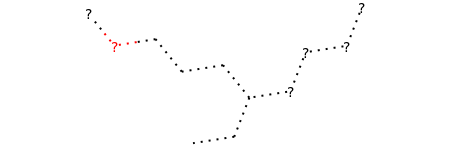

In [190]:
sma = LigandExpo.calc_mcs(mol1, mol2, ['r'])[0]
sma = Chem.MolFromSmarts(sma)
sma

In [192]:
mol1.GetSubstructMatches(sma)

((0, 1, 2, 4, 6, 7, 8, 11, 10, 9, 14, 15),)

In [169]:
# find templates for each case

# for each lig group record CEP
#
# we want to keep the info about original struct of each template ligand
# so it'll be passed through some attention like module first
#
#

In [170]:
def parse_hhr_file(hhr_file, num_top=None):
    with open(hhr_file, 'r') as f:
        lines = f.readlines()
        
    assert int(lines[9].split()[0]) == 1
    q_chain = Path(hhr_file).basename().stripext()
    
    break_line = None
    for i, line in enumerate(lines[9:], 9):
        if line.strip() == '':
            break_line = i
            break
        int(line.split()[0])
        
    out = OrderedDict()
    for line in lines[9:break_line][:num_top]:
        pdb_chain = line.split()[1]
        if pdb_chain in out:
            continue
        #split = line.split()
        q_range = line[75:84].split('-')
        t_range = line[85:94].split('-')
        out[pdb_chain] = OrderedDict(
            hh_pdb=pdb_chain.upper(),
            hh_prob=float(line[35:40]),
            hh_identity=None,
            hh_evalue=None,
            query_aln='',
            target_aln='',
            query_range=[int(q_range[0])-1, int(q_range[1])],
            target_range=[int(t_range[0])-1, int(t_range[1])]
        )
        
    counter = 0
    t_chain = None
    skip = False
    
    for idx in range(break_line + 1, len(lines)):
        line = lines[idx]
        if line.startswith('>'):
            # sanity check for previous target's alignment
            if t_chain is not None:
                last_chain = out[t_chain]
                #assert len(last_chain['query_aln']) == len(last_chain['target_aln'])
                
            t_chain = line.split()[0][1:]
            
            # hhr can have multiple alignments for the same chain
            # we keep only the first one
            skip = out[t_chain]['hh_identity'] is not None
            if skip: 
                continue
            
            # extract alignment scores
            scores = lines[idx+1].split()
            identity = scores[4]
            assert identity.startswith('Iden')
            identity = float(identity.split('=')[1].strip('%'))
            
            evalue = scores[1]
            assert evalue.startswith('E-value')
            evalue = float(evalue.split('=')[1].strip('%'))
            
            out[t_chain]['hh_identity'] = identity
            out[t_chain]['hh_evalue'] = evalue
            counter += 1
            
        if skip:
            continue
            
        # record Q alignment
        if line.startswith(f'Q {q_chain}'):
            s = line.split()
            out[t_chain]['query_aln'] += s[3]
            
            #begin, end = int(s[2]), int(s[4])
            #cur_range = out[t_chain]['query_range'] 
            # sanity check that alignment chunks in hhr file are contiguous
            #if len(cur_range) > 0: 
            #    assert begin-1 == cur_range[-1]
            #out[t_chain]['query_range'] += [begin-1, end]
            
        # record target alignment
        if t_chain is not None and line.startswith(f'T {t_chain}'):
            s = line.split()
            out[t_chain]['target_aln'] += s[3]
            
            #begin, end = int(s[2]), int(s[4])
            #cur_range = out[t_chain]['target_range'] 
            # sanity check that alignment chunks in hhr file are contiguous
            #if len(cur_range) > 0: 
            #    assert begin-1 == cur_range[-1]
            #out[t_chain]['target_range'] += [begin-1, end]
            
        if num_top is not None and counter >= num_top:
            break
           
    #for item in out.values():
    #    item['query_range'] = [min(item['query_range']), max(item['query_range'])]
    #    item['target_range'] = [min(item['target_range']), max(item['target_range'])]
    #    #print(item)
    #    #assert (item['target_range'][1] - item['target_range'][0]) == (item['query_range'][1] - item['query_range'][0])
            
    return out

In [171]:
#parse_hhr_file('data/hhpred/1add_A.hhr')

In [172]:
cases = OrderedDict((x.dirname().basename(), utils.read_json(x)) for x in tqdm(sorted(Path('data/cases').glob('*/case.json'))))

100%|██████████| 20562/20562 [01:55<00:00, 177.52it/s]


In [173]:
for case_name, case_dict in tqdm(list(cases.items())):
    case_dir = Path('data/cases') / case_name
    case_name = case_dict['case_name']
    hhr_file = 'data/hhpred/' + case_name[:4].lower() + '_' + case_name[5:] + '.hhr'
    #print(hhr_file)
    hhpred = parse_hhr_file(hhr_file)
    for group in case_dict['ligand_groups']:
        group_dir = case_dir / group['name']
        for ligand in group['ligands']:
            lig_templates = []
            lig_matches = chemid_to_matches[ligand['chemid']]
            for t_chain in hhpred.keys():
                t_case_dict = cases.get(t_chain.upper())
                if t_case_dict is None:
                    continue
                for t_group in t_case_dict['ligand_groups']:
                    for t_ligand in t_group['ligands']:
                        if t_ligand['chemid'] in lig_matches.keys():
                            lig_templates.append(
                                OrderedDict(
                                    hhpred=hhpred[t_chain],
                                    lig_match=lig_matches[t_ligand['chemid']]
                                )
                            )
            if len(lig_templates) > 0:
                utils.write_json(lig_templates, group_dir / ligand['sdf_id'] + '.templates.json')

100%|█████████▉| 20561/20562 [1:04:13<00:00,  5.33it/s] 


FileNotFoundError: [Errno 2] No such file or directory: 'data/hhpred/9jdw_A.hhr'

In [175]:
LigandExpo.get_smiles('EAA')

'CCC(=C)C(=O)c1ccc(c(c1Cl)Cl)OCC(=O)O'

In [133]:
#parse_hhr_file('data/hhpred/1a25_B.hhr')

In [135]:
list(cases.values())[0]

{'case_name': '10GS_A',
 'pdb_id': '10GS',
 'pdb_chain': 'A',
 'instance_id': 'A',
 'entity_id': '1',
 'experiment': 'X-RAY DIFFRACTION',
 'resolution': 2.2,
 'deposition_date': '1997-08-14T00:00:00+0000',
 'seqclus100': 508,
 'seqclus90': 350,
 'seqclus40': 386,
 'seqclus30': 107,
 'missing_residue': '10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000',
 'missing_ca': '10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000',
 'missing_atoms': '10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000',
 'entity_info': {'nstd_li

In [142]:
sorted(Counter([x['seqclus30'] for x in list(cases.values())]).items(), key=lambda x: -x[1])

[(8, 565),
 (13, 515),
 (26, 481),
 (17, 433),
 (16, 370),
 (121, 361),
 (5, 290),
 (102, 261),
 (128, 240),
 (78, 178),
 (220, 162),
 (2, 149),
 (164, 146),
 (27, 140),
 (183, 136),
 (493, 130),
 (135, 128),
 (469, 127),
 (10, 118),
 (81, 115),
 (555, 110),
 (101, 99),
 (172, 97),
 (246, 95),
 (130, 93),
 (14, 91),
 (100, 86),
 (439, 86),
 (194, 85),
 (175, 84),
 (185, 81),
 (346, 80),
 (514, 80),
 (408, 78),
 (723, 78),
 (872, 76),
 (627, 75),
 (74, 73),
 (187, 70),
 (523, 68),
 (767, 66),
 (377, 64),
 (367, 64),
 (226, 63),
 (124, 63),
 (375, 63),
 (533, 63),
 (217, 60),
 (42, 60),
 (261, 59),
 (995, 58),
 (592, 58),
 (107, 57),
 (509, 56),
 (283, 56),
 (612, 56),
 (1368, 53),
 (113, 53),
 (1418, 50),
 (1140, 49),
 (459, 48),
 (376, 48),
 (398, 48),
 (884, 47),
 (918, 45),
 (209, 45),
 (368, 45),
 (783, 45),
 (360, 44),
 (12, 44),
 (1362, 44),
 (712, 43),
 (849, 43),
 (609, 42),
 (1266, 42),
 (132, 41),
 (159, 40),
 (190, 40),
 (423, 40),
 (616, 40),
 (334, 39),
 (15, 38),
 (1168, 3

In [143]:
pdb_tools.SEQ_CLUSTERS[30][8]

['3GQI_A',
 '3GQL_A',
 '3GQL_B',
 '3GQL_C',
 '4RWJ_A',
 '4RWJ_B',
 '3JS2_A',
 '3JS2_B',
 '3KY2_A',
 '3KY2_B',
 '3KXX_A',
 '3KXX_B',
 '3KXX_C',
 '3KXX_D',
 '4RWL_A',
 '4RWL_B',
 '3GOP_A',
 '5ZWJ_A',
 '1XKK_A',
 '5CNN_A',
 '5CNN_B',
 '4RIX_B',
 '4RIX_D',
 '4RIW_B',
 '4RIW_D',
 '4RIY_B',
 '4RIY_D',
 '3LMG_A',
 '3LMG_B',
 '3RCD_A',
 '3RCD_B',
 '3RCD_C',
 '3RCD_D',
 '3PP0_A',
 '3PP0_B',
 '5JEB_A',
 '4HJO_A',
 '3UG2_A',
 '3VJO_A',
 '4LRM_A',
 '4LRM_B',
 '4LRM_C',
 '4LRM_D',
 '4LRM_E',
 '2EB3_A',
 '3UG1_A',
 '3VJN_A',
 '2EB2_A',
 '1M17_A',
 '6S89_A',
 '6S8A_A',
 '5Y9T_A',
 '1M14_A',
 '5Y25_A',
 '4TKS_A',
 '5HCY_A',
 '5CAQ_A',
 '4ZJV_A',
 '4ZJV_B',
 '4RJ4_A',
 '4WD5_A',
 '4WD5_B',
 '5C8M_A',
 '5CAP_A',
 '5X2A_A',
 '5X2A_B',
 '5X2A_C',
 '5X2A_D',
 '3W2P_A',
 '4ZSE_A',
 '4ZSE_B',
 '4ZSE_C',
 '4ZSE_D',
 '4RJ7_A',
 '5XDL_A',
 '5XGN_A',
 '5XGN_B',
 '4LL0_A',
 '4LL0_B',
 '5CAN_A',
 '5EM5_A',
 '5CAU_A',
 '5CAL_A',
 '5CZI_A',
 '6JRJ_A',
 '5EM8_A',
 '5XGM_A',
 '5EM6_A',
 '5GMP_A',
 '5HCX_A',
 '6JWL_A',

In [146]:
for x in cases.values():
    if x['seqclus30'] == 8:
        print(x)
        break

{'case_name': '1AGW_A', 'pdb_id': '1AGW', 'pdb_chain': 'A', 'instance_id': 'A', 'entity_id': '1', 'experiment': 'X-RAY DIFFRACTION', 'resolution': 2.4, 'deposition_date': '1997-03-25T00:00:00+0000', 'seqclus100': 593, 'seqclus90': 513, 'seqclus40': 12, 'seqclus30': 8, 'missing_residue': '1111111100000000000000000000011111000000000001111000000000000000000000000000000000000000000000000000000000000000000000000001111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111', 'missing_ca': '1111111100000000000000000000011111000000000001111000000000000000000000000000000000000000000000000000000000000000000000000001111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111', 'missing_atoms': '1111111110000000000000000000011111010000000001111000

In [147]:
cases['1AGW_A']

{'case_name': '1AGW_A',
 'pdb_id': '1AGW',
 'pdb_chain': 'A',
 'instance_id': 'A',
 'entity_id': '1',
 'experiment': 'X-RAY DIFFRACTION',
 'resolution': 2.4,
 'deposition_date': '1997-03-25T00:00:00+0000',
 'seqclus100': 593,
 'seqclus90': 513,
 'seqclus40': 12,
 'seqclus30': 8,
 'missing_residue': '1111111100000000000000000000011111000000000001111000000000000000000000000000000000000000000000000000000000000000000000000001111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111',
 'missing_ca': '1111111100000000000000000000011111000000000001111000000000000000000000000000000000000000000000000000000000000000000000000001111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111',
 'missing_atoms': '11111111100000000000000000000111110100

In [49]:
chemid_to_matches['BD5']

{'002': {'ref_chemid': '002',
  'ref_smiles': 'CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC(=O)[C@H](Cc1ccccc1)CC(=O)NO',
  'mcs_flags': ['r'],
  'fp_tanimoto': 0.44397905759162304,
  'mcs_tar_coverage': 0.45652173913043476,
  'mcs_ref_coverage': 0.65625,
  'mcs_tanimoto': 0.3684210526315789,
  'mcs_smarts': '[#6&!R]-&!@[#6&!R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1',
  'mcs_num_atoms': 21,
  'mcs_num_bonds': 21},
 '3D4': {'ref_chemid': '3D4',
  'ref_smiles': 'C[C@H]([C@@H]([C@H](N[C@H](Cc1ccccc1)C(=O)N)O)NC(=O)CNC(=O)[C@H](CCCCN)NCc2ccc(cc2)c3cccnc3)O',
  'mcs_flags': ['r'],
  'fp_tanimoto': 0.4904214559386973,
  'mcs_tar_coverage': 0.45652173913043476,
  'mcs_ref_coverage': 0.4666666666666667,
  'mcs_tanimoto': 0.3,
  'mcs_smarts': '[#6&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#6&R]1:&@[

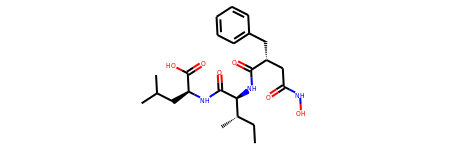

In [51]:
Chem.MolFromSmiles('CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC(=O)[C@H](Cc1ccccc1)CC(=O)NO')

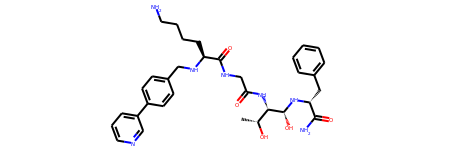

In [52]:
Chem.MolFromSmiles('C[C@H]([C@@H]([C@H](N[C@H](Cc1ccccc1)C(=O)N)O)NC(=O)CNC(=O)[C@H](CCCCN)NCc2ccc(cc2)c3cccnc3)O')

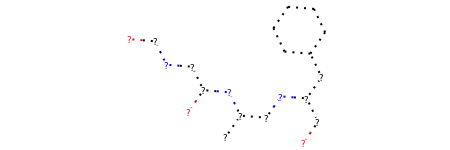

In [53]:
Chem.MolFromSmarts('[#6&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-&!@[#6&!R]=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R]=&!@[#8&!R]')


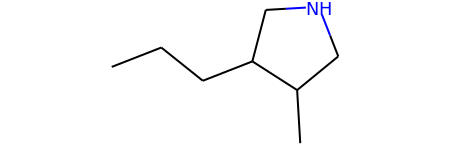

In [44]:
a = Chem.MolFromSmiles('CC1CN([H])CC1CCC')
a

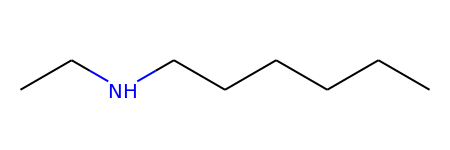

In [45]:
b = Chem.MolFromSmiles('CCN([H])CCCCCC')
b

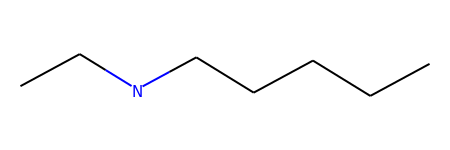

In [46]:
Chem.MolFromSmarts(LigandExpo.calc_mcs(a, b, mcs_flags=['ba'])[0])

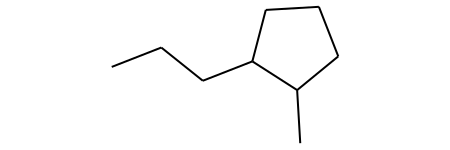

In [59]:
a